##### Copyright 2022 The TensorFlow Compression Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Learned data compression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/data_compression">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/data_compression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This notebook shows how to do lossy data compression using neural networks and [TensorFlow Compression](https://github.com/tensorflow/compression).

Lossy compression involves making a trade-off between **rate**, the expected number of bits needed to encode a sample, and **distortion**, the expected error in the reconstruction of the sample.

The examples below use an autoencoder-like model to compress images from the MNIST dataset. The method is based on the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

More background on learned data compression can be found in [this paper](https://arxiv.org/abs/2007.03034) targeted at people familiar with classical data compression, or [this survey](https://arxiv.org/abs/2202.06533) targeted at a machine learning audience.


## Setup

Install Tensorflow Compression via `pip`.

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"


  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)


Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)


  Attempting uninstall: wrapt


    Found existing installation: wrapt 1.16.0


    Uninstalling wrapt-1.16.0:


      Successfully uninstalled wrapt-1.16.0


  Attempting uninstall: scipy


    Found existing installation: scipy 1.13.1


    Uninstalling scipy-1.13.1:


      Successfully uninstalled scipy-1.13.1


  Attempting uninstall: ml-dtypes


    Found existing installation: ml-dtypes 0.4.0


    Uninstalling ml-dtypes-0.4.0:


      Successfully uninstalled ml-dtypes-0.4.0


  Attempting uninstall: keras


    Found existing installation: keras 3.4.1


    Uninstalling keras-3.4.1:


      Successfully uninstalled keras-3.4.1


  Attempting uninstall: tensorboard


    Found existing installation: tensorboard 2.17.0


    Uninstalling tensorboard-2.17.0:


      Successfully uninstalled tensorboard-2.17.0


  Attempting uninstall: tensorflow


    Found existing installation: tensorflow 2.17.0


    Uninstalling tensorflow-2.17.0:


      Successfully uninstalled tensorflow-2.17.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.14.1 which is incompatible.


Import library dependencies.

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds


2024-07-19 01:53:11.077097: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 01:53:11.077144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 01:53:11.077190: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define the trainer model.

Because the model resembles an autoencoder, and we need to perform a different set of functions during training and inference, the setup is a little different from, say, a classifier.

The training model consists of three parts:
- the **analysis** (or encoder) transform, converting from the image into a latent space,
- the **synthesis** (or decoder) transform, converting from the latent space back into image space, and
- a **prior** and entropy model, modeling the marginal probabilities of the latents.

First, define the transforms:

In [4]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


In [5]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")


The trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the batch of digits, and
- **distortion**, the mean absolute difference between the pixels of the original digits and their reconstructions.


In [6]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)


### Compute rate and distortion.

Let's walk through this step by step, using one image from the training set. Load the MNIST dataset for training and validation:

In [7]:
training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)


2024-07-19 01:53:15.049496: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


And extract one image $x$:

Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


2024-07-19 01:53:15.383276: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


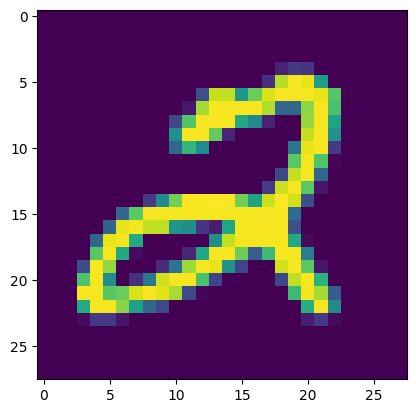

In [8]:
(x, _), = validation_dataset.take(1)

plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")


To get the latent representation $y$, we need to cast it to `float32`, add a batch dimension, and pass it through the analysis transform.

In [9]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)

print("y:", y)


y: tf.Tensor(
[[-0.01224455 -0.09719235 -0.08213592  0.0354024  -0.01443382  0.02162577
   0.02967148  0.00232092  0.00181769  0.00430147]], shape=(1, 10), dtype=float32)


The latents will be quantized at test time. To model this in a differentiable way during training, we add uniform noise in the interval $(-.5, .5)$ and call the result $\tilde y$. This is the same terminology as used in the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

In [10]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

print("y_tilde:", y_tilde)


y_tilde: tf.Tensor(
[[ 0.38850513 -0.3627419  -0.10774756  0.03274522 -0.4638402   0.2084787
   0.00465386  0.45559373  0.45222282 -0.46006057]], shape=(1, 10), dtype=float32)


The "prior" is a probability density that we train to model the marginal distribution of the noisy latents. For example, it could be a set of independent [logistic distributions](https://en.wikipedia.org/wiki/Logistic_distribution) with different scales for each latent dimension. `tfc.NoisyLogistic` accounts for the fact that the latents have additive noise. As the scale approaches zero, a logistic distribution approaches a dirac delta (spike), but the added noise causes the "noisy" distribution to approach the uniform distribution instead.

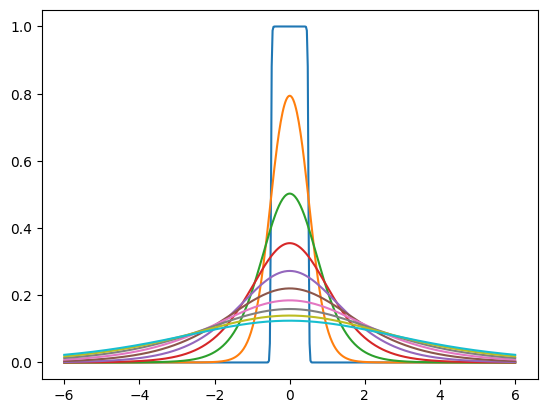

In [11]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))

_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));


During training, `tfc.ContinuousBatchedEntropyModel` adds uniform noise, and uses the noise and the prior to compute a (differentiable) upper bound on the rate (the average number of bits necessary to encode the latent representation). That bound can be minimized as a loss.

In [12]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
    prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

print("rate:", rate)
print("y_tilde:", y_tilde)


rate: tf.Tensor([18.526083], shape=(1,), dtype=float32)
y_tilde: tf.Tensor(
[[ 0.0090554  -0.38909417 -0.4069785   0.18274103  0.2406526  -0.11575054
   0.28057152  0.30737367 -0.13117756 -0.22494133]], shape=(1, 10), dtype=float32)


Lastly, the noisy latents are passed back through the synthesis transform to produce an image reconstruction $\tilde x$. Distortion is the error between original image and reconstruction. Obviously, with the transforms untrained, the reconstruction is not very useful.

distortion: tf.Tensor(0.17078552, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


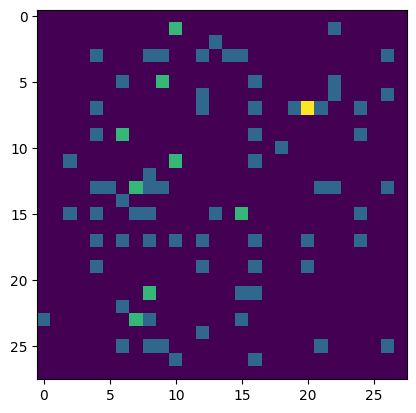

In [13]:
x_tilde = make_synthesis_transform()(y_tilde)

# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)

x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


For every batch of digits, calling the `MNISTCompressionTrainer` produces the rate and distortion as an average over that batch:


In [14]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])


rate:  tf.Tensor(20.296253, shape=(), dtype=float32)
distortion:  tf.Tensor(0.14659302, shape=(), dtype=float32)


2024-07-19 01:53:16.195986: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In the next section, we set up the model to do gradient descent on these two losses.

## Train the model.

We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter $\lambda$.

This loss function affects the different parts of the model differently:
- The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
- The synthesis transform is trained to minimize distortion, given the latent representation.
- The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [15]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


Next, train the model. The human annotations are not necessary here, since we just want to compress the images, so we drop them using a `map` and instead add "dummy" targets for rate and distortion.

In [16]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_mnist_model(lmbda=2000)


Epoch 1/15


  1/469 [..............................] - ETA: 20:42 - loss: 351.9209 - distortion_loss: 0.1245 - rate_loss: 102.9310 - distortion_pass_through_loss: 0.1245 - rate_pass_through_loss: 102.9310

  4/469 [..............................] - ETA: 11s - loss: 365.1880 - distortion_loss: 0.1312 - rate_loss: 102.8584 - distortion_pass_through_loss: 0.1312 - rate_pass_through_loss: 102.8584  

  7/469 [..............................] - ETA: 10s - loss: 366.7121 - distortion_loss: 0.1320 - rate_loss: 102.7398 - distortion_pass_through_loss: 0.1320 - rate_pass_through_loss: 102.7398

 10/469 [..............................] - ETA: 10s - loss: 367.0594 - distortion_loss: 0.1322 - rate_loss: 102.6315 - distortion_pass_through_loss: 0.1322 - rate_pass_through_loss: 102.6315

 13/469 [..............................] - ETA: 10s - loss: 365.7252 - distortion_loss: 0.1316 - rate_loss: 102.5450 - distortion_pass_through_loss: 0.1316 - rate_pass_through_loss: 102.5450

 16/469 [>.............................] - ETA: 9s - loss: 363.5969 - distortion_loss: 0.1305 - rate_loss: 102.6765 - distortion_pass_through_loss: 0.1305 - rate_pass_through_loss: 102.6765 

 19/469 [>.............................] - ETA: 9s - loss: 362.0890 - distortion_loss: 0.1296 - rate_loss: 102.8972 - distortion_pass_through_loss: 0.1296 - rate_pass_through_loss: 102.8972

 22/469 [>.............................] - ETA: 9s - loss: 360.7832 - distortion_loss: 0.1290 - rate_loss: 102.8304 - distortion_pass_through_loss: 0.1290 - rate_pass_through_loss: 102.8304

 25/469 [>.............................] - ETA: 9s - loss: 358.3023 - distortion_loss: 0.1278 - rate_loss: 102.7995 - distortion_pass_through_loss: 0.1278 - rate_pass_through_loss: 102.7995

 28/469 [>.............................] - ETA: 9s - loss: 356.9001 - distortion_loss: 0.1270 - rate_loss: 102.8086 - distortion_pass_through_loss: 0.1270 - rate_pass_through_loss: 102.8086

 31/469 [>.............................] - ETA: 9s - loss: 354.1196 - distortion_loss: 0.1256 - rate_loss: 102.8563 - distortion_pass_through_loss: 0.1256 - rate_pass_through_loss: 102.8563

 34/469 [=>............................] - ETA: 9s - loss: 351.2524 - distortion_loss: 0.1241 - rate_loss: 102.9685 - distortion_pass_through_loss: 0.1241 - rate_pass_through_loss: 102.9685

 37/469 [=>............................] - ETA: 9s - loss: 347.4805 - distortion_loss: 0.1222 - rate_loss: 103.0616 - distortion_pass_through_loss: 0.1222 - rate_pass_through_loss: 103.0616

 40/469 [=>............................] - ETA: 8s - loss: 343.8150 - distortion_loss: 0.1203 - rate_loss: 103.1250 - distortion_pass_through_loss: 0.1203 - rate_pass_through_loss: 103.1250

 43/469 [=>............................] - ETA: 8s - loss: 340.3934 - distortion_loss: 0.1186 - rate_loss: 103.2324 - distortion_pass_through_loss: 0.1186 - rate_pass_through_loss: 103.2324

 46/469 [=>............................] - ETA: 8s - loss: 336.8393 - distortion_loss: 0.1168 - rate_loss: 103.2874 - distortion_pass_through_loss: 0.1168 - rate_pass_through_loss: 103.2874

 49/469 [==>...........................] - ETA: 8s - loss: 333.8018 - distortion_loss: 0.1152 - rate_loss: 103.3042 - distortion_pass_through_loss: 0.1152 - rate_pass_through_loss: 103.3042

 52/469 [==>...........................] - ETA: 8s - loss: 330.7338 - distortion_loss: 0.1137 - rate_loss: 103.3330 - distortion_pass_through_loss: 0.1137 - rate_pass_through_loss: 103.3330

 55/469 [==>...........................] - ETA: 8s - loss: 327.5186 - distortion_loss: 0.1121 - rate_loss: 103.3322 - distortion_pass_through_loss: 0.1121 - rate_pass_through_loss: 103.3322

 58/469 [==>...........................] - ETA: 8s - loss: 324.6774 - distortion_loss: 0.1107 - rate_loss: 103.3303 - distortion_pass_through_loss: 0.1107 - rate_pass_through_loss: 103.3303

 61/469 [==>...........................] - ETA: 8s - loss: 322.0229 - distortion_loss: 0.1093 - rate_loss: 103.3353 - distortion_pass_through_loss: 0.1093 - rate_pass_through_loss: 103.3353

 64/469 [===>..........................] - ETA: 8s - loss: 319.4834 - distortion_loss: 0.1081 - rate_loss: 103.3501 - distortion_pass_through_loss: 0.1081 - rate_pass_through_loss: 103.3501

 67/469 [===>..........................] - ETA: 8s - loss: 316.9681 - distortion_loss: 0.1068 - rate_loss: 103.3721 - distortion_pass_through_loss: 0.1068 - rate_pass_through_loss: 103.3721

 70/469 [===>..........................] - ETA: 8s - loss: 314.4192 - distortion_loss: 0.1055 - rate_loss: 103.4147 - distortion_pass_through_loss: 0.1055 - rate_pass_through_loss: 103.4147

 73/469 [===>..........................] - ETA: 8s - loss: 311.8149 - distortion_loss: 0.1042 - rate_loss: 103.4456 - distortion_pass_through_loss: 0.1042 - rate_pass_through_loss: 103.4456

 76/469 [===>..........................] - ETA: 7s - loss: 309.5803 - distortion_loss: 0.1030 - rate_loss: 103.4962 - distortion_pass_through_loss: 0.1030 - rate_pass_through_loss: 103.4962

 79/469 [====>.........................] - ETA: 7s - loss: 307.3122 - distortion_loss: 0.1019 - rate_loss: 103.5355 - distortion_pass_through_loss: 0.1019 - rate_pass_through_loss: 103.5355

 82/469 [====>.........................] - ETA: 7s - loss: 305.2016 - distortion_loss: 0.1008 - rate_loss: 103.5546 - distortion_pass_through_loss: 0.1008 - rate_pass_through_loss: 103.5546

 85/469 [====>.........................] - ETA: 7s - loss: 303.0138 - distortion_loss: 0.0997 - rate_loss: 103.5859 - distortion_pass_through_loss: 0.0997 - rate_pass_through_loss: 103.5859

 88/469 [====>.........................] - ETA: 7s - loss: 300.9676 - distortion_loss: 0.0987 - rate_loss: 103.6240 - distortion_pass_through_loss: 0.0987 - rate_pass_through_loss: 103.6240

 91/469 [====>.........................] - ETA: 7s - loss: 298.9089 - distortion_loss: 0.0976 - rate_loss: 103.6387 - distortion_pass_through_loss: 0.0976 - rate_pass_through_loss: 103.6387

 94/469 [=====>........................] - ETA: 7s - loss: 297.0677 - distortion_loss: 0.0967 - rate_loss: 103.6659 - distortion_pass_through_loss: 0.0967 - rate_pass_through_loss: 103.6659

 97/469 [=====>........................] - ETA: 7s - loss: 295.1393 - distortion_loss: 0.0957 - rate_loss: 103.6933 - distortion_pass_through_loss: 0.0957 - rate_pass_through_loss: 103.6933

100/469 [=====>........................] - ETA: 7s - loss: 293.4263 - distortion_loss: 0.0949 - rate_loss: 103.7221 - distortion_pass_through_loss: 0.0949 - rate_pass_through_loss: 103.7221

103/469 [=====>........................] - ETA: 7s - loss: 291.7593 - distortion_loss: 0.0940 - rate_loss: 103.7426 - distortion_pass_through_loss: 0.0940 - rate_pass_through_loss: 103.7426

106/469 [=====>........................] - ETA: 7s - loss: 290.0103 - distortion_loss: 0.0931 - rate_loss: 103.7569 - distortion_pass_through_loss: 0.0931 - rate_pass_through_loss: 103.7569

109/469 [=====>........................] - ETA: 7s - loss: 288.3255 - distortion_loss: 0.0923 - rate_loss: 103.7784 - distortion_pass_through_loss: 0.0923 - rate_pass_through_loss: 103.7784

112/469 [======>.......................] - ETA: 7s - loss: 286.8188 - distortion_loss: 0.0915 - rate_loss: 103.8005 - distortion_pass_through_loss: 0.0915 - rate_pass_through_loss: 103.8005

115/469 [======>.......................] - ETA: 7s - loss: 285.4047 - distortion_loss: 0.0908 - rate_loss: 103.8152 - distortion_pass_through_loss: 0.0908 - rate_pass_through_loss: 103.8152

118/469 [======>.......................] - ETA: 7s - loss: 283.8305 - distortion_loss: 0.0900 - rate_loss: 103.8344 - distortion_pass_through_loss: 0.0900 - rate_pass_through_loss: 103.8344

121/469 [======>.......................] - ETA: 6s - loss: 282.3516 - distortion_loss: 0.0893 - rate_loss: 103.8464 - distortion_pass_through_loss: 0.0893 - rate_pass_through_loss: 103.8464

124/469 [======>.......................] - ETA: 6s - loss: 280.8998 - distortion_loss: 0.0885 - rate_loss: 103.8537 - distortion_pass_through_loss: 0.0885 - rate_pass_through_loss: 103.8537

127/469 [=======>......................] - ETA: 6s - loss: 279.4748 - distortion_loss: 0.0878 - rate_loss: 103.8553 - distortion_pass_through_loss: 0.0878 - rate_pass_through_loss: 103.8553

130/469 [=======>......................] - ETA: 6s - loss: 278.0938 - distortion_loss: 0.0871 - rate_loss: 103.8567 - distortion_pass_through_loss: 0.0871 - rate_pass_through_loss: 103.8567

133/469 [=======>......................] - ETA: 6s - loss: 276.7397 - distortion_loss: 0.0864 - rate_loss: 103.8620 - distortion_pass_through_loss: 0.0864 - rate_pass_through_loss: 103.8620

136/469 [=======>......................] - ETA: 6s - loss: 275.4832 - distortion_loss: 0.0858 - rate_loss: 103.8679 - distortion_pass_through_loss: 0.0858 - rate_pass_through_loss: 103.8679

139/469 [=======>......................] - ETA: 6s - loss: 274.2751 - distortion_loss: 0.0852 - rate_loss: 103.8731 - distortion_pass_through_loss: 0.0852 - rate_pass_through_loss: 103.8731

142/469 [========>.....................] - ETA: 6s - loss: 273.0680 - distortion_loss: 0.0846 - rate_loss: 103.8727 - distortion_pass_through_loss: 0.0846 - rate_pass_through_loss: 103.8727

145/469 [========>.....................] - ETA: 6s - loss: 271.9189 - distortion_loss: 0.0840 - rate_loss: 103.8851 - distortion_pass_through_loss: 0.0840 - rate_pass_through_loss: 103.8851

148/469 [========>.....................] - ETA: 6s - loss: 270.8139 - distortion_loss: 0.0835 - rate_loss: 103.8802 - distortion_pass_through_loss: 0.0835 - rate_pass_through_loss: 103.8802

151/469 [========>.....................] - ETA: 6s - loss: 269.7198 - distortion_loss: 0.0829 - rate_loss: 103.8873 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 103.8873

154/469 [========>.....................] - ETA: 6s - loss: 268.6868 - distortion_loss: 0.0824 - rate_loss: 103.8899 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 103.8899

157/469 [=========>....................] - ETA: 6s - loss: 267.6572 - distortion_loss: 0.0819 - rate_loss: 103.8916 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 103.8916

160/469 [=========>....................] - ETA: 6s - loss: 266.6728 - distortion_loss: 0.0814 - rate_loss: 103.8851 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 103.8851

163/469 [=========>....................] - ETA: 6s - loss: 265.6517 - distortion_loss: 0.0809 - rate_loss: 103.8690 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 103.8690

166/469 [=========>....................] - ETA: 6s - loss: 264.7007 - distortion_loss: 0.0804 - rate_loss: 103.8548 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 103.8548

169/469 [=========>....................] - ETA: 5s - loss: 263.7768 - distortion_loss: 0.0800 - rate_loss: 103.8453 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 103.8453

172/469 [==========>...................] - ETA: 5s - loss: 262.8183 - distortion_loss: 0.0795 - rate_loss: 103.8311 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 103.8311

175/469 [==========>...................] - ETA: 5s - loss: 261.9437 - distortion_loss: 0.0791 - rate_loss: 103.8243 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 103.8243

178/469 [==========>...................] - ETA: 5s - loss: 261.0411 - distortion_loss: 0.0786 - rate_loss: 103.8179 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 103.8179

181/469 [==========>...................] - ETA: 5s - loss: 260.1916 - distortion_loss: 0.0782 - rate_loss: 103.8112 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 103.8112

184/469 [==========>...................] - ETA: 5s - loss: 259.3501 - distortion_loss: 0.0778 - rate_loss: 103.8021 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 103.8021

187/469 [==========>...................] - ETA: 5s - loss: 258.4972 - distortion_loss: 0.0774 - rate_loss: 103.7822 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 103.7822

190/469 [===========>..................] - ETA: 5s - loss: 257.7021 - distortion_loss: 0.0770 - rate_loss: 103.7766 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 103.7766

193/469 [===========>..................] - ETA: 5s - loss: 256.9207 - distortion_loss: 0.0766 - rate_loss: 103.7574 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 103.7574

196/469 [===========>..................] - ETA: 5s - loss: 256.1311 - distortion_loss: 0.0762 - rate_loss: 103.7408 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 103.7408

199/469 [===========>..................] - ETA: 5s - loss: 255.3248 - distortion_loss: 0.0758 - rate_loss: 103.7189 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 103.7189

202/469 [===========>..................] - ETA: 5s - loss: 254.5509 - distortion_loss: 0.0754 - rate_loss: 103.6936 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 103.6936

205/469 [============>.................] - ETA: 5s - loss: 253.8006 - distortion_loss: 0.0751 - rate_loss: 103.6729 - distortion_pass_through_loss: 0.0751 - rate_pass_through_loss: 103.6729

208/469 [============>.................] - ETA: 5s - loss: 253.0460 - distortion_loss: 0.0747 - rate_loss: 103.6522 - distortion_pass_through_loss: 0.0747 - rate_pass_through_loss: 103.6522

211/469 [============>.................] - ETA: 5s - loss: 252.2957 - distortion_loss: 0.0743 - rate_loss: 103.6256 - distortion_pass_through_loss: 0.0743 - rate_pass_through_loss: 103.6256

214/469 [============>.................] - ETA: 5s - loss: 251.5963 - distortion_loss: 0.0740 - rate_loss: 103.6029 - distortion_pass_through_loss: 0.0740 - rate_pass_through_loss: 103.6029

217/469 [============>.................] - ETA: 5s - loss: 250.8836 - distortion_loss: 0.0737 - rate_loss: 103.5832 - distortion_pass_through_loss: 0.0737 - rate_pass_through_loss: 103.5832

220/469 [=============>................] - ETA: 4s - loss: 250.2027 - distortion_loss: 0.0733 - rate_loss: 103.5584 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 103.5584

223/469 [=============>................] - ETA: 4s - loss: 249.5327 - distortion_loss: 0.0730 - rate_loss: 103.5387 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 103.5387

226/469 [=============>................] - ETA: 4s - loss: 248.8381 - distortion_loss: 0.0727 - rate_loss: 103.5098 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 103.5098

229/469 [=============>................] - ETA: 4s - loss: 248.2194 - distortion_loss: 0.0724 - rate_loss: 103.4869 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 103.4869

232/469 [=============>................] - ETA: 4s - loss: 247.5970 - distortion_loss: 0.0721 - rate_loss: 103.4620 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 103.4620

235/469 [==============>...............] - ETA: 4s - loss: 246.9477 - distortion_loss: 0.0718 - rate_loss: 103.4343 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 103.4343

238/469 [==============>...............] - ETA: 4s - loss: 246.3318 - distortion_loss: 0.0715 - rate_loss: 103.4070 - distortion_pass_through_loss: 0.0715 - rate_pass_through_loss: 103.4070

241/469 [==============>...............] - ETA: 4s - loss: 245.7229 - distortion_loss: 0.0712 - rate_loss: 103.3823 - distortion_pass_through_loss: 0.0712 - rate_pass_through_loss: 103.3823

244/469 [==============>...............] - ETA: 4s - loss: 245.1040 - distortion_loss: 0.0709 - rate_loss: 103.3506 - distortion_pass_through_loss: 0.0709 - rate_pass_through_loss: 103.3506

247/469 [==============>...............] - ETA: 4s - loss: 244.5677 - distortion_loss: 0.0706 - rate_loss: 103.3243 - distortion_pass_through_loss: 0.0706 - rate_pass_through_loss: 103.3243

250/469 [==============>...............] - ETA: 4s - loss: 244.0099 - distortion_loss: 0.0704 - rate_loss: 103.2968 - distortion_pass_through_loss: 0.0704 - rate_pass_through_loss: 103.2968

253/469 [===============>..............] - ETA: 4s - loss: 243.4462 - distortion_loss: 0.0701 - rate_loss: 103.2643 - distortion_pass_through_loss: 0.0701 - rate_pass_through_loss: 103.2643

256/469 [===============>..............] - ETA: 4s - loss: 242.8760 - distortion_loss: 0.0698 - rate_loss: 103.2299 - distortion_pass_through_loss: 0.0698 - rate_pass_through_loss: 103.2299

259/469 [===============>..............] - ETA: 4s - loss: 242.3418 - distortion_loss: 0.0696 - rate_loss: 103.1973 - distortion_pass_through_loss: 0.0696 - rate_pass_through_loss: 103.1973

262/469 [===============>..............] - ETA: 4s - loss: 241.7969 - distortion_loss: 0.0693 - rate_loss: 103.1652 - distortion_pass_through_loss: 0.0693 - rate_pass_through_loss: 103.1652

265/469 [===============>..............] - ETA: 4s - loss: 241.2520 - distortion_loss: 0.0691 - rate_loss: 103.1295 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 103.1295

268/469 [================>.............] - ETA: 3s - loss: 240.7221 - distortion_loss: 0.0688 - rate_loss: 103.0975 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 103.0975

271/469 [================>.............] - ETA: 3s - loss: 240.2219 - distortion_loss: 0.0686 - rate_loss: 103.0629 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 103.0629

274/469 [================>.............] - ETA: 3s - loss: 239.7339 - distortion_loss: 0.0684 - rate_loss: 103.0301 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 103.0301

277/469 [================>.............] - ETA: 3s - loss: 239.2394 - distortion_loss: 0.0681 - rate_loss: 102.9969 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 102.9969

280/469 [================>.............] - ETA: 3s - loss: 238.7260 - distortion_loss: 0.0679 - rate_loss: 102.9613 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 102.9613

283/469 [=================>............] - ETA: 3s - loss: 238.2725 - distortion_loss: 0.0677 - rate_loss: 102.9334 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 102.9334

286/469 [=================>............] - ETA: 3s - loss: 237.8012 - distortion_loss: 0.0675 - rate_loss: 102.8966 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 102.8966

289/469 [=================>............] - ETA: 3s - loss: 237.3282 - distortion_loss: 0.0672 - rate_loss: 102.8584 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 102.8584

292/469 [=================>............] - ETA: 3s - loss: 236.8461 - distortion_loss: 0.0670 - rate_loss: 102.8199 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 102.8199

295/469 [=================>............] - ETA: 3s - loss: 236.3759 - distortion_loss: 0.0668 - rate_loss: 102.7765 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 102.7765

298/469 [==================>...........] - ETA: 3s - loss: 235.8970 - distortion_loss: 0.0666 - rate_loss: 102.7346 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 102.7346

301/469 [==================>...........] - ETA: 3s - loss: 235.4675 - distortion_loss: 0.0664 - rate_loss: 102.6977 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 102.6977

304/469 [==================>...........] - ETA: 3s - loss: 234.9924 - distortion_loss: 0.0662 - rate_loss: 102.6579 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 102.6579

307/469 [==================>...........] - ETA: 3s - loss: 234.5627 - distortion_loss: 0.0660 - rate_loss: 102.6217 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 102.6217

310/469 [==================>...........] - ETA: 3s - loss: 234.1370 - distortion_loss: 0.0658 - rate_loss: 102.5835 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 102.5835

313/469 [===================>..........] - ETA: 3s - loss: 233.7107 - distortion_loss: 0.0656 - rate_loss: 102.5456 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 102.5456

316/469 [===================>..........] - ETA: 3s - loss: 233.2952 - distortion_loss: 0.0654 - rate_loss: 102.5072 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 102.5072

319/469 [===================>..........] - ETA: 2s - loss: 232.8788 - distortion_loss: 0.0652 - rate_loss: 102.4657 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 102.4657

322/469 [===================>..........] - ETA: 2s - loss: 232.4732 - distortion_loss: 0.0650 - rate_loss: 102.4268 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 102.4268

325/469 [===================>..........] - ETA: 2s - loss: 232.0617 - distortion_loss: 0.0648 - rate_loss: 102.3825 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 102.3825

328/469 [===================>..........] - ETA: 2s - loss: 231.6810 - distortion_loss: 0.0647 - rate_loss: 102.3412 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 102.3412

331/469 [====================>.........] - ETA: 2s - loss: 231.2867 - distortion_loss: 0.0645 - rate_loss: 102.2976 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 102.2976

334/469 [====================>.........] - ETA: 2s - loss: 230.9079 - distortion_loss: 0.0643 - rate_loss: 102.2548 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 102.2548

337/469 [====================>.........] - ETA: 2s - loss: 230.5387 - distortion_loss: 0.0642 - rate_loss: 102.2091 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 102.2091

340/469 [====================>.........] - ETA: 2s - loss: 230.1645 - distortion_loss: 0.0640 - rate_loss: 102.1645 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 102.1645

343/469 [====================>.........] - ETA: 2s - loss: 229.7882 - distortion_loss: 0.0638 - rate_loss: 102.1213 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 102.1213

346/469 [=====================>........] - ETA: 2s - loss: 229.4008 - distortion_loss: 0.0637 - rate_loss: 102.0730 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 102.0730

349/469 [=====================>........] - ETA: 2s - loss: 229.0548 - distortion_loss: 0.0635 - rate_loss: 102.0319 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 102.0319

352/469 [=====================>........] - ETA: 2s - loss: 228.7025 - distortion_loss: 0.0634 - rate_loss: 101.9886 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 101.9886

355/469 [=====================>........] - ETA: 2s - loss: 228.3264 - distortion_loss: 0.0632 - rate_loss: 101.9454 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 101.9454

358/469 [=====================>........] - ETA: 2s - loss: 227.9615 - distortion_loss: 0.0630 - rate_loss: 101.9012 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 101.9012

361/469 [======================>.......] - ETA: 2s - loss: 227.6189 - distortion_loss: 0.0629 - rate_loss: 101.8594 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 101.8594

364/469 [======================>.......] - ETA: 2s - loss: 227.2769 - distortion_loss: 0.0627 - rate_loss: 101.8166 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 101.8166

367/469 [======================>.......] - ETA: 2s - loss: 226.9294 - distortion_loss: 0.0626 - rate_loss: 101.7724 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 101.7724

370/469 [======================>.......] - ETA: 1s - loss: 226.5878 - distortion_loss: 0.0624 - rate_loss: 101.7259 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 101.7259

373/469 [======================>.......] - ETA: 1s - loss: 226.2411 - distortion_loss: 0.0623 - rate_loss: 101.6829 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 101.6829

376/469 [=======================>......] - ETA: 1s - loss: 225.8966 - distortion_loss: 0.0621 - rate_loss: 101.6357 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 101.6357

379/469 [=======================>......] - ETA: 1s - loss: 225.5603 - distortion_loss: 0.0620 - rate_loss: 101.5925 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 101.5925

382/469 [=======================>......] - ETA: 1s - loss: 225.2287 - distortion_loss: 0.0618 - rate_loss: 101.5460 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 101.5460

385/469 [=======================>......] - ETA: 1s - loss: 224.8915 - distortion_loss: 0.0617 - rate_loss: 101.5012 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 101.5012

388/469 [=======================>......] - ETA: 1s - loss: 224.5880 - distortion_loss: 0.0616 - rate_loss: 101.4562 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 101.4562

391/469 [========================>.....] - ETA: 1s - loss: 224.2640 - distortion_loss: 0.0614 - rate_loss: 101.4085 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 101.4085

394/469 [========================>.....] - ETA: 1s - loss: 223.9503 - distortion_loss: 0.0613 - rate_loss: 101.3627 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 101.3627

397/469 [========================>.....] - ETA: 1s - loss: 223.6334 - distortion_loss: 0.0612 - rate_loss: 101.3135 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 101.3135

400/469 [========================>.....] - ETA: 1s - loss: 223.3214 - distortion_loss: 0.0610 - rate_loss: 101.2662 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 101.2662

403/469 [========================>.....] - ETA: 1s - loss: 222.9905 - distortion_loss: 0.0609 - rate_loss: 101.2152 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 101.2152

406/469 [========================>.....] - ETA: 1s - loss: 222.6879 - distortion_loss: 0.0608 - rate_loss: 101.1681 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 101.1681

409/469 [=========================>....] - ETA: 1s - loss: 222.3827 - distortion_loss: 0.0606 - rate_loss: 101.1242 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 101.1242

412/469 [=========================>....] - ETA: 1s - loss: 222.0996 - distortion_loss: 0.0605 - rate_loss: 101.0786 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 101.0786

415/469 [=========================>....] - ETA: 1s - loss: 221.8025 - distortion_loss: 0.0604 - rate_loss: 101.0324 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 101.0324

418/469 [=========================>....] - ETA: 1s - loss: 221.5020 - distortion_loss: 0.0603 - rate_loss: 100.9855 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 100.9855

421/469 [=========================>....] - ETA: 0s - loss: 221.2018 - distortion_loss: 0.0601 - rate_loss: 100.9359 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 100.9359

424/469 [==========================>...] - ETA: 0s - loss: 220.9056 - distortion_loss: 0.0600 - rate_loss: 100.8879 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 100.8879

427/469 [==========================>...] - ETA: 0s - loss: 220.6352 - distortion_loss: 0.0599 - rate_loss: 100.8405 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 100.8405

430/469 [==========================>...] - ETA: 0s - loss: 220.3624 - distortion_loss: 0.0598 - rate_loss: 100.7921 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 100.7921

433/469 [==========================>...] - ETA: 0s - loss: 220.0882 - distortion_loss: 0.0597 - rate_loss: 100.7444 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 100.7444

436/469 [==========================>...] - ETA: 0s - loss: 219.7995 - distortion_loss: 0.0596 - rate_loss: 100.6940 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 100.6940

439/469 [===========================>..] - ETA: 0s - loss: 219.5268 - distortion_loss: 0.0594 - rate_loss: 100.6465 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 100.6465

442/469 [===========================>..] - ETA: 0s - loss: 219.2571 - distortion_loss: 0.0593 - rate_loss: 100.5983 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 100.5983

445/469 [===========================>..] - ETA: 0s - loss: 218.9839 - distortion_loss: 0.0592 - rate_loss: 100.5492 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 100.5492

448/469 [===========================>..] - ETA: 0s - loss: 218.7292 - distortion_loss: 0.0591 - rate_loss: 100.4996 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 100.4996

451/469 [===========================>..] - ETA: 0s - loss: 218.4678 - distortion_loss: 0.0590 - rate_loss: 100.4494 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 100.4494

454/469 [============================>.] - ETA: 0s - loss: 218.1993 - distortion_loss: 0.0589 - rate_loss: 100.4001 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 100.4001

457/469 [============================>.] - ETA: 0s - loss: 217.9398 - distortion_loss: 0.0588 - rate_loss: 100.3503 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 100.3503

460/469 [============================>.] - ETA: 0s - loss: 217.6828 - distortion_loss: 0.0587 - rate_loss: 100.3020 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 100.3020

463/469 [============================>.] - ETA: 0s - loss: 217.4242 - distortion_loss: 0.0586 - rate_loss: 100.2527 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 100.2527

466/469 [============================>.] - ETA: 0s - loss: 217.1765 - distortion_loss: 0.0585 - rate_loss: 100.2050 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 100.2050

469/469 [==============================] - ETA: 0s - loss: 216.9254 - distortion_loss: 0.0584 - rate_loss: 100.1568 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 100.1521

469/469 [==============================] - 13s 22ms/step - loss: 216.9254 - distortion_loss: 0.0584 - rate_loss: 100.1568 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 100.1521 - val_loss: 176.1546 - val_distortion_loss: 0.0419 - val_rate_loss: 92.4025 - val_distortion_pass_through_loss: 0.0419 - val_rate_pass_through_loss: 92.4103


Epoch 2/15


  1/469 [..............................] - ETA: 11s - loss: 171.1313 - distortion_loss: 0.0396 - rate_loss: 91.9416 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 91.9416

  4/469 [..............................] - ETA: 8s - loss: 175.1523 - distortion_loss: 0.0414 - rate_loss: 92.2880 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 92.2880 

  7/469 [..............................] - ETA: 8s - loss: 176.2130 - distortion_loss: 0.0419 - rate_loss: 92.3229 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 92.3229

 10/469 [..............................] - ETA: 8s - loss: 177.0155 - distortion_loss: 0.0424 - rate_loss: 92.2985 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 92.2985

 13/469 [..............................] - ETA: 8s - loss: 176.4408 - distortion_loss: 0.0421 - rate_loss: 92.1775 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 92.1775

 16/469 [>.............................] - ETA: 8s - loss: 176.1880 - distortion_loss: 0.0420 - rate_loss: 92.1466 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 92.1466

 19/469 [>.............................] - ETA: 8s - loss: 176.2856 - distortion_loss: 0.0421 - rate_loss: 92.1277 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 92.1277

 22/469 [>.............................] - ETA: 8s - loss: 176.5185 - distortion_loss: 0.0422 - rate_loss: 92.0305 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 92.0305

 25/469 [>.............................] - ETA: 8s - loss: 176.4578 - distortion_loss: 0.0422 - rate_loss: 91.9720 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.9720

 28/469 [>.............................] - ETA: 8s - loss: 176.5418 - distortion_loss: 0.0423 - rate_loss: 91.9646 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 91.9646

 31/469 [>.............................] - ETA: 8s - loss: 176.3306 - distortion_loss: 0.0422 - rate_loss: 91.8789 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.8789

 34/469 [=>............................] - ETA: 8s - loss: 176.2679 - distortion_loss: 0.0422 - rate_loss: 91.8423 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.8423

 37/469 [=>............................] - ETA: 8s - loss: 175.9371 - distortion_loss: 0.0421 - rate_loss: 91.7347 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 91.7347

 40/469 [=>............................] - ETA: 8s - loss: 175.8169 - distortion_loss: 0.0421 - rate_loss: 91.6806 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 91.6806

 43/469 [=>............................] - ETA: 8s - loss: 175.7684 - distortion_loss: 0.0421 - rate_loss: 91.6197 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 91.6197

 46/469 [=>............................] - ETA: 8s - loss: 175.6725 - distortion_loss: 0.0421 - rate_loss: 91.5363 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 91.5363

 49/469 [==>...........................] - ETA: 7s - loss: 175.7067 - distortion_loss: 0.0421 - rate_loss: 91.4800 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 91.4800

 52/469 [==>...........................] - ETA: 7s - loss: 175.7661 - distortion_loss: 0.0422 - rate_loss: 91.4290 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.4290

 55/469 [==>...........................] - ETA: 7s - loss: 175.6707 - distortion_loss: 0.0422 - rate_loss: 91.3573 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.3573

 58/469 [==>...........................] - ETA: 7s - loss: 175.6422 - distortion_loss: 0.0422 - rate_loss: 91.3014 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.3014

 61/469 [==>...........................] - ETA: 7s - loss: 175.6480 - distortion_loss: 0.0422 - rate_loss: 91.2412 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.2412

 64/469 [===>..........................] - ETA: 7s - loss: 175.7200 - distortion_loss: 0.0423 - rate_loss: 91.1802 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 91.1802

 67/469 [===>..........................] - ETA: 7s - loss: 175.7346 - distortion_loss: 0.0423 - rate_loss: 91.1069 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 91.1069

 70/469 [===>..........................] - ETA: 7s - loss: 175.6522 - distortion_loss: 0.0423 - rate_loss: 91.0298 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 91.0298

 73/469 [===>..........................] - ETA: 7s - loss: 175.4679 - distortion_loss: 0.0423 - rate_loss: 90.9633 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.9633

 76/469 [===>..........................] - ETA: 7s - loss: 175.3956 - distortion_loss: 0.0422 - rate_loss: 90.9055 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 90.9055

 79/469 [====>.........................] - ETA: 7s - loss: 175.2934 - distortion_loss: 0.0422 - rate_loss: 90.8559 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 90.8559

 82/469 [====>.........................] - ETA: 7s - loss: 175.2272 - distortion_loss: 0.0422 - rate_loss: 90.8022 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 90.8022

 85/469 [====>.........................] - ETA: 7s - loss: 175.1043 - distortion_loss: 0.0422 - rate_loss: 90.7388 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 90.7388

 88/469 [====>.........................] - ETA: 7s - loss: 174.9818 - distortion_loss: 0.0422 - rate_loss: 90.6805 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 90.6805

 91/469 [====>.........................] - ETA: 7s - loss: 174.8191 - distortion_loss: 0.0421 - rate_loss: 90.6154 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 90.6154

 94/469 [=====>........................] - ETA: 7s - loss: 174.7228 - distortion_loss: 0.0421 - rate_loss: 90.5564 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 90.5564

 97/469 [=====>........................] - ETA: 7s - loss: 174.5461 - distortion_loss: 0.0420 - rate_loss: 90.4895 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 90.4895

100/469 [=====>........................] - ETA: 7s - loss: 174.5247 - distortion_loss: 0.0420 - rate_loss: 90.4488 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 90.4488

103/469 [=====>........................] - ETA: 6s - loss: 174.4552 - distortion_loss: 0.0420 - rate_loss: 90.3877 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 90.3877

106/469 [=====>........................] - ETA: 6s - loss: 174.3087 - distortion_loss: 0.0420 - rate_loss: 90.3150 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 90.3150

109/469 [=====>........................] - ETA: 6s - loss: 174.1652 - distortion_loss: 0.0420 - rate_loss: 90.2484 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 90.2484

112/469 [======>.......................] - ETA: 6s - loss: 174.0894 - distortion_loss: 0.0419 - rate_loss: 90.1944 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 90.1944

115/469 [======>.......................] - ETA: 6s - loss: 174.0766 - distortion_loss: 0.0420 - rate_loss: 90.1505 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 90.1505

118/469 [======>.......................] - ETA: 6s - loss: 173.9490 - distortion_loss: 0.0419 - rate_loss: 90.0836 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 90.0836

121/469 [======>.......................] - ETA: 6s - loss: 173.8205 - distortion_loss: 0.0419 - rate_loss: 90.0238 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 90.0238

124/469 [======>.......................] - ETA: 6s - loss: 173.7165 - distortion_loss: 0.0419 - rate_loss: 89.9509 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.9509

127/469 [=======>......................] - ETA: 6s - loss: 173.5906 - distortion_loss: 0.0418 - rate_loss: 89.8985 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 89.8985

130/469 [=======>......................] - ETA: 6s - loss: 173.4536 - distortion_loss: 0.0418 - rate_loss: 89.8289 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 89.8289

133/469 [=======>......................] - ETA: 6s - loss: 173.3248 - distortion_loss: 0.0418 - rate_loss: 89.7816 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 89.7816

136/469 [=======>......................] - ETA: 6s - loss: 173.2413 - distortion_loss: 0.0418 - rate_loss: 89.7244 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 89.7244

139/469 [=======>......................] - ETA: 6s - loss: 173.1709 - distortion_loss: 0.0418 - rate_loss: 89.6689 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 89.6689

142/469 [========>.....................] - ETA: 6s - loss: 173.0630 - distortion_loss: 0.0417 - rate_loss: 89.6064 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.6064

145/469 [========>.....................] - ETA: 6s - loss: 172.9704 - distortion_loss: 0.0417 - rate_loss: 89.5557 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.5557

148/469 [========>.....................] - ETA: 6s - loss: 172.8934 - distortion_loss: 0.0417 - rate_loss: 89.5057 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.5057

151/469 [========>.....................] - ETA: 6s - loss: 172.8129 - distortion_loss: 0.0417 - rate_loss: 89.4600 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.4600

154/469 [========>.....................] - ETA: 6s - loss: 172.7630 - distortion_loss: 0.0417 - rate_loss: 89.4126 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.4126

157/469 [=========>....................] - ETA: 5s - loss: 172.6716 - distortion_loss: 0.0417 - rate_loss: 89.3514 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.3514

160/469 [=========>....................] - ETA: 5s - loss: 172.6236 - distortion_loss: 0.0417 - rate_loss: 89.2880 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.2880

163/469 [=========>....................] - ETA: 5s - loss: 172.5194 - distortion_loss: 0.0417 - rate_loss: 89.2166 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.2166

166/469 [=========>....................] - ETA: 5s - loss: 172.4428 - distortion_loss: 0.0416 - rate_loss: 89.1613 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.1613

169/469 [=========>....................] - ETA: 5s - loss: 172.3829 - distortion_loss: 0.0416 - rate_loss: 89.1209 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.1209

172/469 [==========>...................] - ETA: 5s - loss: 172.2800 - distortion_loss: 0.0416 - rate_loss: 89.0659 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.0659

175/469 [==========>...................] - ETA: 5s - loss: 172.2191 - distortion_loss: 0.0416 - rate_loss: 89.0242 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.0242

178/469 [==========>...................] - ETA: 5s - loss: 172.1255 - distortion_loss: 0.0416 - rate_loss: 88.9731 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 88.9731

181/469 [==========>...................] - ETA: 5s - loss: 172.0636 - distortion_loss: 0.0416 - rate_loss: 88.9171 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 88.9171

184/469 [==========>...................] - ETA: 5s - loss: 171.9946 - distortion_loss: 0.0416 - rate_loss: 88.8612 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 88.8612

187/469 [==========>...................] - ETA: 5s - loss: 171.9010 - distortion_loss: 0.0415 - rate_loss: 88.8030 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.8030

190/469 [===========>..................] - ETA: 5s - loss: 171.8420 - distortion_loss: 0.0415 - rate_loss: 88.7527 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.7527

193/469 [===========>..................] - ETA: 5s - loss: 171.7862 - distortion_loss: 0.0415 - rate_loss: 88.7014 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.7014

196/469 [===========>..................] - ETA: 5s - loss: 171.7308 - distortion_loss: 0.0415 - rate_loss: 88.6512 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.6512

199/469 [===========>..................] - ETA: 5s - loss: 171.6342 - distortion_loss: 0.0415 - rate_loss: 88.5869 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.5869

202/469 [===========>..................] - ETA: 5s - loss: 171.5451 - distortion_loss: 0.0415 - rate_loss: 88.5310 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.5310

205/469 [============>.................] - ETA: 5s - loss: 171.4548 - distortion_loss: 0.0415 - rate_loss: 88.4729 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.4729

208/469 [============>.................] - ETA: 4s - loss: 171.3622 - distortion_loss: 0.0415 - rate_loss: 88.4178 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.4178

211/469 [============>.................] - ETA: 4s - loss: 171.2602 - distortion_loss: 0.0415 - rate_loss: 88.3476 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.3476

214/469 [============>.................] - ETA: 4s - loss: 171.1786 - distortion_loss: 0.0414 - rate_loss: 88.2953 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.2953

217/469 [============>.................] - ETA: 4s - loss: 171.0914 - distortion_loss: 0.0414 - rate_loss: 88.2401 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.2401

220/469 [=============>................] - ETA: 4s - loss: 171.0102 - distortion_loss: 0.0414 - rate_loss: 88.1958 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.1958

223/469 [=============>................] - ETA: 4s - loss: 170.9343 - distortion_loss: 0.0414 - rate_loss: 88.1429 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.1429

226/469 [=============>................] - ETA: 4s - loss: 170.8339 - distortion_loss: 0.0414 - rate_loss: 88.0865 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.0865

229/469 [=============>................] - ETA: 4s - loss: 170.7653 - distortion_loss: 0.0414 - rate_loss: 88.0315 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.0315

232/469 [=============>................] - ETA: 4s - loss: 170.7074 - distortion_loss: 0.0414 - rate_loss: 87.9817 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 87.9817

235/469 [==============>...............] - ETA: 4s - loss: 170.6246 - distortion_loss: 0.0414 - rate_loss: 87.9242 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 87.9242

238/469 [==============>...............] - ETA: 4s - loss: 170.5490 - distortion_loss: 0.0413 - rate_loss: 87.8705 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.8705

241/469 [==============>...............] - ETA: 4s - loss: 170.4715 - distortion_loss: 0.0413 - rate_loss: 87.8124 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.8124

244/469 [==============>...............] - ETA: 4s - loss: 170.3913 - distortion_loss: 0.0413 - rate_loss: 87.7551 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.7551

247/469 [==============>...............] - ETA: 4s - loss: 170.3624 - distortion_loss: 0.0413 - rate_loss: 87.7047 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.7047

250/469 [==============>...............] - ETA: 4s - loss: 170.3198 - distortion_loss: 0.0413 - rate_loss: 87.6556 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.6556

253/469 [===============>..............] - ETA: 4s - loss: 170.2487 - distortion_loss: 0.0413 - rate_loss: 87.6009 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.6009

256/469 [===============>..............] - ETA: 4s - loss: 170.1722 - distortion_loss: 0.0413 - rate_loss: 87.5454 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.5454

259/469 [===============>..............] - ETA: 4s - loss: 170.1144 - distortion_loss: 0.0413 - rate_loss: 87.4941 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.4941

262/469 [===============>..............] - ETA: 3s - loss: 170.0534 - distortion_loss: 0.0413 - rate_loss: 87.4399 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.4399

265/469 [===============>..............] - ETA: 3s - loss: 169.9767 - distortion_loss: 0.0413 - rate_loss: 87.3863 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.3863

268/469 [================>.............] - ETA: 3s - loss: 169.9041 - distortion_loss: 0.0413 - rate_loss: 87.3253 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.3253

271/469 [================>.............] - ETA: 3s - loss: 169.8643 - distortion_loss: 0.0413 - rate_loss: 87.2686 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.2686

274/469 [================>.............] - ETA: 3s - loss: 169.8256 - distortion_loss: 0.0413 - rate_loss: 87.2100 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.2100

277/469 [================>.............] - ETA: 3s - loss: 169.7878 - distortion_loss: 0.0413 - rate_loss: 87.1572 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.1572

280/469 [================>.............] - ETA: 3s - loss: 169.7161 - distortion_loss: 0.0413 - rate_loss: 87.0978 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.0978

283/469 [=================>............] - ETA: 3s - loss: 169.6900 - distortion_loss: 0.0413 - rate_loss: 87.0524 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.0524

286/469 [=================>............] - ETA: 3s - loss: 169.6252 - distortion_loss: 0.0413 - rate_loss: 86.9978 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.9978

289/469 [=================>............] - ETA: 3s - loss: 169.5526 - distortion_loss: 0.0413 - rate_loss: 86.9448 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.9448

292/469 [=================>............] - ETA: 3s - loss: 169.4587 - distortion_loss: 0.0413 - rate_loss: 86.8897 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.8897

295/469 [=================>............] - ETA: 3s - loss: 169.3754 - distortion_loss: 0.0413 - rate_loss: 86.8409 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.8409

298/469 [==================>...........] - ETA: 3s - loss: 169.2913 - distortion_loss: 0.0413 - rate_loss: 86.7859 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.7859

301/469 [==================>...........] - ETA: 3s - loss: 169.2425 - distortion_loss: 0.0413 - rate_loss: 86.7382 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.7382

304/469 [==================>...........] - ETA: 3s - loss: 169.1525 - distortion_loss: 0.0412 - rate_loss: 86.6817 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.6817

307/469 [==================>...........] - ETA: 3s - loss: 169.1003 - distortion_loss: 0.0412 - rate_loss: 86.6343 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.6343

310/469 [==================>...........] - ETA: 3s - loss: 169.0530 - distortion_loss: 0.0412 - rate_loss: 86.5844 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.5844

313/469 [===================>..........] - ETA: 2s - loss: 168.9845 - distortion_loss: 0.0412 - rate_loss: 86.5350 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.5350

316/469 [===================>..........] - ETA: 2s - loss: 168.9136 - distortion_loss: 0.0412 - rate_loss: 86.4857 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.4857

319/469 [===================>..........] - ETA: 2s - loss: 168.8377 - distortion_loss: 0.0412 - rate_loss: 86.4335 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.4335

322/469 [===================>..........] - ETA: 2s - loss: 168.7783 - distortion_loss: 0.0412 - rate_loss: 86.3853 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.3853

325/469 [===================>..........] - ETA: 2s - loss: 168.7011 - distortion_loss: 0.0412 - rate_loss: 86.3290 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.3290

328/469 [===================>..........] - ETA: 2s - loss: 168.6366 - distortion_loss: 0.0412 - rate_loss: 86.2766 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.2766

331/469 [====================>.........] - ETA: 2s - loss: 168.5670 - distortion_loss: 0.0412 - rate_loss: 86.2250 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.2250

334/469 [====================>.........] - ETA: 2s - loss: 168.5087 - distortion_loss: 0.0412 - rate_loss: 86.1776 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.1776

337/469 [====================>.........] - ETA: 2s - loss: 168.4451 - distortion_loss: 0.0412 - rate_loss: 86.1291 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.1291

340/469 [====================>.........] - ETA: 2s - loss: 168.3837 - distortion_loss: 0.0412 - rate_loss: 86.0787 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.0787

343/469 [====================>.........] - ETA: 2s - loss: 168.3089 - distortion_loss: 0.0411 - rate_loss: 86.0241 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.0241

346/469 [=====================>........] - ETA: 2s - loss: 168.2265 - distortion_loss: 0.0411 - rate_loss: 85.9703 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.9703

349/469 [=====================>........] - ETA: 2s - loss: 168.1779 - distortion_loss: 0.0411 - rate_loss: 85.9231 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.9231

352/469 [=====================>........] - ETA: 2s - loss: 168.1104 - distortion_loss: 0.0411 - rate_loss: 85.8739 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.8739

355/469 [=====================>........] - ETA: 2s - loss: 168.0331 - distortion_loss: 0.0411 - rate_loss: 85.8234 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.8234

358/469 [=====================>........] - ETA: 2s - loss: 167.9613 - distortion_loss: 0.0411 - rate_loss: 85.7748 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.7748

361/469 [======================>.......] - ETA: 2s - loss: 167.9128 - distortion_loss: 0.0411 - rate_loss: 85.7281 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.7281

364/469 [======================>.......] - ETA: 2s - loss: 167.8575 - distortion_loss: 0.0411 - rate_loss: 85.6766 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.6766

367/469 [======================>.......] - ETA: 1s - loss: 167.7869 - distortion_loss: 0.0411 - rate_loss: 85.6272 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.6272

370/469 [======================>.......] - ETA: 1s - loss: 167.7217 - distortion_loss: 0.0411 - rate_loss: 85.5787 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.5787

373/469 [======================>.......] - ETA: 1s - loss: 167.6550 - distortion_loss: 0.0411 - rate_loss: 85.5314 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.5314

376/469 [=======================>......] - ETA: 1s - loss: 167.5804 - distortion_loss: 0.0411 - rate_loss: 85.4797 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.4797

379/469 [=======================>......] - ETA: 1s - loss: 167.5095 - distortion_loss: 0.0410 - rate_loss: 85.4291 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.4291

382/469 [=======================>......] - ETA: 1s - loss: 167.4396 - distortion_loss: 0.0410 - rate_loss: 85.3781 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.3781

385/469 [=======================>......] - ETA: 1s - loss: 167.3618 - distortion_loss: 0.0410 - rate_loss: 85.3302 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.3302

388/469 [=======================>......] - ETA: 1s - loss: 167.3138 - distortion_loss: 0.0410 - rate_loss: 85.2811 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.2811

391/469 [========================>.....] - ETA: 1s - loss: 167.2361 - distortion_loss: 0.0410 - rate_loss: 85.2304 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.2304

394/469 [========================>.....] - ETA: 1s - loss: 167.1650 - distortion_loss: 0.0410 - rate_loss: 85.1805 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.1805

397/469 [========================>.....] - ETA: 1s - loss: 167.0988 - distortion_loss: 0.0410 - rate_loss: 85.1287 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.1287

400/469 [========================>.....] - ETA: 1s - loss: 167.0289 - distortion_loss: 0.0410 - rate_loss: 85.0779 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.0779

403/469 [========================>.....] - ETA: 1s - loss: 166.9400 - distortion_loss: 0.0410 - rate_loss: 85.0264 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.0264

406/469 [========================>.....] - ETA: 1s - loss: 166.8844 - distortion_loss: 0.0410 - rate_loss: 84.9810 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 84.9810

409/469 [=========================>....] - ETA: 1s - loss: 166.8180 - distortion_loss: 0.0409 - rate_loss: 84.9333 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.9333

412/469 [=========================>....] - ETA: 1s - loss: 166.7655 - distortion_loss: 0.0409 - rate_loss: 84.8872 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.8872

415/469 [=========================>....] - ETA: 1s - loss: 166.7015 - distortion_loss: 0.0409 - rate_loss: 84.8387 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.8387

418/469 [=========================>....] - ETA: 0s - loss: 166.6395 - distortion_loss: 0.0409 - rate_loss: 84.7891 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.7891

421/469 [=========================>....] - ETA: 0s - loss: 166.5634 - distortion_loss: 0.0409 - rate_loss: 84.7372 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.7372

424/469 [==========================>...] - ETA: 0s - loss: 166.4947 - distortion_loss: 0.0409 - rate_loss: 84.6864 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.6864

427/469 [==========================>...] - ETA: 0s - loss: 166.4418 - distortion_loss: 0.0409 - rate_loss: 84.6396 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.6396

430/469 [==========================>...] - ETA: 0s - loss: 166.4008 - distortion_loss: 0.0409 - rate_loss: 84.5929 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.5929

433/469 [==========================>...] - ETA: 0s - loss: 166.3468 - distortion_loss: 0.0409 - rate_loss: 84.5422 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.5422

436/469 [==========================>...] - ETA: 0s - loss: 166.2893 - distortion_loss: 0.0409 - rate_loss: 84.4918 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.4918

439/469 [===========================>..] - ETA: 0s - loss: 166.2308 - distortion_loss: 0.0409 - rate_loss: 84.4450 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.4450

442/469 [===========================>..] - ETA: 0s - loss: 166.1777 - distortion_loss: 0.0409 - rate_loss: 84.3994 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.3994

445/469 [===========================>..] - ETA: 0s - loss: 166.1188 - distortion_loss: 0.0409 - rate_loss: 84.3490 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.3490

448/469 [===========================>..] - ETA: 0s - loss: 166.0831 - distortion_loss: 0.0409 - rate_loss: 84.3019 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.3019

451/469 [===========================>..] - ETA: 0s - loss: 166.0270 - distortion_loss: 0.0409 - rate_loss: 84.2532 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.2532

454/469 [============================>.] - ETA: 0s - loss: 165.9702 - distortion_loss: 0.0409 - rate_loss: 84.2075 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.2075

457/469 [============================>.] - ETA: 0s - loss: 165.9177 - distortion_loss: 0.0409 - rate_loss: 84.1633 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.1633

460/469 [============================>.] - ETA: 0s - loss: 165.8641 - distortion_loss: 0.0409 - rate_loss: 84.1129 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.1129

463/469 [============================>.] - ETA: 0s - loss: 165.8023 - distortion_loss: 0.0409 - rate_loss: 84.0662 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.0662

466/469 [============================>.] - ETA: 0s - loss: 165.7517 - distortion_loss: 0.0409 - rate_loss: 84.0185 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 84.0185

469/469 [==============================] - ETA: 0s - loss: 165.6864 - distortion_loss: 0.0409 - rate_loss: 83.9722 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 83.9679

469/469 [==============================] - 10s 20ms/step - loss: 165.6864 - distortion_loss: 0.0409 - rate_loss: 83.9722 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 83.9679 - val_loss: 155.8378 - val_distortion_loss: 0.0399 - val_rate_loss: 76.1234 - val_distortion_pass_through_loss: 0.0399 - val_rate_pass_through_loss: 76.1243


Epoch 3/15


  1/469 [..............................] - ETA: 14s - loss: 151.7760 - distortion_loss: 0.0378 - rate_loss: 76.1367 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 76.1367

  4/469 [..............................] - ETA: 9s - loss: 155.3947 - distortion_loss: 0.0393 - rate_loss: 76.7244 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 76.7244 

  7/469 [..............................] - ETA: 9s - loss: 156.4830 - distortion_loss: 0.0398 - rate_loss: 76.8524 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 76.8524

 10/469 [..............................] - ETA: 8s - loss: 157.1365 - distortion_loss: 0.0402 - rate_loss: 76.7993 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 76.7993

 13/469 [..............................] - ETA: 8s - loss: 156.8449 - distortion_loss: 0.0401 - rate_loss: 76.5697 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 76.5697

 16/469 [>.............................] - ETA: 8s - loss: 156.4862 - distortion_loss: 0.0400 - rate_loss: 76.5085 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.5085

 19/469 [>.............................] - ETA: 8s - loss: 156.5218 - distortion_loss: 0.0400 - rate_loss: 76.4714 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.4714

 22/469 [>.............................] - ETA: 8s - loss: 156.8504 - distortion_loss: 0.0402 - rate_loss: 76.4221 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 76.4221

 25/469 [>.............................] - ETA: 8s - loss: 156.7318 - distortion_loss: 0.0402 - rate_loss: 76.3793 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 76.3793

 28/469 [>.............................] - ETA: 8s - loss: 156.8180 - distortion_loss: 0.0402 - rate_loss: 76.3949 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 76.3949

 31/469 [>.............................] - ETA: 8s - loss: 156.6155 - distortion_loss: 0.0401 - rate_loss: 76.3721 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 76.3721

 34/469 [=>............................] - ETA: 8s - loss: 156.6410 - distortion_loss: 0.0402 - rate_loss: 76.3266 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 76.3266

 37/469 [=>............................] - ETA: 8s - loss: 156.3688 - distortion_loss: 0.0401 - rate_loss: 76.2525 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 76.2525

 40/469 [=>............................] - ETA: 8s - loss: 156.3772 - distortion_loss: 0.0401 - rate_loss: 76.1498 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 76.1498

 43/469 [=>............................] - ETA: 8s - loss: 156.4205 - distortion_loss: 0.0402 - rate_loss: 76.1204 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 76.1204

 46/469 [=>............................] - ETA: 8s - loss: 156.3346 - distortion_loss: 0.0402 - rate_loss: 76.0306 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 76.0306

 49/469 [==>...........................] - ETA: 8s - loss: 156.3983 - distortion_loss: 0.0402 - rate_loss: 76.0062 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 76.0062

 52/469 [==>...........................] - ETA: 7s - loss: 156.4595 - distortion_loss: 0.0402 - rate_loss: 75.9713 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.9713

 55/469 [==>...........................] - ETA: 7s - loss: 156.3692 - distortion_loss: 0.0402 - rate_loss: 75.9402 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.9402

 58/469 [==>...........................] - ETA: 7s - loss: 156.3458 - distortion_loss: 0.0402 - rate_loss: 75.9065 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.9065

 61/469 [==>...........................] - ETA: 7s - loss: 156.3421 - distortion_loss: 0.0402 - rate_loss: 75.8776 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.8776

 64/469 [===>..........................] - ETA: 7s - loss: 156.3429 - distortion_loss: 0.0403 - rate_loss: 75.8127 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 75.8127

 67/469 [===>..........................] - ETA: 7s - loss: 156.3442 - distortion_loss: 0.0403 - rate_loss: 75.7746 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 75.7746

 70/469 [===>..........................] - ETA: 7s - loss: 156.2871 - distortion_loss: 0.0403 - rate_loss: 75.7448 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 75.7448

 73/469 [===>..........................] - ETA: 7s - loss: 156.1509 - distortion_loss: 0.0402 - rate_loss: 75.6838 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.6838

 76/469 [===>..........................] - ETA: 7s - loss: 156.0856 - distortion_loss: 0.0402 - rate_loss: 75.6575 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.6575

 79/469 [====>.........................] - ETA: 7s - loss: 155.9789 - distortion_loss: 0.0402 - rate_loss: 75.5984 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.5984

 82/469 [====>.........................] - ETA: 7s - loss: 155.9350 - distortion_loss: 0.0402 - rate_loss: 75.5572 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.5572

 85/469 [====>.........................] - ETA: 7s - loss: 155.8446 - distortion_loss: 0.0402 - rate_loss: 75.5063 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.5063

 88/469 [====>.........................] - ETA: 7s - loss: 155.7491 - distortion_loss: 0.0401 - rate_loss: 75.4620 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.4620

 91/469 [====>.........................] - ETA: 7s - loss: 155.6091 - distortion_loss: 0.0401 - rate_loss: 75.4131 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.4131

 94/469 [=====>........................] - ETA: 7s - loss: 155.5479 - distortion_loss: 0.0401 - rate_loss: 75.3732 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.3732

 97/469 [=====>........................] - ETA: 7s - loss: 155.4182 - distortion_loss: 0.0400 - rate_loss: 75.3312 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.3312

100/469 [=====>........................] - ETA: 6s - loss: 155.4008 - distortion_loss: 0.0401 - rate_loss: 75.2967 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.2967

103/469 [=====>........................] - ETA: 6s - loss: 155.3517 - distortion_loss: 0.0400 - rate_loss: 75.2677 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.2677

106/469 [=====>........................] - ETA: 6s - loss: 155.2317 - distortion_loss: 0.0400 - rate_loss: 75.2151 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.2151

109/469 [=====>........................] - ETA: 6s - loss: 155.1207 - distortion_loss: 0.0400 - rate_loss: 75.1726 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.1726

112/469 [======>.......................] - ETA: 6s - loss: 155.0908 - distortion_loss: 0.0400 - rate_loss: 75.1325 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.1325

115/469 [======>.......................] - ETA: 6s - loss: 155.1292 - distortion_loss: 0.0400 - rate_loss: 75.1055 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.1055

118/469 [======>.......................] - ETA: 6s - loss: 155.0060 - distortion_loss: 0.0400 - rate_loss: 75.0474 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.0474

121/469 [======>.......................] - ETA: 6s - loss: 154.9063 - distortion_loss: 0.0399 - rate_loss: 75.0109 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.0109

124/469 [======>.......................] - ETA: 6s - loss: 154.8311 - distortion_loss: 0.0399 - rate_loss: 74.9636 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.9636

127/469 [=======>......................] - ETA: 6s - loss: 154.7427 - distortion_loss: 0.0399 - rate_loss: 74.9175 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.9175

130/469 [=======>......................] - ETA: 6s - loss: 154.6474 - distortion_loss: 0.0399 - rate_loss: 74.8707 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.8707

133/469 [=======>......................] - ETA: 6s - loss: 154.5662 - distortion_loss: 0.0399 - rate_loss: 74.8357 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.8357

136/469 [=======>......................] - ETA: 6s - loss: 154.5387 - distortion_loss: 0.0399 - rate_loss: 74.8003 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.8003

139/469 [=======>......................] - ETA: 6s - loss: 154.5357 - distortion_loss: 0.0399 - rate_loss: 74.7576 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.7576

142/469 [========>.....................] - ETA: 6s - loss: 154.4873 - distortion_loss: 0.0399 - rate_loss: 74.7028 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.7028

145/469 [========>.....................] - ETA: 6s - loss: 154.4518 - distortion_loss: 0.0399 - rate_loss: 74.6606 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.6606

148/469 [========>.....................] - ETA: 6s - loss: 154.4023 - distortion_loss: 0.0399 - rate_loss: 74.6156 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.6156

151/469 [========>.....................] - ETA: 6s - loss: 154.3486 - distortion_loss: 0.0399 - rate_loss: 74.5859 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.5859

154/469 [========>.....................] - ETA: 5s - loss: 154.3534 - distortion_loss: 0.0399 - rate_loss: 74.5581 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.5581

157/469 [=========>....................] - ETA: 5s - loss: 154.3361 - distortion_loss: 0.0399 - rate_loss: 74.5305 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.5305

160/469 [=========>....................] - ETA: 5s - loss: 154.3280 - distortion_loss: 0.0399 - rate_loss: 74.4845 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.4845

163/469 [=========>....................] - ETA: 5s - loss: 154.2614 - distortion_loss: 0.0399 - rate_loss: 74.4435 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.4435

166/469 [=========>....................] - ETA: 5s - loss: 154.2537 - distortion_loss: 0.0399 - rate_loss: 74.4059 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.4059

169/469 [=========>....................] - ETA: 5s - loss: 154.2327 - distortion_loss: 0.0399 - rate_loss: 74.3914 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.3914

172/469 [==========>...................] - ETA: 5s - loss: 154.1482 - distortion_loss: 0.0399 - rate_loss: 74.3477 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.3477

175/469 [==========>...................] - ETA: 5s - loss: 154.1254 - distortion_loss: 0.0399 - rate_loss: 74.3209 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.3209

178/469 [==========>...................] - ETA: 5s - loss: 154.0709 - distortion_loss: 0.0399 - rate_loss: 74.2834 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.2834

181/469 [==========>...................] - ETA: 5s - loss: 154.0504 - distortion_loss: 0.0399 - rate_loss: 74.2549 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.2549

184/469 [==========>...................] - ETA: 5s - loss: 154.0224 - distortion_loss: 0.0399 - rate_loss: 74.2230 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.2230

187/469 [==========>...................] - ETA: 5s - loss: 153.9754 - distortion_loss: 0.0399 - rate_loss: 74.1855 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.1855

190/469 [===========>..................] - ETA: 5s - loss: 153.9588 - distortion_loss: 0.0399 - rate_loss: 74.1553 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.1553

193/469 [===========>..................] - ETA: 5s - loss: 153.9385 - distortion_loss: 0.0399 - rate_loss: 74.1263 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.1263

196/469 [===========>..................] - ETA: 5s - loss: 153.8934 - distortion_loss: 0.0399 - rate_loss: 74.1021 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.1021

199/469 [===========>..................] - ETA: 5s - loss: 153.8237 - distortion_loss: 0.0399 - rate_loss: 74.0641 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.0641

202/469 [===========>..................] - ETA: 5s - loss: 153.7621 - distortion_loss: 0.0399 - rate_loss: 74.0216 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.0216

205/469 [============>.................] - ETA: 4s - loss: 153.7230 - distortion_loss: 0.0399 - rate_loss: 73.9760 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.9760

208/469 [============>.................] - ETA: 4s - loss: 153.6955 - distortion_loss: 0.0399 - rate_loss: 73.9390 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.9390

211/469 [============>.................] - ETA: 4s - loss: 153.6374 - distortion_loss: 0.0399 - rate_loss: 73.8894 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.8894

214/469 [============>.................] - ETA: 4s - loss: 153.6138 - distortion_loss: 0.0399 - rate_loss: 73.8572 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.8572

217/469 [============>.................] - ETA: 4s - loss: 153.5700 - distortion_loss: 0.0399 - rate_loss: 73.8225 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.8225

220/469 [=============>................] - ETA: 4s - loss: 153.5306 - distortion_loss: 0.0399 - rate_loss: 73.7883 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.7883

223/469 [=============>................] - ETA: 4s - loss: 153.4893 - distortion_loss: 0.0399 - rate_loss: 73.7503 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.7503

226/469 [=============>................] - ETA: 4s - loss: 153.4238 - distortion_loss: 0.0399 - rate_loss: 73.6989 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.6989

229/469 [=============>................] - ETA: 4s - loss: 153.4037 - distortion_loss: 0.0399 - rate_loss: 73.6632 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.6632

232/469 [=============>................] - ETA: 4s - loss: 153.3777 - distortion_loss: 0.0399 - rate_loss: 73.6357 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.6357

235/469 [==============>...............] - ETA: 4s - loss: 153.3247 - distortion_loss: 0.0399 - rate_loss: 73.5982 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.5982

238/469 [==============>...............] - ETA: 4s - loss: 153.2753 - distortion_loss: 0.0399 - rate_loss: 73.5698 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.5698

241/469 [==============>...............] - ETA: 4s - loss: 153.2337 - distortion_loss: 0.0398 - rate_loss: 73.5376 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.5376

244/469 [==============>...............] - ETA: 4s - loss: 153.1846 - distortion_loss: 0.0398 - rate_loss: 73.5019 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.5019

247/469 [==============>...............] - ETA: 4s - loss: 153.1918 - distortion_loss: 0.0399 - rate_loss: 73.4673 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.4673

250/469 [==============>...............] - ETA: 4s - loss: 153.1866 - distortion_loss: 0.0399 - rate_loss: 73.4265 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.4265

253/469 [===============>..............] - ETA: 4s - loss: 153.1571 - distortion_loss: 0.0399 - rate_loss: 73.3869 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.3869

256/469 [===============>..............] - ETA: 4s - loss: 153.1184 - distortion_loss: 0.0399 - rate_loss: 73.3473 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.3473

259/469 [===============>..............] - ETA: 3s - loss: 153.0956 - distortion_loss: 0.0399 - rate_loss: 73.3169 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.3169

262/469 [===============>..............] - ETA: 3s - loss: 153.0621 - distortion_loss: 0.0399 - rate_loss: 73.2903 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.2903

265/469 [===============>..............] - ETA: 3s - loss: 153.0211 - distortion_loss: 0.0399 - rate_loss: 73.2612 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.2612

268/469 [================>.............] - ETA: 3s - loss: 152.9828 - distortion_loss: 0.0399 - rate_loss: 73.2265 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.2265

271/469 [================>.............] - ETA: 3s - loss: 152.9640 - distortion_loss: 0.0399 - rate_loss: 73.1830 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.1830

274/469 [================>.............] - ETA: 3s - loss: 152.9635 - distortion_loss: 0.0399 - rate_loss: 73.1474 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.1474

277/469 [================>.............] - ETA: 3s - loss: 152.9465 - distortion_loss: 0.0399 - rate_loss: 73.1177 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.1177

280/469 [================>.............] - ETA: 3s - loss: 152.9089 - distortion_loss: 0.0399 - rate_loss: 73.0883 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.0883

283/469 [=================>............] - ETA: 3s - loss: 152.9208 - distortion_loss: 0.0399 - rate_loss: 73.0606 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.0606

286/469 [=================>............] - ETA: 3s - loss: 152.8979 - distortion_loss: 0.0399 - rate_loss: 73.0233 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 73.0233

289/469 [=================>............] - ETA: 3s - loss: 152.8640 - distortion_loss: 0.0399 - rate_loss: 72.9821 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.9821

292/469 [=================>............] - ETA: 3s - loss: 152.8192 - distortion_loss: 0.0399 - rate_loss: 72.9470 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.9470

295/469 [=================>............] - ETA: 3s - loss: 152.7804 - distortion_loss: 0.0399 - rate_loss: 72.9172 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.9172

298/469 [==================>...........] - ETA: 3s - loss: 152.7346 - distortion_loss: 0.0399 - rate_loss: 72.8800 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.8800

301/469 [==================>...........] - ETA: 3s - loss: 152.7219 - distortion_loss: 0.0399 - rate_loss: 72.8478 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.8478

304/469 [==================>...........] - ETA: 3s - loss: 152.6688 - distortion_loss: 0.0399 - rate_loss: 72.8043 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.8043

307/469 [==================>...........] - ETA: 3s - loss: 152.6441 - distortion_loss: 0.0399 - rate_loss: 72.7660 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.7660

310/469 [==================>...........] - ETA: 3s - loss: 152.6254 - distortion_loss: 0.0399 - rate_loss: 72.7342 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.7342

313/469 [===================>..........] - ETA: 2s - loss: 152.6033 - distortion_loss: 0.0399 - rate_loss: 72.7068 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.7068

316/469 [===================>..........] - ETA: 2s - loss: 152.5819 - distortion_loss: 0.0400 - rate_loss: 72.6802 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 72.6802

319/469 [===================>..........] - ETA: 2s - loss: 152.5408 - distortion_loss: 0.0399 - rate_loss: 72.6480 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.6480

322/469 [===================>..........] - ETA: 2s - loss: 152.5123 - distortion_loss: 0.0399 - rate_loss: 72.6144 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.6144

325/469 [===================>..........] - ETA: 2s - loss: 152.4710 - distortion_loss: 0.0399 - rate_loss: 72.5781 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.5781

328/469 [===================>..........] - ETA: 2s - loss: 152.4504 - distortion_loss: 0.0400 - rate_loss: 72.5420 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 72.5420

331/469 [====================>.........] - ETA: 2s - loss: 152.4158 - distortion_loss: 0.0400 - rate_loss: 72.5126 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 72.5126

334/469 [====================>.........] - ETA: 2s - loss: 152.3840 - distortion_loss: 0.0399 - rate_loss: 72.4854 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.4854

337/469 [====================>.........] - ETA: 2s - loss: 152.3487 - distortion_loss: 0.0399 - rate_loss: 72.4560 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.4560

340/469 [====================>.........] - ETA: 2s - loss: 152.3089 - distortion_loss: 0.0399 - rate_loss: 72.4200 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.4200

343/469 [====================>.........] - ETA: 2s - loss: 152.2644 - distortion_loss: 0.0399 - rate_loss: 72.3875 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.3875

346/469 [=====================>........] - ETA: 2s - loss: 152.2178 - distortion_loss: 0.0399 - rate_loss: 72.3494 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.3494

349/469 [=====================>........] - ETA: 2s - loss: 152.2052 - distortion_loss: 0.0399 - rate_loss: 72.3255 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.3255

352/469 [=====================>........] - ETA: 2s - loss: 152.1885 - distortion_loss: 0.0399 - rate_loss: 72.2934 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.2934

355/469 [=====================>........] - ETA: 2s - loss: 152.1485 - distortion_loss: 0.0399 - rate_loss: 72.2607 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.2607

358/469 [=====================>........] - ETA: 2s - loss: 152.1145 - distortion_loss: 0.0399 - rate_loss: 72.2228 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 72.2228

361/469 [======================>.......] - ETA: 2s - loss: 152.0989 - distortion_loss: 0.0400 - rate_loss: 72.1853 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 72.1853

364/469 [======================>.......] - ETA: 1s - loss: 152.0774 - distortion_loss: 0.0400 - rate_loss: 72.1496 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 72.1496

367/469 [======================>.......] - ETA: 1s - loss: 152.0517 - distortion_loss: 0.0400 - rate_loss: 72.1175 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 72.1175

370/469 [======================>.......] - ETA: 1s - loss: 152.0315 - distortion_loss: 0.0400 - rate_loss: 72.0934 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 72.0934

373/469 [======================>.......] - ETA: 1s - loss: 151.9978 - distortion_loss: 0.0400 - rate_loss: 72.0634 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 72.0634

376/469 [=======================>......] - ETA: 1s - loss: 151.9585 - distortion_loss: 0.0400 - rate_loss: 72.0319 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 72.0319

379/469 [=======================>......] - ETA: 1s - loss: 151.9234 - distortion_loss: 0.0400 - rate_loss: 72.0008 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 72.0008

382/469 [=======================>......] - ETA: 1s - loss: 151.8896 - distortion_loss: 0.0400 - rate_loss: 71.9662 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.9662

385/469 [=======================>......] - ETA: 1s - loss: 151.8487 - distortion_loss: 0.0400 - rate_loss: 71.9333 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.9333

388/469 [=======================>......] - ETA: 1s - loss: 151.8318 - distortion_loss: 0.0400 - rate_loss: 71.9023 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.9023

391/469 [========================>.....] - ETA: 1s - loss: 151.7919 - distortion_loss: 0.0400 - rate_loss: 71.8740 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.8740

394/469 [========================>.....] - ETA: 1s - loss: 151.7591 - distortion_loss: 0.0400 - rate_loss: 71.8415 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.8415

397/469 [========================>.....] - ETA: 1s - loss: 151.7287 - distortion_loss: 0.0400 - rate_loss: 71.8102 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.8102

400/469 [========================>.....] - ETA: 1s - loss: 151.6909 - distortion_loss: 0.0400 - rate_loss: 71.7770 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.7770

403/469 [========================>.....] - ETA: 1s - loss: 151.6257 - distortion_loss: 0.0399 - rate_loss: 71.7408 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.7408

406/469 [========================>.....] - ETA: 1s - loss: 151.5933 - distortion_loss: 0.0399 - rate_loss: 71.7081 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.7081

409/469 [=========================>....] - ETA: 1s - loss: 151.5610 - distortion_loss: 0.0399 - rate_loss: 71.6785 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.6785

412/469 [=========================>....] - ETA: 1s - loss: 151.5404 - distortion_loss: 0.0399 - rate_loss: 71.6523 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.6523

415/469 [=========================>....] - ETA: 1s - loss: 151.5154 - distortion_loss: 0.0399 - rate_loss: 71.6240 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.6240

418/469 [=========================>....] - ETA: 0s - loss: 151.4870 - distortion_loss: 0.0399 - rate_loss: 71.5884 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.5884

421/469 [=========================>....] - ETA: 0s - loss: 151.4521 - distortion_loss: 0.0399 - rate_loss: 71.5533 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.5533

424/469 [==========================>...] - ETA: 0s - loss: 151.4175 - distortion_loss: 0.0399 - rate_loss: 71.5207 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.5207

427/469 [==========================>...] - ETA: 0s - loss: 151.3986 - distortion_loss: 0.0400 - rate_loss: 71.4917 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.4917

430/469 [==========================>...] - ETA: 0s - loss: 151.3815 - distortion_loss: 0.0400 - rate_loss: 71.4629 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.4629

433/469 [==========================>...] - ETA: 0s - loss: 151.3587 - distortion_loss: 0.0400 - rate_loss: 71.4344 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.4344

436/469 [==========================>...] - ETA: 0s - loss: 151.3237 - distortion_loss: 0.0400 - rate_loss: 71.4047 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.4047

439/469 [===========================>..] - ETA: 0s - loss: 151.2946 - distortion_loss: 0.0400 - rate_loss: 71.3761 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.3761

442/469 [===========================>..] - ETA: 0s - loss: 151.2620 - distortion_loss: 0.0400 - rate_loss: 71.3463 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.3463

445/469 [===========================>..] - ETA: 0s - loss: 151.2307 - distortion_loss: 0.0400 - rate_loss: 71.3142 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.3142

448/469 [===========================>..] - ETA: 0s - loss: 151.2091 - distortion_loss: 0.0400 - rate_loss: 71.2850 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.2850

451/469 [===========================>..] - ETA: 0s - loss: 151.1727 - distortion_loss: 0.0400 - rate_loss: 71.2598 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.2598

454/469 [============================>.] - ETA: 0s - loss: 151.1413 - distortion_loss: 0.0400 - rate_loss: 71.2319 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.2319

457/469 [============================>.] - ETA: 0s - loss: 151.1051 - distortion_loss: 0.0400 - rate_loss: 71.2030 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.2030

460/469 [============================>.] - ETA: 0s - loss: 151.0781 - distortion_loss: 0.0400 - rate_loss: 71.1685 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.1685

463/469 [============================>.] - ETA: 0s - loss: 151.0506 - distortion_loss: 0.0400 - rate_loss: 71.1396 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.1396

466/469 [============================>.] - ETA: 0s - loss: 151.0270 - distortion_loss: 0.0400 - rate_loss: 71.1116 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.1116

469/469 [==============================] - ETA: 0s - loss: 150.9844 - distortion_loss: 0.0400 - rate_loss: 71.0840 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.0809

469/469 [==============================] - 10s 20ms/step - loss: 150.9844 - distortion_loss: 0.0400 - rate_loss: 71.0840 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.0809 - val_loss: 144.5865 - val_distortion_loss: 0.0402 - val_rate_loss: 64.2065 - val_distortion_pass_through_loss: 0.0402 - val_rate_pass_through_loss: 64.2150


Epoch 4/15


  1/469 [..............................] - ETA: 10s - loss: 140.2422 - distortion_loss: 0.0374 - rate_loss: 65.3878 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 65.3878

  4/469 [..............................] - ETA: 8s - loss: 144.3895 - distortion_loss: 0.0387 - rate_loss: 66.9195 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 66.9195 

  7/469 [..............................] - ETA: 8s - loss: 145.4878 - distortion_loss: 0.0394 - rate_loss: 66.7674 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 66.7674

 10/469 [..............................] - ETA: 8s - loss: 146.2678 - distortion_loss: 0.0398 - rate_loss: 66.7063 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.7063

 13/469 [..............................] - ETA: 8s - loss: 145.9011 - distortion_loss: 0.0398 - rate_loss: 66.3805 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.3805

 16/469 [>.............................] - ETA: 8s - loss: 145.7632 - distortion_loss: 0.0397 - rate_loss: 66.2782 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.2782

 19/469 [>.............................] - ETA: 8s - loss: 145.9236 - distortion_loss: 0.0398 - rate_loss: 66.2478 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.2478

 22/469 [>.............................] - ETA: 8s - loss: 146.2602 - distortion_loss: 0.0400 - rate_loss: 66.2532 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.2532

 25/469 [>.............................] - ETA: 8s - loss: 146.1812 - distortion_loss: 0.0400 - rate_loss: 66.2041 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.2041

 28/469 [>.............................] - ETA: 8s - loss: 146.3127 - distortion_loss: 0.0400 - rate_loss: 66.2908 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.2908

 31/469 [>.............................] - ETA: 8s - loss: 146.2531 - distortion_loss: 0.0400 - rate_loss: 66.2850 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.2850

 34/469 [=>............................] - ETA: 8s - loss: 146.3445 - distortion_loss: 0.0400 - rate_loss: 66.2631 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.2631

 37/469 [=>............................] - ETA: 8s - loss: 146.0128 - distortion_loss: 0.0399 - rate_loss: 66.1751 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.1751

 40/469 [=>............................] - ETA: 7s - loss: 145.9424 - distortion_loss: 0.0399 - rate_loss: 66.1231 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.1231

 43/469 [=>............................] - ETA: 7s - loss: 145.8277 - distortion_loss: 0.0399 - rate_loss: 66.0928 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.0928

 46/469 [=>............................] - ETA: 7s - loss: 145.6901 - distortion_loss: 0.0398 - rate_loss: 66.0409 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.0409

 49/469 [==>...........................] - ETA: 7s - loss: 145.7270 - distortion_loss: 0.0398 - rate_loss: 66.0366 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.0366

 52/469 [==>...........................] - ETA: 7s - loss: 145.7876 - distortion_loss: 0.0399 - rate_loss: 66.0423 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.0423

 55/469 [==>...........................] - ETA: 7s - loss: 145.7155 - distortion_loss: 0.0398 - rate_loss: 66.0414 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.0414

 58/469 [==>...........................] - ETA: 7s - loss: 145.7415 - distortion_loss: 0.0398 - rate_loss: 66.0679 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.0679

 61/469 [==>...........................] - ETA: 7s - loss: 145.7377 - distortion_loss: 0.0398 - rate_loss: 66.0403 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.0403

 64/469 [===>..........................] - ETA: 7s - loss: 145.8231 - distortion_loss: 0.0399 - rate_loss: 66.0082 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.0082

 67/469 [===>..........................] - ETA: 7s - loss: 145.8481 - distortion_loss: 0.0399 - rate_loss: 65.9685 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.9685

 70/469 [===>..........................] - ETA: 7s - loss: 145.7858 - distortion_loss: 0.0399 - rate_loss: 65.9350 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.9350

 73/469 [===>..........................] - ETA: 7s - loss: 145.6892 - distortion_loss: 0.0399 - rate_loss: 65.9126 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.9126

 76/469 [===>..........................] - ETA: 7s - loss: 145.6579 - distortion_loss: 0.0399 - rate_loss: 65.8905 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.8905

 79/469 [====>.........................] - ETA: 7s - loss: 145.6004 - distortion_loss: 0.0399 - rate_loss: 65.8610 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.8610

 82/469 [====>.........................] - ETA: 7s - loss: 145.5853 - distortion_loss: 0.0399 - rate_loss: 65.8342 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.8342

 85/469 [====>.........................] - ETA: 7s - loss: 145.4965 - distortion_loss: 0.0398 - rate_loss: 65.8004 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.8004

 88/469 [====>.........................] - ETA: 7s - loss: 145.4574 - distortion_loss: 0.0399 - rate_loss: 65.7509 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.7509

 91/469 [====>.........................] - ETA: 7s - loss: 145.3510 - distortion_loss: 0.0398 - rate_loss: 65.7169 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.7169

 94/469 [=====>........................] - ETA: 7s - loss: 145.3848 - distortion_loss: 0.0398 - rate_loss: 65.6969 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.6969

 97/469 [=====>........................] - ETA: 6s - loss: 145.3405 - distortion_loss: 0.0398 - rate_loss: 65.6557 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.6557

100/469 [=====>........................] - ETA: 6s - loss: 145.3997 - distortion_loss: 0.0399 - rate_loss: 65.6142 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.6142

103/469 [=====>........................] - ETA: 6s - loss: 145.4024 - distortion_loss: 0.0399 - rate_loss: 65.5931 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.5931

106/469 [=====>........................] - ETA: 6s - loss: 145.3595 - distortion_loss: 0.0399 - rate_loss: 65.5448 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.5448

109/469 [=====>........................] - ETA: 6s - loss: 145.3159 - distortion_loss: 0.0399 - rate_loss: 65.5132 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.5132

112/469 [======>.......................] - ETA: 6s - loss: 145.3334 - distortion_loss: 0.0399 - rate_loss: 65.4883 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.4883

115/469 [======>.......................] - ETA: 6s - loss: 145.3987 - distortion_loss: 0.0400 - rate_loss: 65.4847 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 65.4847

118/469 [======>.......................] - ETA: 6s - loss: 145.3061 - distortion_loss: 0.0399 - rate_loss: 65.4411 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.4411

121/469 [======>.......................] - ETA: 6s - loss: 145.2511 - distortion_loss: 0.0399 - rate_loss: 65.4145 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.4145

124/469 [======>.......................] - ETA: 6s - loss: 145.2159 - distortion_loss: 0.0399 - rate_loss: 65.3835 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.3835

127/469 [=======>......................] - ETA: 6s - loss: 145.1456 - distortion_loss: 0.0399 - rate_loss: 65.3671 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.3671

130/469 [=======>......................] - ETA: 6s - loss: 145.0715 - distortion_loss: 0.0399 - rate_loss: 65.3254 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.3254

133/469 [=======>......................] - ETA: 6s - loss: 145.0044 - distortion_loss: 0.0399 - rate_loss: 65.2903 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.2903

136/469 [=======>......................] - ETA: 6s - loss: 144.9832 - distortion_loss: 0.0399 - rate_loss: 65.2590 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.2590

139/469 [=======>......................] - ETA: 6s - loss: 144.9775 - distortion_loss: 0.0399 - rate_loss: 65.2496 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.2496

142/469 [========>.....................] - ETA: 6s - loss: 144.9346 - distortion_loss: 0.0399 - rate_loss: 65.2241 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.2241

145/469 [========>.....................] - ETA: 6s - loss: 144.9060 - distortion_loss: 0.0398 - rate_loss: 65.2148 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.2148

148/469 [========>.....................] - ETA: 5s - loss: 144.8786 - distortion_loss: 0.0398 - rate_loss: 65.2012 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.2012

151/469 [========>.....................] - ETA: 5s - loss: 144.8721 - distortion_loss: 0.0398 - rate_loss: 65.1869 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.1869

154/469 [========>.....................] - ETA: 5s - loss: 144.8700 - distortion_loss: 0.0398 - rate_loss: 65.1796 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.1796

157/469 [=========>....................] - ETA: 5s - loss: 144.8473 - distortion_loss: 0.0398 - rate_loss: 65.1645 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.1645

160/469 [=========>....................] - ETA: 5s - loss: 144.8628 - distortion_loss: 0.0399 - rate_loss: 65.1501 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.1501

163/469 [=========>....................] - ETA: 5s - loss: 144.8051 - distortion_loss: 0.0398 - rate_loss: 65.1079 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.1079

166/469 [=========>....................] - ETA: 5s - loss: 144.8053 - distortion_loss: 0.0399 - rate_loss: 65.0829 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.0829

169/469 [=========>....................] - ETA: 5s - loss: 144.7981 - distortion_loss: 0.0399 - rate_loss: 65.0577 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.0577

172/469 [==========>...................] - ETA: 5s - loss: 144.7453 - distortion_loss: 0.0399 - rate_loss: 65.0343 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.0343

175/469 [==========>...................] - ETA: 5s - loss: 144.7531 - distortion_loss: 0.0399 - rate_loss: 65.0212 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.0212

178/469 [==========>...................] - ETA: 5s - loss: 144.7136 - distortion_loss: 0.0399 - rate_loss: 65.0058 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 65.0058

181/469 [==========>...................] - ETA: 5s - loss: 144.7112 - distortion_loss: 0.0399 - rate_loss: 64.9758 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.9758

184/469 [==========>...................] - ETA: 5s - loss: 144.7068 - distortion_loss: 0.0399 - rate_loss: 64.9636 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.9636

187/469 [==========>...................] - ETA: 5s - loss: 144.6855 - distortion_loss: 0.0399 - rate_loss: 64.9291 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.9291

190/469 [===========>..................] - ETA: 5s - loss: 144.6954 - distortion_loss: 0.0399 - rate_loss: 64.9178 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.9178

193/469 [===========>..................] - ETA: 5s - loss: 144.6931 - distortion_loss: 0.0399 - rate_loss: 64.9018 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.9018

196/469 [===========>..................] - ETA: 5s - loss: 144.6757 - distortion_loss: 0.0399 - rate_loss: 64.8836 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.8836

199/469 [===========>..................] - ETA: 5s - loss: 144.6263 - distortion_loss: 0.0399 - rate_loss: 64.8596 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.8596

202/469 [===========>..................] - ETA: 4s - loss: 144.5819 - distortion_loss: 0.0399 - rate_loss: 64.8280 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.8280

205/469 [============>.................] - ETA: 4s - loss: 144.5510 - distortion_loss: 0.0399 - rate_loss: 64.8001 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.8001

208/469 [============>.................] - ETA: 4s - loss: 144.5037 - distortion_loss: 0.0399 - rate_loss: 64.7755 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.7755

211/469 [============>.................] - ETA: 4s - loss: 144.4570 - distortion_loss: 0.0399 - rate_loss: 64.7438 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.7438

214/469 [============>.................] - ETA: 4s - loss: 144.4352 - distortion_loss: 0.0399 - rate_loss: 64.7251 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.7251

217/469 [============>.................] - ETA: 4s - loss: 144.3949 - distortion_loss: 0.0398 - rate_loss: 64.6996 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.6996

220/469 [=============>................] - ETA: 4s - loss: 144.3723 - distortion_loss: 0.0398 - rate_loss: 64.6906 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.6906

223/469 [=============>................] - ETA: 4s - loss: 144.3437 - distortion_loss: 0.0398 - rate_loss: 64.6716 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.6716

226/469 [=============>................] - ETA: 4s - loss: 144.2883 - distortion_loss: 0.0398 - rate_loss: 64.6494 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.6494

229/469 [=============>................] - ETA: 4s - loss: 144.2769 - distortion_loss: 0.0398 - rate_loss: 64.6239 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.6239

232/469 [=============>................] - ETA: 4s - loss: 144.2696 - distortion_loss: 0.0398 - rate_loss: 64.6021 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.6021

235/469 [==============>...............] - ETA: 4s - loss: 144.2304 - distortion_loss: 0.0398 - rate_loss: 64.5782 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.5782

238/469 [==============>...............] - ETA: 4s - loss: 144.1976 - distortion_loss: 0.0398 - rate_loss: 64.5631 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.5631

241/469 [==============>...............] - ETA: 4s - loss: 144.1708 - distortion_loss: 0.0398 - rate_loss: 64.5419 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.5419

244/469 [==============>...............] - ETA: 4s - loss: 144.1300 - distortion_loss: 0.0398 - rate_loss: 64.5108 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.5108

247/469 [==============>...............] - ETA: 4s - loss: 144.1405 - distortion_loss: 0.0398 - rate_loss: 64.4916 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.4916

250/469 [==============>...............] - ETA: 4s - loss: 144.1380 - distortion_loss: 0.0398 - rate_loss: 64.4718 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.4718

253/469 [===============>..............] - ETA: 4s - loss: 144.1241 - distortion_loss: 0.0398 - rate_loss: 64.4492 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.4492

256/469 [===============>..............] - ETA: 3s - loss: 144.0977 - distortion_loss: 0.0398 - rate_loss: 64.4333 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.4333

259/469 [===============>..............] - ETA: 3s - loss: 144.0757 - distortion_loss: 0.0398 - rate_loss: 64.4151 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.4151

262/469 [===============>..............] - ETA: 3s - loss: 144.0495 - distortion_loss: 0.0398 - rate_loss: 64.4014 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.4014

265/469 [===============>..............] - ETA: 3s - loss: 144.0162 - distortion_loss: 0.0398 - rate_loss: 64.3806 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.3806

268/469 [================>.............] - ETA: 3s - loss: 143.9910 - distortion_loss: 0.0398 - rate_loss: 64.3567 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.3567

271/469 [================>.............] - ETA: 3s - loss: 143.9763 - distortion_loss: 0.0398 - rate_loss: 64.3323 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.3323

274/469 [================>.............] - ETA: 3s - loss: 143.9889 - distortion_loss: 0.0398 - rate_loss: 64.3101 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.3101

277/469 [================>.............] - ETA: 3s - loss: 143.9655 - distortion_loss: 0.0398 - rate_loss: 64.2959 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.2959

280/469 [================>.............] - ETA: 3s - loss: 143.9364 - distortion_loss: 0.0398 - rate_loss: 64.2801 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.2801

283/469 [=================>............] - ETA: 3s - loss: 143.9514 - distortion_loss: 0.0398 - rate_loss: 64.2654 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.2654

286/469 [=================>............] - ETA: 3s - loss: 143.9378 - distortion_loss: 0.0398 - rate_loss: 64.2506 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.2506

289/469 [=================>............] - ETA: 3s - loss: 143.9192 - distortion_loss: 0.0398 - rate_loss: 64.2259 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.2259

292/469 [=================>............] - ETA: 3s - loss: 143.8773 - distortion_loss: 0.0398 - rate_loss: 64.2012 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.2012

295/469 [=================>............] - ETA: 3s - loss: 143.8512 - distortion_loss: 0.0398 - rate_loss: 64.1688 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.1688

298/469 [==================>...........] - ETA: 3s - loss: 143.8080 - distortion_loss: 0.0398 - rate_loss: 64.1436 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.1436

301/469 [==================>...........] - ETA: 3s - loss: 143.8027 - distortion_loss: 0.0398 - rate_loss: 64.1206 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.1206

304/469 [==================>...........] - ETA: 3s - loss: 143.7593 - distortion_loss: 0.0398 - rate_loss: 64.0963 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.0963

307/469 [==================>...........] - ETA: 3s - loss: 143.7481 - distortion_loss: 0.0398 - rate_loss: 64.0776 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.0776

310/469 [==================>...........] - ETA: 2s - loss: 143.7456 - distortion_loss: 0.0398 - rate_loss: 64.0589 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.0589

313/469 [===================>..........] - ETA: 2s - loss: 143.7399 - distortion_loss: 0.0398 - rate_loss: 64.0451 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 64.0451

316/469 [===================>..........] - ETA: 2s - loss: 143.7321 - distortion_loss: 0.0399 - rate_loss: 64.0235 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 64.0235

319/469 [===================>..........] - ETA: 2s - loss: 143.7125 - distortion_loss: 0.0399 - rate_loss: 63.9977 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 63.9977

322/469 [===================>..........] - ETA: 2s - loss: 143.7006 - distortion_loss: 0.0399 - rate_loss: 63.9701 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 63.9701

325/469 [===================>..........] - ETA: 2s - loss: 143.6796 - distortion_loss: 0.0399 - rate_loss: 63.9557 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 63.9557

328/469 [===================>..........] - ETA: 2s - loss: 143.6677 - distortion_loss: 0.0399 - rate_loss: 63.9342 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 63.9342

331/469 [====================>.........] - ETA: 2s - loss: 143.6436 - distortion_loss: 0.0399 - rate_loss: 63.9123 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 63.9123

334/469 [====================>.........] - ETA: 2s - loss: 143.6283 - distortion_loss: 0.0399 - rate_loss: 63.8890 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 63.8890

337/469 [====================>.........] - ETA: 2s - loss: 143.5977 - distortion_loss: 0.0399 - rate_loss: 63.8734 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 63.8734

340/469 [====================>.........] - ETA: 2s - loss: 143.5686 - distortion_loss: 0.0399 - rate_loss: 63.8549 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 63.8549

343/469 [====================>.........] - ETA: 2s - loss: 143.5356 - distortion_loss: 0.0399 - rate_loss: 63.8338 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 63.8338

346/469 [=====================>........] - ETA: 2s - loss: 143.4929 - distortion_loss: 0.0398 - rate_loss: 63.8101 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.8101

349/469 [=====================>........] - ETA: 2s - loss: 143.4889 - distortion_loss: 0.0398 - rate_loss: 63.7946 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.7946

352/469 [=====================>........] - ETA: 2s - loss: 143.4683 - distortion_loss: 0.0398 - rate_loss: 63.7816 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.7816

355/469 [=====================>........] - ETA: 2s - loss: 143.4357 - distortion_loss: 0.0398 - rate_loss: 63.7652 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.7652

358/469 [=====================>........] - ETA: 2s - loss: 143.4129 - distortion_loss: 0.0398 - rate_loss: 63.7463 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.7463

361/469 [======================>.......] - ETA: 2s - loss: 143.4039 - distortion_loss: 0.0398 - rate_loss: 63.7200 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.7200

364/469 [======================>.......] - ETA: 1s - loss: 143.3897 - distortion_loss: 0.0398 - rate_loss: 63.6977 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.6977

367/469 [======================>.......] - ETA: 1s - loss: 143.3724 - distortion_loss: 0.0398 - rate_loss: 63.6849 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.6849

370/469 [======================>.......] - ETA: 1s - loss: 143.3553 - distortion_loss: 0.0398 - rate_loss: 63.6679 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.6679

373/469 [======================>.......] - ETA: 1s - loss: 143.3326 - distortion_loss: 0.0398 - rate_loss: 63.6508 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.6508

376/469 [=======================>......] - ETA: 1s - loss: 143.3061 - distortion_loss: 0.0398 - rate_loss: 63.6255 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.6255

379/469 [=======================>......] - ETA: 1s - loss: 143.2888 - distortion_loss: 0.0398 - rate_loss: 63.6055 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.6055

382/469 [=======================>......] - ETA: 1s - loss: 143.2626 - distortion_loss: 0.0398 - rate_loss: 63.5844 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.5844

385/469 [=======================>......] - ETA: 1s - loss: 143.2302 - distortion_loss: 0.0398 - rate_loss: 63.5639 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.5639

388/469 [=======================>......] - ETA: 1s - loss: 143.2303 - distortion_loss: 0.0398 - rate_loss: 63.5518 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.5518

391/469 [========================>.....] - ETA: 1s - loss: 143.2018 - distortion_loss: 0.0398 - rate_loss: 63.5324 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.5324

394/469 [========================>.....] - ETA: 1s - loss: 143.1820 - distortion_loss: 0.0398 - rate_loss: 63.5137 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.5137

397/469 [========================>.....] - ETA: 1s - loss: 143.1634 - distortion_loss: 0.0398 - rate_loss: 63.4894 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.4894

400/469 [========================>.....] - ETA: 1s - loss: 143.1324 - distortion_loss: 0.0398 - rate_loss: 63.4692 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.4692

403/469 [========================>.....] - ETA: 1s - loss: 143.0851 - distortion_loss: 0.0398 - rate_loss: 63.4471 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.4471

406/469 [========================>.....] - ETA: 1s - loss: 143.0667 - distortion_loss: 0.0398 - rate_loss: 63.4335 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.4335

409/469 [=========================>....] - ETA: 1s - loss: 143.0449 - distortion_loss: 0.0398 - rate_loss: 63.4133 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.4133

412/469 [=========================>....] - ETA: 1s - loss: 143.0306 - distortion_loss: 0.0398 - rate_loss: 63.3950 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.3950

415/469 [=========================>....] - ETA: 1s - loss: 143.0137 - distortion_loss: 0.0398 - rate_loss: 63.3702 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.3702

418/469 [=========================>....] - ETA: 0s - loss: 142.9903 - distortion_loss: 0.0398 - rate_loss: 63.3529 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.3529

421/469 [=========================>....] - ETA: 0s - loss: 142.9653 - distortion_loss: 0.0398 - rate_loss: 63.3371 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.3371

424/469 [==========================>...] - ETA: 0s - loss: 142.9401 - distortion_loss: 0.0398 - rate_loss: 63.3151 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.3151

427/469 [==========================>...] - ETA: 0s - loss: 142.9302 - distortion_loss: 0.0398 - rate_loss: 63.2951 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.2951

430/469 [==========================>...] - ETA: 0s - loss: 142.9248 - distortion_loss: 0.0398 - rate_loss: 63.2793 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.2793

433/469 [==========================>...] - ETA: 0s - loss: 142.9054 - distortion_loss: 0.0398 - rate_loss: 63.2585 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.2585

436/469 [==========================>...] - ETA: 0s - loss: 142.8783 - distortion_loss: 0.0398 - rate_loss: 63.2357 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.2357

439/469 [===========================>..] - ETA: 0s - loss: 142.8601 - distortion_loss: 0.0398 - rate_loss: 63.2150 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.2150

442/469 [===========================>..] - ETA: 0s - loss: 142.8448 - distortion_loss: 0.0398 - rate_loss: 63.1968 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.1968

445/469 [===========================>..] - ETA: 0s - loss: 142.8228 - distortion_loss: 0.0398 - rate_loss: 63.1776 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.1776

448/469 [===========================>..] - ETA: 0s - loss: 142.8255 - distortion_loss: 0.0398 - rate_loss: 63.1591 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.1591

451/469 [===========================>..] - ETA: 0s - loss: 142.8068 - distortion_loss: 0.0398 - rate_loss: 63.1370 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.1370

454/469 [============================>.] - ETA: 0s - loss: 142.7876 - distortion_loss: 0.0398 - rate_loss: 63.1191 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.1191

457/469 [============================>.] - ETA: 0s - loss: 142.7690 - distortion_loss: 0.0398 - rate_loss: 63.1047 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.1047

460/469 [============================>.] - ETA: 0s - loss: 142.7529 - distortion_loss: 0.0398 - rate_loss: 63.0861 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.0861

463/469 [============================>.] - ETA: 0s - loss: 142.7328 - distortion_loss: 0.0398 - rate_loss: 63.0732 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.0732

466/469 [============================>.] - ETA: 0s - loss: 142.7221 - distortion_loss: 0.0398 - rate_loss: 63.0555 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.0555

469/469 [==============================] - ETA: 0s - loss: 142.6878 - distortion_loss: 0.0398 - rate_loss: 63.0357 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.0338

469/469 [==============================] - 9s 20ms/step - loss: 142.6878 - distortion_loss: 0.0398 - rate_loss: 63.0357 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 63.0338 - val_loss: 136.4241 - val_distortion_loss: 0.0403 - val_rate_loss: 55.7424 - val_distortion_pass_through_loss: 0.0403 - val_rate_pass_through_loss: 55.7691


Epoch 5/15


  1/469 [..............................] - ETA: 11s - loss: 134.3346 - distortion_loss: 0.0372 - rate_loss: 60.0163 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 60.0163

  4/469 [..............................] - ETA: 10s - loss: 138.2379 - distortion_loss: 0.0391 - rate_loss: 59.9995 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 59.9995

  7/469 [..............................] - ETA: 9s - loss: 139.6289 - distortion_loss: 0.0398 - rate_loss: 59.9771 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 59.9771 

 10/469 [..............................] - ETA: 9s - loss: 140.2512 - distortion_loss: 0.0401 - rate_loss: 60.1145 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 60.1145

 13/469 [..............................] - ETA: 8s - loss: 139.6137 - distortion_loss: 0.0398 - rate_loss: 59.9674 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 59.9674

 16/469 [>.............................] - ETA: 8s - loss: 139.3880 - distortion_loss: 0.0396 - rate_loss: 60.1301 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.1301

 19/469 [>.............................] - ETA: 8s - loss: 139.3541 - distortion_loss: 0.0396 - rate_loss: 60.1561 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.1561

 22/469 [>.............................] - ETA: 8s - loss: 139.6984 - distortion_loss: 0.0398 - rate_loss: 60.1811 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 60.1811

 25/469 [>.............................] - ETA: 8s - loss: 139.6851 - distortion_loss: 0.0398 - rate_loss: 60.0761 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 60.0761

 28/469 [>.............................] - ETA: 8s - loss: 139.8247 - distortion_loss: 0.0398 - rate_loss: 60.1756 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 60.1756

 31/469 [>.............................] - ETA: 8s - loss: 139.7396 - distortion_loss: 0.0398 - rate_loss: 60.2134 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 60.2134

 34/469 [=>............................] - ETA: 8s - loss: 139.7930 - distortion_loss: 0.0397 - rate_loss: 60.3008 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 60.3008

 37/469 [=>............................] - ETA: 8s - loss: 139.5787 - distortion_loss: 0.0397 - rate_loss: 60.1721 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 60.1721

 40/469 [=>............................] - ETA: 8s - loss: 139.6660 - distortion_loss: 0.0398 - rate_loss: 60.0923 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 60.0923

 43/469 [=>............................] - ETA: 8s - loss: 139.6904 - distortion_loss: 0.0398 - rate_loss: 60.0501 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 60.0501

 46/469 [=>............................] - ETA: 7s - loss: 139.6610 - distortion_loss: 0.0398 - rate_loss: 60.0134 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 60.0134

 49/469 [==>...........................] - ETA: 7s - loss: 139.8042 - distortion_loss: 0.0399 - rate_loss: 60.0651 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 60.0651

 52/469 [==>...........................] - ETA: 7s - loss: 139.8726 - distortion_loss: 0.0399 - rate_loss: 60.0663 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 60.0663

 55/469 [==>...........................] - ETA: 7s - loss: 139.8243 - distortion_loss: 0.0399 - rate_loss: 60.0206 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 60.0206

 58/469 [==>...........................] - ETA: 7s - loss: 139.7985 - distortion_loss: 0.0399 - rate_loss: 60.0373 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 60.0373

 61/469 [==>...........................] - ETA: 7s - loss: 139.7903 - distortion_loss: 0.0399 - rate_loss: 60.0429 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 60.0429

 64/469 [===>..........................] - ETA: 7s - loss: 139.8251 - distortion_loss: 0.0399 - rate_loss: 60.0483 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 60.0483

 67/469 [===>..........................] - ETA: 7s - loss: 139.8587 - distortion_loss: 0.0399 - rate_loss: 60.0602 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 60.0602

 70/469 [===>..........................] - ETA: 7s - loss: 139.8135 - distortion_loss: 0.0399 - rate_loss: 60.0174 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 60.0174

 73/469 [===>..........................] - ETA: 7s - loss: 139.6646 - distortion_loss: 0.0398 - rate_loss: 59.9871 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 59.9871

 76/469 [===>..........................] - ETA: 7s - loss: 139.6222 - distortion_loss: 0.0398 - rate_loss: 59.9697 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 59.9697

 79/469 [====>.........................] - ETA: 7s - loss: 139.5302 - distortion_loss: 0.0398 - rate_loss: 59.9617 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 59.9617

 82/469 [====>.........................] - ETA: 7s - loss: 139.5005 - distortion_loss: 0.0398 - rate_loss: 59.9662 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 59.9662

 85/469 [====>.........................] - ETA: 7s - loss: 139.4053 - distortion_loss: 0.0397 - rate_loss: 59.9249 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 59.9249

 88/469 [====>.........................] - ETA: 7s - loss: 139.3294 - distortion_loss: 0.0397 - rate_loss: 59.8775 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 59.8775

 91/469 [====>.........................] - ETA: 7s - loss: 139.2192 - distortion_loss: 0.0397 - rate_loss: 59.8373 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 59.8373

 94/469 [=====>........................] - ETA: 7s - loss: 139.2203 - distortion_loss: 0.0397 - rate_loss: 59.8493 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 59.8493

 97/469 [=====>........................] - ETA: 6s - loss: 139.1402 - distortion_loss: 0.0397 - rate_loss: 59.8335 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 59.8335

100/469 [=====>........................] - ETA: 6s - loss: 139.1299 - distortion_loss: 0.0396 - rate_loss: 59.8332 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.8332

103/469 [=====>........................] - ETA: 6s - loss: 139.1148 - distortion_loss: 0.0396 - rate_loss: 59.8260 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.8260

106/469 [=====>........................] - ETA: 6s - loss: 139.0321 - distortion_loss: 0.0396 - rate_loss: 59.8005 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.8005

109/469 [=====>........................] - ETA: 6s - loss: 138.9457 - distortion_loss: 0.0396 - rate_loss: 59.7614 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.7614

112/469 [======>.......................] - ETA: 6s - loss: 138.9524 - distortion_loss: 0.0396 - rate_loss: 59.7442 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.7442

115/469 [======>.......................] - ETA: 6s - loss: 139.0331 - distortion_loss: 0.0396 - rate_loss: 59.7503 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.7503

118/469 [======>.......................] - ETA: 6s - loss: 138.9425 - distortion_loss: 0.0396 - rate_loss: 59.7248 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.7248

121/469 [======>.......................] - ETA: 6s - loss: 138.8770 - distortion_loss: 0.0396 - rate_loss: 59.6934 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.6934

124/469 [======>.......................] - ETA: 6s - loss: 138.8419 - distortion_loss: 0.0396 - rate_loss: 59.6709 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.6709

127/469 [=======>......................] - ETA: 6s - loss: 138.7963 - distortion_loss: 0.0396 - rate_loss: 59.6404 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.6404

130/469 [=======>......................] - ETA: 6s - loss: 138.7370 - distortion_loss: 0.0396 - rate_loss: 59.6305 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.6305

133/469 [=======>......................] - ETA: 6s - loss: 138.6946 - distortion_loss: 0.0395 - rate_loss: 59.6162 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 59.6162

136/469 [=======>......................] - ETA: 6s - loss: 138.6823 - distortion_loss: 0.0395 - rate_loss: 59.6021 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 59.6021

139/469 [=======>......................] - ETA: 6s - loss: 138.6802 - distortion_loss: 0.0396 - rate_loss: 59.5791 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.5791

142/469 [========>.....................] - ETA: 6s - loss: 138.6398 - distortion_loss: 0.0395 - rate_loss: 59.5554 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 59.5554

145/469 [========>.....................] - ETA: 6s - loss: 138.6428 - distortion_loss: 0.0396 - rate_loss: 59.5413 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.5413

148/469 [========>.....................] - ETA: 6s - loss: 138.6431 - distortion_loss: 0.0396 - rate_loss: 59.5398 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.5398

151/469 [========>.....................] - ETA: 5s - loss: 138.6525 - distortion_loss: 0.0396 - rate_loss: 59.5276 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.5276

154/469 [========>.....................] - ETA: 5s - loss: 138.6892 - distortion_loss: 0.0396 - rate_loss: 59.5189 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.5189

157/469 [=========>....................] - ETA: 5s - loss: 138.7083 - distortion_loss: 0.0396 - rate_loss: 59.5152 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.5152

160/469 [=========>....................] - ETA: 5s - loss: 138.7206 - distortion_loss: 0.0396 - rate_loss: 59.4955 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.4955

163/469 [=========>....................] - ETA: 5s - loss: 138.6948 - distortion_loss: 0.0396 - rate_loss: 59.4718 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.4718

166/469 [=========>....................] - ETA: 5s - loss: 138.7295 - distortion_loss: 0.0396 - rate_loss: 59.4560 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.4560

169/469 [=========>....................] - ETA: 5s - loss: 138.7198 - distortion_loss: 0.0396 - rate_loss: 59.4492 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.4492

172/469 [==========>...................] - ETA: 5s - loss: 138.6747 - distortion_loss: 0.0396 - rate_loss: 59.4418 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.4418

175/469 [==========>...................] - ETA: 5s - loss: 138.6916 - distortion_loss: 0.0396 - rate_loss: 59.4372 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.4372

178/469 [==========>...................] - ETA: 5s - loss: 138.6696 - distortion_loss: 0.0396 - rate_loss: 59.4176 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.4176

181/469 [==========>...................] - ETA: 5s - loss: 138.6744 - distortion_loss: 0.0396 - rate_loss: 59.3982 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.3982

184/469 [==========>...................] - ETA: 5s - loss: 138.6763 - distortion_loss: 0.0396 - rate_loss: 59.3863 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.3863

187/469 [==========>...................] - ETA: 5s - loss: 138.6326 - distortion_loss: 0.0396 - rate_loss: 59.3662 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.3662

190/469 [===========>..................] - ETA: 5s - loss: 138.6444 - distortion_loss: 0.0396 - rate_loss: 59.3789 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.3789

193/469 [===========>..................] - ETA: 5s - loss: 138.6253 - distortion_loss: 0.0396 - rate_loss: 59.3722 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.3722

196/469 [===========>..................] - ETA: 5s - loss: 138.6238 - distortion_loss: 0.0396 - rate_loss: 59.3566 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.3566

199/469 [===========>..................] - ETA: 5s - loss: 138.6023 - distortion_loss: 0.0396 - rate_loss: 59.3316 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.3316

202/469 [===========>..................] - ETA: 5s - loss: 138.5667 - distortion_loss: 0.0396 - rate_loss: 59.3160 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.3160

205/469 [============>.................] - ETA: 4s - loss: 138.5592 - distortion_loss: 0.0396 - rate_loss: 59.2971 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.2971

208/469 [============>.................] - ETA: 4s - loss: 138.5371 - distortion_loss: 0.0396 - rate_loss: 59.2857 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.2857

211/469 [============>.................] - ETA: 4s - loss: 138.4998 - distortion_loss: 0.0396 - rate_loss: 59.2726 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.2726

214/469 [============>.................] - ETA: 4s - loss: 138.4871 - distortion_loss: 0.0396 - rate_loss: 59.2538 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.2538

217/469 [============>.................] - ETA: 4s - loss: 138.4629 - distortion_loss: 0.0396 - rate_loss: 59.2359 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.2359

220/469 [=============>................] - ETA: 4s - loss: 138.4391 - distortion_loss: 0.0396 - rate_loss: 59.2224 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.2224

223/469 [=============>................] - ETA: 4s - loss: 138.4225 - distortion_loss: 0.0396 - rate_loss: 59.2059 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.2059

226/469 [=============>................] - ETA: 4s - loss: 138.3855 - distortion_loss: 0.0396 - rate_loss: 59.1798 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.1798

229/469 [=============>................] - ETA: 4s - loss: 138.3969 - distortion_loss: 0.0396 - rate_loss: 59.1723 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.1723

232/469 [=============>................] - ETA: 4s - loss: 138.4027 - distortion_loss: 0.0396 - rate_loss: 59.1625 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.1625

235/469 [==============>...............] - ETA: 4s - loss: 138.3893 - distortion_loss: 0.0396 - rate_loss: 59.1647 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.1647

238/469 [==============>...............] - ETA: 4s - loss: 138.3773 - distortion_loss: 0.0396 - rate_loss: 59.1503 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.1503

241/469 [==============>...............] - ETA: 4s - loss: 138.3745 - distortion_loss: 0.0396 - rate_loss: 59.1257 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.1257

244/469 [==============>...............] - ETA: 4s - loss: 138.3487 - distortion_loss: 0.0396 - rate_loss: 59.0980 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.0980

247/469 [==============>...............] - ETA: 4s - loss: 138.3712 - distortion_loss: 0.0396 - rate_loss: 59.0956 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.0956

250/469 [==============>...............] - ETA: 4s - loss: 138.3828 - distortion_loss: 0.0396 - rate_loss: 59.0848 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.0848

253/469 [===============>..............] - ETA: 4s - loss: 138.3715 - distortion_loss: 0.0396 - rate_loss: 59.0741 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.0741

256/469 [===============>..............] - ETA: 4s - loss: 138.3344 - distortion_loss: 0.0396 - rate_loss: 59.0640 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.0640

259/469 [===============>..............] - ETA: 3s - loss: 138.3324 - distortion_loss: 0.0396 - rate_loss: 59.0568 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.0568

262/469 [===============>..............] - ETA: 3s - loss: 138.3091 - distortion_loss: 0.0396 - rate_loss: 59.0467 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.0467

265/469 [===============>..............] - ETA: 3s - loss: 138.2843 - distortion_loss: 0.0396 - rate_loss: 59.0235 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.0235

268/469 [================>.............] - ETA: 3s - loss: 138.2572 - distortion_loss: 0.0396 - rate_loss: 59.0099 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.0099

271/469 [================>.............] - ETA: 3s - loss: 138.2533 - distortion_loss: 0.0396 - rate_loss: 59.0005 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 59.0005

274/469 [================>.............] - ETA: 3s - loss: 138.2585 - distortion_loss: 0.0396 - rate_loss: 58.9964 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.9964

277/469 [================>.............] - ETA: 3s - loss: 138.2501 - distortion_loss: 0.0396 - rate_loss: 58.9875 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.9875

280/469 [================>.............] - ETA: 3s - loss: 138.2168 - distortion_loss: 0.0396 - rate_loss: 58.9770 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.9770

283/469 [=================>............] - ETA: 3s - loss: 138.2390 - distortion_loss: 0.0396 - rate_loss: 58.9685 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.9685

286/469 [=================>............] - ETA: 3s - loss: 138.2382 - distortion_loss: 0.0396 - rate_loss: 58.9638 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.9638

289/469 [=================>............] - ETA: 3s - loss: 138.2172 - distortion_loss: 0.0396 - rate_loss: 58.9535 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.9535

292/469 [=================>............] - ETA: 3s - loss: 138.1965 - distortion_loss: 0.0396 - rate_loss: 58.9432 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.9432

295/469 [=================>............] - ETA: 3s - loss: 138.1763 - distortion_loss: 0.0396 - rate_loss: 58.9307 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.9307

298/469 [==================>...........] - ETA: 3s - loss: 138.1478 - distortion_loss: 0.0396 - rate_loss: 58.9073 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.9073

301/469 [==================>...........] - ETA: 3s - loss: 138.1515 - distortion_loss: 0.0396 - rate_loss: 58.8976 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.8976

304/469 [==================>...........] - ETA: 3s - loss: 138.1214 - distortion_loss: 0.0396 - rate_loss: 58.8759 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.8759

307/469 [==================>...........] - ETA: 3s - loss: 138.1256 - distortion_loss: 0.0396 - rate_loss: 58.8635 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.8635

310/469 [==================>...........] - ETA: 2s - loss: 138.1299 - distortion_loss: 0.0396 - rate_loss: 58.8487 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.8487

313/469 [===================>..........] - ETA: 2s - loss: 138.1259 - distortion_loss: 0.0396 - rate_loss: 58.8474 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.8474

316/469 [===================>..........] - ETA: 2s - loss: 138.1242 - distortion_loss: 0.0396 - rate_loss: 58.8405 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.8405

319/469 [===================>..........] - ETA: 2s - loss: 138.1057 - distortion_loss: 0.0396 - rate_loss: 58.8202 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.8202

322/469 [===================>..........] - ETA: 2s - loss: 138.1006 - distortion_loss: 0.0396 - rate_loss: 58.8053 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.8053

325/469 [===================>..........] - ETA: 2s - loss: 138.0901 - distortion_loss: 0.0396 - rate_loss: 58.7928 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.7928

328/469 [===================>..........] - ETA: 2s - loss: 138.0898 - distortion_loss: 0.0397 - rate_loss: 58.7765 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.7765

331/469 [====================>.........] - ETA: 2s - loss: 138.0724 - distortion_loss: 0.0397 - rate_loss: 58.7605 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.7605

334/469 [====================>.........] - ETA: 2s - loss: 138.0707 - distortion_loss: 0.0397 - rate_loss: 58.7534 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.7534

337/469 [====================>.........] - ETA: 2s - loss: 138.0490 - distortion_loss: 0.0397 - rate_loss: 58.7444 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.7444

340/469 [====================>.........] - ETA: 2s - loss: 138.0300 - distortion_loss: 0.0397 - rate_loss: 58.7291 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.7291

343/469 [====================>.........] - ETA: 2s - loss: 138.0092 - distortion_loss: 0.0396 - rate_loss: 58.7214 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.7214

346/469 [=====================>........] - ETA: 2s - loss: 137.9799 - distortion_loss: 0.0396 - rate_loss: 58.7061 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.7061

349/469 [=====================>........] - ETA: 2s - loss: 137.9815 - distortion_loss: 0.0396 - rate_loss: 58.6950 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.6950

352/469 [=====================>........] - ETA: 2s - loss: 137.9732 - distortion_loss: 0.0396 - rate_loss: 58.6898 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.6898

355/469 [=====================>........] - ETA: 2s - loss: 137.9518 - distortion_loss: 0.0396 - rate_loss: 58.6765 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.6765

358/469 [=====================>........] - ETA: 2s - loss: 137.9349 - distortion_loss: 0.0396 - rate_loss: 58.6618 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.6618

361/469 [======================>.......] - ETA: 2s - loss: 137.9388 - distortion_loss: 0.0396 - rate_loss: 58.6491 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.6491

364/469 [======================>.......] - ETA: 1s - loss: 137.9351 - distortion_loss: 0.0396 - rate_loss: 58.6386 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.6386

367/469 [======================>.......] - ETA: 1s - loss: 137.9285 - distortion_loss: 0.0397 - rate_loss: 58.6264 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.6264

370/469 [======================>.......] - ETA: 1s - loss: 137.9221 - distortion_loss: 0.0397 - rate_loss: 58.6115 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.6115

373/469 [======================>.......] - ETA: 1s - loss: 137.9117 - distortion_loss: 0.0397 - rate_loss: 58.5983 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.5983

376/469 [=======================>......] - ETA: 1s - loss: 137.8940 - distortion_loss: 0.0397 - rate_loss: 58.5839 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.5839

379/469 [=======================>......] - ETA: 1s - loss: 137.8819 - distortion_loss: 0.0397 - rate_loss: 58.5734 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.5734

382/469 [=======================>......] - ETA: 1s - loss: 137.8618 - distortion_loss: 0.0397 - rate_loss: 58.5607 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 58.5607

385/469 [=======================>......] - ETA: 1s - loss: 137.8309 - distortion_loss: 0.0396 - rate_loss: 58.5518 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.5518

388/469 [=======================>......] - ETA: 1s - loss: 137.8295 - distortion_loss: 0.0396 - rate_loss: 58.5403 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.5403

391/469 [========================>.....] - ETA: 1s - loss: 137.8050 - distortion_loss: 0.0396 - rate_loss: 58.5271 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.5271

394/469 [========================>.....] - ETA: 1s - loss: 137.7924 - distortion_loss: 0.0396 - rate_loss: 58.5119 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.5119

397/469 [========================>.....] - ETA: 1s - loss: 137.7785 - distortion_loss: 0.0396 - rate_loss: 58.5039 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.5039

400/469 [========================>.....] - ETA: 1s - loss: 137.7579 - distortion_loss: 0.0396 - rate_loss: 58.4912 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.4912

403/469 [========================>.....] - ETA: 1s - loss: 137.7197 - distortion_loss: 0.0396 - rate_loss: 58.4784 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.4784

406/469 [========================>.....] - ETA: 1s - loss: 137.7103 - distortion_loss: 0.0396 - rate_loss: 58.4706 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.4706

409/469 [=========================>....] - ETA: 1s - loss: 137.6932 - distortion_loss: 0.0396 - rate_loss: 58.4583 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.4583

412/469 [=========================>....] - ETA: 1s - loss: 137.6917 - distortion_loss: 0.0396 - rate_loss: 58.4434 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.4434

415/469 [=========================>....] - ETA: 1s - loss: 137.6896 - distortion_loss: 0.0396 - rate_loss: 58.4357 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.4357

418/469 [=========================>....] - ETA: 0s - loss: 137.6700 - distortion_loss: 0.0396 - rate_loss: 58.4301 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.4301

421/469 [=========================>....] - ETA: 0s - loss: 137.6483 - distortion_loss: 0.0396 - rate_loss: 58.4199 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.4199

424/469 [==========================>...] - ETA: 0s - loss: 137.6335 - distortion_loss: 0.0396 - rate_loss: 58.4011 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.4011

427/469 [==========================>...] - ETA: 0s - loss: 137.6390 - distortion_loss: 0.0396 - rate_loss: 58.3892 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.3892

430/469 [==========================>...] - ETA: 0s - loss: 137.6379 - distortion_loss: 0.0396 - rate_loss: 58.3814 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.3814

433/469 [==========================>...] - ETA: 0s - loss: 137.6305 - distortion_loss: 0.0396 - rate_loss: 58.3685 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.3685

436/469 [==========================>...] - ETA: 0s - loss: 137.6106 - distortion_loss: 0.0396 - rate_loss: 58.3540 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.3540

439/469 [===========================>..] - ETA: 0s - loss: 137.5966 - distortion_loss: 0.0396 - rate_loss: 58.3404 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.3404

442/469 [===========================>..] - ETA: 0s - loss: 137.5857 - distortion_loss: 0.0396 - rate_loss: 58.3328 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.3328

445/469 [===========================>..] - ETA: 0s - loss: 137.5644 - distortion_loss: 0.0396 - rate_loss: 58.3209 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.3209

448/469 [===========================>..] - ETA: 0s - loss: 137.5554 - distortion_loss: 0.0396 - rate_loss: 58.3113 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.3113

451/469 [===========================>..] - ETA: 0s - loss: 137.5490 - distortion_loss: 0.0396 - rate_loss: 58.3009 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.3009

454/469 [============================>.] - ETA: 0s - loss: 137.5364 - distortion_loss: 0.0396 - rate_loss: 58.2925 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.2925

457/469 [============================>.] - ETA: 0s - loss: 137.5267 - distortion_loss: 0.0396 - rate_loss: 58.2806 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.2806

460/469 [============================>.] - ETA: 0s - loss: 137.5199 - distortion_loss: 0.0396 - rate_loss: 58.2669 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.2669

463/469 [============================>.] - ETA: 0s - loss: 137.5033 - distortion_loss: 0.0396 - rate_loss: 58.2545 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.2545

466/469 [============================>.] - ETA: 0s - loss: 137.5045 - distortion_loss: 0.0396 - rate_loss: 58.2440 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.2440

469/469 [==============================] - ETA: 0s - loss: 137.4838 - distortion_loss: 0.0396 - rate_loss: 58.2308 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.2295

469/469 [==============================] - 9s 20ms/step - loss: 137.4838 - distortion_loss: 0.0396 - rate_loss: 58.2308 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 58.2295 - val_loss: 132.1830 - val_distortion_loss: 0.0412 - val_rate_loss: 49.8589 - val_distortion_pass_through_loss: 0.0412 - val_rate_pass_through_loss: 49.8711


Epoch 6/15


  1/469 [..............................] - ETA: 10s - loss: 129.3941 - distortion_loss: 0.0367 - rate_loss: 55.9530 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 55.9530

  4/469 [..............................] - ETA: 8s - loss: 134.1541 - distortion_loss: 0.0388 - rate_loss: 56.5501 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.5501 

  7/469 [..............................] - ETA: 8s - loss: 135.5527 - distortion_loss: 0.0395 - rate_loss: 56.5887 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.5887

 10/469 [..............................] - ETA: 8s - loss: 136.2108 - distortion_loss: 0.0398 - rate_loss: 56.6301 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 56.6301

 13/469 [..............................] - ETA: 8s - loss: 135.6322 - distortion_loss: 0.0396 - rate_loss: 56.5102 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.5102

 16/469 [>.............................] - ETA: 8s - loss: 135.3115 - distortion_loss: 0.0394 - rate_loss: 56.5359 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 56.5359

 19/469 [>.............................] - ETA: 8s - loss: 135.3849 - distortion_loss: 0.0394 - rate_loss: 56.6252 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 56.6252

 22/469 [>.............................] - ETA: 8s - loss: 135.7666 - distortion_loss: 0.0396 - rate_loss: 56.6293 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.6293

 25/469 [>.............................] - ETA: 8s - loss: 135.7870 - distortion_loss: 0.0396 - rate_loss: 56.5361 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.5361

 28/469 [>.............................] - ETA: 8s - loss: 136.0297 - distortion_loss: 0.0397 - rate_loss: 56.5790 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 56.5790

 31/469 [>.............................] - ETA: 8s - loss: 135.9256 - distortion_loss: 0.0397 - rate_loss: 56.5390 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 56.5390

 34/469 [=>............................] - ETA: 8s - loss: 135.9971 - distortion_loss: 0.0397 - rate_loss: 56.5675 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 56.5675

 37/469 [=>............................] - ETA: 8s - loss: 135.7217 - distortion_loss: 0.0396 - rate_loss: 56.5044 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.5044

 40/469 [=>............................] - ETA: 8s - loss: 135.7111 - distortion_loss: 0.0396 - rate_loss: 56.4869 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.4869

 43/469 [=>............................] - ETA: 7s - loss: 135.6609 - distortion_loss: 0.0396 - rate_loss: 56.4844 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.4844

 46/469 [=>............................] - ETA: 7s - loss: 135.5316 - distortion_loss: 0.0395 - rate_loss: 56.4569 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.4569

 49/469 [==>...........................] - ETA: 7s - loss: 135.6145 - distortion_loss: 0.0396 - rate_loss: 56.4841 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.4841

 52/469 [==>...........................] - ETA: 7s - loss: 135.6794 - distortion_loss: 0.0396 - rate_loss: 56.4623 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.4623

 55/469 [==>...........................] - ETA: 7s - loss: 135.6461 - distortion_loss: 0.0396 - rate_loss: 56.4725 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.4725

 58/469 [==>...........................] - ETA: 7s - loss: 135.6937 - distortion_loss: 0.0396 - rate_loss: 56.4433 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.4433

 61/469 [==>...........................] - ETA: 7s - loss: 135.7235 - distortion_loss: 0.0396 - rate_loss: 56.4454 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.4454

 64/469 [===>..........................] - ETA: 7s - loss: 135.7758 - distortion_loss: 0.0397 - rate_loss: 56.4297 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 56.4297

 67/469 [===>..........................] - ETA: 7s - loss: 135.8086 - distortion_loss: 0.0397 - rate_loss: 56.4307 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 56.4307

 70/469 [===>..........................] - ETA: 7s - loss: 135.7366 - distortion_loss: 0.0397 - rate_loss: 56.4088 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 56.4088

 73/469 [===>..........................] - ETA: 7s - loss: 135.6002 - distortion_loss: 0.0396 - rate_loss: 56.4042 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.4042

 76/469 [===>..........................] - ETA: 7s - loss: 135.5295 - distortion_loss: 0.0396 - rate_loss: 56.4164 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.4164

 79/469 [====>.........................] - ETA: 7s - loss: 135.4417 - distortion_loss: 0.0395 - rate_loss: 56.3635 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.3635

 82/469 [====>.........................] - ETA: 7s - loss: 135.4280 - distortion_loss: 0.0395 - rate_loss: 56.3479 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.3479

 85/469 [====>.........................] - ETA: 7s - loss: 135.3415 - distortion_loss: 0.0395 - rate_loss: 56.3342 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.3342

 88/469 [====>.........................] - ETA: 7s - loss: 135.3173 - distortion_loss: 0.0395 - rate_loss: 56.3336 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.3336

 91/469 [====>.........................] - ETA: 7s - loss: 135.2817 - distortion_loss: 0.0395 - rate_loss: 56.2922 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.2922

 94/469 [=====>........................] - ETA: 7s - loss: 135.3526 - distortion_loss: 0.0395 - rate_loss: 56.2658 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.2658

 97/469 [=====>........................] - ETA: 7s - loss: 135.3519 - distortion_loss: 0.0396 - rate_loss: 56.2308 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.2308

100/469 [=====>........................] - ETA: 6s - loss: 135.4038 - distortion_loss: 0.0396 - rate_loss: 56.2182 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.2182

103/469 [=====>........................] - ETA: 6s - loss: 135.4296 - distortion_loss: 0.0396 - rate_loss: 56.2219 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.2219

106/469 [=====>........................] - ETA: 6s - loss: 135.3690 - distortion_loss: 0.0396 - rate_loss: 56.1864 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.1864

109/469 [=====>........................] - ETA: 6s - loss: 135.3049 - distortion_loss: 0.0396 - rate_loss: 56.1804 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.1804

112/469 [======>.......................] - ETA: 6s - loss: 135.3078 - distortion_loss: 0.0396 - rate_loss: 56.1629 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.1629

115/469 [======>.......................] - ETA: 6s - loss: 135.3761 - distortion_loss: 0.0396 - rate_loss: 56.1672 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.1672

118/469 [======>.......................] - ETA: 6s - loss: 135.2761 - distortion_loss: 0.0396 - rate_loss: 56.1475 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 56.1475

121/469 [======>.......................] - ETA: 6s - loss: 135.1993 - distortion_loss: 0.0395 - rate_loss: 56.1261 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.1261

124/469 [======>.......................] - ETA: 6s - loss: 135.1463 - distortion_loss: 0.0395 - rate_loss: 56.1180 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.1180

127/469 [=======>......................] - ETA: 6s - loss: 135.0649 - distortion_loss: 0.0395 - rate_loss: 56.0882 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.0882

130/469 [=======>......................] - ETA: 6s - loss: 135.0056 - distortion_loss: 0.0395 - rate_loss: 56.0671 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.0671

133/469 [=======>......................] - ETA: 6s - loss: 134.9384 - distortion_loss: 0.0395 - rate_loss: 56.0349 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.0349

136/469 [=======>......................] - ETA: 6s - loss: 134.9259 - distortion_loss: 0.0394 - rate_loss: 56.0337 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 56.0337

139/469 [=======>......................] - ETA: 6s - loss: 134.9356 - distortion_loss: 0.0394 - rate_loss: 56.0366 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 56.0366

142/469 [========>.....................] - ETA: 6s - loss: 134.8909 - distortion_loss: 0.0394 - rate_loss: 56.0102 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 56.0102

145/469 [========>.....................] - ETA: 6s - loss: 134.8682 - distortion_loss: 0.0394 - rate_loss: 55.9953 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.9953

148/469 [========>.....................] - ETA: 6s - loss: 134.8453 - distortion_loss: 0.0394 - rate_loss: 55.9883 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.9883

151/469 [========>.....................] - ETA: 5s - loss: 134.8470 - distortion_loss: 0.0394 - rate_loss: 55.9957 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.9957

154/469 [========>.....................] - ETA: 5s - loss: 134.8736 - distortion_loss: 0.0394 - rate_loss: 55.9930 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.9930

157/469 [=========>....................] - ETA: 5s - loss: 134.8590 - distortion_loss: 0.0394 - rate_loss: 55.9698 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.9698

160/469 [=========>....................] - ETA: 5s - loss: 134.8826 - distortion_loss: 0.0395 - rate_loss: 55.9612 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.9612

163/469 [=========>....................] - ETA: 5s - loss: 134.8415 - distortion_loss: 0.0394 - rate_loss: 55.9423 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.9423

166/469 [=========>....................] - ETA: 5s - loss: 134.8453 - distortion_loss: 0.0395 - rate_loss: 55.9303 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.9303

169/469 [=========>....................] - ETA: 5s - loss: 134.8391 - distortion_loss: 0.0395 - rate_loss: 55.9282 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.9282

172/469 [==========>...................] - ETA: 5s - loss: 134.8124 - distortion_loss: 0.0394 - rate_loss: 55.9140 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.9140

175/469 [==========>...................] - ETA: 5s - loss: 134.8273 - distortion_loss: 0.0395 - rate_loss: 55.9147 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.9147

178/469 [==========>...................] - ETA: 5s - loss: 134.8143 - distortion_loss: 0.0395 - rate_loss: 55.9034 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.9034

181/469 [==========>...................] - ETA: 5s - loss: 134.8055 - distortion_loss: 0.0395 - rate_loss: 55.8905 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.8905

184/469 [==========>...................] - ETA: 5s - loss: 134.8075 - distortion_loss: 0.0395 - rate_loss: 55.8802 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.8802

187/469 [==========>...................] - ETA: 5s - loss: 134.7790 - distortion_loss: 0.0395 - rate_loss: 55.8729 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.8729

190/469 [===========>..................] - ETA: 5s - loss: 134.7847 - distortion_loss: 0.0395 - rate_loss: 55.8763 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.8763

193/469 [===========>..................] - ETA: 5s - loss: 134.7928 - distortion_loss: 0.0395 - rate_loss: 55.8731 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.8731

196/469 [===========>..................] - ETA: 5s - loss: 134.7853 - distortion_loss: 0.0395 - rate_loss: 55.8633 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.8633

199/469 [===========>..................] - ETA: 5s - loss: 134.7619 - distortion_loss: 0.0394 - rate_loss: 55.8624 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.8624

202/469 [===========>..................] - ETA: 4s - loss: 134.7382 - distortion_loss: 0.0394 - rate_loss: 55.8545 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.8545

205/469 [============>.................] - ETA: 4s - loss: 134.7068 - distortion_loss: 0.0394 - rate_loss: 55.8487 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.8487

208/469 [============>.................] - ETA: 4s - loss: 134.7010 - distortion_loss: 0.0394 - rate_loss: 55.8368 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.8368

211/469 [============>.................] - ETA: 4s - loss: 134.6564 - distortion_loss: 0.0394 - rate_loss: 55.8141 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.8141

214/469 [============>.................] - ETA: 4s - loss: 134.6394 - distortion_loss: 0.0394 - rate_loss: 55.8016 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.8016

217/469 [============>.................] - ETA: 4s - loss: 134.6115 - distortion_loss: 0.0394 - rate_loss: 55.7893 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7893

220/469 [=============>................] - ETA: 4s - loss: 134.6046 - distortion_loss: 0.0394 - rate_loss: 55.7994 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7994

223/469 [=============>................] - ETA: 4s - loss: 134.5965 - distortion_loss: 0.0394 - rate_loss: 55.7925 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7925

226/469 [=============>................] - ETA: 4s - loss: 134.5678 - distortion_loss: 0.0394 - rate_loss: 55.7785 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7785

229/469 [=============>................] - ETA: 4s - loss: 134.5838 - distortion_loss: 0.0394 - rate_loss: 55.7670 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7670

232/469 [=============>................] - ETA: 4s - loss: 134.5932 - distortion_loss: 0.0394 - rate_loss: 55.7584 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7584

235/469 [==============>...............] - ETA: 4s - loss: 134.5903 - distortion_loss: 0.0394 - rate_loss: 55.7479 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7479

238/469 [==============>...............] - ETA: 4s - loss: 134.5677 - distortion_loss: 0.0394 - rate_loss: 55.7393 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7393

241/469 [==============>...............] - ETA: 4s - loss: 134.5527 - distortion_loss: 0.0394 - rate_loss: 55.7286 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7286

244/469 [==============>...............] - ETA: 4s - loss: 134.5306 - distortion_loss: 0.0394 - rate_loss: 55.7036 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7036

247/469 [==============>...............] - ETA: 4s - loss: 134.5597 - distortion_loss: 0.0394 - rate_loss: 55.7085 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7085

250/469 [==============>...............] - ETA: 4s - loss: 134.5738 - distortion_loss: 0.0394 - rate_loss: 55.7000 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.7000

253/469 [===============>..............] - ETA: 4s - loss: 134.5664 - distortion_loss: 0.0394 - rate_loss: 55.6907 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6907

256/469 [===============>..............] - ETA: 3s - loss: 134.5347 - distortion_loss: 0.0394 - rate_loss: 55.6795 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6795

259/469 [===============>..............] - ETA: 3s - loss: 134.5246 - distortion_loss: 0.0394 - rate_loss: 55.6815 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6815

262/469 [===============>..............] - ETA: 3s - loss: 134.5126 - distortion_loss: 0.0394 - rate_loss: 55.6712 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6712

265/469 [===============>..............] - ETA: 3s - loss: 134.4957 - distortion_loss: 0.0394 - rate_loss: 55.6581 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6581

268/469 [================>.............] - ETA: 3s - loss: 134.4745 - distortion_loss: 0.0394 - rate_loss: 55.6440 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6440

271/469 [================>.............] - ETA: 3s - loss: 134.4696 - distortion_loss: 0.0394 - rate_loss: 55.6451 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6451

274/469 [================>.............] - ETA: 3s - loss: 134.4733 - distortion_loss: 0.0394 - rate_loss: 55.6449 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6449

277/469 [================>.............] - ETA: 3s - loss: 134.4662 - distortion_loss: 0.0394 - rate_loss: 55.6377 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6377

280/469 [================>.............] - ETA: 3s - loss: 134.4645 - distortion_loss: 0.0394 - rate_loss: 55.6215 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6215

283/469 [=================>............] - ETA: 3s - loss: 134.5033 - distortion_loss: 0.0394 - rate_loss: 55.6140 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6140

286/469 [=================>............] - ETA: 3s - loss: 134.4981 - distortion_loss: 0.0394 - rate_loss: 55.6048 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6048

289/469 [=================>............] - ETA: 3s - loss: 134.4944 - distortion_loss: 0.0394 - rate_loss: 55.6033 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.6033

292/469 [=================>............] - ETA: 3s - loss: 134.4759 - distortion_loss: 0.0394 - rate_loss: 55.5921 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5921

295/469 [=================>............] - ETA: 3s - loss: 134.4547 - distortion_loss: 0.0394 - rate_loss: 55.5755 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5755

298/469 [==================>...........] - ETA: 3s - loss: 134.4303 - distortion_loss: 0.0394 - rate_loss: 55.5642 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5642

301/469 [==================>...........] - ETA: 3s - loss: 134.4381 - distortion_loss: 0.0394 - rate_loss: 55.5575 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5575

304/469 [==================>...........] - ETA: 3s - loss: 134.4082 - distortion_loss: 0.0394 - rate_loss: 55.5438 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5438

307/469 [==================>...........] - ETA: 3s - loss: 134.4057 - distortion_loss: 0.0394 - rate_loss: 55.5382 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5382

310/469 [==================>...........] - ETA: 2s - loss: 134.4057 - distortion_loss: 0.0394 - rate_loss: 55.5393 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5393

313/469 [===================>..........] - ETA: 2s - loss: 134.4045 - distortion_loss: 0.0394 - rate_loss: 55.5355 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5355

316/469 [===================>..........] - ETA: 2s - loss: 134.4054 - distortion_loss: 0.0394 - rate_loss: 55.5255 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5255

319/469 [===================>..........] - ETA: 2s - loss: 134.3905 - distortion_loss: 0.0394 - rate_loss: 55.5128 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5128

322/469 [===================>..........] - ETA: 2s - loss: 134.3960 - distortion_loss: 0.0394 - rate_loss: 55.5003 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.5003

325/469 [===================>..........] - ETA: 2s - loss: 134.4013 - distortion_loss: 0.0395 - rate_loss: 55.4926 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4926

328/469 [===================>..........] - ETA: 2s - loss: 134.4115 - distortion_loss: 0.0395 - rate_loss: 55.4875 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4875

331/469 [====================>.........] - ETA: 2s - loss: 134.4054 - distortion_loss: 0.0395 - rate_loss: 55.4775 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4775

334/469 [====================>.........] - ETA: 2s - loss: 134.4116 - distortion_loss: 0.0395 - rate_loss: 55.4716 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4716

337/469 [====================>.........] - ETA: 2s - loss: 134.4085 - distortion_loss: 0.0395 - rate_loss: 55.4658 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4658

340/469 [====================>.........] - ETA: 2s - loss: 134.4016 - distortion_loss: 0.0395 - rate_loss: 55.4554 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4554

343/469 [====================>.........] - ETA: 2s - loss: 134.3850 - distortion_loss: 0.0395 - rate_loss: 55.4505 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4505

346/469 [=====================>........] - ETA: 2s - loss: 134.3694 - distortion_loss: 0.0395 - rate_loss: 55.4312 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4312

349/469 [=====================>........] - ETA: 2s - loss: 134.3833 - distortion_loss: 0.0395 - rate_loss: 55.4267 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4267

352/469 [=====================>........] - ETA: 2s - loss: 134.3860 - distortion_loss: 0.0395 - rate_loss: 55.4192 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4192

355/469 [=====================>........] - ETA: 2s - loss: 134.3625 - distortion_loss: 0.0395 - rate_loss: 55.4150 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4150

358/469 [=====================>........] - ETA: 2s - loss: 134.3486 - distortion_loss: 0.0395 - rate_loss: 55.4092 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4092

361/469 [======================>.......] - ETA: 2s - loss: 134.3574 - distortion_loss: 0.0395 - rate_loss: 55.4005 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.4005

364/469 [======================>.......] - ETA: 1s - loss: 134.3532 - distortion_loss: 0.0395 - rate_loss: 55.3880 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.3880

367/469 [======================>.......] - ETA: 1s - loss: 134.3496 - distortion_loss: 0.0395 - rate_loss: 55.3866 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.3866

370/469 [======================>.......] - ETA: 1s - loss: 134.3366 - distortion_loss: 0.0395 - rate_loss: 55.3820 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.3820

373/469 [======================>.......] - ETA: 1s - loss: 134.3214 - distortion_loss: 0.0395 - rate_loss: 55.3782 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.3782

376/469 [=======================>......] - ETA: 1s - loss: 134.2978 - distortion_loss: 0.0395 - rate_loss: 55.3648 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.3648

379/469 [=======================>......] - ETA: 1s - loss: 134.2808 - distortion_loss: 0.0395 - rate_loss: 55.3540 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.3540

382/469 [=======================>......] - ETA: 1s - loss: 134.2674 - distortion_loss: 0.0395 - rate_loss: 55.3520 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.3520

385/469 [=======================>......] - ETA: 1s - loss: 134.2415 - distortion_loss: 0.0395 - rate_loss: 55.3410 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.3410

388/469 [=======================>......] - ETA: 1s - loss: 134.2523 - distortion_loss: 0.0395 - rate_loss: 55.3395 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 55.3395

391/469 [========================>.....] - ETA: 1s - loss: 134.2285 - distortion_loss: 0.0394 - rate_loss: 55.3298 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.3298

394/469 [========================>.....] - ETA: 1s - loss: 134.2079 - distortion_loss: 0.0394 - rate_loss: 55.3231 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.3231

397/469 [========================>.....] - ETA: 1s - loss: 134.1913 - distortion_loss: 0.0394 - rate_loss: 55.3099 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.3099

400/469 [========================>.....] - ETA: 1s - loss: 134.1716 - distortion_loss: 0.0394 - rate_loss: 55.3025 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.3025

403/469 [========================>.....] - ETA: 1s - loss: 134.1317 - distortion_loss: 0.0394 - rate_loss: 55.2878 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2878

406/469 [========================>.....] - ETA: 1s - loss: 134.1298 - distortion_loss: 0.0394 - rate_loss: 55.2824 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2824

409/469 [=========================>....] - ETA: 1s - loss: 134.1207 - distortion_loss: 0.0394 - rate_loss: 55.2761 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2761

412/469 [=========================>....] - ETA: 1s - loss: 134.1193 - distortion_loss: 0.0394 - rate_loss: 55.2702 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2702

415/469 [=========================>....] - ETA: 1s - loss: 134.1112 - distortion_loss: 0.0394 - rate_loss: 55.2656 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2656

418/469 [=========================>....] - ETA: 0s - loss: 134.0881 - distortion_loss: 0.0394 - rate_loss: 55.2546 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2546

421/469 [=========================>....] - ETA: 0s - loss: 134.0574 - distortion_loss: 0.0394 - rate_loss: 55.2491 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2491

424/469 [==========================>...] - ETA: 0s - loss: 134.0386 - distortion_loss: 0.0394 - rate_loss: 55.2369 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2369

427/469 [==========================>...] - ETA: 0s - loss: 134.0376 - distortion_loss: 0.0394 - rate_loss: 55.2306 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2306

430/469 [==========================>...] - ETA: 0s - loss: 134.0368 - distortion_loss: 0.0394 - rate_loss: 55.2285 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2285

433/469 [==========================>...] - ETA: 0s - loss: 134.0286 - distortion_loss: 0.0394 - rate_loss: 55.2260 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2260

436/469 [==========================>...] - ETA: 0s - loss: 134.0154 - distortion_loss: 0.0394 - rate_loss: 55.2163 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2163

439/469 [===========================>..] - ETA: 0s - loss: 134.0120 - distortion_loss: 0.0394 - rate_loss: 55.2051 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.2051

442/469 [===========================>..] - ETA: 0s - loss: 134.0017 - distortion_loss: 0.0394 - rate_loss: 55.1953 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1953

445/469 [===========================>..] - ETA: 0s - loss: 133.9848 - distortion_loss: 0.0394 - rate_loss: 55.1908 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1908

448/469 [===========================>..] - ETA: 0s - loss: 133.9811 - distortion_loss: 0.0394 - rate_loss: 55.1883 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1883

451/469 [===========================>..] - ETA: 0s - loss: 133.9661 - distortion_loss: 0.0394 - rate_loss: 55.1813 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1813

454/469 [============================>.] - ETA: 0s - loss: 133.9542 - distortion_loss: 0.0394 - rate_loss: 55.1702 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1702

457/469 [============================>.] - ETA: 0s - loss: 133.9384 - distortion_loss: 0.0394 - rate_loss: 55.1652 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1652

460/469 [============================>.] - ETA: 0s - loss: 133.9290 - distortion_loss: 0.0394 - rate_loss: 55.1627 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1627

463/469 [============================>.] - ETA: 0s - loss: 133.9159 - distortion_loss: 0.0394 - rate_loss: 55.1604 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1604

466/469 [============================>.] - ETA: 0s - loss: 133.9111 - distortion_loss: 0.0394 - rate_loss: 55.1514 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1514

469/469 [==============================] - ETA: 0s - loss: 133.8861 - distortion_loss: 0.0394 - rate_loss: 55.1402 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1388

469/469 [==============================] - 9s 20ms/step - loss: 133.8861 - distortion_loss: 0.0394 - rate_loss: 55.1402 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 55.1388 - val_loss: 127.9782 - val_distortion_loss: 0.0415 - val_rate_loss: 45.0345 - val_distortion_pass_through_loss: 0.0415 - val_rate_pass_through_loss: 45.0470


Epoch 7/15


  1/469 [..............................] - ETA: 10s - loss: 126.6957 - distortion_loss: 0.0369 - rate_loss: 52.8378 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 52.8378

  4/469 [..............................] - ETA: 8s - loss: 130.6461 - distortion_loss: 0.0385 - rate_loss: 53.6514 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.6514 

  7/469 [..............................] - ETA: 8s - loss: 131.9409 - distortion_loss: 0.0391 - rate_loss: 53.7767 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 53.7767

 10/469 [..............................] - ETA: 8s - loss: 132.9657 - distortion_loss: 0.0395 - rate_loss: 54.0429 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 54.0429

 13/469 [..............................] - ETA: 8s - loss: 132.6236 - distortion_loss: 0.0393 - rate_loss: 53.9650 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 53.9650

 16/469 [>.............................] - ETA: 8s - loss: 132.5537 - distortion_loss: 0.0393 - rate_loss: 53.9381 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 53.9381

 19/469 [>.............................] - ETA: 8s - loss: 132.7395 - distortion_loss: 0.0394 - rate_loss: 53.8902 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 53.8902

 22/469 [>.............................] - ETA: 8s - loss: 133.1666 - distortion_loss: 0.0396 - rate_loss: 53.9207 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 53.9207

 25/469 [>.............................] - ETA: 8s - loss: 133.0786 - distortion_loss: 0.0396 - rate_loss: 53.9445 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 53.9445

 28/469 [>.............................] - ETA: 8s - loss: 133.1902 - distortion_loss: 0.0396 - rate_loss: 53.9762 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 53.9762

 31/469 [>.............................] - ETA: 7s - loss: 133.0143 - distortion_loss: 0.0395 - rate_loss: 53.9478 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 53.9478

 34/469 [=>............................] - ETA: 7s - loss: 133.0927 - distortion_loss: 0.0396 - rate_loss: 53.9690 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 53.9690

 37/469 [=>............................] - ETA: 7s - loss: 132.8310 - distortion_loss: 0.0395 - rate_loss: 53.8966 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 53.8966

 40/469 [=>............................] - ETA: 7s - loss: 132.8205 - distortion_loss: 0.0395 - rate_loss: 53.8961 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 53.8961

 43/469 [=>............................] - ETA: 7s - loss: 132.7770 - distortion_loss: 0.0395 - rate_loss: 53.8634 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 53.8634

 46/469 [=>............................] - ETA: 7s - loss: 132.6720 - distortion_loss: 0.0394 - rate_loss: 53.8325 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 53.8325

 49/469 [==>...........................] - ETA: 7s - loss: 132.7300 - distortion_loss: 0.0394 - rate_loss: 53.8545 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 53.8545

 52/469 [==>...........................] - ETA: 7s - loss: 132.7473 - distortion_loss: 0.0394 - rate_loss: 53.8514 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 53.8514

 55/469 [==>...........................] - ETA: 7s - loss: 132.6301 - distortion_loss: 0.0394 - rate_loss: 53.8452 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 53.8452

 58/469 [==>...........................] - ETA: 7s - loss: 132.6699 - distortion_loss: 0.0394 - rate_loss: 53.8941 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 53.8941

 61/469 [==>...........................] - ETA: 7s - loss: 132.6814 - distortion_loss: 0.0394 - rate_loss: 53.9289 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 53.9289

 64/469 [===>..........................] - ETA: 7s - loss: 132.7334 - distortion_loss: 0.0394 - rate_loss: 53.8996 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 53.8996

 67/469 [===>..........................] - ETA: 7s - loss: 132.8151 - distortion_loss: 0.0395 - rate_loss: 53.8827 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 53.8827

 70/469 [===>..........................] - ETA: 7s - loss: 132.7789 - distortion_loss: 0.0395 - rate_loss: 53.8458 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 53.8458

 73/469 [===>..........................] - ETA: 7s - loss: 132.6258 - distortion_loss: 0.0394 - rate_loss: 53.8379 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 53.8379

 76/469 [===>..........................] - ETA: 7s - loss: 132.5636 - distortion_loss: 0.0394 - rate_loss: 53.8486 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 53.8486

 79/469 [====>.........................] - ETA: 7s - loss: 132.5208 - distortion_loss: 0.0393 - rate_loss: 53.8392 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 53.8392

 82/469 [====>.........................] - ETA: 7s - loss: 132.4814 - distortion_loss: 0.0393 - rate_loss: 53.8164 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 53.8164

 85/469 [====>.........................] - ETA: 7s - loss: 132.4082 - distortion_loss: 0.0393 - rate_loss: 53.8021 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 53.8021

 88/469 [====>.........................] - ETA: 6s - loss: 132.3241 - distortion_loss: 0.0393 - rate_loss: 53.7814 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 53.7814

 91/469 [====>.........................] - ETA: 6s - loss: 132.2092 - distortion_loss: 0.0392 - rate_loss: 53.7715 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 53.7715

 94/469 [=====>........................] - ETA: 6s - loss: 132.1979 - distortion_loss: 0.0392 - rate_loss: 53.7654 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 53.7654

 97/469 [=====>........................] - ETA: 6s - loss: 132.1240 - distortion_loss: 0.0392 - rate_loss: 53.7415 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 53.7415

100/469 [=====>........................] - ETA: 6s - loss: 132.1283 - distortion_loss: 0.0392 - rate_loss: 53.7364 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 53.7364

103/469 [=====>........................] - ETA: 6s - loss: 132.1005 - distortion_loss: 0.0392 - rate_loss: 53.7523 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 53.7523

106/469 [=====>........................] - ETA: 6s - loss: 132.0128 - distortion_loss: 0.0391 - rate_loss: 53.7325 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 53.7325

109/469 [=====>........................] - ETA: 6s - loss: 131.9263 - distortion_loss: 0.0391 - rate_loss: 53.7099 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 53.7099

112/469 [======>.......................] - ETA: 6s - loss: 131.9164 - distortion_loss: 0.0391 - rate_loss: 53.6987 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 53.6987

115/469 [======>.......................] - ETA: 6s - loss: 131.9760 - distortion_loss: 0.0391 - rate_loss: 53.7093 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 53.7093

118/469 [======>.......................] - ETA: 6s - loss: 131.8966 - distortion_loss: 0.0391 - rate_loss: 53.6838 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 53.6838

121/469 [======>.......................] - ETA: 6s - loss: 131.8334 - distortion_loss: 0.0391 - rate_loss: 53.6685 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 53.6685

124/469 [======>.......................] - ETA: 6s - loss: 131.7984 - distortion_loss: 0.0391 - rate_loss: 53.6568 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 53.6568

127/469 [=======>......................] - ETA: 6s - loss: 131.7559 - distortion_loss: 0.0391 - rate_loss: 53.6423 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 53.6423

130/469 [=======>......................] - ETA: 6s - loss: 131.7032 - distortion_loss: 0.0390 - rate_loss: 53.6252 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.6252

133/469 [=======>......................] - ETA: 6s - loss: 131.6269 - distortion_loss: 0.0390 - rate_loss: 53.6052 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.6052

136/469 [=======>......................] - ETA: 6s - loss: 131.6014 - distortion_loss: 0.0390 - rate_loss: 53.6041 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.6041

139/469 [=======>......................] - ETA: 6s - loss: 131.6057 - distortion_loss: 0.0390 - rate_loss: 53.5930 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5930

142/469 [========>.....................] - ETA: 6s - loss: 131.5757 - distortion_loss: 0.0390 - rate_loss: 53.5799 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5799

145/469 [========>.....................] - ETA: 5s - loss: 131.5482 - distortion_loss: 0.0390 - rate_loss: 53.5784 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5784

148/469 [========>.....................] - ETA: 5s - loss: 131.5566 - distortion_loss: 0.0390 - rate_loss: 53.5850 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5850

151/469 [========>.....................] - ETA: 5s - loss: 131.5569 - distortion_loss: 0.0390 - rate_loss: 53.5761 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5761

154/469 [========>.....................] - ETA: 5s - loss: 131.5903 - distortion_loss: 0.0390 - rate_loss: 53.5802 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5802

157/469 [=========>....................] - ETA: 5s - loss: 131.5941 - distortion_loss: 0.0390 - rate_loss: 53.5819 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5819

160/469 [=========>....................] - ETA: 5s - loss: 131.5927 - distortion_loss: 0.0390 - rate_loss: 53.5868 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5868

163/469 [=========>....................] - ETA: 5s - loss: 131.5741 - distortion_loss: 0.0390 - rate_loss: 53.5765 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5765

166/469 [=========>....................] - ETA: 5s - loss: 131.5741 - distortion_loss: 0.0390 - rate_loss: 53.5646 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5646

169/469 [=========>....................] - ETA: 5s - loss: 131.5627 - distortion_loss: 0.0390 - rate_loss: 53.5609 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5609

172/469 [==========>...................] - ETA: 5s - loss: 131.5346 - distortion_loss: 0.0390 - rate_loss: 53.5565 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5565

175/469 [==========>...................] - ETA: 5s - loss: 131.5721 - distortion_loss: 0.0390 - rate_loss: 53.5539 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5539

178/469 [==========>...................] - ETA: 5s - loss: 131.5574 - distortion_loss: 0.0390 - rate_loss: 53.5440 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5440

181/469 [==========>...................] - ETA: 5s - loss: 131.5906 - distortion_loss: 0.0390 - rate_loss: 53.5462 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5462

184/469 [==========>...................] - ETA: 5s - loss: 131.5882 - distortion_loss: 0.0390 - rate_loss: 53.5540 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5540

187/469 [==========>...................] - ETA: 5s - loss: 131.5760 - distortion_loss: 0.0390 - rate_loss: 53.5423 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5423

190/469 [===========>..................] - ETA: 5s - loss: 131.6147 - distortion_loss: 0.0390 - rate_loss: 53.5366 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5366

193/469 [===========>..................] - ETA: 5s - loss: 131.6150 - distortion_loss: 0.0390 - rate_loss: 53.5342 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5342

196/469 [===========>..................] - ETA: 5s - loss: 131.5938 - distortion_loss: 0.0390 - rate_loss: 53.5295 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5295

199/469 [===========>..................] - ETA: 4s - loss: 131.5697 - distortion_loss: 0.0390 - rate_loss: 53.5222 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5222

202/469 [===========>..................] - ETA: 4s - loss: 131.5324 - distortion_loss: 0.0390 - rate_loss: 53.5078 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.5078

205/469 [============>.................] - ETA: 4s - loss: 131.5137 - distortion_loss: 0.0390 - rate_loss: 53.4938 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4938

208/469 [============>.................] - ETA: 4s - loss: 131.4928 - distortion_loss: 0.0390 - rate_loss: 53.4952 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4952

211/469 [============>.................] - ETA: 4s - loss: 131.4638 - distortion_loss: 0.0390 - rate_loss: 53.4843 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4843

214/469 [============>.................] - ETA: 4s - loss: 131.4534 - distortion_loss: 0.0390 - rate_loss: 53.4770 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4770

217/469 [============>.................] - ETA: 4s - loss: 131.4281 - distortion_loss: 0.0390 - rate_loss: 53.4679 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4679

220/469 [=============>................] - ETA: 4s - loss: 131.4205 - distortion_loss: 0.0390 - rate_loss: 53.4597 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4597

223/469 [=============>................] - ETA: 4s - loss: 131.4079 - distortion_loss: 0.0390 - rate_loss: 53.4625 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4625

226/469 [=============>................] - ETA: 4s - loss: 131.3699 - distortion_loss: 0.0390 - rate_loss: 53.4518 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4518

229/469 [=============>................] - ETA: 4s - loss: 131.3747 - distortion_loss: 0.0390 - rate_loss: 53.4449 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4449

232/469 [=============>................] - ETA: 4s - loss: 131.3822 - distortion_loss: 0.0390 - rate_loss: 53.4370 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4370

235/469 [==============>...............] - ETA: 4s - loss: 131.3646 - distortion_loss: 0.0390 - rate_loss: 53.4292 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4292

238/469 [==============>...............] - ETA: 4s - loss: 131.3494 - distortion_loss: 0.0390 - rate_loss: 53.4259 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4259

241/469 [==============>...............] - ETA: 4s - loss: 131.3413 - distortion_loss: 0.0390 - rate_loss: 53.4171 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4171

244/469 [==============>...............] - ETA: 4s - loss: 131.3243 - distortion_loss: 0.0390 - rate_loss: 53.4071 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4071

247/469 [==============>...............] - ETA: 4s - loss: 131.3575 - distortion_loss: 0.0390 - rate_loss: 53.4103 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4103

250/469 [==============>...............] - ETA: 4s - loss: 131.3741 - distortion_loss: 0.0390 - rate_loss: 53.4057 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.4057

253/469 [===============>..............] - ETA: 4s - loss: 131.3835 - distortion_loss: 0.0390 - rate_loss: 53.3958 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3958

256/469 [===============>..............] - ETA: 3s - loss: 131.3828 - distortion_loss: 0.0390 - rate_loss: 53.3897 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3897

259/469 [===============>..............] - ETA: 3s - loss: 131.3826 - distortion_loss: 0.0390 - rate_loss: 53.3836 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3836

262/469 [===============>..............] - ETA: 3s - loss: 131.3695 - distortion_loss: 0.0390 - rate_loss: 53.3717 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3717

265/469 [===============>..............] - ETA: 3s - loss: 131.3468 - distortion_loss: 0.0390 - rate_loss: 53.3659 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3659

268/469 [================>.............] - ETA: 3s - loss: 131.3193 - distortion_loss: 0.0390 - rate_loss: 53.3551 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3551

271/469 [================>.............] - ETA: 3s - loss: 131.3171 - distortion_loss: 0.0390 - rate_loss: 53.3511 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3511

274/469 [================>.............] - ETA: 3s - loss: 131.3235 - distortion_loss: 0.0390 - rate_loss: 53.3510 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3510

277/469 [================>.............] - ETA: 3s - loss: 131.3128 - distortion_loss: 0.0390 - rate_loss: 53.3409 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3409

280/469 [================>.............] - ETA: 3s - loss: 131.2828 - distortion_loss: 0.0390 - rate_loss: 53.3404 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3404

283/469 [=================>............] - ETA: 3s - loss: 131.3094 - distortion_loss: 0.0390 - rate_loss: 53.3464 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3464

286/469 [=================>............] - ETA: 3s - loss: 131.3019 - distortion_loss: 0.0390 - rate_loss: 53.3378 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3378

289/469 [=================>............] - ETA: 3s - loss: 131.2922 - distortion_loss: 0.0390 - rate_loss: 53.3231 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3231

292/469 [=================>............] - ETA: 3s - loss: 131.2619 - distortion_loss: 0.0390 - rate_loss: 53.3127 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3127

295/469 [=================>............] - ETA: 3s - loss: 131.2385 - distortion_loss: 0.0390 - rate_loss: 53.3049 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.3049

298/469 [==================>...........] - ETA: 3s - loss: 131.2165 - distortion_loss: 0.0390 - rate_loss: 53.2939 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2939

301/469 [==================>...........] - ETA: 3s - loss: 131.2214 - distortion_loss: 0.0390 - rate_loss: 53.2820 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2820

304/469 [==================>...........] - ETA: 3s - loss: 131.1848 - distortion_loss: 0.0390 - rate_loss: 53.2678 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2678

307/469 [==================>...........] - ETA: 3s - loss: 131.1883 - distortion_loss: 0.0390 - rate_loss: 53.2625 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2625

310/469 [==================>...........] - ETA: 2s - loss: 131.1890 - distortion_loss: 0.0390 - rate_loss: 53.2620 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2620

313/469 [===================>..........] - ETA: 2s - loss: 131.1905 - distortion_loss: 0.0390 - rate_loss: 53.2618 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2618

316/469 [===================>..........] - ETA: 2s - loss: 131.1899 - distortion_loss: 0.0390 - rate_loss: 53.2554 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2554

319/469 [===================>..........] - ETA: 2s - loss: 131.1742 - distortion_loss: 0.0390 - rate_loss: 53.2424 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2424

322/469 [===================>..........] - ETA: 2s - loss: 131.1689 - distortion_loss: 0.0390 - rate_loss: 53.2230 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2230

325/469 [===================>..........] - ETA: 2s - loss: 131.1611 - distortion_loss: 0.0390 - rate_loss: 53.2174 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2174

328/469 [===================>..........] - ETA: 2s - loss: 131.1702 - distortion_loss: 0.0390 - rate_loss: 53.2145 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2145

331/469 [====================>.........] - ETA: 2s - loss: 131.1539 - distortion_loss: 0.0390 - rate_loss: 53.2081 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2081

334/469 [====================>.........] - ETA: 2s - loss: 131.1471 - distortion_loss: 0.0390 - rate_loss: 53.2032 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.2032

337/469 [====================>.........] - ETA: 2s - loss: 131.1354 - distortion_loss: 0.0390 - rate_loss: 53.1951 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1951

340/469 [====================>.........] - ETA: 2s - loss: 131.1250 - distortion_loss: 0.0390 - rate_loss: 53.1893 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1893

343/469 [====================>.........] - ETA: 2s - loss: 131.1089 - distortion_loss: 0.0390 - rate_loss: 53.1869 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1869

346/469 [=====================>........] - ETA: 2s - loss: 131.0826 - distortion_loss: 0.0390 - rate_loss: 53.1761 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1761

349/469 [=====================>........] - ETA: 2s - loss: 131.1050 - distortion_loss: 0.0390 - rate_loss: 53.1705 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1705

352/469 [=====================>........] - ETA: 2s - loss: 131.1161 - distortion_loss: 0.0390 - rate_loss: 53.1652 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1652

355/469 [=====================>........] - ETA: 2s - loss: 131.1074 - distortion_loss: 0.0390 - rate_loss: 53.1615 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1615

358/469 [=====================>........] - ETA: 2s - loss: 131.1001 - distortion_loss: 0.0390 - rate_loss: 53.1573 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1573

361/469 [======================>.......] - ETA: 2s - loss: 131.1151 - distortion_loss: 0.0390 - rate_loss: 53.1574 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1574

364/469 [======================>.......] - ETA: 1s - loss: 131.1178 - distortion_loss: 0.0390 - rate_loss: 53.1540 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1540

367/469 [======================>.......] - ETA: 1s - loss: 131.1160 - distortion_loss: 0.0390 - rate_loss: 53.1519 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1519

370/469 [======================>.......] - ETA: 1s - loss: 131.1055 - distortion_loss: 0.0390 - rate_loss: 53.1489 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1489

373/469 [======================>.......] - ETA: 1s - loss: 131.0975 - distortion_loss: 0.0390 - rate_loss: 53.1433 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1433

376/469 [=======================>......] - ETA: 1s - loss: 131.0850 - distortion_loss: 0.0390 - rate_loss: 53.1311 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1311

379/469 [=======================>......] - ETA: 1s - loss: 131.0747 - distortion_loss: 0.0390 - rate_loss: 53.1194 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1194

382/469 [=======================>......] - ETA: 1s - loss: 131.0698 - distortion_loss: 0.0390 - rate_loss: 53.1148 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1148

385/469 [=======================>......] - ETA: 1s - loss: 131.0457 - distortion_loss: 0.0390 - rate_loss: 53.1101 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1101

388/469 [=======================>......] - ETA: 1s - loss: 131.0612 - distortion_loss: 0.0390 - rate_loss: 53.1067 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.1067

391/469 [========================>.....] - ETA: 1s - loss: 131.0462 - distortion_loss: 0.0390 - rate_loss: 53.0953 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0953

394/469 [========================>.....] - ETA: 1s - loss: 131.0369 - distortion_loss: 0.0390 - rate_loss: 53.0898 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0898

397/469 [========================>.....] - ETA: 1s - loss: 131.0240 - distortion_loss: 0.0390 - rate_loss: 53.0837 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0837

400/469 [========================>.....] - ETA: 1s - loss: 131.0064 - distortion_loss: 0.0390 - rate_loss: 53.0750 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0750

403/469 [========================>.....] - ETA: 1s - loss: 130.9716 - distortion_loss: 0.0390 - rate_loss: 53.0578 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0578

406/469 [========================>.....] - ETA: 1s - loss: 130.9739 - distortion_loss: 0.0390 - rate_loss: 53.0490 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0490

409/469 [=========================>....] - ETA: 1s - loss: 130.9708 - distortion_loss: 0.0390 - rate_loss: 53.0464 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0464

412/469 [=========================>....] - ETA: 1s - loss: 130.9789 - distortion_loss: 0.0390 - rate_loss: 53.0457 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0457

415/469 [=========================>....] - ETA: 1s - loss: 130.9788 - distortion_loss: 0.0390 - rate_loss: 53.0410 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0410

418/469 [=========================>....] - ETA: 0s - loss: 130.9701 - distortion_loss: 0.0390 - rate_loss: 53.0286 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0286

421/469 [=========================>....] - ETA: 0s - loss: 130.9471 - distortion_loss: 0.0390 - rate_loss: 53.0216 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0216

424/469 [==========================>...] - ETA: 0s - loss: 130.9348 - distortion_loss: 0.0390 - rate_loss: 53.0184 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0184

427/469 [==========================>...] - ETA: 0s - loss: 130.9389 - distortion_loss: 0.0390 - rate_loss: 53.0184 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0184

430/469 [==========================>...] - ETA: 0s - loss: 130.9412 - distortion_loss: 0.0390 - rate_loss: 53.0117 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0117

433/469 [==========================>...] - ETA: 0s - loss: 130.9327 - distortion_loss: 0.0390 - rate_loss: 53.0039 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0039

436/469 [==========================>...] - ETA: 0s - loss: 130.9195 - distortion_loss: 0.0390 - rate_loss: 52.9993 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 52.9993

439/469 [===========================>..] - ETA: 0s - loss: 130.9097 - distortion_loss: 0.0390 - rate_loss: 53.0004 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 53.0004

442/469 [===========================>..] - ETA: 0s - loss: 130.8981 - distortion_loss: 0.0390 - rate_loss: 52.9974 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 52.9974

445/469 [===========================>..] - ETA: 0s - loss: 130.8905 - distortion_loss: 0.0389 - rate_loss: 52.9905 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 52.9905

448/469 [===========================>..] - ETA: 0s - loss: 130.8958 - distortion_loss: 0.0390 - rate_loss: 52.9883 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 52.9883

451/469 [===========================>..] - ETA: 0s - loss: 130.8890 - distortion_loss: 0.0390 - rate_loss: 52.9800 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 52.9800

454/469 [============================>.] - ETA: 0s - loss: 130.8839 - distortion_loss: 0.0390 - rate_loss: 52.9744 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 52.9744

457/469 [============================>.] - ETA: 0s - loss: 130.8831 - distortion_loss: 0.0390 - rate_loss: 52.9685 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 52.9685

460/469 [============================>.] - ETA: 0s - loss: 130.8773 - distortion_loss: 0.0390 - rate_loss: 52.9625 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 52.9625

463/469 [============================>.] - ETA: 0s - loss: 130.8651 - distortion_loss: 0.0390 - rate_loss: 52.9600 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 52.9600

466/469 [============================>.] - ETA: 0s - loss: 130.8645 - distortion_loss: 0.0390 - rate_loss: 52.9549 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 52.9549

469/469 [==============================] - ETA: 0s - loss: 130.8392 - distortion_loss: 0.0389 - rate_loss: 52.9458 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 52.9443

469/469 [==============================] - 9s 20ms/step - loss: 130.8392 - distortion_loss: 0.0389 - rate_loss: 52.9458 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 52.9443 - val_loss: 124.2168 - val_distortion_loss: 0.0408 - val_rate_loss: 42.7138 - val_distortion_pass_through_loss: 0.0408 - val_rate_pass_through_loss: 42.7179


Epoch 8/15


  1/469 [..............................] - ETA: 13s - loss: 124.2307 - distortion_loss: 0.0363 - rate_loss: 51.6775 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 51.6775

  4/469 [..............................] - ETA: 9s - loss: 128.3099 - distortion_loss: 0.0382 - rate_loss: 51.8539 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8539 

  7/469 [..............................] - ETA: 9s - loss: 129.9176 - distortion_loss: 0.0389 - rate_loss: 52.2104 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 52.2104

 10/469 [..............................] - ETA: 8s - loss: 130.6652 - distortion_loss: 0.0392 - rate_loss: 52.2001 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 52.2001

 13/469 [..............................] - ETA: 8s - loss: 129.9988 - distortion_loss: 0.0390 - rate_loss: 52.0545 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 52.0545

 16/469 [>.............................] - ETA: 8s - loss: 129.6918 - distortion_loss: 0.0388 - rate_loss: 52.0418 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 52.0418

 19/469 [>.............................] - ETA: 8s - loss: 130.0234 - distortion_loss: 0.0390 - rate_loss: 51.9723 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 51.9723

 22/469 [>.............................] - ETA: 8s - loss: 130.3952 - distortion_loss: 0.0393 - rate_loss: 51.8867 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 51.8867

 25/469 [>.............................] - ETA: 8s - loss: 130.5660 - distortion_loss: 0.0394 - rate_loss: 51.8564 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 51.8564

 28/469 [>.............................] - ETA: 8s - loss: 130.6509 - distortion_loss: 0.0393 - rate_loss: 52.0379 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 52.0379

 31/469 [>.............................] - ETA: 8s - loss: 130.4416 - distortion_loss: 0.0392 - rate_loss: 51.9788 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 51.9788

 34/469 [=>............................] - ETA: 8s - loss: 130.4911 - distortion_loss: 0.0393 - rate_loss: 51.9845 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 51.9845

 37/469 [=>............................] - ETA: 8s - loss: 130.2189 - distortion_loss: 0.0391 - rate_loss: 51.9456 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 51.9456

 40/469 [=>............................] - ETA: 8s - loss: 130.2444 - distortion_loss: 0.0391 - rate_loss: 51.9710 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 51.9710

 43/469 [=>............................] - ETA: 8s - loss: 130.1691 - distortion_loss: 0.0391 - rate_loss: 51.9441 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 51.9441

 46/469 [=>............................] - ETA: 8s - loss: 130.0673 - distortion_loss: 0.0391 - rate_loss: 51.9180 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 51.9180

 49/469 [==>...........................] - ETA: 8s - loss: 130.1276 - distortion_loss: 0.0391 - rate_loss: 51.9436 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 51.9436

 52/469 [==>...........................] - ETA: 8s - loss: 130.1483 - distortion_loss: 0.0391 - rate_loss: 51.9459 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 51.9459

 55/469 [==>...........................] - ETA: 7s - loss: 130.0235 - distortion_loss: 0.0391 - rate_loss: 51.8992 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 51.8992

 58/469 [==>...........................] - ETA: 7s - loss: 129.9918 - distortion_loss: 0.0391 - rate_loss: 51.8911 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 51.8911

 61/469 [==>...........................] - ETA: 7s - loss: 130.0063 - distortion_loss: 0.0390 - rate_loss: 51.9157 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 51.9157

 64/469 [===>..........................] - ETA: 7s - loss: 130.1108 - distortion_loss: 0.0391 - rate_loss: 51.9600 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 51.9600

 67/469 [===>..........................] - ETA: 7s - loss: 130.2196 - distortion_loss: 0.0391 - rate_loss: 52.0201 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 52.0201

 70/469 [===>..........................] - ETA: 7s - loss: 130.1658 - distortion_loss: 0.0391 - rate_loss: 52.0145 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 52.0145

 73/469 [===>..........................] - ETA: 7s - loss: 130.0351 - distortion_loss: 0.0390 - rate_loss: 51.9679 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 51.9679

 76/469 [===>..........................] - ETA: 7s - loss: 129.9911 - distortion_loss: 0.0390 - rate_loss: 51.9561 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 51.9561

 79/469 [====>.........................] - ETA: 7s - loss: 129.9201 - distortion_loss: 0.0390 - rate_loss: 51.9387 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 51.9387

 82/469 [====>.........................] - ETA: 7s - loss: 129.8951 - distortion_loss: 0.0390 - rate_loss: 51.9585 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 51.9585

 85/469 [====>.........................] - ETA: 7s - loss: 129.7773 - distortion_loss: 0.0389 - rate_loss: 51.9267 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 51.9267

 88/469 [====>.........................] - ETA: 7s - loss: 129.7058 - distortion_loss: 0.0389 - rate_loss: 51.8966 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 51.8966

 91/469 [====>.........................] - ETA: 7s - loss: 129.5827 - distortion_loss: 0.0388 - rate_loss: 51.8846 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 51.8846

 94/469 [=====>........................] - ETA: 7s - loss: 129.5846 - distortion_loss: 0.0388 - rate_loss: 51.9141 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 51.9141

 97/469 [=====>........................] - ETA: 7s - loss: 129.4883 - distortion_loss: 0.0388 - rate_loss: 51.8936 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 51.8936

100/469 [=====>........................] - ETA: 6s - loss: 129.5007 - distortion_loss: 0.0388 - rate_loss: 51.8680 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 51.8680

103/469 [=====>........................] - ETA: 6s - loss: 129.4803 - distortion_loss: 0.0388 - rate_loss: 51.8497 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 51.8497

106/469 [=====>........................] - ETA: 6s - loss: 129.3945 - distortion_loss: 0.0388 - rate_loss: 51.8314 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 51.8314

109/469 [=====>........................] - ETA: 6s - loss: 129.3195 - distortion_loss: 0.0387 - rate_loss: 51.8232 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.8232

112/469 [======>.......................] - ETA: 6s - loss: 129.3126 - distortion_loss: 0.0387 - rate_loss: 51.8353 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.8353

115/469 [======>.......................] - ETA: 6s - loss: 129.3764 - distortion_loss: 0.0388 - rate_loss: 51.8451 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 51.8451

118/469 [======>.......................] - ETA: 6s - loss: 129.2784 - distortion_loss: 0.0387 - rate_loss: 51.8201 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.8201

121/469 [======>.......................] - ETA: 6s - loss: 129.2164 - distortion_loss: 0.0387 - rate_loss: 51.8070 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.8070

124/469 [======>.......................] - ETA: 6s - loss: 129.2088 - distortion_loss: 0.0387 - rate_loss: 51.8199 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.8199

127/469 [=======>......................] - ETA: 6s - loss: 129.1837 - distortion_loss: 0.0387 - rate_loss: 51.8118 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.8118

130/469 [=======>......................] - ETA: 6s - loss: 129.1534 - distortion_loss: 0.0387 - rate_loss: 51.7932 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7932

133/469 [=======>......................] - ETA: 6s - loss: 129.0901 - distortion_loss: 0.0387 - rate_loss: 51.7593 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7593

136/469 [=======>......................] - ETA: 6s - loss: 129.0866 - distortion_loss: 0.0387 - rate_loss: 51.7515 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7515

139/469 [=======>......................] - ETA: 6s - loss: 129.0966 - distortion_loss: 0.0387 - rate_loss: 51.7491 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7491

142/469 [========>.....................] - ETA: 6s - loss: 129.0595 - distortion_loss: 0.0387 - rate_loss: 51.7395 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7395

145/469 [========>.....................] - ETA: 6s - loss: 129.0603 - distortion_loss: 0.0387 - rate_loss: 51.7491 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7491

148/469 [========>.....................] - ETA: 6s - loss: 129.0490 - distortion_loss: 0.0387 - rate_loss: 51.7463 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7463

151/469 [========>.....................] - ETA: 6s - loss: 129.0347 - distortion_loss: 0.0386 - rate_loss: 51.7367 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.7367

154/469 [========>.....................] - ETA: 5s - loss: 129.0570 - distortion_loss: 0.0387 - rate_loss: 51.7410 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7410

157/469 [=========>....................] - ETA: 5s - loss: 129.0507 - distortion_loss: 0.0387 - rate_loss: 51.7398 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7398

160/469 [=========>....................] - ETA: 5s - loss: 129.0571 - distortion_loss: 0.0387 - rate_loss: 51.7415 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7415

163/469 [=========>....................] - ETA: 5s - loss: 129.0335 - distortion_loss: 0.0387 - rate_loss: 51.7225 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7225

166/469 [=========>....................] - ETA: 5s - loss: 129.0526 - distortion_loss: 0.0387 - rate_loss: 51.7113 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7113

169/469 [=========>....................] - ETA: 5s - loss: 129.0745 - distortion_loss: 0.0387 - rate_loss: 51.7123 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7123

172/469 [==========>...................] - ETA: 5s - loss: 129.0550 - distortion_loss: 0.0387 - rate_loss: 51.7049 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.7049

175/469 [==========>...................] - ETA: 5s - loss: 129.0746 - distortion_loss: 0.0387 - rate_loss: 51.6940 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.6940

178/469 [==========>...................] - ETA: 5s - loss: 129.0673 - distortion_loss: 0.0387 - rate_loss: 51.6943 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.6943

181/469 [==========>...................] - ETA: 5s - loss: 129.0798 - distortion_loss: 0.0387 - rate_loss: 51.6917 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.6917

184/469 [==========>...................] - ETA: 5s - loss: 129.0776 - distortion_loss: 0.0387 - rate_loss: 51.6908 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.6908

187/469 [==========>...................] - ETA: 5s - loss: 129.0643 - distortion_loss: 0.0387 - rate_loss: 51.6784 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.6784

190/469 [===========>..................] - ETA: 5s - loss: 129.0643 - distortion_loss: 0.0387 - rate_loss: 51.6777 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.6777

193/469 [===========>..................] - ETA: 5s - loss: 129.0653 - distortion_loss: 0.0387 - rate_loss: 51.6849 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.6849

196/469 [===========>..................] - ETA: 5s - loss: 129.0523 - distortion_loss: 0.0387 - rate_loss: 51.6839 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.6839

199/469 [===========>..................] - ETA: 5s - loss: 129.0340 - distortion_loss: 0.0387 - rate_loss: 51.6811 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.6811

202/469 [===========>..................] - ETA: 5s - loss: 128.9989 - distortion_loss: 0.0387 - rate_loss: 51.6740 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.6740

205/469 [============>.................] - ETA: 5s - loss: 128.9680 - distortion_loss: 0.0386 - rate_loss: 51.6732 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.6732

208/469 [============>.................] - ETA: 4s - loss: 128.9444 - distortion_loss: 0.0386 - rate_loss: 51.6710 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.6710

211/469 [============>.................] - ETA: 4s - loss: 128.8967 - distortion_loss: 0.0386 - rate_loss: 51.6568 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.6568

214/469 [============>.................] - ETA: 4s - loss: 128.9073 - distortion_loss: 0.0386 - rate_loss: 51.6529 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.6529

217/469 [============>.................] - ETA: 4s - loss: 128.8920 - distortion_loss: 0.0386 - rate_loss: 51.6300 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.6300

220/469 [=============>................] - ETA: 4s - loss: 128.8882 - distortion_loss: 0.0386 - rate_loss: 51.6257 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.6257

223/469 [=============>................] - ETA: 4s - loss: 128.8948 - distortion_loss: 0.0386 - rate_loss: 51.6229 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.6229

226/469 [=============>................] - ETA: 4s - loss: 128.8746 - distortion_loss: 0.0386 - rate_loss: 51.6110 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.6110

229/469 [=============>................] - ETA: 4s - loss: 128.8923 - distortion_loss: 0.0386 - rate_loss: 51.6089 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.6089

232/469 [=============>................] - ETA: 4s - loss: 128.8997 - distortion_loss: 0.0386 - rate_loss: 51.6011 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.6011

235/469 [==============>...............] - ETA: 4s - loss: 128.8808 - distortion_loss: 0.0386 - rate_loss: 51.5964 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.5964

238/469 [==============>...............] - ETA: 4s - loss: 128.8652 - distortion_loss: 0.0386 - rate_loss: 51.5967 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.5967

241/469 [==============>...............] - ETA: 4s - loss: 128.8594 - distortion_loss: 0.0386 - rate_loss: 51.5973 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.5973

244/469 [==============>...............] - ETA: 4s - loss: 128.8374 - distortion_loss: 0.0386 - rate_loss: 51.5867 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.5867

247/469 [==============>...............] - ETA: 4s - loss: 128.8758 - distortion_loss: 0.0386 - rate_loss: 51.5860 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.5860

250/469 [==============>...............] - ETA: 4s - loss: 128.8910 - distortion_loss: 0.0387 - rate_loss: 51.5779 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5779

253/469 [===============>..............] - ETA: 4s - loss: 128.8893 - distortion_loss: 0.0387 - rate_loss: 51.5715 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5715

256/469 [===============>..............] - ETA: 4s - loss: 128.8772 - distortion_loss: 0.0387 - rate_loss: 51.5700 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5700

259/469 [===============>..............] - ETA: 3s - loss: 128.8752 - distortion_loss: 0.0387 - rate_loss: 51.5704 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5704

262/469 [===============>..............] - ETA: 3s - loss: 128.8625 - distortion_loss: 0.0386 - rate_loss: 51.5625 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.5625

265/469 [===============>..............] - ETA: 3s - loss: 128.8479 - distortion_loss: 0.0387 - rate_loss: 51.5476 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5476

268/469 [================>.............] - ETA: 3s - loss: 128.8336 - distortion_loss: 0.0386 - rate_loss: 51.5339 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.5339

271/469 [================>.............] - ETA: 3s - loss: 128.8441 - distortion_loss: 0.0387 - rate_loss: 51.5306 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5306

274/469 [================>.............] - ETA: 3s - loss: 128.8694 - distortion_loss: 0.0387 - rate_loss: 51.5309 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5309

277/469 [================>.............] - ETA: 3s - loss: 128.8700 - distortion_loss: 0.0387 - rate_loss: 51.5303 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5303

280/469 [================>.............] - ETA: 3s - loss: 128.8629 - distortion_loss: 0.0387 - rate_loss: 51.5246 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5246

283/469 [=================>............] - ETA: 3s - loss: 128.8929 - distortion_loss: 0.0387 - rate_loss: 51.5202 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5202

286/469 [=================>............] - ETA: 3s - loss: 128.8911 - distortion_loss: 0.0387 - rate_loss: 51.5157 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5157

289/469 [=================>............] - ETA: 3s - loss: 128.8915 - distortion_loss: 0.0387 - rate_loss: 51.5119 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5119

292/469 [=================>............] - ETA: 3s - loss: 128.8721 - distortion_loss: 0.0387 - rate_loss: 51.5095 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5095

295/469 [=================>............] - ETA: 3s - loss: 128.8504 - distortion_loss: 0.0387 - rate_loss: 51.5024 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.5024

298/469 [==================>...........] - ETA: 3s - loss: 128.8311 - distortion_loss: 0.0387 - rate_loss: 51.4874 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4874

301/469 [==================>...........] - ETA: 3s - loss: 128.8365 - distortion_loss: 0.0387 - rate_loss: 51.4803 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4803

304/469 [==================>...........] - ETA: 3s - loss: 128.8015 - distortion_loss: 0.0387 - rate_loss: 51.4697 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4697

307/469 [==================>...........] - ETA: 3s - loss: 128.8102 - distortion_loss: 0.0387 - rate_loss: 51.4726 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4726

310/469 [==================>...........] - ETA: 3s - loss: 128.8065 - distortion_loss: 0.0387 - rate_loss: 51.4700 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4700

313/469 [===================>..........] - ETA: 2s - loss: 128.7940 - distortion_loss: 0.0387 - rate_loss: 51.4674 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4674

316/469 [===================>..........] - ETA: 2s - loss: 128.7869 - distortion_loss: 0.0387 - rate_loss: 51.4647 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4647

319/469 [===================>..........] - ETA: 2s - loss: 128.7695 - distortion_loss: 0.0387 - rate_loss: 51.4584 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4584

322/469 [===================>..........] - ETA: 2s - loss: 128.7583 - distortion_loss: 0.0387 - rate_loss: 51.4541 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4541

325/469 [===================>..........] - ETA: 2s - loss: 128.7421 - distortion_loss: 0.0386 - rate_loss: 51.4495 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.4495

328/469 [===================>..........] - ETA: 2s - loss: 128.7375 - distortion_loss: 0.0386 - rate_loss: 51.4431 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.4431

331/469 [====================>.........] - ETA: 2s - loss: 128.7268 - distortion_loss: 0.0386 - rate_loss: 51.4365 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.4365

334/469 [====================>.........] - ETA: 2s - loss: 128.7324 - distortion_loss: 0.0386 - rate_loss: 51.4332 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.4332

337/469 [====================>.........] - ETA: 2s - loss: 128.7321 - distortion_loss: 0.0387 - rate_loss: 51.4266 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4266

340/469 [====================>.........] - ETA: 2s - loss: 128.7323 - distortion_loss: 0.0387 - rate_loss: 51.4154 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4154

343/469 [====================>.........] - ETA: 2s - loss: 128.7268 - distortion_loss: 0.0387 - rate_loss: 51.4066 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.4066

346/469 [=====================>........] - ETA: 2s - loss: 128.7127 - distortion_loss: 0.0387 - rate_loss: 51.3968 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3968

349/469 [=====================>........] - ETA: 2s - loss: 128.7251 - distortion_loss: 0.0387 - rate_loss: 51.3959 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3959

352/469 [=====================>........] - ETA: 2s - loss: 128.7304 - distortion_loss: 0.0387 - rate_loss: 51.3932 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3932

355/469 [=====================>........] - ETA: 2s - loss: 128.7146 - distortion_loss: 0.0387 - rate_loss: 51.3789 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3789

358/469 [=====================>........] - ETA: 2s - loss: 128.7095 - distortion_loss: 0.0387 - rate_loss: 51.3724 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3724

361/469 [======================>.......] - ETA: 2s - loss: 128.7167 - distortion_loss: 0.0387 - rate_loss: 51.3666 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3666

364/469 [======================>.......] - ETA: 1s - loss: 128.7163 - distortion_loss: 0.0387 - rate_loss: 51.3682 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3682

367/469 [======================>.......] - ETA: 1s - loss: 128.7118 - distortion_loss: 0.0387 - rate_loss: 51.3656 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3656

370/469 [======================>.......] - ETA: 1s - loss: 128.7015 - distortion_loss: 0.0387 - rate_loss: 51.3579 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3579

373/469 [======================>.......] - ETA: 1s - loss: 128.6924 - distortion_loss: 0.0387 - rate_loss: 51.3512 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3512

376/469 [=======================>......] - ETA: 1s - loss: 128.6831 - distortion_loss: 0.0387 - rate_loss: 51.3454 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3454

379/469 [=======================>......] - ETA: 1s - loss: 128.6783 - distortion_loss: 0.0387 - rate_loss: 51.3426 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3426

382/469 [=======================>......] - ETA: 1s - loss: 128.6679 - distortion_loss: 0.0387 - rate_loss: 51.3357 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3357

385/469 [=======================>......] - ETA: 1s - loss: 128.6430 - distortion_loss: 0.0387 - rate_loss: 51.3301 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3301

388/469 [=======================>......] - ETA: 1s - loss: 128.6587 - distortion_loss: 0.0387 - rate_loss: 51.3271 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3271

391/469 [========================>.....] - ETA: 1s - loss: 128.6387 - distortion_loss: 0.0387 - rate_loss: 51.3264 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3264

394/469 [========================>.....] - ETA: 1s - loss: 128.6308 - distortion_loss: 0.0387 - rate_loss: 51.3248 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 51.3248

397/469 [========================>.....] - ETA: 1s - loss: 128.6184 - distortion_loss: 0.0386 - rate_loss: 51.3205 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.3205

400/469 [========================>.....] - ETA: 1s - loss: 128.6030 - distortion_loss: 0.0386 - rate_loss: 51.3117 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.3117

403/469 [========================>.....] - ETA: 1s - loss: 128.5660 - distortion_loss: 0.0386 - rate_loss: 51.2995 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2995

406/469 [========================>.....] - ETA: 1s - loss: 128.5630 - distortion_loss: 0.0386 - rate_loss: 51.2928 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2928

409/469 [=========================>....] - ETA: 1s - loss: 128.5559 - distortion_loss: 0.0386 - rate_loss: 51.2896 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2896

412/469 [=========================>....] - ETA: 1s - loss: 128.5589 - distortion_loss: 0.0386 - rate_loss: 51.2869 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2869

415/469 [=========================>....] - ETA: 1s - loss: 128.5524 - distortion_loss: 0.0386 - rate_loss: 51.2813 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2813

418/469 [=========================>....] - ETA: 0s - loss: 128.5361 - distortion_loss: 0.0386 - rate_loss: 51.2752 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2752

421/469 [=========================>....] - ETA: 0s - loss: 128.5158 - distortion_loss: 0.0386 - rate_loss: 51.2726 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2726

424/469 [==========================>...] - ETA: 0s - loss: 128.5001 - distortion_loss: 0.0386 - rate_loss: 51.2686 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2686

427/469 [==========================>...] - ETA: 0s - loss: 128.5057 - distortion_loss: 0.0386 - rate_loss: 51.2690 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2690

430/469 [==========================>...] - ETA: 0s - loss: 128.5105 - distortion_loss: 0.0386 - rate_loss: 51.2622 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2622

433/469 [==========================>...] - ETA: 0s - loss: 128.5073 - distortion_loss: 0.0386 - rate_loss: 51.2564 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2564

436/469 [==========================>...] - ETA: 0s - loss: 128.5048 - distortion_loss: 0.0386 - rate_loss: 51.2537 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2537

439/469 [===========================>..] - ETA: 0s - loss: 128.4894 - distortion_loss: 0.0386 - rate_loss: 51.2492 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2492

442/469 [===========================>..] - ETA: 0s - loss: 128.4818 - distortion_loss: 0.0386 - rate_loss: 51.2417 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2417

445/469 [===========================>..] - ETA: 0s - loss: 128.4684 - distortion_loss: 0.0386 - rate_loss: 51.2352 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2352

448/469 [===========================>..] - ETA: 0s - loss: 128.4693 - distortion_loss: 0.0386 - rate_loss: 51.2304 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2304

451/469 [===========================>..] - ETA: 0s - loss: 128.4535 - distortion_loss: 0.0386 - rate_loss: 51.2245 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2245

454/469 [============================>.] - ETA: 0s - loss: 128.4422 - distortion_loss: 0.0386 - rate_loss: 51.2184 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2184

457/469 [============================>.] - ETA: 0s - loss: 128.4303 - distortion_loss: 0.0386 - rate_loss: 51.2123 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2123

460/469 [============================>.] - ETA: 0s - loss: 128.4262 - distortion_loss: 0.0386 - rate_loss: 51.2068 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2068

463/469 [============================>.] - ETA: 0s - loss: 128.4124 - distortion_loss: 0.0386 - rate_loss: 51.2099 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2099

466/469 [============================>.] - ETA: 0s - loss: 128.4169 - distortion_loss: 0.0386 - rate_loss: 51.2043 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.2043

469/469 [==============================] - ETA: 0s - loss: 128.3935 - distortion_loss: 0.0386 - rate_loss: 51.1929 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.1917

469/469 [==============================] - 9s 20ms/step - loss: 128.3935 - distortion_loss: 0.0386 - rate_loss: 51.1929 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 51.1917 - val_loss: 121.7899 - val_distortion_loss: 0.0406 - val_rate_loss: 40.6796 - val_distortion_pass_through_loss: 0.0405 - val_rate_pass_through_loss: 40.6837


Epoch 9/15


  1/469 [..............................] - ETA: 10s - loss: 121.7884 - distortion_loss: 0.0362 - rate_loss: 49.3809 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 49.3809

  4/469 [..............................] - ETA: 8s - loss: 125.7573 - distortion_loss: 0.0381 - rate_loss: 49.6564 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6564 

  7/469 [..............................] - ETA: 8s - loss: 127.2100 - distortion_loss: 0.0384 - rate_loss: 50.3978 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 50.3978

 10/469 [..............................] - ETA: 8s - loss: 127.5905 - distortion_loss: 0.0384 - rate_loss: 50.7536 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 50.7536

 13/469 [..............................] - ETA: 8s - loss: 126.9304 - distortion_loss: 0.0382 - rate_loss: 50.4869 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.4869

 16/469 [>.............................] - ETA: 8s - loss: 126.5464 - distortion_loss: 0.0380 - rate_loss: 50.4795 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 50.4795

 19/469 [>.............................] - ETA: 8s - loss: 126.7120 - distortion_loss: 0.0381 - rate_loss: 50.5163 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 50.5163

 22/469 [>.............................] - ETA: 8s - loss: 127.1348 - distortion_loss: 0.0383 - rate_loss: 50.5692 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.5692

 25/469 [>.............................] - ETA: 8s - loss: 127.1678 - distortion_loss: 0.0383 - rate_loss: 50.4952 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.4952

 28/469 [>.............................] - ETA: 8s - loss: 127.5413 - distortion_loss: 0.0385 - rate_loss: 50.4826 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 50.4826

 31/469 [>.............................] - ETA: 7s - loss: 127.4496 - distortion_loss: 0.0385 - rate_loss: 50.4340 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 50.4340

 34/469 [=>............................] - ETA: 7s - loss: 127.6474 - distortion_loss: 0.0386 - rate_loss: 50.3928 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 50.3928

 37/469 [=>............................] - ETA: 7s - loss: 127.4995 - distortion_loss: 0.0386 - rate_loss: 50.2673 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 50.2673

 40/469 [=>............................] - ETA: 7s - loss: 127.4716 - distortion_loss: 0.0386 - rate_loss: 50.2516 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 50.2516

 43/469 [=>............................] - ETA: 7s - loss: 127.4490 - distortion_loss: 0.0386 - rate_loss: 50.2941 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 50.2941

 46/469 [=>............................] - ETA: 7s - loss: 127.3772 - distortion_loss: 0.0386 - rate_loss: 50.2459 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 50.2459

 49/469 [==>...........................] - ETA: 7s - loss: 127.4391 - distortion_loss: 0.0386 - rate_loss: 50.2264 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 50.2264

 52/469 [==>...........................] - ETA: 7s - loss: 127.4902 - distortion_loss: 0.0386 - rate_loss: 50.2626 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 50.2626

 55/469 [==>...........................] - ETA: 7s - loss: 127.3368 - distortion_loss: 0.0385 - rate_loss: 50.2683 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 50.2683

 58/469 [==>...........................] - ETA: 7s - loss: 127.2903 - distortion_loss: 0.0385 - rate_loss: 50.2623 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 50.2623

 61/469 [==>...........................] - ETA: 7s - loss: 127.2448 - distortion_loss: 0.0385 - rate_loss: 50.2635 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 50.2635

 64/469 [===>..........................] - ETA: 7s - loss: 127.3170 - distortion_loss: 0.0385 - rate_loss: 50.2811 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 50.2811

 67/469 [===>..........................] - ETA: 7s - loss: 127.3395 - distortion_loss: 0.0385 - rate_loss: 50.3163 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 50.3163

 70/469 [===>..........................] - ETA: 7s - loss: 127.2891 - distortion_loss: 0.0385 - rate_loss: 50.3322 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 50.3322

 73/469 [===>..........................] - ETA: 7s - loss: 127.1457 - distortion_loss: 0.0384 - rate_loss: 50.3245 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 50.3245

 76/469 [===>..........................] - ETA: 7s - loss: 127.1091 - distortion_loss: 0.0384 - rate_loss: 50.3331 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 50.3331

 79/469 [====>.........................] - ETA: 7s - loss: 127.0469 - distortion_loss: 0.0384 - rate_loss: 50.3188 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 50.3188

 82/469 [====>.........................] - ETA: 7s - loss: 127.0590 - distortion_loss: 0.0384 - rate_loss: 50.3191 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 50.3191

 85/469 [====>.........................] - ETA: 7s - loss: 126.9592 - distortion_loss: 0.0383 - rate_loss: 50.2837 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2837

 88/469 [====>.........................] - ETA: 7s - loss: 126.9261 - distortion_loss: 0.0383 - rate_loss: 50.2566 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2566

 91/469 [====>.........................] - ETA: 6s - loss: 126.8286 - distortion_loss: 0.0383 - rate_loss: 50.2598 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2598

 94/469 [=====>........................] - ETA: 6s - loss: 126.8377 - distortion_loss: 0.0383 - rate_loss: 50.2699 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2699

 97/469 [=====>........................] - ETA: 6s - loss: 126.7792 - distortion_loss: 0.0383 - rate_loss: 50.2469 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2469

100/469 [=====>........................] - ETA: 6s - loss: 126.7935 - distortion_loss: 0.0383 - rate_loss: 50.2152 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2152

103/469 [=====>........................] - ETA: 6s - loss: 126.8146 - distortion_loss: 0.0383 - rate_loss: 50.2277 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2277

106/469 [=====>........................] - ETA: 6s - loss: 126.7846 - distortion_loss: 0.0383 - rate_loss: 50.2280 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2280

109/469 [=====>........................] - ETA: 6s - loss: 126.7479 - distortion_loss: 0.0383 - rate_loss: 50.2268 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2268

112/469 [======>.......................] - ETA: 6s - loss: 126.7822 - distortion_loss: 0.0383 - rate_loss: 50.2138 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2138

115/469 [======>.......................] - ETA: 6s - loss: 126.8945 - distortion_loss: 0.0383 - rate_loss: 50.2121 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.2121

118/469 [======>.......................] - ETA: 6s - loss: 126.8277 - distortion_loss: 0.0383 - rate_loss: 50.1994 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.1994

121/469 [======>.......................] - ETA: 6s - loss: 126.7718 - distortion_loss: 0.0383 - rate_loss: 50.1877 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.1877

124/469 [======>.......................] - ETA: 6s - loss: 126.7683 - distortion_loss: 0.0383 - rate_loss: 50.1741 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.1741

127/469 [=======>......................] - ETA: 6s - loss: 126.7141 - distortion_loss: 0.0383 - rate_loss: 50.1556 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.1556

130/469 [=======>......................] - ETA: 6s - loss: 126.6856 - distortion_loss: 0.0383 - rate_loss: 50.1387 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.1387

133/469 [=======>......................] - ETA: 6s - loss: 126.6271 - distortion_loss: 0.0383 - rate_loss: 50.1144 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.1144

136/469 [=======>......................] - ETA: 6s - loss: 126.6194 - distortion_loss: 0.0383 - rate_loss: 50.1047 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.1047

139/469 [=======>......................] - ETA: 6s - loss: 126.6272 - distortion_loss: 0.0383 - rate_loss: 50.1011 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.1011

142/469 [========>.....................] - ETA: 6s - loss: 126.5798 - distortion_loss: 0.0382 - rate_loss: 50.1033 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.1033

145/469 [========>.....................] - ETA: 6s - loss: 126.5725 - distortion_loss: 0.0382 - rate_loss: 50.1208 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.1208

148/469 [========>.....................] - ETA: 5s - loss: 126.5470 - distortion_loss: 0.0382 - rate_loss: 50.1155 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.1155

151/469 [========>.....................] - ETA: 5s - loss: 126.5297 - distortion_loss: 0.0382 - rate_loss: 50.1049 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.1049

154/469 [========>.....................] - ETA: 5s - loss: 126.5705 - distortion_loss: 0.0382 - rate_loss: 50.1156 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.1156

157/469 [=========>....................] - ETA: 5s - loss: 126.5786 - distortion_loss: 0.0382 - rate_loss: 50.1235 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.1235

160/469 [=========>....................] - ETA: 5s - loss: 126.5987 - distortion_loss: 0.0382 - rate_loss: 50.1239 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.1239

163/469 [=========>....................] - ETA: 5s - loss: 126.6031 - distortion_loss: 0.0382 - rate_loss: 50.1049 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.1049

166/469 [=========>....................] - ETA: 5s - loss: 126.6230 - distortion_loss: 0.0383 - rate_loss: 50.0781 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0781

169/469 [=========>....................] - ETA: 5s - loss: 126.6433 - distortion_loss: 0.0383 - rate_loss: 50.0717 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0717

172/469 [==========>...................] - ETA: 5s - loss: 126.6246 - distortion_loss: 0.0383 - rate_loss: 50.0612 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0612

175/469 [==========>...................] - ETA: 5s - loss: 126.6474 - distortion_loss: 0.0383 - rate_loss: 50.0671 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0671

178/469 [==========>...................] - ETA: 5s - loss: 126.6551 - distortion_loss: 0.0383 - rate_loss: 50.0580 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0580

181/469 [==========>...................] - ETA: 5s - loss: 126.6671 - distortion_loss: 0.0383 - rate_loss: 50.0552 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0552

184/469 [==========>...................] - ETA: 5s - loss: 126.6571 - distortion_loss: 0.0383 - rate_loss: 50.0487 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0487

187/469 [==========>...................] - ETA: 5s - loss: 126.6350 - distortion_loss: 0.0383 - rate_loss: 50.0383 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0383

190/469 [===========>..................] - ETA: 5s - loss: 126.6326 - distortion_loss: 0.0383 - rate_loss: 50.0394 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0394

193/469 [===========>..................] - ETA: 5s - loss: 126.6414 - distortion_loss: 0.0383 - rate_loss: 50.0467 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0467

196/469 [===========>..................] - ETA: 5s - loss: 126.6159 - distortion_loss: 0.0383 - rate_loss: 50.0514 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0514

199/469 [===========>..................] - ETA: 5s - loss: 126.5818 - distortion_loss: 0.0383 - rate_loss: 50.0492 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0492

202/469 [===========>..................] - ETA: 4s - loss: 126.5434 - distortion_loss: 0.0383 - rate_loss: 50.0422 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.0422

205/469 [============>.................] - ETA: 4s - loss: 126.5101 - distortion_loss: 0.0382 - rate_loss: 50.0415 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0415

208/469 [============>.................] - ETA: 4s - loss: 126.5020 - distortion_loss: 0.0382 - rate_loss: 50.0385 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0385

211/469 [============>.................] - ETA: 4s - loss: 126.4720 - distortion_loss: 0.0382 - rate_loss: 50.0348 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0348

214/469 [============>.................] - ETA: 4s - loss: 126.4738 - distortion_loss: 0.0382 - rate_loss: 50.0242 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0242

217/469 [============>.................] - ETA: 4s - loss: 126.4474 - distortion_loss: 0.0382 - rate_loss: 50.0178 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0178

220/469 [=============>................] - ETA: 4s - loss: 126.4311 - distortion_loss: 0.0382 - rate_loss: 50.0221 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0221

223/469 [=============>................] - ETA: 4s - loss: 126.4271 - distortion_loss: 0.0382 - rate_loss: 50.0142 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0142

226/469 [=============>................] - ETA: 4s - loss: 126.3898 - distortion_loss: 0.0382 - rate_loss: 50.0009 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0009

229/469 [=============>................] - ETA: 4s - loss: 126.4012 - distortion_loss: 0.0382 - rate_loss: 50.0060 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0060

232/469 [=============>................] - ETA: 4s - loss: 126.4064 - distortion_loss: 0.0382 - rate_loss: 50.0103 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0103

235/469 [==============>...............] - ETA: 4s - loss: 126.3944 - distortion_loss: 0.0382 - rate_loss: 50.0069 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.0069

238/469 [==============>...............] - ETA: 4s - loss: 126.3873 - distortion_loss: 0.0382 - rate_loss: 49.9994 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9994

241/469 [==============>...............] - ETA: 4s - loss: 126.3837 - distortion_loss: 0.0382 - rate_loss: 49.9919 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9919

244/469 [==============>...............] - ETA: 4s - loss: 126.3522 - distortion_loss: 0.0382 - rate_loss: 49.9790 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9790

247/469 [==============>...............] - ETA: 4s - loss: 126.3789 - distortion_loss: 0.0382 - rate_loss: 49.9748 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9748

250/469 [==============>...............] - ETA: 4s - loss: 126.3854 - distortion_loss: 0.0382 - rate_loss: 49.9723 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9723

253/469 [===============>..............] - ETA: 4s - loss: 126.3924 - distortion_loss: 0.0382 - rate_loss: 49.9718 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9718

256/469 [===============>..............] - ETA: 3s - loss: 126.3742 - distortion_loss: 0.0382 - rate_loss: 49.9610 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9610

259/469 [===============>..............] - ETA: 3s - loss: 126.3643 - distortion_loss: 0.0382 - rate_loss: 49.9600 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9600

262/469 [===============>..............] - ETA: 3s - loss: 126.3444 - distortion_loss: 0.0382 - rate_loss: 49.9502 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9502

265/469 [===============>..............] - ETA: 3s - loss: 126.3247 - distortion_loss: 0.0382 - rate_loss: 49.9489 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9489

268/469 [================>.............] - ETA: 3s - loss: 126.2926 - distortion_loss: 0.0382 - rate_loss: 49.9473 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9473

271/469 [================>.............] - ETA: 3s - loss: 126.2895 - distortion_loss: 0.0382 - rate_loss: 49.9422 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9422

274/469 [================>.............] - ETA: 3s - loss: 126.3075 - distortion_loss: 0.0382 - rate_loss: 49.9352 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9352

277/469 [================>.............] - ETA: 3s - loss: 126.3022 - distortion_loss: 0.0382 - rate_loss: 49.9323 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9323

280/469 [================>.............] - ETA: 3s - loss: 126.2843 - distortion_loss: 0.0382 - rate_loss: 49.9315 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9315

283/469 [=================>............] - ETA: 3s - loss: 126.3209 - distortion_loss: 0.0382 - rate_loss: 49.9330 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9330

286/469 [=================>............] - ETA: 3s - loss: 126.3187 - distortion_loss: 0.0382 - rate_loss: 49.9304 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9304

289/469 [=================>............] - ETA: 3s - loss: 126.3046 - distortion_loss: 0.0382 - rate_loss: 49.9265 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9265

292/469 [=================>............] - ETA: 3s - loss: 126.2705 - distortion_loss: 0.0382 - rate_loss: 49.9218 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9218

295/469 [=================>............] - ETA: 3s - loss: 126.2514 - distortion_loss: 0.0382 - rate_loss: 49.9180 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9180

298/469 [==================>...........] - ETA: 3s - loss: 126.2192 - distortion_loss: 0.0382 - rate_loss: 49.9127 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9127

301/469 [==================>...........] - ETA: 3s - loss: 126.2341 - distortion_loss: 0.0382 - rate_loss: 49.9055 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.9055

304/469 [==================>...........] - ETA: 3s - loss: 126.2132 - distortion_loss: 0.0382 - rate_loss: 49.8885 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8885

307/469 [==================>...........] - ETA: 3s - loss: 126.2224 - distortion_loss: 0.0382 - rate_loss: 49.8858 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8858

310/469 [==================>...........] - ETA: 2s - loss: 126.2373 - distortion_loss: 0.0382 - rate_loss: 49.8892 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8892

313/469 [===================>..........] - ETA: 2s - loss: 126.2499 - distortion_loss: 0.0382 - rate_loss: 49.8845 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8845

316/469 [===================>..........] - ETA: 2s - loss: 126.2634 - distortion_loss: 0.0382 - rate_loss: 49.8802 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8802

319/469 [===================>..........] - ETA: 2s - loss: 126.2534 - distortion_loss: 0.0382 - rate_loss: 49.8695 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8695

322/469 [===================>..........] - ETA: 2s - loss: 126.2562 - distortion_loss: 0.0382 - rate_loss: 49.8655 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8655

325/469 [===================>..........] - ETA: 2s - loss: 126.2442 - distortion_loss: 0.0382 - rate_loss: 49.8612 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8612

328/469 [===================>..........] - ETA: 2s - loss: 126.2406 - distortion_loss: 0.0382 - rate_loss: 49.8593 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8593

331/469 [====================>.........] - ETA: 2s - loss: 126.2274 - distortion_loss: 0.0382 - rate_loss: 49.8501 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8501

334/469 [====================>.........] - ETA: 2s - loss: 126.2353 - distortion_loss: 0.0382 - rate_loss: 49.8466 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8466

337/469 [====================>.........] - ETA: 2s - loss: 126.2241 - distortion_loss: 0.0382 - rate_loss: 49.8498 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8498

340/469 [====================>.........] - ETA: 2s - loss: 126.2164 - distortion_loss: 0.0382 - rate_loss: 49.8408 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8408

343/469 [====================>.........] - ETA: 2s - loss: 126.2104 - distortion_loss: 0.0382 - rate_loss: 49.8315 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8315

346/469 [=====================>........] - ETA: 2s - loss: 126.1957 - distortion_loss: 0.0382 - rate_loss: 49.8220 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8220

349/469 [=====================>........] - ETA: 2s - loss: 126.1993 - distortion_loss: 0.0382 - rate_loss: 49.8251 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8251

352/469 [=====================>........] - ETA: 2s - loss: 126.2013 - distortion_loss: 0.0382 - rate_loss: 49.8239 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8239

355/469 [=====================>........] - ETA: 2s - loss: 126.1828 - distortion_loss: 0.0382 - rate_loss: 49.8110 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8110

358/469 [=====================>........] - ETA: 2s - loss: 126.1721 - distortion_loss: 0.0382 - rate_loss: 49.8063 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8063

361/469 [======================>.......] - ETA: 1s - loss: 126.1776 - distortion_loss: 0.0382 - rate_loss: 49.8123 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8123

364/469 [======================>.......] - ETA: 1s - loss: 126.1794 - distortion_loss: 0.0382 - rate_loss: 49.8058 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.8058

367/469 [======================>.......] - ETA: 1s - loss: 126.1755 - distortion_loss: 0.0382 - rate_loss: 49.7997 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7997

370/469 [======================>.......] - ETA: 1s - loss: 126.1664 - distortion_loss: 0.0382 - rate_loss: 49.7934 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7934

373/469 [======================>.......] - ETA: 1s - loss: 126.1530 - distortion_loss: 0.0382 - rate_loss: 49.7924 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7924

376/469 [=======================>......] - ETA: 1s - loss: 126.1362 - distortion_loss: 0.0382 - rate_loss: 49.7840 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7840

379/469 [=======================>......] - ETA: 1s - loss: 126.1256 - distortion_loss: 0.0382 - rate_loss: 49.7745 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7745

382/469 [=======================>......] - ETA: 1s - loss: 126.1204 - distortion_loss: 0.0382 - rate_loss: 49.7686 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7686

385/469 [=======================>......] - ETA: 1s - loss: 126.1035 - distortion_loss: 0.0382 - rate_loss: 49.7631 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7631

388/469 [=======================>......] - ETA: 1s - loss: 126.1217 - distortion_loss: 0.0382 - rate_loss: 49.7630 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7630

391/469 [========================>.....] - ETA: 1s - loss: 126.1051 - distortion_loss: 0.0382 - rate_loss: 49.7591 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7591

394/469 [========================>.....] - ETA: 1s - loss: 126.0936 - distortion_loss: 0.0382 - rate_loss: 49.7561 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7561

397/469 [========================>.....] - ETA: 1s - loss: 126.0809 - distortion_loss: 0.0382 - rate_loss: 49.7536 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7536

400/469 [========================>.....] - ETA: 1s - loss: 126.0611 - distortion_loss: 0.0382 - rate_loss: 49.7485 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 49.7485

403/469 [========================>.....] - ETA: 1s - loss: 126.0286 - distortion_loss: 0.0381 - rate_loss: 49.7380 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7380

406/469 [========================>.....] - ETA: 1s - loss: 126.0239 - distortion_loss: 0.0381 - rate_loss: 49.7333 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7333

409/469 [=========================>....] - ETA: 1s - loss: 126.0157 - distortion_loss: 0.0381 - rate_loss: 49.7296 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7296

412/469 [=========================>....] - ETA: 1s - loss: 126.0200 - distortion_loss: 0.0381 - rate_loss: 49.7234 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7234

415/469 [=========================>....] - ETA: 0s - loss: 126.0206 - distortion_loss: 0.0381 - rate_loss: 49.7209 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7209

418/469 [=========================>....] - ETA: 0s - loss: 126.0035 - distortion_loss: 0.0381 - rate_loss: 49.7179 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7179

421/469 [=========================>....] - ETA: 0s - loss: 125.9816 - distortion_loss: 0.0381 - rate_loss: 49.7121 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7121

424/469 [==========================>...] - ETA: 0s - loss: 125.9574 - distortion_loss: 0.0381 - rate_loss: 49.7058 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7058

427/469 [==========================>...] - ETA: 0s - loss: 125.9631 - distortion_loss: 0.0381 - rate_loss: 49.7059 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7059

430/469 [==========================>...] - ETA: 0s - loss: 125.9586 - distortion_loss: 0.0381 - rate_loss: 49.7076 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7076

433/469 [==========================>...] - ETA: 0s - loss: 125.9531 - distortion_loss: 0.0381 - rate_loss: 49.7025 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.7025

436/469 [==========================>...] - ETA: 0s - loss: 125.9421 - distortion_loss: 0.0381 - rate_loss: 49.6990 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6990

439/469 [===========================>..] - ETA: 0s - loss: 125.9382 - distortion_loss: 0.0381 - rate_loss: 49.6955 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6955

442/469 [===========================>..] - ETA: 0s - loss: 125.9389 - distortion_loss: 0.0381 - rate_loss: 49.6927 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6927

445/469 [===========================>..] - ETA: 0s - loss: 125.9374 - distortion_loss: 0.0381 - rate_loss: 49.6856 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6856

448/469 [===========================>..] - ETA: 0s - loss: 125.9473 - distortion_loss: 0.0381 - rate_loss: 49.6846 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6846

451/469 [===========================>..] - ETA: 0s - loss: 125.9421 - distortion_loss: 0.0381 - rate_loss: 49.6801 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6801

454/469 [============================>.] - ETA: 0s - loss: 125.9337 - distortion_loss: 0.0381 - rate_loss: 49.6737 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6737

457/469 [============================>.] - ETA: 0s - loss: 125.9263 - distortion_loss: 0.0381 - rate_loss: 49.6734 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6734

460/469 [============================>.] - ETA: 0s - loss: 125.9269 - distortion_loss: 0.0381 - rate_loss: 49.6693 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6693

463/469 [============================>.] - ETA: 0s - loss: 125.9185 - distortion_loss: 0.0381 - rate_loss: 49.6656 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6656

466/469 [============================>.] - ETA: 0s - loss: 125.9199 - distortion_loss: 0.0381 - rate_loss: 49.6615 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6615

469/469 [==============================] - ETA: 0s - loss: 125.8994 - distortion_loss: 0.0381 - rate_loss: 49.6562 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6556

469/469 [==============================] - 9s 20ms/step - loss: 125.8994 - distortion_loss: 0.0381 - rate_loss: 49.6562 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 49.6556 - val_loss: 119.4453 - val_distortion_loss: 0.0391 - val_rate_loss: 41.2929 - val_distortion_pass_through_loss: 0.0391 - val_rate_pass_through_loss: 41.3038


Epoch 10/15


  1/469 [..............................] - ETA: 11s - loss: 119.9565 - distortion_loss: 0.0359 - rate_loss: 48.0690 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 48.0690

  4/469 [..............................] - ETA: 9s - loss: 123.2156 - distortion_loss: 0.0370 - rate_loss: 49.2746 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 49.2746 

  7/469 [..............................] - ETA: 9s - loss: 124.8134 - distortion_loss: 0.0378 - rate_loss: 49.2615 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.2615

 10/469 [..............................] - ETA: 8s - loss: 125.3502 - distortion_loss: 0.0380 - rate_loss: 49.2565 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 49.2565

 13/469 [..............................] - ETA: 8s - loss: 124.6716 - distortion_loss: 0.0378 - rate_loss: 49.0221 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.0221

 16/469 [>.............................] - ETA: 8s - loss: 124.4371 - distortion_loss: 0.0377 - rate_loss: 49.0217 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 49.0217

 19/469 [>.............................] - ETA: 8s - loss: 124.4174 - distortion_loss: 0.0377 - rate_loss: 49.0602 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 49.0602

 22/469 [>.............................] - ETA: 8s - loss: 124.8755 - distortion_loss: 0.0379 - rate_loss: 49.0570 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 49.0570

 25/469 [>.............................] - ETA: 8s - loss: 124.9277 - distortion_loss: 0.0380 - rate_loss: 48.9600 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.9600

 28/469 [>.............................] - ETA: 8s - loss: 125.0269 - distortion_loss: 0.0380 - rate_loss: 48.9832 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.9832

 31/469 [>.............................] - ETA: 8s - loss: 124.8130 - distortion_loss: 0.0379 - rate_loss: 49.0138 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 49.0138

 34/469 [=>............................] - ETA: 8s - loss: 124.9464 - distortion_loss: 0.0380 - rate_loss: 48.9890 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.9890

 37/469 [=>............................] - ETA: 8s - loss: 124.8012 - distortion_loss: 0.0379 - rate_loss: 48.9061 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.9061

 40/469 [=>............................] - ETA: 8s - loss: 124.8114 - distortion_loss: 0.0380 - rate_loss: 48.8856 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.8856

 43/469 [=>............................] - ETA: 8s - loss: 124.8091 - distortion_loss: 0.0380 - rate_loss: 48.8955 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.8955

 46/469 [=>............................] - ETA: 8s - loss: 124.7719 - distortion_loss: 0.0379 - rate_loss: 48.8721 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.8721

 49/469 [==>...........................] - ETA: 7s - loss: 124.8856 - distortion_loss: 0.0380 - rate_loss: 48.9139 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.9139

 52/469 [==>...........................] - ETA: 7s - loss: 124.9536 - distortion_loss: 0.0380 - rate_loss: 48.9574 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.9574

 55/469 [==>...........................] - ETA: 7s - loss: 124.8146 - distortion_loss: 0.0379 - rate_loss: 48.9523 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.9523

 58/469 [==>...........................] - ETA: 7s - loss: 124.8572 - distortion_loss: 0.0380 - rate_loss: 48.9296 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.9296

 61/469 [==>...........................] - ETA: 7s - loss: 124.9048 - distortion_loss: 0.0380 - rate_loss: 48.9246 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.9246

 64/469 [===>..........................] - ETA: 7s - loss: 125.0095 - distortion_loss: 0.0380 - rate_loss: 48.9331 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.9331

 67/469 [===>..........................] - ETA: 7s - loss: 125.0359 - distortion_loss: 0.0380 - rate_loss: 48.9418 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.9418

 70/469 [===>..........................] - ETA: 7s - loss: 125.0317 - distortion_loss: 0.0381 - rate_loss: 48.9214 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 48.9214

 73/469 [===>..........................] - ETA: 7s - loss: 124.8979 - distortion_loss: 0.0380 - rate_loss: 48.8732 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.8732

 76/469 [===>..........................] - ETA: 7s - loss: 124.8714 - distortion_loss: 0.0380 - rate_loss: 48.8685 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.8685

 79/469 [====>.........................] - ETA: 7s - loss: 124.8477 - distortion_loss: 0.0380 - rate_loss: 48.8964 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.8964

 82/469 [====>.........................] - ETA: 7s - loss: 124.8665 - distortion_loss: 0.0380 - rate_loss: 48.8973 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.8973

 85/469 [====>.........................] - ETA: 7s - loss: 124.7708 - distortion_loss: 0.0380 - rate_loss: 48.8608 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.8608

 88/469 [====>.........................] - ETA: 7s - loss: 124.6982 - distortion_loss: 0.0379 - rate_loss: 48.8290 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.8290

 91/469 [====>.........................] - ETA: 7s - loss: 124.6144 - distortion_loss: 0.0379 - rate_loss: 48.8154 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.8154

 94/469 [=====>........................] - ETA: 7s - loss: 124.6440 - distortion_loss: 0.0379 - rate_loss: 48.8169 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.8169

 97/469 [=====>........................] - ETA: 7s - loss: 124.6124 - distortion_loss: 0.0379 - rate_loss: 48.7726 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.7726

100/469 [=====>........................] - ETA: 6s - loss: 124.6472 - distortion_loss: 0.0380 - rate_loss: 48.7457 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 48.7457

103/469 [=====>........................] - ETA: 6s - loss: 124.6258 - distortion_loss: 0.0379 - rate_loss: 48.7411 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.7411

106/469 [=====>........................] - ETA: 6s - loss: 124.5499 - distortion_loss: 0.0379 - rate_loss: 48.7259 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.7259

109/469 [=====>........................] - ETA: 6s - loss: 124.4954 - distortion_loss: 0.0379 - rate_loss: 48.7318 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.7318

112/469 [======>.......................] - ETA: 6s - loss: 124.4948 - distortion_loss: 0.0379 - rate_loss: 48.7415 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.7415

115/469 [======>.......................] - ETA: 6s - loss: 124.5820 - distortion_loss: 0.0379 - rate_loss: 48.7463 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.7463

118/469 [======>.......................] - ETA: 6s - loss: 124.5044 - distortion_loss: 0.0379 - rate_loss: 48.7436 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.7436

121/469 [======>.......................] - ETA: 6s - loss: 124.4349 - distortion_loss: 0.0378 - rate_loss: 48.7362 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.7362

124/469 [======>.......................] - ETA: 6s - loss: 124.3928 - distortion_loss: 0.0378 - rate_loss: 48.7434 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.7434

127/469 [=======>......................] - ETA: 6s - loss: 124.3407 - distortion_loss: 0.0378 - rate_loss: 48.7235 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.7235

130/469 [=======>......................] - ETA: 6s - loss: 124.2986 - distortion_loss: 0.0378 - rate_loss: 48.6983 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6983

133/469 [=======>......................] - ETA: 6s - loss: 124.2282 - distortion_loss: 0.0378 - rate_loss: 48.6821 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6821

136/469 [=======>......................] - ETA: 6s - loss: 124.2254 - distortion_loss: 0.0378 - rate_loss: 48.6860 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6860

139/469 [=======>......................] - ETA: 6s - loss: 124.2619 - distortion_loss: 0.0378 - rate_loss: 48.6882 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6882

142/469 [========>.....................] - ETA: 6s - loss: 124.2394 - distortion_loss: 0.0378 - rate_loss: 48.6654 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6654

145/469 [========>.....................] - ETA: 6s - loss: 124.2360 - distortion_loss: 0.0378 - rate_loss: 48.6728 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6728

148/469 [========>.....................] - ETA: 6s - loss: 124.2596 - distortion_loss: 0.0378 - rate_loss: 48.6769 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6769

151/469 [========>.....................] - ETA: 5s - loss: 124.2658 - distortion_loss: 0.0378 - rate_loss: 48.6757 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6757

154/469 [========>.....................] - ETA: 5s - loss: 124.3018 - distortion_loss: 0.0378 - rate_loss: 48.6719 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6719

157/469 [=========>....................] - ETA: 5s - loss: 124.3120 - distortion_loss: 0.0378 - rate_loss: 48.6730 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6730

160/469 [=========>....................] - ETA: 5s - loss: 124.3319 - distortion_loss: 0.0378 - rate_loss: 48.6776 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6776

163/469 [=========>....................] - ETA: 5s - loss: 124.3197 - distortion_loss: 0.0378 - rate_loss: 48.6639 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6639

166/469 [=========>....................] - ETA: 5s - loss: 124.3390 - distortion_loss: 0.0378 - rate_loss: 48.6476 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6476

169/469 [=========>....................] - ETA: 5s - loss: 124.3583 - distortion_loss: 0.0379 - rate_loss: 48.6425 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.6425

172/469 [==========>...................] - ETA: 5s - loss: 124.3291 - distortion_loss: 0.0378 - rate_loss: 48.6431 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6431

175/469 [==========>...................] - ETA: 5s - loss: 124.3486 - distortion_loss: 0.0378 - rate_loss: 48.6529 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6529

178/469 [==========>...................] - ETA: 5s - loss: 124.3356 - distortion_loss: 0.0379 - rate_loss: 48.6282 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.6282

181/469 [==========>...................] - ETA: 5s - loss: 124.3689 - distortion_loss: 0.0379 - rate_loss: 48.6197 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.6197

184/469 [==========>...................] - ETA: 5s - loss: 124.3765 - distortion_loss: 0.0379 - rate_loss: 48.6236 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.6236

187/469 [==========>...................] - ETA: 5s - loss: 124.3646 - distortion_loss: 0.0379 - rate_loss: 48.6210 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.6210

190/469 [===========>..................] - ETA: 5s - loss: 124.3758 - distortion_loss: 0.0379 - rate_loss: 48.6262 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.6262

193/469 [===========>..................] - ETA: 5s - loss: 124.3763 - distortion_loss: 0.0379 - rate_loss: 48.6209 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.6209

196/469 [===========>..................] - ETA: 5s - loss: 124.3720 - distortion_loss: 0.0379 - rate_loss: 48.6196 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.6196

199/469 [===========>..................] - ETA: 5s - loss: 124.3491 - distortion_loss: 0.0379 - rate_loss: 48.6188 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 48.6188

202/469 [===========>..................] - ETA: 5s - loss: 124.3194 - distortion_loss: 0.0378 - rate_loss: 48.6227 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6227

205/469 [============>.................] - ETA: 4s - loss: 124.3017 - distortion_loss: 0.0378 - rate_loss: 48.6212 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6212

208/469 [============>.................] - ETA: 4s - loss: 124.2852 - distortion_loss: 0.0378 - rate_loss: 48.6023 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.6023

211/469 [============>.................] - ETA: 4s - loss: 124.2578 - distortion_loss: 0.0378 - rate_loss: 48.5923 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5923

214/469 [============>.................] - ETA: 4s - loss: 124.2562 - distortion_loss: 0.0378 - rate_loss: 48.5898 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5898

217/469 [============>.................] - ETA: 4s - loss: 124.2316 - distortion_loss: 0.0378 - rate_loss: 48.5841 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5841

220/469 [=============>................] - ETA: 4s - loss: 124.2070 - distortion_loss: 0.0378 - rate_loss: 48.5813 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5813

223/469 [=============>................] - ETA: 4s - loss: 124.2020 - distortion_loss: 0.0378 - rate_loss: 48.5796 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5796

226/469 [=============>................] - ETA: 4s - loss: 124.1668 - distortion_loss: 0.0378 - rate_loss: 48.5708 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5708

229/469 [=============>................] - ETA: 4s - loss: 124.1674 - distortion_loss: 0.0378 - rate_loss: 48.5707 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5707

232/469 [=============>................] - ETA: 4s - loss: 124.1646 - distortion_loss: 0.0378 - rate_loss: 48.5670 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5670

235/469 [==============>...............] - ETA: 4s - loss: 124.1551 - distortion_loss: 0.0378 - rate_loss: 48.5642 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5642

238/469 [==============>...............] - ETA: 4s - loss: 124.1414 - distortion_loss: 0.0378 - rate_loss: 48.5684 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5684

241/469 [==============>...............] - ETA: 4s - loss: 124.1381 - distortion_loss: 0.0378 - rate_loss: 48.5633 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5633

244/469 [==============>...............] - ETA: 4s - loss: 124.1133 - distortion_loss: 0.0378 - rate_loss: 48.5516 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5516

247/469 [==============>...............] - ETA: 4s - loss: 124.1577 - distortion_loss: 0.0378 - rate_loss: 48.5526 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5526

250/469 [==============>...............] - ETA: 4s - loss: 124.1843 - distortion_loss: 0.0378 - rate_loss: 48.5535 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5535

253/469 [===============>..............] - ETA: 4s - loss: 124.1857 - distortion_loss: 0.0378 - rate_loss: 48.5516 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5516

256/469 [===============>..............] - ETA: 4s - loss: 124.1774 - distortion_loss: 0.0378 - rate_loss: 48.5397 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5397

259/469 [===============>..............] - ETA: 3s - loss: 124.1856 - distortion_loss: 0.0378 - rate_loss: 48.5324 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5324

262/469 [===============>..............] - ETA: 3s - loss: 124.1804 - distortion_loss: 0.0378 - rate_loss: 48.5298 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5298

265/469 [===============>..............] - ETA: 3s - loss: 124.1719 - distortion_loss: 0.0378 - rate_loss: 48.5334 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5334

268/469 [================>.............] - ETA: 3s - loss: 124.1507 - distortion_loss: 0.0378 - rate_loss: 48.5301 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5301

271/469 [================>.............] - ETA: 3s - loss: 124.1480 - distortion_loss: 0.0378 - rate_loss: 48.5280 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5280

274/469 [================>.............] - ETA: 3s - loss: 124.1564 - distortion_loss: 0.0378 - rate_loss: 48.5174 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5174

277/469 [================>.............] - ETA: 3s - loss: 124.1470 - distortion_loss: 0.0378 - rate_loss: 48.5103 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5103

280/469 [================>.............] - ETA: 3s - loss: 124.1285 - distortion_loss: 0.0378 - rate_loss: 48.5149 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5149

283/469 [=================>............] - ETA: 3s - loss: 124.1637 - distortion_loss: 0.0378 - rate_loss: 48.5187 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5187

286/469 [=================>............] - ETA: 3s - loss: 124.1569 - distortion_loss: 0.0378 - rate_loss: 48.5127 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5127

289/469 [=================>............] - ETA: 3s - loss: 124.1432 - distortion_loss: 0.0378 - rate_loss: 48.5010 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.5010

292/469 [=================>............] - ETA: 3s - loss: 124.1121 - distortion_loss: 0.0378 - rate_loss: 48.4951 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4951

295/469 [=================>............] - ETA: 3s - loss: 124.0915 - distortion_loss: 0.0378 - rate_loss: 48.4911 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4911

298/469 [==================>...........] - ETA: 3s - loss: 124.0782 - distortion_loss: 0.0378 - rate_loss: 48.4809 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4809

301/469 [==================>...........] - ETA: 3s - loss: 124.0873 - distortion_loss: 0.0378 - rate_loss: 48.4728 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4728

304/469 [==================>...........] - ETA: 3s - loss: 124.0523 - distortion_loss: 0.0378 - rate_loss: 48.4629 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4629

307/469 [==================>...........] - ETA: 3s - loss: 124.0608 - distortion_loss: 0.0378 - rate_loss: 48.4659 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4659

310/469 [==================>...........] - ETA: 2s - loss: 124.0658 - distortion_loss: 0.0378 - rate_loss: 48.4645 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4645

313/469 [===================>..........] - ETA: 2s - loss: 124.0679 - distortion_loss: 0.0378 - rate_loss: 48.4620 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4620

316/469 [===================>..........] - ETA: 2s - loss: 124.0644 - distortion_loss: 0.0378 - rate_loss: 48.4527 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4527

319/469 [===================>..........] - ETA: 2s - loss: 124.0481 - distortion_loss: 0.0378 - rate_loss: 48.4465 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4465

322/469 [===================>..........] - ETA: 2s - loss: 124.0437 - distortion_loss: 0.0378 - rate_loss: 48.4426 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4426

325/469 [===================>..........] - ETA: 2s - loss: 124.0329 - distortion_loss: 0.0378 - rate_loss: 48.4399 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4399

328/469 [===================>..........] - ETA: 2s - loss: 124.0320 - distortion_loss: 0.0378 - rate_loss: 48.4371 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4371

331/469 [====================>.........] - ETA: 2s - loss: 124.0157 - distortion_loss: 0.0378 - rate_loss: 48.4322 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4322

334/469 [====================>.........] - ETA: 2s - loss: 124.0228 - distortion_loss: 0.0378 - rate_loss: 48.4267 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4267

337/469 [====================>.........] - ETA: 2s - loss: 124.0122 - distortion_loss: 0.0378 - rate_loss: 48.4226 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4226

340/469 [====================>.........] - ETA: 2s - loss: 123.9992 - distortion_loss: 0.0378 - rate_loss: 48.4199 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4199

343/469 [====================>.........] - ETA: 2s - loss: 123.9885 - distortion_loss: 0.0378 - rate_loss: 48.4143 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4143

346/469 [=====================>........] - ETA: 2s - loss: 123.9652 - distortion_loss: 0.0378 - rate_loss: 48.4053 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4053

349/469 [=====================>........] - ETA: 2s - loss: 123.9711 - distortion_loss: 0.0378 - rate_loss: 48.4092 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4092

352/469 [=====================>........] - ETA: 2s - loss: 123.9764 - distortion_loss: 0.0378 - rate_loss: 48.4035 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4035

355/469 [=====================>........] - ETA: 2s - loss: 123.9649 - distortion_loss: 0.0378 - rate_loss: 48.4041 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4041

358/469 [=====================>........] - ETA: 2s - loss: 123.9601 - distortion_loss: 0.0378 - rate_loss: 48.4004 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.4004

361/469 [======================>.......] - ETA: 2s - loss: 123.9739 - distortion_loss: 0.0378 - rate_loss: 48.3947 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3947

364/469 [======================>.......] - ETA: 1s - loss: 123.9779 - distortion_loss: 0.0378 - rate_loss: 48.3970 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3970

367/469 [======================>.......] - ETA: 1s - loss: 123.9841 - distortion_loss: 0.0378 - rate_loss: 48.3960 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3960

370/469 [======================>.......] - ETA: 1s - loss: 123.9783 - distortion_loss: 0.0378 - rate_loss: 48.3963 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3963

373/469 [======================>.......] - ETA: 1s - loss: 123.9671 - distortion_loss: 0.0378 - rate_loss: 48.3926 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3926

376/469 [=======================>......] - ETA: 1s - loss: 123.9587 - distortion_loss: 0.0378 - rate_loss: 48.3835 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3835

379/469 [=======================>......] - ETA: 1s - loss: 123.9565 - distortion_loss: 0.0378 - rate_loss: 48.3756 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3756

382/469 [=======================>......] - ETA: 1s - loss: 123.9421 - distortion_loss: 0.0378 - rate_loss: 48.3704 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3704

385/469 [=======================>......] - ETA: 1s - loss: 123.9263 - distortion_loss: 0.0378 - rate_loss: 48.3652 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3652

388/469 [=======================>......] - ETA: 1s - loss: 123.9399 - distortion_loss: 0.0378 - rate_loss: 48.3641 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3641

391/469 [========================>.....] - ETA: 1s - loss: 123.9231 - distortion_loss: 0.0378 - rate_loss: 48.3621 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3621

394/469 [========================>.....] - ETA: 1s - loss: 123.9102 - distortion_loss: 0.0378 - rate_loss: 48.3569 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3569

397/469 [========================>.....] - ETA: 1s - loss: 123.8979 - distortion_loss: 0.0378 - rate_loss: 48.3512 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3512

400/469 [========================>.....] - ETA: 1s - loss: 123.8839 - distortion_loss: 0.0378 - rate_loss: 48.3436 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3436

403/469 [========================>.....] - ETA: 1s - loss: 123.8475 - distortion_loss: 0.0378 - rate_loss: 48.3338 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3338

406/469 [========================>.....] - ETA: 1s - loss: 123.8468 - distortion_loss: 0.0378 - rate_loss: 48.3312 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3312

409/469 [=========================>....] - ETA: 1s - loss: 123.8430 - distortion_loss: 0.0378 - rate_loss: 48.3303 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3303

412/469 [=========================>....] - ETA: 1s - loss: 123.8470 - distortion_loss: 0.0378 - rate_loss: 48.3334 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3334

415/469 [=========================>....] - ETA: 1s - loss: 123.8412 - distortion_loss: 0.0378 - rate_loss: 48.3292 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3292

418/469 [=========================>....] - ETA: 0s - loss: 123.8297 - distortion_loss: 0.0378 - rate_loss: 48.3288 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.3288

421/469 [=========================>....] - ETA: 0s - loss: 123.8062 - distortion_loss: 0.0377 - rate_loss: 48.3279 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.3279

424/469 [==========================>...] - ETA: 0s - loss: 123.7849 - distortion_loss: 0.0377 - rate_loss: 48.3259 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.3259

427/469 [==========================>...] - ETA: 0s - loss: 123.7901 - distortion_loss: 0.0377 - rate_loss: 48.3243 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.3243

430/469 [==========================>...] - ETA: 0s - loss: 123.7935 - distortion_loss: 0.0377 - rate_loss: 48.3240 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.3240

433/469 [==========================>...] - ETA: 0s - loss: 123.7971 - distortion_loss: 0.0377 - rate_loss: 48.3139 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.3139

436/469 [==========================>...] - ETA: 0s - loss: 123.7908 - distortion_loss: 0.0377 - rate_loss: 48.3055 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.3055

439/469 [===========================>..] - ETA: 0s - loss: 123.7908 - distortion_loss: 0.0377 - rate_loss: 48.3046 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.3046

442/469 [===========================>..] - ETA: 0s - loss: 123.7923 - distortion_loss: 0.0377 - rate_loss: 48.2988 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.2988

445/469 [===========================>..] - ETA: 0s - loss: 123.7858 - distortion_loss: 0.0377 - rate_loss: 48.2938 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.2938

448/469 [===========================>..] - ETA: 0s - loss: 123.7930 - distortion_loss: 0.0378 - rate_loss: 48.2913 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.2913

451/469 [===========================>..] - ETA: 0s - loss: 123.7840 - distortion_loss: 0.0377 - rate_loss: 48.2895 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.2895

454/469 [============================>.] - ETA: 0s - loss: 123.7760 - distortion_loss: 0.0377 - rate_loss: 48.2853 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.2853

457/469 [============================>.] - ETA: 0s - loss: 123.7648 - distortion_loss: 0.0377 - rate_loss: 48.2795 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.2795

460/469 [============================>.] - ETA: 0s - loss: 123.7672 - distortion_loss: 0.0377 - rate_loss: 48.2727 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.2727

463/469 [============================>.] - ETA: 0s - loss: 123.7601 - distortion_loss: 0.0377 - rate_loss: 48.2740 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.2740

466/469 [============================>.] - ETA: 0s - loss: 123.7562 - distortion_loss: 0.0377 - rate_loss: 48.2711 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.2711

469/469 [==============================] - ETA: 0s - loss: 123.7347 - distortion_loss: 0.0377 - rate_loss: 48.2651 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.2641

469/469 [==============================] - 9s 20ms/step - loss: 123.7347 - distortion_loss: 0.0377 - rate_loss: 48.2651 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 48.2641 - val_loss: 117.1507 - val_distortion_loss: 0.0387 - val_rate_loss: 39.7558 - val_distortion_pass_through_loss: 0.0387 - val_rate_pass_through_loss: 39.7709


Epoch 11/15


  1/469 [..............................] - ETA: 11s - loss: 117.4630 - distortion_loss: 0.0358 - rate_loss: 45.8886 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8886

  4/469 [..............................] - ETA: 8s - loss: 120.5328 - distortion_loss: 0.0368 - rate_loss: 46.9211 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 46.9211 

  7/469 [..............................] - ETA: 8s - loss: 121.8315 - distortion_loss: 0.0372 - rate_loss: 47.3505 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 47.3505

 10/469 [..............................] - ETA: 8s - loss: 122.7424 - distortion_loss: 0.0376 - rate_loss: 47.6035 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 47.6035

 13/469 [..............................] - ETA: 8s - loss: 122.2936 - distortion_loss: 0.0374 - rate_loss: 47.5686 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5686

 16/469 [>.............................] - ETA: 8s - loss: 122.1480 - distortion_loss: 0.0373 - rate_loss: 47.6163 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.6163

 19/469 [>.............................] - ETA: 8s - loss: 122.1895 - distortion_loss: 0.0373 - rate_loss: 47.6216 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.6216

 22/469 [>.............................] - ETA: 8s - loss: 122.5559 - distortion_loss: 0.0375 - rate_loss: 47.6101 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6101

 25/469 [>.............................] - ETA: 8s - loss: 122.6262 - distortion_loss: 0.0375 - rate_loss: 47.6682 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6682

 28/469 [>.............................] - ETA: 8s - loss: 122.7030 - distortion_loss: 0.0375 - rate_loss: 47.6882 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6882

 31/469 [>.............................] - ETA: 8s - loss: 122.5763 - distortion_loss: 0.0375 - rate_loss: 47.6451 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6451

 34/469 [=>............................] - ETA: 8s - loss: 122.7309 - distortion_loss: 0.0375 - rate_loss: 47.6509 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6509

 37/469 [=>............................] - ETA: 7s - loss: 122.5210 - distortion_loss: 0.0375 - rate_loss: 47.5984 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.5984

 40/469 [=>............................] - ETA: 7s - loss: 122.5140 - distortion_loss: 0.0375 - rate_loss: 47.5857 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.5857

 43/469 [=>............................] - ETA: 7s - loss: 122.4843 - distortion_loss: 0.0374 - rate_loss: 47.5914 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5914

 46/469 [=>............................] - ETA: 7s - loss: 122.4316 - distortion_loss: 0.0374 - rate_loss: 47.5979 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5979

 49/469 [==>...........................] - ETA: 7s - loss: 122.5136 - distortion_loss: 0.0374 - rate_loss: 47.6545 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.6545

 52/469 [==>...........................] - ETA: 7s - loss: 122.6224 - distortion_loss: 0.0375 - rate_loss: 47.6435 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6435

 55/469 [==>...........................] - ETA: 7s - loss: 122.5446 - distortion_loss: 0.0375 - rate_loss: 47.6400 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6400

 58/469 [==>...........................] - ETA: 7s - loss: 122.5456 - distortion_loss: 0.0374 - rate_loss: 47.6583 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.6583

 61/469 [==>...........................] - ETA: 7s - loss: 122.5535 - distortion_loss: 0.0374 - rate_loss: 47.6966 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.6966

 64/469 [===>..........................] - ETA: 7s - loss: 122.6447 - distortion_loss: 0.0375 - rate_loss: 47.7123 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.7123

 67/469 [===>..........................] - ETA: 7s - loss: 122.6921 - distortion_loss: 0.0375 - rate_loss: 47.7338 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.7338

 70/469 [===>..........................] - ETA: 7s - loss: 122.6930 - distortion_loss: 0.0375 - rate_loss: 47.7108 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.7108

 73/469 [===>..........................] - ETA: 7s - loss: 122.5895 - distortion_loss: 0.0375 - rate_loss: 47.6712 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6712

 76/469 [===>..........................] - ETA: 7s - loss: 122.5873 - distortion_loss: 0.0375 - rate_loss: 47.6699 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6699

 79/469 [====>.........................] - ETA: 7s - loss: 122.5555 - distortion_loss: 0.0375 - rate_loss: 47.6527 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6527

 82/469 [====>.........................] - ETA: 7s - loss: 122.5772 - distortion_loss: 0.0375 - rate_loss: 47.6580 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6580

 85/469 [====>.........................] - ETA: 7s - loss: 122.5434 - distortion_loss: 0.0374 - rate_loss: 47.6499 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.6499

 88/469 [====>.........................] - ETA: 7s - loss: 122.5157 - distortion_loss: 0.0375 - rate_loss: 47.6110 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 47.6110

 91/469 [====>.........................] - ETA: 7s - loss: 122.4365 - distortion_loss: 0.0374 - rate_loss: 47.5752 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5752

 94/469 [=====>........................] - ETA: 6s - loss: 122.4218 - distortion_loss: 0.0374 - rate_loss: 47.5829 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5829

 97/469 [=====>........................] - ETA: 6s - loss: 122.3563 - distortion_loss: 0.0374 - rate_loss: 47.5701 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5701

100/469 [=====>........................] - ETA: 6s - loss: 122.3542 - distortion_loss: 0.0374 - rate_loss: 47.5498 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5498

103/469 [=====>........................] - ETA: 6s - loss: 122.3524 - distortion_loss: 0.0374 - rate_loss: 47.5336 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5336

106/469 [=====>........................] - ETA: 6s - loss: 122.2974 - distortion_loss: 0.0374 - rate_loss: 47.5271 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5271

109/469 [=====>........................] - ETA: 6s - loss: 122.2400 - distortion_loss: 0.0374 - rate_loss: 47.5289 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5289

112/469 [======>.......................] - ETA: 6s - loss: 122.2457 - distortion_loss: 0.0374 - rate_loss: 47.5378 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5378

115/469 [======>.......................] - ETA: 6s - loss: 122.3194 - distortion_loss: 0.0374 - rate_loss: 47.5447 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5447

118/469 [======>.......................] - ETA: 6s - loss: 122.2488 - distortion_loss: 0.0374 - rate_loss: 47.5287 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 47.5287

121/469 [======>.......................] - ETA: 6s - loss: 122.1698 - distortion_loss: 0.0373 - rate_loss: 47.5062 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.5062

124/469 [======>.......................] - ETA: 6s - loss: 122.1486 - distortion_loss: 0.0373 - rate_loss: 47.4982 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4982

127/469 [=======>......................] - ETA: 6s - loss: 122.1279 - distortion_loss: 0.0373 - rate_loss: 47.4816 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4816

130/469 [=======>......................] - ETA: 6s - loss: 122.1142 - distortion_loss: 0.0373 - rate_loss: 47.4536 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4536

133/469 [=======>......................] - ETA: 6s - loss: 122.0548 - distortion_loss: 0.0373 - rate_loss: 47.4369 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4369

136/469 [=======>......................] - ETA: 6s - loss: 122.0527 - distortion_loss: 0.0373 - rate_loss: 47.4492 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4492

139/469 [=======>......................] - ETA: 6s - loss: 122.0808 - distortion_loss: 0.0373 - rate_loss: 47.4611 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4611

142/469 [========>.....................] - ETA: 6s - loss: 122.0471 - distortion_loss: 0.0373 - rate_loss: 47.4485 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4485

145/469 [========>.....................] - ETA: 5s - loss: 122.0409 - distortion_loss: 0.0373 - rate_loss: 47.4508 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4508

148/469 [========>.....................] - ETA: 5s - loss: 122.0423 - distortion_loss: 0.0373 - rate_loss: 47.4543 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4543

151/469 [========>.....................] - ETA: 5s - loss: 122.0439 - distortion_loss: 0.0373 - rate_loss: 47.4419 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4419

154/469 [========>.....................] - ETA: 5s - loss: 122.0627 - distortion_loss: 0.0373 - rate_loss: 47.4572 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4572

157/469 [=========>....................] - ETA: 5s - loss: 122.0520 - distortion_loss: 0.0373 - rate_loss: 47.4555 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4555

160/469 [=========>....................] - ETA: 5s - loss: 122.0652 - distortion_loss: 0.0373 - rate_loss: 47.4456 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4456

163/469 [=========>....................] - ETA: 5s - loss: 122.0408 - distortion_loss: 0.0373 - rate_loss: 47.4427 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4427

166/469 [=========>....................] - ETA: 5s - loss: 122.0634 - distortion_loss: 0.0373 - rate_loss: 47.4349 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4349

169/469 [=========>....................] - ETA: 5s - loss: 122.0618 - distortion_loss: 0.0373 - rate_loss: 47.4251 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4251

172/469 [==========>...................] - ETA: 5s - loss: 122.0288 - distortion_loss: 0.0373 - rate_loss: 47.4236 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4236

175/469 [==========>...................] - ETA: 5s - loss: 122.0552 - distortion_loss: 0.0373 - rate_loss: 47.4239 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4239

178/469 [==========>...................] - ETA: 5s - loss: 122.0260 - distortion_loss: 0.0373 - rate_loss: 47.4205 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4205

181/469 [==========>...................] - ETA: 5s - loss: 122.0479 - distortion_loss: 0.0373 - rate_loss: 47.4310 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4310

184/469 [==========>...................] - ETA: 5s - loss: 122.0320 - distortion_loss: 0.0373 - rate_loss: 47.4317 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4317

187/469 [==========>...................] - ETA: 5s - loss: 122.0157 - distortion_loss: 0.0373 - rate_loss: 47.4192 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4192

190/469 [===========>..................] - ETA: 5s - loss: 122.0401 - distortion_loss: 0.0373 - rate_loss: 47.4230 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4230

193/469 [===========>..................] - ETA: 5s - loss: 122.0423 - distortion_loss: 0.0373 - rate_loss: 47.4213 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4213

196/469 [===========>..................] - ETA: 5s - loss: 122.0193 - distortion_loss: 0.0373 - rate_loss: 47.4200 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4200

199/469 [===========>..................] - ETA: 4s - loss: 121.9966 - distortion_loss: 0.0373 - rate_loss: 47.4108 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4108

202/469 [===========>..................] - ETA: 4s - loss: 121.9682 - distortion_loss: 0.0373 - rate_loss: 47.4024 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.4024

205/469 [============>.................] - ETA: 4s - loss: 121.9586 - distortion_loss: 0.0373 - rate_loss: 47.3961 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3961

208/469 [============>.................] - ETA: 4s - loss: 121.9513 - distortion_loss: 0.0373 - rate_loss: 47.3973 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3973

211/469 [============>.................] - ETA: 4s - loss: 121.9235 - distortion_loss: 0.0373 - rate_loss: 47.3836 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3836

214/469 [============>.................] - ETA: 4s - loss: 121.9296 - distortion_loss: 0.0373 - rate_loss: 47.3791 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3791

217/469 [============>.................] - ETA: 4s - loss: 121.9072 - distortion_loss: 0.0373 - rate_loss: 47.3707 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3707

220/469 [=============>................] - ETA: 4s - loss: 121.9021 - distortion_loss: 0.0373 - rate_loss: 47.3755 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3755

223/469 [=============>................] - ETA: 4s - loss: 121.8985 - distortion_loss: 0.0373 - rate_loss: 47.3732 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3732

226/469 [=============>................] - ETA: 4s - loss: 121.8662 - distortion_loss: 0.0373 - rate_loss: 47.3618 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3618

229/469 [=============>................] - ETA: 4s - loss: 121.8832 - distortion_loss: 0.0373 - rate_loss: 47.3650 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3650

232/469 [=============>................] - ETA: 4s - loss: 121.8969 - distortion_loss: 0.0373 - rate_loss: 47.3620 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3620

235/469 [==============>...............] - ETA: 4s - loss: 121.9055 - distortion_loss: 0.0373 - rate_loss: 47.3636 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3636

238/469 [==============>...............] - ETA: 4s - loss: 121.9096 - distortion_loss: 0.0373 - rate_loss: 47.3540 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3540

241/469 [==============>...............] - ETA: 4s - loss: 121.9165 - distortion_loss: 0.0373 - rate_loss: 47.3515 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3515

244/469 [==============>...............] - ETA: 4s - loss: 121.9012 - distortion_loss: 0.0373 - rate_loss: 47.3342 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3342

247/469 [==============>...............] - ETA: 4s - loss: 121.9454 - distortion_loss: 0.0373 - rate_loss: 47.3281 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3281

250/469 [==============>...............] - ETA: 4s - loss: 121.9587 - distortion_loss: 0.0373 - rate_loss: 47.3252 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3252

253/469 [===============>..............] - ETA: 3s - loss: 121.9631 - distortion_loss: 0.0373 - rate_loss: 47.3314 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3314

256/469 [===============>..............] - ETA: 3s - loss: 121.9400 - distortion_loss: 0.0373 - rate_loss: 47.3251 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3251

259/469 [===============>..............] - ETA: 3s - loss: 121.9379 - distortion_loss: 0.0373 - rate_loss: 47.3166 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3166

262/469 [===============>..............] - ETA: 3s - loss: 121.9283 - distortion_loss: 0.0373 - rate_loss: 47.3111 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3111

265/469 [===============>..............] - ETA: 3s - loss: 121.9119 - distortion_loss: 0.0373 - rate_loss: 47.3140 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3140

268/469 [================>.............] - ETA: 3s - loss: 121.8906 - distortion_loss: 0.0373 - rate_loss: 47.3064 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3064

271/469 [================>.............] - ETA: 3s - loss: 121.9009 - distortion_loss: 0.0373 - rate_loss: 47.3018 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3018

274/469 [================>.............] - ETA: 3s - loss: 121.9184 - distortion_loss: 0.0373 - rate_loss: 47.3048 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3048

277/469 [================>.............] - ETA: 3s - loss: 121.9156 - distortion_loss: 0.0373 - rate_loss: 47.3018 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3018

280/469 [================>.............] - ETA: 3s - loss: 121.9047 - distortion_loss: 0.0373 - rate_loss: 47.2980 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2980

283/469 [=================>............] - ETA: 3s - loss: 121.9506 - distortion_loss: 0.0373 - rate_loss: 47.2979 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2979

286/469 [=================>............] - ETA: 3s - loss: 121.9545 - distortion_loss: 0.0373 - rate_loss: 47.2990 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2990

289/469 [=================>............] - ETA: 3s - loss: 121.9489 - distortion_loss: 0.0373 - rate_loss: 47.3026 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.3026

292/469 [=================>............] - ETA: 3s - loss: 121.9241 - distortion_loss: 0.0373 - rate_loss: 47.2986 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2986

295/469 [=================>............] - ETA: 3s - loss: 121.8995 - distortion_loss: 0.0373 - rate_loss: 47.2836 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2836

298/469 [==================>...........] - ETA: 3s - loss: 121.8786 - distortion_loss: 0.0373 - rate_loss: 47.2768 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2768

301/469 [==================>...........] - ETA: 3s - loss: 121.8866 - distortion_loss: 0.0373 - rate_loss: 47.2771 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2771

304/469 [==================>...........] - ETA: 3s - loss: 121.8594 - distortion_loss: 0.0373 - rate_loss: 47.2728 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2728

307/469 [==================>...........] - ETA: 2s - loss: 121.8659 - distortion_loss: 0.0373 - rate_loss: 47.2767 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2767

310/469 [==================>...........] - ETA: 2s - loss: 121.8789 - distortion_loss: 0.0373 - rate_loss: 47.2751 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2751

313/469 [===================>..........] - ETA: 2s - loss: 121.8859 - distortion_loss: 0.0373 - rate_loss: 47.2701 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2701

316/469 [===================>..........] - ETA: 2s - loss: 121.8997 - distortion_loss: 0.0373 - rate_loss: 47.2642 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2642

319/469 [===================>..........] - ETA: 2s - loss: 121.8940 - distortion_loss: 0.0373 - rate_loss: 47.2522 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2522

322/469 [===================>..........] - ETA: 2s - loss: 121.9044 - distortion_loss: 0.0373 - rate_loss: 47.2478 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2478

325/469 [===================>..........] - ETA: 2s - loss: 121.9085 - distortion_loss: 0.0373 - rate_loss: 47.2493 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2493

328/469 [===================>..........] - ETA: 2s - loss: 121.9134 - distortion_loss: 0.0373 - rate_loss: 47.2441 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2441

331/469 [====================>.........] - ETA: 2s - loss: 121.9057 - distortion_loss: 0.0373 - rate_loss: 47.2353 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2353

334/469 [====================>.........] - ETA: 2s - loss: 121.9106 - distortion_loss: 0.0373 - rate_loss: 47.2292 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2292

337/469 [====================>.........] - ETA: 2s - loss: 121.9009 - distortion_loss: 0.0373 - rate_loss: 47.2327 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2327

340/469 [====================>.........] - ETA: 2s - loss: 121.8909 - distortion_loss: 0.0373 - rate_loss: 47.2315 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2315

343/469 [====================>.........] - ETA: 2s - loss: 121.8738 - distortion_loss: 0.0373 - rate_loss: 47.2305 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2305

346/469 [=====================>........] - ETA: 2s - loss: 121.8509 - distortion_loss: 0.0373 - rate_loss: 47.2229 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2229

349/469 [=====================>........] - ETA: 2s - loss: 121.8658 - distortion_loss: 0.0373 - rate_loss: 47.2224 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2224

352/469 [=====================>........] - ETA: 2s - loss: 121.8756 - distortion_loss: 0.0373 - rate_loss: 47.2214 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2214

355/469 [=====================>........] - ETA: 2s - loss: 121.8659 - distortion_loss: 0.0373 - rate_loss: 47.2198 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2198

358/469 [=====================>........] - ETA: 2s - loss: 121.8586 - distortion_loss: 0.0373 - rate_loss: 47.2160 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2160

361/469 [======================>.......] - ETA: 1s - loss: 121.8673 - distortion_loss: 0.0373 - rate_loss: 47.2112 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2112

364/469 [======================>.......] - ETA: 1s - loss: 121.8680 - distortion_loss: 0.0373 - rate_loss: 47.2096 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2096

367/469 [======================>.......] - ETA: 1s - loss: 121.8631 - distortion_loss: 0.0373 - rate_loss: 47.2093 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2093

370/469 [======================>.......] - ETA: 1s - loss: 121.8581 - distortion_loss: 0.0373 - rate_loss: 47.2062 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2062

373/469 [======================>.......] - ETA: 1s - loss: 121.8488 - distortion_loss: 0.0373 - rate_loss: 47.2046 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2046

376/469 [=======================>......] - ETA: 1s - loss: 121.8334 - distortion_loss: 0.0373 - rate_loss: 47.2007 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.2007

379/469 [=======================>......] - ETA: 1s - loss: 121.8195 - distortion_loss: 0.0373 - rate_loss: 47.1969 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1969

382/469 [=======================>......] - ETA: 1s - loss: 121.8062 - distortion_loss: 0.0373 - rate_loss: 47.1904 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1904

385/469 [=======================>......] - ETA: 1s - loss: 121.7839 - distortion_loss: 0.0373 - rate_loss: 47.1876 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1876

388/469 [=======================>......] - ETA: 1s - loss: 121.7956 - distortion_loss: 0.0373 - rate_loss: 47.1867 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1867

391/469 [========================>.....] - ETA: 1s - loss: 121.7796 - distortion_loss: 0.0373 - rate_loss: 47.1814 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1814

394/469 [========================>.....] - ETA: 1s - loss: 121.7667 - distortion_loss: 0.0373 - rate_loss: 47.1744 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1744

397/469 [========================>.....] - ETA: 1s - loss: 121.7546 - distortion_loss: 0.0373 - rate_loss: 47.1733 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1733

400/469 [========================>.....] - ETA: 1s - loss: 121.7364 - distortion_loss: 0.0373 - rate_loss: 47.1701 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1701

403/469 [========================>.....] - ETA: 1s - loss: 121.7047 - distortion_loss: 0.0373 - rate_loss: 47.1621 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1621

406/469 [========================>.....] - ETA: 1s - loss: 121.7004 - distortion_loss: 0.0373 - rate_loss: 47.1553 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1553

409/469 [=========================>....] - ETA: 1s - loss: 121.6982 - distortion_loss: 0.0373 - rate_loss: 47.1560 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1560

412/469 [=========================>....] - ETA: 1s - loss: 121.7002 - distortion_loss: 0.0373 - rate_loss: 47.1541 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1541

415/469 [=========================>....] - ETA: 0s - loss: 121.6910 - distortion_loss: 0.0373 - rate_loss: 47.1491 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1491

418/469 [=========================>....] - ETA: 0s - loss: 121.6810 - distortion_loss: 0.0373 - rate_loss: 47.1430 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1430

421/469 [=========================>....] - ETA: 0s - loss: 121.6597 - distortion_loss: 0.0373 - rate_loss: 47.1397 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1397

424/469 [==========================>...] - ETA: 0s - loss: 121.6523 - distortion_loss: 0.0373 - rate_loss: 47.1349 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1349

427/469 [==========================>...] - ETA: 0s - loss: 121.6619 - distortion_loss: 0.0373 - rate_loss: 47.1329 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1329

430/469 [==========================>...] - ETA: 0s - loss: 121.6707 - distortion_loss: 0.0373 - rate_loss: 47.1345 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1345

433/469 [==========================>...] - ETA: 0s - loss: 121.6728 - distortion_loss: 0.0373 - rate_loss: 47.1324 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1324

436/469 [==========================>...] - ETA: 0s - loss: 121.6679 - distortion_loss: 0.0373 - rate_loss: 47.1321 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1321

439/469 [===========================>..] - ETA: 0s - loss: 121.6654 - distortion_loss: 0.0373 - rate_loss: 47.1263 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1263

442/469 [===========================>..] - ETA: 0s - loss: 121.6671 - distortion_loss: 0.0373 - rate_loss: 47.1262 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1262

445/469 [===========================>..] - ETA: 0s - loss: 121.6665 - distortion_loss: 0.0373 - rate_loss: 47.1258 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1258

448/469 [===========================>..] - ETA: 0s - loss: 121.6786 - distortion_loss: 0.0373 - rate_loss: 47.1235 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1235

451/469 [===========================>..] - ETA: 0s - loss: 121.6727 - distortion_loss: 0.0373 - rate_loss: 47.1150 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1150

454/469 [============================>.] - ETA: 0s - loss: 121.6714 - distortion_loss: 0.0373 - rate_loss: 47.1102 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1102

457/469 [============================>.] - ETA: 0s - loss: 121.6814 - distortion_loss: 0.0373 - rate_loss: 47.1120 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1120

460/469 [============================>.] - ETA: 0s - loss: 121.6866 - distortion_loss: 0.0373 - rate_loss: 47.1070 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1070

463/469 [============================>.] - ETA: 0s - loss: 121.6873 - distortion_loss: 0.0373 - rate_loss: 47.1046 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1046

466/469 [============================>.] - ETA: 0s - loss: 121.6982 - distortion_loss: 0.0373 - rate_loss: 47.1016 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.1016

469/469 [==============================] - ETA: 0s - loss: 121.6866 - distortion_loss: 0.0373 - rate_loss: 47.0960 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.0950

469/469 [==============================] - 9s 20ms/step - loss: 121.6866 - distortion_loss: 0.0373 - rate_loss: 47.0960 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 47.0950 - val_loss: 115.9093 - val_distortion_loss: 0.0379 - val_rate_loss: 40.1509 - val_distortion_pass_through_loss: 0.0379 - val_rate_pass_through_loss: 40.1661


Epoch 12/15


  1/469 [..............................] - ETA: 11s - loss: 115.9724 - distortion_loss: 0.0350 - rate_loss: 46.0081 - distortion_pass_through_loss: 0.0350 - rate_pass_through_loss: 46.0081

  4/469 [..............................] - ETA: 8s - loss: 120.1261 - distortion_loss: 0.0368 - rate_loss: 46.4792 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 46.4792 

  7/469 [..............................] - ETA: 8s - loss: 121.6545 - distortion_loss: 0.0374 - rate_loss: 46.7977 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 46.7977

 10/469 [..............................] - ETA: 8s - loss: 122.2074 - distortion_loss: 0.0378 - rate_loss: 46.6876 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 46.6876

 13/469 [..............................] - ETA: 8s - loss: 121.5235 - distortion_loss: 0.0375 - rate_loss: 46.6078 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 46.6078

 16/469 [>.............................] - ETA: 8s - loss: 120.8864 - distortion_loss: 0.0372 - rate_loss: 46.5593 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.5593

 19/469 [>.............................] - ETA: 8s - loss: 120.8971 - distortion_loss: 0.0371 - rate_loss: 46.6370 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.6370

 22/469 [>.............................] - ETA: 8s - loss: 121.2646 - distortion_loss: 0.0373 - rate_loss: 46.7639 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 46.7639

 25/469 [>.............................] - ETA: 8s - loss: 121.1988 - distortion_loss: 0.0372 - rate_loss: 46.7175 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.7175

 28/469 [>.............................] - ETA: 8s - loss: 121.2303 - distortion_loss: 0.0372 - rate_loss: 46.7451 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.7451

 31/469 [>.............................] - ETA: 8s - loss: 121.0387 - distortion_loss: 0.0372 - rate_loss: 46.7333 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.7333

 34/469 [=>............................] - ETA: 7s - loss: 121.0411 - distortion_loss: 0.0372 - rate_loss: 46.7194 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.7194

 37/469 [=>............................] - ETA: 7s - loss: 120.7692 - distortion_loss: 0.0371 - rate_loss: 46.6575 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.6575

 40/469 [=>............................] - ETA: 7s - loss: 120.7912 - distortion_loss: 0.0371 - rate_loss: 46.6593 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.6593

 43/469 [=>............................] - ETA: 7s - loss: 120.7593 - distortion_loss: 0.0371 - rate_loss: 46.5864 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.5864

 46/469 [=>............................] - ETA: 7s - loss: 120.7017 - distortion_loss: 0.0371 - rate_loss: 46.5459 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.5459

 49/469 [==>...........................] - ETA: 7s - loss: 120.7615 - distortion_loss: 0.0371 - rate_loss: 46.5929 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.5929

 52/469 [==>...........................] - ETA: 7s - loss: 120.8942 - distortion_loss: 0.0372 - rate_loss: 46.5894 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.5894

 55/469 [==>...........................] - ETA: 7s - loss: 120.8374 - distortion_loss: 0.0371 - rate_loss: 46.5637 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.5637

 58/469 [==>...........................] - ETA: 7s - loss: 120.8644 - distortion_loss: 0.0372 - rate_loss: 46.5600 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.5600

 61/469 [==>...........................] - ETA: 7s - loss: 120.9001 - distortion_loss: 0.0372 - rate_loss: 46.5410 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.5410

 64/469 [===>..........................] - ETA: 7s - loss: 120.9761 - distortion_loss: 0.0372 - rate_loss: 46.5455 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.5455

 67/469 [===>..........................] - ETA: 7s - loss: 121.0417 - distortion_loss: 0.0372 - rate_loss: 46.5827 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.5827

 70/469 [===>..........................] - ETA: 7s - loss: 120.9977 - distortion_loss: 0.0372 - rate_loss: 46.5821 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.5821

 73/469 [===>..........................] - ETA: 7s - loss: 120.8485 - distortion_loss: 0.0371 - rate_loss: 46.5597 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.5597

 76/469 [===>..........................] - ETA: 7s - loss: 120.8374 - distortion_loss: 0.0371 - rate_loss: 46.5585 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.5585

 79/469 [====>.........................] - ETA: 7s - loss: 120.8006 - distortion_loss: 0.0371 - rate_loss: 46.5320 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.5320

 82/469 [====>.........................] - ETA: 7s - loss: 120.8124 - distortion_loss: 0.0372 - rate_loss: 46.5066 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 46.5066

 85/469 [====>.........................] - ETA: 7s - loss: 120.7293 - distortion_loss: 0.0371 - rate_loss: 46.4832 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.4832

 88/469 [====>.........................] - ETA: 7s - loss: 120.6379 - distortion_loss: 0.0371 - rate_loss: 46.4702 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.4702

 91/469 [====>.........................] - ETA: 7s - loss: 120.5208 - distortion_loss: 0.0370 - rate_loss: 46.4341 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4341

 94/469 [=====>........................] - ETA: 6s - loss: 120.5078 - distortion_loss: 0.0370 - rate_loss: 46.4500 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4500

 97/469 [=====>........................] - ETA: 6s - loss: 120.4747 - distortion_loss: 0.0370 - rate_loss: 46.4457 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4457

100/469 [=====>........................] - ETA: 6s - loss: 120.4887 - distortion_loss: 0.0370 - rate_loss: 46.4434 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4434

103/469 [=====>........................] - ETA: 6s - loss: 120.4766 - distortion_loss: 0.0370 - rate_loss: 46.4275 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4275

106/469 [=====>........................] - ETA: 6s - loss: 120.3887 - distortion_loss: 0.0370 - rate_loss: 46.4160 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4160

109/469 [=====>........................] - ETA: 6s - loss: 120.3362 - distortion_loss: 0.0370 - rate_loss: 46.4236 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4236

112/469 [======>.......................] - ETA: 6s - loss: 120.3702 - distortion_loss: 0.0370 - rate_loss: 46.4480 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4480

115/469 [======>.......................] - ETA: 6s - loss: 120.4587 - distortion_loss: 0.0370 - rate_loss: 46.4650 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4650

118/469 [======>.......................] - ETA: 6s - loss: 120.3954 - distortion_loss: 0.0370 - rate_loss: 46.4557 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4557

121/469 [======>.......................] - ETA: 6s - loss: 120.3230 - distortion_loss: 0.0369 - rate_loss: 46.4299 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.4299

124/469 [======>.......................] - ETA: 6s - loss: 120.3181 - distortion_loss: 0.0369 - rate_loss: 46.4193 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.4193

127/469 [=======>......................] - ETA: 6s - loss: 120.2546 - distortion_loss: 0.0369 - rate_loss: 46.4203 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.4203

130/469 [=======>......................] - ETA: 6s - loss: 120.2271 - distortion_loss: 0.0369 - rate_loss: 46.4006 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.4006

133/469 [=======>......................] - ETA: 6s - loss: 120.1873 - distortion_loss: 0.0369 - rate_loss: 46.3861 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3861

136/469 [=======>......................] - ETA: 6s - loss: 120.1953 - distortion_loss: 0.0369 - rate_loss: 46.3911 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3911

139/469 [=======>......................] - ETA: 6s - loss: 120.2112 - distortion_loss: 0.0369 - rate_loss: 46.3968 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3968

142/469 [========>.....................] - ETA: 6s - loss: 120.1682 - distortion_loss: 0.0369 - rate_loss: 46.3785 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3785

145/469 [========>.....................] - ETA: 5s - loss: 120.1569 - distortion_loss: 0.0369 - rate_loss: 46.3712 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3712

148/469 [========>.....................] - ETA: 5s - loss: 120.1470 - distortion_loss: 0.0369 - rate_loss: 46.3833 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3833

151/469 [========>.....................] - ETA: 5s - loss: 120.1440 - distortion_loss: 0.0369 - rate_loss: 46.3793 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3793

154/469 [========>.....................] - ETA: 5s - loss: 120.1555 - distortion_loss: 0.0369 - rate_loss: 46.3685 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3685

157/469 [=========>....................] - ETA: 5s - loss: 120.1822 - distortion_loss: 0.0369 - rate_loss: 46.3781 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3781

160/469 [=========>....................] - ETA: 5s - loss: 120.1815 - distortion_loss: 0.0369 - rate_loss: 46.3866 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3866

163/469 [=========>....................] - ETA: 5s - loss: 120.1393 - distortion_loss: 0.0369 - rate_loss: 46.3729 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3729

166/469 [=========>....................] - ETA: 5s - loss: 120.1517 - distortion_loss: 0.0369 - rate_loss: 46.3579 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3579

169/469 [=========>....................] - ETA: 5s - loss: 120.1496 - distortion_loss: 0.0369 - rate_loss: 46.3530 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3530

172/469 [==========>...................] - ETA: 5s - loss: 120.1062 - distortion_loss: 0.0369 - rate_loss: 46.3487 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3487

175/469 [==========>...................] - ETA: 5s - loss: 120.1255 - distortion_loss: 0.0369 - rate_loss: 46.3455 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3455

178/469 [==========>...................] - ETA: 5s - loss: 120.1059 - distortion_loss: 0.0369 - rate_loss: 46.3375 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3375

181/469 [==========>...................] - ETA: 5s - loss: 120.1221 - distortion_loss: 0.0369 - rate_loss: 46.3515 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3515

184/469 [==========>...................] - ETA: 5s - loss: 120.1304 - distortion_loss: 0.0369 - rate_loss: 46.3627 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3627

187/469 [==========>...................] - ETA: 5s - loss: 120.1225 - distortion_loss: 0.0369 - rate_loss: 46.3601 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3601

190/469 [===========>..................] - ETA: 5s - loss: 120.1479 - distortion_loss: 0.0369 - rate_loss: 46.3619 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3619

193/469 [===========>..................] - ETA: 5s - loss: 120.1717 - distortion_loss: 0.0369 - rate_loss: 46.3626 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3626

196/469 [===========>..................] - ETA: 5s - loss: 120.1693 - distortion_loss: 0.0369 - rate_loss: 46.3672 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3672

199/469 [===========>..................] - ETA: 4s - loss: 120.1669 - distortion_loss: 0.0369 - rate_loss: 46.3631 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3631

202/469 [===========>..................] - ETA: 4s - loss: 120.1419 - distortion_loss: 0.0369 - rate_loss: 46.3648 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3648

205/469 [============>.................] - ETA: 4s - loss: 120.1301 - distortion_loss: 0.0369 - rate_loss: 46.3652 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3652

208/469 [============>.................] - ETA: 4s - loss: 120.1169 - distortion_loss: 0.0369 - rate_loss: 46.3532 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3532

211/469 [============>.................] - ETA: 4s - loss: 120.1105 - distortion_loss: 0.0369 - rate_loss: 46.3409 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3409

214/469 [============>.................] - ETA: 4s - loss: 120.1157 - distortion_loss: 0.0369 - rate_loss: 46.3383 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3383

217/469 [============>.................] - ETA: 4s - loss: 120.1006 - distortion_loss: 0.0369 - rate_loss: 46.3266 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3266

220/469 [=============>................] - ETA: 4s - loss: 120.0990 - distortion_loss: 0.0369 - rate_loss: 46.3288 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3288

223/469 [=============>................] - ETA: 4s - loss: 120.1033 - distortion_loss: 0.0369 - rate_loss: 46.3263 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3263

226/469 [=============>................] - ETA: 4s - loss: 120.0884 - distortion_loss: 0.0369 - rate_loss: 46.3139 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3139

229/469 [=============>................] - ETA: 4s - loss: 120.1043 - distortion_loss: 0.0369 - rate_loss: 46.3140 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3140

232/469 [=============>................] - ETA: 4s - loss: 120.1167 - distortion_loss: 0.0369 - rate_loss: 46.3085 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3085

235/469 [==============>...............] - ETA: 4s - loss: 120.1131 - distortion_loss: 0.0369 - rate_loss: 46.3091 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3091

238/469 [==============>...............] - ETA: 4s - loss: 120.1024 - distortion_loss: 0.0369 - rate_loss: 46.3070 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3070

241/469 [==============>...............] - ETA: 4s - loss: 120.1049 - distortion_loss: 0.0369 - rate_loss: 46.3029 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3029

244/469 [==============>...............] - ETA: 4s - loss: 120.0917 - distortion_loss: 0.0369 - rate_loss: 46.2824 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2824

247/469 [==============>...............] - ETA: 4s - loss: 120.1202 - distortion_loss: 0.0369 - rate_loss: 46.2921 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2921

250/469 [==============>...............] - ETA: 4s - loss: 120.1232 - distortion_loss: 0.0369 - rate_loss: 46.2966 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2966

253/469 [===============>..............] - ETA: 3s - loss: 120.1153 - distortion_loss: 0.0369 - rate_loss: 46.2947 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2947

256/469 [===============>..............] - ETA: 3s - loss: 120.0928 - distortion_loss: 0.0369 - rate_loss: 46.2858 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2858

259/469 [===============>..............] - ETA: 3s - loss: 120.0882 - distortion_loss: 0.0369 - rate_loss: 46.2843 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2843

262/469 [===============>..............] - ETA: 3s - loss: 120.0763 - distortion_loss: 0.0369 - rate_loss: 46.2886 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2886

265/469 [===============>..............] - ETA: 3s - loss: 120.0673 - distortion_loss: 0.0369 - rate_loss: 46.2829 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2829

268/469 [================>.............] - ETA: 3s - loss: 120.0565 - distortion_loss: 0.0369 - rate_loss: 46.2754 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2754

271/469 [================>.............] - ETA: 3s - loss: 120.0713 - distortion_loss: 0.0369 - rate_loss: 46.2761 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2761

274/469 [================>.............] - ETA: 3s - loss: 120.0912 - distortion_loss: 0.0369 - rate_loss: 46.2744 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2744

277/469 [================>.............] - ETA: 3s - loss: 120.1012 - distortion_loss: 0.0369 - rate_loss: 46.2728 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2728

280/469 [================>.............] - ETA: 3s - loss: 120.0883 - distortion_loss: 0.0369 - rate_loss: 46.2714 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2714

283/469 [=================>............] - ETA: 3s - loss: 120.1208 - distortion_loss: 0.0369 - rate_loss: 46.2692 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2692

286/469 [=================>............] - ETA: 3s - loss: 120.1182 - distortion_loss: 0.0369 - rate_loss: 46.2687 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2687

289/469 [=================>............] - ETA: 3s - loss: 120.1120 - distortion_loss: 0.0369 - rate_loss: 46.2695 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2695

292/469 [=================>............] - ETA: 3s - loss: 120.0912 - distortion_loss: 0.0369 - rate_loss: 46.2594 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2594

295/469 [=================>............] - ETA: 3s - loss: 120.0805 - distortion_loss: 0.0369 - rate_loss: 46.2487 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2487

298/469 [==================>...........] - ETA: 3s - loss: 120.0677 - distortion_loss: 0.0369 - rate_loss: 46.2423 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2423

301/469 [==================>...........] - ETA: 3s - loss: 120.0793 - distortion_loss: 0.0369 - rate_loss: 46.2424 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2424

304/469 [==================>...........] - ETA: 3s - loss: 120.0534 - distortion_loss: 0.0369 - rate_loss: 46.2331 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2331

307/469 [==================>...........] - ETA: 2s - loss: 120.0533 - distortion_loss: 0.0369 - rate_loss: 46.2334 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2334

310/469 [==================>...........] - ETA: 2s - loss: 120.0555 - distortion_loss: 0.0369 - rate_loss: 46.2312 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2312

313/469 [===================>..........] - ETA: 2s - loss: 120.0527 - distortion_loss: 0.0369 - rate_loss: 46.2286 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2286

316/469 [===================>..........] - ETA: 2s - loss: 120.0559 - distortion_loss: 0.0369 - rate_loss: 46.2230 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2230

319/469 [===================>..........] - ETA: 2s - loss: 120.0444 - distortion_loss: 0.0369 - rate_loss: 46.2189 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2189

322/469 [===================>..........] - ETA: 2s - loss: 120.0367 - distortion_loss: 0.0369 - rate_loss: 46.2143 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2143

325/469 [===================>..........] - ETA: 2s - loss: 120.0281 - distortion_loss: 0.0369 - rate_loss: 46.2104 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2104

328/469 [===================>..........] - ETA: 2s - loss: 120.0271 - distortion_loss: 0.0369 - rate_loss: 46.2079 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2079

331/469 [====================>.........] - ETA: 2s - loss: 120.0101 - distortion_loss: 0.0369 - rate_loss: 46.2034 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2034

334/469 [====================>.........] - ETA: 2s - loss: 120.0167 - distortion_loss: 0.0369 - rate_loss: 46.2027 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2027

337/469 [====================>.........] - ETA: 2s - loss: 120.0062 - distortion_loss: 0.0369 - rate_loss: 46.2060 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2060

340/469 [====================>.........] - ETA: 2s - loss: 119.9998 - distortion_loss: 0.0369 - rate_loss: 46.2037 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.2037

343/469 [====================>.........] - ETA: 2s - loss: 119.9863 - distortion_loss: 0.0369 - rate_loss: 46.1979 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1979

346/469 [=====================>........] - ETA: 2s - loss: 119.9708 - distortion_loss: 0.0369 - rate_loss: 46.1896 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1896

349/469 [=====================>........] - ETA: 2s - loss: 119.9840 - distortion_loss: 0.0369 - rate_loss: 46.1963 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1963

352/469 [=====================>........] - ETA: 2s - loss: 119.9849 - distortion_loss: 0.0369 - rate_loss: 46.1981 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1981

355/469 [=====================>........] - ETA: 2s - loss: 119.9677 - distortion_loss: 0.0369 - rate_loss: 46.1944 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1944

358/469 [=====================>........] - ETA: 2s - loss: 119.9645 - distortion_loss: 0.0369 - rate_loss: 46.1893 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1893

361/469 [======================>.......] - ETA: 1s - loss: 119.9761 - distortion_loss: 0.0369 - rate_loss: 46.1844 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1844

364/469 [======================>.......] - ETA: 1s - loss: 119.9812 - distortion_loss: 0.0369 - rate_loss: 46.1856 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1856

367/469 [======================>.......] - ETA: 1s - loss: 119.9823 - distortion_loss: 0.0369 - rate_loss: 46.1883 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1883

370/469 [======================>.......] - ETA: 1s - loss: 119.9832 - distortion_loss: 0.0369 - rate_loss: 46.1820 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1820

373/469 [======================>.......] - ETA: 1s - loss: 119.9820 - distortion_loss: 0.0369 - rate_loss: 46.1796 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1796

376/469 [=======================>......] - ETA: 1s - loss: 119.9768 - distortion_loss: 0.0369 - rate_loss: 46.1750 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1750

379/469 [=======================>......] - ETA: 1s - loss: 119.9753 - distortion_loss: 0.0369 - rate_loss: 46.1733 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1733

382/469 [=======================>......] - ETA: 1s - loss: 119.9714 - distortion_loss: 0.0369 - rate_loss: 46.1682 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1682

385/469 [=======================>......] - ETA: 1s - loss: 119.9568 - distortion_loss: 0.0369 - rate_loss: 46.1630 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1630

388/469 [=======================>......] - ETA: 1s - loss: 119.9756 - distortion_loss: 0.0369 - rate_loss: 46.1623 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1623

391/469 [========================>.....] - ETA: 1s - loss: 119.9629 - distortion_loss: 0.0369 - rate_loss: 46.1637 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1637

394/469 [========================>.....] - ETA: 1s - loss: 119.9564 - distortion_loss: 0.0369 - rate_loss: 46.1620 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1620

397/469 [========================>.....] - ETA: 1s - loss: 119.9471 - distortion_loss: 0.0369 - rate_loss: 46.1586 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1586

400/469 [========================>.....] - ETA: 1s - loss: 119.9284 - distortion_loss: 0.0369 - rate_loss: 46.1560 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1560

403/469 [========================>.....] - ETA: 1s - loss: 119.8935 - distortion_loss: 0.0369 - rate_loss: 46.1506 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1506

406/469 [========================>.....] - ETA: 1s - loss: 119.8851 - distortion_loss: 0.0369 - rate_loss: 46.1456 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1456

409/469 [=========================>....] - ETA: 1s - loss: 119.8788 - distortion_loss: 0.0369 - rate_loss: 46.1412 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1412

412/469 [=========================>....] - ETA: 1s - loss: 119.8910 - distortion_loss: 0.0369 - rate_loss: 46.1391 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1391

415/469 [=========================>....] - ETA: 0s - loss: 119.8880 - distortion_loss: 0.0369 - rate_loss: 46.1430 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1430

418/469 [=========================>....] - ETA: 0s - loss: 119.8797 - distortion_loss: 0.0369 - rate_loss: 46.1429 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1429

421/469 [=========================>....] - ETA: 0s - loss: 119.8678 - distortion_loss: 0.0369 - rate_loss: 46.1391 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1391

424/469 [==========================>...] - ETA: 0s - loss: 119.8583 - distortion_loss: 0.0369 - rate_loss: 46.1313 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1313

427/469 [==========================>...] - ETA: 0s - loss: 119.8711 - distortion_loss: 0.0369 - rate_loss: 46.1293 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1293

430/469 [==========================>...] - ETA: 0s - loss: 119.8784 - distortion_loss: 0.0369 - rate_loss: 46.1281 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1281

433/469 [==========================>...] - ETA: 0s - loss: 119.8776 - distortion_loss: 0.0369 - rate_loss: 46.1250 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1250

436/469 [==========================>...] - ETA: 0s - loss: 119.8733 - distortion_loss: 0.0369 - rate_loss: 46.1217 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1217

439/469 [===========================>..] - ETA: 0s - loss: 119.8693 - distortion_loss: 0.0369 - rate_loss: 46.1176 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1176

442/469 [===========================>..] - ETA: 0s - loss: 119.8647 - distortion_loss: 0.0369 - rate_loss: 46.1150 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1150

445/469 [===========================>..] - ETA: 0s - loss: 119.8576 - distortion_loss: 0.0369 - rate_loss: 46.1115 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1115

448/469 [===========================>..] - ETA: 0s - loss: 119.8683 - distortion_loss: 0.0369 - rate_loss: 46.1136 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1136

451/469 [===========================>..] - ETA: 0s - loss: 119.8613 - distortion_loss: 0.0369 - rate_loss: 46.1124 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1124

454/469 [============================>.] - ETA: 0s - loss: 119.8572 - distortion_loss: 0.0369 - rate_loss: 46.1070 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1070

457/469 [============================>.] - ETA: 0s - loss: 119.8509 - distortion_loss: 0.0369 - rate_loss: 46.1049 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1049

460/469 [============================>.] - ETA: 0s - loss: 119.8498 - distortion_loss: 0.0369 - rate_loss: 46.1040 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1040

463/469 [============================>.] - ETA: 0s - loss: 119.8428 - distortion_loss: 0.0369 - rate_loss: 46.1011 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1011

466/469 [============================>.] - ETA: 0s - loss: 119.8417 - distortion_loss: 0.0369 - rate_loss: 46.0954 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.0954

469/469 [==============================] - ETA: 0s - loss: 119.8163 - distortion_loss: 0.0369 - rate_loss: 46.0885 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.0875

469/469 [==============================] - 9s 20ms/step - loss: 119.8163 - distortion_loss: 0.0369 - rate_loss: 46.0885 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.0875 - val_loss: 115.0018 - val_distortion_loss: 0.0372 - val_rate_loss: 40.5832 - val_distortion_pass_through_loss: 0.0372 - val_rate_pass_through_loss: 40.6000


Epoch 13/15


  1/469 [..............................] - ETA: 9s - loss: 114.5345 - distortion_loss: 0.0343 - rate_loss: 45.8753 - distortion_pass_through_loss: 0.0343 - rate_pass_through_loss: 45.8753

  4/469 [..............................] - ETA: 8s - loss: 118.5832 - distortion_loss: 0.0363 - rate_loss: 46.0448 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0448

  7/469 [..............................] - ETA: 8s - loss: 119.4306 - distortion_loss: 0.0366 - rate_loss: 46.2334 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.2334

 10/469 [..............................] - ETA: 8s - loss: 120.1417 - distortion_loss: 0.0371 - rate_loss: 46.0406 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.0406

 13/469 [..............................] - ETA: 8s - loss: 119.4088 - distortion_loss: 0.0368 - rate_loss: 45.8261 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 45.8261

 16/469 [>.............................] - ETA: 8s - loss: 118.9479 - distortion_loss: 0.0366 - rate_loss: 45.7596 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.7596

 19/469 [>.............................] - ETA: 8s - loss: 118.9017 - distortion_loss: 0.0365 - rate_loss: 45.8202 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.8202

 22/469 [>.............................] - ETA: 8s - loss: 119.1815 - distortion_loss: 0.0367 - rate_loss: 45.8534 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.8534

 25/469 [>.............................] - ETA: 8s - loss: 119.1001 - distortion_loss: 0.0367 - rate_loss: 45.7852 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.7852

 28/469 [>.............................] - ETA: 8s - loss: 119.1741 - distortion_loss: 0.0367 - rate_loss: 45.8144 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.8144

 31/469 [>.............................] - ETA: 8s - loss: 119.0084 - distortion_loss: 0.0366 - rate_loss: 45.7877 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.7877

 34/469 [=>............................] - ETA: 7s - loss: 119.0774 - distortion_loss: 0.0366 - rate_loss: 45.7950 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.7950

 37/469 [=>............................] - ETA: 7s - loss: 118.8800 - distortion_loss: 0.0366 - rate_loss: 45.7328 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.7328

 40/469 [=>............................] - ETA: 7s - loss: 118.9295 - distortion_loss: 0.0366 - rate_loss: 45.7112 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.7112

 43/469 [=>............................] - ETA: 7s - loss: 118.8941 - distortion_loss: 0.0366 - rate_loss: 45.6793 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.6793

 46/469 [=>............................] - ETA: 7s - loss: 118.8353 - distortion_loss: 0.0366 - rate_loss: 45.6420 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.6420

 49/469 [==>...........................] - ETA: 7s - loss: 118.9254 - distortion_loss: 0.0366 - rate_loss: 45.6615 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.6615

 52/469 [==>...........................] - ETA: 7s - loss: 119.0512 - distortion_loss: 0.0367 - rate_loss: 45.6575 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.6575

 55/469 [==>...........................] - ETA: 7s - loss: 119.0033 - distortion_loss: 0.0367 - rate_loss: 45.6779 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.6779

 58/469 [==>...........................] - ETA: 7s - loss: 119.0772 - distortion_loss: 0.0367 - rate_loss: 45.6846 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.6846

 61/469 [==>...........................] - ETA: 7s - loss: 119.1354 - distortion_loss: 0.0367 - rate_loss: 45.6597 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.6597

 64/469 [===>..........................] - ETA: 7s - loss: 119.2150 - distortion_loss: 0.0368 - rate_loss: 45.6582 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 45.6582

 67/469 [===>..........................] - ETA: 7s - loss: 119.2574 - distortion_loss: 0.0368 - rate_loss: 45.6554 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 45.6554

 70/469 [===>..........................] - ETA: 7s - loss: 119.2637 - distortion_loss: 0.0368 - rate_loss: 45.6199 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 45.6199

 73/469 [===>..........................] - ETA: 7s - loss: 119.1780 - distortion_loss: 0.0368 - rate_loss: 45.5908 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 45.5908

 76/469 [===>..........................] - ETA: 7s - loss: 119.1818 - distortion_loss: 0.0368 - rate_loss: 45.5860 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 45.5860

 79/469 [====>.........................] - ETA: 7s - loss: 119.1424 - distortion_loss: 0.0368 - rate_loss: 45.6022 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 45.6022

 82/469 [====>.........................] - ETA: 7s - loss: 119.1122 - distortion_loss: 0.0368 - rate_loss: 45.6089 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 45.6089

 85/469 [====>.........................] - ETA: 7s - loss: 119.0510 - distortion_loss: 0.0367 - rate_loss: 45.5811 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.5811

 88/469 [====>.........................] - ETA: 7s - loss: 118.9873 - distortion_loss: 0.0367 - rate_loss: 45.5600 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.5600

 91/469 [====>.........................] - ETA: 7s - loss: 118.8691 - distortion_loss: 0.0367 - rate_loss: 45.5541 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.5541

 94/469 [=====>........................] - ETA: 6s - loss: 118.8827 - distortion_loss: 0.0367 - rate_loss: 45.5733 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.5733

 97/469 [=====>........................] - ETA: 6s - loss: 118.8203 - distortion_loss: 0.0366 - rate_loss: 45.5452 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.5452

100/469 [=====>........................] - ETA: 6s - loss: 118.8270 - distortion_loss: 0.0367 - rate_loss: 45.5219 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.5219

103/469 [=====>........................] - ETA: 6s - loss: 118.8357 - distortion_loss: 0.0367 - rate_loss: 45.5300 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.5300

106/469 [=====>........................] - ETA: 6s - loss: 118.7852 - distortion_loss: 0.0366 - rate_loss: 45.5339 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.5339

109/469 [=====>........................] - ETA: 6s - loss: 118.7346 - distortion_loss: 0.0366 - rate_loss: 45.5189 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.5189

112/469 [======>.......................] - ETA: 6s - loss: 118.7568 - distortion_loss: 0.0366 - rate_loss: 45.5102 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.5102

115/469 [======>.......................] - ETA: 6s - loss: 118.8321 - distortion_loss: 0.0367 - rate_loss: 45.5174 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.5174

118/469 [======>.......................] - ETA: 6s - loss: 118.7648 - distortion_loss: 0.0366 - rate_loss: 45.5073 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.5073

121/469 [======>.......................] - ETA: 6s - loss: 118.7144 - distortion_loss: 0.0366 - rate_loss: 45.4960 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4960

124/469 [======>.......................] - ETA: 6s - loss: 118.6814 - distortion_loss: 0.0366 - rate_loss: 45.4982 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4982

127/469 [=======>......................] - ETA: 6s - loss: 118.6409 - distortion_loss: 0.0366 - rate_loss: 45.4920 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4920

130/469 [=======>......................] - ETA: 6s - loss: 118.6087 - distortion_loss: 0.0366 - rate_loss: 45.4797 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4797

133/469 [=======>......................] - ETA: 6s - loss: 118.5580 - distortion_loss: 0.0365 - rate_loss: 45.4638 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4638

136/469 [=======>......................] - ETA: 6s - loss: 118.5602 - distortion_loss: 0.0365 - rate_loss: 45.4628 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4628

139/469 [=======>......................] - ETA: 6s - loss: 118.5699 - distortion_loss: 0.0366 - rate_loss: 45.4605 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4605

142/469 [========>.....................] - ETA: 6s - loss: 118.5331 - distortion_loss: 0.0365 - rate_loss: 45.4488 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4488

145/469 [========>.....................] - ETA: 5s - loss: 118.5001 - distortion_loss: 0.0365 - rate_loss: 45.4556 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4556

148/469 [========>.....................] - ETA: 5s - loss: 118.4963 - distortion_loss: 0.0365 - rate_loss: 45.4524 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4524

151/469 [========>.....................] - ETA: 5s - loss: 118.4868 - distortion_loss: 0.0365 - rate_loss: 45.4355 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4355

154/469 [========>.....................] - ETA: 5s - loss: 118.5148 - distortion_loss: 0.0365 - rate_loss: 45.4428 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4428

157/469 [=========>....................] - ETA: 5s - loss: 118.5392 - distortion_loss: 0.0365 - rate_loss: 45.4516 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4516

160/469 [=========>....................] - ETA: 5s - loss: 118.5615 - distortion_loss: 0.0366 - rate_loss: 45.4451 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4451

163/469 [=========>....................] - ETA: 5s - loss: 118.5588 - distortion_loss: 0.0366 - rate_loss: 45.4314 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4314

166/469 [=========>....................] - ETA: 5s - loss: 118.5931 - distortion_loss: 0.0366 - rate_loss: 45.4195 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4195

169/469 [=========>....................] - ETA: 5s - loss: 118.6144 - distortion_loss: 0.0366 - rate_loss: 45.4271 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4271

172/469 [==========>...................] - ETA: 5s - loss: 118.6000 - distortion_loss: 0.0366 - rate_loss: 45.4262 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4262

175/469 [==========>...................] - ETA: 5s - loss: 118.6354 - distortion_loss: 0.0366 - rate_loss: 45.4358 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4358

178/469 [==========>...................] - ETA: 5s - loss: 118.6249 - distortion_loss: 0.0366 - rate_loss: 45.4215 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4215

181/469 [==========>...................] - ETA: 5s - loss: 118.6311 - distortion_loss: 0.0366 - rate_loss: 45.4187 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4187

184/469 [==========>...................] - ETA: 5s - loss: 118.6438 - distortion_loss: 0.0366 - rate_loss: 45.4119 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4119

187/469 [==========>...................] - ETA: 5s - loss: 118.6325 - distortion_loss: 0.0366 - rate_loss: 45.4100 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4100

190/469 [===========>..................] - ETA: 5s - loss: 118.6487 - distortion_loss: 0.0366 - rate_loss: 45.4269 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4269

193/469 [===========>..................] - ETA: 5s - loss: 118.6677 - distortion_loss: 0.0366 - rate_loss: 45.4271 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4271

196/469 [===========>..................] - ETA: 5s - loss: 118.6556 - distortion_loss: 0.0366 - rate_loss: 45.4217 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4217

199/469 [===========>..................] - ETA: 4s - loss: 118.6361 - distortion_loss: 0.0366 - rate_loss: 45.4249 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4249

202/469 [===========>..................] - ETA: 4s - loss: 118.6062 - distortion_loss: 0.0366 - rate_loss: 45.4361 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4361

205/469 [============>.................] - ETA: 4s - loss: 118.5828 - distortion_loss: 0.0366 - rate_loss: 45.4290 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4290

208/469 [============>.................] - ETA: 4s - loss: 118.5588 - distortion_loss: 0.0366 - rate_loss: 45.4239 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4239

211/469 [============>.................] - ETA: 4s - loss: 118.5274 - distortion_loss: 0.0366 - rate_loss: 45.4157 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4157

214/469 [============>.................] - ETA: 4s - loss: 118.5269 - distortion_loss: 0.0366 - rate_loss: 45.4147 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.4147

217/469 [============>.................] - ETA: 4s - loss: 118.5035 - distortion_loss: 0.0365 - rate_loss: 45.4136 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4136

220/469 [=============>................] - ETA: 4s - loss: 118.4895 - distortion_loss: 0.0365 - rate_loss: 45.4104 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4104

223/469 [=============>................] - ETA: 4s - loss: 118.4871 - distortion_loss: 0.0365 - rate_loss: 45.4023 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.4023

226/469 [=============>................] - ETA: 4s - loss: 118.4667 - distortion_loss: 0.0365 - rate_loss: 45.3884 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.3884

229/469 [=============>................] - ETA: 4s - loss: 118.4885 - distortion_loss: 0.0365 - rate_loss: 45.3907 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.3907

232/469 [=============>................] - ETA: 4s - loss: 118.5016 - distortion_loss: 0.0366 - rate_loss: 45.3918 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3918

235/469 [==============>...............] - ETA: 4s - loss: 118.5050 - distortion_loss: 0.0366 - rate_loss: 45.3903 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3903

238/469 [==============>...............] - ETA: 4s - loss: 118.5154 - distortion_loss: 0.0366 - rate_loss: 45.3867 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3867

241/469 [==============>...............] - ETA: 4s - loss: 118.5224 - distortion_loss: 0.0366 - rate_loss: 45.3784 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3784

244/469 [==============>...............] - ETA: 4s - loss: 118.5065 - distortion_loss: 0.0366 - rate_loss: 45.3781 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3781

247/469 [==============>...............] - ETA: 4s - loss: 118.5402 - distortion_loss: 0.0366 - rate_loss: 45.3817 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3817

250/469 [==============>...............] - ETA: 4s - loss: 118.5625 - distortion_loss: 0.0366 - rate_loss: 45.3737 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3737

253/469 [===============>..............] - ETA: 3s - loss: 118.5727 - distortion_loss: 0.0366 - rate_loss: 45.3686 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3686

256/469 [===============>..............] - ETA: 3s - loss: 118.5666 - distortion_loss: 0.0366 - rate_loss: 45.3698 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3698

259/469 [===============>..............] - ETA: 3s - loss: 118.5781 - distortion_loss: 0.0366 - rate_loss: 45.3769 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3769

262/469 [===============>..............] - ETA: 3s - loss: 118.5785 - distortion_loss: 0.0366 - rate_loss: 45.3780 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3780

265/469 [===============>..............] - ETA: 3s - loss: 118.5782 - distortion_loss: 0.0366 - rate_loss: 45.3708 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3708

268/469 [================>.............] - ETA: 3s - loss: 118.5633 - distortion_loss: 0.0366 - rate_loss: 45.3625 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3625

271/469 [================>.............] - ETA: 3s - loss: 118.5718 - distortion_loss: 0.0366 - rate_loss: 45.3553 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3553

274/469 [================>.............] - ETA: 3s - loss: 118.5963 - distortion_loss: 0.0366 - rate_loss: 45.3575 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3575

277/469 [================>.............] - ETA: 3s - loss: 118.5982 - distortion_loss: 0.0366 - rate_loss: 45.3528 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3528

280/469 [================>.............] - ETA: 3s - loss: 118.5842 - distortion_loss: 0.0366 - rate_loss: 45.3494 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3494

283/469 [=================>............] - ETA: 3s - loss: 118.6176 - distortion_loss: 0.0366 - rate_loss: 45.3513 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3513

286/469 [=================>............] - ETA: 3s - loss: 118.6068 - distortion_loss: 0.0366 - rate_loss: 45.3539 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3539

289/469 [=================>............] - ETA: 3s - loss: 118.5933 - distortion_loss: 0.0366 - rate_loss: 45.3550 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3550

292/469 [=================>............] - ETA: 3s - loss: 118.5690 - distortion_loss: 0.0366 - rate_loss: 45.3504 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3504

295/469 [=================>............] - ETA: 3s - loss: 118.5499 - distortion_loss: 0.0366 - rate_loss: 45.3444 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3444

298/469 [==================>...........] - ETA: 3s - loss: 118.5314 - distortion_loss: 0.0366 - rate_loss: 45.3369 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3369

301/469 [==================>...........] - ETA: 3s - loss: 118.5522 - distortion_loss: 0.0366 - rate_loss: 45.3365 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3365

304/469 [==================>...........] - ETA: 3s - loss: 118.5376 - distortion_loss: 0.0366 - rate_loss: 45.3308 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3308

307/469 [==================>...........] - ETA: 2s - loss: 118.5482 - distortion_loss: 0.0366 - rate_loss: 45.3362 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3362

310/469 [==================>...........] - ETA: 2s - loss: 118.5518 - distortion_loss: 0.0366 - rate_loss: 45.3316 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3316

313/469 [===================>..........] - ETA: 2s - loss: 118.5520 - distortion_loss: 0.0366 - rate_loss: 45.3284 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3284

316/469 [===================>..........] - ETA: 2s - loss: 118.5566 - distortion_loss: 0.0366 - rate_loss: 45.3247 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3247

319/469 [===================>..........] - ETA: 2s - loss: 118.5546 - distortion_loss: 0.0366 - rate_loss: 45.3261 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3261

322/469 [===================>..........] - ETA: 2s - loss: 118.5700 - distortion_loss: 0.0366 - rate_loss: 45.3256 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3256

325/469 [===================>..........] - ETA: 2s - loss: 118.5723 - distortion_loss: 0.0366 - rate_loss: 45.3179 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3179

328/469 [===================>..........] - ETA: 2s - loss: 118.5909 - distortion_loss: 0.0366 - rate_loss: 45.3150 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3150

331/469 [====================>.........] - ETA: 2s - loss: 118.5816 - distortion_loss: 0.0366 - rate_loss: 45.3135 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3135

334/469 [====================>.........] - ETA: 2s - loss: 118.5888 - distortion_loss: 0.0366 - rate_loss: 45.3119 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3119

337/469 [====================>.........] - ETA: 2s - loss: 118.5856 - distortion_loss: 0.0366 - rate_loss: 45.3073 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3073

340/469 [====================>.........] - ETA: 2s - loss: 118.5808 - distortion_loss: 0.0366 - rate_loss: 45.3039 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3039

343/469 [====================>.........] - ETA: 2s - loss: 118.5663 - distortion_loss: 0.0366 - rate_loss: 45.3039 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3039

346/469 [=====================>........] - ETA: 2s - loss: 118.5475 - distortion_loss: 0.0366 - rate_loss: 45.2997 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2997

349/469 [=====================>........] - ETA: 2s - loss: 118.5625 - distortion_loss: 0.0366 - rate_loss: 45.3018 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.3018

352/469 [=====================>........] - ETA: 2s - loss: 118.5722 - distortion_loss: 0.0366 - rate_loss: 45.2978 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2978

355/469 [=====================>........] - ETA: 2s - loss: 118.5630 - distortion_loss: 0.0366 - rate_loss: 45.2962 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2962

358/469 [=====================>........] - ETA: 2s - loss: 118.5657 - distortion_loss: 0.0366 - rate_loss: 45.2982 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2982

361/469 [======================>.......] - ETA: 1s - loss: 118.5796 - distortion_loss: 0.0366 - rate_loss: 45.2947 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2947

364/469 [======================>.......] - ETA: 1s - loss: 118.5921 - distortion_loss: 0.0367 - rate_loss: 45.2879 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.2879

367/469 [======================>.......] - ETA: 1s - loss: 118.5944 - distortion_loss: 0.0367 - rate_loss: 45.2889 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 45.2889

370/469 [======================>.......] - ETA: 1s - loss: 118.5917 - distortion_loss: 0.0366 - rate_loss: 45.2928 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2928

373/469 [======================>.......] - ETA: 1s - loss: 118.5927 - distortion_loss: 0.0366 - rate_loss: 45.2928 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2928

376/469 [=======================>......] - ETA: 1s - loss: 118.5772 - distortion_loss: 0.0366 - rate_loss: 45.2828 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2828

379/469 [=======================>......] - ETA: 1s - loss: 118.5723 - distortion_loss: 0.0366 - rate_loss: 45.2767 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2767

382/469 [=======================>......] - ETA: 1s - loss: 118.5705 - distortion_loss: 0.0366 - rate_loss: 45.2732 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2732

385/469 [=======================>......] - ETA: 1s - loss: 118.5579 - distortion_loss: 0.0366 - rate_loss: 45.2724 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2724

388/469 [=======================>......] - ETA: 1s - loss: 118.5762 - distortion_loss: 0.0366 - rate_loss: 45.2763 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2763

391/469 [========================>.....] - ETA: 1s - loss: 118.5580 - distortion_loss: 0.0366 - rate_loss: 45.2746 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2746

394/469 [========================>.....] - ETA: 1s - loss: 118.5508 - distortion_loss: 0.0366 - rate_loss: 45.2710 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2710

397/469 [========================>.....] - ETA: 1s - loss: 118.5387 - distortion_loss: 0.0366 - rate_loss: 45.2745 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2745

400/469 [========================>.....] - ETA: 1s - loss: 118.5265 - distortion_loss: 0.0366 - rate_loss: 45.2687 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2687

403/469 [========================>.....] - ETA: 1s - loss: 118.4943 - distortion_loss: 0.0366 - rate_loss: 45.2601 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2601

406/469 [========================>.....] - ETA: 1s - loss: 118.4920 - distortion_loss: 0.0366 - rate_loss: 45.2615 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2615

409/469 [=========================>....] - ETA: 1s - loss: 118.4843 - distortion_loss: 0.0366 - rate_loss: 45.2644 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2644

412/469 [=========================>....] - ETA: 1s - loss: 118.4871 - distortion_loss: 0.0366 - rate_loss: 45.2648 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2648

415/469 [=========================>....] - ETA: 0s - loss: 118.4850 - distortion_loss: 0.0366 - rate_loss: 45.2636 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2636

418/469 [=========================>....] - ETA: 0s - loss: 118.4769 - distortion_loss: 0.0366 - rate_loss: 45.2636 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2636

421/469 [=========================>....] - ETA: 0s - loss: 118.4605 - distortion_loss: 0.0366 - rate_loss: 45.2613 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2613

424/469 [==========================>...] - ETA: 0s - loss: 118.4475 - distortion_loss: 0.0366 - rate_loss: 45.2581 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2581

427/469 [==========================>...] - ETA: 0s - loss: 118.4592 - distortion_loss: 0.0366 - rate_loss: 45.2576 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2576

430/469 [==========================>...] - ETA: 0s - loss: 118.4704 - distortion_loss: 0.0366 - rate_loss: 45.2605 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2605

433/469 [==========================>...] - ETA: 0s - loss: 118.4772 - distortion_loss: 0.0366 - rate_loss: 45.2559 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2559

436/469 [==========================>...] - ETA: 0s - loss: 118.4706 - distortion_loss: 0.0366 - rate_loss: 45.2545 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2545

439/469 [===========================>..] - ETA: 0s - loss: 118.4693 - distortion_loss: 0.0366 - rate_loss: 45.2532 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2532

442/469 [===========================>..] - ETA: 0s - loss: 118.4694 - distortion_loss: 0.0366 - rate_loss: 45.2520 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2520

445/469 [===========================>..] - ETA: 0s - loss: 118.4651 - distortion_loss: 0.0366 - rate_loss: 45.2493 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2493

448/469 [===========================>..] - ETA: 0s - loss: 118.4807 - distortion_loss: 0.0366 - rate_loss: 45.2474 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2474

451/469 [===========================>..] - ETA: 0s - loss: 118.4814 - distortion_loss: 0.0366 - rate_loss: 45.2469 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2469

454/469 [============================>.] - ETA: 0s - loss: 118.4809 - distortion_loss: 0.0366 - rate_loss: 45.2448 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2448

457/469 [============================>.] - ETA: 0s - loss: 118.4839 - distortion_loss: 0.0366 - rate_loss: 45.2406 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2406

460/469 [============================>.] - ETA: 0s - loss: 118.4927 - distortion_loss: 0.0366 - rate_loss: 45.2341 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2341

463/469 [============================>.] - ETA: 0s - loss: 118.4914 - distortion_loss: 0.0366 - rate_loss: 45.2317 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2317

466/469 [============================>.] - ETA: 0s - loss: 118.5033 - distortion_loss: 0.0366 - rate_loss: 45.2321 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2321

469/469 [==============================] - ETA: 0s - loss: 118.4900 - distortion_loss: 0.0366 - rate_loss: 45.2273 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2263

469/469 [==============================] - 9s 20ms/step - loss: 118.4900 - distortion_loss: 0.0366 - rate_loss: 45.2273 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 45.2263 - val_loss: 113.9260 - val_distortion_loss: 0.0372 - val_rate_loss: 39.5021 - val_distortion_pass_through_loss: 0.0372 - val_rate_pass_through_loss: 39.5158


Epoch 14/15


  1/469 [..............................] - ETA: 10s - loss: 113.1395 - distortion_loss: 0.0344 - rate_loss: 44.2566 - distortion_pass_through_loss: 0.0344 - rate_pass_through_loss: 44.2566

  4/469 [..............................] - ETA: 8s - loss: 116.7139 - distortion_loss: 0.0362 - rate_loss: 44.2936 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.2936 

  7/469 [..............................] - ETA: 8s - loss: 117.7487 - distortion_loss: 0.0365 - rate_loss: 44.7740 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 44.7740

 10/469 [..............................] - ETA: 8s - loss: 118.3151 - distortion_loss: 0.0367 - rate_loss: 44.9557 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 44.9557

 13/469 [..............................] - ETA: 8s - loss: 117.7884 - distortion_loss: 0.0364 - rate_loss: 44.9296 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 44.9296

 16/469 [>.............................] - ETA: 8s - loss: 117.3731 - distortion_loss: 0.0362 - rate_loss: 44.8770 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8770

 19/469 [>.............................] - ETA: 8s - loss: 117.4159 - distortion_loss: 0.0362 - rate_loss: 44.9881 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.9881

 22/469 [>.............................] - ETA: 8s - loss: 117.9287 - distortion_loss: 0.0364 - rate_loss: 45.0587 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 45.0587

 25/469 [>.............................] - ETA: 8s - loss: 117.9449 - distortion_loss: 0.0365 - rate_loss: 44.9919 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 44.9919

 28/469 [>.............................] - ETA: 8s - loss: 118.0602 - distortion_loss: 0.0365 - rate_loss: 45.0247 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 45.0247

 31/469 [>.............................] - ETA: 8s - loss: 117.8480 - distortion_loss: 0.0364 - rate_loss: 45.0401 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 45.0401

 34/469 [=>............................] - ETA: 8s - loss: 117.8741 - distortion_loss: 0.0364 - rate_loss: 45.0435 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 45.0435

 37/469 [=>............................] - ETA: 8s - loss: 117.6900 - distortion_loss: 0.0364 - rate_loss: 44.9491 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 44.9491

 40/469 [=>............................] - ETA: 8s - loss: 117.7038 - distortion_loss: 0.0364 - rate_loss: 44.9654 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 44.9654

 43/469 [=>............................] - ETA: 7s - loss: 117.6414 - distortion_loss: 0.0364 - rate_loss: 44.9413 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 44.9413

 46/469 [=>............................] - ETA: 7s - loss: 117.5598 - distortion_loss: 0.0363 - rate_loss: 44.9015 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 44.9015

 49/469 [==>...........................] - ETA: 7s - loss: 117.6318 - distortion_loss: 0.0364 - rate_loss: 44.9226 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 44.9226

 52/469 [==>...........................] - ETA: 7s - loss: 117.7103 - distortion_loss: 0.0364 - rate_loss: 44.9772 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 44.9772

 55/469 [==>...........................] - ETA: 7s - loss: 117.6222 - distortion_loss: 0.0363 - rate_loss: 44.9390 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 44.9390

 58/469 [==>...........................] - ETA: 7s - loss: 117.6067 - distortion_loss: 0.0363 - rate_loss: 44.9270 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 44.9270

 61/469 [==>...........................] - ETA: 7s - loss: 117.5988 - distortion_loss: 0.0363 - rate_loss: 44.9715 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 44.9715

 64/469 [===>..........................] - ETA: 7s - loss: 117.7010 - distortion_loss: 0.0364 - rate_loss: 44.9735 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 44.9735

 67/469 [===>..........................] - ETA: 7s - loss: 117.7203 - distortion_loss: 0.0364 - rate_loss: 44.9601 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 44.9601

 70/469 [===>..........................] - ETA: 7s - loss: 117.7056 - distortion_loss: 0.0364 - rate_loss: 44.9292 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 44.9292

 73/469 [===>..........................] - ETA: 7s - loss: 117.5905 - distortion_loss: 0.0363 - rate_loss: 44.9113 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 44.9113

 76/469 [===>..........................] - ETA: 7s - loss: 117.5561 - distortion_loss: 0.0363 - rate_loss: 44.8905 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 44.8905

 79/469 [====>.........................] - ETA: 7s - loss: 117.5198 - distortion_loss: 0.0363 - rate_loss: 44.8881 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 44.8881

 82/469 [====>.........................] - ETA: 7s - loss: 117.5000 - distortion_loss: 0.0363 - rate_loss: 44.9090 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 44.9090

 85/469 [====>.........................] - ETA: 7s - loss: 117.4480 - distortion_loss: 0.0363 - rate_loss: 44.8860 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 44.8860

 88/469 [====>.........................] - ETA: 7s - loss: 117.3650 - distortion_loss: 0.0362 - rate_loss: 44.8692 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8692

 91/469 [====>.........................] - ETA: 7s - loss: 117.2632 - distortion_loss: 0.0362 - rate_loss: 44.8719 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8719

 94/469 [=====>........................] - ETA: 6s - loss: 117.2456 - distortion_loss: 0.0362 - rate_loss: 44.8748 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8748

 97/469 [=====>........................] - ETA: 6s - loss: 117.2115 - distortion_loss: 0.0362 - rate_loss: 44.8549 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8549

100/469 [=====>........................] - ETA: 6s - loss: 117.2710 - distortion_loss: 0.0362 - rate_loss: 44.8503 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8503

103/469 [=====>........................] - ETA: 6s - loss: 117.3135 - distortion_loss: 0.0362 - rate_loss: 44.8513 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8513

106/469 [=====>........................] - ETA: 6s - loss: 117.2826 - distortion_loss: 0.0362 - rate_loss: 44.8412 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8412

109/469 [=====>........................] - ETA: 6s - loss: 117.2672 - distortion_loss: 0.0362 - rate_loss: 44.8315 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8315

112/469 [======>.......................] - ETA: 6s - loss: 117.2917 - distortion_loss: 0.0362 - rate_loss: 44.8456 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8456

115/469 [======>.......................] - ETA: 6s - loss: 117.3975 - distortion_loss: 0.0363 - rate_loss: 44.8491 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 44.8491

118/469 [======>.......................] - ETA: 6s - loss: 117.3287 - distortion_loss: 0.0362 - rate_loss: 44.8321 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8321

121/469 [======>.......................] - ETA: 6s - loss: 117.2737 - distortion_loss: 0.0362 - rate_loss: 44.8295 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8295

124/469 [======>.......................] - ETA: 6s - loss: 117.2520 - distortion_loss: 0.0362 - rate_loss: 44.8324 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8324

127/469 [=======>......................] - ETA: 6s - loss: 117.2217 - distortion_loss: 0.0362 - rate_loss: 44.8073 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.8073

130/469 [=======>......................] - ETA: 6s - loss: 117.1892 - distortion_loss: 0.0362 - rate_loss: 44.7876 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7876

133/469 [=======>......................] - ETA: 6s - loss: 117.1197 - distortion_loss: 0.0362 - rate_loss: 44.7726 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7726

136/469 [=======>......................] - ETA: 6s - loss: 117.1133 - distortion_loss: 0.0362 - rate_loss: 44.7765 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7765

139/469 [=======>......................] - ETA: 6s - loss: 117.1189 - distortion_loss: 0.0362 - rate_loss: 44.7817 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7817

142/469 [========>.....................] - ETA: 6s - loss: 117.0723 - distortion_loss: 0.0362 - rate_loss: 44.7696 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7696

145/469 [========>.....................] - ETA: 6s - loss: 117.0505 - distortion_loss: 0.0361 - rate_loss: 44.7678 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.7678

148/469 [========>.....................] - ETA: 5s - loss: 117.0387 - distortion_loss: 0.0361 - rate_loss: 44.7733 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.7733

151/469 [========>.....................] - ETA: 5s - loss: 117.0422 - distortion_loss: 0.0361 - rate_loss: 44.7668 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.7668

154/469 [========>.....................] - ETA: 5s - loss: 117.0706 - distortion_loss: 0.0361 - rate_loss: 44.7725 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.7725

157/469 [=========>....................] - ETA: 5s - loss: 117.0784 - distortion_loss: 0.0362 - rate_loss: 44.7712 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7712

160/469 [=========>....................] - ETA: 5s - loss: 117.1130 - distortion_loss: 0.0362 - rate_loss: 44.7625 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7625

163/469 [=========>....................] - ETA: 5s - loss: 117.1083 - distortion_loss: 0.0362 - rate_loss: 44.7436 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7436

166/469 [=========>....................] - ETA: 5s - loss: 117.1459 - distortion_loss: 0.0362 - rate_loss: 44.7414 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7414

169/469 [=========>....................] - ETA: 5s - loss: 117.1666 - distortion_loss: 0.0362 - rate_loss: 44.7465 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7465

172/469 [==========>...................] - ETA: 5s - loss: 117.1391 - distortion_loss: 0.0362 - rate_loss: 44.7443 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7443

175/469 [==========>...................] - ETA: 5s - loss: 117.1858 - distortion_loss: 0.0362 - rate_loss: 44.7533 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7533

178/469 [==========>...................] - ETA: 5s - loss: 117.1792 - distortion_loss: 0.0362 - rate_loss: 44.7510 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7510

181/469 [==========>...................] - ETA: 5s - loss: 117.2011 - distortion_loss: 0.0362 - rate_loss: 44.7488 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7488

184/469 [==========>...................] - ETA: 5s - loss: 117.2078 - distortion_loss: 0.0362 - rate_loss: 44.7411 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7411

187/469 [==========>...................] - ETA: 5s - loss: 117.1890 - distortion_loss: 0.0362 - rate_loss: 44.7356 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7356

190/469 [===========>..................] - ETA: 5s - loss: 117.2046 - distortion_loss: 0.0362 - rate_loss: 44.7449 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7449

193/469 [===========>..................] - ETA: 5s - loss: 117.2245 - distortion_loss: 0.0362 - rate_loss: 44.7551 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7551

196/469 [===========>..................] - ETA: 5s - loss: 117.2090 - distortion_loss: 0.0362 - rate_loss: 44.7510 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7510

199/469 [===========>..................] - ETA: 5s - loss: 117.1834 - distortion_loss: 0.0362 - rate_loss: 44.7449 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7449

202/469 [===========>..................] - ETA: 4s - loss: 117.1583 - distortion_loss: 0.0362 - rate_loss: 44.7452 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7452

205/469 [============>.................] - ETA: 4s - loss: 117.1403 - distortion_loss: 0.0362 - rate_loss: 44.7475 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7475

208/469 [============>.................] - ETA: 4s - loss: 117.1156 - distortion_loss: 0.0362 - rate_loss: 44.7457 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7457

211/469 [============>.................] - ETA: 4s - loss: 117.0811 - distortion_loss: 0.0362 - rate_loss: 44.7353 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7353

214/469 [============>.................] - ETA: 4s - loss: 117.0737 - distortion_loss: 0.0362 - rate_loss: 44.7374 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7374

217/469 [============>.................] - ETA: 4s - loss: 117.0591 - distortion_loss: 0.0362 - rate_loss: 44.7371 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7371

220/469 [=============>................] - ETA: 4s - loss: 117.0392 - distortion_loss: 0.0362 - rate_loss: 44.7328 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7328

223/469 [=============>................] - ETA: 4s - loss: 117.0322 - distortion_loss: 0.0362 - rate_loss: 44.7279 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7279

226/469 [=============>................] - ETA: 4s - loss: 116.9983 - distortion_loss: 0.0361 - rate_loss: 44.7216 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.7216

229/469 [=============>................] - ETA: 4s - loss: 117.0131 - distortion_loss: 0.0361 - rate_loss: 44.7215 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.7215

232/469 [=============>................] - ETA: 4s - loss: 117.0299 - distortion_loss: 0.0362 - rate_loss: 44.7171 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7171

235/469 [==============>...............] - ETA: 4s - loss: 117.0303 - distortion_loss: 0.0362 - rate_loss: 44.7109 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7109

238/469 [==============>...............] - ETA: 4s - loss: 117.0292 - distortion_loss: 0.0362 - rate_loss: 44.7088 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7088

241/469 [==============>...............] - ETA: 4s - loss: 117.0342 - distortion_loss: 0.0362 - rate_loss: 44.7110 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7110

244/469 [==============>...............] - ETA: 4s - loss: 117.0183 - distortion_loss: 0.0362 - rate_loss: 44.7025 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7025

247/469 [==============>...............] - ETA: 4s - loss: 117.0574 - distortion_loss: 0.0362 - rate_loss: 44.7016 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7016

250/469 [==============>...............] - ETA: 4s - loss: 117.0725 - distortion_loss: 0.0362 - rate_loss: 44.6980 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6980

253/469 [===============>..............] - ETA: 3s - loss: 117.0807 - distortion_loss: 0.0362 - rate_loss: 44.6991 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6991

256/469 [===============>..............] - ETA: 3s - loss: 117.0587 - distortion_loss: 0.0362 - rate_loss: 44.6988 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6988

259/469 [===============>..............] - ETA: 3s - loss: 117.0576 - distortion_loss: 0.0362 - rate_loss: 44.7064 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7064

262/469 [===============>..............] - ETA: 3s - loss: 117.0553 - distortion_loss: 0.0362 - rate_loss: 44.7136 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7136

265/469 [===============>..............] - ETA: 3s - loss: 117.0514 - distortion_loss: 0.0362 - rate_loss: 44.7050 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7050

268/469 [================>.............] - ETA: 3s - loss: 117.0343 - distortion_loss: 0.0362 - rate_loss: 44.7017 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7017

271/469 [================>.............] - ETA: 3s - loss: 117.0430 - distortion_loss: 0.0362 - rate_loss: 44.6981 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6981

274/469 [================>.............] - ETA: 3s - loss: 117.0690 - distortion_loss: 0.0362 - rate_loss: 44.6950 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6950

277/469 [================>.............] - ETA: 3s - loss: 117.0639 - distortion_loss: 0.0362 - rate_loss: 44.6991 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6991

280/469 [================>.............] - ETA: 3s - loss: 117.0597 - distortion_loss: 0.0362 - rate_loss: 44.7025 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7025

283/469 [=================>............] - ETA: 3s - loss: 117.1037 - distortion_loss: 0.0362 - rate_loss: 44.7058 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7058

286/469 [=================>............] - ETA: 3s - loss: 117.1071 - distortion_loss: 0.0362 - rate_loss: 44.7063 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7063

289/469 [=================>............] - ETA: 3s - loss: 117.1095 - distortion_loss: 0.0362 - rate_loss: 44.7048 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7048

292/469 [=================>............] - ETA: 3s - loss: 117.0838 - distortion_loss: 0.0362 - rate_loss: 44.7019 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7019

295/469 [=================>............] - ETA: 3s - loss: 117.0650 - distortion_loss: 0.0362 - rate_loss: 44.6983 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6983

298/469 [==================>...........] - ETA: 3s - loss: 117.0535 - distortion_loss: 0.0362 - rate_loss: 44.6919 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6919

301/469 [==================>...........] - ETA: 3s - loss: 117.0659 - distortion_loss: 0.0362 - rate_loss: 44.6900 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6900

304/469 [==================>...........] - ETA: 3s - loss: 117.0389 - distortion_loss: 0.0362 - rate_loss: 44.6793 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6793

307/469 [==================>...........] - ETA: 2s - loss: 117.0490 - distortion_loss: 0.0362 - rate_loss: 44.6791 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6791

310/469 [==================>...........] - ETA: 2s - loss: 117.0420 - distortion_loss: 0.0362 - rate_loss: 44.6798 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6798

313/469 [===================>..........] - ETA: 2s - loss: 117.0428 - distortion_loss: 0.0362 - rate_loss: 44.6828 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6828

316/469 [===================>..........] - ETA: 2s - loss: 117.0416 - distortion_loss: 0.0362 - rate_loss: 44.6769 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6769

319/469 [===================>..........] - ETA: 2s - loss: 117.0290 - distortion_loss: 0.0362 - rate_loss: 44.6775 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6775

322/469 [===================>..........] - ETA: 2s - loss: 117.0271 - distortion_loss: 0.0362 - rate_loss: 44.6772 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6772

325/469 [===================>..........] - ETA: 2s - loss: 117.0129 - distortion_loss: 0.0362 - rate_loss: 44.6720 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6720

328/469 [===================>..........] - ETA: 2s - loss: 117.0142 - distortion_loss: 0.0362 - rate_loss: 44.6707 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6707

331/469 [====================>.........] - ETA: 2s - loss: 117.0033 - distortion_loss: 0.0362 - rate_loss: 44.6650 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6650

334/469 [====================>.........] - ETA: 2s - loss: 117.0090 - distortion_loss: 0.0362 - rate_loss: 44.6633 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6633

337/469 [====================>.........] - ETA: 2s - loss: 117.0029 - distortion_loss: 0.0362 - rate_loss: 44.6645 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6645

340/469 [====================>.........] - ETA: 2s - loss: 117.0026 - distortion_loss: 0.0362 - rate_loss: 44.6629 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6629

343/469 [====================>.........] - ETA: 2s - loss: 116.9973 - distortion_loss: 0.0362 - rate_loss: 44.6570 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6570

346/469 [=====================>........] - ETA: 2s - loss: 116.9794 - distortion_loss: 0.0362 - rate_loss: 44.6479 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6479

349/469 [=====================>........] - ETA: 2s - loss: 117.0001 - distortion_loss: 0.0362 - rate_loss: 44.6533 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6533

352/469 [=====================>........] - ETA: 2s - loss: 117.0117 - distortion_loss: 0.0362 - rate_loss: 44.6536 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6536

355/469 [=====================>........] - ETA: 2s - loss: 117.0031 - distortion_loss: 0.0362 - rate_loss: 44.6477 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6477

358/469 [=====================>........] - ETA: 2s - loss: 117.0061 - distortion_loss: 0.0362 - rate_loss: 44.6512 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6512

361/469 [======================>.......] - ETA: 1s - loss: 117.0202 - distortion_loss: 0.0362 - rate_loss: 44.6523 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6523

364/469 [======================>.......] - ETA: 1s - loss: 117.0311 - distortion_loss: 0.0362 - rate_loss: 44.6450 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6450

367/469 [======================>.......] - ETA: 1s - loss: 117.0396 - distortion_loss: 0.0362 - rate_loss: 44.6445 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6445

370/469 [======================>.......] - ETA: 1s - loss: 117.0401 - distortion_loss: 0.0362 - rate_loss: 44.6437 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6437

373/469 [======================>.......] - ETA: 1s - loss: 117.0288 - distortion_loss: 0.0362 - rate_loss: 44.6441 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6441

376/469 [=======================>......] - ETA: 1s - loss: 117.0195 - distortion_loss: 0.0362 - rate_loss: 44.6380 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6380

379/469 [=======================>......] - ETA: 1s - loss: 117.0162 - distortion_loss: 0.0362 - rate_loss: 44.6382 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6382

382/469 [=======================>......] - ETA: 1s - loss: 117.0111 - distortion_loss: 0.0362 - rate_loss: 44.6320 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6320

385/469 [=======================>......] - ETA: 1s - loss: 116.9987 - distortion_loss: 0.0362 - rate_loss: 44.6281 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6281

388/469 [=======================>......] - ETA: 1s - loss: 117.0156 - distortion_loss: 0.0362 - rate_loss: 44.6290 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6290

391/469 [========================>.....] - ETA: 1s - loss: 117.0085 - distortion_loss: 0.0362 - rate_loss: 44.6282 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6282

394/469 [========================>.....] - ETA: 1s - loss: 117.0036 - distortion_loss: 0.0362 - rate_loss: 44.6230 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6230

397/469 [========================>.....] - ETA: 1s - loss: 117.0033 - distortion_loss: 0.0362 - rate_loss: 44.6199 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6199

400/469 [========================>.....] - ETA: 1s - loss: 116.9900 - distortion_loss: 0.0362 - rate_loss: 44.6151 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6151

403/469 [========================>.....] - ETA: 1s - loss: 116.9614 - distortion_loss: 0.0362 - rate_loss: 44.6107 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6107

406/469 [========================>.....] - ETA: 1s - loss: 116.9558 - distortion_loss: 0.0362 - rate_loss: 44.6062 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6062

409/469 [=========================>....] - ETA: 1s - loss: 116.9471 - distortion_loss: 0.0362 - rate_loss: 44.6043 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6043

412/469 [=========================>....] - ETA: 1s - loss: 116.9558 - distortion_loss: 0.0362 - rate_loss: 44.6048 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6048

415/469 [=========================>....] - ETA: 0s - loss: 116.9624 - distortion_loss: 0.0362 - rate_loss: 44.6074 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6074

418/469 [=========================>....] - ETA: 0s - loss: 116.9489 - distortion_loss: 0.0362 - rate_loss: 44.6061 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6061

421/469 [=========================>....] - ETA: 0s - loss: 116.9341 - distortion_loss: 0.0362 - rate_loss: 44.6018 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6018

424/469 [==========================>...] - ETA: 0s - loss: 116.9188 - distortion_loss: 0.0362 - rate_loss: 44.6020 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6020

427/469 [==========================>...] - ETA: 0s - loss: 116.9262 - distortion_loss: 0.0362 - rate_loss: 44.6015 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6015

430/469 [==========================>...] - ETA: 0s - loss: 116.9319 - distortion_loss: 0.0362 - rate_loss: 44.6027 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6027

433/469 [==========================>...] - ETA: 0s - loss: 116.9299 - distortion_loss: 0.0362 - rate_loss: 44.6041 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.6041

436/469 [==========================>...] - ETA: 0s - loss: 116.9254 - distortion_loss: 0.0362 - rate_loss: 44.5998 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5998

439/469 [===========================>..] - ETA: 0s - loss: 116.9330 - distortion_loss: 0.0362 - rate_loss: 44.5972 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5972

442/469 [===========================>..] - ETA: 0s - loss: 116.9353 - distortion_loss: 0.0362 - rate_loss: 44.5929 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5929

445/469 [===========================>..] - ETA: 0s - loss: 116.9401 - distortion_loss: 0.0362 - rate_loss: 44.5899 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5899

448/469 [===========================>..] - ETA: 0s - loss: 116.9581 - distortion_loss: 0.0362 - rate_loss: 44.5947 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5947

451/469 [===========================>..] - ETA: 0s - loss: 116.9559 - distortion_loss: 0.0362 - rate_loss: 44.5943 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5943

454/469 [============================>.] - ETA: 0s - loss: 116.9566 - distortion_loss: 0.0362 - rate_loss: 44.5880 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5880

457/469 [============================>.] - ETA: 0s - loss: 116.9534 - distortion_loss: 0.0362 - rate_loss: 44.5870 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5870

460/469 [============================>.] - ETA: 0s - loss: 116.9587 - distortion_loss: 0.0362 - rate_loss: 44.5864 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5864

463/469 [============================>.] - ETA: 0s - loss: 116.9529 - distortion_loss: 0.0362 - rate_loss: 44.5811 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5811

466/469 [============================>.] - ETA: 0s - loss: 116.9602 - distortion_loss: 0.0362 - rate_loss: 44.5779 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5779

469/469 [==============================] - ETA: 0s - loss: 116.9452 - distortion_loss: 0.0362 - rate_loss: 44.5765 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5763

469/469 [==============================] - 9s 19ms/step - loss: 116.9452 - distortion_loss: 0.0362 - rate_loss: 44.5765 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.5763 - val_loss: 113.4185 - val_distortion_loss: 0.0365 - val_rate_loss: 40.5167 - val_distortion_pass_through_loss: 0.0365 - val_rate_pass_through_loss: 40.5147


Epoch 15/15


  1/469 [..............................] - ETA: 9s - loss: 112.0134 - distortion_loss: 0.0339 - rate_loss: 44.2346 - distortion_pass_through_loss: 0.0339 - rate_pass_through_loss: 44.2346

  4/469 [..............................] - ETA: 8s - loss: 115.5424 - distortion_loss: 0.0357 - rate_loss: 44.1682 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.1682

  7/469 [..............................] - ETA: 8s - loss: 116.5373 - distortion_loss: 0.0362 - rate_loss: 44.1951 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.1951

 10/469 [..............................] - ETA: 8s - loss: 117.0600 - distortion_loss: 0.0364 - rate_loss: 44.3131 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 44.3131

 13/469 [..............................] - ETA: 8s - loss: 116.5442 - distortion_loss: 0.0362 - rate_loss: 44.2099 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.2099

 16/469 [>.............................] - ETA: 8s - loss: 116.1709 - distortion_loss: 0.0360 - rate_loss: 44.2526 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2526

 19/469 [>.............................] - ETA: 8s - loss: 116.2070 - distortion_loss: 0.0360 - rate_loss: 44.2777 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2777

 22/469 [>.............................] - ETA: 8s - loss: 116.5725 - distortion_loss: 0.0361 - rate_loss: 44.3267 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3267

 25/469 [>.............................] - ETA: 7s - loss: 116.5625 - distortion_loss: 0.0362 - rate_loss: 44.2429 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.2429

 28/469 [>.............................] - ETA: 7s - loss: 116.6992 - distortion_loss: 0.0362 - rate_loss: 44.3021 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.3021

 31/469 [>.............................] - ETA: 7s - loss: 116.5772 - distortion_loss: 0.0361 - rate_loss: 44.3352 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3352

 34/469 [=>............................] - ETA: 7s - loss: 116.7124 - distortion_loss: 0.0362 - rate_loss: 44.3538 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.3538

 37/469 [=>............................] - ETA: 7s - loss: 116.5140 - distortion_loss: 0.0361 - rate_loss: 44.2859 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.2859

 40/469 [=>............................] - ETA: 7s - loss: 116.5516 - distortion_loss: 0.0361 - rate_loss: 44.2956 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.2956

 43/469 [=>............................] - ETA: 7s - loss: 116.5158 - distortion_loss: 0.0361 - rate_loss: 44.3022 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3022

 46/469 [=>............................] - ETA: 7s - loss: 116.3685 - distortion_loss: 0.0360 - rate_loss: 44.2731 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2731

 49/469 [==>...........................] - ETA: 7s - loss: 116.4382 - distortion_loss: 0.0361 - rate_loss: 44.2977 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.2977

 52/469 [==>...........................] - ETA: 7s - loss: 116.5043 - distortion_loss: 0.0361 - rate_loss: 44.3272 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3272

 55/469 [==>...........................] - ETA: 7s - loss: 116.3982 - distortion_loss: 0.0360 - rate_loss: 44.3083 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.3083

 58/469 [==>...........................] - ETA: 7s - loss: 116.4076 - distortion_loss: 0.0361 - rate_loss: 44.2938 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.2938

 61/469 [==>...........................] - ETA: 7s - loss: 116.4590 - distortion_loss: 0.0361 - rate_loss: 44.3251 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3251

 64/469 [===>..........................] - ETA: 7s - loss: 116.6255 - distortion_loss: 0.0361 - rate_loss: 44.3368 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3368

 67/469 [===>..........................] - ETA: 7s - loss: 116.6656 - distortion_loss: 0.0361 - rate_loss: 44.3663 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3663

 70/469 [===>..........................] - ETA: 7s - loss: 116.6624 - distortion_loss: 0.0362 - rate_loss: 44.3531 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.3531

 73/469 [===>..........................] - ETA: 7s - loss: 116.5499 - distortion_loss: 0.0361 - rate_loss: 44.3346 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3346

 76/469 [===>..........................] - ETA: 7s - loss: 116.5199 - distortion_loss: 0.0361 - rate_loss: 44.3311 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3311

 79/469 [====>.........................] - ETA: 7s - loss: 116.4733 - distortion_loss: 0.0361 - rate_loss: 44.3267 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3267

 82/469 [====>.........................] - ETA: 6s - loss: 116.4660 - distortion_loss: 0.0361 - rate_loss: 44.3225 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.3225

 85/469 [====>.........................] - ETA: 6s - loss: 116.4089 - distortion_loss: 0.0360 - rate_loss: 44.3097 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.3097

 88/469 [====>.........................] - ETA: 6s - loss: 116.3350 - distortion_loss: 0.0360 - rate_loss: 44.2875 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2875

 91/469 [====>.........................] - ETA: 6s - loss: 116.2470 - distortion_loss: 0.0360 - rate_loss: 44.2807 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2807

 94/469 [=====>........................] - ETA: 6s - loss: 116.2518 - distortion_loss: 0.0360 - rate_loss: 44.3063 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.3063

 97/469 [=====>........................] - ETA: 6s - loss: 116.2189 - distortion_loss: 0.0360 - rate_loss: 44.2756 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2756

100/469 [=====>........................] - ETA: 6s - loss: 116.2385 - distortion_loss: 0.0360 - rate_loss: 44.2735 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2735

103/469 [=====>........................] - ETA: 6s - loss: 116.2091 - distortion_loss: 0.0360 - rate_loss: 44.2783 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2783

106/469 [=====>........................] - ETA: 6s - loss: 116.1430 - distortion_loss: 0.0359 - rate_loss: 44.2624 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.2624

109/469 [=====>........................] - ETA: 6s - loss: 116.0935 - distortion_loss: 0.0359 - rate_loss: 44.2492 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.2492

112/469 [======>.......................] - ETA: 6s - loss: 116.1350 - distortion_loss: 0.0359 - rate_loss: 44.2552 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.2552

115/469 [======>.......................] - ETA: 6s - loss: 116.2455 - distortion_loss: 0.0360 - rate_loss: 44.2585 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2585

118/469 [======>.......................] - ETA: 6s - loss: 116.2180 - distortion_loss: 0.0360 - rate_loss: 44.2437 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2437

121/469 [======>.......................] - ETA: 6s - loss: 116.1870 - distortion_loss: 0.0360 - rate_loss: 44.2356 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2356

124/469 [======>.......................] - ETA: 6s - loss: 116.1812 - distortion_loss: 0.0360 - rate_loss: 44.2288 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2288

127/469 [=======>......................] - ETA: 6s - loss: 116.1345 - distortion_loss: 0.0360 - rate_loss: 44.2100 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.2100

130/469 [=======>......................] - ETA: 6s - loss: 116.1298 - distortion_loss: 0.0360 - rate_loss: 44.1920 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.1920

133/469 [=======>......................] - ETA: 6s - loss: 116.0648 - distortion_loss: 0.0359 - rate_loss: 44.1869 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1869

136/469 [=======>......................] - ETA: 5s - loss: 116.0549 - distortion_loss: 0.0359 - rate_loss: 44.1949 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1949

139/469 [=======>......................] - ETA: 5s - loss: 116.0706 - distortion_loss: 0.0359 - rate_loss: 44.1869 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1869

142/469 [========>.....................] - ETA: 5s - loss: 116.0477 - distortion_loss: 0.0359 - rate_loss: 44.1759 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1759

145/469 [========>.....................] - ETA: 5s - loss: 116.0421 - distortion_loss: 0.0359 - rate_loss: 44.1826 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1826

148/469 [========>.....................] - ETA: 5s - loss: 116.0411 - distortion_loss: 0.0359 - rate_loss: 44.1874 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1874

151/469 [========>.....................] - ETA: 5s - loss: 116.0463 - distortion_loss: 0.0359 - rate_loss: 44.1744 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1744

154/469 [========>.....................] - ETA: 5s - loss: 116.0716 - distortion_loss: 0.0359 - rate_loss: 44.1736 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1736

157/469 [=========>....................] - ETA: 5s - loss: 116.0686 - distortion_loss: 0.0359 - rate_loss: 44.1825 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1825

160/469 [=========>....................] - ETA: 5s - loss: 116.0711 - distortion_loss: 0.0359 - rate_loss: 44.1822 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1822

163/469 [=========>....................] - ETA: 5s - loss: 116.0436 - distortion_loss: 0.0359 - rate_loss: 44.1678 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1678

166/469 [=========>....................] - ETA: 5s - loss: 116.0559 - distortion_loss: 0.0359 - rate_loss: 44.1635 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1635

169/469 [=========>....................] - ETA: 5s - loss: 116.0572 - distortion_loss: 0.0359 - rate_loss: 44.1763 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1763

172/469 [==========>...................] - ETA: 5s - loss: 116.0167 - distortion_loss: 0.0359 - rate_loss: 44.1801 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1801

175/469 [==========>...................] - ETA: 5s - loss: 116.0575 - distortion_loss: 0.0359 - rate_loss: 44.1874 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1874

178/469 [==========>...................] - ETA: 5s - loss: 116.0320 - distortion_loss: 0.0359 - rate_loss: 44.1837 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1837

181/469 [==========>...................] - ETA: 5s - loss: 116.0553 - distortion_loss: 0.0359 - rate_loss: 44.1945 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1945

184/469 [==========>...................] - ETA: 5s - loss: 116.0517 - distortion_loss: 0.0359 - rate_loss: 44.1935 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1935

187/469 [==========>...................] - ETA: 5s - loss: 116.0337 - distortion_loss: 0.0359 - rate_loss: 44.1894 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1894

190/469 [===========>..................] - ETA: 5s - loss: 116.0560 - distortion_loss: 0.0359 - rate_loss: 44.1927 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1927

193/469 [===========>..................] - ETA: 4s - loss: 116.0772 - distortion_loss: 0.0359 - rate_loss: 44.1907 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1907

196/469 [===========>..................] - ETA: 4s - loss: 116.0752 - distortion_loss: 0.0359 - rate_loss: 44.2004 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.2004

199/469 [===========>..................] - ETA: 4s - loss: 116.0608 - distortion_loss: 0.0359 - rate_loss: 44.1961 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1961

202/469 [===========>..................] - ETA: 4s - loss: 116.0449 - distortion_loss: 0.0359 - rate_loss: 44.1820 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1820

205/469 [============>.................] - ETA: 4s - loss: 116.0381 - distortion_loss: 0.0359 - rate_loss: 44.1817 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1817

208/469 [============>.................] - ETA: 4s - loss: 116.0428 - distortion_loss: 0.0359 - rate_loss: 44.1779 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1779

211/469 [============>.................] - ETA: 4s - loss: 116.0187 - distortion_loss: 0.0359 - rate_loss: 44.1702 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1702

214/469 [============>.................] - ETA: 4s - loss: 116.0108 - distortion_loss: 0.0359 - rate_loss: 44.1722 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1722

217/469 [============>.................] - ETA: 4s - loss: 115.9936 - distortion_loss: 0.0359 - rate_loss: 44.1713 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1713

220/469 [=============>................] - ETA: 4s - loss: 115.9913 - distortion_loss: 0.0359 - rate_loss: 44.1680 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1680

223/469 [=============>................] - ETA: 4s - loss: 115.9906 - distortion_loss: 0.0359 - rate_loss: 44.1687 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1687

226/469 [=============>................] - ETA: 4s - loss: 115.9562 - distortion_loss: 0.0359 - rate_loss: 44.1627 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1627

229/469 [=============>................] - ETA: 4s - loss: 115.9644 - distortion_loss: 0.0359 - rate_loss: 44.1630 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1630

232/469 [=============>................] - ETA: 4s - loss: 115.9806 - distortion_loss: 0.0359 - rate_loss: 44.1609 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1609

235/469 [==============>...............] - ETA: 4s - loss: 115.9715 - distortion_loss: 0.0359 - rate_loss: 44.1658 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1658

238/469 [==============>...............] - ETA: 4s - loss: 115.9686 - distortion_loss: 0.0359 - rate_loss: 44.1659 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1659

241/469 [==============>...............] - ETA: 4s - loss: 115.9705 - distortion_loss: 0.0359 - rate_loss: 44.1695 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1695

244/469 [==============>...............] - ETA: 4s - loss: 115.9563 - distortion_loss: 0.0359 - rate_loss: 44.1556 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1556

247/469 [==============>...............] - ETA: 4s - loss: 116.0024 - distortion_loss: 0.0359 - rate_loss: 44.1546 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1546

250/469 [==============>...............] - ETA: 3s - loss: 116.0496 - distortion_loss: 0.0359 - rate_loss: 44.1555 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1555

253/469 [===============>..............] - ETA: 3s - loss: 116.0567 - distortion_loss: 0.0360 - rate_loss: 44.1552 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.1552

256/469 [===============>..............] - ETA: 3s - loss: 116.0593 - distortion_loss: 0.0360 - rate_loss: 44.1501 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.1501

259/469 [===============>..............] - ETA: 3s - loss: 116.0536 - distortion_loss: 0.0360 - rate_loss: 44.1483 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.1483

262/469 [===============>..............] - ETA: 3s - loss: 116.0446 - distortion_loss: 0.0359 - rate_loss: 44.1470 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1470

265/469 [===============>..............] - ETA: 3s - loss: 116.0283 - distortion_loss: 0.0359 - rate_loss: 44.1470 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1470

268/469 [================>.............] - ETA: 3s - loss: 116.0065 - distortion_loss: 0.0359 - rate_loss: 44.1473 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1473

271/469 [================>.............] - ETA: 3s - loss: 116.0216 - distortion_loss: 0.0359 - rate_loss: 44.1495 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1495

274/469 [================>.............] - ETA: 3s - loss: 116.0365 - distortion_loss: 0.0359 - rate_loss: 44.1429 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1429

277/469 [================>.............] - ETA: 3s - loss: 116.0220 - distortion_loss: 0.0359 - rate_loss: 44.1363 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1363

280/469 [================>.............] - ETA: 3s - loss: 116.0125 - distortion_loss: 0.0359 - rate_loss: 44.1382 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1382

283/469 [=================>............] - ETA: 3s - loss: 116.0428 - distortion_loss: 0.0360 - rate_loss: 44.1418 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.1418

286/469 [=================>............] - ETA: 3s - loss: 116.0383 - distortion_loss: 0.0359 - rate_loss: 44.1406 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1406

289/469 [=================>............] - ETA: 3s - loss: 116.0312 - distortion_loss: 0.0359 - rate_loss: 44.1436 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1436

292/469 [=================>............] - ETA: 3s - loss: 116.0131 - distortion_loss: 0.0359 - rate_loss: 44.1462 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1462

295/469 [=================>............] - ETA: 3s - loss: 115.9939 - distortion_loss: 0.0359 - rate_loss: 44.1409 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1409

298/469 [==================>...........] - ETA: 3s - loss: 115.9759 - distortion_loss: 0.0359 - rate_loss: 44.1362 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1362

301/469 [==================>...........] - ETA: 3s - loss: 115.9920 - distortion_loss: 0.0359 - rate_loss: 44.1315 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1315

304/469 [==================>...........] - ETA: 2s - loss: 115.9755 - distortion_loss: 0.0359 - rate_loss: 44.1211 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1211

307/469 [==================>...........] - ETA: 2s - loss: 115.9851 - distortion_loss: 0.0359 - rate_loss: 44.1260 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1260

310/469 [==================>...........] - ETA: 2s - loss: 115.9902 - distortion_loss: 0.0359 - rate_loss: 44.1297 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1297

313/469 [===================>..........] - ETA: 2s - loss: 115.9979 - distortion_loss: 0.0359 - rate_loss: 44.1226 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1226

316/469 [===================>..........] - ETA: 2s - loss: 116.0079 - distortion_loss: 0.0359 - rate_loss: 44.1203 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1203

319/469 [===================>..........] - ETA: 2s - loss: 115.9961 - distortion_loss: 0.0359 - rate_loss: 44.1234 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1234

322/469 [===================>..........] - ETA: 2s - loss: 115.9953 - distortion_loss: 0.0359 - rate_loss: 44.1228 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1228

325/469 [===================>..........] - ETA: 2s - loss: 115.9891 - distortion_loss: 0.0359 - rate_loss: 44.1171 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1171

328/469 [===================>..........] - ETA: 2s - loss: 115.9958 - distortion_loss: 0.0359 - rate_loss: 44.1174 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1174

331/469 [====================>.........] - ETA: 2s - loss: 115.9843 - distortion_loss: 0.0359 - rate_loss: 44.1134 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1134

334/469 [====================>.........] - ETA: 2s - loss: 115.9920 - distortion_loss: 0.0359 - rate_loss: 44.1125 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1125

337/469 [====================>.........] - ETA: 2s - loss: 115.9805 - distortion_loss: 0.0359 - rate_loss: 44.1134 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1134

340/469 [====================>.........] - ETA: 2s - loss: 115.9741 - distortion_loss: 0.0359 - rate_loss: 44.1124 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1124

343/469 [====================>.........] - ETA: 2s - loss: 115.9589 - distortion_loss: 0.0359 - rate_loss: 44.1061 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1061

346/469 [=====================>........] - ETA: 2s - loss: 115.9426 - distortion_loss: 0.0359 - rate_loss: 44.1021 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1021

349/469 [=====================>........] - ETA: 2s - loss: 115.9538 - distortion_loss: 0.0359 - rate_loss: 44.1026 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1026

352/469 [=====================>........] - ETA: 2s - loss: 115.9624 - distortion_loss: 0.0359 - rate_loss: 44.1047 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1047

355/469 [=====================>........] - ETA: 2s - loss: 115.9597 - distortion_loss: 0.0359 - rate_loss: 44.1083 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1083

358/469 [=====================>........] - ETA: 2s - loss: 115.9647 - distortion_loss: 0.0359 - rate_loss: 44.1071 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1071

361/469 [======================>.......] - ETA: 1s - loss: 115.9772 - distortion_loss: 0.0359 - rate_loss: 44.1047 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1047

364/469 [======================>.......] - ETA: 1s - loss: 115.9862 - distortion_loss: 0.0359 - rate_loss: 44.1047 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1047

367/469 [======================>.......] - ETA: 1s - loss: 115.9850 - distortion_loss: 0.0359 - rate_loss: 44.1025 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.1025

370/469 [======================>.......] - ETA: 1s - loss: 115.9890 - distortion_loss: 0.0359 - rate_loss: 44.0985 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0985

373/469 [======================>.......] - ETA: 1s - loss: 115.9929 - distortion_loss: 0.0359 - rate_loss: 44.0978 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0978

376/469 [=======================>......] - ETA: 1s - loss: 115.9913 - distortion_loss: 0.0359 - rate_loss: 44.0957 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0957

379/469 [=======================>......] - ETA: 1s - loss: 115.9956 - distortion_loss: 0.0360 - rate_loss: 44.0904 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.0904

382/469 [=======================>......] - ETA: 1s - loss: 115.9894 - distortion_loss: 0.0359 - rate_loss: 44.0901 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0901

385/469 [=======================>......] - ETA: 1s - loss: 115.9751 - distortion_loss: 0.0359 - rate_loss: 44.0872 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0872

388/469 [=======================>......] - ETA: 1s - loss: 116.0019 - distortion_loss: 0.0360 - rate_loss: 44.0842 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.0842

391/469 [========================>.....] - ETA: 1s - loss: 115.9890 - distortion_loss: 0.0360 - rate_loss: 44.0861 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.0861

394/469 [========================>.....] - ETA: 1s - loss: 115.9842 - distortion_loss: 0.0359 - rate_loss: 44.0860 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0860

397/469 [========================>.....] - ETA: 1s - loss: 115.9821 - distortion_loss: 0.0359 - rate_loss: 44.0849 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0849

400/469 [========================>.....] - ETA: 1s - loss: 115.9783 - distortion_loss: 0.0359 - rate_loss: 44.0801 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0801

403/469 [========================>.....] - ETA: 1s - loss: 115.9507 - distortion_loss: 0.0359 - rate_loss: 44.0729 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0729

406/469 [========================>.....] - ETA: 1s - loss: 115.9498 - distortion_loss: 0.0359 - rate_loss: 44.0713 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0713

409/469 [=========================>....] - ETA: 1s - loss: 115.9440 - distortion_loss: 0.0359 - rate_loss: 44.0668 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0668

412/469 [=========================>....] - ETA: 1s - loss: 115.9505 - distortion_loss: 0.0359 - rate_loss: 44.0712 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0712

415/469 [=========================>....] - ETA: 0s - loss: 115.9496 - distortion_loss: 0.0359 - rate_loss: 44.0732 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0732

418/469 [=========================>....] - ETA: 0s - loss: 115.9401 - distortion_loss: 0.0359 - rate_loss: 44.0697 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0697

421/469 [=========================>....] - ETA: 0s - loss: 115.9220 - distortion_loss: 0.0359 - rate_loss: 44.0652 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0652

424/469 [==========================>...] - ETA: 0s - loss: 115.9035 - distortion_loss: 0.0359 - rate_loss: 44.0635 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0635

427/469 [==========================>...] - ETA: 0s - loss: 115.9106 - distortion_loss: 0.0359 - rate_loss: 44.0625 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0625

430/469 [==========================>...] - ETA: 0s - loss: 115.9119 - distortion_loss: 0.0359 - rate_loss: 44.0647 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0647

433/469 [==========================>...] - ETA: 0s - loss: 115.9065 - distortion_loss: 0.0359 - rate_loss: 44.0644 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0644

436/469 [==========================>...] - ETA: 0s - loss: 115.9000 - distortion_loss: 0.0359 - rate_loss: 44.0664 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0664

439/469 [===========================>..] - ETA: 0s - loss: 115.8940 - distortion_loss: 0.0359 - rate_loss: 44.0667 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0667

442/469 [===========================>..] - ETA: 0s - loss: 115.8889 - distortion_loss: 0.0359 - rate_loss: 44.0660 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0660

445/469 [===========================>..] - ETA: 0s - loss: 115.8954 - distortion_loss: 0.0359 - rate_loss: 44.0643 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0643

448/469 [===========================>..] - ETA: 0s - loss: 115.9164 - distortion_loss: 0.0359 - rate_loss: 44.0620 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0620

451/469 [===========================>..] - ETA: 0s - loss: 115.9167 - distortion_loss: 0.0359 - rate_loss: 44.0611 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0611

454/469 [============================>.] - ETA: 0s - loss: 115.9124 - distortion_loss: 0.0359 - rate_loss: 44.0575 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0575

457/469 [============================>.] - ETA: 0s - loss: 115.9116 - distortion_loss: 0.0359 - rate_loss: 44.0566 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0566

460/469 [============================>.] - ETA: 0s - loss: 115.9147 - distortion_loss: 0.0359 - rate_loss: 44.0602 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0602

463/469 [============================>.] - ETA: 0s - loss: 115.9068 - distortion_loss: 0.0359 - rate_loss: 44.0562 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0562

466/469 [============================>.] - ETA: 0s - loss: 115.9125 - distortion_loss: 0.0359 - rate_loss: 44.0551 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0551

469/469 [==============================] - ETA: 0s - loss: 115.8957 - distortion_loss: 0.0359 - rate_loss: 44.0527 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0523

469/469 [==============================] - 9s 19ms/step - loss: 115.8957 - distortion_loss: 0.0359 - rate_loss: 44.0527 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.0523 - val_loss: 111.9197 - val_distortion_loss: 0.0360 - val_rate_loss: 39.8947 - val_distortion_pass_through_loss: 0.0360 - val_rate_pass_through_loss: 39.8986


## Compress some MNIST images.

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [17]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


In [18]:
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)


When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [19]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)


Grab 16 images from the validation dataset. You can select a different subset by changing the argument to `skip`.

In [20]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)


Compress them to strings, and keep track of each of their information content in bits.

In [21]:
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first digit in hexadecimal: 0x0d1866b8f1
Number of bits actually needed to represent it: 37.49


Decompress the images back from the strings.

In [22]:
reconstructions = decompressor(strings)


Display each of the 16 original digits together with its compressed binary representation, and the reconstructed digit.

In [23]:
#@title

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


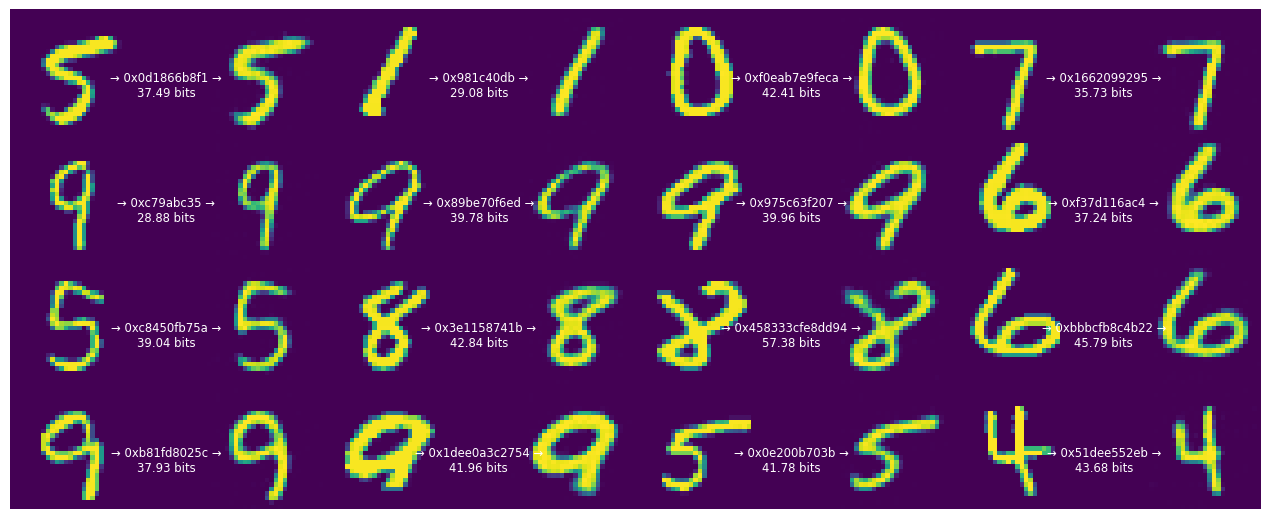

In [24]:
display_digits(originals, strings, entropies, reconstructions)


Note that the length of the encoded string differs from the information content of each digit.

This is because the range coding process works with discrete probabilities, and has a small amount of overhead. So, especially for short strings, the correspondence is only approximate. However, range coding is **asymptotically optimal**: in the limit, the expected bit count will approach the cross entropy (the expected information content), for which the rate term in the training model is an upper bound.

## The rate–distortion trade-off

Above, the model was trained for a specific trade-off (given by `lmbda=2000`) between the average number of bits used to represent each digit and the incurred error in the reconstruction.

What happens when we repeat the experiment with different values?

Let's start by reducing $\lambda$ to 500.

Epoch 1/15


  1/469 [..............................] - ETA: 15:20 - loss: 165.3918 - distortion_loss: 0.1249 - rate_loss: 102.9467 - distortion_pass_through_loss: 0.1249 - rate_pass_through_loss: 102.9467

  4/469 [..............................] - ETA: 9s - loss: 168.4773 - distortion_loss: 0.1313 - rate_loss: 102.8447 - distortion_pass_through_loss: 0.1313 - rate_pass_through_loss: 102.8447   

  7/469 [..............................] - ETA: 9s - loss: 168.7470 - distortion_loss: 0.1320 - rate_loss: 102.7238 - distortion_pass_through_loss: 0.1320 - rate_pass_through_loss: 102.7238

 10/469 [..............................] - ETA: 9s - loss: 168.7378 - distortion_loss: 0.1322 - rate_loss: 102.6140 - distortion_pass_through_loss: 0.1322 - rate_pass_through_loss: 102.6140

 13/469 [..............................] - ETA: 9s - loss: 168.3283 - distortion_loss: 0.1316 - rate_loss: 102.5085 - distortion_pass_through_loss: 0.1316 - rate_pass_through_loss: 102.5085

 16/469 [>.............................] - ETA: 9s - loss: 167.8265 - distortion_loss: 0.1308 - rate_loss: 102.4106 - distortion_pass_through_loss: 0.1308 - rate_pass_through_loss: 102.4106

 19/469 [>.............................] - ETA: 9s - loss: 167.4921 - distortion_loss: 0.1303 - rate_loss: 102.3375 - distortion_pass_through_loss: 0.1303 - rate_pass_through_loss: 102.3375

 22/469 [>.............................] - ETA: 8s - loss: 167.2854 - distortion_loss: 0.1300 - rate_loss: 102.2796 - distortion_pass_through_loss: 0.1300 - rate_pass_through_loss: 102.2796

 25/469 [>.............................] - ETA: 8s - loss: 166.7388 - distortion_loss: 0.1291 - rate_loss: 102.1833 - distortion_pass_through_loss: 0.1291 - rate_pass_through_loss: 102.1833

 28/469 [>.............................] - ETA: 8s - loss: 166.4985 - distortion_loss: 0.1288 - rate_loss: 102.0978 - distortion_pass_through_loss: 0.1288 - rate_pass_through_loss: 102.0978

 31/469 [>.............................] - ETA: 8s - loss: 166.0607 - distortion_loss: 0.1281 - rate_loss: 102.0123 - distortion_pass_through_loss: 0.1281 - rate_pass_through_loss: 102.0123

 34/469 [=>............................] - ETA: 8s - loss: 165.6610 - distortion_loss: 0.1275 - rate_loss: 101.9297 - distortion_pass_through_loss: 0.1275 - rate_pass_through_loss: 101.9297

 37/469 [=>............................] - ETA: 8s - loss: 165.1370 - distortion_loss: 0.1266 - rate_loss: 101.8464 - distortion_pass_through_loss: 0.1266 - rate_pass_through_loss: 101.8464

 40/469 [=>............................] - ETA: 8s - loss: 164.6712 - distortion_loss: 0.1258 - rate_loss: 101.7696 - distortion_pass_through_loss: 0.1258 - rate_pass_through_loss: 101.7696

 43/469 [=>............................] - ETA: 8s - loss: 164.3174 - distortion_loss: 0.1252 - rate_loss: 101.6953 - distortion_pass_through_loss: 0.1252 - rate_pass_through_loss: 101.6953

 46/469 [=>............................] - ETA: 8s - loss: 163.8453 - distortion_loss: 0.1244 - rate_loss: 101.6510 - distortion_pass_through_loss: 0.1244 - rate_pass_through_loss: 101.6510

 49/469 [==>...........................] - ETA: 8s - loss: 163.3898 - distortion_loss: 0.1235 - rate_loss: 101.6285 - distortion_pass_through_loss: 0.1235 - rate_pass_through_loss: 101.6285

 52/469 [==>...........................] - ETA: 8s - loss: 162.8784 - distortion_loss: 0.1226 - rate_loss: 101.5976 - distortion_pass_through_loss: 0.1226 - rate_pass_through_loss: 101.5976

 55/469 [==>...........................] - ETA: 8s - loss: 162.2900 - distortion_loss: 0.1215 - rate_loss: 101.5479 - distortion_pass_through_loss: 0.1215 - rate_pass_through_loss: 101.5479

 58/469 [==>...........................] - ETA: 7s - loss: 161.7579 - distortion_loss: 0.1205 - rate_loss: 101.4880 - distortion_pass_through_loss: 0.1205 - rate_pass_through_loss: 101.4880

 61/469 [==>...........................] - ETA: 7s - loss: 161.1991 - distortion_loss: 0.1195 - rate_loss: 101.4348 - distortion_pass_through_loss: 0.1195 - rate_pass_through_loss: 101.4348

 64/469 [===>..........................] - ETA: 7s - loss: 160.6874 - distortion_loss: 0.1186 - rate_loss: 101.3840 - distortion_pass_through_loss: 0.1186 - rate_pass_through_loss: 101.3840

 67/469 [===>..........................] - ETA: 7s - loss: 160.1244 - distortion_loss: 0.1176 - rate_loss: 101.3332 - distortion_pass_through_loss: 0.1176 - rate_pass_through_loss: 101.3332

 70/469 [===>..........................] - ETA: 7s - loss: 159.5391 - distortion_loss: 0.1165 - rate_loss: 101.2844 - distortion_pass_through_loss: 0.1165 - rate_pass_through_loss: 101.2844

 73/469 [===>..........................] - ETA: 7s - loss: 158.9158 - distortion_loss: 0.1154 - rate_loss: 101.2367 - distortion_pass_through_loss: 0.1154 - rate_pass_through_loss: 101.2367

 76/469 [===>..........................] - ETA: 7s - loss: 158.3858 - distortion_loss: 0.1144 - rate_loss: 101.1935 - distortion_pass_through_loss: 0.1144 - rate_pass_through_loss: 101.1935

 79/469 [====>.........................] - ETA: 7s - loss: 157.8237 - distortion_loss: 0.1134 - rate_loss: 101.1462 - distortion_pass_through_loss: 0.1134 - rate_pass_through_loss: 101.1462

 82/469 [====>.........................] - ETA: 7s - loss: 157.2996 - distortion_loss: 0.1124 - rate_loss: 101.1037 - distortion_pass_through_loss: 0.1124 - rate_pass_through_loss: 101.1037

 85/469 [====>.........................] - ETA: 7s - loss: 156.7428 - distortion_loss: 0.1114 - rate_loss: 101.0578 - distortion_pass_through_loss: 0.1114 - rate_pass_through_loss: 101.0578

 88/469 [====>.........................] - ETA: 7s - loss: 156.2169 - distortion_loss: 0.1104 - rate_loss: 101.0103 - distortion_pass_through_loss: 0.1104 - rate_pass_through_loss: 101.0103

 91/469 [====>.........................] - ETA: 7s - loss: 155.6753 - distortion_loss: 0.1094 - rate_loss: 100.9651 - distortion_pass_through_loss: 0.1094 - rate_pass_through_loss: 100.9651

 94/469 [=====>........................] - ETA: 7s - loss: 155.1914 - distortion_loss: 0.1086 - rate_loss: 100.9155 - distortion_pass_through_loss: 0.1086 - rate_pass_through_loss: 100.9155

 97/469 [=====>........................] - ETA: 7s - loss: 154.6753 - distortion_loss: 0.1076 - rate_loss: 100.8670 - distortion_pass_through_loss: 0.1076 - rate_pass_through_loss: 100.8670

100/469 [=====>........................] - ETA: 7s - loss: 154.2195 - distortion_loss: 0.1068 - rate_loss: 100.8207 - distortion_pass_through_loss: 0.1068 - rate_pass_through_loss: 100.8207

103/469 [=====>........................] - ETA: 7s - loss: 153.7610 - distortion_loss: 0.1060 - rate_loss: 100.7701 - distortion_pass_through_loss: 0.1060 - rate_pass_through_loss: 100.7701

106/469 [=====>........................] - ETA: 6s - loss: 153.2817 - distortion_loss: 0.1051 - rate_loss: 100.7177 - distortion_pass_through_loss: 0.1051 - rate_pass_through_loss: 100.7177

109/469 [=====>........................] - ETA: 6s - loss: 152.8204 - distortion_loss: 0.1043 - rate_loss: 100.6648 - distortion_pass_through_loss: 0.1043 - rate_pass_through_loss: 100.6648

112/469 [======>.......................] - ETA: 6s - loss: 152.4071 - distortion_loss: 0.1036 - rate_loss: 100.6171 - distortion_pass_through_loss: 0.1036 - rate_pass_through_loss: 100.6171

115/469 [======>.......................] - ETA: 6s - loss: 152.0171 - distortion_loss: 0.1029 - rate_loss: 100.5643 - distortion_pass_through_loss: 0.1029 - rate_pass_through_loss: 100.5643

118/469 [======>.......................] - ETA: 6s - loss: 151.5734 - distortion_loss: 0.1021 - rate_loss: 100.5124 - distortion_pass_through_loss: 0.1021 - rate_pass_through_loss: 100.5124

121/469 [======>.......................] - ETA: 6s - loss: 151.1571 - distortion_loss: 0.1014 - rate_loss: 100.4578 - distortion_pass_through_loss: 0.1014 - rate_pass_through_loss: 100.4578

124/469 [======>.......................] - ETA: 6s - loss: 150.7541 - distortion_loss: 0.1007 - rate_loss: 100.4018 - distortion_pass_through_loss: 0.1007 - rate_pass_through_loss: 100.4018

127/469 [=======>......................] - ETA: 6s - loss: 150.3428 - distortion_loss: 0.1000 - rate_loss: 100.3487 - distortion_pass_through_loss: 0.1000 - rate_pass_through_loss: 100.3487

130/469 [=======>......................] - ETA: 6s - loss: 149.9431 - distortion_loss: 0.0993 - rate_loss: 100.2900 - distortion_pass_through_loss: 0.0993 - rate_pass_through_loss: 100.2900

133/469 [=======>......................] - ETA: 6s - loss: 149.5513 - distortion_loss: 0.0986 - rate_loss: 100.2319 - distortion_pass_through_loss: 0.0986 - rate_pass_through_loss: 100.2319

136/469 [=======>......................] - ETA: 6s - loss: 149.1859 - distortion_loss: 0.0980 - rate_loss: 100.1775 - distortion_pass_through_loss: 0.0980 - rate_pass_through_loss: 100.1775

139/469 [=======>......................] - ETA: 6s - loss: 148.8418 - distortion_loss: 0.0974 - rate_loss: 100.1264 - distortion_pass_through_loss: 0.0974 - rate_pass_through_loss: 100.1264

142/469 [========>.....................] - ETA: 6s - loss: 148.4850 - distortion_loss: 0.0968 - rate_loss: 100.0682 - distortion_pass_through_loss: 0.0968 - rate_pass_through_loss: 100.0682

145/469 [========>.....................] - ETA: 6s - loss: 148.1423 - distortion_loss: 0.0963 - rate_loss: 100.0116 - distortion_pass_through_loss: 0.0963 - rate_pass_through_loss: 100.0116

148/469 [========>.....................] - ETA: 6s - loss: 147.8099 - distortion_loss: 0.0957 - rate_loss: 99.9525 - distortion_pass_through_loss: 0.0957 - rate_pass_through_loss: 99.9525  

151/469 [========>.....................] - ETA: 6s - loss: 147.4805 - distortion_loss: 0.0952 - rate_loss: 99.8919 - distortion_pass_through_loss: 0.0952 - rate_pass_through_loss: 99.8919

154/469 [========>.....................] - ETA: 6s - loss: 147.1794 - distortion_loss: 0.0947 - rate_loss: 99.8365 - distortion_pass_through_loss: 0.0947 - rate_pass_through_loss: 99.8365

157/469 [=========>....................] - ETA: 6s - loss: 146.8685 - distortion_loss: 0.0942 - rate_loss: 99.7812 - distortion_pass_through_loss: 0.0942 - rate_pass_through_loss: 99.7812

160/469 [=========>....................] - ETA: 6s - loss: 146.5665 - distortion_loss: 0.0937 - rate_loss: 99.7219 - distortion_pass_through_loss: 0.0937 - rate_pass_through_loss: 99.7219

163/469 [=========>....................] - ETA: 5s - loss: 146.2462 - distortion_loss: 0.0932 - rate_loss: 99.6604 - distortion_pass_through_loss: 0.0932 - rate_pass_through_loss: 99.6604

166/469 [=========>....................] - ETA: 5s - loss: 145.9478 - distortion_loss: 0.0927 - rate_loss: 99.6001 - distortion_pass_through_loss: 0.0927 - rate_pass_through_loss: 99.6001

169/469 [=========>....................] - ETA: 5s - loss: 145.6597 - distortion_loss: 0.0922 - rate_loss: 99.5390 - distortion_pass_through_loss: 0.0922 - rate_pass_through_loss: 99.5390

172/469 [==========>...................] - ETA: 5s - loss: 145.3621 - distortion_loss: 0.0918 - rate_loss: 99.4772 - distortion_pass_through_loss: 0.0918 - rate_pass_through_loss: 99.4772

175/469 [==========>...................] - ETA: 5s - loss: 145.0897 - distortion_loss: 0.0913 - rate_loss: 99.4189 - distortion_pass_through_loss: 0.0913 - rate_pass_through_loss: 99.4189

178/469 [==========>...................] - ETA: 5s - loss: 144.8095 - distortion_loss: 0.0909 - rate_loss: 99.3569 - distortion_pass_through_loss: 0.0909 - rate_pass_through_loss: 99.3569

181/469 [==========>...................] - ETA: 5s - loss: 144.5388 - distortion_loss: 0.0905 - rate_loss: 99.2972 - distortion_pass_through_loss: 0.0905 - rate_pass_through_loss: 99.2972

184/469 [==========>...................] - ETA: 5s - loss: 144.2733 - distortion_loss: 0.0901 - rate_loss: 99.2375 - distortion_pass_through_loss: 0.0901 - rate_pass_through_loss: 99.2375

187/469 [==========>...................] - ETA: 5s - loss: 143.9978 - distortion_loss: 0.0897 - rate_loss: 99.1717 - distortion_pass_through_loss: 0.0897 - rate_pass_through_loss: 99.1717

190/469 [===========>..................] - ETA: 5s - loss: 143.7421 - distortion_loss: 0.0893 - rate_loss: 99.1108 - distortion_pass_through_loss: 0.0893 - rate_pass_through_loss: 99.1108

193/469 [===========>..................] - ETA: 5s - loss: 143.4838 - distortion_loss: 0.0889 - rate_loss: 99.0477 - distortion_pass_through_loss: 0.0889 - rate_pass_through_loss: 99.0477

196/469 [===========>..................] - ETA: 5s - loss: 143.2299 - distortion_loss: 0.0885 - rate_loss: 98.9840 - distortion_pass_through_loss: 0.0885 - rate_pass_through_loss: 98.9840

199/469 [===========>..................] - ETA: 5s - loss: 142.9667 - distortion_loss: 0.0881 - rate_loss: 98.9218 - distortion_pass_through_loss: 0.0881 - rate_pass_through_loss: 98.9218

202/469 [===========>..................] - ETA: 5s - loss: 142.7124 - distortion_loss: 0.0877 - rate_loss: 98.8541 - distortion_pass_through_loss: 0.0877 - rate_pass_through_loss: 98.8541

205/469 [============>.................] - ETA: 5s - loss: 142.4599 - distortion_loss: 0.0873 - rate_loss: 98.7911 - distortion_pass_through_loss: 0.0873 - rate_pass_through_loss: 98.7911

208/469 [============>.................] - ETA: 5s - loss: 142.2088 - distortion_loss: 0.0870 - rate_loss: 98.7280 - distortion_pass_through_loss: 0.0870 - rate_pass_through_loss: 98.7280

211/469 [============>.................] - ETA: 5s - loss: 141.9543 - distortion_loss: 0.0866 - rate_loss: 98.6609 - distortion_pass_through_loss: 0.0866 - rate_pass_through_loss: 98.6609

214/469 [============>.................] - ETA: 4s - loss: 141.7167 - distortion_loss: 0.0862 - rate_loss: 98.5983 - distortion_pass_through_loss: 0.0862 - rate_pass_through_loss: 98.5983

217/469 [============>.................] - ETA: 4s - loss: 141.4792 - distortion_loss: 0.0859 - rate_loss: 98.5330 - distortion_pass_through_loss: 0.0859 - rate_pass_through_loss: 98.5330

220/469 [=============>................] - ETA: 4s - loss: 141.2490 - distortion_loss: 0.0856 - rate_loss: 98.4675 - distortion_pass_through_loss: 0.0856 - rate_pass_through_loss: 98.4675

223/469 [=============>................] - ETA: 4s - loss: 141.0239 - distortion_loss: 0.0852 - rate_loss: 98.4005 - distortion_pass_through_loss: 0.0852 - rate_pass_through_loss: 98.4005

226/469 [=============>................] - ETA: 4s - loss: 140.7893 - distortion_loss: 0.0849 - rate_loss: 98.3335 - distortion_pass_through_loss: 0.0849 - rate_pass_through_loss: 98.3335

229/469 [=============>................] - ETA: 4s - loss: 140.5748 - distortion_loss: 0.0846 - rate_loss: 98.2684 - distortion_pass_through_loss: 0.0846 - rate_pass_through_loss: 98.2684

232/469 [=============>................] - ETA: 4s - loss: 140.3638 - distortion_loss: 0.0843 - rate_loss: 98.2043 - distortion_pass_through_loss: 0.0843 - rate_pass_through_loss: 98.2043

235/469 [==============>...............] - ETA: 4s - loss: 140.1447 - distortion_loss: 0.0840 - rate_loss: 98.1368 - distortion_pass_through_loss: 0.0840 - rate_pass_through_loss: 98.1368

238/469 [==============>...............] - ETA: 4s - loss: 139.9298 - distortion_loss: 0.0837 - rate_loss: 98.0710 - distortion_pass_through_loss: 0.0837 - rate_pass_through_loss: 98.0710

241/469 [==============>...............] - ETA: 4s - loss: 139.7178 - distortion_loss: 0.0834 - rate_loss: 98.0033 - distortion_pass_through_loss: 0.0834 - rate_pass_through_loss: 98.0033

244/469 [==============>...............] - ETA: 4s - loss: 139.5005 - distortion_loss: 0.0831 - rate_loss: 97.9352 - distortion_pass_through_loss: 0.0831 - rate_pass_through_loss: 97.9352

247/469 [==============>...............] - ETA: 4s - loss: 139.3073 - distortion_loss: 0.0829 - rate_loss: 97.8697 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 97.8697

250/469 [==============>...............] - ETA: 4s - loss: 139.1100 - distortion_loss: 0.0826 - rate_loss: 97.8020 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 97.8020

253/469 [===============>..............] - ETA: 4s - loss: 138.9076 - distortion_loss: 0.0823 - rate_loss: 97.7333 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 97.7333

256/469 [===============>..............] - ETA: 4s - loss: 138.7008 - distortion_loss: 0.0821 - rate_loss: 97.6646 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 97.6646

259/469 [===============>..............] - ETA: 4s - loss: 138.5033 - distortion_loss: 0.0818 - rate_loss: 97.5972 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 97.5972

262/469 [===============>..............] - ETA: 4s - loss: 138.3038 - distortion_loss: 0.0815 - rate_loss: 97.5305 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 97.5305

265/469 [===============>..............] - ETA: 3s - loss: 138.1032 - distortion_loss: 0.0813 - rate_loss: 97.4616 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 97.4616

268/469 [================>.............] - ETA: 3s - loss: 137.9040 - distortion_loss: 0.0810 - rate_loss: 97.3939 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 97.3939

271/469 [================>.............] - ETA: 3s - loss: 137.7126 - distortion_loss: 0.0808 - rate_loss: 97.3249 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 97.3249

274/469 [================>.............] - ETA: 3s - loss: 137.5257 - distortion_loss: 0.0805 - rate_loss: 97.2551 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 97.2551

277/469 [================>.............] - ETA: 3s - loss: 137.3386 - distortion_loss: 0.0803 - rate_loss: 97.1863 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 97.1863

280/469 [================>.............] - ETA: 3s - loss: 137.1469 - distortion_loss: 0.0801 - rate_loss: 97.1177 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 97.1177

283/469 [=================>............] - ETA: 3s - loss: 136.9776 - distortion_loss: 0.0799 - rate_loss: 97.0480 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 97.0480

286/469 [=================>............] - ETA: 3s - loss: 136.8017 - distortion_loss: 0.0796 - rate_loss: 96.9817 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 96.9817

289/469 [=================>............] - ETA: 3s - loss: 136.6233 - distortion_loss: 0.0794 - rate_loss: 96.9095 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 96.9095

292/469 [=================>............] - ETA: 3s - loss: 136.4388 - distortion_loss: 0.0792 - rate_loss: 96.8392 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 96.8392

295/469 [=================>............] - ETA: 3s - loss: 136.2582 - distortion_loss: 0.0790 - rate_loss: 96.7668 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 96.7668

298/469 [==================>...........] - ETA: 3s - loss: 136.0756 - distortion_loss: 0.0788 - rate_loss: 96.6953 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 96.6953

301/469 [==================>...........] - ETA: 3s - loss: 135.9059 - distortion_loss: 0.0786 - rate_loss: 96.6278 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 96.6278

304/469 [==================>...........] - ETA: 3s - loss: 135.7257 - distortion_loss: 0.0783 - rate_loss: 96.5555 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 96.5555

307/469 [==================>...........] - ETA: 3s - loss: 135.5576 - distortion_loss: 0.0781 - rate_loss: 96.4843 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 96.4843

310/469 [==================>...........] - ETA: 3s - loss: 135.3905 - distortion_loss: 0.0780 - rate_loss: 96.4146 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 96.4146

313/469 [===================>..........] - ETA: 3s - loss: 135.2243 - distortion_loss: 0.0778 - rate_loss: 96.3430 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 96.3430

316/469 [===================>..........] - ETA: 2s - loss: 135.0565 - distortion_loss: 0.0776 - rate_loss: 96.2723 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 96.2723

319/469 [===================>..........] - ETA: 2s - loss: 134.8876 - distortion_loss: 0.0774 - rate_loss: 96.2024 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 96.2024

322/469 [===================>..........] - ETA: 2s - loss: 134.7244 - distortion_loss: 0.0772 - rate_loss: 96.1305 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 96.1305

325/469 [===================>..........] - ETA: 2s - loss: 134.5563 - distortion_loss: 0.0770 - rate_loss: 96.0585 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 96.0585

328/469 [===================>..........] - ETA: 2s - loss: 134.3945 - distortion_loss: 0.0768 - rate_loss: 95.9868 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 95.9868

331/469 [====================>.........] - ETA: 2s - loss: 134.2314 - distortion_loss: 0.0766 - rate_loss: 95.9173 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 95.9173

334/469 [====================>.........] - ETA: 2s - loss: 134.0726 - distortion_loss: 0.0765 - rate_loss: 95.8454 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 95.8454

337/469 [====================>.........] - ETA: 2s - loss: 133.9147 - distortion_loss: 0.0763 - rate_loss: 95.7749 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 95.7749

340/469 [====================>.........] - ETA: 2s - loss: 133.7556 - distortion_loss: 0.0761 - rate_loss: 95.7044 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 95.7044

343/469 [====================>.........] - ETA: 2s - loss: 133.5954 - distortion_loss: 0.0759 - rate_loss: 95.6307 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 95.6307

346/469 [=====================>........] - ETA: 2s - loss: 133.4358 - distortion_loss: 0.0758 - rate_loss: 95.5568 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 95.5568

349/469 [=====================>........] - ETA: 2s - loss: 133.2893 - distortion_loss: 0.0756 - rate_loss: 95.4856 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 95.4856

352/469 [=====================>........] - ETA: 2s - loss: 133.1391 - distortion_loss: 0.0755 - rate_loss: 95.4124 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 95.4124

355/469 [=====================>........] - ETA: 2s - loss: 132.9867 - distortion_loss: 0.0753 - rate_loss: 95.3402 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 95.3402

358/469 [=====================>........] - ETA: 2s - loss: 132.8370 - distortion_loss: 0.0751 - rate_loss: 95.2680 - distortion_pass_through_loss: 0.0751 - rate_pass_through_loss: 95.2680

361/469 [======================>.......] - ETA: 2s - loss: 132.6915 - distortion_loss: 0.0750 - rate_loss: 95.1957 - distortion_pass_through_loss: 0.0750 - rate_pass_through_loss: 95.1957

364/469 [======================>.......] - ETA: 2s - loss: 132.5453 - distortion_loss: 0.0748 - rate_loss: 95.1242 - distortion_pass_through_loss: 0.0748 - rate_pass_through_loss: 95.1242

367/469 [======================>.......] - ETA: 1s - loss: 132.3965 - distortion_loss: 0.0747 - rate_loss: 95.0504 - distortion_pass_through_loss: 0.0747 - rate_pass_through_loss: 95.0504

370/469 [======================>.......] - ETA: 1s - loss: 132.2477 - distortion_loss: 0.0745 - rate_loss: 94.9754 - distortion_pass_through_loss: 0.0745 - rate_pass_through_loss: 94.9754

373/469 [======================>.......] - ETA: 1s - loss: 132.0985 - distortion_loss: 0.0744 - rate_loss: 94.9038 - distortion_pass_through_loss: 0.0744 - rate_pass_through_loss: 94.9038

376/469 [=======================>......] - ETA: 1s - loss: 131.9503 - distortion_loss: 0.0742 - rate_loss: 94.8301 - distortion_pass_through_loss: 0.0742 - rate_pass_through_loss: 94.8301

379/469 [=======================>......] - ETA: 1s - loss: 131.8038 - distortion_loss: 0.0741 - rate_loss: 94.7558 - distortion_pass_through_loss: 0.0741 - rate_pass_through_loss: 94.7558

382/469 [=======================>......] - ETA: 1s - loss: 131.6614 - distortion_loss: 0.0740 - rate_loss: 94.6845 - distortion_pass_through_loss: 0.0740 - rate_pass_through_loss: 94.6845

385/469 [=======================>......] - ETA: 1s - loss: 131.5169 - distortion_loss: 0.0738 - rate_loss: 94.6106 - distortion_pass_through_loss: 0.0738 - rate_pass_through_loss: 94.6106

388/469 [=======================>......] - ETA: 1s - loss: 131.3796 - distortion_loss: 0.0737 - rate_loss: 94.5386 - distortion_pass_through_loss: 0.0737 - rate_pass_through_loss: 94.5386

391/469 [========================>.....] - ETA: 1s - loss: 131.2322 - distortion_loss: 0.0735 - rate_loss: 94.4655 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 94.4655

394/469 [========================>.....] - ETA: 1s - loss: 131.0921 - distortion_loss: 0.0734 - rate_loss: 94.3922 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 94.3922

397/469 [========================>.....] - ETA: 1s - loss: 130.9502 - distortion_loss: 0.0733 - rate_loss: 94.3195 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 94.3195

400/469 [========================>.....] - ETA: 1s - loss: 130.8077 - distortion_loss: 0.0731 - rate_loss: 94.2446 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 94.2446

403/469 [========================>.....] - ETA: 1s - loss: 130.6609 - distortion_loss: 0.0730 - rate_loss: 94.1704 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 94.1704

406/469 [========================>.....] - ETA: 1s - loss: 130.5272 - distortion_loss: 0.0729 - rate_loss: 94.0966 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 94.0966

409/469 [=========================>....] - ETA: 1s - loss: 130.3896 - distortion_loss: 0.0727 - rate_loss: 94.0235 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 94.0235

412/469 [=========================>....] - ETA: 1s - loss: 130.2616 - distortion_loss: 0.0726 - rate_loss: 93.9505 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 93.9505

415/469 [=========================>....] - ETA: 1s - loss: 130.1282 - distortion_loss: 0.0725 - rate_loss: 93.8768 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 93.8768

418/469 [=========================>....] - ETA: 0s - loss: 129.9944 - distortion_loss: 0.0724 - rate_loss: 93.8025 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 93.8025

421/469 [=========================>....] - ETA: 0s - loss: 129.8612 - distortion_loss: 0.0723 - rate_loss: 93.7292 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 93.7292

424/469 [==========================>...] - ETA: 0s - loss: 129.7267 - distortion_loss: 0.0721 - rate_loss: 93.6546 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 93.6546

427/469 [==========================>...] - ETA: 0s - loss: 129.5958 - distortion_loss: 0.0720 - rate_loss: 93.5819 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 93.5819

430/469 [==========================>...] - ETA: 0s - loss: 129.4682 - distortion_loss: 0.0719 - rate_loss: 93.5091 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 93.5091

433/469 [==========================>...] - ETA: 0s - loss: 129.3378 - distortion_loss: 0.0718 - rate_loss: 93.4349 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 93.4349

436/469 [==========================>...] - ETA: 0s - loss: 129.2049 - distortion_loss: 0.0717 - rate_loss: 93.3604 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 93.3604

439/469 [===========================>..] - ETA: 0s - loss: 129.0764 - distortion_loss: 0.0716 - rate_loss: 93.2872 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 93.2872

442/469 [===========================>..] - ETA: 0s - loss: 128.9479 - distortion_loss: 0.0715 - rate_loss: 93.2145 - distortion_pass_through_loss: 0.0715 - rate_pass_through_loss: 93.2145

445/469 [===========================>..] - ETA: 0s - loss: 128.8161 - distortion_loss: 0.0714 - rate_loss: 93.1401 - distortion_pass_through_loss: 0.0714 - rate_pass_through_loss: 93.1401

448/469 [===========================>..] - ETA: 0s - loss: 128.6913 - distortion_loss: 0.0712 - rate_loss: 93.0665 - distortion_pass_through_loss: 0.0712 - rate_pass_through_loss: 93.0665

451/469 [===========================>..] - ETA: 0s - loss: 128.5647 - distortion_loss: 0.0711 - rate_loss: 92.9920 - distortion_pass_through_loss: 0.0711 - rate_pass_through_loss: 92.9920

454/469 [============================>.] - ETA: 0s - loss: 128.4359 - distortion_loss: 0.0710 - rate_loss: 92.9184 - distortion_pass_through_loss: 0.0710 - rate_pass_through_loss: 92.9184

457/469 [============================>.] - ETA: 0s - loss: 128.3096 - distortion_loss: 0.0709 - rate_loss: 92.8458 - distortion_pass_through_loss: 0.0709 - rate_pass_through_loss: 92.8458

460/469 [============================>.] - ETA: 0s - loss: 128.1885 - distortion_loss: 0.0708 - rate_loss: 92.7731 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 92.7731

463/469 [============================>.] - ETA: 0s - loss: 128.0655 - distortion_loss: 0.0707 - rate_loss: 92.7000 - distortion_pass_through_loss: 0.0707 - rate_pass_through_loss: 92.7000

466/469 [============================>.] - ETA: 0s - loss: 127.9451 - distortion_loss: 0.0706 - rate_loss: 92.6249 - distortion_pass_through_loss: 0.0706 - rate_pass_through_loss: 92.6249

469/469 [==============================] - ETA: 0s - loss: 127.8276 - distortion_loss: 0.0705 - rate_loss: 92.5567 - distortion_pass_through_loss: 0.0705 - rate_pass_through_loss: 92.5504

469/469 [==============================] - 12s 21ms/step - loss: 127.8276 - distortion_loss: 0.0705 - rate_loss: 92.5567 - distortion_pass_through_loss: 0.0705 - rate_pass_through_loss: 92.5504 - val_loss: 108.3089 - val_distortion_loss: 0.0574 - val_rate_loss: 79.6299 - val_distortion_pass_through_loss: 0.0574 - val_rate_pass_through_loss: 79.6331


Epoch 2/15


  1/469 [..............................] - ETA: 12s - loss: 106.5492 - distortion_loss: 0.0517 - rate_loss: 80.7096 - distortion_pass_through_loss: 0.0517 - rate_pass_through_loss: 80.7096

  4/469 [..............................] - ETA: 8s - loss: 107.9845 - distortion_loss: 0.0546 - rate_loss: 80.6736 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 80.6736 

  7/469 [..............................] - ETA: 8s - loss: 108.3203 - distortion_loss: 0.0551 - rate_loss: 80.7945 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 80.7945

 10/469 [..............................] - ETA: 8s - loss: 108.4679 - distortion_loss: 0.0553 - rate_loss: 80.7936 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 80.7936

 13/469 [..............................] - ETA: 8s - loss: 108.2797 - distortion_loss: 0.0552 - rate_loss: 80.6895 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 80.6895

 16/469 [>.............................] - ETA: 8s - loss: 108.0983 - distortion_loss: 0.0550 - rate_loss: 80.6035 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 80.6035

 19/469 [>.............................] - ETA: 8s - loss: 108.0657 - distortion_loss: 0.0551 - rate_loss: 80.4947 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 80.4947

 22/469 [>.............................] - ETA: 8s - loss: 108.0566 - distortion_loss: 0.0553 - rate_loss: 80.4276 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 80.4276

 25/469 [>.............................] - ETA: 8s - loss: 107.9643 - distortion_loss: 0.0552 - rate_loss: 80.3635 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 80.3635

 28/469 [>.............................] - ETA: 8s - loss: 107.9327 - distortion_loss: 0.0553 - rate_loss: 80.3043 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 80.3043

 31/469 [>.............................] - ETA: 8s - loss: 107.8371 - distortion_loss: 0.0552 - rate_loss: 80.2434 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 80.2434

 34/469 [=>............................] - ETA: 8s - loss: 107.7874 - distortion_loss: 0.0552 - rate_loss: 80.1753 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 80.1753

 37/469 [=>............................] - ETA: 8s - loss: 107.6358 - distortion_loss: 0.0551 - rate_loss: 80.0949 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 80.0949

 40/469 [=>............................] - ETA: 8s - loss: 107.5498 - distortion_loss: 0.0550 - rate_loss: 80.0282 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 80.0282

 43/469 [=>............................] - ETA: 8s - loss: 107.4686 - distortion_loss: 0.0550 - rate_loss: 79.9563 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 79.9563

 46/469 [=>............................] - ETA: 7s - loss: 107.3811 - distortion_loss: 0.0550 - rate_loss: 79.8750 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 79.8750

 49/469 [==>...........................] - ETA: 7s - loss: 107.3439 - distortion_loss: 0.0551 - rate_loss: 79.7993 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 79.7993

 52/469 [==>...........................] - ETA: 7s - loss: 107.2919 - distortion_loss: 0.0551 - rate_loss: 79.7402 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 79.7402

 55/469 [==>...........................] - ETA: 7s - loss: 107.2070 - distortion_loss: 0.0551 - rate_loss: 79.6782 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 79.6782

 58/469 [==>...........................] - ETA: 7s - loss: 107.1136 - distortion_loss: 0.0550 - rate_loss: 79.6026 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 79.6026

 61/469 [==>...........................] - ETA: 7s - loss: 107.0365 - distortion_loss: 0.0550 - rate_loss: 79.5348 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 79.5348

 64/469 [===>..........................] - ETA: 7s - loss: 106.9939 - distortion_loss: 0.0551 - rate_loss: 79.4638 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 79.4638

 67/469 [===>..........................] - ETA: 7s - loss: 106.9304 - distortion_loss: 0.0551 - rate_loss: 79.3900 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 79.3900

 70/469 [===>..........................] - ETA: 7s - loss: 106.8381 - distortion_loss: 0.0551 - rate_loss: 79.3098 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 79.3098

 73/469 [===>..........................] - ETA: 7s - loss: 106.7297 - distortion_loss: 0.0550 - rate_loss: 79.2517 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 79.2517

 76/469 [===>..........................] - ETA: 7s - loss: 106.6654 - distortion_loss: 0.0550 - rate_loss: 79.1744 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 79.1744

 79/469 [====>.........................] - ETA: 7s - loss: 106.5918 - distortion_loss: 0.0550 - rate_loss: 79.0986 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 79.0986

 82/469 [====>.........................] - ETA: 7s - loss: 106.5147 - distortion_loss: 0.0550 - rate_loss: 79.0242 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 79.0242

 85/469 [====>.........................] - ETA: 7s - loss: 106.4146 - distortion_loss: 0.0549 - rate_loss: 78.9582 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 78.9582

 88/469 [====>.........................] - ETA: 7s - loss: 106.3228 - distortion_loss: 0.0549 - rate_loss: 78.8848 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 78.8848

 91/469 [====>.........................] - ETA: 7s - loss: 106.2186 - distortion_loss: 0.0548 - rate_loss: 78.8044 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.8044

 94/469 [=====>........................] - ETA: 7s - loss: 106.1421 - distortion_loss: 0.0548 - rate_loss: 78.7250 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.7250

 97/469 [=====>........................] - ETA: 7s - loss: 106.0424 - distortion_loss: 0.0548 - rate_loss: 78.6477 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.6477

100/469 [=====>........................] - ETA: 6s - loss: 105.9773 - distortion_loss: 0.0548 - rate_loss: 78.5771 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.5771

103/469 [=====>........................] - ETA: 6s - loss: 105.9157 - distortion_loss: 0.0548 - rate_loss: 78.4997 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.4997

106/469 [=====>........................] - ETA: 6s - loss: 105.8224 - distortion_loss: 0.0548 - rate_loss: 78.4260 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.4260

109/469 [=====>........................] - ETA: 6s - loss: 105.7284 - distortion_loss: 0.0548 - rate_loss: 78.3477 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.3477

112/469 [======>.......................] - ETA: 6s - loss: 105.6712 - distortion_loss: 0.0548 - rate_loss: 78.2762 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.2762

115/469 [======>.......................] - ETA: 6s - loss: 105.6255 - distortion_loss: 0.0548 - rate_loss: 78.2007 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.2007

118/469 [======>.......................] - ETA: 6s - loss: 105.5255 - distortion_loss: 0.0548 - rate_loss: 78.1248 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.1248

121/469 [======>.......................] - ETA: 6s - loss: 105.4398 - distortion_loss: 0.0548 - rate_loss: 78.0542 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 78.0542

124/469 [======>.......................] - ETA: 6s - loss: 105.3576 - distortion_loss: 0.0548 - rate_loss: 77.9797 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 77.9797

127/469 [=======>......................] - ETA: 6s - loss: 105.2670 - distortion_loss: 0.0547 - rate_loss: 77.9084 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 77.9084

130/469 [=======>......................] - ETA: 6s - loss: 105.1724 - distortion_loss: 0.0547 - rate_loss: 77.8235 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 77.8235

133/469 [=======>......................] - ETA: 6s - loss: 105.0803 - distortion_loss: 0.0547 - rate_loss: 77.7465 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 77.7465

136/469 [=======>......................] - ETA: 6s - loss: 105.0075 - distortion_loss: 0.0547 - rate_loss: 77.6752 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 77.6752

139/469 [=======>......................] - ETA: 6s - loss: 104.9436 - distortion_loss: 0.0547 - rate_loss: 77.6095 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 77.6095

142/469 [========>.....................] - ETA: 6s - loss: 104.8643 - distortion_loss: 0.0547 - rate_loss: 77.5381 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 77.5381

145/469 [========>.....................] - ETA: 6s - loss: 104.7918 - distortion_loss: 0.0546 - rate_loss: 77.4691 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 77.4691

148/469 [========>.....................] - ETA: 6s - loss: 104.7207 - distortion_loss: 0.0546 - rate_loss: 77.3961 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 77.3961

151/469 [========>.....................] - ETA: 5s - loss: 104.6440 - distortion_loss: 0.0546 - rate_loss: 77.3219 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 77.3219

154/469 [========>.....................] - ETA: 5s - loss: 104.5851 - distortion_loss: 0.0546 - rate_loss: 77.2609 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 77.2609

157/469 [=========>....................] - ETA: 5s - loss: 104.5210 - distortion_loss: 0.0547 - rate_loss: 77.1889 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 77.1889

160/469 [=========>....................] - ETA: 5s - loss: 104.4600 - distortion_loss: 0.0547 - rate_loss: 77.1194 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 77.1194

163/469 [=========>....................] - ETA: 5s - loss: 104.3826 - distortion_loss: 0.0547 - rate_loss: 77.0414 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 77.0414

166/469 [=========>....................] - ETA: 5s - loss: 104.3189 - distortion_loss: 0.0547 - rate_loss: 76.9737 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.9737

169/469 [=========>....................] - ETA: 5s - loss: 104.2492 - distortion_loss: 0.0547 - rate_loss: 76.9016 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.9016

172/469 [==========>...................] - ETA: 5s - loss: 104.1674 - distortion_loss: 0.0547 - rate_loss: 76.8314 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.8314

175/469 [==========>...................] - ETA: 5s - loss: 104.1056 - distortion_loss: 0.0547 - rate_loss: 76.7625 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.7625

178/469 [==========>...................] - ETA: 5s - loss: 104.0336 - distortion_loss: 0.0547 - rate_loss: 76.6907 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.6907

181/469 [==========>...................] - ETA: 5s - loss: 103.9704 - distortion_loss: 0.0547 - rate_loss: 76.6233 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.6233

184/469 [==========>...................] - ETA: 5s - loss: 103.9047 - distortion_loss: 0.0547 - rate_loss: 76.5515 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.5515

187/469 [==========>...................] - ETA: 5s - loss: 103.8291 - distortion_loss: 0.0547 - rate_loss: 76.4819 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.4819

190/469 [===========>..................] - ETA: 5s - loss: 103.7742 - distortion_loss: 0.0547 - rate_loss: 76.4172 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.4172

193/469 [===========>..................] - ETA: 5s - loss: 103.7090 - distortion_loss: 0.0547 - rate_loss: 76.3476 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.3476

196/469 [===========>..................] - ETA: 5s - loss: 103.6358 - distortion_loss: 0.0547 - rate_loss: 76.2792 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.2792

199/469 [===========>..................] - ETA: 5s - loss: 103.5556 - distortion_loss: 0.0547 - rate_loss: 76.2031 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.2031

202/469 [===========>..................] - ETA: 5s - loss: 103.4780 - distortion_loss: 0.0547 - rate_loss: 76.1318 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.1318

205/469 [============>.................] - ETA: 4s - loss: 103.4006 - distortion_loss: 0.0547 - rate_loss: 76.0651 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 76.0651

208/469 [============>.................] - ETA: 4s - loss: 103.3224 - distortion_loss: 0.0547 - rate_loss: 75.9943 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 75.9943

211/469 [============>.................] - ETA: 4s - loss: 103.2402 - distortion_loss: 0.0546 - rate_loss: 75.9221 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.9221

214/469 [============>.................] - ETA: 4s - loss: 103.1688 - distortion_loss: 0.0546 - rate_loss: 75.8496 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.8496

217/469 [============>.................] - ETA: 4s - loss: 103.0964 - distortion_loss: 0.0546 - rate_loss: 75.7783 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.7783

220/469 [=============>................] - ETA: 4s - loss: 103.0255 - distortion_loss: 0.0546 - rate_loss: 75.7113 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.7113

223/469 [=============>................] - ETA: 4s - loss: 102.9592 - distortion_loss: 0.0546 - rate_loss: 75.6415 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.6415

226/469 [=============>................] - ETA: 4s - loss: 102.8821 - distortion_loss: 0.0546 - rate_loss: 75.5726 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.5726

229/469 [=============>................] - ETA: 4s - loss: 102.8192 - distortion_loss: 0.0546 - rate_loss: 75.5051 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.5051

232/469 [=============>................] - ETA: 4s - loss: 102.7620 - distortion_loss: 0.0546 - rate_loss: 75.4412 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.4412

235/469 [==============>...............] - ETA: 4s - loss: 102.6863 - distortion_loss: 0.0546 - rate_loss: 75.3713 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.3713

238/469 [==============>...............] - ETA: 4s - loss: 102.6133 - distortion_loss: 0.0546 - rate_loss: 75.3027 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.3027

241/469 [==============>...............] - ETA: 4s - loss: 102.5421 - distortion_loss: 0.0546 - rate_loss: 75.2340 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.2340

244/469 [==============>...............] - ETA: 4s - loss: 102.4664 - distortion_loss: 0.0546 - rate_loss: 75.1618 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.1618

247/469 [==============>...............] - ETA: 4s - loss: 102.4076 - distortion_loss: 0.0546 - rate_loss: 75.0966 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.0966

250/469 [==============>...............] - ETA: 4s - loss: 102.3430 - distortion_loss: 0.0546 - rate_loss: 75.0291 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 75.0291

253/469 [===============>..............] - ETA: 4s - loss: 102.2730 - distortion_loss: 0.0546 - rate_loss: 74.9636 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.9636

256/469 [===============>..............] - ETA: 3s - loss: 102.1974 - distortion_loss: 0.0546 - rate_loss: 74.8912 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.8912

259/469 [===============>..............] - ETA: 3s - loss: 102.1306 - distortion_loss: 0.0546 - rate_loss: 74.8234 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.8234

262/469 [===============>..............] - ETA: 3s - loss: 102.0618 - distortion_loss: 0.0546 - rate_loss: 74.7542 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.7542

265/469 [===============>..............] - ETA: 3s - loss: 101.9887 - distortion_loss: 0.0546 - rate_loss: 74.6843 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.6843

268/469 [================>.............] - ETA: 3s - loss: 101.9154 - distortion_loss: 0.0546 - rate_loss: 74.6176 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.6176

271/469 [================>.............] - ETA: 3s - loss: 101.8500 - distortion_loss: 0.0546 - rate_loss: 74.5502 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.5502

274/469 [================>.............] - ETA: 3s - loss: 101.7871 - distortion_loss: 0.0546 - rate_loss: 74.4819 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.4819

277/469 [================>.............] - ETA: 3s - loss: 101.7202 - distortion_loss: 0.0546 - rate_loss: 74.4165 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.4165

280/469 [================>.............] - ETA: 3s - loss: 101.6484 - distortion_loss: 0.0546 - rate_loss: 74.3492 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.3492

283/469 [=================>............] - ETA: 3s - loss: 101.5972 - distortion_loss: 0.0546 - rate_loss: 74.2844 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.2844

286/469 [=================>............] - ETA: 3s - loss: 101.5336 - distortion_loss: 0.0546 - rate_loss: 74.2193 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.2193

289/469 [=================>............] - ETA: 3s - loss: 101.4670 - distortion_loss: 0.0546 - rate_loss: 74.1521 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.1521

292/469 [=================>............] - ETA: 3s - loss: 101.3948 - distortion_loss: 0.0546 - rate_loss: 74.0856 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.0856

295/469 [=================>............] - ETA: 3s - loss: 101.3246 - distortion_loss: 0.0546 - rate_loss: 74.0162 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 74.0162

298/469 [==================>...........] - ETA: 3s - loss: 101.2534 - distortion_loss: 0.0546 - rate_loss: 73.9497 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.9497

301/469 [==================>...........] - ETA: 3s - loss: 101.1935 - distortion_loss: 0.0546 - rate_loss: 73.8847 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.8847

304/469 [==================>...........] - ETA: 3s - loss: 101.1200 - distortion_loss: 0.0546 - rate_loss: 73.8170 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.8170

307/469 [==================>...........] - ETA: 3s - loss: 101.0590 - distortion_loss: 0.0546 - rate_loss: 73.7522 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.7522

310/469 [==================>...........] - ETA: 2s - loss: 100.9945 - distortion_loss: 0.0546 - rate_loss: 73.6829 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.6829

313/469 [===================>..........] - ETA: 2s - loss: 100.9314 - distortion_loss: 0.0546 - rate_loss: 73.6158 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.6158

316/469 [===================>..........] - ETA: 2s - loss: 100.8665 - distortion_loss: 0.0546 - rate_loss: 73.5507 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.5507

319/469 [===================>..........] - ETA: 2s - loss: 100.7987 - distortion_loss: 0.0546 - rate_loss: 73.4865 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.4865

322/469 [===================>..........] - ETA: 2s - loss: 100.7321 - distortion_loss: 0.0546 - rate_loss: 73.4226 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.4226

325/469 [===================>..........] - ETA: 2s - loss: 100.6668 - distortion_loss: 0.0546 - rate_loss: 73.3538 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.3538

328/469 [===================>..........] - ETA: 2s - loss: 100.6019 - distortion_loss: 0.0546 - rate_loss: 73.2861 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.2861

331/469 [====================>.........] - ETA: 2s - loss: 100.5349 - distortion_loss: 0.0546 - rate_loss: 73.2217 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.2217

334/469 [====================>.........] - ETA: 2s - loss: 100.4755 - distortion_loss: 0.0546 - rate_loss: 73.1584 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.1584

337/469 [====================>.........] - ETA: 2s - loss: 100.4135 - distortion_loss: 0.0546 - rate_loss: 73.0933 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.0933

340/469 [====================>.........] - ETA: 2s - loss: 100.3504 - distortion_loss: 0.0546 - rate_loss: 73.0268 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 73.0268

343/469 [====================>.........] - ETA: 2s - loss: 100.2829 - distortion_loss: 0.0546 - rate_loss: 72.9592 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 72.9592

346/469 [=====================>........] - ETA: 2s - loss: 100.2165 - distortion_loss: 0.0547 - rate_loss: 72.8903 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.8903

349/469 [=====================>........] - ETA: 2s - loss: 100.1609 - distortion_loss: 0.0547 - rate_loss: 72.8272 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.8272

352/469 [=====================>........] - ETA: 2s - loss: 100.0996 - distortion_loss: 0.0547 - rate_loss: 72.7626 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.7626

355/469 [=====================>........] - ETA: 2s - loss: 100.0321 - distortion_loss: 0.0547 - rate_loss: 72.6996 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.6996

358/469 [=====================>........] - ETA: 2s - loss: 99.9650 - distortion_loss: 0.0547 - rate_loss: 72.6319 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.6319 

361/469 [======================>.......] - ETA: 2s - loss: 99.9049 - distortion_loss: 0.0547 - rate_loss: 72.5674 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.5674

364/469 [======================>.......] - ETA: 1s - loss: 99.8470 - distortion_loss: 0.0547 - rate_loss: 72.5014 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.5014

367/469 [======================>.......] - ETA: 1s - loss: 99.7862 - distortion_loss: 0.0547 - rate_loss: 72.4378 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.4378

370/469 [======================>.......] - ETA: 1s - loss: 99.7260 - distortion_loss: 0.0547 - rate_loss: 72.3750 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.3750

373/469 [======================>.......] - ETA: 1s - loss: 99.6652 - distortion_loss: 0.0547 - rate_loss: 72.3105 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.3105

376/469 [=======================>......] - ETA: 1s - loss: 99.5986 - distortion_loss: 0.0547 - rate_loss: 72.2431 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.2431

379/469 [=======================>......] - ETA: 1s - loss: 99.5363 - distortion_loss: 0.0547 - rate_loss: 72.1750 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.1750

382/469 [=======================>......] - ETA: 1s - loss: 99.4743 - distortion_loss: 0.0547 - rate_loss: 72.1123 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.1123

385/469 [=======================>......] - ETA: 1s - loss: 99.4111 - distortion_loss: 0.0547 - rate_loss: 72.0522 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 72.0522

388/469 [=======================>......] - ETA: 1s - loss: 99.3555 - distortion_loss: 0.0547 - rate_loss: 71.9879 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.9879

391/469 [========================>.....] - ETA: 1s - loss: 99.2900 - distortion_loss: 0.0547 - rate_loss: 71.9209 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.9209

394/469 [========================>.....] - ETA: 1s - loss: 99.2285 - distortion_loss: 0.0547 - rate_loss: 71.8567 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.8567

397/469 [========================>.....] - ETA: 1s - loss: 99.1626 - distortion_loss: 0.0547 - rate_loss: 71.7932 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.7932

400/469 [========================>.....] - ETA: 1s - loss: 99.0965 - distortion_loss: 0.0547 - rate_loss: 71.7285 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.7285

403/469 [========================>.....] - ETA: 1s - loss: 99.0243 - distortion_loss: 0.0547 - rate_loss: 71.6627 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.6627

406/469 [========================>.....] - ETA: 1s - loss: 98.9654 - distortion_loss: 0.0547 - rate_loss: 71.5962 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.5962

409/469 [=========================>....] - ETA: 1s - loss: 98.9035 - distortion_loss: 0.0547 - rate_loss: 71.5349 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.5349

412/469 [=========================>....] - ETA: 1s - loss: 98.8453 - distortion_loss: 0.0547 - rate_loss: 71.4733 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.4733

415/469 [=========================>....] - ETA: 1s - loss: 98.7850 - distortion_loss: 0.0547 - rate_loss: 71.4102 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.4102

418/469 [=========================>....] - ETA: 0s - loss: 98.7227 - distortion_loss: 0.0548 - rate_loss: 71.3464 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 71.3464

421/469 [=========================>....] - ETA: 0s - loss: 98.6568 - distortion_loss: 0.0547 - rate_loss: 71.2828 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 71.2828

424/469 [==========================>...] - ETA: 0s - loss: 98.5959 - distortion_loss: 0.0548 - rate_loss: 71.2199 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 71.2199

427/469 [==========================>...] - ETA: 0s - loss: 98.5381 - distortion_loss: 0.0548 - rate_loss: 71.1563 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 71.1563

430/469 [==========================>...] - ETA: 0s - loss: 98.4796 - distortion_loss: 0.0548 - rate_loss: 71.0952 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 71.0952

433/469 [==========================>...] - ETA: 0s - loss: 98.4186 - distortion_loss: 0.0548 - rate_loss: 71.0331 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 71.0331

436/469 [==========================>...] - ETA: 0s - loss: 98.3534 - distortion_loss: 0.0548 - rate_loss: 70.9688 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.9688

439/469 [===========================>..] - ETA: 0s - loss: 98.2916 - distortion_loss: 0.0548 - rate_loss: 70.9071 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.9071

442/469 [===========================>..] - ETA: 0s - loss: 98.2326 - distortion_loss: 0.0548 - rate_loss: 70.8443 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.8443

445/469 [===========================>..] - ETA: 0s - loss: 98.1697 - distortion_loss: 0.0548 - rate_loss: 70.7803 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.7803

448/469 [===========================>..] - ETA: 0s - loss: 98.1143 - distortion_loss: 0.0548 - rate_loss: 70.7189 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.7189

451/469 [===========================>..] - ETA: 0s - loss: 98.0527 - distortion_loss: 0.0548 - rate_loss: 70.6558 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.6558

454/469 [============================>.] - ETA: 0s - loss: 97.9894 - distortion_loss: 0.0548 - rate_loss: 70.5951 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.5951

457/469 [============================>.] - ETA: 0s - loss: 97.9313 - distortion_loss: 0.0548 - rate_loss: 70.5324 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.5324

460/469 [============================>.] - ETA: 0s - loss: 97.8728 - distortion_loss: 0.0548 - rate_loss: 70.4707 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.4707

463/469 [============================>.] - ETA: 0s - loss: 97.8141 - distortion_loss: 0.0548 - rate_loss: 70.4063 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.4063

466/469 [============================>.] - ETA: 0s - loss: 97.7575 - distortion_loss: 0.0548 - rate_loss: 70.3440 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.3440

469/469 [==============================] - ETA: 0s - loss: 97.6987 - distortion_loss: 0.0548 - rate_loss: 70.2879 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.2826

469/469 [==============================] - 9s 20ms/step - loss: 97.6987 - distortion_loss: 0.0548 - rate_loss: 70.2879 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 70.2826 - val_loss: 86.5739 - val_distortion_loss: 0.0598 - val_rate_loss: 56.6536 - val_distortion_pass_through_loss: 0.0598 - val_rate_pass_through_loss: 56.6590


Epoch 3/15


  1/469 [..............................] - ETA: 10s - loss: 86.5010 - distortion_loss: 0.0527 - rate_loss: 60.1647 - distortion_pass_through_loss: 0.0527 - rate_pass_through_loss: 60.1647

  4/469 [..............................] - ETA: 8s - loss: 88.0259 - distortion_loss: 0.0547 - rate_loss: 60.6656 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 60.6656 

  7/469 [..............................] - ETA: 8s - loss: 88.3728 - distortion_loss: 0.0554 - rate_loss: 60.6823 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 60.6823

 10/469 [..............................] - ETA: 8s - loss: 88.5434 - distortion_loss: 0.0560 - rate_loss: 60.5298 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 60.5298

 13/469 [..............................] - ETA: 8s - loss: 88.3927 - distortion_loss: 0.0559 - rate_loss: 60.4663 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 60.4663

 16/469 [>.............................] - ETA: 8s - loss: 88.3124 - distortion_loss: 0.0559 - rate_loss: 60.3804 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 60.3804

 19/469 [>.............................] - ETA: 8s - loss: 88.3229 - distortion_loss: 0.0560 - rate_loss: 60.3311 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 60.3311

 22/469 [>.............................] - ETA: 8s - loss: 88.3576 - distortion_loss: 0.0561 - rate_loss: 60.2932 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 60.2932

 25/469 [>.............................] - ETA: 8s - loss: 88.2268 - distortion_loss: 0.0560 - rate_loss: 60.2501 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 60.2501

 28/469 [>.............................] - ETA: 8s - loss: 88.2161 - distortion_loss: 0.0561 - rate_loss: 60.1895 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 60.1895

 31/469 [>.............................] - ETA: 8s - loss: 88.1388 - distortion_loss: 0.0560 - rate_loss: 60.1459 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 60.1459

 34/469 [=>............................] - ETA: 7s - loss: 88.0959 - distortion_loss: 0.0561 - rate_loss: 60.0691 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 60.0691

 37/469 [=>............................] - ETA: 7s - loss: 87.9388 - distortion_loss: 0.0559 - rate_loss: 59.9811 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 59.9811

 40/469 [=>............................] - ETA: 7s - loss: 87.8471 - distortion_loss: 0.0559 - rate_loss: 59.9216 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 59.9216

 43/469 [=>............................] - ETA: 7s - loss: 87.7671 - distortion_loss: 0.0558 - rate_loss: 59.8567 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.8567

 46/469 [=>............................] - ETA: 7s - loss: 87.6801 - distortion_loss: 0.0558 - rate_loss: 59.7865 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.7865

 49/469 [==>...........................] - ETA: 7s - loss: 87.6631 - distortion_loss: 0.0558 - rate_loss: 59.7508 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.7508

 52/469 [==>...........................] - ETA: 7s - loss: 87.6213 - distortion_loss: 0.0558 - rate_loss: 59.7252 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.7252

 55/469 [==>...........................] - ETA: 7s - loss: 87.5457 - distortion_loss: 0.0557 - rate_loss: 59.6755 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 59.6755

 58/469 [==>...........................] - ETA: 7s - loss: 87.5014 - distortion_loss: 0.0558 - rate_loss: 59.6037 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.6037

 61/469 [==>...........................] - ETA: 7s - loss: 87.4501 - distortion_loss: 0.0558 - rate_loss: 59.5492 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.5492

 64/469 [===>..........................] - ETA: 7s - loss: 87.4169 - distortion_loss: 0.0558 - rate_loss: 59.4940 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.4940

 67/469 [===>..........................] - ETA: 7s - loss: 87.3803 - distortion_loss: 0.0558 - rate_loss: 59.4554 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.4554

 70/469 [===>..........................] - ETA: 7s - loss: 87.3206 - distortion_loss: 0.0558 - rate_loss: 59.4006 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.4006

 73/469 [===>..........................] - ETA: 7s - loss: 87.2382 - distortion_loss: 0.0558 - rate_loss: 59.3385 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.3385

 76/469 [===>..........................] - ETA: 7s - loss: 87.1986 - distortion_loss: 0.0558 - rate_loss: 59.2870 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.2870

 79/469 [====>.........................] - ETA: 7s - loss: 87.1398 - distortion_loss: 0.0558 - rate_loss: 59.2395 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.2395

 82/469 [====>.........................] - ETA: 7s - loss: 87.0957 - distortion_loss: 0.0558 - rate_loss: 59.1869 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.1869

 85/469 [====>.........................] - ETA: 7s - loss: 87.0349 - distortion_loss: 0.0558 - rate_loss: 59.1238 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.1238

 88/469 [====>.........................] - ETA: 6s - loss: 86.9927 - distortion_loss: 0.0558 - rate_loss: 59.0799 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.0799

 91/469 [====>.........................] - ETA: 6s - loss: 86.9115 - distortion_loss: 0.0558 - rate_loss: 59.0340 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 59.0340

 94/469 [=====>........................] - ETA: 6s - loss: 86.8739 - distortion_loss: 0.0558 - rate_loss: 58.9893 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.9893

 97/469 [=====>........................] - ETA: 6s - loss: 86.8052 - distortion_loss: 0.0558 - rate_loss: 58.9196 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.9196

100/469 [=====>........................] - ETA: 6s - loss: 86.7624 - distortion_loss: 0.0558 - rate_loss: 58.8658 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.8658

103/469 [=====>........................] - ETA: 6s - loss: 86.7246 - distortion_loss: 0.0558 - rate_loss: 58.8164 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.8164

106/469 [=====>........................] - ETA: 6s - loss: 86.6596 - distortion_loss: 0.0558 - rate_loss: 58.7586 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.7586

109/469 [=====>........................] - ETA: 6s - loss: 86.6030 - distortion_loss: 0.0558 - rate_loss: 58.6976 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.6976

112/469 [======>.......................] - ETA: 6s - loss: 86.5682 - distortion_loss: 0.0558 - rate_loss: 58.6464 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.6464

115/469 [======>.......................] - ETA: 6s - loss: 86.5499 - distortion_loss: 0.0559 - rate_loss: 58.6068 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 58.6068

118/469 [======>.......................] - ETA: 6s - loss: 86.4890 - distortion_loss: 0.0559 - rate_loss: 58.5476 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 58.5476

121/469 [======>.......................] - ETA: 6s - loss: 86.4232 - distortion_loss: 0.0559 - rate_loss: 58.4949 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 58.4949

124/469 [======>.......................] - ETA: 6s - loss: 86.3706 - distortion_loss: 0.0558 - rate_loss: 58.4459 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.4459

127/469 [=======>......................] - ETA: 6s - loss: 86.3118 - distortion_loss: 0.0558 - rate_loss: 58.3919 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.3919

130/469 [=======>......................] - ETA: 6s - loss: 86.2553 - distortion_loss: 0.0558 - rate_loss: 58.3358 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.3358

133/469 [=======>......................] - ETA: 6s - loss: 86.1964 - distortion_loss: 0.0558 - rate_loss: 58.2912 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.2912

136/469 [=======>......................] - ETA: 6s - loss: 86.1449 - distortion_loss: 0.0558 - rate_loss: 58.2400 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.2400

139/469 [=======>......................] - ETA: 6s - loss: 86.1115 - distortion_loss: 0.0558 - rate_loss: 58.1915 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.1915

142/469 [========>.....................] - ETA: 6s - loss: 86.0541 - distortion_loss: 0.0558 - rate_loss: 58.1340 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.1340

145/469 [========>.....................] - ETA: 5s - loss: 86.0093 - distortion_loss: 0.0559 - rate_loss: 58.0788 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 58.0788

148/469 [========>.....................] - ETA: 5s - loss: 85.9628 - distortion_loss: 0.0558 - rate_loss: 58.0421 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 58.0421

151/469 [========>.....................] - ETA: 5s - loss: 85.9146 - distortion_loss: 0.0558 - rate_loss: 57.9900 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 57.9900

154/469 [========>.....................] - ETA: 5s - loss: 85.8855 - distortion_loss: 0.0559 - rate_loss: 57.9356 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 57.9356

157/469 [=========>....................] - ETA: 5s - loss: 85.8495 - distortion_loss: 0.0559 - rate_loss: 57.8912 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 57.8912

160/469 [=========>....................] - ETA: 5s - loss: 85.8100 - distortion_loss: 0.0559 - rate_loss: 57.8467 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 57.8467

163/469 [=========>....................] - ETA: 5s - loss: 85.7526 - distortion_loss: 0.0559 - rate_loss: 57.7924 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 57.7924

166/469 [=========>....................] - ETA: 5s - loss: 85.7148 - distortion_loss: 0.0559 - rate_loss: 57.7416 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 57.7416

169/469 [=========>....................] - ETA: 5s - loss: 85.6766 - distortion_loss: 0.0560 - rate_loss: 57.6937 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 57.6937

172/469 [==========>...................] - ETA: 5s - loss: 85.6212 - distortion_loss: 0.0560 - rate_loss: 57.6400 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 57.6400

175/469 [==========>...................] - ETA: 5s - loss: 85.5810 - distortion_loss: 0.0560 - rate_loss: 57.5875 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 57.5875

178/469 [==========>...................] - ETA: 5s - loss: 85.5316 - distortion_loss: 0.0560 - rate_loss: 57.5385 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 57.5385

181/469 [==========>...................] - ETA: 5s - loss: 85.4969 - distortion_loss: 0.0560 - rate_loss: 57.4947 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 57.4947

184/469 [==========>...................] - ETA: 5s - loss: 85.4623 - distortion_loss: 0.0560 - rate_loss: 57.4479 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 57.4479

187/469 [==========>...................] - ETA: 5s - loss: 85.4203 - distortion_loss: 0.0561 - rate_loss: 57.3930 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 57.3930

190/469 [===========>..................] - ETA: 5s - loss: 85.3862 - distortion_loss: 0.0561 - rate_loss: 57.3450 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 57.3450

193/469 [===========>..................] - ETA: 5s - loss: 85.3467 - distortion_loss: 0.0561 - rate_loss: 57.3011 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 57.3011

196/469 [===========>..................] - ETA: 5s - loss: 85.3020 - distortion_loss: 0.0561 - rate_loss: 57.2542 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 57.2542

199/469 [===========>..................] - ETA: 4s - loss: 85.2448 - distortion_loss: 0.0561 - rate_loss: 57.2020 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 57.2020

202/469 [===========>..................] - ETA: 4s - loss: 85.1934 - distortion_loss: 0.0561 - rate_loss: 57.1475 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 57.1475

205/469 [============>.................] - ETA: 4s - loss: 85.1456 - distortion_loss: 0.0561 - rate_loss: 57.0949 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 57.0949

208/469 [============>.................] - ETA: 4s - loss: 85.0954 - distortion_loss: 0.0561 - rate_loss: 57.0495 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 57.0495

211/469 [============>.................] - ETA: 4s - loss: 85.0366 - distortion_loss: 0.0561 - rate_loss: 56.9976 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 56.9976

214/469 [============>.................] - ETA: 4s - loss: 84.9967 - distortion_loss: 0.0561 - rate_loss: 56.9521 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 56.9521

217/469 [============>.................] - ETA: 4s - loss: 84.9485 - distortion_loss: 0.0561 - rate_loss: 56.9000 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 56.9000

220/469 [=============>................] - ETA: 4s - loss: 84.9052 - distortion_loss: 0.0561 - rate_loss: 56.8520 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 56.8520

223/469 [=============>................] - ETA: 4s - loss: 84.8588 - distortion_loss: 0.0561 - rate_loss: 56.8039 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 56.8039

226/469 [=============>................] - ETA: 4s - loss: 84.8031 - distortion_loss: 0.0561 - rate_loss: 56.7548 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 56.7548

229/469 [=============>................] - ETA: 4s - loss: 84.7611 - distortion_loss: 0.0561 - rate_loss: 56.7071 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 56.7071

232/469 [=============>................] - ETA: 4s - loss: 84.7213 - distortion_loss: 0.0561 - rate_loss: 56.6577 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 56.6577

235/469 [==============>...............] - ETA: 4s - loss: 84.6750 - distortion_loss: 0.0561 - rate_loss: 56.6066 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 56.6066

238/469 [==============>...............] - ETA: 4s - loss: 84.6329 - distortion_loss: 0.0561 - rate_loss: 56.5605 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 56.5605

241/469 [==============>...............] - ETA: 4s - loss: 84.5899 - distortion_loss: 0.0562 - rate_loss: 56.5118 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 56.5118

244/469 [==============>...............] - ETA: 4s - loss: 84.5400 - distortion_loss: 0.0562 - rate_loss: 56.4622 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 56.4622

247/469 [==============>...............] - ETA: 4s - loss: 84.5116 - distortion_loss: 0.0562 - rate_loss: 56.4184 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 56.4184

250/469 [==============>...............] - ETA: 4s - loss: 84.4789 - distortion_loss: 0.0562 - rate_loss: 56.3719 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 56.3719

253/469 [===============>..............] - ETA: 3s - loss: 84.4396 - distortion_loss: 0.0562 - rate_loss: 56.3255 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 56.3255

256/469 [===============>..............] - ETA: 3s - loss: 84.3914 - distortion_loss: 0.0562 - rate_loss: 56.2794 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 56.2794

259/469 [===============>..............] - ETA: 3s - loss: 84.3503 - distortion_loss: 0.0562 - rate_loss: 56.2286 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 56.2286

262/469 [===============>..............] - ETA: 3s - loss: 84.3076 - distortion_loss: 0.0563 - rate_loss: 56.1817 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 56.1817

265/469 [===============>..............] - ETA: 3s - loss: 84.2615 - distortion_loss: 0.0563 - rate_loss: 56.1323 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 56.1323

268/469 [================>.............] - ETA: 3s - loss: 84.2165 - distortion_loss: 0.0563 - rate_loss: 56.0873 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 56.0873

271/469 [================>.............] - ETA: 3s - loss: 84.1797 - distortion_loss: 0.0563 - rate_loss: 56.0377 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 56.0377

274/469 [================>.............] - ETA: 3s - loss: 84.1463 - distortion_loss: 0.0563 - rate_loss: 55.9875 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 55.9875

277/469 [================>.............] - ETA: 3s - loss: 84.1059 - distortion_loss: 0.0563 - rate_loss: 55.9389 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 55.9389

280/469 [================>.............] - ETA: 3s - loss: 84.0576 - distortion_loss: 0.0563 - rate_loss: 55.8940 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 55.8940

283/469 [=================>............] - ETA: 3s - loss: 84.0320 - distortion_loss: 0.0564 - rate_loss: 55.8544 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 55.8544

286/469 [=================>............] - ETA: 3s - loss: 83.9928 - distortion_loss: 0.0564 - rate_loss: 55.8083 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 55.8083

289/469 [=================>............] - ETA: 3s - loss: 83.9517 - distortion_loss: 0.0564 - rate_loss: 55.7640 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 55.7640

292/469 [=================>............] - ETA: 3s - loss: 83.9044 - distortion_loss: 0.0564 - rate_loss: 55.7200 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 55.7200

295/469 [=================>............] - ETA: 3s - loss: 83.8606 - distortion_loss: 0.0564 - rate_loss: 55.6723 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 55.6723

298/469 [==================>...........] - ETA: 3s - loss: 83.8127 - distortion_loss: 0.0564 - rate_loss: 55.6221 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 55.6221

301/469 [==================>...........] - ETA: 3s - loss: 83.7778 - distortion_loss: 0.0564 - rate_loss: 55.5747 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 55.5747

304/469 [==================>...........] - ETA: 3s - loss: 83.7310 - distortion_loss: 0.0564 - rate_loss: 55.5293 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 55.5293

307/469 [==================>...........] - ETA: 2s - loss: 83.6960 - distortion_loss: 0.0564 - rate_loss: 55.4871 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 55.4871

310/469 [==================>...........] - ETA: 2s - loss: 83.6582 - distortion_loss: 0.0564 - rate_loss: 55.4390 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 55.4390

313/469 [===================>..........] - ETA: 2s - loss: 83.6195 - distortion_loss: 0.0565 - rate_loss: 55.3914 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 55.3914

316/469 [===================>..........] - ETA: 2s - loss: 83.5769 - distortion_loss: 0.0565 - rate_loss: 55.3445 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 55.3445

319/469 [===================>..........] - ETA: 2s - loss: 83.5344 - distortion_loss: 0.0565 - rate_loss: 55.2997 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 55.2997

322/469 [===================>..........] - ETA: 2s - loss: 83.4974 - distortion_loss: 0.0565 - rate_loss: 55.2531 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 55.2531

325/469 [===================>..........] - ETA: 2s - loss: 83.4540 - distortion_loss: 0.0565 - rate_loss: 55.2061 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 55.2061

328/469 [===================>..........] - ETA: 2s - loss: 83.4153 - distortion_loss: 0.0565 - rate_loss: 55.1615 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 55.1615

331/469 [====================>.........] - ETA: 2s - loss: 83.3713 - distortion_loss: 0.0565 - rate_loss: 55.1210 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 55.1210

334/469 [====================>.........] - ETA: 2s - loss: 83.3338 - distortion_loss: 0.0565 - rate_loss: 55.0730 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 55.0730

337/469 [====================>.........] - ETA: 2s - loss: 83.2959 - distortion_loss: 0.0565 - rate_loss: 55.0296 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 55.0296

340/469 [====================>.........] - ETA: 2s - loss: 83.2546 - distortion_loss: 0.0565 - rate_loss: 54.9844 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 54.9844

343/469 [====================>.........] - ETA: 2s - loss: 83.2121 - distortion_loss: 0.0565 - rate_loss: 54.9381 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 54.9381

346/469 [=====================>........] - ETA: 2s - loss: 83.1671 - distortion_loss: 0.0566 - rate_loss: 54.8910 - distortion_pass_through_loss: 0.0566 - rate_pass_through_loss: 54.8910

349/469 [=====================>........] - ETA: 2s - loss: 83.1326 - distortion_loss: 0.0566 - rate_loss: 54.8497 - distortion_pass_through_loss: 0.0566 - rate_pass_through_loss: 54.8497

352/469 [=====================>........] - ETA: 2s - loss: 83.0939 - distortion_loss: 0.0566 - rate_loss: 54.8037 - distortion_pass_through_loss: 0.0566 - rate_pass_through_loss: 54.8037

355/469 [=====================>........] - ETA: 2s - loss: 83.0517 - distortion_loss: 0.0566 - rate_loss: 54.7571 - distortion_pass_through_loss: 0.0566 - rate_pass_through_loss: 54.7571

358/469 [=====================>........] - ETA: 2s - loss: 83.0108 - distortion_loss: 0.0566 - rate_loss: 54.7119 - distortion_pass_through_loss: 0.0566 - rate_pass_through_loss: 54.7119

361/469 [======================>.......] - ETA: 2s - loss: 82.9766 - distortion_loss: 0.0566 - rate_loss: 54.6738 - distortion_pass_through_loss: 0.0566 - rate_pass_through_loss: 54.6738

364/469 [======================>.......] - ETA: 1s - loss: 82.9395 - distortion_loss: 0.0566 - rate_loss: 54.6277 - distortion_pass_through_loss: 0.0566 - rate_pass_through_loss: 54.6277

367/469 [======================>.......] - ETA: 1s - loss: 82.8996 - distortion_loss: 0.0566 - rate_loss: 54.5799 - distortion_pass_through_loss: 0.0566 - rate_pass_through_loss: 54.5799

370/469 [======================>.......] - ETA: 1s - loss: 82.8629 - distortion_loss: 0.0567 - rate_loss: 54.5339 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.5339

373/469 [======================>.......] - ETA: 1s - loss: 82.8232 - distortion_loss: 0.0567 - rate_loss: 54.4944 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.4944

376/469 [=======================>......] - ETA: 1s - loss: 82.7821 - distortion_loss: 0.0567 - rate_loss: 54.4479 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.4479

379/469 [=======================>......] - ETA: 1s - loss: 82.7445 - distortion_loss: 0.0567 - rate_loss: 54.4030 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.4030

382/469 [=======================>......] - ETA: 1s - loss: 82.7063 - distortion_loss: 0.0567 - rate_loss: 54.3578 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.3578

385/469 [=======================>......] - ETA: 1s - loss: 82.6668 - distortion_loss: 0.0567 - rate_loss: 54.3185 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.3185

388/469 [=======================>......] - ETA: 1s - loss: 82.6368 - distortion_loss: 0.0567 - rate_loss: 54.2771 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.2771

391/469 [========================>.....] - ETA: 1s - loss: 82.5936 - distortion_loss: 0.0567 - rate_loss: 54.2318 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.2318

394/469 [========================>.....] - ETA: 1s - loss: 82.5555 - distortion_loss: 0.0567 - rate_loss: 54.1892 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.1892

397/469 [========================>.....] - ETA: 1s - loss: 82.5154 - distortion_loss: 0.0567 - rate_loss: 54.1446 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.1446

400/469 [========================>.....] - ETA: 1s - loss: 82.4764 - distortion_loss: 0.0567 - rate_loss: 54.1017 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.1017

403/469 [========================>.....] - ETA: 1s - loss: 82.4297 - distortion_loss: 0.0567 - rate_loss: 54.0569 - distortion_pass_through_loss: 0.0567 - rate_pass_through_loss: 54.0569

406/469 [========================>.....] - ETA: 1s - loss: 82.3940 - distortion_loss: 0.0568 - rate_loss: 54.0149 - distortion_pass_through_loss: 0.0568 - rate_pass_through_loss: 54.0149

409/469 [=========================>....] - ETA: 1s - loss: 82.3550 - distortion_loss: 0.0568 - rate_loss: 53.9718 - distortion_pass_through_loss: 0.0568 - rate_pass_through_loss: 53.9718

412/469 [=========================>....] - ETA: 1s - loss: 82.3229 - distortion_loss: 0.0568 - rate_loss: 53.9293 - distortion_pass_through_loss: 0.0568 - rate_pass_through_loss: 53.9293

415/469 [=========================>....] - ETA: 1s - loss: 82.2862 - distortion_loss: 0.0568 - rate_loss: 53.8862 - distortion_pass_through_loss: 0.0568 - rate_pass_through_loss: 53.8862

418/469 [=========================>....] - ETA: 0s - loss: 82.2497 - distortion_loss: 0.0568 - rate_loss: 53.8458 - distortion_pass_through_loss: 0.0568 - rate_pass_through_loss: 53.8458

421/469 [=========================>....] - ETA: 0s - loss: 82.2066 - distortion_loss: 0.0568 - rate_loss: 53.8036 - distortion_pass_through_loss: 0.0568 - rate_pass_through_loss: 53.8036

424/469 [==========================>...] - ETA: 0s - loss: 82.1685 - distortion_loss: 0.0568 - rate_loss: 53.7625 - distortion_pass_through_loss: 0.0568 - rate_pass_through_loss: 53.7625

427/469 [==========================>...] - ETA: 0s - loss: 82.1334 - distortion_loss: 0.0568 - rate_loss: 53.7162 - distortion_pass_through_loss: 0.0568 - rate_pass_through_loss: 53.7162

430/469 [==========================>...] - ETA: 0s - loss: 82.1019 - distortion_loss: 0.0569 - rate_loss: 53.6723 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 53.6723

433/469 [==========================>...] - ETA: 0s - loss: 82.0645 - distortion_loss: 0.0569 - rate_loss: 53.6325 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 53.6325

436/469 [==========================>...] - ETA: 0s - loss: 82.0245 - distortion_loss: 0.0569 - rate_loss: 53.5956 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 53.5956

439/469 [===========================>..] - ETA: 0s - loss: 81.9885 - distortion_loss: 0.0569 - rate_loss: 53.5492 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 53.5492

442/469 [===========================>..] - ETA: 0s - loss: 81.9527 - distortion_loss: 0.0569 - rate_loss: 53.5062 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 53.5062

445/469 [===========================>..] - ETA: 0s - loss: 81.9164 - distortion_loss: 0.0569 - rate_loss: 53.4656 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 53.4656

448/469 [===========================>..] - ETA: 0s - loss: 81.8824 - distortion_loss: 0.0569 - rate_loss: 53.4255 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 53.4255

451/469 [===========================>..] - ETA: 0s - loss: 81.8460 - distortion_loss: 0.0569 - rate_loss: 53.3806 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 53.3806

454/469 [============================>.] - ETA: 0s - loss: 81.8073 - distortion_loss: 0.0569 - rate_loss: 53.3358 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 53.3358

457/469 [============================>.] - ETA: 0s - loss: 81.7728 - distortion_loss: 0.0570 - rate_loss: 53.2955 - distortion_pass_through_loss: 0.0570 - rate_pass_through_loss: 53.2955

460/469 [============================>.] - ETA: 0s - loss: 81.7391 - distortion_loss: 0.0570 - rate_loss: 53.2562 - distortion_pass_through_loss: 0.0570 - rate_pass_through_loss: 53.2562

463/469 [============================>.] - ETA: 0s - loss: 81.7041 - distortion_loss: 0.0570 - rate_loss: 53.2138 - distortion_pass_through_loss: 0.0570 - rate_pass_through_loss: 53.2138

466/469 [============================>.] - ETA: 0s - loss: 81.6703 - distortion_loss: 0.0570 - rate_loss: 53.1706 - distortion_pass_through_loss: 0.0570 - rate_pass_through_loss: 53.1706

469/469 [==============================] - ETA: 0s - loss: 81.6310 - distortion_loss: 0.0570 - rate_loss: 53.1313 - distortion_pass_through_loss: 0.0570 - rate_pass_through_loss: 53.1278

469/469 [==============================] - 9s 20ms/step - loss: 81.6310 - distortion_loss: 0.0570 - rate_loss: 53.1313 - distortion_pass_through_loss: 0.0570 - rate_pass_through_loss: 53.1278 - val_loss: 72.4750 - val_distortion_loss: 0.0688 - val_rate_loss: 38.0917 - val_distortion_pass_through_loss: 0.0687 - val_rate_pass_through_loss: 38.1038


Epoch 4/15


  1/469 [..............................] - ETA: 10s - loss: 73.7978 - distortion_loss: 0.0545 - rate_loss: 46.5523 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 46.5523

  4/469 [..............................] - ETA: 8s - loss: 75.7646 - distortion_loss: 0.0579 - rate_loss: 46.8245 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.8245 

  7/469 [..............................] - ETA: 8s - loss: 75.9508 - distortion_loss: 0.0584 - rate_loss: 46.7286 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.7286

 10/469 [..............................] - ETA: 8s - loss: 76.1269 - distortion_loss: 0.0589 - rate_loss: 46.6917 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 46.6917

 13/469 [..............................] - ETA: 8s - loss: 75.8842 - distortion_loss: 0.0584 - rate_loss: 46.6918 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.6918

 16/469 [>.............................] - ETA: 8s - loss: 75.7731 - distortion_loss: 0.0584 - rate_loss: 46.5845 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.5845

 19/469 [>.............................] - ETA: 8s - loss: 75.7715 - distortion_loss: 0.0586 - rate_loss: 46.4529 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 46.4529

 22/469 [>.............................] - ETA: 8s - loss: 75.8381 - distortion_loss: 0.0588 - rate_loss: 46.4524 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 46.4524

 25/469 [>.............................] - ETA: 8s - loss: 75.7144 - distortion_loss: 0.0586 - rate_loss: 46.4104 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 46.4104

 28/469 [>.............................] - ETA: 8s - loss: 75.7572 - distortion_loss: 0.0589 - rate_loss: 46.3278 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 46.3278

 31/469 [>.............................] - ETA: 8s - loss: 75.7253 - distortion_loss: 0.0589 - rate_loss: 46.2867 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 46.2867

 34/469 [=>............................] - ETA: 8s - loss: 75.6936 - distortion_loss: 0.0588 - rate_loss: 46.2948 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 46.2948

 37/469 [=>............................] - ETA: 7s - loss: 75.5652 - distortion_loss: 0.0587 - rate_loss: 46.2254 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 46.2254

 40/469 [=>............................] - ETA: 7s - loss: 75.5259 - distortion_loss: 0.0587 - rate_loss: 46.1609 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 46.1609

 43/469 [=>............................] - ETA: 7s - loss: 75.5034 - distortion_loss: 0.0589 - rate_loss: 46.0773 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 46.0773

 46/469 [=>............................] - ETA: 7s - loss: 75.4389 - distortion_loss: 0.0588 - rate_loss: 46.0558 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 46.0558

 49/469 [==>...........................] - ETA: 7s - loss: 75.4372 - distortion_loss: 0.0588 - rate_loss: 46.0578 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 46.0578

 52/469 [==>...........................] - ETA: 7s - loss: 75.4364 - distortion_loss: 0.0588 - rate_loss: 46.0115 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 46.0115

 55/469 [==>...........................] - ETA: 7s - loss: 75.3627 - distortion_loss: 0.0589 - rate_loss: 45.9343 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.9343

 58/469 [==>...........................] - ETA: 7s - loss: 75.3552 - distortion_loss: 0.0589 - rate_loss: 45.9263 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.9263

 61/469 [==>...........................] - ETA: 7s - loss: 75.3396 - distortion_loss: 0.0588 - rate_loss: 45.9234 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 45.9234

 64/469 [===>..........................] - ETA: 7s - loss: 75.3470 - distortion_loss: 0.0589 - rate_loss: 45.8875 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.8875

 67/469 [===>..........................] - ETA: 7s - loss: 75.3364 - distortion_loss: 0.0590 - rate_loss: 45.8497 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 45.8497

 70/469 [===>..........................] - ETA: 7s - loss: 75.2962 - distortion_loss: 0.0590 - rate_loss: 45.8135 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 45.8135

 73/469 [===>..........................] - ETA: 7s - loss: 75.2248 - distortion_loss: 0.0589 - rate_loss: 45.7740 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.7740

 76/469 [===>..........................] - ETA: 7s - loss: 75.1997 - distortion_loss: 0.0589 - rate_loss: 45.7426 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.7426

 79/469 [====>.........................] - ETA: 7s - loss: 75.1685 - distortion_loss: 0.0589 - rate_loss: 45.7065 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.7065

 82/469 [====>.........................] - ETA: 7s - loss: 75.1433 - distortion_loss: 0.0589 - rate_loss: 45.6814 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.6814

 85/469 [====>.........................] - ETA: 7s - loss: 75.0926 - distortion_loss: 0.0589 - rate_loss: 45.6385 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.6385

 88/469 [====>.........................] - ETA: 7s - loss: 75.0624 - distortion_loss: 0.0589 - rate_loss: 45.6020 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.6020

 91/469 [====>.........................] - ETA: 7s - loss: 74.9947 - distortion_loss: 0.0589 - rate_loss: 45.5659 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.5659

 94/469 [=====>........................] - ETA: 6s - loss: 74.9650 - distortion_loss: 0.0588 - rate_loss: 45.5420 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 45.5420

 97/469 [=====>........................] - ETA: 6s - loss: 74.9113 - distortion_loss: 0.0588 - rate_loss: 45.4926 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 45.4926

100/469 [=====>........................] - ETA: 6s - loss: 74.9066 - distortion_loss: 0.0589 - rate_loss: 45.4587 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.4587

103/469 [=====>........................] - ETA: 6s - loss: 74.8784 - distortion_loss: 0.0589 - rate_loss: 45.4296 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.4296

106/469 [=====>........................] - ETA: 6s - loss: 74.8271 - distortion_loss: 0.0588 - rate_loss: 45.4062 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 45.4062

109/469 [=====>........................] - ETA: 6s - loss: 74.7835 - distortion_loss: 0.0589 - rate_loss: 45.3528 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.3528

112/469 [======>.......................] - ETA: 6s - loss: 74.7611 - distortion_loss: 0.0589 - rate_loss: 45.3347 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.3347

115/469 [======>.......................] - ETA: 6s - loss: 74.7687 - distortion_loss: 0.0589 - rate_loss: 45.3106 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.3106

118/469 [======>.......................] - ETA: 6s - loss: 74.7246 - distortion_loss: 0.0589 - rate_loss: 45.2731 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.2731

121/469 [======>.......................] - ETA: 6s - loss: 74.6822 - distortion_loss: 0.0589 - rate_loss: 45.2433 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.2433

124/469 [======>.......................] - ETA: 6s - loss: 74.6458 - distortion_loss: 0.0589 - rate_loss: 45.2071 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.2071

127/469 [=======>......................] - ETA: 6s - loss: 74.5994 - distortion_loss: 0.0588 - rate_loss: 45.1773 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 45.1773

130/469 [=======>......................] - ETA: 6s - loss: 74.5492 - distortion_loss: 0.0588 - rate_loss: 45.1258 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 45.1258

133/469 [=======>......................] - ETA: 6s - loss: 74.5031 - distortion_loss: 0.0588 - rate_loss: 45.0910 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 45.0910

136/469 [=======>......................] - ETA: 6s - loss: 74.4795 - distortion_loss: 0.0588 - rate_loss: 45.0609 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 45.0609

139/469 [=======>......................] - ETA: 6s - loss: 74.4643 - distortion_loss: 0.0589 - rate_loss: 45.0363 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 45.0363

142/469 [========>.....................] - ETA: 6s - loss: 74.4313 - distortion_loss: 0.0589 - rate_loss: 44.9984 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 44.9984

145/469 [========>.....................] - ETA: 6s - loss: 74.4036 - distortion_loss: 0.0589 - rate_loss: 44.9554 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 44.9554

148/469 [========>.....................] - ETA: 5s - loss: 74.3812 - distortion_loss: 0.0589 - rate_loss: 44.9200 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 44.9200

151/469 [========>.....................] - ETA: 5s - loss: 74.3598 - distortion_loss: 0.0589 - rate_loss: 44.9020 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 44.9020

154/469 [========>.....................] - ETA: 5s - loss: 74.3462 - distortion_loss: 0.0589 - rate_loss: 44.8742 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 44.8742

157/469 [=========>....................] - ETA: 5s - loss: 74.3274 - distortion_loss: 0.0590 - rate_loss: 44.8354 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 44.8354

160/469 [=========>....................] - ETA: 5s - loss: 74.3156 - distortion_loss: 0.0590 - rate_loss: 44.8144 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 44.8144

163/469 [=========>....................] - ETA: 5s - loss: 74.2785 - distortion_loss: 0.0590 - rate_loss: 44.7846 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 44.7846

166/469 [=========>....................] - ETA: 5s - loss: 74.2616 - distortion_loss: 0.0590 - rate_loss: 44.7389 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 44.7389

169/469 [=========>....................] - ETA: 5s - loss: 74.2433 - distortion_loss: 0.0591 - rate_loss: 44.7117 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 44.7117

172/469 [==========>...................] - ETA: 5s - loss: 74.2065 - distortion_loss: 0.0590 - rate_loss: 44.6849 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 44.6849

175/469 [==========>...................] - ETA: 5s - loss: 74.1854 - distortion_loss: 0.0591 - rate_loss: 44.6510 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 44.6510

178/469 [==========>...................] - ETA: 5s - loss: 74.1582 - distortion_loss: 0.0591 - rate_loss: 44.6151 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 44.6151

181/469 [==========>...................] - ETA: 5s - loss: 74.1391 - distortion_loss: 0.0591 - rate_loss: 44.5947 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 44.5947

184/469 [==========>...................] - ETA: 5s - loss: 74.1201 - distortion_loss: 0.0591 - rate_loss: 44.5634 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 44.5634

187/469 [==========>...................] - ETA: 5s - loss: 74.0914 - distortion_loss: 0.0591 - rate_loss: 44.5216 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 44.5216

190/469 [===========>..................] - ETA: 5s - loss: 74.0745 - distortion_loss: 0.0592 - rate_loss: 44.4946 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.4946

193/469 [===========>..................] - ETA: 5s - loss: 74.0510 - distortion_loss: 0.0592 - rate_loss: 44.4697 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.4697

196/469 [===========>..................] - ETA: 5s - loss: 74.0284 - distortion_loss: 0.0592 - rate_loss: 44.4350 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.4350

199/469 [===========>..................] - ETA: 5s - loss: 73.9910 - distortion_loss: 0.0592 - rate_loss: 44.4014 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.4014

202/469 [===========>..................] - ETA: 4s - loss: 73.9614 - distortion_loss: 0.0592 - rate_loss: 44.3678 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.3678

205/469 [============>.................] - ETA: 4s - loss: 73.9347 - distortion_loss: 0.0592 - rate_loss: 44.3480 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.3480

208/469 [============>.................] - ETA: 4s - loss: 73.9040 - distortion_loss: 0.0592 - rate_loss: 44.3211 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.3211

211/469 [============>.................] - ETA: 4s - loss: 73.8599 - distortion_loss: 0.0592 - rate_loss: 44.2814 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.2814

214/469 [============>.................] - ETA: 4s - loss: 73.8349 - distortion_loss: 0.0592 - rate_loss: 44.2483 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.2483

217/469 [============>.................] - ETA: 4s - loss: 73.8034 - distortion_loss: 0.0592 - rate_loss: 44.2205 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.2205

220/469 [=============>................] - ETA: 4s - loss: 73.7764 - distortion_loss: 0.0592 - rate_loss: 44.1917 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.1917

223/469 [=============>................] - ETA: 4s - loss: 73.7557 - distortion_loss: 0.0592 - rate_loss: 44.1574 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.1574

226/469 [=============>................] - ETA: 4s - loss: 73.7228 - distortion_loss: 0.0592 - rate_loss: 44.1304 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.1304

229/469 [=============>................] - ETA: 4s - loss: 73.6992 - distortion_loss: 0.0592 - rate_loss: 44.1101 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.1101

232/469 [=============>................] - ETA: 4s - loss: 73.6888 - distortion_loss: 0.0592 - rate_loss: 44.0757 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 44.0757

235/469 [==============>...............] - ETA: 4s - loss: 73.6616 - distortion_loss: 0.0593 - rate_loss: 44.0351 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 44.0351

238/469 [==============>...............] - ETA: 4s - loss: 73.6374 - distortion_loss: 0.0593 - rate_loss: 44.0119 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 44.0119

241/469 [==============>...............] - ETA: 4s - loss: 73.6136 - distortion_loss: 0.0593 - rate_loss: 43.9872 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 43.9872

244/469 [==============>...............] - ETA: 4s - loss: 73.5841 - distortion_loss: 0.0593 - rate_loss: 43.9525 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 43.9525

247/469 [==============>...............] - ETA: 4s - loss: 73.5712 - distortion_loss: 0.0593 - rate_loss: 43.9244 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 43.9244

250/469 [==============>...............] - ETA: 4s - loss: 73.5506 - distortion_loss: 0.0593 - rate_loss: 43.8953 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 43.8953

253/469 [===============>..............] - ETA: 4s - loss: 73.5257 - distortion_loss: 0.0593 - rate_loss: 43.8680 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 43.8680

256/469 [===============>..............] - ETA: 3s - loss: 73.4969 - distortion_loss: 0.0593 - rate_loss: 43.8370 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 43.8370

259/469 [===============>..............] - ETA: 3s - loss: 73.4743 - distortion_loss: 0.0593 - rate_loss: 43.8030 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 43.8030

262/469 [===============>..............] - ETA: 3s - loss: 73.4489 - distortion_loss: 0.0593 - rate_loss: 43.7743 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 43.7743

265/469 [===============>..............] - ETA: 3s - loss: 73.4216 - distortion_loss: 0.0594 - rate_loss: 43.7459 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 43.7459

268/469 [================>.............] - ETA: 3s - loss: 73.3975 - distortion_loss: 0.0594 - rate_loss: 43.7179 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 43.7179

271/469 [================>.............] - ETA: 3s - loss: 73.3758 - distortion_loss: 0.0594 - rate_loss: 43.6835 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 43.6835

274/469 [================>.............] - ETA: 3s - loss: 73.3542 - distortion_loss: 0.0594 - rate_loss: 43.6542 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 43.6542

277/469 [================>.............] - ETA: 3s - loss: 73.3294 - distortion_loss: 0.0594 - rate_loss: 43.6244 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 43.6244

280/469 [================>.............] - ETA: 3s - loss: 73.3008 - distortion_loss: 0.0594 - rate_loss: 43.5959 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 43.5959

283/469 [=================>............] - ETA: 3s - loss: 73.2927 - distortion_loss: 0.0595 - rate_loss: 43.5668 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 43.5668

286/469 [=================>............] - ETA: 3s - loss: 73.2754 - distortion_loss: 0.0595 - rate_loss: 43.5403 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 43.5403

289/469 [=================>............] - ETA: 3s - loss: 73.2531 - distortion_loss: 0.0595 - rate_loss: 43.5110 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 43.5110

292/469 [=================>............] - ETA: 3s - loss: 73.2247 - distortion_loss: 0.0595 - rate_loss: 43.4827 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 43.4827

295/469 [=================>............] - ETA: 3s - loss: 73.1939 - distortion_loss: 0.0595 - rate_loss: 43.4522 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 43.4522

298/469 [==================>...........] - ETA: 3s - loss: 73.1602 - distortion_loss: 0.0595 - rate_loss: 43.4202 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 43.4202

301/469 [==================>...........] - ETA: 3s - loss: 73.1400 - distortion_loss: 0.0595 - rate_loss: 43.3908 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 43.3908

304/469 [==================>...........] - ETA: 3s - loss: 73.1066 - distortion_loss: 0.0595 - rate_loss: 43.3604 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 43.3604

307/469 [==================>...........] - ETA: 3s - loss: 73.0911 - distortion_loss: 0.0595 - rate_loss: 43.3343 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 43.3343

310/469 [==================>...........] - ETA: 2s - loss: 73.0691 - distortion_loss: 0.0595 - rate_loss: 43.3019 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 43.3019

313/469 [===================>..........] - ETA: 2s - loss: 73.0510 - distortion_loss: 0.0596 - rate_loss: 43.2744 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 43.2744

316/469 [===================>..........] - ETA: 2s - loss: 73.0268 - distortion_loss: 0.0596 - rate_loss: 43.2448 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 43.2448

319/469 [===================>..........] - ETA: 2s - loss: 73.0026 - distortion_loss: 0.0596 - rate_loss: 43.2191 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 43.2191

322/469 [===================>..........] - ETA: 2s - loss: 72.9810 - distortion_loss: 0.0596 - rate_loss: 43.1858 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 43.1858

325/469 [===================>..........] - ETA: 2s - loss: 72.9576 - distortion_loss: 0.0596 - rate_loss: 43.1552 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 43.1552

328/469 [===================>..........] - ETA: 2s - loss: 72.9386 - distortion_loss: 0.0596 - rate_loss: 43.1276 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 43.1276

331/469 [====================>.........] - ETA: 2s - loss: 72.9115 - distortion_loss: 0.0596 - rate_loss: 43.1033 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 43.1033

334/469 [====================>.........] - ETA: 2s - loss: 72.8905 - distortion_loss: 0.0596 - rate_loss: 43.0757 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 43.0757

337/469 [====================>.........] - ETA: 2s - loss: 72.8671 - distortion_loss: 0.0596 - rate_loss: 43.0466 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 43.0466

340/469 [====================>.........] - ETA: 2s - loss: 72.8428 - distortion_loss: 0.0596 - rate_loss: 43.0189 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 43.0189

343/469 [====================>.........] - ETA: 2s - loss: 72.8180 - distortion_loss: 0.0596 - rate_loss: 42.9952 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 42.9952

346/469 [=====================>........] - ETA: 2s - loss: 72.7848 - distortion_loss: 0.0596 - rate_loss: 42.9632 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 42.9632

349/469 [=====================>........] - ETA: 2s - loss: 72.7685 - distortion_loss: 0.0597 - rate_loss: 42.9305 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 42.9305

352/469 [=====================>........] - ETA: 2s - loss: 72.7486 - distortion_loss: 0.0597 - rate_loss: 42.9084 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 42.9084

355/469 [=====================>........] - ETA: 2s - loss: 72.7215 - distortion_loss: 0.0597 - rate_loss: 42.8814 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 42.8814

358/469 [=====================>........] - ETA: 2s - loss: 72.6962 - distortion_loss: 0.0597 - rate_loss: 42.8486 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 42.8486

361/469 [======================>.......] - ETA: 1s - loss: 72.6796 - distortion_loss: 0.0597 - rate_loss: 42.8213 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 42.8213

364/469 [======================>.......] - ETA: 1s - loss: 72.6603 - distortion_loss: 0.0597 - rate_loss: 42.7979 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 42.7979

367/469 [======================>.......] - ETA: 1s - loss: 72.6368 - distortion_loss: 0.0597 - rate_loss: 42.7670 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 42.7670

370/469 [======================>.......] - ETA: 1s - loss: 72.6150 - distortion_loss: 0.0597 - rate_loss: 42.7432 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 42.7432

373/469 [======================>.......] - ETA: 1s - loss: 72.5902 - distortion_loss: 0.0597 - rate_loss: 42.7180 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 42.7180

376/469 [=======================>......] - ETA: 1s - loss: 72.5602 - distortion_loss: 0.0597 - rate_loss: 42.6898 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 42.6898

379/469 [=======================>......] - ETA: 1s - loss: 72.5360 - distortion_loss: 0.0598 - rate_loss: 42.6568 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.6568

382/469 [=======================>......] - ETA: 1s - loss: 72.5102 - distortion_loss: 0.0598 - rate_loss: 42.6248 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.6248

385/469 [=======================>......] - ETA: 1s - loss: 72.4858 - distortion_loss: 0.0598 - rate_loss: 42.6029 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.6029

388/469 [=======================>......] - ETA: 1s - loss: 72.4696 - distortion_loss: 0.0598 - rate_loss: 42.5789 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.5789

391/469 [========================>.....] - ETA: 1s - loss: 72.4454 - distortion_loss: 0.0598 - rate_loss: 42.5474 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.5474

394/469 [========================>.....] - ETA: 1s - loss: 72.4225 - distortion_loss: 0.0598 - rate_loss: 42.5191 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.5191

397/469 [========================>.....] - ETA: 1s - loss: 72.3964 - distortion_loss: 0.0598 - rate_loss: 42.4948 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.4948

400/469 [========================>.....] - ETA: 1s - loss: 72.3706 - distortion_loss: 0.0598 - rate_loss: 42.4644 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.4644

403/469 [========================>.....] - ETA: 1s - loss: 72.3368 - distortion_loss: 0.0598 - rate_loss: 42.4319 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.4319

406/469 [========================>.....] - ETA: 1s - loss: 72.3200 - distortion_loss: 0.0598 - rate_loss: 42.4069 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.4069

409/469 [=========================>....] - ETA: 1s - loss: 72.2977 - distortion_loss: 0.0598 - rate_loss: 42.3835 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 42.3835

412/469 [=========================>....] - ETA: 1s - loss: 72.2836 - distortion_loss: 0.0599 - rate_loss: 42.3562 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 42.3562

415/469 [=========================>....] - ETA: 1s - loss: 72.2650 - distortion_loss: 0.0599 - rate_loss: 42.3269 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 42.3269

418/469 [=========================>....] - ETA: 0s - loss: 72.2434 - distortion_loss: 0.0599 - rate_loss: 42.3025 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 42.3025

421/469 [=========================>....] - ETA: 0s - loss: 72.2204 - distortion_loss: 0.0599 - rate_loss: 42.2788 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 42.2788

424/469 [==========================>...] - ETA: 0s - loss: 72.1974 - distortion_loss: 0.0599 - rate_loss: 42.2485 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 42.2485

427/469 [==========================>...] - ETA: 0s - loss: 72.1798 - distortion_loss: 0.0599 - rate_loss: 42.2219 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 42.2219

430/469 [==========================>...] - ETA: 0s - loss: 72.1615 - distortion_loss: 0.0599 - rate_loss: 42.1960 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 42.1960

433/469 [==========================>...] - ETA: 0s - loss: 72.1392 - distortion_loss: 0.0599 - rate_loss: 42.1671 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 42.1671

436/469 [==========================>...] - ETA: 0s - loss: 72.1152 - distortion_loss: 0.0600 - rate_loss: 42.1391 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 42.1391

439/469 [===========================>..] - ETA: 0s - loss: 72.0971 - distortion_loss: 0.0600 - rate_loss: 42.1167 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 42.1167

442/469 [===========================>..] - ETA: 0s - loss: 72.0797 - distortion_loss: 0.0600 - rate_loss: 42.0918 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 42.0918

445/469 [===========================>..] - ETA: 0s - loss: 72.0582 - distortion_loss: 0.0600 - rate_loss: 42.0645 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 42.0645

448/469 [===========================>..] - ETA: 0s - loss: 72.0391 - distortion_loss: 0.0600 - rate_loss: 42.0371 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 42.0371

451/469 [===========================>..] - ETA: 0s - loss: 72.0169 - distortion_loss: 0.0600 - rate_loss: 42.0083 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 42.0083

454/469 [============================>.] - ETA: 0s - loss: 71.9941 - distortion_loss: 0.0600 - rate_loss: 41.9803 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 41.9803

457/469 [============================>.] - ETA: 0s - loss: 71.9722 - distortion_loss: 0.0600 - rate_loss: 41.9575 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 41.9575

460/469 [============================>.] - ETA: 0s - loss: 71.9536 - distortion_loss: 0.0600 - rate_loss: 41.9304 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 41.9304

463/469 [============================>.] - ETA: 0s - loss: 71.9343 - distortion_loss: 0.0601 - rate_loss: 41.9025 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 41.9025

466/469 [============================>.] - ETA: 0s - loss: 71.9170 - distortion_loss: 0.0601 - rate_loss: 41.8783 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 41.8783

469/469 [==============================] - ETA: 0s - loss: 71.8922 - distortion_loss: 0.0601 - rate_loss: 41.8549 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 41.8529

469/469 [==============================] - 9s 20ms/step - loss: 71.8922 - distortion_loss: 0.0601 - rate_loss: 41.8549 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 41.8529 - val_loss: 64.1137 - val_distortion_loss: 0.0785 - val_rate_loss: 24.8831 - val_distortion_pass_through_loss: 0.0784 - val_rate_pass_through_loss: 24.8904


Epoch 5/15


  1/469 [..............................] - ETA: 10s - loss: 66.3940 - distortion_loss: 0.0584 - rate_loss: 37.1840 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 37.1840

  4/469 [..............................] - ETA: 8s - loss: 68.1322 - distortion_loss: 0.0617 - rate_loss: 37.2721 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 37.2721 

  7/469 [..............................] - ETA: 8s - loss: 68.6870 - distortion_loss: 0.0623 - rate_loss: 37.5534 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 37.5534

 10/469 [..............................] - ETA: 8s - loss: 68.7973 - distortion_loss: 0.0623 - rate_loss: 37.6380 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 37.6380

 13/469 [..............................] - ETA: 8s - loss: 68.6482 - distortion_loss: 0.0622 - rate_loss: 37.5713 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 37.5713

 16/469 [>.............................] - ETA: 8s - loss: 68.4876 - distortion_loss: 0.0619 - rate_loss: 37.5381 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 37.5381

 19/469 [>.............................] - ETA: 8s - loss: 68.5009 - distortion_loss: 0.0619 - rate_loss: 37.5622 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 37.5622

 22/469 [>.............................] - ETA: 8s - loss: 68.6422 - distortion_loss: 0.0621 - rate_loss: 37.5885 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.5885

 25/469 [>.............................] - ETA: 8s - loss: 68.5628 - distortion_loss: 0.0620 - rate_loss: 37.5497 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.5497

 28/469 [>.............................] - ETA: 8s - loss: 68.6124 - distortion_loss: 0.0621 - rate_loss: 37.5453 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.5453

 31/469 [>.............................] - ETA: 8s - loss: 68.5483 - distortion_loss: 0.0621 - rate_loss: 37.5084 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.5084

 34/469 [=>............................] - ETA: 8s - loss: 68.5780 - distortion_loss: 0.0621 - rate_loss: 37.5226 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.5226

 37/469 [=>............................] - ETA: 7s - loss: 68.4452 - distortion_loss: 0.0619 - rate_loss: 37.4721 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 37.4721

 40/469 [=>............................] - ETA: 7s - loss: 68.4367 - distortion_loss: 0.0620 - rate_loss: 37.4466 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.4466

 43/469 [=>............................] - ETA: 7s - loss: 68.3931 - distortion_loss: 0.0620 - rate_loss: 37.4177 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.4177

 46/469 [=>............................] - ETA: 7s - loss: 68.3631 - distortion_loss: 0.0620 - rate_loss: 37.3577 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.3577

 49/469 [==>...........................] - ETA: 7s - loss: 68.4097 - distortion_loss: 0.0621 - rate_loss: 37.3545 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.3545

 52/469 [==>...........................] - ETA: 7s - loss: 68.4127 - distortion_loss: 0.0621 - rate_loss: 37.3715 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.3715

 55/469 [==>...........................] - ETA: 7s - loss: 68.3619 - distortion_loss: 0.0620 - rate_loss: 37.3413 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.3413

 58/469 [==>...........................] - ETA: 7s - loss: 68.3400 - distortion_loss: 0.0621 - rate_loss: 37.3007 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.3007

 61/469 [==>...........................] - ETA: 7s - loss: 68.3327 - distortion_loss: 0.0621 - rate_loss: 37.3005 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.3005

 64/469 [===>..........................] - ETA: 7s - loss: 68.3502 - distortion_loss: 0.0621 - rate_loss: 37.3017 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.3017

 67/469 [===>..........................] - ETA: 7s - loss: 68.3461 - distortion_loss: 0.0622 - rate_loss: 37.2595 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 37.2595

 70/469 [===>..........................] - ETA: 7s - loss: 68.3265 - distortion_loss: 0.0622 - rate_loss: 37.2281 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 37.2281

 73/469 [===>..........................] - ETA: 7s - loss: 68.2645 - distortion_loss: 0.0621 - rate_loss: 37.2269 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.2269

 76/469 [===>..........................] - ETA: 7s - loss: 68.2406 - distortion_loss: 0.0620 - rate_loss: 37.2226 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.2226

 79/469 [====>.........................] - ETA: 7s - loss: 68.2453 - distortion_loss: 0.0621 - rate_loss: 37.1823 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.1823

 82/469 [====>.........................] - ETA: 7s - loss: 68.2369 - distortion_loss: 0.0622 - rate_loss: 37.1599 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 37.1599

 85/469 [====>.........................] - ETA: 7s - loss: 68.2078 - distortion_loss: 0.0621 - rate_loss: 37.1541 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.1541

 88/469 [====>.........................] - ETA: 7s - loss: 68.1811 - distortion_loss: 0.0621 - rate_loss: 37.1260 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.1260

 91/469 [====>.........................] - ETA: 6s - loss: 68.1311 - distortion_loss: 0.0621 - rate_loss: 37.0989 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 37.0989

 94/469 [=====>........................] - ETA: 6s - loss: 68.1132 - distortion_loss: 0.0620 - rate_loss: 37.0996 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.0996

 97/469 [=====>........................] - ETA: 6s - loss: 68.0602 - distortion_loss: 0.0620 - rate_loss: 37.0755 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.0755

100/469 [=====>........................] - ETA: 6s - loss: 68.0492 - distortion_loss: 0.0620 - rate_loss: 37.0451 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.0451

103/469 [=====>........................] - ETA: 6s - loss: 68.0395 - distortion_loss: 0.0620 - rate_loss: 37.0157 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.0157

106/469 [=====>........................] - ETA: 6s - loss: 68.0147 - distortion_loss: 0.0620 - rate_loss: 37.0044 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 37.0044

109/469 [=====>........................] - ETA: 6s - loss: 67.9714 - distortion_loss: 0.0620 - rate_loss: 36.9767 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.9767

112/469 [======>.......................] - ETA: 6s - loss: 67.9650 - distortion_loss: 0.0620 - rate_loss: 36.9590 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.9590

115/469 [======>.......................] - ETA: 6s - loss: 67.9900 - distortion_loss: 0.0621 - rate_loss: 36.9613 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 36.9613

118/469 [======>.......................] - ETA: 6s - loss: 67.9487 - distortion_loss: 0.0620 - rate_loss: 36.9360 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.9360

121/469 [======>.......................] - ETA: 6s - loss: 67.9149 - distortion_loss: 0.0620 - rate_loss: 36.9199 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.9199

124/469 [======>.......................] - ETA: 6s - loss: 67.8882 - distortion_loss: 0.0620 - rate_loss: 36.8841 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.8841

127/469 [=======>......................] - ETA: 6s - loss: 67.8542 - distortion_loss: 0.0620 - rate_loss: 36.8610 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.8610

130/469 [=======>......................] - ETA: 6s - loss: 67.8135 - distortion_loss: 0.0619 - rate_loss: 36.8568 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 36.8568

133/469 [=======>......................] - ETA: 6s - loss: 67.7812 - distortion_loss: 0.0619 - rate_loss: 36.8289 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 36.8289

136/469 [=======>......................] - ETA: 6s - loss: 67.7590 - distortion_loss: 0.0619 - rate_loss: 36.7997 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 36.7997

139/469 [=======>......................] - ETA: 6s - loss: 67.7445 - distortion_loss: 0.0619 - rate_loss: 36.7854 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 36.7854

142/469 [========>.....................] - ETA: 6s - loss: 67.7180 - distortion_loss: 0.0619 - rate_loss: 36.7752 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 36.7752

145/469 [========>.....................] - ETA: 6s - loss: 67.7069 - distortion_loss: 0.0619 - rate_loss: 36.7577 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 36.7577

148/469 [========>.....................] - ETA: 5s - loss: 67.6856 - distortion_loss: 0.0619 - rate_loss: 36.7238 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 36.7238

151/469 [========>.....................] - ETA: 5s - loss: 67.6616 - distortion_loss: 0.0619 - rate_loss: 36.7040 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 36.7040

154/469 [========>.....................] - ETA: 5s - loss: 67.6558 - distortion_loss: 0.0619 - rate_loss: 36.6892 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 36.6892

157/469 [=========>....................] - ETA: 5s - loss: 67.6417 - distortion_loss: 0.0619 - rate_loss: 36.6669 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 36.6669

160/469 [=========>....................] - ETA: 5s - loss: 67.6379 - distortion_loss: 0.0620 - rate_loss: 36.6526 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.6526

163/469 [=========>....................] - ETA: 5s - loss: 67.6196 - distortion_loss: 0.0620 - rate_loss: 36.6301 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.6301

166/469 [=========>....................] - ETA: 5s - loss: 67.6091 - distortion_loss: 0.0620 - rate_loss: 36.6065 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.6065

169/469 [=========>....................] - ETA: 5s - loss: 67.6030 - distortion_loss: 0.0620 - rate_loss: 36.5927 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.5927

172/469 [==========>...................] - ETA: 5s - loss: 67.5791 - distortion_loss: 0.0620 - rate_loss: 36.5771 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.5771

175/469 [==========>...................] - ETA: 5s - loss: 67.5764 - distortion_loss: 0.0620 - rate_loss: 36.5623 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 36.5623

178/469 [==========>...................] - ETA: 5s - loss: 67.5645 - distortion_loss: 0.0621 - rate_loss: 36.5392 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 36.5392

181/469 [==========>...................] - ETA: 5s - loss: 67.5614 - distortion_loss: 0.0621 - rate_loss: 36.5295 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 36.5295

184/469 [==========>...................] - ETA: 5s - loss: 67.5538 - distortion_loss: 0.0621 - rate_loss: 36.5121 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 36.5121

187/469 [==========>...................] - ETA: 5s - loss: 67.5422 - distortion_loss: 0.0621 - rate_loss: 36.4816 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 36.4816

190/469 [===========>..................] - ETA: 5s - loss: 67.5422 - distortion_loss: 0.0621 - rate_loss: 36.4688 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 36.4688

193/469 [===========>..................] - ETA: 5s - loss: 67.5328 - distortion_loss: 0.0622 - rate_loss: 36.4538 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.4538

196/469 [===========>..................] - ETA: 5s - loss: 67.5188 - distortion_loss: 0.0622 - rate_loss: 36.4368 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.4368

199/469 [===========>..................] - ETA: 5s - loss: 67.4919 - distortion_loss: 0.0622 - rate_loss: 36.4039 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.4039

202/469 [===========>..................] - ETA: 4s - loss: 67.4687 - distortion_loss: 0.0622 - rate_loss: 36.3905 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.3905

205/469 [============>.................] - ETA: 4s - loss: 67.4525 - distortion_loss: 0.0622 - rate_loss: 36.3729 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.3729

208/469 [============>.................] - ETA: 4s - loss: 67.4354 - distortion_loss: 0.0622 - rate_loss: 36.3533 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.3533

211/469 [============>.................] - ETA: 4s - loss: 67.4107 - distortion_loss: 0.0622 - rate_loss: 36.3211 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.3211

214/469 [============>.................] - ETA: 4s - loss: 67.3940 - distortion_loss: 0.0622 - rate_loss: 36.3048 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.3048

217/469 [============>.................] - ETA: 4s - loss: 67.3814 - distortion_loss: 0.0622 - rate_loss: 36.2968 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.2968

220/469 [=============>................] - ETA: 4s - loss: 67.3653 - distortion_loss: 0.0622 - rate_loss: 36.2782 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.2782

223/469 [=============>................] - ETA: 4s - loss: 67.3500 - distortion_loss: 0.0622 - rate_loss: 36.2521 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.2521

226/469 [=============>................] - ETA: 4s - loss: 67.3176 - distortion_loss: 0.0622 - rate_loss: 36.2311 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.2311

229/469 [=============>................] - ETA: 4s - loss: 67.3090 - distortion_loss: 0.0622 - rate_loss: 36.2184 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.2184

232/469 [=============>................] - ETA: 4s - loss: 67.2988 - distortion_loss: 0.0622 - rate_loss: 36.2008 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.2008

235/469 [==============>...............] - ETA: 4s - loss: 67.2804 - distortion_loss: 0.0622 - rate_loss: 36.1733 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.1733

238/469 [==============>...............] - ETA: 4s - loss: 67.2652 - distortion_loss: 0.0622 - rate_loss: 36.1626 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.1626

241/469 [==============>...............] - ETA: 4s - loss: 67.2494 - distortion_loss: 0.0622 - rate_loss: 36.1442 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.1442

244/469 [==============>...............] - ETA: 4s - loss: 67.2278 - distortion_loss: 0.0622 - rate_loss: 36.1155 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 36.1155

247/469 [==============>...............] - ETA: 4s - loss: 67.2337 - distortion_loss: 0.0623 - rate_loss: 36.0978 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 36.0978

250/469 [==============>...............] - ETA: 4s - loss: 67.2245 - distortion_loss: 0.0623 - rate_loss: 36.0914 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 36.0914

253/469 [===============>..............] - ETA: 4s - loss: 67.2122 - distortion_loss: 0.0623 - rate_loss: 36.0705 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 36.0705

256/469 [===============>..............] - ETA: 3s - loss: 67.1885 - distortion_loss: 0.0623 - rate_loss: 36.0445 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 36.0445

259/469 [===============>..............] - ETA: 3s - loss: 67.1781 - distortion_loss: 0.0623 - rate_loss: 36.0253 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 36.0253

262/469 [===============>..............] - ETA: 3s - loss: 67.1669 - distortion_loss: 0.0623 - rate_loss: 36.0133 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 36.0133

265/469 [===============>..............] - ETA: 3s - loss: 67.1492 - distortion_loss: 0.0623 - rate_loss: 35.9947 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 35.9947

268/469 [================>.............] - ETA: 3s - loss: 67.1275 - distortion_loss: 0.0623 - rate_loss: 35.9727 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 35.9727

271/469 [================>.............] - ETA: 3s - loss: 67.1117 - distortion_loss: 0.0623 - rate_loss: 35.9527 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 35.9527

274/469 [================>.............] - ETA: 3s - loss: 67.1018 - distortion_loss: 0.0623 - rate_loss: 35.9322 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 35.9322

277/469 [================>.............] - ETA: 3s - loss: 67.0905 - distortion_loss: 0.0623 - rate_loss: 35.9198 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 35.9198

280/469 [================>.............] - ETA: 3s - loss: 67.0720 - distortion_loss: 0.0623 - rate_loss: 35.8973 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 35.8973

283/469 [=================>............] - ETA: 3s - loss: 67.0748 - distortion_loss: 0.0624 - rate_loss: 35.8800 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 35.8800

286/469 [=================>............] - ETA: 3s - loss: 67.0633 - distortion_loss: 0.0624 - rate_loss: 35.8704 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 35.8704

289/469 [=================>............] - ETA: 3s - loss: 67.0507 - distortion_loss: 0.0624 - rate_loss: 35.8479 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 35.8479

292/469 [=================>............] - ETA: 3s - loss: 67.0308 - distortion_loss: 0.0624 - rate_loss: 35.8231 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 35.8231

295/469 [=================>............] - ETA: 3s - loss: 67.0044 - distortion_loss: 0.0624 - rate_loss: 35.8081 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 35.8081

298/469 [==================>...........] - ETA: 3s - loss: 66.9834 - distortion_loss: 0.0624 - rate_loss: 35.7950 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 35.7950

301/469 [==================>...........] - ETA: 3s - loss: 66.9846 - distortion_loss: 0.0624 - rate_loss: 35.7697 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 35.7697

304/469 [==================>...........] - ETA: 3s - loss: 66.9649 - distortion_loss: 0.0624 - rate_loss: 35.7463 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 35.7463

307/469 [==================>...........] - ETA: 3s - loss: 66.9588 - distortion_loss: 0.0624 - rate_loss: 35.7355 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 35.7355

310/469 [==================>...........] - ETA: 2s - loss: 66.9514 - distortion_loss: 0.0625 - rate_loss: 35.7233 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 35.7233

313/469 [===================>..........] - ETA: 2s - loss: 66.9448 - distortion_loss: 0.0625 - rate_loss: 35.7007 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 35.7007

316/469 [===================>..........] - ETA: 2s - loss: 66.9361 - distortion_loss: 0.0625 - rate_loss: 35.6796 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 35.6796

319/469 [===================>..........] - ETA: 2s - loss: 66.9214 - distortion_loss: 0.0625 - rate_loss: 35.6656 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 35.6656

322/469 [===================>..........] - ETA: 2s - loss: 66.9112 - distortion_loss: 0.0625 - rate_loss: 35.6498 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 35.6498

325/469 [===================>..........] - ETA: 2s - loss: 66.8998 - distortion_loss: 0.0625 - rate_loss: 35.6301 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 35.6301

328/469 [===================>..........] - ETA: 2s - loss: 66.8851 - distortion_loss: 0.0625 - rate_loss: 35.6108 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 35.6108

331/469 [====================>.........] - ETA: 2s - loss: 66.8662 - distortion_loss: 0.0625 - rate_loss: 35.5932 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 35.5932

334/469 [====================>.........] - ETA: 2s - loss: 66.8540 - distortion_loss: 0.0625 - rate_loss: 35.5792 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 35.5792

337/469 [====================>.........] - ETA: 2s - loss: 66.8386 - distortion_loss: 0.0626 - rate_loss: 35.5585 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.5585

340/469 [====================>.........] - ETA: 2s - loss: 66.8239 - distortion_loss: 0.0626 - rate_loss: 35.5384 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.5384

343/469 [====================>.........] - ETA: 2s - loss: 66.8078 - distortion_loss: 0.0626 - rate_loss: 35.5224 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.5224

346/469 [=====================>........] - ETA: 2s - loss: 66.7901 - distortion_loss: 0.0626 - rate_loss: 35.5030 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.5030

349/469 [=====================>........] - ETA: 2s - loss: 66.7846 - distortion_loss: 0.0626 - rate_loss: 35.4931 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.4931

352/469 [=====================>........] - ETA: 2s - loss: 66.7682 - distortion_loss: 0.0626 - rate_loss: 35.4739 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.4739

355/469 [=====================>........] - ETA: 2s - loss: 66.7489 - distortion_loss: 0.0626 - rate_loss: 35.4538 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.4538

358/469 [=====================>........] - ETA: 2s - loss: 66.7343 - distortion_loss: 0.0626 - rate_loss: 35.4358 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.4358

361/469 [======================>.......] - ETA: 2s - loss: 66.7222 - distortion_loss: 0.0626 - rate_loss: 35.4194 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.4194

364/469 [======================>.......] - ETA: 1s - loss: 66.7137 - distortion_loss: 0.0626 - rate_loss: 35.4012 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.4012

367/469 [======================>.......] - ETA: 1s - loss: 66.6976 - distortion_loss: 0.0626 - rate_loss: 35.3823 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.3823

370/469 [======================>.......] - ETA: 1s - loss: 66.6827 - distortion_loss: 0.0626 - rate_loss: 35.3649 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.3649

373/469 [======================>.......] - ETA: 1s - loss: 66.6679 - distortion_loss: 0.0626 - rate_loss: 35.3457 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.3457

376/469 [=======================>......] - ETA: 1s - loss: 66.6486 - distortion_loss: 0.0626 - rate_loss: 35.3254 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 35.3254

379/469 [=======================>......] - ETA: 1s - loss: 66.6352 - distortion_loss: 0.0627 - rate_loss: 35.3040 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.3040

382/469 [=======================>......] - ETA: 1s - loss: 66.6188 - distortion_loss: 0.0627 - rate_loss: 35.2887 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.2887

385/469 [=======================>......] - ETA: 1s - loss: 66.6027 - distortion_loss: 0.0627 - rate_loss: 35.2742 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.2742

388/469 [=======================>......] - ETA: 1s - loss: 66.6005 - distortion_loss: 0.0627 - rate_loss: 35.2542 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.2542

391/469 [========================>.....] - ETA: 1s - loss: 66.5866 - distortion_loss: 0.0627 - rate_loss: 35.2371 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.2371

394/469 [========================>.....] - ETA: 1s - loss: 66.5739 - distortion_loss: 0.0627 - rate_loss: 35.2199 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.2199

397/469 [========================>.....] - ETA: 1s - loss: 66.5630 - distortion_loss: 0.0627 - rate_loss: 35.2043 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.2043

400/469 [========================>.....] - ETA: 1s - loss: 66.5456 - distortion_loss: 0.0627 - rate_loss: 35.1866 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.1866

403/469 [========================>.....] - ETA: 1s - loss: 66.5212 - distortion_loss: 0.0627 - rate_loss: 35.1652 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.1652

406/469 [========================>.....] - ETA: 1s - loss: 66.5057 - distortion_loss: 0.0627 - rate_loss: 35.1489 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.1489

409/469 [=========================>....] - ETA: 1s - loss: 66.4921 - distortion_loss: 0.0627 - rate_loss: 35.1352 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.1352

412/469 [=========================>....] - ETA: 1s - loss: 66.4829 - distortion_loss: 0.0627 - rate_loss: 35.1166 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.1166

415/469 [=========================>....] - ETA: 0s - loss: 66.4700 - distortion_loss: 0.0627 - rate_loss: 35.0995 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.0995

418/469 [=========================>....] - ETA: 0s - loss: 66.4571 - distortion_loss: 0.0627 - rate_loss: 35.0866 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.0866

421/469 [=========================>....] - ETA: 0s - loss: 66.4406 - distortion_loss: 0.0627 - rate_loss: 35.0666 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 35.0666

424/469 [==========================>...] - ETA: 0s - loss: 66.4238 - distortion_loss: 0.0628 - rate_loss: 35.0441 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 35.0441

427/469 [==========================>...] - ETA: 0s - loss: 66.4117 - distortion_loss: 0.0628 - rate_loss: 35.0298 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 35.0298

430/469 [==========================>...] - ETA: 0s - loss: 66.4030 - distortion_loss: 0.0628 - rate_loss: 35.0150 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 35.0150

433/469 [==========================>...] - ETA: 0s - loss: 66.3901 - distortion_loss: 0.0628 - rate_loss: 34.9954 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 34.9954

436/469 [==========================>...] - ETA: 0s - loss: 66.3738 - distortion_loss: 0.0628 - rate_loss: 34.9766 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 34.9766

439/469 [===========================>..] - ETA: 0s - loss: 66.3631 - distortion_loss: 0.0628 - rate_loss: 34.9611 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 34.9611

442/469 [===========================>..] - ETA: 0s - loss: 66.3500 - distortion_loss: 0.0628 - rate_loss: 34.9506 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 34.9506

445/469 [===========================>..] - ETA: 0s - loss: 66.3325 - distortion_loss: 0.0628 - rate_loss: 34.9272 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 34.9272

448/469 [===========================>..] - ETA: 0s - loss: 66.3225 - distortion_loss: 0.0628 - rate_loss: 34.9082 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 34.9082

451/469 [===========================>..] - ETA: 0s - loss: 66.3104 - distortion_loss: 0.0628 - rate_loss: 34.8961 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 34.8961

454/469 [============================>.] - ETA: 0s - loss: 66.2943 - distortion_loss: 0.0628 - rate_loss: 34.8813 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 34.8813

457/469 [============================>.] - ETA: 0s - loss: 66.2843 - distortion_loss: 0.0628 - rate_loss: 34.8614 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 34.8614

460/469 [============================>.] - ETA: 0s - loss: 66.2699 - distortion_loss: 0.0629 - rate_loss: 34.8441 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 34.8441

463/469 [============================>.] - ETA: 0s - loss: 66.2591 - distortion_loss: 0.0629 - rate_loss: 34.8333 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 34.8333

466/469 [============================>.] - ETA: 0s - loss: 66.2505 - distortion_loss: 0.0629 - rate_loss: 34.8172 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 34.8172

469/469 [==============================] - ETA: 0s - loss: 66.2340 - distortion_loss: 0.0629 - rate_loss: 34.7989 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 34.7976

469/469 [==============================] - 9s 20ms/step - loss: 66.2340 - distortion_loss: 0.0629 - rate_loss: 34.7989 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 34.7976 - val_loss: 58.3210 - val_distortion_loss: 0.0801 - val_rate_loss: 18.2739 - val_distortion_pass_through_loss: 0.0801 - val_rate_pass_through_loss: 18.2635


Epoch 6/15


  1/469 [..............................] - ETA: 9s - loss: 61.6109 - distortion_loss: 0.0586 - rate_loss: 32.3024 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 32.3024

  4/469 [..............................] - ETA: 8s - loss: 63.5080 - distortion_loss: 0.0625 - rate_loss: 32.2663 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 32.2663

  7/469 [..............................] - ETA: 8s - loss: 64.1819 - distortion_loss: 0.0633 - rate_loss: 32.5123 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 32.5123

 10/469 [..............................] - ETA: 8s - loss: 64.4275 - distortion_loss: 0.0639 - rate_loss: 32.4881 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 32.4881

 13/469 [..............................] - ETA: 8s - loss: 64.1152 - distortion_loss: 0.0636 - rate_loss: 32.3091 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.3091

 16/469 [>.............................] - ETA: 8s - loss: 64.1306 - distortion_loss: 0.0637 - rate_loss: 32.2865 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 32.2865

 19/469 [>.............................] - ETA: 8s - loss: 64.2004 - distortion_loss: 0.0637 - rate_loss: 32.3261 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 32.3261

 22/469 [>.............................] - ETA: 8s - loss: 64.3016 - distortion_loss: 0.0641 - rate_loss: 32.2298 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 32.2298

 25/469 [>.............................] - ETA: 8s - loss: 64.2731 - distortion_loss: 0.0641 - rate_loss: 32.2026 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 32.2026

 28/469 [>.............................] - ETA: 8s - loss: 64.3211 - distortion_loss: 0.0642 - rate_loss: 32.2033 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 32.2033

 31/469 [>.............................] - ETA: 8s - loss: 64.2367 - distortion_loss: 0.0642 - rate_loss: 32.1531 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 32.1531

 34/469 [=>............................] - ETA: 8s - loss: 64.2513 - distortion_loss: 0.0642 - rate_loss: 32.1595 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 32.1595

 37/469 [=>............................] - ETA: 8s - loss: 64.1384 - distortion_loss: 0.0640 - rate_loss: 32.1433 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 32.1433

 40/469 [=>............................] - ETA: 7s - loss: 64.1123 - distortion_loss: 0.0640 - rate_loss: 32.0944 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 32.0944

 43/469 [=>............................] - ETA: 7s - loss: 64.1276 - distortion_loss: 0.0641 - rate_loss: 32.0679 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 32.0679

 46/469 [=>............................] - ETA: 7s - loss: 64.0863 - distortion_loss: 0.0641 - rate_loss: 32.0444 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 32.0444

 49/469 [==>...........................] - ETA: 7s - loss: 64.1421 - distortion_loss: 0.0641 - rate_loss: 32.0773 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 32.0773

 52/469 [==>...........................] - ETA: 7s - loss: 64.1741 - distortion_loss: 0.0643 - rate_loss: 32.0484 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 32.0484

 55/469 [==>...........................] - ETA: 7s - loss: 64.1190 - distortion_loss: 0.0643 - rate_loss: 31.9921 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.9921

 58/469 [==>...........................] - ETA: 7s - loss: 64.1425 - distortion_loss: 0.0643 - rate_loss: 32.0148 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 32.0148

 61/469 [==>...........................] - ETA: 7s - loss: 64.1417 - distortion_loss: 0.0642 - rate_loss: 32.0439 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 32.0439

 64/469 [===>..........................] - ETA: 7s - loss: 64.1731 - distortion_loss: 0.0643 - rate_loss: 32.0120 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 32.0120

 67/469 [===>..........................] - ETA: 7s - loss: 64.1736 - distortion_loss: 0.0644 - rate_loss: 31.9658 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.9658

 70/469 [===>..........................] - ETA: 7s - loss: 64.1717 - distortion_loss: 0.0644 - rate_loss: 31.9813 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.9813

 73/469 [===>..........................] - ETA: 7s - loss: 64.1096 - distortion_loss: 0.0643 - rate_loss: 31.9534 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.9534

 76/469 [===>..........................] - ETA: 7s - loss: 64.1154 - distortion_loss: 0.0644 - rate_loss: 31.9201 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.9201

 79/469 [====>.........................] - ETA: 7s - loss: 64.0875 - distortion_loss: 0.0644 - rate_loss: 31.9085 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.9085

 82/469 [====>.........................] - ETA: 7s - loss: 64.0870 - distortion_loss: 0.0643 - rate_loss: 31.9152 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.9152

 85/469 [====>.........................] - ETA: 7s - loss: 64.0504 - distortion_loss: 0.0643 - rate_loss: 31.9114 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.9114

 88/469 [====>.........................] - ETA: 7s - loss: 64.0284 - distortion_loss: 0.0643 - rate_loss: 31.8778 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.8778

 91/469 [====>.........................] - ETA: 7s - loss: 63.9740 - distortion_loss: 0.0642 - rate_loss: 31.8596 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.8596

 94/469 [=====>........................] - ETA: 6s - loss: 63.9616 - distortion_loss: 0.0642 - rate_loss: 31.8403 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.8403

 97/469 [=====>........................] - ETA: 6s - loss: 63.9217 - distortion_loss: 0.0642 - rate_loss: 31.8345 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.8345

100/469 [=====>........................] - ETA: 6s - loss: 63.9228 - distortion_loss: 0.0642 - rate_loss: 31.8223 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.8223

103/469 [=====>........................] - ETA: 6s - loss: 63.9014 - distortion_loss: 0.0642 - rate_loss: 31.8153 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.8153

106/469 [=====>........................] - ETA: 6s - loss: 63.8624 - distortion_loss: 0.0642 - rate_loss: 31.7794 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.7794

109/469 [=====>........................] - ETA: 6s - loss: 63.8230 - distortion_loss: 0.0642 - rate_loss: 31.7439 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.7439

112/469 [======>.......................] - ETA: 6s - loss: 63.8075 - distortion_loss: 0.0641 - rate_loss: 31.7423 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.7423

115/469 [======>.......................] - ETA: 6s - loss: 63.8188 - distortion_loss: 0.0642 - rate_loss: 31.7274 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.7274

118/469 [======>.......................] - ETA: 6s - loss: 63.7891 - distortion_loss: 0.0642 - rate_loss: 31.7104 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.7104

121/469 [======>.......................] - ETA: 6s - loss: 63.7642 - distortion_loss: 0.0641 - rate_loss: 31.6976 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.6976

124/469 [======>.......................] - ETA: 6s - loss: 63.7435 - distortion_loss: 0.0641 - rate_loss: 31.6860 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.6860

127/469 [=======>......................] - ETA: 6s - loss: 63.7127 - distortion_loss: 0.0641 - rate_loss: 31.6712 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.6712

130/469 [=======>......................] - ETA: 6s - loss: 63.6894 - distortion_loss: 0.0641 - rate_loss: 31.6485 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.6485

133/469 [=======>......................] - ETA: 6s - loss: 63.6448 - distortion_loss: 0.0641 - rate_loss: 31.6195 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.6195

136/469 [=======>......................] - ETA: 6s - loss: 63.6281 - distortion_loss: 0.0640 - rate_loss: 31.6035 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.6035

139/469 [=======>......................] - ETA: 6s - loss: 63.6333 - distortion_loss: 0.0641 - rate_loss: 31.5982 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.5982

142/469 [========>.....................] - ETA: 6s - loss: 63.6108 - distortion_loss: 0.0641 - rate_loss: 31.5820 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.5820

145/469 [========>.....................] - ETA: 6s - loss: 63.6053 - distortion_loss: 0.0641 - rate_loss: 31.5636 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.5636

148/469 [========>.....................] - ETA: 5s - loss: 63.5956 - distortion_loss: 0.0641 - rate_loss: 31.5509 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.5509

151/469 [========>.....................] - ETA: 5s - loss: 63.5927 - distortion_loss: 0.0641 - rate_loss: 31.5489 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.5489

154/469 [========>.....................] - ETA: 5s - loss: 63.6057 - distortion_loss: 0.0641 - rate_loss: 31.5425 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.5425

157/469 [=========>....................] - ETA: 5s - loss: 63.6035 - distortion_loss: 0.0641 - rate_loss: 31.5297 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 31.5297

160/469 [=========>....................] - ETA: 5s - loss: 63.6050 - distortion_loss: 0.0642 - rate_loss: 31.5206 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.5206

163/469 [=========>....................] - ETA: 5s - loss: 63.5818 - distortion_loss: 0.0642 - rate_loss: 31.5043 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.5043

166/469 [=========>....................] - ETA: 5s - loss: 63.5730 - distortion_loss: 0.0642 - rate_loss: 31.4822 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.4822

169/469 [=========>....................] - ETA: 5s - loss: 63.5616 - distortion_loss: 0.0642 - rate_loss: 31.4739 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.4739

172/469 [==========>...................] - ETA: 5s - loss: 63.5423 - distortion_loss: 0.0642 - rate_loss: 31.4537 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.4537

175/469 [==========>...................] - ETA: 5s - loss: 63.5445 - distortion_loss: 0.0642 - rate_loss: 31.4455 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.4455

178/469 [==========>...................] - ETA: 5s - loss: 63.5282 - distortion_loss: 0.0642 - rate_loss: 31.4349 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.4349

181/469 [==========>...................] - ETA: 5s - loss: 63.5233 - distortion_loss: 0.0642 - rate_loss: 31.4173 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.4173

184/469 [==========>...................] - ETA: 5s - loss: 63.5115 - distortion_loss: 0.0642 - rate_loss: 31.3952 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.3952

187/469 [==========>...................] - ETA: 5s - loss: 63.5012 - distortion_loss: 0.0642 - rate_loss: 31.3855 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 31.3855

190/469 [===========>..................] - ETA: 5s - loss: 63.5058 - distortion_loss: 0.0643 - rate_loss: 31.3806 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.3806

193/469 [===========>..................] - ETA: 5s - loss: 63.5105 - distortion_loss: 0.0643 - rate_loss: 31.3708 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.3708

196/469 [===========>..................] - ETA: 5s - loss: 63.5061 - distortion_loss: 0.0643 - rate_loss: 31.3589 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.3589

199/469 [===========>..................] - ETA: 5s - loss: 63.4828 - distortion_loss: 0.0643 - rate_loss: 31.3381 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.3381

202/469 [===========>..................] - ETA: 4s - loss: 63.4755 - distortion_loss: 0.0643 - rate_loss: 31.3244 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.3244

205/469 [============>.................] - ETA: 4s - loss: 63.4612 - distortion_loss: 0.0643 - rate_loss: 31.3180 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.3180

208/469 [============>.................] - ETA: 4s - loss: 63.4428 - distortion_loss: 0.0643 - rate_loss: 31.3062 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.3062

211/469 [============>.................] - ETA: 4s - loss: 63.4214 - distortion_loss: 0.0643 - rate_loss: 31.2790 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.2790

214/469 [============>.................] - ETA: 4s - loss: 63.4181 - distortion_loss: 0.0643 - rate_loss: 31.2725 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.2725

217/469 [============>.................] - ETA: 4s - loss: 63.4063 - distortion_loss: 0.0643 - rate_loss: 31.2642 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.2642

220/469 [=============>................] - ETA: 4s - loss: 63.4000 - distortion_loss: 0.0643 - rate_loss: 31.2503 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.2503

223/469 [=============>................] - ETA: 4s - loss: 63.3872 - distortion_loss: 0.0643 - rate_loss: 31.2370 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.2370

226/469 [=============>................] - ETA: 4s - loss: 63.3665 - distortion_loss: 0.0643 - rate_loss: 31.2228 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.2228

229/469 [=============>................] - ETA: 4s - loss: 63.3618 - distortion_loss: 0.0643 - rate_loss: 31.2115 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.2115

232/469 [=============>................] - ETA: 4s - loss: 63.3667 - distortion_loss: 0.0643 - rate_loss: 31.1974 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.1974

235/469 [==============>...............] - ETA: 4s - loss: 63.3510 - distortion_loss: 0.0644 - rate_loss: 31.1753 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.1753

238/469 [==============>...............] - ETA: 4s - loss: 63.3403 - distortion_loss: 0.0643 - rate_loss: 31.1654 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 31.1654

241/469 [==============>...............] - ETA: 4s - loss: 63.3286 - distortion_loss: 0.0644 - rate_loss: 31.1477 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.1477

244/469 [==============>...............] - ETA: 4s - loss: 63.3110 - distortion_loss: 0.0644 - rate_loss: 31.1292 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.1292

247/469 [==============>...............] - ETA: 4s - loss: 63.3166 - distortion_loss: 0.0644 - rate_loss: 31.1139 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.1139

250/469 [==============>...............] - ETA: 4s - loss: 63.3182 - distortion_loss: 0.0644 - rate_loss: 31.1092 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.1092

253/469 [===============>..............] - ETA: 4s - loss: 63.3106 - distortion_loss: 0.0644 - rate_loss: 31.0946 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.0946

256/469 [===============>..............] - ETA: 3s - loss: 63.2939 - distortion_loss: 0.0644 - rate_loss: 31.0742 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.0742

259/469 [===============>..............] - ETA: 3s - loss: 63.2851 - distortion_loss: 0.0644 - rate_loss: 31.0615 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.0615

262/469 [===============>..............] - ETA: 3s - loss: 63.2763 - distortion_loss: 0.0644 - rate_loss: 31.0593 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.0593

265/469 [===============>..............] - ETA: 3s - loss: 63.2658 - distortion_loss: 0.0644 - rate_loss: 31.0446 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.0446

268/469 [================>.............] - ETA: 3s - loss: 63.2483 - distortion_loss: 0.0644 - rate_loss: 31.0285 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.0285

271/469 [================>.............] - ETA: 3s - loss: 63.2427 - distortion_loss: 0.0645 - rate_loss: 31.0158 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 31.0158

274/469 [================>.............] - ETA: 3s - loss: 63.2400 - distortion_loss: 0.0645 - rate_loss: 31.0008 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 31.0008

277/469 [================>.............] - ETA: 3s - loss: 63.2308 - distortion_loss: 0.0645 - rate_loss: 30.9880 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.9880

280/469 [================>.............] - ETA: 3s - loss: 63.2180 - distortion_loss: 0.0645 - rate_loss: 30.9793 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.9793

283/469 [=================>............] - ETA: 3s - loss: 63.2268 - distortion_loss: 0.0645 - rate_loss: 30.9715 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.9715

286/469 [=================>............] - ETA: 3s - loss: 63.2218 - distortion_loss: 0.0645 - rate_loss: 30.9604 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.9604

289/469 [=================>............] - ETA: 3s - loss: 63.2132 - distortion_loss: 0.0645 - rate_loss: 30.9448 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.9448

292/469 [=================>............] - ETA: 3s - loss: 63.1957 - distortion_loss: 0.0645 - rate_loss: 30.9378 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.9378

295/469 [=================>............] - ETA: 3s - loss: 63.1810 - distortion_loss: 0.0645 - rate_loss: 30.9276 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.9276

298/469 [==================>...........] - ETA: 3s - loss: 63.1639 - distortion_loss: 0.0645 - rate_loss: 30.9082 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.9082

301/469 [==================>...........] - ETA: 3s - loss: 63.1628 - distortion_loss: 0.0645 - rate_loss: 30.8980 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.8980

304/469 [==================>...........] - ETA: 3s - loss: 63.1427 - distortion_loss: 0.0645 - rate_loss: 30.8865 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.8865

307/469 [==================>...........] - ETA: 3s - loss: 63.1365 - distortion_loss: 0.0645 - rate_loss: 30.8732 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.8732

310/469 [==================>...........] - ETA: 2s - loss: 63.1318 - distortion_loss: 0.0645 - rate_loss: 30.8604 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 30.8604

313/469 [===================>..........] - ETA: 2s - loss: 63.1257 - distortion_loss: 0.0646 - rate_loss: 30.8426 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.8426

316/469 [===================>..........] - ETA: 2s - loss: 63.1178 - distortion_loss: 0.0646 - rate_loss: 30.8405 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.8405

319/469 [===================>..........] - ETA: 2s - loss: 63.1101 - distortion_loss: 0.0646 - rate_loss: 30.8334 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.8334

322/469 [===================>..........] - ETA: 2s - loss: 63.1069 - distortion_loss: 0.0646 - rate_loss: 30.8097 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.8097

325/469 [===================>..........] - ETA: 2s - loss: 63.0942 - distortion_loss: 0.0646 - rate_loss: 30.7950 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.7950

328/469 [===================>..........] - ETA: 2s - loss: 63.0932 - distortion_loss: 0.0646 - rate_loss: 30.7943 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.7943

331/469 [====================>.........] - ETA: 2s - loss: 63.0833 - distortion_loss: 0.0646 - rate_loss: 30.7883 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.7883

334/469 [====================>.........] - ETA: 2s - loss: 63.0724 - distortion_loss: 0.0646 - rate_loss: 30.7709 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.7709

337/469 [====================>.........] - ETA: 2s - loss: 63.0660 - distortion_loss: 0.0646 - rate_loss: 30.7594 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.7594

340/469 [====================>.........] - ETA: 2s - loss: 63.0544 - distortion_loss: 0.0646 - rate_loss: 30.7497 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.7497

343/469 [====================>.........] - ETA: 2s - loss: 63.0415 - distortion_loss: 0.0646 - rate_loss: 30.7409 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.7409

346/469 [=====================>........] - ETA: 2s - loss: 63.0230 - distortion_loss: 0.0646 - rate_loss: 30.7262 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.7262

349/469 [=====================>........] - ETA: 2s - loss: 63.0224 - distortion_loss: 0.0646 - rate_loss: 30.7157 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.7157

352/469 [=====================>........] - ETA: 2s - loss: 63.0142 - distortion_loss: 0.0646 - rate_loss: 30.6986 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.6986

355/469 [=====================>........] - ETA: 2s - loss: 63.0016 - distortion_loss: 0.0646 - rate_loss: 30.6913 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.6913

358/469 [=====================>........] - ETA: 2s - loss: 62.9927 - distortion_loss: 0.0646 - rate_loss: 30.6805 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.6805

361/469 [======================>.......] - ETA: 2s - loss: 62.9896 - distortion_loss: 0.0646 - rate_loss: 30.6663 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 30.6663

364/469 [======================>.......] - ETA: 1s - loss: 62.9857 - distortion_loss: 0.0647 - rate_loss: 30.6539 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 30.6539

367/469 [======================>.......] - ETA: 1s - loss: 62.9825 - distortion_loss: 0.0647 - rate_loss: 30.6408 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 30.6408

370/469 [======================>.......] - ETA: 1s - loss: 62.9764 - distortion_loss: 0.0647 - rate_loss: 30.6321 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 30.6321

373/469 [======================>.......] - ETA: 1s - loss: 62.9687 - distortion_loss: 0.0647 - rate_loss: 30.6191 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 30.6191

376/469 [=======================>......] - ETA: 1s - loss: 62.9568 - distortion_loss: 0.0647 - rate_loss: 30.6031 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 30.6031

379/469 [=======================>......] - ETA: 1s - loss: 62.9520 - distortion_loss: 0.0647 - rate_loss: 30.5897 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 30.5897

382/469 [=======================>......] - ETA: 1s - loss: 62.9455 - distortion_loss: 0.0647 - rate_loss: 30.5799 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 30.5799

385/469 [=======================>......] - ETA: 1s - loss: 62.9336 - distortion_loss: 0.0647 - rate_loss: 30.5689 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 30.5689

388/469 [=======================>......] - ETA: 1s - loss: 62.9313 - distortion_loss: 0.0648 - rate_loss: 30.5546 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.5546

391/469 [========================>.....] - ETA: 1s - loss: 62.9166 - distortion_loss: 0.0648 - rate_loss: 30.5403 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.5403

394/469 [========================>.....] - ETA: 1s - loss: 62.9085 - distortion_loss: 0.0648 - rate_loss: 30.5298 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.5298

397/469 [========================>.....] - ETA: 1s - loss: 62.9016 - distortion_loss: 0.0648 - rate_loss: 30.5183 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.5183

400/469 [========================>.....] - ETA: 1s - loss: 62.8928 - distortion_loss: 0.0648 - rate_loss: 30.5071 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.5071

403/469 [========================>.....] - ETA: 1s - loss: 62.8714 - distortion_loss: 0.0648 - rate_loss: 30.4931 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.4931

406/469 [========================>.....] - ETA: 1s - loss: 62.8623 - distortion_loss: 0.0648 - rate_loss: 30.4845 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.4845

409/469 [=========================>....] - ETA: 1s - loss: 62.8558 - distortion_loss: 0.0648 - rate_loss: 30.4729 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.4729

412/469 [=========================>....] - ETA: 1s - loss: 62.8562 - distortion_loss: 0.0648 - rate_loss: 30.4630 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.4630

415/469 [=========================>....] - ETA: 1s - loss: 62.8535 - distortion_loss: 0.0648 - rate_loss: 30.4564 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.4564

418/469 [=========================>....] - ETA: 0s - loss: 62.8413 - distortion_loss: 0.0648 - rate_loss: 30.4474 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.4474

421/469 [=========================>....] - ETA: 0s - loss: 62.8288 - distortion_loss: 0.0648 - rate_loss: 30.4307 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.4307

424/469 [==========================>...] - ETA: 0s - loss: 62.8175 - distortion_loss: 0.0648 - rate_loss: 30.4171 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.4171

427/469 [==========================>...] - ETA: 0s - loss: 62.8145 - distortion_loss: 0.0648 - rate_loss: 30.4090 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.4090

430/469 [==========================>...] - ETA: 0s - loss: 62.8095 - distortion_loss: 0.0648 - rate_loss: 30.4043 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.4043

433/469 [==========================>...] - ETA: 0s - loss: 62.7988 - distortion_loss: 0.0648 - rate_loss: 30.3877 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.3877

436/469 [==========================>...] - ETA: 0s - loss: 62.7865 - distortion_loss: 0.0648 - rate_loss: 30.3700 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.3700

439/469 [===========================>..] - ETA: 0s - loss: 62.7785 - distortion_loss: 0.0648 - rate_loss: 30.3590 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.3590

442/469 [===========================>..] - ETA: 0s - loss: 62.7723 - distortion_loss: 0.0648 - rate_loss: 30.3506 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.3506

445/469 [===========================>..] - ETA: 0s - loss: 62.7628 - distortion_loss: 0.0648 - rate_loss: 30.3393 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 30.3393

448/469 [===========================>..] - ETA: 0s - loss: 62.7573 - distortion_loss: 0.0649 - rate_loss: 30.3261 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 30.3261

451/469 [===========================>..] - ETA: 0s - loss: 62.7464 - distortion_loss: 0.0649 - rate_loss: 30.3146 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 30.3146

454/469 [============================>.] - ETA: 0s - loss: 62.7380 - distortion_loss: 0.0649 - rate_loss: 30.3042 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 30.3042

457/469 [============================>.] - ETA: 0s - loss: 62.7321 - distortion_loss: 0.0649 - rate_loss: 30.2935 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 30.2935

460/469 [============================>.] - ETA: 0s - loss: 62.7231 - distortion_loss: 0.0649 - rate_loss: 30.2816 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 30.2816

463/469 [============================>.] - ETA: 0s - loss: 62.7137 - distortion_loss: 0.0649 - rate_loss: 30.2720 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 30.2720

466/469 [============================>.] - ETA: 0s - loss: 62.7094 - distortion_loss: 0.0649 - rate_loss: 30.2615 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 30.2615

469/469 [==============================] - ETA: 0s - loss: 62.6940 - distortion_loss: 0.0649 - rate_loss: 30.2491 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 30.2479

469/469 [==============================] - 9s 20ms/step - loss: 62.6940 - distortion_loss: 0.0649 - rate_loss: 30.2491 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 30.2479 - val_loss: 54.5973 - val_distortion_loss: 0.0814 - val_rate_loss: 13.8960 - val_distortion_pass_through_loss: 0.0813 - val_rate_pass_through_loss: 13.9088


Epoch 7/15


  1/469 [..............................] - ETA: 10s - loss: 58.3756 - distortion_loss: 0.0616 - rate_loss: 27.5517 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 27.5517

  4/469 [..............................] - ETA: 8s - loss: 60.3008 - distortion_loss: 0.0641 - rate_loss: 28.2283 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 28.2283 

  7/469 [..............................] - ETA: 8s - loss: 60.7759 - distortion_loss: 0.0653 - rate_loss: 28.1334 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.1334

 10/469 [..............................] - ETA: 8s - loss: 61.2083 - distortion_loss: 0.0658 - rate_loss: 28.2982 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.2982

 13/469 [..............................] - ETA: 8s - loss: 61.1242 - distortion_loss: 0.0657 - rate_loss: 28.2965 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 28.2965

 16/469 [>.............................] - ETA: 8s - loss: 61.0701 - distortion_loss: 0.0652 - rate_loss: 28.4489 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.4489

 19/469 [>.............................] - ETA: 8s - loss: 61.1899 - distortion_loss: 0.0656 - rate_loss: 28.4002 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.4002

 22/469 [>.............................] - ETA: 8s - loss: 61.3399 - distortion_loss: 0.0659 - rate_loss: 28.3710 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.3710

 25/469 [>.............................] - ETA: 8s - loss: 61.3202 - distortion_loss: 0.0658 - rate_loss: 28.3968 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.3968

 28/469 [>.............................] - ETA: 8s - loss: 61.3846 - distortion_loss: 0.0658 - rate_loss: 28.4613 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.4613

 31/469 [>.............................] - ETA: 7s - loss: 61.3674 - distortion_loss: 0.0659 - rate_loss: 28.4042 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.4042

 34/469 [=>............................] - ETA: 7s - loss: 61.4175 - distortion_loss: 0.0661 - rate_loss: 28.3713 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 28.3713

 37/469 [=>............................] - ETA: 7s - loss: 61.3563 - distortion_loss: 0.0659 - rate_loss: 28.4070 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.4070

 40/469 [=>............................] - ETA: 7s - loss: 61.3588 - distortion_loss: 0.0660 - rate_loss: 28.3551 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.3551

 43/469 [=>............................] - ETA: 7s - loss: 61.3043 - distortion_loss: 0.0660 - rate_loss: 28.3195 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.3195

 46/469 [=>............................] - ETA: 7s - loss: 61.2732 - distortion_loss: 0.0659 - rate_loss: 28.3209 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.3209

 49/469 [==>...........................] - ETA: 7s - loss: 61.3096 - distortion_loss: 0.0660 - rate_loss: 28.3325 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.3325

 52/469 [==>...........................] - ETA: 7s - loss: 61.3256 - distortion_loss: 0.0660 - rate_loss: 28.3473 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.3473

 55/469 [==>...........................] - ETA: 7s - loss: 61.2619 - distortion_loss: 0.0659 - rate_loss: 28.3138 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.3138

 58/469 [==>...........................] - ETA: 7s - loss: 61.2867 - distortion_loss: 0.0659 - rate_loss: 28.3239 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.3239

 61/469 [==>...........................] - ETA: 7s - loss: 61.3164 - distortion_loss: 0.0659 - rate_loss: 28.3439 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.3439

 64/469 [===>..........................] - ETA: 7s - loss: 61.3525 - distortion_loss: 0.0660 - rate_loss: 28.3363 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.3363

 67/469 [===>..........................] - ETA: 7s - loss: 61.3774 - distortion_loss: 0.0661 - rate_loss: 28.3244 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 28.3244

 70/469 [===>..........................] - ETA: 7s - loss: 61.3524 - distortion_loss: 0.0661 - rate_loss: 28.3220 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 28.3220

 73/469 [===>..........................] - ETA: 7s - loss: 61.2982 - distortion_loss: 0.0660 - rate_loss: 28.3184 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.3184

 76/469 [===>..........................] - ETA: 7s - loss: 61.2976 - distortion_loss: 0.0660 - rate_loss: 28.3159 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.3159

 79/469 [====>.........................] - ETA: 7s - loss: 61.2680 - distortion_loss: 0.0659 - rate_loss: 28.2930 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.2930

 82/469 [====>.........................] - ETA: 7s - loss: 61.2780 - distortion_loss: 0.0660 - rate_loss: 28.2808 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.2808

 85/469 [====>.........................] - ETA: 7s - loss: 61.2469 - distortion_loss: 0.0660 - rate_loss: 28.2600 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.2600

 88/469 [====>.........................] - ETA: 7s - loss: 61.2304 - distortion_loss: 0.0660 - rate_loss: 28.2393 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.2393

 91/469 [====>.........................] - ETA: 6s - loss: 61.2044 - distortion_loss: 0.0659 - rate_loss: 28.2410 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.2410

 94/469 [=====>........................] - ETA: 6s - loss: 61.2057 - distortion_loss: 0.0659 - rate_loss: 28.2348 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.2348

 97/469 [=====>........................] - ETA: 6s - loss: 61.1721 - distortion_loss: 0.0660 - rate_loss: 28.1797 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.1797

100/469 [=====>........................] - ETA: 6s - loss: 61.1792 - distortion_loss: 0.0660 - rate_loss: 28.1941 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.1941

103/469 [=====>........................] - ETA: 6s - loss: 61.1751 - distortion_loss: 0.0660 - rate_loss: 28.1930 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.1930

106/469 [=====>........................] - ETA: 6s - loss: 61.1384 - distortion_loss: 0.0659 - rate_loss: 28.1661 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.1661

109/469 [=====>........................] - ETA: 6s - loss: 61.1138 - distortion_loss: 0.0659 - rate_loss: 28.1634 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.1634

112/469 [======>.......................] - ETA: 6s - loss: 61.1211 - distortion_loss: 0.0659 - rate_loss: 28.1623 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.1623

115/469 [======>.......................] - ETA: 6s - loss: 61.1389 - distortion_loss: 0.0660 - rate_loss: 28.1500 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 28.1500

118/469 [======>.......................] - ETA: 6s - loss: 61.1097 - distortion_loss: 0.0659 - rate_loss: 28.1437 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.1437

121/469 [======>.......................] - ETA: 6s - loss: 61.0775 - distortion_loss: 0.0659 - rate_loss: 28.1376 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.1376

124/469 [======>.......................] - ETA: 6s - loss: 61.0603 - distortion_loss: 0.0659 - rate_loss: 28.1099 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.1099

127/469 [=======>......................] - ETA: 6s - loss: 61.0295 - distortion_loss: 0.0659 - rate_loss: 28.0835 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.0835

130/469 [=======>......................] - ETA: 6s - loss: 61.0011 - distortion_loss: 0.0659 - rate_loss: 28.0733 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.0733

133/469 [=======>......................] - ETA: 6s - loss: 60.9771 - distortion_loss: 0.0658 - rate_loss: 28.0731 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.0731

136/469 [=======>......................] - ETA: 6s - loss: 60.9602 - distortion_loss: 0.0658 - rate_loss: 28.0579 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.0579

139/469 [=======>......................] - ETA: 6s - loss: 60.9612 - distortion_loss: 0.0658 - rate_loss: 28.0529 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.0529

142/469 [========>.....................] - ETA: 6s - loss: 60.9389 - distortion_loss: 0.0658 - rate_loss: 28.0387 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.0387

145/469 [========>.....................] - ETA: 5s - loss: 60.9262 - distortion_loss: 0.0658 - rate_loss: 28.0207 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.0207

148/469 [========>.....................] - ETA: 5s - loss: 60.9253 - distortion_loss: 0.0658 - rate_loss: 28.0078 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.0078

151/469 [========>.....................] - ETA: 5s - loss: 60.9181 - distortion_loss: 0.0658 - rate_loss: 28.0169 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.0169

154/469 [========>.....................] - ETA: 5s - loss: 60.9291 - distortion_loss: 0.0658 - rate_loss: 28.0097 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.0097

157/469 [=========>....................] - ETA: 5s - loss: 60.9309 - distortion_loss: 0.0659 - rate_loss: 27.9943 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 27.9943

160/469 [=========>....................] - ETA: 5s - loss: 60.9254 - distortion_loss: 0.0659 - rate_loss: 27.9874 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 27.9874

163/469 [=========>....................] - ETA: 5s - loss: 60.9050 - distortion_loss: 0.0659 - rate_loss: 27.9699 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 27.9699

166/469 [=========>....................] - ETA: 5s - loss: 60.9019 - distortion_loss: 0.0659 - rate_loss: 27.9548 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 27.9548

169/469 [=========>....................] - ETA: 5s - loss: 60.9034 - distortion_loss: 0.0659 - rate_loss: 27.9536 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 27.9536

172/469 [==========>...................] - ETA: 5s - loss: 60.8858 - distortion_loss: 0.0659 - rate_loss: 27.9463 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 27.9463

175/469 [==========>...................] - ETA: 5s - loss: 60.8835 - distortion_loss: 0.0659 - rate_loss: 27.9313 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 27.9313

178/469 [==========>...................] - ETA: 5s - loss: 60.8736 - distortion_loss: 0.0659 - rate_loss: 27.9220 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 27.9220

181/469 [==========>...................] - ETA: 5s - loss: 60.8761 - distortion_loss: 0.0659 - rate_loss: 27.9095 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 27.9095

184/469 [==========>...................] - ETA: 5s - loss: 60.8783 - distortion_loss: 0.0660 - rate_loss: 27.9017 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.9017

187/469 [==========>...................] - ETA: 5s - loss: 60.8698 - distortion_loss: 0.0660 - rate_loss: 27.8920 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.8920

190/469 [===========>..................] - ETA: 5s - loss: 60.8714 - distortion_loss: 0.0660 - rate_loss: 27.8926 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.8926

193/469 [===========>..................] - ETA: 5s - loss: 60.8664 - distortion_loss: 0.0660 - rate_loss: 27.8795 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.8795

196/469 [===========>..................] - ETA: 5s - loss: 60.8625 - distortion_loss: 0.0660 - rate_loss: 27.8620 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.8620

199/469 [===========>..................] - ETA: 5s - loss: 60.8449 - distortion_loss: 0.0660 - rate_loss: 27.8515 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.8515

202/469 [===========>..................] - ETA: 4s - loss: 60.8239 - distortion_loss: 0.0660 - rate_loss: 27.8416 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.8416

205/469 [============>.................] - ETA: 4s - loss: 60.8154 - distortion_loss: 0.0660 - rate_loss: 27.8275 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.8275

208/469 [============>.................] - ETA: 4s - loss: 60.8047 - distortion_loss: 0.0660 - rate_loss: 27.8161 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.8161

211/469 [============>.................] - ETA: 4s - loss: 60.7847 - distortion_loss: 0.0660 - rate_loss: 27.8063 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.8063

214/469 [============>.................] - ETA: 4s - loss: 60.7755 - distortion_loss: 0.0660 - rate_loss: 27.7949 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7949

217/469 [============>.................] - ETA: 4s - loss: 60.7685 - distortion_loss: 0.0660 - rate_loss: 27.7805 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7805

220/469 [=============>................] - ETA: 4s - loss: 60.7658 - distortion_loss: 0.0660 - rate_loss: 27.7850 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7850

223/469 [=============>................] - ETA: 4s - loss: 60.7606 - distortion_loss: 0.0660 - rate_loss: 27.7853 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7853

226/469 [=============>................] - ETA: 4s - loss: 60.7383 - distortion_loss: 0.0659 - rate_loss: 27.7716 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 27.7716

229/469 [=============>................] - ETA: 4s - loss: 60.7397 - distortion_loss: 0.0660 - rate_loss: 27.7590 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7590

232/469 [=============>................] - ETA: 4s - loss: 60.7405 - distortion_loss: 0.0660 - rate_loss: 27.7461 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7461

235/469 [==============>...............] - ETA: 4s - loss: 60.7326 - distortion_loss: 0.0660 - rate_loss: 27.7356 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7356

238/469 [==============>...............] - ETA: 4s - loss: 60.7273 - distortion_loss: 0.0660 - rate_loss: 27.7367 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7367

241/469 [==============>...............] - ETA: 4s - loss: 60.7192 - distortion_loss: 0.0660 - rate_loss: 27.7177 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7177

244/469 [==============>...............] - ETA: 4s - loss: 60.7076 - distortion_loss: 0.0660 - rate_loss: 27.7054 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7054

247/469 [==============>...............] - ETA: 4s - loss: 60.7184 - distortion_loss: 0.0660 - rate_loss: 27.7022 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.7022

250/469 [==============>...............] - ETA: 4s - loss: 60.7226 - distortion_loss: 0.0661 - rate_loss: 27.6957 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.6957

253/469 [===============>..............] - ETA: 4s - loss: 60.7153 - distortion_loss: 0.0661 - rate_loss: 27.6827 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.6827

256/469 [===============>..............] - ETA: 3s - loss: 60.7082 - distortion_loss: 0.0661 - rate_loss: 27.6828 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.6828

259/469 [===============>..............] - ETA: 3s - loss: 60.7015 - distortion_loss: 0.0661 - rate_loss: 27.6750 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.6750

262/469 [===============>..............] - ETA: 3s - loss: 60.6881 - distortion_loss: 0.0661 - rate_loss: 27.6612 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.6612

265/469 [===============>..............] - ETA: 3s - loss: 60.6799 - distortion_loss: 0.0661 - rate_loss: 27.6522 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.6522

268/469 [================>.............] - ETA: 3s - loss: 60.6661 - distortion_loss: 0.0660 - rate_loss: 27.6413 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 27.6413

271/469 [================>.............] - ETA: 3s - loss: 60.6626 - distortion_loss: 0.0661 - rate_loss: 27.6315 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.6315

274/469 [================>.............] - ETA: 3s - loss: 60.6647 - distortion_loss: 0.0661 - rate_loss: 27.6229 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.6229

277/469 [================>.............] - ETA: 3s - loss: 60.6601 - distortion_loss: 0.0661 - rate_loss: 27.6129 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.6129

280/469 [================>.............] - ETA: 3s - loss: 60.6450 - distortion_loss: 0.0661 - rate_loss: 27.6000 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.6000

283/469 [=================>............] - ETA: 3s - loss: 60.6564 - distortion_loss: 0.0661 - rate_loss: 27.5982 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5982

286/469 [=================>............] - ETA: 3s - loss: 60.6490 - distortion_loss: 0.0661 - rate_loss: 27.5974 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5974

289/469 [=================>............] - ETA: 3s - loss: 60.6415 - distortion_loss: 0.0661 - rate_loss: 27.5824 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5824

292/469 [=================>............] - ETA: 3s - loss: 60.6256 - distortion_loss: 0.0661 - rate_loss: 27.5775 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5775

295/469 [=================>............] - ETA: 3s - loss: 60.6132 - distortion_loss: 0.0661 - rate_loss: 27.5671 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5671

298/469 [==================>...........] - ETA: 3s - loss: 60.5934 - distortion_loss: 0.0661 - rate_loss: 27.5582 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5582

301/469 [==================>...........] - ETA: 3s - loss: 60.5915 - distortion_loss: 0.0661 - rate_loss: 27.5510 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5510

304/469 [==================>...........] - ETA: 3s - loss: 60.5747 - distortion_loss: 0.0661 - rate_loss: 27.5389 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5389

307/469 [==================>...........] - ETA: 3s - loss: 60.5748 - distortion_loss: 0.0661 - rate_loss: 27.5337 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5337

310/469 [==================>...........] - ETA: 2s - loss: 60.5679 - distortion_loss: 0.0661 - rate_loss: 27.5271 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5271

313/469 [===================>..........] - ETA: 2s - loss: 60.5582 - distortion_loss: 0.0661 - rate_loss: 27.5142 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5142

316/469 [===================>..........] - ETA: 2s - loss: 60.5512 - distortion_loss: 0.0661 - rate_loss: 27.5050 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5050

319/469 [===================>..........] - ETA: 2s - loss: 60.5453 - distortion_loss: 0.0661 - rate_loss: 27.5030 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.5030

322/469 [===================>..........] - ETA: 2s - loss: 60.5392 - distortion_loss: 0.0661 - rate_loss: 27.4916 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4916

325/469 [===================>..........] - ETA: 2s - loss: 60.5292 - distortion_loss: 0.0661 - rate_loss: 27.4795 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4795

328/469 [===================>..........] - ETA: 2s - loss: 60.5242 - distortion_loss: 0.0661 - rate_loss: 27.4735 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4735

331/469 [====================>.........] - ETA: 2s - loss: 60.5187 - distortion_loss: 0.0661 - rate_loss: 27.4675 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4675

334/469 [====================>.........] - ETA: 2s - loss: 60.5158 - distortion_loss: 0.0661 - rate_loss: 27.4619 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4619

337/469 [====================>.........] - ETA: 2s - loss: 60.5121 - distortion_loss: 0.0661 - rate_loss: 27.4548 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4548

340/469 [====================>.........] - ETA: 2s - loss: 60.5017 - distortion_loss: 0.0661 - rate_loss: 27.4423 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4423

343/469 [====================>.........] - ETA: 2s - loss: 60.4925 - distortion_loss: 0.0661 - rate_loss: 27.4335 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4335

346/469 [=====================>........] - ETA: 2s - loss: 60.4781 - distortion_loss: 0.0661 - rate_loss: 27.4229 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4229

349/469 [=====================>........] - ETA: 2s - loss: 60.4780 - distortion_loss: 0.0661 - rate_loss: 27.4155 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4155

352/469 [=====================>........] - ETA: 2s - loss: 60.4728 - distortion_loss: 0.0661 - rate_loss: 27.4089 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4089

355/469 [=====================>........] - ETA: 2s - loss: 60.4631 - distortion_loss: 0.0661 - rate_loss: 27.4036 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.4036

358/469 [=====================>........] - ETA: 2s - loss: 60.4520 - distortion_loss: 0.0661 - rate_loss: 27.3922 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.3922

361/469 [======================>.......] - ETA: 2s - loss: 60.4517 - distortion_loss: 0.0661 - rate_loss: 27.3818 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.3818

364/469 [======================>.......] - ETA: 1s - loss: 60.4461 - distortion_loss: 0.0661 - rate_loss: 27.3803 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.3803

367/469 [======================>.......] - ETA: 1s - loss: 60.4413 - distortion_loss: 0.0661 - rate_loss: 27.3730 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.3730

370/469 [======================>.......] - ETA: 1s - loss: 60.4351 - distortion_loss: 0.0662 - rate_loss: 27.3564 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.3564

373/469 [======================>.......] - ETA: 1s - loss: 60.4286 - distortion_loss: 0.0662 - rate_loss: 27.3524 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.3524

376/469 [=======================>......] - ETA: 1s - loss: 60.4191 - distortion_loss: 0.0661 - rate_loss: 27.3447 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 27.3447

379/469 [=======================>......] - ETA: 1s - loss: 60.4111 - distortion_loss: 0.0662 - rate_loss: 27.3268 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.3268

382/469 [=======================>......] - ETA: 1s - loss: 60.4004 - distortion_loss: 0.0662 - rate_loss: 27.3158 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.3158

385/469 [=======================>......] - ETA: 1s - loss: 60.3923 - distortion_loss: 0.0662 - rate_loss: 27.3061 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.3061

388/469 [=======================>......] - ETA: 1s - loss: 60.3939 - distortion_loss: 0.0662 - rate_loss: 27.2997 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2997

391/469 [========================>.....] - ETA: 1s - loss: 60.3825 - distortion_loss: 0.0662 - rate_loss: 27.2916 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2916

394/469 [========================>.....] - ETA: 1s - loss: 60.3765 - distortion_loss: 0.0662 - rate_loss: 27.2786 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2786

397/469 [========================>.....] - ETA: 1s - loss: 60.3684 - distortion_loss: 0.0662 - rate_loss: 27.2687 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2687

400/469 [========================>.....] - ETA: 1s - loss: 60.3569 - distortion_loss: 0.0662 - rate_loss: 27.2612 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2612

403/469 [========================>.....] - ETA: 1s - loss: 60.3393 - distortion_loss: 0.0662 - rate_loss: 27.2534 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2534

406/469 [========================>.....] - ETA: 1s - loss: 60.3356 - distortion_loss: 0.0662 - rate_loss: 27.2464 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2464

409/469 [=========================>....] - ETA: 1s - loss: 60.3297 - distortion_loss: 0.0662 - rate_loss: 27.2392 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2392

412/469 [=========================>....] - ETA: 1s - loss: 60.3293 - distortion_loss: 0.0662 - rate_loss: 27.2311 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2311

415/469 [=========================>....] - ETA: 1s - loss: 60.3246 - distortion_loss: 0.0662 - rate_loss: 27.2230 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2230

418/469 [=========================>....] - ETA: 0s - loss: 60.3169 - distortion_loss: 0.0662 - rate_loss: 27.2149 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2149

421/469 [=========================>....] - ETA: 0s - loss: 60.3096 - distortion_loss: 0.0662 - rate_loss: 27.2098 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2098

424/469 [==========================>...] - ETA: 0s - loss: 60.3004 - distortion_loss: 0.0662 - rate_loss: 27.2027 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.2027

427/469 [==========================>...] - ETA: 0s - loss: 60.2985 - distortion_loss: 0.0662 - rate_loss: 27.1927 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.1927

430/469 [==========================>...] - ETA: 0s - loss: 60.2972 - distortion_loss: 0.0662 - rate_loss: 27.1910 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.1910

433/469 [==========================>...] - ETA: 0s - loss: 60.2893 - distortion_loss: 0.0662 - rate_loss: 27.1793 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.1793

436/469 [==========================>...] - ETA: 0s - loss: 60.2788 - distortion_loss: 0.0662 - rate_loss: 27.1637 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.1637

439/469 [===========================>..] - ETA: 0s - loss: 60.2713 - distortion_loss: 0.0662 - rate_loss: 27.1587 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.1587

442/469 [===========================>..] - ETA: 0s - loss: 60.2676 - distortion_loss: 0.0662 - rate_loss: 27.1523 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.1523

445/469 [===========================>..] - ETA: 0s - loss: 60.2607 - distortion_loss: 0.0662 - rate_loss: 27.1415 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.1415

448/469 [===========================>..] - ETA: 0s - loss: 60.2602 - distortion_loss: 0.0663 - rate_loss: 27.1310 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 27.1310

451/469 [===========================>..] - ETA: 0s - loss: 60.2503 - distortion_loss: 0.0662 - rate_loss: 27.1253 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 27.1253

454/469 [============================>.] - ETA: 0s - loss: 60.2428 - distortion_loss: 0.0663 - rate_loss: 27.1168 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 27.1168

457/469 [============================>.] - ETA: 0s - loss: 60.2363 - distortion_loss: 0.0663 - rate_loss: 27.1064 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 27.1064

460/469 [============================>.] - ETA: 0s - loss: 60.2289 - distortion_loss: 0.0663 - rate_loss: 27.0979 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 27.0979

463/469 [============================>.] - ETA: 0s - loss: 60.2214 - distortion_loss: 0.0663 - rate_loss: 27.0952 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 27.0952

466/469 [============================>.] - ETA: 0s - loss: 60.2197 - distortion_loss: 0.0663 - rate_loss: 27.0840 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 27.0840

469/469 [==============================] - ETA: 0s - loss: 60.2058 - distortion_loss: 0.0663 - rate_loss: 27.0736 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 27.0724

469/469 [==============================] - 9s 20ms/step - loss: 60.2058 - distortion_loss: 0.0663 - rate_loss: 27.0736 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 27.0724 - val_loss: 51.4746 - val_distortion_loss: 0.0775 - val_rate_loss: 12.7405 - val_distortion_pass_through_loss: 0.0775 - val_rate_pass_through_loss: 12.7322


Epoch 8/15


  1/469 [..............................] - ETA: 10s - loss: 56.9431 - distortion_loss: 0.0632 - rate_loss: 25.3654 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 25.3654

  4/469 [..............................] - ETA: 8s - loss: 58.9017 - distortion_loss: 0.0651 - rate_loss: 26.3605 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 26.3605 

  7/469 [..............................] - ETA: 8s - loss: 59.4032 - distortion_loss: 0.0665 - rate_loss: 26.1767 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 26.1767

 10/469 [..............................] - ETA: 8s - loss: 59.7281 - distortion_loss: 0.0671 - rate_loss: 26.1648 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 26.1648

 13/469 [..............................] - ETA: 8s - loss: 59.3172 - distortion_loss: 0.0666 - rate_loss: 26.0215 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 26.0215

 16/469 [>.............................] - ETA: 8s - loss: 59.1365 - distortion_loss: 0.0665 - rate_loss: 25.8616 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.8616

 19/469 [>.............................] - ETA: 8s - loss: 59.2302 - distortion_loss: 0.0668 - rate_loss: 25.8053 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 25.8053

 22/469 [>.............................] - ETA: 8s - loss: 59.3455 - distortion_loss: 0.0671 - rate_loss: 25.8109 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 25.8109

 25/469 [>.............................] - ETA: 8s - loss: 59.2188 - distortion_loss: 0.0669 - rate_loss: 25.7685 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 25.7685

 28/469 [>.............................] - ETA: 8s - loss: 59.2748 - distortion_loss: 0.0671 - rate_loss: 25.7343 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 25.7343

 31/469 [>.............................] - ETA: 8s - loss: 59.1972 - distortion_loss: 0.0670 - rate_loss: 25.6978 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 25.6978

 34/469 [=>............................] - ETA: 8s - loss: 59.2360 - distortion_loss: 0.0671 - rate_loss: 25.6779 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 25.6779

 37/469 [=>............................] - ETA: 8s - loss: 59.1233 - distortion_loss: 0.0668 - rate_loss: 25.7434 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 25.7434

 40/469 [=>............................] - ETA: 7s - loss: 59.0711 - distortion_loss: 0.0667 - rate_loss: 25.7107 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 25.7107

 43/469 [=>............................] - ETA: 7s - loss: 59.0354 - distortion_loss: 0.0668 - rate_loss: 25.6551 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 25.6551

 46/469 [=>............................] - ETA: 7s - loss: 58.9754 - distortion_loss: 0.0667 - rate_loss: 25.6495 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 25.6495

 49/469 [==>...........................] - ETA: 7s - loss: 59.0249 - distortion_loss: 0.0667 - rate_loss: 25.6859 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 25.6859

 52/469 [==>...........................] - ETA: 7s - loss: 59.0718 - distortion_loss: 0.0668 - rate_loss: 25.6880 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 25.6880

 55/469 [==>...........................] - ETA: 7s - loss: 59.0015 - distortion_loss: 0.0667 - rate_loss: 25.6747 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 25.6747

 58/469 [==>...........................] - ETA: 7s - loss: 59.0136 - distortion_loss: 0.0667 - rate_loss: 25.6612 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 25.6612

 61/469 [==>...........................] - ETA: 7s - loss: 59.0225 - distortion_loss: 0.0667 - rate_loss: 25.6834 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 25.6834

 64/469 [===>..........................] - ETA: 7s - loss: 59.0442 - distortion_loss: 0.0667 - rate_loss: 25.7061 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 25.7061

 67/469 [===>..........................] - ETA: 7s - loss: 59.0694 - distortion_loss: 0.0668 - rate_loss: 25.6752 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 25.6752

 70/469 [===>..........................] - ETA: 7s - loss: 59.0465 - distortion_loss: 0.0668 - rate_loss: 25.6706 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 25.6706

 73/469 [===>..........................] - ETA: 7s - loss: 58.9845 - distortion_loss: 0.0666 - rate_loss: 25.6618 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.6618

 76/469 [===>..........................] - ETA: 7s - loss: 58.9929 - distortion_loss: 0.0667 - rate_loss: 25.6650 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 25.6650

 79/469 [====>.........................] - ETA: 7s - loss: 59.0012 - distortion_loss: 0.0667 - rate_loss: 25.6409 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 25.6409

 82/469 [====>.........................] - ETA: 7s - loss: 59.0071 - distortion_loss: 0.0667 - rate_loss: 25.6582 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 25.6582

 85/469 [====>.........................] - ETA: 7s - loss: 58.9654 - distortion_loss: 0.0666 - rate_loss: 25.6707 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.6707

 88/469 [====>.........................] - ETA: 7s - loss: 58.9428 - distortion_loss: 0.0666 - rate_loss: 25.6440 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.6440

 91/469 [====>.........................] - ETA: 7s - loss: 58.9054 - distortion_loss: 0.0666 - rate_loss: 25.6202 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.6202

 94/469 [=====>........................] - ETA: 7s - loss: 58.9009 - distortion_loss: 0.0666 - rate_loss: 25.6245 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.6245

 97/469 [=====>........................] - ETA: 6s - loss: 58.8783 - distortion_loss: 0.0665 - rate_loss: 25.6164 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.6164

100/469 [=====>........................] - ETA: 6s - loss: 58.8874 - distortion_loss: 0.0665 - rate_loss: 25.6143 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.6143

103/469 [=====>........................] - ETA: 6s - loss: 58.8871 - distortion_loss: 0.0666 - rate_loss: 25.6007 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.6007

106/469 [=====>........................] - ETA: 6s - loss: 58.8640 - distortion_loss: 0.0666 - rate_loss: 25.5862 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.5862

109/469 [=====>........................] - ETA: 6s - loss: 58.8295 - distortion_loss: 0.0665 - rate_loss: 25.5865 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.5865

112/469 [======>.......................] - ETA: 6s - loss: 58.8392 - distortion_loss: 0.0665 - rate_loss: 25.5868 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.5868

115/469 [======>.......................] - ETA: 6s - loss: 58.8619 - distortion_loss: 0.0666 - rate_loss: 25.5682 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.5682

118/469 [======>.......................] - ETA: 6s - loss: 58.8323 - distortion_loss: 0.0666 - rate_loss: 25.5503 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.5503

121/469 [======>.......................] - ETA: 6s - loss: 58.8066 - distortion_loss: 0.0665 - rate_loss: 25.5543 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.5543

124/469 [======>.......................] - ETA: 6s - loss: 58.7795 - distortion_loss: 0.0665 - rate_loss: 25.5391 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.5391

127/469 [=======>......................] - ETA: 6s - loss: 58.7400 - distortion_loss: 0.0664 - rate_loss: 25.5214 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.5214

130/469 [=======>......................] - ETA: 6s - loss: 58.7003 - distortion_loss: 0.0664 - rate_loss: 25.4981 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4981

133/469 [=======>......................] - ETA: 6s - loss: 58.6626 - distortion_loss: 0.0664 - rate_loss: 25.4819 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4819

136/469 [=======>......................] - ETA: 6s - loss: 58.6552 - distortion_loss: 0.0664 - rate_loss: 25.4770 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4770

139/469 [=======>......................] - ETA: 6s - loss: 58.6503 - distortion_loss: 0.0664 - rate_loss: 25.4713 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4713

142/469 [========>.....................] - ETA: 6s - loss: 58.6377 - distortion_loss: 0.0664 - rate_loss: 25.4609 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4609

145/469 [========>.....................] - ETA: 6s - loss: 58.6380 - distortion_loss: 0.0664 - rate_loss: 25.4505 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4505

148/469 [========>.....................] - ETA: 5s - loss: 58.6428 - distortion_loss: 0.0664 - rate_loss: 25.4464 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4464

151/469 [========>.....................] - ETA: 5s - loss: 58.6397 - distortion_loss: 0.0664 - rate_loss: 25.4502 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4502

154/469 [========>.....................] - ETA: 5s - loss: 58.6446 - distortion_loss: 0.0664 - rate_loss: 25.4528 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4528

157/469 [=========>....................] - ETA: 5s - loss: 58.6455 - distortion_loss: 0.0664 - rate_loss: 25.4407 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4407

160/469 [=========>....................] - ETA: 5s - loss: 58.6417 - distortion_loss: 0.0664 - rate_loss: 25.4372 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4372

163/469 [=========>....................] - ETA: 5s - loss: 58.6220 - distortion_loss: 0.0664 - rate_loss: 25.4245 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4245

166/469 [=========>....................] - ETA: 5s - loss: 58.6122 - distortion_loss: 0.0664 - rate_loss: 25.4120 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.4120

169/469 [=========>....................] - ETA: 5s - loss: 58.6187 - distortion_loss: 0.0665 - rate_loss: 25.3922 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.3922

172/469 [==========>...................] - ETA: 5s - loss: 58.6007 - distortion_loss: 0.0664 - rate_loss: 25.3800 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.3800

175/469 [==========>...................] - ETA: 5s - loss: 58.6171 - distortion_loss: 0.0665 - rate_loss: 25.3799 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.3799

178/469 [==========>...................] - ETA: 5s - loss: 58.6124 - distortion_loss: 0.0665 - rate_loss: 25.3755 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.3755

181/469 [==========>...................] - ETA: 5s - loss: 58.6189 - distortion_loss: 0.0665 - rate_loss: 25.3732 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.3732

184/469 [==========>...................] - ETA: 5s - loss: 58.6122 - distortion_loss: 0.0665 - rate_loss: 25.3650 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.3650

187/469 [==========>...................] - ETA: 5s - loss: 58.6062 - distortion_loss: 0.0665 - rate_loss: 25.3476 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.3476

190/469 [===========>..................] - ETA: 5s - loss: 58.6182 - distortion_loss: 0.0666 - rate_loss: 25.3395 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.3395

193/469 [===========>..................] - ETA: 5s - loss: 58.6206 - distortion_loss: 0.0665 - rate_loss: 25.3470 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.3470

196/469 [===========>..................] - ETA: 5s - loss: 58.6184 - distortion_loss: 0.0666 - rate_loss: 25.3428 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.3428

199/469 [===========>..................] - ETA: 5s - loss: 58.6050 - distortion_loss: 0.0666 - rate_loss: 25.3219 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.3219

202/469 [===========>..................] - ETA: 4s - loss: 58.5969 - distortion_loss: 0.0666 - rate_loss: 25.3100 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.3100

205/469 [============>.................] - ETA: 4s - loss: 58.5882 - distortion_loss: 0.0665 - rate_loss: 25.3157 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.3157

208/469 [============>.................] - ETA: 4s - loss: 58.5765 - distortion_loss: 0.0665 - rate_loss: 25.3067 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.3067

211/469 [============>.................] - ETA: 4s - loss: 58.5633 - distortion_loss: 0.0666 - rate_loss: 25.2868 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.2868

214/469 [============>.................] - ETA: 4s - loss: 58.5629 - distortion_loss: 0.0666 - rate_loss: 25.2839 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.2839

217/469 [============>.................] - ETA: 4s - loss: 58.5498 - distortion_loss: 0.0665 - rate_loss: 25.2848 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2848

220/469 [=============>................] - ETA: 4s - loss: 58.5419 - distortion_loss: 0.0665 - rate_loss: 25.2835 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2835

223/469 [=============>................] - ETA: 4s - loss: 58.5308 - distortion_loss: 0.0665 - rate_loss: 25.2803 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2803

226/469 [=============>................] - ETA: 4s - loss: 58.5086 - distortion_loss: 0.0665 - rate_loss: 25.2702 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2702

229/469 [=============>................] - ETA: 4s - loss: 58.5066 - distortion_loss: 0.0665 - rate_loss: 25.2568 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2568

232/469 [=============>................] - ETA: 4s - loss: 58.5043 - distortion_loss: 0.0665 - rate_loss: 25.2486 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2486

235/469 [==============>...............] - ETA: 4s - loss: 58.4977 - distortion_loss: 0.0665 - rate_loss: 25.2503 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2503

238/469 [==============>...............] - ETA: 4s - loss: 58.4912 - distortion_loss: 0.0665 - rate_loss: 25.2487 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2487

241/469 [==============>...............] - ETA: 4s - loss: 58.4909 - distortion_loss: 0.0665 - rate_loss: 25.2397 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2397

244/469 [==============>...............] - ETA: 4s - loss: 58.4751 - distortion_loss: 0.0665 - rate_loss: 25.2199 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2199

247/469 [==============>...............] - ETA: 4s - loss: 58.4802 - distortion_loss: 0.0665 - rate_loss: 25.2212 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2212

250/469 [==============>...............] - ETA: 4s - loss: 58.4843 - distortion_loss: 0.0665 - rate_loss: 25.2155 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2155

253/469 [===============>..............] - ETA: 4s - loss: 58.4784 - distortion_loss: 0.0665 - rate_loss: 25.2067 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2067

256/469 [===============>..............] - ETA: 3s - loss: 58.4638 - distortion_loss: 0.0665 - rate_loss: 25.2016 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.2016

259/469 [===============>..............] - ETA: 3s - loss: 58.4536 - distortion_loss: 0.0665 - rate_loss: 25.1977 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1977

262/469 [===============>..............] - ETA: 3s - loss: 58.4438 - distortion_loss: 0.0665 - rate_loss: 25.1869 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1869

265/469 [===============>..............] - ETA: 3s - loss: 58.4321 - distortion_loss: 0.0665 - rate_loss: 25.1776 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1776

268/469 [================>.............] - ETA: 3s - loss: 58.4213 - distortion_loss: 0.0665 - rate_loss: 25.1669 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1669

271/469 [================>.............] - ETA: 3s - loss: 58.4150 - distortion_loss: 0.0665 - rate_loss: 25.1578 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1578

274/469 [================>.............] - ETA: 3s - loss: 58.4159 - distortion_loss: 0.0665 - rate_loss: 25.1575 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1575

277/469 [================>.............] - ETA: 3s - loss: 58.4127 - distortion_loss: 0.0665 - rate_loss: 25.1504 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1504

280/469 [================>.............] - ETA: 3s - loss: 58.4040 - distortion_loss: 0.0665 - rate_loss: 25.1412 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1412

283/469 [=================>............] - ETA: 3s - loss: 58.4106 - distortion_loss: 0.0665 - rate_loss: 25.1382 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1382

286/469 [=================>............] - ETA: 3s - loss: 58.4089 - distortion_loss: 0.0666 - rate_loss: 25.1304 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.1304

289/469 [=================>............] - ETA: 3s - loss: 58.3980 - distortion_loss: 0.0666 - rate_loss: 25.1189 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.1189

292/469 [=================>............] - ETA: 3s - loss: 58.3832 - distortion_loss: 0.0665 - rate_loss: 25.1157 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1157

295/469 [=================>............] - ETA: 3s - loss: 58.3698 - distortion_loss: 0.0665 - rate_loss: 25.1091 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.1091

298/469 [==================>...........] - ETA: 3s - loss: 58.3556 - distortion_loss: 0.0665 - rate_loss: 25.0943 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0943

301/469 [==================>...........] - ETA: 3s - loss: 58.3539 - distortion_loss: 0.0665 - rate_loss: 25.0882 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0882

304/469 [==================>...........] - ETA: 3s - loss: 58.3356 - distortion_loss: 0.0665 - rate_loss: 25.0847 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0847

307/469 [==================>...........] - ETA: 3s - loss: 58.3316 - distortion_loss: 0.0665 - rate_loss: 25.0747 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0747

310/469 [==================>...........] - ETA: 2s - loss: 58.3252 - distortion_loss: 0.0665 - rate_loss: 25.0606 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0606

313/469 [===================>..........] - ETA: 2s - loss: 58.3226 - distortion_loss: 0.0665 - rate_loss: 25.0542 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0542

316/469 [===================>..........] - ETA: 2s - loss: 58.3183 - distortion_loss: 0.0665 - rate_loss: 25.0532 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0532

319/469 [===================>..........] - ETA: 2s - loss: 58.3124 - distortion_loss: 0.0665 - rate_loss: 25.0482 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0482

322/469 [===================>..........] - ETA: 2s - loss: 58.3101 - distortion_loss: 0.0665 - rate_loss: 25.0359 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0359

325/469 [===================>..........] - ETA: 2s - loss: 58.3002 - distortion_loss: 0.0665 - rate_loss: 25.0333 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0333

328/469 [===================>..........] - ETA: 2s - loss: 58.2993 - distortion_loss: 0.0665 - rate_loss: 25.0299 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0299

331/469 [====================>.........] - ETA: 2s - loss: 58.2935 - distortion_loss: 0.0665 - rate_loss: 25.0235 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0235

334/469 [====================>.........] - ETA: 2s - loss: 58.2908 - distortion_loss: 0.0665 - rate_loss: 25.0180 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0180

337/469 [====================>.........] - ETA: 2s - loss: 58.2854 - distortion_loss: 0.0665 - rate_loss: 25.0124 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0124

340/469 [====================>.........] - ETA: 2s - loss: 58.2785 - distortion_loss: 0.0665 - rate_loss: 25.0077 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 25.0077

343/469 [====================>.........] - ETA: 2s - loss: 58.2676 - distortion_loss: 0.0665 - rate_loss: 24.9991 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.9991

346/469 [=====================>........] - ETA: 2s - loss: 58.2514 - distortion_loss: 0.0665 - rate_loss: 24.9860 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.9860

349/469 [=====================>........] - ETA: 2s - loss: 58.2544 - distortion_loss: 0.0665 - rate_loss: 24.9808 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.9808

352/469 [=====================>........] - ETA: 2s - loss: 58.2496 - distortion_loss: 0.0666 - rate_loss: 24.9736 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.9736

355/469 [=====================>........] - ETA: 2s - loss: 58.2409 - distortion_loss: 0.0665 - rate_loss: 24.9676 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.9676

358/469 [=====================>........] - ETA: 2s - loss: 58.2308 - distortion_loss: 0.0665 - rate_loss: 24.9621 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.9621

361/469 [======================>.......] - ETA: 1s - loss: 58.2327 - distortion_loss: 0.0666 - rate_loss: 24.9563 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.9563

364/469 [======================>.......] - ETA: 1s - loss: 58.2295 - distortion_loss: 0.0666 - rate_loss: 24.9502 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.9502

367/469 [======================>.......] - ETA: 1s - loss: 58.2236 - distortion_loss: 0.0666 - rate_loss: 24.9449 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.9449

370/469 [======================>.......] - ETA: 1s - loss: 58.2130 - distortion_loss: 0.0666 - rate_loss: 24.9337 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.9337

373/469 [======================>.......] - ETA: 1s - loss: 58.2066 - distortion_loss: 0.0666 - rate_loss: 24.9264 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.9264

376/469 [=======================>......] - ETA: 1s - loss: 58.1988 - distortion_loss: 0.0666 - rate_loss: 24.9161 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.9161

379/469 [=======================>......] - ETA: 1s - loss: 58.1939 - distortion_loss: 0.0666 - rate_loss: 24.9109 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.9109

382/469 [=======================>......] - ETA: 1s - loss: 58.1886 - distortion_loss: 0.0666 - rate_loss: 24.9098 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.9098

385/469 [=======================>......] - ETA: 1s - loss: 58.1793 - distortion_loss: 0.0666 - rate_loss: 24.8975 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.8975

388/469 [=======================>......] - ETA: 1s - loss: 58.1793 - distortion_loss: 0.0666 - rate_loss: 24.8881 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.8881

391/469 [========================>.....] - ETA: 1s - loss: 58.1674 - distortion_loss: 0.0666 - rate_loss: 24.8802 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.8802

394/469 [========================>.....] - ETA: 1s - loss: 58.1603 - distortion_loss: 0.0666 - rate_loss: 24.8728 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.8728

397/469 [========================>.....] - ETA: 1s - loss: 58.1514 - distortion_loss: 0.0666 - rate_loss: 24.8636 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.8636

400/469 [========================>.....] - ETA: 1s - loss: 58.1382 - distortion_loss: 0.0666 - rate_loss: 24.8525 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.8525

403/469 [========================>.....] - ETA: 1s - loss: 58.1203 - distortion_loss: 0.0665 - rate_loss: 24.8461 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.8461

406/469 [========================>.....] - ETA: 1s - loss: 58.1139 - distortion_loss: 0.0665 - rate_loss: 24.8451 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.8451

409/469 [=========================>....] - ETA: 1s - loss: 58.1093 - distortion_loss: 0.0665 - rate_loss: 24.8367 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.8367

412/469 [=========================>....] - ETA: 1s - loss: 58.1045 - distortion_loss: 0.0666 - rate_loss: 24.8287 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.8287

415/469 [=========================>....] - ETA: 0s - loss: 58.0990 - distortion_loss: 0.0666 - rate_loss: 24.8195 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.8195

418/469 [=========================>....] - ETA: 0s - loss: 58.0920 - distortion_loss: 0.0666 - rate_loss: 24.8147 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.8147

421/469 [=========================>....] - ETA: 0s - loss: 58.0794 - distortion_loss: 0.0665 - rate_loss: 24.8088 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.8088

424/469 [==========================>...] - ETA: 0s - loss: 58.0706 - distortion_loss: 0.0665 - rate_loss: 24.8036 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.8036

427/469 [==========================>...] - ETA: 0s - loss: 58.0688 - distortion_loss: 0.0666 - rate_loss: 24.7929 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7929

430/469 [==========================>...] - ETA: 0s - loss: 58.0690 - distortion_loss: 0.0666 - rate_loss: 24.7875 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7875

433/469 [==========================>...] - ETA: 0s - loss: 58.0644 - distortion_loss: 0.0666 - rate_loss: 24.7877 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7877

436/469 [==========================>...] - ETA: 0s - loss: 58.0536 - distortion_loss: 0.0665 - rate_loss: 24.7802 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 24.7802

439/469 [===========================>..] - ETA: 0s - loss: 58.0467 - distortion_loss: 0.0666 - rate_loss: 24.7700 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7700

442/469 [===========================>..] - ETA: 0s - loss: 58.0434 - distortion_loss: 0.0666 - rate_loss: 24.7640 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7640

445/469 [===========================>..] - ETA: 0s - loss: 58.0365 - distortion_loss: 0.0666 - rate_loss: 24.7587 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7587

448/469 [===========================>..] - ETA: 0s - loss: 58.0367 - distortion_loss: 0.0666 - rate_loss: 24.7567 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7567

451/469 [===========================>..] - ETA: 0s - loss: 58.0282 - distortion_loss: 0.0666 - rate_loss: 24.7460 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7460

454/469 [============================>.] - ETA: 0s - loss: 58.0236 - distortion_loss: 0.0666 - rate_loss: 24.7354 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7354

457/469 [============================>.] - ETA: 0s - loss: 58.0178 - distortion_loss: 0.0666 - rate_loss: 24.7359 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7359

460/469 [============================>.] - ETA: 0s - loss: 58.0145 - distortion_loss: 0.0666 - rate_loss: 24.7326 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7326

463/469 [============================>.] - ETA: 0s - loss: 58.0106 - distortion_loss: 0.0666 - rate_loss: 24.7225 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7225

466/469 [============================>.] - ETA: 0s - loss: 58.0095 - distortion_loss: 0.0666 - rate_loss: 24.7184 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7184

469/469 [==============================] - 9s 20ms/step - loss: 58.0009 - distortion_loss: 0.0666 - rate_loss: 24.7138 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 24.7133 - val_loss: 49.4696 - val_distortion_loss: 0.0734 - val_rate_loss: 12.7863 - val_distortion_pass_through_loss: 0.0734 - val_rate_pass_through_loss: 12.7662


Epoch 9/15


  1/469 [..............................] - ETA: 10s - loss: 55.0671 - distortion_loss: 0.0633 - rate_loss: 23.3996 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 23.3996

  4/469 [..............................] - ETA: 9s - loss: 56.7703 - distortion_loss: 0.0662 - rate_loss: 23.6689 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.6689 

  7/469 [..............................] - ETA: 8s - loss: 56.9553 - distortion_loss: 0.0669 - rate_loss: 23.5001 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 23.5001

 10/469 [..............................] - ETA: 8s - loss: 57.1023 - distortion_loss: 0.0665 - rate_loss: 23.8630 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.8630

 13/469 [..............................] - ETA: 8s - loss: 56.9812 - distortion_loss: 0.0664 - rate_loss: 23.7676 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.7676

 16/469 [>.............................] - ETA: 8s - loss: 56.8693 - distortion_loss: 0.0666 - rate_loss: 23.5925 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.5925

 19/469 [>.............................] - ETA: 8s - loss: 56.9706 - distortion_loss: 0.0667 - rate_loss: 23.6316 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.6316

 22/469 [>.............................] - ETA: 8s - loss: 57.1279 - distortion_loss: 0.0668 - rate_loss: 23.7139 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 23.7139

 25/469 [>.............................] - ETA: 8s - loss: 57.0921 - distortion_loss: 0.0667 - rate_loss: 23.7507 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.7507

 28/469 [>.............................] - ETA: 8s - loss: 57.1532 - distortion_loss: 0.0670 - rate_loss: 23.6781 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 23.6781

 31/469 [>.............................] - ETA: 8s - loss: 57.1745 - distortion_loss: 0.0670 - rate_loss: 23.6559 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 23.6559

 34/469 [=>............................] - ETA: 8s - loss: 57.2216 - distortion_loss: 0.0669 - rate_loss: 23.7534 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 23.7534

 37/469 [=>............................] - ETA: 7s - loss: 57.0825 - distortion_loss: 0.0667 - rate_loss: 23.7221 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.7221

 40/469 [=>............................] - ETA: 7s - loss: 57.0936 - distortion_loss: 0.0669 - rate_loss: 23.6474 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 23.6474

 43/469 [=>............................] - ETA: 7s - loss: 57.0587 - distortion_loss: 0.0669 - rate_loss: 23.6293 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 23.6293

 46/469 [=>............................] - ETA: 7s - loss: 57.0261 - distortion_loss: 0.0667 - rate_loss: 23.6573 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.6573

 49/469 [==>...........................] - ETA: 7s - loss: 57.0766 - distortion_loss: 0.0668 - rate_loss: 23.6624 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 23.6624

 52/469 [==>...........................] - ETA: 7s - loss: 57.0651 - distortion_loss: 0.0669 - rate_loss: 23.6344 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 23.6344

 55/469 [==>...........................] - ETA: 7s - loss: 56.9999 - distortion_loss: 0.0667 - rate_loss: 23.6260 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.6260

 58/469 [==>...........................] - ETA: 7s - loss: 56.9989 - distortion_loss: 0.0667 - rate_loss: 23.6263 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.6263

 61/469 [==>...........................] - ETA: 7s - loss: 57.0085 - distortion_loss: 0.0667 - rate_loss: 23.6456 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.6456

 64/469 [===>..........................] - ETA: 7s - loss: 57.0372 - distortion_loss: 0.0668 - rate_loss: 23.6472 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 23.6472

 67/469 [===>..........................] - ETA: 7s - loss: 57.0434 - distortion_loss: 0.0668 - rate_loss: 23.6401 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 23.6401

 70/469 [===>..........................] - ETA: 7s - loss: 57.0187 - distortion_loss: 0.0668 - rate_loss: 23.6337 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 23.6337

 73/469 [===>..........................] - ETA: 7s - loss: 56.9651 - distortion_loss: 0.0667 - rate_loss: 23.6144 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.6144

 76/469 [===>..........................] - ETA: 7s - loss: 56.9624 - distortion_loss: 0.0667 - rate_loss: 23.6163 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.6163

 79/469 [====>.........................] - ETA: 7s - loss: 56.9536 - distortion_loss: 0.0667 - rate_loss: 23.6040 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.6040

 82/469 [====>.........................] - ETA: 7s - loss: 56.9747 - distortion_loss: 0.0667 - rate_loss: 23.6114 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.6114

 85/469 [====>.........................] - ETA: 7s - loss: 56.9548 - distortion_loss: 0.0667 - rate_loss: 23.6199 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.6199

 88/469 [====>.........................] - ETA: 6s - loss: 56.9268 - distortion_loss: 0.0666 - rate_loss: 23.6124 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.6124

 91/469 [====>.........................] - ETA: 6s - loss: 56.8727 - distortion_loss: 0.0666 - rate_loss: 23.5807 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.5807

 94/469 [=====>........................] - ETA: 6s - loss: 56.8748 - distortion_loss: 0.0666 - rate_loss: 23.5810 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.5810

 97/469 [=====>........................] - ETA: 6s - loss: 56.8279 - distortion_loss: 0.0665 - rate_loss: 23.5855 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5855

100/469 [=====>........................] - ETA: 6s - loss: 56.8452 - distortion_loss: 0.0665 - rate_loss: 23.5959 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5959

103/469 [=====>........................] - ETA: 6s - loss: 56.8434 - distortion_loss: 0.0665 - rate_loss: 23.5813 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5813

106/469 [=====>........................] - ETA: 6s - loss: 56.8064 - distortion_loss: 0.0665 - rate_loss: 23.5480 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5480

109/469 [=====>........................] - ETA: 6s - loss: 56.7814 - distortion_loss: 0.0665 - rate_loss: 23.5456 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5456

112/469 [======>.......................] - ETA: 6s - loss: 56.7788 - distortion_loss: 0.0665 - rate_loss: 23.5510 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5510

115/469 [======>.......................] - ETA: 6s - loss: 56.8051 - distortion_loss: 0.0665 - rate_loss: 23.5410 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5410

118/469 [======>.......................] - ETA: 6s - loss: 56.7756 - distortion_loss: 0.0665 - rate_loss: 23.5289 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5289

121/469 [======>.......................] - ETA: 6s - loss: 56.7459 - distortion_loss: 0.0664 - rate_loss: 23.5331 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.5331

124/469 [======>.......................] - ETA: 6s - loss: 56.7232 - distortion_loss: 0.0664 - rate_loss: 23.5232 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.5232

127/469 [=======>......................] - ETA: 6s - loss: 56.6889 - distortion_loss: 0.0664 - rate_loss: 23.4985 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.4985

130/469 [=======>......................] - ETA: 6s - loss: 56.6522 - distortion_loss: 0.0663 - rate_loss: 23.4801 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4801

133/469 [=======>......................] - ETA: 6s - loss: 56.6221 - distortion_loss: 0.0663 - rate_loss: 23.4815 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4815

136/469 [=======>......................] - ETA: 6s - loss: 56.6110 - distortion_loss: 0.0663 - rate_loss: 23.4693 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4693

139/469 [=======>......................] - ETA: 6s - loss: 56.6147 - distortion_loss: 0.0663 - rate_loss: 23.4639 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4639

142/469 [========>.....................] - ETA: 5s - loss: 56.6056 - distortion_loss: 0.0663 - rate_loss: 23.4663 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4663

145/469 [========>.....................] - ETA: 5s - loss: 56.5971 - distortion_loss: 0.0663 - rate_loss: 23.4540 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4540

148/469 [========>.....................] - ETA: 5s - loss: 56.5911 - distortion_loss: 0.0663 - rate_loss: 23.4326 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4326

151/469 [========>.....................] - ETA: 5s - loss: 56.5813 - distortion_loss: 0.0663 - rate_loss: 23.4210 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4210

154/469 [========>.....................] - ETA: 5s - loss: 56.5980 - distortion_loss: 0.0663 - rate_loss: 23.4273 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4273

157/469 [=========>....................] - ETA: 5s - loss: 56.6013 - distortion_loss: 0.0663 - rate_loss: 23.4310 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4310

160/469 [=========>....................] - ETA: 5s - loss: 56.5993 - distortion_loss: 0.0663 - rate_loss: 23.4255 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4255

163/469 [=========>....................] - ETA: 5s - loss: 56.5760 - distortion_loss: 0.0663 - rate_loss: 23.4155 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4155

166/469 [=========>....................] - ETA: 5s - loss: 56.5711 - distortion_loss: 0.0663 - rate_loss: 23.4160 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4160

169/469 [=========>....................] - ETA: 5s - loss: 56.5706 - distortion_loss: 0.0663 - rate_loss: 23.4043 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4043

172/469 [==========>...................] - ETA: 5s - loss: 56.5505 - distortion_loss: 0.0663 - rate_loss: 23.4032 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4032

175/469 [==========>...................] - ETA: 5s - loss: 56.5501 - distortion_loss: 0.0663 - rate_loss: 23.4080 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4080

178/469 [==========>...................] - ETA: 5s - loss: 56.5421 - distortion_loss: 0.0663 - rate_loss: 23.3953 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3953

181/469 [==========>...................] - ETA: 5s - loss: 56.5439 - distortion_loss: 0.0663 - rate_loss: 23.3867 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3867

184/469 [==========>...................] - ETA: 5s - loss: 56.5464 - distortion_loss: 0.0663 - rate_loss: 23.3907 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3907

187/469 [==========>...................] - ETA: 5s - loss: 56.5338 - distortion_loss: 0.0663 - rate_loss: 23.3849 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3849

190/469 [===========>..................] - ETA: 5s - loss: 56.5357 - distortion_loss: 0.0663 - rate_loss: 23.3758 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3758

193/469 [===========>..................] - ETA: 5s - loss: 56.5351 - distortion_loss: 0.0663 - rate_loss: 23.3678 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3678

196/469 [===========>..................] - ETA: 5s - loss: 56.5352 - distortion_loss: 0.0663 - rate_loss: 23.3666 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3666

199/469 [===========>..................] - ETA: 4s - loss: 56.5170 - distortion_loss: 0.0663 - rate_loss: 23.3609 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3609

202/469 [===========>..................] - ETA: 4s - loss: 56.5037 - distortion_loss: 0.0663 - rate_loss: 23.3446 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3446

205/469 [============>.................] - ETA: 4s - loss: 56.4906 - distortion_loss: 0.0663 - rate_loss: 23.3462 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3462

208/469 [============>.................] - ETA: 4s - loss: 56.4787 - distortion_loss: 0.0663 - rate_loss: 23.3375 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3375

211/469 [============>.................] - ETA: 4s - loss: 56.4639 - distortion_loss: 0.0663 - rate_loss: 23.3264 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3264

214/469 [============>.................] - ETA: 4s - loss: 56.4621 - distortion_loss: 0.0663 - rate_loss: 23.3228 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3228

217/469 [============>.................] - ETA: 4s - loss: 56.4468 - distortion_loss: 0.0663 - rate_loss: 23.3149 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3149

220/469 [=============>................] - ETA: 4s - loss: 56.4449 - distortion_loss: 0.0663 - rate_loss: 23.3169 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3169

223/469 [=============>................] - ETA: 4s - loss: 56.4467 - distortion_loss: 0.0663 - rate_loss: 23.3144 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.3144

226/469 [=============>................] - ETA: 4s - loss: 56.4251 - distortion_loss: 0.0662 - rate_loss: 23.3056 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.3056

229/469 [=============>................] - ETA: 4s - loss: 56.4263 - distortion_loss: 0.0662 - rate_loss: 23.3026 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.3026

232/469 [=============>................] - ETA: 4s - loss: 56.4249 - distortion_loss: 0.0663 - rate_loss: 23.2981 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.2981

235/469 [==============>...............] - ETA: 4s - loss: 56.4154 - distortion_loss: 0.0662 - rate_loss: 23.2946 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2946

238/469 [==============>...............] - ETA: 4s - loss: 56.4087 - distortion_loss: 0.0662 - rate_loss: 23.2929 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2929

241/469 [==============>...............] - ETA: 4s - loss: 56.4051 - distortion_loss: 0.0662 - rate_loss: 23.2847 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2847

244/469 [==============>...............] - ETA: 4s - loss: 56.3968 - distortion_loss: 0.0662 - rate_loss: 23.2737 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2737

247/469 [==============>...............] - ETA: 4s - loss: 56.4032 - distortion_loss: 0.0663 - rate_loss: 23.2693 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.2693

250/469 [==============>...............] - ETA: 4s - loss: 56.4001 - distortion_loss: 0.0663 - rate_loss: 23.2700 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.2700

253/469 [===============>..............] - ETA: 3s - loss: 56.3936 - distortion_loss: 0.0663 - rate_loss: 23.2636 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.2636

256/469 [===============>..............] - ETA: 3s - loss: 56.3757 - distortion_loss: 0.0662 - rate_loss: 23.2559 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2559

259/469 [===============>..............] - ETA: 3s - loss: 56.3656 - distortion_loss: 0.0662 - rate_loss: 23.2478 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2478

262/469 [===============>..............] - ETA: 3s - loss: 56.3609 - distortion_loss: 0.0662 - rate_loss: 23.2425 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2425

265/469 [===============>..............] - ETA: 3s - loss: 56.3505 - distortion_loss: 0.0662 - rate_loss: 23.2350 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2350

268/469 [================>.............] - ETA: 3s - loss: 56.3320 - distortion_loss: 0.0662 - rate_loss: 23.2307 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2307

271/469 [================>.............] - ETA: 3s - loss: 56.3286 - distortion_loss: 0.0662 - rate_loss: 23.2250 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2250

274/469 [================>.............] - ETA: 3s - loss: 56.3252 - distortion_loss: 0.0662 - rate_loss: 23.2203 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2203

277/469 [================>.............] - ETA: 3s - loss: 56.3262 - distortion_loss: 0.0662 - rate_loss: 23.2162 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2162

280/469 [================>.............] - ETA: 3s - loss: 56.3163 - distortion_loss: 0.0662 - rate_loss: 23.2120 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2120

283/469 [=================>............] - ETA: 3s - loss: 56.3262 - distortion_loss: 0.0662 - rate_loss: 23.2090 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2090

286/469 [=================>............] - ETA: 3s - loss: 56.3225 - distortion_loss: 0.0662 - rate_loss: 23.2007 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2007

289/469 [=================>............] - ETA: 3s - loss: 56.3146 - distortion_loss: 0.0662 - rate_loss: 23.1958 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1958

292/469 [=================>............] - ETA: 3s - loss: 56.3037 - distortion_loss: 0.0662 - rate_loss: 23.1926 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1926

295/469 [=================>............] - ETA: 3s - loss: 56.2912 - distortion_loss: 0.0662 - rate_loss: 23.1854 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1854

298/469 [==================>...........] - ETA: 3s - loss: 56.2795 - distortion_loss: 0.0662 - rate_loss: 23.1792 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1792

301/469 [==================>...........] - ETA: 3s - loss: 56.2850 - distortion_loss: 0.0662 - rate_loss: 23.1778 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1778

304/469 [==================>...........] - ETA: 3s - loss: 56.2713 - distortion_loss: 0.0662 - rate_loss: 23.1671 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1671

307/469 [==================>...........] - ETA: 2s - loss: 56.2706 - distortion_loss: 0.0662 - rate_loss: 23.1641 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1641

310/469 [==================>...........] - ETA: 2s - loss: 56.2714 - distortion_loss: 0.0662 - rate_loss: 23.1615 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1615

313/469 [===================>..........] - ETA: 2s - loss: 56.2676 - distortion_loss: 0.0662 - rate_loss: 23.1521 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1521

316/469 [===================>..........] - ETA: 2s - loss: 56.2599 - distortion_loss: 0.0662 - rate_loss: 23.1449 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1449

319/469 [===================>..........] - ETA: 2s - loss: 56.2529 - distortion_loss: 0.0662 - rate_loss: 23.1456 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1456

322/469 [===================>..........] - ETA: 2s - loss: 56.2495 - distortion_loss: 0.0662 - rate_loss: 23.1400 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1400

325/469 [===================>..........] - ETA: 2s - loss: 56.2419 - distortion_loss: 0.0662 - rate_loss: 23.1283 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1283

328/469 [===================>..........] - ETA: 2s - loss: 56.2380 - distortion_loss: 0.0662 - rate_loss: 23.1198 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1198

331/469 [====================>.........] - ETA: 2s - loss: 56.2284 - distortion_loss: 0.0662 - rate_loss: 23.1216 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1216

334/469 [====================>.........] - ETA: 2s - loss: 56.2283 - distortion_loss: 0.0662 - rate_loss: 23.1171 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1171

337/469 [====================>.........] - ETA: 2s - loss: 56.2253 - distortion_loss: 0.0662 - rate_loss: 23.1104 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1104

340/469 [====================>.........] - ETA: 2s - loss: 56.2222 - distortion_loss: 0.0662 - rate_loss: 23.1113 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1113

343/469 [====================>.........] - ETA: 2s - loss: 56.2132 - distortion_loss: 0.0662 - rate_loss: 23.1063 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1063

346/469 [=====================>........] - ETA: 2s - loss: 56.2057 - distortion_loss: 0.0662 - rate_loss: 23.0955 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.0955

349/469 [=====================>........] - ETA: 2s - loss: 56.2121 - distortion_loss: 0.0662 - rate_loss: 23.0930 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.0930

352/469 [=====================>........] - ETA: 2s - loss: 56.2116 - distortion_loss: 0.0662 - rate_loss: 23.0891 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.0891

355/469 [=====================>........] - ETA: 2s - loss: 56.2073 - distortion_loss: 0.0662 - rate_loss: 23.0835 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.0835

358/469 [=====================>........] - ETA: 2s - loss: 56.1992 - distortion_loss: 0.0662 - rate_loss: 23.0785 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.0785

361/469 [======================>.......] - ETA: 1s - loss: 56.2029 - distortion_loss: 0.0663 - rate_loss: 23.0706 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0706

364/469 [======================>.......] - ETA: 1s - loss: 56.2014 - distortion_loss: 0.0663 - rate_loss: 23.0667 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0667

367/469 [======================>.......] - ETA: 1s - loss: 56.1977 - distortion_loss: 0.0663 - rate_loss: 23.0647 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0647

370/469 [======================>.......] - ETA: 1s - loss: 56.1951 - distortion_loss: 0.0663 - rate_loss: 23.0562 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0562

373/469 [======================>.......] - ETA: 1s - loss: 56.1897 - distortion_loss: 0.0663 - rate_loss: 23.0484 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0484

376/469 [=======================>......] - ETA: 1s - loss: 56.1827 - distortion_loss: 0.0663 - rate_loss: 23.0446 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0446

379/469 [=======================>......] - ETA: 1s - loss: 56.1771 - distortion_loss: 0.0663 - rate_loss: 23.0392 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0392

382/469 [=======================>......] - ETA: 1s - loss: 56.1667 - distortion_loss: 0.0663 - rate_loss: 23.0362 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0362

385/469 [=======================>......] - ETA: 1s - loss: 56.1611 - distortion_loss: 0.0663 - rate_loss: 23.0306 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0306

388/469 [=======================>......] - ETA: 1s - loss: 56.1630 - distortion_loss: 0.0663 - rate_loss: 23.0260 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0260

391/469 [========================>.....] - ETA: 1s - loss: 56.1532 - distortion_loss: 0.0663 - rate_loss: 23.0219 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0219

394/469 [========================>.....] - ETA: 1s - loss: 56.1473 - distortion_loss: 0.0663 - rate_loss: 23.0133 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0133

397/469 [========================>.....] - ETA: 1s - loss: 56.1386 - distortion_loss: 0.0663 - rate_loss: 23.0073 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.0073

400/469 [========================>.....] - ETA: 1s - loss: 56.1283 - distortion_loss: 0.0662 - rate_loss: 23.0038 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.0038

403/469 [========================>.....] - ETA: 1s - loss: 56.1103 - distortion_loss: 0.0662 - rate_loss: 22.9968 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9968

406/469 [========================>.....] - ETA: 1s - loss: 56.1063 - distortion_loss: 0.0662 - rate_loss: 22.9891 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9891

409/469 [=========================>....] - ETA: 1s - loss: 56.0995 - distortion_loss: 0.0662 - rate_loss: 22.9837 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9837

412/469 [=========================>....] - ETA: 1s - loss: 56.0996 - distortion_loss: 0.0662 - rate_loss: 22.9797 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9797

415/469 [=========================>....] - ETA: 0s - loss: 56.0939 - distortion_loss: 0.0662 - rate_loss: 22.9714 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9714

418/469 [=========================>....] - ETA: 0s - loss: 56.0850 - distortion_loss: 0.0662 - rate_loss: 22.9686 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9686

421/469 [=========================>....] - ETA: 0s - loss: 56.0756 - distortion_loss: 0.0662 - rate_loss: 22.9655 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9655

424/469 [==========================>...] - ETA: 0s - loss: 56.0688 - distortion_loss: 0.0662 - rate_loss: 22.9591 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9591

427/469 [==========================>...] - ETA: 0s - loss: 56.0657 - distortion_loss: 0.0662 - rate_loss: 22.9527 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9527

430/469 [==========================>...] - ETA: 0s - loss: 56.0634 - distortion_loss: 0.0662 - rate_loss: 22.9497 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9497

433/469 [==========================>...] - ETA: 0s - loss: 56.0564 - distortion_loss: 0.0662 - rate_loss: 22.9434 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9434

436/469 [==========================>...] - ETA: 0s - loss: 56.0492 - distortion_loss: 0.0662 - rate_loss: 22.9374 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9374

439/469 [===========================>..] - ETA: 0s - loss: 56.0419 - distortion_loss: 0.0662 - rate_loss: 22.9347 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9347

442/469 [===========================>..] - ETA: 0s - loss: 56.0343 - distortion_loss: 0.0662 - rate_loss: 22.9275 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9275

445/469 [===========================>..] - ETA: 0s - loss: 56.0231 - distortion_loss: 0.0662 - rate_loss: 22.9206 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9206

448/469 [===========================>..] - ETA: 0s - loss: 56.0194 - distortion_loss: 0.0662 - rate_loss: 22.9163 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9163

451/469 [===========================>..] - ETA: 0s - loss: 56.0096 - distortion_loss: 0.0662 - rate_loss: 22.9080 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.9080

454/469 [============================>.] - ETA: 0s - loss: 56.0046 - distortion_loss: 0.0662 - rate_loss: 22.8998 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.8998

457/469 [============================>.] - ETA: 0s - loss: 56.0001 - distortion_loss: 0.0662 - rate_loss: 22.8978 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.8978

460/469 [============================>.] - ETA: 0s - loss: 55.9963 - distortion_loss: 0.0662 - rate_loss: 22.8953 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.8953

463/469 [============================>.] - ETA: 0s - loss: 55.9908 - distortion_loss: 0.0662 - rate_loss: 22.8932 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.8932

466/469 [============================>.] - ETA: 0s - loss: 55.9916 - distortion_loss: 0.0662 - rate_loss: 22.8870 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.8870

469/469 [==============================] - ETA: 0s - loss: 55.9776 - distortion_loss: 0.0662 - rate_loss: 22.8791 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.8781

469/469 [==============================] - 9s 20ms/step - loss: 55.9776 - distortion_loss: 0.0662 - rate_loss: 22.8791 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.8781 - val_loss: 48.1887 - val_distortion_loss: 0.0700 - val_rate_loss: 13.1711 - val_distortion_pass_through_loss: 0.0701 - val_rate_pass_through_loss: 13.1664


Epoch 10/15


  1/469 [..............................] - ETA: 12s - loss: 53.0024 - distortion_loss: 0.0627 - rate_loss: 21.6770 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 21.6770

  4/469 [..............................] - ETA: 8s - loss: 54.5332 - distortion_loss: 0.0643 - rate_loss: 22.3807 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 22.3807 

  7/469 [..............................] - ETA: 8s - loss: 54.9811 - distortion_loss: 0.0654 - rate_loss: 22.2641 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.2641

 10/469 [..............................] - ETA: 8s - loss: 55.3367 - distortion_loss: 0.0661 - rate_loss: 22.2896 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.2896

 13/469 [..............................] - ETA: 8s - loss: 55.0113 - distortion_loss: 0.0656 - rate_loss: 22.1996 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 22.1996

 16/469 [>.............................] - ETA: 8s - loss: 54.9603 - distortion_loss: 0.0656 - rate_loss: 22.1619 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 22.1619

 19/469 [>.............................] - ETA: 8s - loss: 54.9840 - distortion_loss: 0.0656 - rate_loss: 22.1821 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 22.1821

 22/469 [>.............................] - ETA: 8s - loss: 55.1554 - distortion_loss: 0.0660 - rate_loss: 22.1707 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.1707

 25/469 [>.............................] - ETA: 7s - loss: 55.0583 - distortion_loss: 0.0658 - rate_loss: 22.1476 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.1476

 28/469 [>.............................] - ETA: 7s - loss: 55.1175 - distortion_loss: 0.0659 - rate_loss: 22.1563 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.1563

 31/469 [>.............................] - ETA: 7s - loss: 55.0367 - distortion_loss: 0.0658 - rate_loss: 22.1401 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.1401

 34/469 [=>............................] - ETA: 7s - loss: 55.0524 - distortion_loss: 0.0658 - rate_loss: 22.1394 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.1394

 37/469 [=>............................] - ETA: 7s - loss: 54.9232 - distortion_loss: 0.0657 - rate_loss: 22.0719 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 22.0719

 40/469 [=>............................] - ETA: 7s - loss: 54.9267 - distortion_loss: 0.0658 - rate_loss: 22.0500 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.0500

 43/469 [=>............................] - ETA: 7s - loss: 54.9146 - distortion_loss: 0.0657 - rate_loss: 22.0623 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 22.0623

 46/469 [=>............................] - ETA: 7s - loss: 54.8676 - distortion_loss: 0.0656 - rate_loss: 22.0691 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 22.0691

 49/469 [==>...........................] - ETA: 7s - loss: 54.9168 - distortion_loss: 0.0657 - rate_loss: 22.0603 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 22.0603

 52/469 [==>...........................] - ETA: 7s - loss: 54.9359 - distortion_loss: 0.0658 - rate_loss: 22.0559 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.0559

 55/469 [==>...........................] - ETA: 7s - loss: 54.8909 - distortion_loss: 0.0657 - rate_loss: 22.0619 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 22.0619

 58/469 [==>...........................] - ETA: 7s - loss: 54.9026 - distortion_loss: 0.0657 - rate_loss: 22.0380 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 22.0380

 61/469 [==>...........................] - ETA: 7s - loss: 54.9000 - distortion_loss: 0.0658 - rate_loss: 22.0156 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.0156

 64/469 [===>..........................] - ETA: 7s - loss: 54.9141 - distortion_loss: 0.0658 - rate_loss: 22.0182 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.0182

 67/469 [===>..........................] - ETA: 7s - loss: 54.9263 - distortion_loss: 0.0658 - rate_loss: 22.0117 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.0117

 70/469 [===>..........................] - ETA: 7s - loss: 54.9224 - distortion_loss: 0.0658 - rate_loss: 22.0299 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.0299

 73/469 [===>..........................] - ETA: 7s - loss: 54.8771 - distortion_loss: 0.0658 - rate_loss: 22.0019 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.0019

 76/469 [===>..........................] - ETA: 7s - loss: 54.8878 - distortion_loss: 0.0658 - rate_loss: 21.9855 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.9855

 79/469 [====>.........................] - ETA: 7s - loss: 54.8789 - distortion_loss: 0.0657 - rate_loss: 22.0108 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 22.0108

 82/469 [====>.........................] - ETA: 7s - loss: 54.8928 - distortion_loss: 0.0658 - rate_loss: 22.0130 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.0130

 85/469 [====>.........................] - ETA: 7s - loss: 54.8542 - distortion_loss: 0.0657 - rate_loss: 21.9877 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9877

 88/469 [====>.........................] - ETA: 6s - loss: 54.8370 - distortion_loss: 0.0657 - rate_loss: 21.9801 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9801

 91/469 [====>.........................] - ETA: 6s - loss: 54.8047 - distortion_loss: 0.0656 - rate_loss: 21.9848 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9848

 94/469 [=====>........................] - ETA: 6s - loss: 54.8192 - distortion_loss: 0.0657 - rate_loss: 21.9826 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9826

 97/469 [=====>........................] - ETA: 6s - loss: 54.7806 - distortion_loss: 0.0656 - rate_loss: 21.9601 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9601

100/469 [=====>........................] - ETA: 6s - loss: 54.7786 - distortion_loss: 0.0656 - rate_loss: 21.9726 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9726

103/469 [=====>........................] - ETA: 6s - loss: 54.7744 - distortion_loss: 0.0656 - rate_loss: 21.9690 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9690

106/469 [=====>........................] - ETA: 6s - loss: 54.7462 - distortion_loss: 0.0656 - rate_loss: 21.9460 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9460

109/469 [=====>........................] - ETA: 6s - loss: 54.7126 - distortion_loss: 0.0656 - rate_loss: 21.9270 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9270

112/469 [======>.......................] - ETA: 6s - loss: 54.7197 - distortion_loss: 0.0656 - rate_loss: 21.9398 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9398

115/469 [======>.......................] - ETA: 6s - loss: 54.7452 - distortion_loss: 0.0656 - rate_loss: 21.9405 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9405

118/469 [======>.......................] - ETA: 6s - loss: 54.7132 - distortion_loss: 0.0656 - rate_loss: 21.9131 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9131

121/469 [======>.......................] - ETA: 6s - loss: 54.6903 - distortion_loss: 0.0655 - rate_loss: 21.9264 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.9264

124/469 [======>.......................] - ETA: 6s - loss: 54.6815 - distortion_loss: 0.0655 - rate_loss: 21.9291 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.9291

127/469 [=======>......................] - ETA: 6s - loss: 54.6434 - distortion_loss: 0.0655 - rate_loss: 21.9016 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.9016

130/469 [=======>......................] - ETA: 6s - loss: 54.6173 - distortion_loss: 0.0655 - rate_loss: 21.8817 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8817

133/469 [=======>......................] - ETA: 6s - loss: 54.5901 - distortion_loss: 0.0654 - rate_loss: 21.8849 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8849

136/469 [=======>......................] - ETA: 6s - loss: 54.5924 - distortion_loss: 0.0654 - rate_loss: 21.8836 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8836

139/469 [=======>......................] - ETA: 6s - loss: 54.5922 - distortion_loss: 0.0654 - rate_loss: 21.8872 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8872

142/469 [========>.....................] - ETA: 5s - loss: 54.5765 - distortion_loss: 0.0654 - rate_loss: 21.8890 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8890

145/469 [========>.....................] - ETA: 5s - loss: 54.5659 - distortion_loss: 0.0654 - rate_loss: 21.8793 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8793

148/469 [========>.....................] - ETA: 5s - loss: 54.5714 - distortion_loss: 0.0654 - rate_loss: 21.8639 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8639

151/469 [========>.....................] - ETA: 5s - loss: 54.5507 - distortion_loss: 0.0654 - rate_loss: 21.8630 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8630

154/469 [========>.....................] - ETA: 5s - loss: 54.5704 - distortion_loss: 0.0654 - rate_loss: 21.8683 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8683

157/469 [=========>....................] - ETA: 5s - loss: 54.5719 - distortion_loss: 0.0654 - rate_loss: 21.8639 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8639

160/469 [=========>....................] - ETA: 5s - loss: 54.5769 - distortion_loss: 0.0654 - rate_loss: 21.8666 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8666

163/469 [=========>....................] - ETA: 5s - loss: 54.5511 - distortion_loss: 0.0654 - rate_loss: 21.8540 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8540

166/469 [=========>....................] - ETA: 5s - loss: 54.5465 - distortion_loss: 0.0654 - rate_loss: 21.8419 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8419

169/469 [=========>....................] - ETA: 5s - loss: 54.5523 - distortion_loss: 0.0654 - rate_loss: 21.8356 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8356

172/469 [==========>...................] - ETA: 5s - loss: 54.5350 - distortion_loss: 0.0654 - rate_loss: 21.8311 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8311

175/469 [==========>...................] - ETA: 5s - loss: 54.5395 - distortion_loss: 0.0654 - rate_loss: 21.8253 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8253

178/469 [==========>...................] - ETA: 5s - loss: 54.5294 - distortion_loss: 0.0654 - rate_loss: 21.8148 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8148

181/469 [==========>...................] - ETA: 5s - loss: 54.5436 - distortion_loss: 0.0655 - rate_loss: 21.8164 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8164

184/469 [==========>...................] - ETA: 5s - loss: 54.5453 - distortion_loss: 0.0654 - rate_loss: 21.8239 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8239

187/469 [==========>...................] - ETA: 5s - loss: 54.5388 - distortion_loss: 0.0654 - rate_loss: 21.8193 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8193

190/469 [===========>..................] - ETA: 5s - loss: 54.5394 - distortion_loss: 0.0655 - rate_loss: 21.8124 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8124

193/469 [===========>..................] - ETA: 5s - loss: 54.5390 - distortion_loss: 0.0655 - rate_loss: 21.8062 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8062

196/469 [===========>..................] - ETA: 5s - loss: 54.5434 - distortion_loss: 0.0655 - rate_loss: 21.7974 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7974

199/469 [===========>..................] - ETA: 4s - loss: 54.5383 - distortion_loss: 0.0655 - rate_loss: 21.7979 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7979

202/469 [===========>..................] - ETA: 4s - loss: 54.5245 - distortion_loss: 0.0655 - rate_loss: 21.7899 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7899

205/469 [============>.................] - ETA: 4s - loss: 54.5158 - distortion_loss: 0.0655 - rate_loss: 21.7834 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7834

208/469 [============>.................] - ETA: 4s - loss: 54.5011 - distortion_loss: 0.0654 - rate_loss: 21.7818 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7818

211/469 [============>.................] - ETA: 4s - loss: 54.4789 - distortion_loss: 0.0654 - rate_loss: 21.7742 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7742

214/469 [============>.................] - ETA: 4s - loss: 54.4729 - distortion_loss: 0.0654 - rate_loss: 21.7682 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7682

217/469 [============>.................] - ETA: 4s - loss: 54.4602 - distortion_loss: 0.0654 - rate_loss: 21.7620 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7620

220/469 [=============>................] - ETA: 4s - loss: 54.4546 - distortion_loss: 0.0654 - rate_loss: 21.7595 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7595

223/469 [=============>................] - ETA: 4s - loss: 54.4516 - distortion_loss: 0.0654 - rate_loss: 21.7659 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7659

226/469 [=============>................] - ETA: 4s - loss: 54.4321 - distortion_loss: 0.0653 - rate_loss: 21.7589 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.7589

229/469 [=============>................] - ETA: 4s - loss: 54.4392 - distortion_loss: 0.0654 - rate_loss: 21.7571 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7571

232/469 [=============>................] - ETA: 4s - loss: 54.4468 - distortion_loss: 0.0654 - rate_loss: 21.7570 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7570

235/469 [==============>...............] - ETA: 4s - loss: 54.4460 - distortion_loss: 0.0654 - rate_loss: 21.7535 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7535

238/469 [==============>...............] - ETA: 4s - loss: 54.4476 - distortion_loss: 0.0654 - rate_loss: 21.7497 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7497

241/469 [==============>...............] - ETA: 4s - loss: 54.4388 - distortion_loss: 0.0654 - rate_loss: 21.7415 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7415

244/469 [==============>...............] - ETA: 4s - loss: 54.4292 - distortion_loss: 0.0654 - rate_loss: 21.7313 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7313

247/469 [==============>...............] - ETA: 4s - loss: 54.4401 - distortion_loss: 0.0654 - rate_loss: 21.7349 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7349

250/469 [==============>...............] - ETA: 4s - loss: 54.4385 - distortion_loss: 0.0654 - rate_loss: 21.7312 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7312

253/469 [===============>..............] - ETA: 3s - loss: 54.4374 - distortion_loss: 0.0654 - rate_loss: 21.7232 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7232

256/469 [===============>..............] - ETA: 3s - loss: 54.4271 - distortion_loss: 0.0654 - rate_loss: 21.7174 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7174

259/469 [===============>..............] - ETA: 3s - loss: 54.4216 - distortion_loss: 0.0654 - rate_loss: 21.7159 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7159

262/469 [===============>..............] - ETA: 3s - loss: 54.4118 - distortion_loss: 0.0654 - rate_loss: 21.7051 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7051

265/469 [===============>..............] - ETA: 3s - loss: 54.4070 - distortion_loss: 0.0654 - rate_loss: 21.7053 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7053

268/469 [================>.............] - ETA: 3s - loss: 54.3962 - distortion_loss: 0.0654 - rate_loss: 21.7015 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7015

271/469 [================>.............] - ETA: 3s - loss: 54.3957 - distortion_loss: 0.0654 - rate_loss: 21.6985 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6985

274/469 [================>.............] - ETA: 3s - loss: 54.3914 - distortion_loss: 0.0654 - rate_loss: 21.6952 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6952

277/469 [================>.............] - ETA: 3s - loss: 54.3857 - distortion_loss: 0.0654 - rate_loss: 21.6859 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6859

280/469 [================>.............] - ETA: 3s - loss: 54.3735 - distortion_loss: 0.0654 - rate_loss: 21.6806 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6806

283/469 [=================>............] - ETA: 3s - loss: 54.3856 - distortion_loss: 0.0654 - rate_loss: 21.6804 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6804

286/469 [=================>............] - ETA: 3s - loss: 54.3849 - distortion_loss: 0.0654 - rate_loss: 21.6761 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6761

289/469 [=================>............] - ETA: 3s - loss: 54.3765 - distortion_loss: 0.0654 - rate_loss: 21.6789 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6789

292/469 [=================>............] - ETA: 3s - loss: 54.3597 - distortion_loss: 0.0654 - rate_loss: 21.6754 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6754

295/469 [=================>............] - ETA: 3s - loss: 54.3449 - distortion_loss: 0.0654 - rate_loss: 21.6685 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6685

298/469 [==================>...........] - ETA: 3s - loss: 54.3306 - distortion_loss: 0.0653 - rate_loss: 21.6633 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6633

301/469 [==================>...........] - ETA: 3s - loss: 54.3351 - distortion_loss: 0.0653 - rate_loss: 21.6655 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6655

304/469 [==================>...........] - ETA: 3s - loss: 54.3226 - distortion_loss: 0.0653 - rate_loss: 21.6528 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6528

307/469 [==================>...........] - ETA: 2s - loss: 54.3228 - distortion_loss: 0.0653 - rate_loss: 21.6506 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6506

310/469 [==================>...........] - ETA: 2s - loss: 54.3206 - distortion_loss: 0.0653 - rate_loss: 21.6515 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6515

313/469 [===================>..........] - ETA: 2s - loss: 54.3181 - distortion_loss: 0.0653 - rate_loss: 21.6483 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6483

316/469 [===================>..........] - ETA: 2s - loss: 54.3167 - distortion_loss: 0.0654 - rate_loss: 21.6391 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6391

319/469 [===================>..........] - ETA: 2s - loss: 54.3071 - distortion_loss: 0.0653 - rate_loss: 21.6379 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6379

322/469 [===================>..........] - ETA: 2s - loss: 54.3033 - distortion_loss: 0.0653 - rate_loss: 21.6359 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6359

325/469 [===================>..........] - ETA: 2s - loss: 54.2976 - distortion_loss: 0.0653 - rate_loss: 21.6288 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6288

328/469 [===================>..........] - ETA: 2s - loss: 54.2970 - distortion_loss: 0.0653 - rate_loss: 21.6318 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6318

331/469 [====================>.........] - ETA: 2s - loss: 54.2904 - distortion_loss: 0.0653 - rate_loss: 21.6279 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6279

334/469 [====================>.........] - ETA: 2s - loss: 54.2902 - distortion_loss: 0.0653 - rate_loss: 21.6253 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6253

337/469 [====================>.........] - ETA: 2s - loss: 54.2879 - distortion_loss: 0.0653 - rate_loss: 21.6206 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6206

340/469 [====================>.........] - ETA: 2s - loss: 54.2764 - distortion_loss: 0.0653 - rate_loss: 21.6197 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6197

343/469 [====================>.........] - ETA: 2s - loss: 54.2680 - distortion_loss: 0.0653 - rate_loss: 21.6131 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6131

346/469 [=====================>........] - ETA: 2s - loss: 54.2534 - distortion_loss: 0.0653 - rate_loss: 21.6052 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6052

349/469 [=====================>........] - ETA: 2s - loss: 54.2549 - distortion_loss: 0.0653 - rate_loss: 21.6058 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6058

352/469 [=====================>........] - ETA: 2s - loss: 54.2539 - distortion_loss: 0.0653 - rate_loss: 21.5991 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5991

355/469 [=====================>........] - ETA: 2s - loss: 54.2425 - distortion_loss: 0.0653 - rate_loss: 21.5958 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5958

358/469 [=====================>........] - ETA: 2s - loss: 54.2378 - distortion_loss: 0.0653 - rate_loss: 21.5965 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5965

361/469 [======================>.......] - ETA: 1s - loss: 54.2373 - distortion_loss: 0.0653 - rate_loss: 21.5890 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5890

364/469 [======================>.......] - ETA: 1s - loss: 54.2354 - distortion_loss: 0.0653 - rate_loss: 21.5870 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5870

367/469 [======================>.......] - ETA: 1s - loss: 54.2314 - distortion_loss: 0.0653 - rate_loss: 21.5851 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5851

370/469 [======================>.......] - ETA: 1s - loss: 54.2283 - distortion_loss: 0.0653 - rate_loss: 21.5780 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5780

373/469 [======================>.......] - ETA: 1s - loss: 54.2234 - distortion_loss: 0.0653 - rate_loss: 21.5747 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5747

376/469 [=======================>......] - ETA: 1s - loss: 54.2179 - distortion_loss: 0.0653 - rate_loss: 21.5710 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5710

379/469 [=======================>......] - ETA: 1s - loss: 54.2155 - distortion_loss: 0.0653 - rate_loss: 21.5695 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5695

382/469 [=======================>......] - ETA: 1s - loss: 54.2088 - distortion_loss: 0.0653 - rate_loss: 21.5614 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5614

385/469 [=======================>......] - ETA: 1s - loss: 54.2027 - distortion_loss: 0.0653 - rate_loss: 21.5545 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5545

388/469 [=======================>......] - ETA: 1s - loss: 54.2047 - distortion_loss: 0.0653 - rate_loss: 21.5529 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5529

391/469 [========================>.....] - ETA: 1s - loss: 54.1965 - distortion_loss: 0.0653 - rate_loss: 21.5498 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5498

394/469 [========================>.....] - ETA: 1s - loss: 54.1922 - distortion_loss: 0.0653 - rate_loss: 21.5410 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5410

397/469 [========================>.....] - ETA: 1s - loss: 54.1858 - distortion_loss: 0.0653 - rate_loss: 21.5393 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5393

400/469 [========================>.....] - ETA: 1s - loss: 54.1766 - distortion_loss: 0.0653 - rate_loss: 21.5356 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5356

403/469 [========================>.....] - ETA: 1s - loss: 54.1578 - distortion_loss: 0.0653 - rate_loss: 21.5267 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5267

406/469 [========================>.....] - ETA: 1s - loss: 54.1539 - distortion_loss: 0.0653 - rate_loss: 21.5244 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5244

409/469 [=========================>....] - ETA: 1s - loss: 54.1487 - distortion_loss: 0.0653 - rate_loss: 21.5211 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5211

412/469 [=========================>....] - ETA: 1s - loss: 54.1522 - distortion_loss: 0.0653 - rate_loss: 21.5229 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5229

415/469 [=========================>....] - ETA: 1s - loss: 54.1474 - distortion_loss: 0.0653 - rate_loss: 21.5188 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5188

418/469 [=========================>....] - ETA: 0s - loss: 54.1409 - distortion_loss: 0.0653 - rate_loss: 21.5132 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5132

421/469 [=========================>....] - ETA: 0s - loss: 54.1317 - distortion_loss: 0.0652 - rate_loss: 21.5094 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5094

424/469 [==========================>...] - ETA: 0s - loss: 54.1244 - distortion_loss: 0.0652 - rate_loss: 21.5075 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5075

427/469 [==========================>...] - ETA: 0s - loss: 54.1294 - distortion_loss: 0.0652 - rate_loss: 21.5048 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5048

430/469 [==========================>...] - ETA: 0s - loss: 54.1314 - distortion_loss: 0.0653 - rate_loss: 21.5044 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5044

433/469 [==========================>...] - ETA: 0s - loss: 54.1247 - distortion_loss: 0.0652 - rate_loss: 21.5000 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5000

436/469 [==========================>...] - ETA: 0s - loss: 54.1163 - distortion_loss: 0.0652 - rate_loss: 21.4948 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4948

439/469 [===========================>..] - ETA: 0s - loss: 54.1102 - distortion_loss: 0.0652 - rate_loss: 21.4881 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4881

442/469 [===========================>..] - ETA: 0s - loss: 54.1070 - distortion_loss: 0.0652 - rate_loss: 21.4847 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4847

445/469 [===========================>..] - ETA: 0s - loss: 54.1005 - distortion_loss: 0.0652 - rate_loss: 21.4818 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4818

448/469 [===========================>..] - ETA: 0s - loss: 54.1010 - distortion_loss: 0.0652 - rate_loss: 21.4769 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4769

451/469 [===========================>..] - ETA: 0s - loss: 54.0966 - distortion_loss: 0.0652 - rate_loss: 21.4730 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4730

454/469 [============================>.] - ETA: 0s - loss: 54.0894 - distortion_loss: 0.0652 - rate_loss: 21.4670 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4670

457/469 [============================>.] - ETA: 0s - loss: 54.0860 - distortion_loss: 0.0652 - rate_loss: 21.4622 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4622

460/469 [============================>.] - ETA: 0s - loss: 54.0809 - distortion_loss: 0.0652 - rate_loss: 21.4567 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4567

463/469 [============================>.] - ETA: 0s - loss: 54.0758 - distortion_loss: 0.0652 - rate_loss: 21.4563 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4563

466/469 [============================>.] - ETA: 0s - loss: 54.0738 - distortion_loss: 0.0652 - rate_loss: 21.4565 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4565

469/469 [==============================] - ETA: 0s - loss: 54.0630 - distortion_loss: 0.0652 - rate_loss: 21.4487 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4477

469/469 [==============================] - 9s 20ms/step - loss: 54.0630 - distortion_loss: 0.0652 - rate_loss: 21.4487 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4477 - val_loss: 47.5509 - val_distortion_loss: 0.0689 - val_rate_loss: 13.0906 - val_distortion_pass_through_loss: 0.0689 - val_rate_pass_through_loss: 13.0824


Epoch 11/15


  1/469 [..............................] - ETA: 9s - loss: 50.6609 - distortion_loss: 0.0627 - rate_loss: 19.3121 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3121

  4/469 [..............................] - ETA: 8s - loss: 52.3740 - distortion_loss: 0.0638 - rate_loss: 20.4492 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 20.4492

  7/469 [..............................] - ETA: 8s - loss: 53.0587 - distortion_loss: 0.0644 - rate_loss: 20.8544 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.8544

 10/469 [..............................] - ETA: 8s - loss: 53.4120 - distortion_loss: 0.0646 - rate_loss: 21.0909 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.0909

 13/469 [..............................] - ETA: 8s - loss: 53.1896 - distortion_loss: 0.0645 - rate_loss: 20.9404 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.9404

 16/469 [>.............................] - ETA: 8s - loss: 53.1749 - distortion_loss: 0.0647 - rate_loss: 20.8418 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.8418

 19/469 [>.............................] - ETA: 8s - loss: 53.2501 - distortion_loss: 0.0646 - rate_loss: 20.9497 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.9497

 22/469 [>.............................] - ETA: 8s - loss: 53.3945 - distortion_loss: 0.0648 - rate_loss: 20.9827 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.9827

 25/469 [>.............................] - ETA: 8s - loss: 53.3395 - distortion_loss: 0.0648 - rate_loss: 20.9355 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.9355

 28/469 [>.............................] - ETA: 8s - loss: 53.3391 - distortion_loss: 0.0648 - rate_loss: 20.9429 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.9429

 31/469 [>.............................] - ETA: 8s - loss: 53.2904 - distortion_loss: 0.0648 - rate_loss: 20.9014 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.9014

 34/469 [=>............................] - ETA: 8s - loss: 53.3354 - distortion_loss: 0.0649 - rate_loss: 20.8925 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.8925

 37/469 [=>............................] - ETA: 7s - loss: 53.2141 - distortion_loss: 0.0647 - rate_loss: 20.8621 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.8621

 40/469 [=>............................] - ETA: 7s - loss: 53.2163 - distortion_loss: 0.0648 - rate_loss: 20.8126 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.8126

 43/469 [=>............................] - ETA: 7s - loss: 53.1888 - distortion_loss: 0.0647 - rate_loss: 20.8376 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.8376

 46/469 [=>............................] - ETA: 7s - loss: 53.1398 - distortion_loss: 0.0646 - rate_loss: 20.8351 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.8351

 49/469 [==>...........................] - ETA: 7s - loss: 53.1928 - distortion_loss: 0.0647 - rate_loss: 20.8209 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.8209

 52/469 [==>...........................] - ETA: 7s - loss: 53.2370 - distortion_loss: 0.0649 - rate_loss: 20.8099 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.8099

 55/469 [==>...........................] - ETA: 7s - loss: 53.1929 - distortion_loss: 0.0647 - rate_loss: 20.8217 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.8217

 58/469 [==>...........................] - ETA: 7s - loss: 53.1897 - distortion_loss: 0.0647 - rate_loss: 20.8157 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.8157

 61/469 [==>...........................] - ETA: 7s - loss: 53.2264 - distortion_loss: 0.0648 - rate_loss: 20.8317 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.8317

 64/469 [===>..........................] - ETA: 7s - loss: 53.2458 - distortion_loss: 0.0648 - rate_loss: 20.8360 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.8360

 67/469 [===>..........................] - ETA: 7s - loss: 53.2756 - distortion_loss: 0.0649 - rate_loss: 20.8247 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.8247

 70/469 [===>..........................] - ETA: 7s - loss: 53.2664 - distortion_loss: 0.0649 - rate_loss: 20.8332 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.8332

 73/469 [===>..........................] - ETA: 7s - loss: 53.2075 - distortion_loss: 0.0648 - rate_loss: 20.8197 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.8197

 76/469 [===>..........................] - ETA: 7s - loss: 53.1838 - distortion_loss: 0.0647 - rate_loss: 20.8099 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.8099

 79/469 [====>.........................] - ETA: 7s - loss: 53.1656 - distortion_loss: 0.0647 - rate_loss: 20.8142 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.8142

 82/469 [====>.........................] - ETA: 7s - loss: 53.1625 - distortion_loss: 0.0647 - rate_loss: 20.8281 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.8281

 85/469 [====>.........................] - ETA: 7s - loss: 53.1344 - distortion_loss: 0.0646 - rate_loss: 20.8208 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.8208

 88/469 [====>.........................] - ETA: 7s - loss: 53.1099 - distortion_loss: 0.0646 - rate_loss: 20.8073 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.8073

 91/469 [====>.........................] - ETA: 6s - loss: 53.0732 - distortion_loss: 0.0645 - rate_loss: 20.8121 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.8121

 94/469 [=====>........................] - ETA: 6s - loss: 53.0802 - distortion_loss: 0.0646 - rate_loss: 20.8015 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.8015

 97/469 [=====>........................] - ETA: 6s - loss: 53.0311 - distortion_loss: 0.0645 - rate_loss: 20.7804 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.7804

100/469 [=====>........................] - ETA: 6s - loss: 53.0355 - distortion_loss: 0.0645 - rate_loss: 20.7939 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.7939

103/469 [=====>........................] - ETA: 6s - loss: 53.0388 - distortion_loss: 0.0645 - rate_loss: 20.8007 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.8007

106/469 [=====>........................] - ETA: 6s - loss: 53.0091 - distortion_loss: 0.0644 - rate_loss: 20.7914 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7914

109/469 [=====>........................] - ETA: 6s - loss: 52.9803 - distortion_loss: 0.0644 - rate_loss: 20.7798 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7798

112/469 [======>.......................] - ETA: 6s - loss: 52.9967 - distortion_loss: 0.0645 - rate_loss: 20.7656 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.7656

115/469 [======>.......................] - ETA: 6s - loss: 53.0374 - distortion_loss: 0.0645 - rate_loss: 20.7662 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.7662

118/469 [======>.......................] - ETA: 6s - loss: 53.0008 - distortion_loss: 0.0645 - rate_loss: 20.7541 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.7541

121/469 [======>.......................] - ETA: 6s - loss: 52.9865 - distortion_loss: 0.0645 - rate_loss: 20.7443 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.7443

124/469 [======>.......................] - ETA: 6s - loss: 52.9715 - distortion_loss: 0.0645 - rate_loss: 20.7456 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.7456

127/469 [=======>......................] - ETA: 6s - loss: 52.9607 - distortion_loss: 0.0644 - rate_loss: 20.7484 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7484

130/469 [=======>......................] - ETA: 6s - loss: 52.9407 - distortion_loss: 0.0644 - rate_loss: 20.7354 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7354

133/469 [=======>......................] - ETA: 6s - loss: 52.9145 - distortion_loss: 0.0644 - rate_loss: 20.7285 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7285

136/469 [=======>......................] - ETA: 6s - loss: 52.9122 - distortion_loss: 0.0644 - rate_loss: 20.7286 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7286

139/469 [=======>......................] - ETA: 6s - loss: 52.9135 - distortion_loss: 0.0644 - rate_loss: 20.7296 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7296

142/469 [========>.....................] - ETA: 6s - loss: 52.8951 - distortion_loss: 0.0643 - rate_loss: 20.7286 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.7286

145/469 [========>.....................] - ETA: 5s - loss: 52.9002 - distortion_loss: 0.0644 - rate_loss: 20.7120 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7120

148/469 [========>.....................] - ETA: 5s - loss: 52.9031 - distortion_loss: 0.0644 - rate_loss: 20.7125 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7125

151/469 [========>.....................] - ETA: 5s - loss: 52.8959 - distortion_loss: 0.0643 - rate_loss: 20.7210 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.7210

154/469 [========>.....................] - ETA: 5s - loss: 52.9135 - distortion_loss: 0.0644 - rate_loss: 20.7190 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7190

157/469 [=========>....................] - ETA: 5s - loss: 52.9152 - distortion_loss: 0.0644 - rate_loss: 20.7178 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7178

160/469 [=========>....................] - ETA: 5s - loss: 52.9168 - distortion_loss: 0.0644 - rate_loss: 20.7239 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7239

163/469 [=========>....................] - ETA: 5s - loss: 52.8937 - distortion_loss: 0.0643 - rate_loss: 20.7199 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.7199

166/469 [=========>....................] - ETA: 5s - loss: 52.8987 - distortion_loss: 0.0644 - rate_loss: 20.7149 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7149

169/469 [=========>....................] - ETA: 5s - loss: 52.8991 - distortion_loss: 0.0644 - rate_loss: 20.7127 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7127

172/469 [==========>...................] - ETA: 5s - loss: 52.8855 - distortion_loss: 0.0643 - rate_loss: 20.7130 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.7130

175/469 [==========>...................] - ETA: 5s - loss: 52.8919 - distortion_loss: 0.0644 - rate_loss: 20.7110 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7110

178/469 [==========>...................] - ETA: 5s - loss: 52.8833 - distortion_loss: 0.0644 - rate_loss: 20.7058 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7058

181/469 [==========>...................] - ETA: 5s - loss: 52.8942 - distortion_loss: 0.0644 - rate_loss: 20.7095 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7095

184/469 [==========>...................] - ETA: 5s - loss: 52.8916 - distortion_loss: 0.0644 - rate_loss: 20.7109 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7109

187/469 [==========>...................] - ETA: 5s - loss: 52.8880 - distortion_loss: 0.0644 - rate_loss: 20.7043 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7043

190/469 [===========>..................] - ETA: 5s - loss: 52.8864 - distortion_loss: 0.0644 - rate_loss: 20.6967 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.6967

193/469 [===========>..................] - ETA: 5s - loss: 52.8880 - distortion_loss: 0.0644 - rate_loss: 20.7050 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.7050

196/469 [===========>..................] - ETA: 5s - loss: 52.8865 - distortion_loss: 0.0644 - rate_loss: 20.6990 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.6990

199/469 [===========>..................] - ETA: 4s - loss: 52.8707 - distortion_loss: 0.0644 - rate_loss: 20.6893 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.6893

202/469 [===========>..................] - ETA: 4s - loss: 52.8612 - distortion_loss: 0.0643 - rate_loss: 20.6882 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6882

205/469 [============>.................] - ETA: 4s - loss: 52.8475 - distortion_loss: 0.0643 - rate_loss: 20.6841 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6841

208/469 [============>.................] - ETA: 4s - loss: 52.8390 - distortion_loss: 0.0643 - rate_loss: 20.6806 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6806

211/469 [============>.................] - ETA: 4s - loss: 52.8162 - distortion_loss: 0.0643 - rate_loss: 20.6660 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6660

214/469 [============>.................] - ETA: 4s - loss: 52.8182 - distortion_loss: 0.0643 - rate_loss: 20.6702 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6702

217/469 [============>.................] - ETA: 4s - loss: 52.8090 - distortion_loss: 0.0643 - rate_loss: 20.6664 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6664

220/469 [=============>................] - ETA: 4s - loss: 52.8083 - distortion_loss: 0.0643 - rate_loss: 20.6646 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6646

223/469 [=============>................] - ETA: 4s - loss: 52.8108 - distortion_loss: 0.0643 - rate_loss: 20.6652 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6652

226/469 [=============>................] - ETA: 4s - loss: 52.7960 - distortion_loss: 0.0643 - rate_loss: 20.6575 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6575

229/469 [=============>................] - ETA: 4s - loss: 52.8010 - distortion_loss: 0.0643 - rate_loss: 20.6548 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6548

232/469 [=============>................] - ETA: 4s - loss: 52.8053 - distortion_loss: 0.0643 - rate_loss: 20.6561 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6561

235/469 [==============>...............] - ETA: 4s - loss: 52.7948 - distortion_loss: 0.0643 - rate_loss: 20.6526 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6526

238/469 [==============>...............] - ETA: 4s - loss: 52.7888 - distortion_loss: 0.0643 - rate_loss: 20.6528 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6528

241/469 [==============>...............] - ETA: 4s - loss: 52.7817 - distortion_loss: 0.0643 - rate_loss: 20.6453 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6453

244/469 [==============>...............] - ETA: 4s - loss: 52.7720 - distortion_loss: 0.0643 - rate_loss: 20.6413 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6413

247/469 [==============>...............] - ETA: 4s - loss: 52.7805 - distortion_loss: 0.0643 - rate_loss: 20.6371 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6371

250/469 [==============>...............] - ETA: 4s - loss: 52.7853 - distortion_loss: 0.0643 - rate_loss: 20.6352 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6352

253/469 [===============>..............] - ETA: 3s - loss: 52.7771 - distortion_loss: 0.0643 - rate_loss: 20.6300 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6300

256/469 [===============>..............] - ETA: 3s - loss: 52.7684 - distortion_loss: 0.0643 - rate_loss: 20.6263 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6263

259/469 [===============>..............] - ETA: 3s - loss: 52.7667 - distortion_loss: 0.0643 - rate_loss: 20.6235 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6235

262/469 [===============>..............] - ETA: 3s - loss: 52.7618 - distortion_loss: 0.0643 - rate_loss: 20.6239 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6239

265/469 [===============>..............] - ETA: 3s - loss: 52.7618 - distortion_loss: 0.0643 - rate_loss: 20.6257 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6257

268/469 [================>.............] - ETA: 3s - loss: 52.7550 - distortion_loss: 0.0643 - rate_loss: 20.6210 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6210

271/469 [================>.............] - ETA: 3s - loss: 52.7505 - distortion_loss: 0.0643 - rate_loss: 20.6216 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6216

274/469 [================>.............] - ETA: 3s - loss: 52.7553 - distortion_loss: 0.0643 - rate_loss: 20.6161 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6161

277/469 [================>.............] - ETA: 3s - loss: 52.7529 - distortion_loss: 0.0643 - rate_loss: 20.6133 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6133

280/469 [================>.............] - ETA: 3s - loss: 52.7411 - distortion_loss: 0.0643 - rate_loss: 20.6130 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6130

283/469 [=================>............] - ETA: 3s - loss: 52.7534 - distortion_loss: 0.0643 - rate_loss: 20.6091 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6091

286/469 [=================>............] - ETA: 3s - loss: 52.7542 - distortion_loss: 0.0643 - rate_loss: 20.6092 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6092

289/469 [=================>............] - ETA: 3s - loss: 52.7459 - distortion_loss: 0.0643 - rate_loss: 20.6048 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6048

292/469 [=================>............] - ETA: 3s - loss: 52.7395 - distortion_loss: 0.0643 - rate_loss: 20.6020 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6020

295/469 [=================>............] - ETA: 3s - loss: 52.7324 - distortion_loss: 0.0643 - rate_loss: 20.6013 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6013

298/469 [==================>...........] - ETA: 3s - loss: 52.7215 - distortion_loss: 0.0642 - rate_loss: 20.5970 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5970

301/469 [==================>...........] - ETA: 3s - loss: 52.7262 - distortion_loss: 0.0643 - rate_loss: 20.5935 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.5935

304/469 [==================>...........] - ETA: 3s - loss: 52.7123 - distortion_loss: 0.0642 - rate_loss: 20.5884 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5884

307/469 [==================>...........] - ETA: 2s - loss: 52.7171 - distortion_loss: 0.0642 - rate_loss: 20.5936 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5936

310/469 [==================>...........] - ETA: 2s - loss: 52.7155 - distortion_loss: 0.0642 - rate_loss: 20.5906 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5906

313/469 [===================>..........] - ETA: 2s - loss: 52.7146 - distortion_loss: 0.0643 - rate_loss: 20.5872 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.5872

316/469 [===================>..........] - ETA: 2s - loss: 52.7112 - distortion_loss: 0.0642 - rate_loss: 20.5864 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5864

319/469 [===================>..........] - ETA: 2s - loss: 52.7067 - distortion_loss: 0.0642 - rate_loss: 20.5888 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5888

322/469 [===================>..........] - ETA: 2s - loss: 52.7073 - distortion_loss: 0.0642 - rate_loss: 20.5876 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5876

325/469 [===================>..........] - ETA: 2s - loss: 52.7010 - distortion_loss: 0.0642 - rate_loss: 20.5804 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5804

328/469 [===================>..........] - ETA: 2s - loss: 52.7016 - distortion_loss: 0.0643 - rate_loss: 20.5756 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.5756

331/469 [====================>.........] - ETA: 2s - loss: 52.6973 - distortion_loss: 0.0642 - rate_loss: 20.5766 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5766

334/469 [====================>.........] - ETA: 2s - loss: 52.6968 - distortion_loss: 0.0642 - rate_loss: 20.5782 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5782

337/469 [====================>.........] - ETA: 2s - loss: 52.6960 - distortion_loss: 0.0642 - rate_loss: 20.5743 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5743

340/469 [====================>.........] - ETA: 2s - loss: 52.6879 - distortion_loss: 0.0642 - rate_loss: 20.5673 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5673

343/469 [====================>.........] - ETA: 2s - loss: 52.6818 - distortion_loss: 0.0642 - rate_loss: 20.5683 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5683

346/469 [=====================>........] - ETA: 2s - loss: 52.6710 - distortion_loss: 0.0642 - rate_loss: 20.5621 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5621

349/469 [=====================>........] - ETA: 2s - loss: 52.6739 - distortion_loss: 0.0642 - rate_loss: 20.5546 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5546

352/469 [=====================>........] - ETA: 2s - loss: 52.6721 - distortion_loss: 0.0642 - rate_loss: 20.5502 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5502

355/469 [=====================>........] - ETA: 2s - loss: 52.6650 - distortion_loss: 0.0642 - rate_loss: 20.5470 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5470

358/469 [=====================>........] - ETA: 2s - loss: 52.6625 - distortion_loss: 0.0642 - rate_loss: 20.5427 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5427

361/469 [======================>.......] - ETA: 1s - loss: 52.6655 - distortion_loss: 0.0642 - rate_loss: 20.5414 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5414

364/469 [======================>.......] - ETA: 1s - loss: 52.6637 - distortion_loss: 0.0643 - rate_loss: 20.5370 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.5370

367/469 [======================>.......] - ETA: 1s - loss: 52.6607 - distortion_loss: 0.0643 - rate_loss: 20.5348 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.5348

370/469 [======================>.......] - ETA: 1s - loss: 52.6569 - distortion_loss: 0.0642 - rate_loss: 20.5332 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5332

373/469 [======================>.......] - ETA: 1s - loss: 52.6545 - distortion_loss: 0.0642 - rate_loss: 20.5359 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5359

376/469 [=======================>......] - ETA: 1s - loss: 52.6475 - distortion_loss: 0.0642 - rate_loss: 20.5311 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5311

379/469 [=======================>......] - ETA: 1s - loss: 52.6441 - distortion_loss: 0.0642 - rate_loss: 20.5248 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5248

382/469 [=======================>......] - ETA: 1s - loss: 52.6381 - distortion_loss: 0.0642 - rate_loss: 20.5254 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5254

385/469 [=======================>......] - ETA: 1s - loss: 52.6314 - distortion_loss: 0.0642 - rate_loss: 20.5243 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5243

388/469 [=======================>......] - ETA: 1s - loss: 52.6366 - distortion_loss: 0.0642 - rate_loss: 20.5187 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5187

391/469 [========================>.....] - ETA: 1s - loss: 52.6261 - distortion_loss: 0.0642 - rate_loss: 20.5133 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5133

394/469 [========================>.....] - ETA: 1s - loss: 52.6192 - distortion_loss: 0.0642 - rate_loss: 20.5099 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5099

397/469 [========================>.....] - ETA: 1s - loss: 52.6125 - distortion_loss: 0.0642 - rate_loss: 20.5061 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5061

400/469 [========================>.....] - ETA: 1s - loss: 52.6048 - distortion_loss: 0.0642 - rate_loss: 20.5030 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5030

403/469 [========================>.....] - ETA: 1s - loss: 52.5883 - distortion_loss: 0.0642 - rate_loss: 20.4980 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4980

406/469 [========================>.....] - ETA: 1s - loss: 52.5839 - distortion_loss: 0.0642 - rate_loss: 20.4970 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4970

409/469 [=========================>....] - ETA: 1s - loss: 52.5754 - distortion_loss: 0.0642 - rate_loss: 20.4946 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4946

412/469 [=========================>....] - ETA: 1s - loss: 52.5759 - distortion_loss: 0.0642 - rate_loss: 20.4893 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4893

415/469 [=========================>....] - ETA: 0s - loss: 52.5752 - distortion_loss: 0.0642 - rate_loss: 20.4834 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4834

418/469 [=========================>....] - ETA: 0s - loss: 52.5683 - distortion_loss: 0.0642 - rate_loss: 20.4827 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4827

421/469 [=========================>....] - ETA: 0s - loss: 52.5600 - distortion_loss: 0.0642 - rate_loss: 20.4789 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4789

424/469 [==========================>...] - ETA: 0s - loss: 52.5535 - distortion_loss: 0.0642 - rate_loss: 20.4747 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4747

427/469 [==========================>...] - ETA: 0s - loss: 52.5520 - distortion_loss: 0.0642 - rate_loss: 20.4715 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4715

430/469 [==========================>...] - ETA: 0s - loss: 52.5523 - distortion_loss: 0.0642 - rate_loss: 20.4715 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4715

433/469 [==========================>...] - ETA: 0s - loss: 52.5477 - distortion_loss: 0.0642 - rate_loss: 20.4666 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4666

436/469 [==========================>...] - ETA: 0s - loss: 52.5414 - distortion_loss: 0.0642 - rate_loss: 20.4649 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4649

439/469 [===========================>..] - ETA: 0s - loss: 52.5372 - distortion_loss: 0.0641 - rate_loss: 20.4636 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.4636

442/469 [===========================>..] - ETA: 0s - loss: 52.5362 - distortion_loss: 0.0642 - rate_loss: 20.4610 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4610

445/469 [===========================>..] - ETA: 0s - loss: 52.5303 - distortion_loss: 0.0642 - rate_loss: 20.4549 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4549

448/469 [===========================>..] - ETA: 0s - loss: 52.5306 - distortion_loss: 0.0642 - rate_loss: 20.4518 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4518

451/469 [===========================>..] - ETA: 0s - loss: 52.5276 - distortion_loss: 0.0642 - rate_loss: 20.4506 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4506

454/469 [============================>.] - ETA: 0s - loss: 52.5223 - distortion_loss: 0.0642 - rate_loss: 20.4456 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4456

457/469 [============================>.] - ETA: 0s - loss: 52.5198 - distortion_loss: 0.0642 - rate_loss: 20.4424 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4424

460/469 [============================>.] - ETA: 0s - loss: 52.5167 - distortion_loss: 0.0641 - rate_loss: 20.4420 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.4420

463/469 [============================>.] - ETA: 0s - loss: 52.5153 - distortion_loss: 0.0642 - rate_loss: 20.4373 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4373

466/469 [============================>.] - ETA: 0s - loss: 52.5159 - distortion_loss: 0.0642 - rate_loss: 20.4359 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4359

469/469 [==============================] - ETA: 0s - loss: 52.5058 - distortion_loss: 0.0641 - rate_loss: 20.4323 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.4320

469/469 [==============================] - 9s 20ms/step - loss: 52.5058 - distortion_loss: 0.0641 - rate_loss: 20.4323 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.4320 - val_loss: 47.0983 - val_distortion_loss: 0.0660 - val_rate_loss: 14.0991 - val_distortion_pass_through_loss: 0.0660 - val_rate_pass_through_loss: 14.0968


Epoch 12/15


  1/469 [..............................] - ETA: 9s - loss: 49.5294 - distortion_loss: 0.0598 - rate_loss: 19.6323 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 19.6323

  4/469 [..............................] - ETA: 8s - loss: 51.0357 - distortion_loss: 0.0622 - rate_loss: 19.9258 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 19.9258

  7/469 [..............................] - ETA: 8s - loss: 51.7219 - distortion_loss: 0.0637 - rate_loss: 19.8742 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.8742

 10/469 [..............................] - ETA: 8s - loss: 52.0410 - distortion_loss: 0.0641 - rate_loss: 19.9866 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.9866

 13/469 [..............................] - ETA: 8s - loss: 51.7800 - distortion_loss: 0.0635 - rate_loss: 20.0337 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.0337

 16/469 [>.............................] - ETA: 8s - loss: 51.6605 - distortion_loss: 0.0634 - rate_loss: 19.9560 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.9560

 19/469 [>.............................] - ETA: 8s - loss: 51.7498 - distortion_loss: 0.0636 - rate_loss: 19.9324 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.9324

 22/469 [>.............................] - ETA: 8s - loss: 51.8854 - distortion_loss: 0.0640 - rate_loss: 19.8812 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.8812

 25/469 [>.............................] - ETA: 8s - loss: 51.8318 - distortion_loss: 0.0639 - rate_loss: 19.8820 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.8820

 28/469 [>.............................] - ETA: 8s - loss: 51.8948 - distortion_loss: 0.0639 - rate_loss: 19.9326 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.9326

 31/469 [>.............................] - ETA: 8s - loss: 51.8400 - distortion_loss: 0.0639 - rate_loss: 19.9077 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.9077

 34/469 [=>............................] - ETA: 8s - loss: 51.8592 - distortion_loss: 0.0639 - rate_loss: 19.9035 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.9035

 37/469 [=>............................] - ETA: 7s - loss: 51.7616 - distortion_loss: 0.0637 - rate_loss: 19.8999 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.8999

 40/469 [=>............................] - ETA: 7s - loss: 51.7968 - distortion_loss: 0.0638 - rate_loss: 19.8858 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.8858

 43/469 [=>............................] - ETA: 7s - loss: 51.7882 - distortion_loss: 0.0638 - rate_loss: 19.9006 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.9006

 46/469 [=>............................] - ETA: 7s - loss: 51.7468 - distortion_loss: 0.0637 - rate_loss: 19.9021 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.9021

 49/469 [==>...........................] - ETA: 7s - loss: 51.8058 - distortion_loss: 0.0638 - rate_loss: 19.9254 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.9254

 52/469 [==>...........................] - ETA: 7s - loss: 51.8410 - distortion_loss: 0.0638 - rate_loss: 19.9480 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.9480

 55/469 [==>...........................] - ETA: 7s - loss: 51.8081 - distortion_loss: 0.0637 - rate_loss: 19.9409 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.9409

 58/469 [==>...........................] - ETA: 7s - loss: 51.8072 - distortion_loss: 0.0638 - rate_loss: 19.9218 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.9218

 61/469 [==>...........................] - ETA: 7s - loss: 51.8141 - distortion_loss: 0.0638 - rate_loss: 19.9302 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.9302

 64/469 [===>..........................] - ETA: 7s - loss: 51.8311 - distortion_loss: 0.0638 - rate_loss: 19.9401 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.9401

 67/469 [===>..........................] - ETA: 7s - loss: 51.8402 - distortion_loss: 0.0638 - rate_loss: 19.9541 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.9541

 70/469 [===>..........................] - ETA: 7s - loss: 51.8282 - distortion_loss: 0.0637 - rate_loss: 19.9594 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.9594

 73/469 [===>..........................] - ETA: 7s - loss: 51.7745 - distortion_loss: 0.0637 - rate_loss: 19.9467 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.9467

 76/469 [===>..........................] - ETA: 7s - loss: 51.7848 - distortion_loss: 0.0637 - rate_loss: 19.9481 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.9481

 79/469 [====>.........................] - ETA: 7s - loss: 51.7703 - distortion_loss: 0.0636 - rate_loss: 19.9483 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.9483

 82/469 [====>.........................] - ETA: 7s - loss: 51.7844 - distortion_loss: 0.0637 - rate_loss: 19.9235 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.9235

 85/469 [====>.........................] - ETA: 7s - loss: 51.7422 - distortion_loss: 0.0636 - rate_loss: 19.9346 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.9346

 88/469 [====>.........................] - ETA: 7s - loss: 51.7130 - distortion_loss: 0.0635 - rate_loss: 19.9482 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.9482

 91/469 [====>.........................] - ETA: 6s - loss: 51.6777 - distortion_loss: 0.0635 - rate_loss: 19.9287 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.9287

 94/469 [=====>........................] - ETA: 6s - loss: 51.6801 - distortion_loss: 0.0635 - rate_loss: 19.9307 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.9307

 97/469 [=====>........................] - ETA: 6s - loss: 51.6548 - distortion_loss: 0.0635 - rate_loss: 19.9217 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.9217

100/469 [=====>........................] - ETA: 6s - loss: 51.6541 - distortion_loss: 0.0635 - rate_loss: 19.9287 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.9287

103/469 [=====>........................] - ETA: 6s - loss: 51.6521 - distortion_loss: 0.0635 - rate_loss: 19.9218 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.9218

106/469 [=====>........................] - ETA: 6s - loss: 51.6297 - distortion_loss: 0.0634 - rate_loss: 19.9080 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.9080

109/469 [=====>........................] - ETA: 6s - loss: 51.6141 - distortion_loss: 0.0634 - rate_loss: 19.9063 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.9063

112/469 [======>.......................] - ETA: 6s - loss: 51.6312 - distortion_loss: 0.0635 - rate_loss: 19.9027 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.9027

115/469 [======>.......................] - ETA: 6s - loss: 51.6580 - distortion_loss: 0.0635 - rate_loss: 19.9129 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.9129

118/469 [======>.......................] - ETA: 6s - loss: 51.6201 - distortion_loss: 0.0634 - rate_loss: 19.9016 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.9016

121/469 [======>.......................] - ETA: 6s - loss: 51.6042 - distortion_loss: 0.0634 - rate_loss: 19.8898 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8898

124/469 [======>.......................] - ETA: 6s - loss: 51.5839 - distortion_loss: 0.0634 - rate_loss: 19.8752 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8752

127/469 [=======>......................] - ETA: 6s - loss: 51.5603 - distortion_loss: 0.0634 - rate_loss: 19.8825 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8825

130/469 [=======>......................] - ETA: 6s - loss: 51.5374 - distortion_loss: 0.0633 - rate_loss: 19.8742 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8742

133/469 [=======>......................] - ETA: 6s - loss: 51.5261 - distortion_loss: 0.0633 - rate_loss: 19.8640 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8640

136/469 [=======>......................] - ETA: 6s - loss: 51.5290 - distortion_loss: 0.0633 - rate_loss: 19.8620 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8620

139/469 [=======>......................] - ETA: 6s - loss: 51.5369 - distortion_loss: 0.0633 - rate_loss: 19.8728 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8728

142/469 [========>.....................] - ETA: 6s - loss: 51.5248 - distortion_loss: 0.0633 - rate_loss: 19.8693 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8693

145/469 [========>.....................] - ETA: 6s - loss: 51.5261 - distortion_loss: 0.0633 - rate_loss: 19.8680 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8680

148/469 [========>.....................] - ETA: 5s - loss: 51.5221 - distortion_loss: 0.0633 - rate_loss: 19.8668 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8668

151/469 [========>.....................] - ETA: 5s - loss: 51.5197 - distortion_loss: 0.0633 - rate_loss: 19.8749 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8749

154/469 [========>.....................] - ETA: 5s - loss: 51.5290 - distortion_loss: 0.0633 - rate_loss: 19.8774 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8774

157/469 [=========>....................] - ETA: 5s - loss: 51.5411 - distortion_loss: 0.0633 - rate_loss: 19.8764 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8764

160/469 [=========>....................] - ETA: 5s - loss: 51.5472 - distortion_loss: 0.0633 - rate_loss: 19.8845 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8845

163/469 [=========>....................] - ETA: 5s - loss: 51.5333 - distortion_loss: 0.0633 - rate_loss: 19.8748 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8748

166/469 [=========>....................] - ETA: 5s - loss: 51.5338 - distortion_loss: 0.0633 - rate_loss: 19.8666 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8666

169/469 [=========>....................] - ETA: 5s - loss: 51.5462 - distortion_loss: 0.0633 - rate_loss: 19.8727 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8727

172/469 [==========>...................] - ETA: 5s - loss: 51.5386 - distortion_loss: 0.0633 - rate_loss: 19.8649 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8649

175/469 [==========>...................] - ETA: 5s - loss: 51.5483 - distortion_loss: 0.0634 - rate_loss: 19.8581 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8581

178/469 [==========>...................] - ETA: 5s - loss: 51.5443 - distortion_loss: 0.0634 - rate_loss: 19.8538 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8538

181/469 [==========>...................] - ETA: 5s - loss: 51.5603 - distortion_loss: 0.0634 - rate_loss: 19.8486 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8486

184/469 [==========>...................] - ETA: 5s - loss: 51.5649 - distortion_loss: 0.0634 - rate_loss: 19.8640 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8640

187/469 [==========>...................] - ETA: 5s - loss: 51.5601 - distortion_loss: 0.0634 - rate_loss: 19.8576 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8576

190/469 [===========>..................] - ETA: 5s - loss: 51.5610 - distortion_loss: 0.0634 - rate_loss: 19.8543 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8543

193/469 [===========>..................] - ETA: 5s - loss: 51.5521 - distortion_loss: 0.0634 - rate_loss: 19.8530 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8530

196/469 [===========>..................] - ETA: 5s - loss: 51.5527 - distortion_loss: 0.0634 - rate_loss: 19.8540 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8540

199/469 [===========>..................] - ETA: 4s - loss: 51.5443 - distortion_loss: 0.0634 - rate_loss: 19.8500 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8500

202/469 [===========>..................] - ETA: 4s - loss: 51.5325 - distortion_loss: 0.0634 - rate_loss: 19.8445 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8445

205/469 [============>.................] - ETA: 4s - loss: 51.5212 - distortion_loss: 0.0634 - rate_loss: 19.8450 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8450

208/469 [============>.................] - ETA: 4s - loss: 51.5145 - distortion_loss: 0.0634 - rate_loss: 19.8394 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.8394

211/469 [============>.................] - ETA: 4s - loss: 51.5034 - distortion_loss: 0.0633 - rate_loss: 19.8289 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8289

214/469 [============>.................] - ETA: 4s - loss: 51.5033 - distortion_loss: 0.0633 - rate_loss: 19.8319 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8319

217/469 [============>.................] - ETA: 4s - loss: 51.5010 - distortion_loss: 0.0633 - rate_loss: 19.8269 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8269

220/469 [=============>................] - ETA: 4s - loss: 51.5002 - distortion_loss: 0.0633 - rate_loss: 19.8359 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8359

223/469 [=============>................] - ETA: 4s - loss: 51.4921 - distortion_loss: 0.0633 - rate_loss: 19.8294 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8294

226/469 [=============>................] - ETA: 4s - loss: 51.4706 - distortion_loss: 0.0633 - rate_loss: 19.8180 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8180

229/469 [=============>................] - ETA: 4s - loss: 51.4701 - distortion_loss: 0.0633 - rate_loss: 19.8216 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8216

232/469 [=============>................] - ETA: 4s - loss: 51.4729 - distortion_loss: 0.0633 - rate_loss: 19.8232 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8232

235/469 [==============>...............] - ETA: 4s - loss: 51.4683 - distortion_loss: 0.0633 - rate_loss: 19.8138 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8138

238/469 [==============>...............] - ETA: 4s - loss: 51.4618 - distortion_loss: 0.0633 - rate_loss: 19.8077 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8077

241/469 [==============>...............] - ETA: 4s - loss: 51.4593 - distortion_loss: 0.0633 - rate_loss: 19.8039 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8039

244/469 [==============>...............] - ETA: 4s - loss: 51.4497 - distortion_loss: 0.0633 - rate_loss: 19.7997 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7997

247/469 [==============>...............] - ETA: 4s - loss: 51.4632 - distortion_loss: 0.0633 - rate_loss: 19.8006 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8006

250/469 [==============>...............] - ETA: 4s - loss: 51.4653 - distortion_loss: 0.0633 - rate_loss: 19.8005 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.8005

253/469 [===============>..............] - ETA: 3s - loss: 51.4630 - distortion_loss: 0.0633 - rate_loss: 19.7963 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7963

256/469 [===============>..............] - ETA: 3s - loss: 51.4533 - distortion_loss: 0.0633 - rate_loss: 19.7877 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7877

259/469 [===============>..............] - ETA: 3s - loss: 51.4515 - distortion_loss: 0.0633 - rate_loss: 19.7884 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7884

262/469 [===============>..............] - ETA: 3s - loss: 51.4445 - distortion_loss: 0.0633 - rate_loss: 19.7853 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7853

265/469 [===============>..............] - ETA: 3s - loss: 51.4421 - distortion_loss: 0.0633 - rate_loss: 19.7814 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7814

268/469 [================>.............] - ETA: 3s - loss: 51.4286 - distortion_loss: 0.0633 - rate_loss: 19.7820 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7820

271/469 [================>.............] - ETA: 3s - loss: 51.4262 - distortion_loss: 0.0633 - rate_loss: 19.7761 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7761

274/469 [================>.............] - ETA: 3s - loss: 51.4320 - distortion_loss: 0.0633 - rate_loss: 19.7790 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7790

277/469 [================>.............] - ETA: 3s - loss: 51.4322 - distortion_loss: 0.0633 - rate_loss: 19.7787 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7787

280/469 [================>.............] - ETA: 3s - loss: 51.4261 - distortion_loss: 0.0633 - rate_loss: 19.7756 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7756

283/469 [=================>............] - ETA: 3s - loss: 51.4402 - distortion_loss: 0.0633 - rate_loss: 19.7762 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7762

286/469 [=================>............] - ETA: 3s - loss: 51.4452 - distortion_loss: 0.0633 - rate_loss: 19.7796 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7796

289/469 [=================>............] - ETA: 3s - loss: 51.4409 - distortion_loss: 0.0633 - rate_loss: 19.7761 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7761

292/469 [=================>............] - ETA: 3s - loss: 51.4284 - distortion_loss: 0.0633 - rate_loss: 19.7699 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7699

295/469 [=================>............] - ETA: 3s - loss: 51.4126 - distortion_loss: 0.0633 - rate_loss: 19.7683 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7683

298/469 [==================>...........] - ETA: 3s - loss: 51.4040 - distortion_loss: 0.0633 - rate_loss: 19.7633 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7633

301/469 [==================>...........] - ETA: 3s - loss: 51.4066 - distortion_loss: 0.0633 - rate_loss: 19.7646 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7646

304/469 [==================>...........] - ETA: 3s - loss: 51.3961 - distortion_loss: 0.0633 - rate_loss: 19.7605 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7605

307/469 [==================>...........] - ETA: 2s - loss: 51.3955 - distortion_loss: 0.0633 - rate_loss: 19.7589 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7589

310/469 [==================>...........] - ETA: 2s - loss: 51.3949 - distortion_loss: 0.0633 - rate_loss: 19.7538 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7538

313/469 [===================>..........] - ETA: 2s - loss: 51.3909 - distortion_loss: 0.0633 - rate_loss: 19.7541 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7541

316/469 [===================>..........] - ETA: 2s - loss: 51.3857 - distortion_loss: 0.0633 - rate_loss: 19.7486 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7486

319/469 [===================>..........] - ETA: 2s - loss: 51.3799 - distortion_loss: 0.0633 - rate_loss: 19.7419 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7419

322/469 [===================>..........] - ETA: 2s - loss: 51.3800 - distortion_loss: 0.0633 - rate_loss: 19.7427 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7427

325/469 [===================>..........] - ETA: 2s - loss: 51.3755 - distortion_loss: 0.0633 - rate_loss: 19.7374 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7374

328/469 [===================>..........] - ETA: 2s - loss: 51.3753 - distortion_loss: 0.0633 - rate_loss: 19.7388 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7388

331/469 [====================>.........] - ETA: 2s - loss: 51.3715 - distortion_loss: 0.0633 - rate_loss: 19.7394 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7394

334/469 [====================>.........] - ETA: 2s - loss: 51.3727 - distortion_loss: 0.0633 - rate_loss: 19.7350 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7350

337/469 [====================>.........] - ETA: 2s - loss: 51.3692 - distortion_loss: 0.0633 - rate_loss: 19.7332 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7332

340/469 [====================>.........] - ETA: 2s - loss: 51.3668 - distortion_loss: 0.0633 - rate_loss: 19.7342 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7342

343/469 [====================>.........] - ETA: 2s - loss: 51.3605 - distortion_loss: 0.0633 - rate_loss: 19.7343 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7343

346/469 [=====================>........] - ETA: 2s - loss: 51.3513 - distortion_loss: 0.0632 - rate_loss: 19.7287 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.7287

349/469 [=====================>........] - ETA: 2s - loss: 51.3536 - distortion_loss: 0.0633 - rate_loss: 19.7275 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7275

352/469 [=====================>........] - ETA: 2s - loss: 51.3520 - distortion_loss: 0.0632 - rate_loss: 19.7288 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.7288

355/469 [=====================>........] - ETA: 2s - loss: 51.3447 - distortion_loss: 0.0632 - rate_loss: 19.7285 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.7285

358/469 [=====================>........] - ETA: 2s - loss: 51.3408 - distortion_loss: 0.0632 - rate_loss: 19.7213 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.7213

361/469 [======================>.......] - ETA: 1s - loss: 51.3411 - distortion_loss: 0.0632 - rate_loss: 19.7193 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.7193

364/469 [======================>.......] - ETA: 1s - loss: 51.3427 - distortion_loss: 0.0633 - rate_loss: 19.7175 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7175

367/469 [======================>.......] - ETA: 1s - loss: 51.3403 - distortion_loss: 0.0633 - rate_loss: 19.7106 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7106

370/469 [======================>.......] - ETA: 1s - loss: 51.3382 - distortion_loss: 0.0633 - rate_loss: 19.7081 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7081

373/469 [======================>.......] - ETA: 1s - loss: 51.3367 - distortion_loss: 0.0633 - rate_loss: 19.7056 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7056

376/469 [=======================>......] - ETA: 1s - loss: 51.3322 - distortion_loss: 0.0633 - rate_loss: 19.7024 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.7024

379/469 [=======================>......] - ETA: 1s - loss: 51.3315 - distortion_loss: 0.0633 - rate_loss: 19.6989 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6989

382/469 [=======================>......] - ETA: 1s - loss: 51.3272 - distortion_loss: 0.0633 - rate_loss: 19.6963 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6963

385/469 [=======================>......] - ETA: 1s - loss: 51.3190 - distortion_loss: 0.0632 - rate_loss: 19.6964 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6964

388/469 [=======================>......] - ETA: 1s - loss: 51.3244 - distortion_loss: 0.0633 - rate_loss: 19.6945 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6945

391/469 [========================>.....] - ETA: 1s - loss: 51.3186 - distortion_loss: 0.0633 - rate_loss: 19.6914 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6914

394/469 [========================>.....] - ETA: 1s - loss: 51.3141 - distortion_loss: 0.0633 - rate_loss: 19.6876 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6876

397/469 [========================>.....] - ETA: 1s - loss: 51.3085 - distortion_loss: 0.0632 - rate_loss: 19.6863 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6863

400/469 [========================>.....] - ETA: 1s - loss: 51.3055 - distortion_loss: 0.0632 - rate_loss: 19.6868 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6868

403/469 [========================>.....] - ETA: 1s - loss: 51.2910 - distortion_loss: 0.0632 - rate_loss: 19.6822 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6822

406/469 [========================>.....] - ETA: 1s - loss: 51.2894 - distortion_loss: 0.0632 - rate_loss: 19.6780 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6780

409/469 [=========================>....] - ETA: 1s - loss: 51.2843 - distortion_loss: 0.0632 - rate_loss: 19.6750 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6750

412/469 [=========================>....] - ETA: 1s - loss: 51.2870 - distortion_loss: 0.0632 - rate_loss: 19.6742 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6742

415/469 [=========================>....] - ETA: 0s - loss: 51.2887 - distortion_loss: 0.0632 - rate_loss: 19.6729 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6729

418/469 [=========================>....] - ETA: 0s - loss: 51.2843 - distortion_loss: 0.0632 - rate_loss: 19.6718 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6718

421/469 [=========================>....] - ETA: 0s - loss: 51.2768 - distortion_loss: 0.0632 - rate_loss: 19.6672 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6672

424/469 [==========================>...] - ETA: 0s - loss: 51.2698 - distortion_loss: 0.0632 - rate_loss: 19.6668 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6668

427/469 [==========================>...] - ETA: 0s - loss: 51.2700 - distortion_loss: 0.0632 - rate_loss: 19.6637 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6637

430/469 [==========================>...] - ETA: 0s - loss: 51.2715 - distortion_loss: 0.0632 - rate_loss: 19.6606 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6606

433/469 [==========================>...] - ETA: 0s - loss: 51.2663 - distortion_loss: 0.0632 - rate_loss: 19.6578 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6578

436/469 [==========================>...] - ETA: 0s - loss: 51.2589 - distortion_loss: 0.0632 - rate_loss: 19.6556 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6556

439/469 [===========================>..] - ETA: 0s - loss: 51.2565 - distortion_loss: 0.0632 - rate_loss: 19.6551 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6551

442/469 [===========================>..] - ETA: 0s - loss: 51.2550 - distortion_loss: 0.0632 - rate_loss: 19.6519 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6519

445/469 [===========================>..] - ETA: 0s - loss: 51.2508 - distortion_loss: 0.0632 - rate_loss: 19.6495 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6495

448/469 [===========================>..] - ETA: 0s - loss: 51.2527 - distortion_loss: 0.0632 - rate_loss: 19.6502 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6502

451/469 [===========================>..] - ETA: 0s - loss: 51.2523 - distortion_loss: 0.0632 - rate_loss: 19.6499 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6499

454/469 [============================>.] - ETA: 0s - loss: 51.2486 - distortion_loss: 0.0632 - rate_loss: 19.6456 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6456

457/469 [============================>.] - ETA: 0s - loss: 51.2458 - distortion_loss: 0.0632 - rate_loss: 19.6449 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6449

460/469 [============================>.] - ETA: 0s - loss: 51.2406 - distortion_loss: 0.0632 - rate_loss: 19.6443 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6443

463/469 [============================>.] - ETA: 0s - loss: 51.2374 - distortion_loss: 0.0632 - rate_loss: 19.6408 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6408

466/469 [============================>.] - ETA: 0s - loss: 51.2367 - distortion_loss: 0.0632 - rate_loss: 19.6383 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6383

469/469 [==============================] - ETA: 0s - loss: 51.2286 - distortion_loss: 0.0632 - rate_loss: 19.6388 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6387

469/469 [==============================] - 9s 20ms/step - loss: 51.2286 - distortion_loss: 0.0632 - rate_loss: 19.6388 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.6387 - val_loss: 46.6349 - val_distortion_loss: 0.0643 - val_rate_loss: 14.4766 - val_distortion_pass_through_loss: 0.0643 - val_rate_pass_through_loss: 14.4723


Epoch 13/15


  1/469 [..............................] - ETA: 10s - loss: 48.5824 - distortion_loss: 0.0606 - rate_loss: 18.2894 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 18.2894

  4/469 [..............................] - ETA: 8s - loss: 50.2831 - distortion_loss: 0.0624 - rate_loss: 19.0679 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0679 

  7/469 [..............................] - ETA: 8s - loss: 50.6910 - distortion_loss: 0.0630 - rate_loss: 19.2114 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.2114

 10/469 [..............................] - ETA: 8s - loss: 51.0626 - distortion_loss: 0.0634 - rate_loss: 19.3641 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.3641

 13/469 [..............................] - ETA: 8s - loss: 50.7497 - distortion_loss: 0.0627 - rate_loss: 19.3855 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3855

 16/469 [>.............................] - ETA: 8s - loss: 50.7698 - distortion_loss: 0.0627 - rate_loss: 19.4237 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.4237

 19/469 [>.............................] - ETA: 8s - loss: 50.8587 - distortion_loss: 0.0629 - rate_loss: 19.4134 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.4134

 22/469 [>.............................] - ETA: 8s - loss: 50.9860 - distortion_loss: 0.0632 - rate_loss: 19.4024 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.4024

 25/469 [>.............................] - ETA: 8s - loss: 50.9003 - distortion_loss: 0.0631 - rate_loss: 19.3559 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 19.3559

 28/469 [>.............................] - ETA: 8s - loss: 50.9694 - distortion_loss: 0.0632 - rate_loss: 19.3479 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.3479

 31/469 [>.............................] - ETA: 8s - loss: 50.9142 - distortion_loss: 0.0632 - rate_loss: 19.3326 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.3326

 34/469 [=>............................] - ETA: 8s - loss: 50.9546 - distortion_loss: 0.0632 - rate_loss: 19.3747 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.3747

 37/469 [=>............................] - ETA: 7s - loss: 50.8385 - distortion_loss: 0.0630 - rate_loss: 19.3494 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.3494

 40/469 [=>............................] - ETA: 7s - loss: 50.8609 - distortion_loss: 0.0630 - rate_loss: 19.3380 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.3380

 43/469 [=>............................] - ETA: 7s - loss: 50.8273 - distortion_loss: 0.0630 - rate_loss: 19.3448 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.3448

 46/469 [=>............................] - ETA: 7s - loss: 50.7961 - distortion_loss: 0.0629 - rate_loss: 19.3361 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.3361

 49/469 [==>...........................] - ETA: 7s - loss: 50.8401 - distortion_loss: 0.0629 - rate_loss: 19.3708 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.3708

 52/469 [==>...........................] - ETA: 7s - loss: 50.8384 - distortion_loss: 0.0630 - rate_loss: 19.3590 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.3590

 55/469 [==>...........................] - ETA: 7s - loss: 50.8034 - distortion_loss: 0.0629 - rate_loss: 19.3301 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.3301

 58/469 [==>...........................] - ETA: 7s - loss: 50.8014 - distortion_loss: 0.0629 - rate_loss: 19.3415 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.3415

 61/469 [==>...........................] - ETA: 7s - loss: 50.8029 - distortion_loss: 0.0629 - rate_loss: 19.3395 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.3395

 64/469 [===>..........................] - ETA: 7s - loss: 50.8290 - distortion_loss: 0.0630 - rate_loss: 19.3446 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.3446

 67/469 [===>..........................] - ETA: 7s - loss: 50.8452 - distortion_loss: 0.0630 - rate_loss: 19.3485 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.3485

 70/469 [===>..........................] - ETA: 7s - loss: 50.8308 - distortion_loss: 0.0630 - rate_loss: 19.3412 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.3412

 73/469 [===>..........................] - ETA: 7s - loss: 50.7992 - distortion_loss: 0.0629 - rate_loss: 19.3336 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.3336

 76/469 [===>..........................] - ETA: 7s - loss: 50.7873 - distortion_loss: 0.0629 - rate_loss: 19.3391 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.3391

 79/469 [====>.........................] - ETA: 7s - loss: 50.7766 - distortion_loss: 0.0629 - rate_loss: 19.3475 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.3475

 82/469 [====>.........................] - ETA: 7s - loss: 50.7730 - distortion_loss: 0.0629 - rate_loss: 19.3424 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.3424

 85/469 [====>.........................] - ETA: 7s - loss: 50.7491 - distortion_loss: 0.0629 - rate_loss: 19.3231 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.3231

 88/469 [====>.........................] - ETA: 7s - loss: 50.7072 - distortion_loss: 0.0628 - rate_loss: 19.3078 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 19.3078

 91/469 [====>.........................] - ETA: 7s - loss: 50.6581 - distortion_loss: 0.0627 - rate_loss: 19.2941 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2941

 94/469 [=====>........................] - ETA: 6s - loss: 50.6604 - distortion_loss: 0.0627 - rate_loss: 19.2874 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2874

 97/469 [=====>........................] - ETA: 6s - loss: 50.6261 - distortion_loss: 0.0627 - rate_loss: 19.2829 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2829

100/469 [=====>........................] - ETA: 6s - loss: 50.6285 - distortion_loss: 0.0627 - rate_loss: 19.2875 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2875

103/469 [=====>........................] - ETA: 6s - loss: 50.6232 - distortion_loss: 0.0627 - rate_loss: 19.2808 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2808

106/469 [=====>........................] - ETA: 6s - loss: 50.5968 - distortion_loss: 0.0627 - rate_loss: 19.2673 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2673

109/469 [=====>........................] - ETA: 6s - loss: 50.5651 - distortion_loss: 0.0626 - rate_loss: 19.2602 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.2602

112/469 [======>.......................] - ETA: 6s - loss: 50.5772 - distortion_loss: 0.0626 - rate_loss: 19.2637 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.2637

115/469 [======>.......................] - ETA: 6s - loss: 50.6018 - distortion_loss: 0.0627 - rate_loss: 19.2575 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2575

118/469 [======>.......................] - ETA: 6s - loss: 50.5671 - distortion_loss: 0.0626 - rate_loss: 19.2498 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.2498

121/469 [======>.......................] - ETA: 6s - loss: 50.5461 - distortion_loss: 0.0626 - rate_loss: 19.2536 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.2536

124/469 [======>.......................] - ETA: 6s - loss: 50.5349 - distortion_loss: 0.0626 - rate_loss: 19.2354 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.2354

127/469 [=======>......................] - ETA: 6s - loss: 50.5103 - distortion_loss: 0.0626 - rate_loss: 19.2290 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.2290

130/469 [=======>......................] - ETA: 6s - loss: 50.4911 - distortion_loss: 0.0625 - rate_loss: 19.2311 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2311

133/469 [=======>......................] - ETA: 6s - loss: 50.4638 - distortion_loss: 0.0625 - rate_loss: 19.2297 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2297

136/469 [=======>......................] - ETA: 6s - loss: 50.4708 - distortion_loss: 0.0625 - rate_loss: 19.2276 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2276

139/469 [=======>......................] - ETA: 6s - loss: 50.4737 - distortion_loss: 0.0625 - rate_loss: 19.2351 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2351

142/469 [========>.....................] - ETA: 6s - loss: 50.4601 - distortion_loss: 0.0624 - rate_loss: 19.2354 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.2354

145/469 [========>.....................] - ETA: 5s - loss: 50.4563 - distortion_loss: 0.0625 - rate_loss: 19.2313 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2313

148/469 [========>.....................] - ETA: 5s - loss: 50.4587 - distortion_loss: 0.0625 - rate_loss: 19.2266 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2266

151/469 [========>.....................] - ETA: 5s - loss: 50.4575 - distortion_loss: 0.0625 - rate_loss: 19.2198 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2198

154/469 [========>.....................] - ETA: 5s - loss: 50.4723 - distortion_loss: 0.0625 - rate_loss: 19.2294 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2294

157/469 [=========>....................] - ETA: 5s - loss: 50.4644 - distortion_loss: 0.0625 - rate_loss: 19.2262 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2262

160/469 [=========>....................] - ETA: 5s - loss: 50.4679 - distortion_loss: 0.0625 - rate_loss: 19.2183 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2183

163/469 [=========>....................] - ETA: 5s - loss: 50.4588 - distortion_loss: 0.0625 - rate_loss: 19.2198 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2198

166/469 [=========>....................] - ETA: 5s - loss: 50.4584 - distortion_loss: 0.0625 - rate_loss: 19.2141 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2141

169/469 [=========>....................] - ETA: 5s - loss: 50.4662 - distortion_loss: 0.0625 - rate_loss: 19.2061 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2061

172/469 [==========>...................] - ETA: 5s - loss: 50.4502 - distortion_loss: 0.0625 - rate_loss: 19.2065 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2065

175/469 [==========>...................] - ETA: 5s - loss: 50.4611 - distortion_loss: 0.0625 - rate_loss: 19.2094 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2094

178/469 [==========>...................] - ETA: 5s - loss: 50.4538 - distortion_loss: 0.0625 - rate_loss: 19.2040 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.2040

181/469 [==========>...................] - ETA: 5s - loss: 50.4596 - distortion_loss: 0.0625 - rate_loss: 19.1983 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1983

184/469 [==========>...................] - ETA: 5s - loss: 50.4644 - distortion_loss: 0.0625 - rate_loss: 19.1985 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1985

187/469 [==========>...................] - ETA: 5s - loss: 50.4631 - distortion_loss: 0.0625 - rate_loss: 19.1962 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1962

190/469 [===========>..................] - ETA: 5s - loss: 50.4712 - distortion_loss: 0.0626 - rate_loss: 19.1953 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1953

193/469 [===========>..................] - ETA: 5s - loss: 50.4782 - distortion_loss: 0.0626 - rate_loss: 19.1888 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1888

196/469 [===========>..................] - ETA: 5s - loss: 50.4830 - distortion_loss: 0.0626 - rate_loss: 19.1946 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1946

199/469 [===========>..................] - ETA: 4s - loss: 50.4708 - distortion_loss: 0.0626 - rate_loss: 19.1901 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1901

202/469 [===========>..................] - ETA: 4s - loss: 50.4675 - distortion_loss: 0.0626 - rate_loss: 19.1856 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1856

205/469 [============>.................] - ETA: 4s - loss: 50.4559 - distortion_loss: 0.0626 - rate_loss: 19.1801 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1801

208/469 [============>.................] - ETA: 4s - loss: 50.4467 - distortion_loss: 0.0625 - rate_loss: 19.1796 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1796

211/469 [============>.................] - ETA: 4s - loss: 50.4363 - distortion_loss: 0.0625 - rate_loss: 19.1782 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1782

214/469 [============>.................] - ETA: 4s - loss: 50.4386 - distortion_loss: 0.0625 - rate_loss: 19.1728 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1728

217/469 [============>.................] - ETA: 4s - loss: 50.4279 - distortion_loss: 0.0625 - rate_loss: 19.1671 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1671

220/469 [=============>................] - ETA: 4s - loss: 50.4239 - distortion_loss: 0.0625 - rate_loss: 19.1699 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1699

223/469 [=============>................] - ETA: 4s - loss: 50.4247 - distortion_loss: 0.0625 - rate_loss: 19.1686 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1686

226/469 [=============>................] - ETA: 4s - loss: 50.4155 - distortion_loss: 0.0625 - rate_loss: 19.1659 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1659

229/469 [=============>................] - ETA: 4s - loss: 50.4222 - distortion_loss: 0.0625 - rate_loss: 19.1706 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1706

232/469 [=============>................] - ETA: 4s - loss: 50.4305 - distortion_loss: 0.0625 - rate_loss: 19.1689 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1689

235/469 [==============>...............] - ETA: 4s - loss: 50.4254 - distortion_loss: 0.0625 - rate_loss: 19.1646 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1646

238/469 [==============>...............] - ETA: 4s - loss: 50.4199 - distortion_loss: 0.0625 - rate_loss: 19.1617 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1617

241/469 [==============>...............] - ETA: 4s - loss: 50.4147 - distortion_loss: 0.0625 - rate_loss: 19.1618 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1618

244/469 [==============>...............] - ETA: 4s - loss: 50.4027 - distortion_loss: 0.0625 - rate_loss: 19.1590 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1590

247/469 [==============>...............] - ETA: 4s - loss: 50.4103 - distortion_loss: 0.0625 - rate_loss: 19.1577 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1577

250/469 [==============>...............] - ETA: 4s - loss: 50.4175 - distortion_loss: 0.0625 - rate_loss: 19.1528 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1528

253/469 [===============>..............] - ETA: 3s - loss: 50.4162 - distortion_loss: 0.0625 - rate_loss: 19.1530 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1530

256/469 [===============>..............] - ETA: 3s - loss: 50.4101 - distortion_loss: 0.0625 - rate_loss: 19.1560 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1560

259/469 [===============>..............] - ETA: 3s - loss: 50.4059 - distortion_loss: 0.0625 - rate_loss: 19.1551 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1551

262/469 [===============>..............] - ETA: 3s - loss: 50.4044 - distortion_loss: 0.0625 - rate_loss: 19.1494 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1494

265/469 [===============>..............] - ETA: 3s - loss: 50.3986 - distortion_loss: 0.0625 - rate_loss: 19.1463 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1463

268/469 [================>.............] - ETA: 3s - loss: 50.3913 - distortion_loss: 0.0625 - rate_loss: 19.1453 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1453

271/469 [================>.............] - ETA: 3s - loss: 50.3910 - distortion_loss: 0.0625 - rate_loss: 19.1462 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1462

274/469 [================>.............] - ETA: 3s - loss: 50.3948 - distortion_loss: 0.0625 - rate_loss: 19.1424 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1424

277/469 [================>.............] - ETA: 3s - loss: 50.3938 - distortion_loss: 0.0625 - rate_loss: 19.1416 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1416

280/469 [================>.............] - ETA: 3s - loss: 50.3830 - distortion_loss: 0.0625 - rate_loss: 19.1364 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1364

283/469 [=================>............] - ETA: 3s - loss: 50.3974 - distortion_loss: 0.0625 - rate_loss: 19.1395 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1395

286/469 [=================>............] - ETA: 3s - loss: 50.3990 - distortion_loss: 0.0625 - rate_loss: 19.1405 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1405

289/469 [=================>............] - ETA: 3s - loss: 50.3979 - distortion_loss: 0.0625 - rate_loss: 19.1396 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1396

292/469 [=================>............] - ETA: 3s - loss: 50.3847 - distortion_loss: 0.0625 - rate_loss: 19.1366 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1366

295/469 [=================>............] - ETA: 3s - loss: 50.3737 - distortion_loss: 0.0625 - rate_loss: 19.1345 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1345

298/469 [==================>...........] - ETA: 3s - loss: 50.3625 - distortion_loss: 0.0625 - rate_loss: 19.1343 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1343

301/469 [==================>...........] - ETA: 3s - loss: 50.3626 - distortion_loss: 0.0625 - rate_loss: 19.1330 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1330

304/469 [==================>...........] - ETA: 3s - loss: 50.3507 - distortion_loss: 0.0624 - rate_loss: 19.1272 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.1272

307/469 [==================>...........] - ETA: 2s - loss: 50.3543 - distortion_loss: 0.0624 - rate_loss: 19.1338 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.1338

310/469 [==================>...........] - ETA: 2s - loss: 50.3541 - distortion_loss: 0.0624 - rate_loss: 19.1332 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.1332

313/469 [===================>..........] - ETA: 2s - loss: 50.3561 - distortion_loss: 0.0625 - rate_loss: 19.1269 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1269

316/469 [===================>..........] - ETA: 2s - loss: 50.3545 - distortion_loss: 0.0625 - rate_loss: 19.1245 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1245

319/469 [===================>..........] - ETA: 2s - loss: 50.3475 - distortion_loss: 0.0624 - rate_loss: 19.1232 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.1232

322/469 [===================>..........] - ETA: 2s - loss: 50.3503 - distortion_loss: 0.0625 - rate_loss: 19.1212 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1212

325/469 [===================>..........] - ETA: 2s - loss: 50.3450 - distortion_loss: 0.0625 - rate_loss: 19.1185 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1185

328/469 [===================>..........] - ETA: 2s - loss: 50.3464 - distortion_loss: 0.0625 - rate_loss: 19.1145 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1145

331/469 [====================>.........] - ETA: 2s - loss: 50.3433 - distortion_loss: 0.0625 - rate_loss: 19.1143 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1143

334/469 [====================>.........] - ETA: 2s - loss: 50.3452 - distortion_loss: 0.0625 - rate_loss: 19.1172 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1172

337/469 [====================>.........] - ETA: 2s - loss: 50.3456 - distortion_loss: 0.0625 - rate_loss: 19.1106 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1106

340/469 [====================>.........] - ETA: 2s - loss: 50.3407 - distortion_loss: 0.0625 - rate_loss: 19.1058 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1058

343/469 [====================>.........] - ETA: 2s - loss: 50.3323 - distortion_loss: 0.0624 - rate_loss: 19.1123 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.1123

346/469 [=====================>........] - ETA: 2s - loss: 50.3251 - distortion_loss: 0.0624 - rate_loss: 19.1093 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.1093

349/469 [=====================>........] - ETA: 2s - loss: 50.3298 - distortion_loss: 0.0625 - rate_loss: 19.1044 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.1044

352/469 [=====================>........] - ETA: 2s - loss: 50.3307 - distortion_loss: 0.0625 - rate_loss: 19.0997 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.0997

355/469 [=====================>........] - ETA: 2s - loss: 50.3259 - distortion_loss: 0.0624 - rate_loss: 19.1026 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.1026

358/469 [=====================>........] - ETA: 2s - loss: 50.3235 - distortion_loss: 0.0624 - rate_loss: 19.1004 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.1004

361/469 [======================>.......] - ETA: 1s - loss: 50.3244 - distortion_loss: 0.0625 - rate_loss: 19.0952 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.0952

364/469 [======================>.......] - ETA: 1s - loss: 50.3218 - distortion_loss: 0.0625 - rate_loss: 19.0912 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.0912

367/469 [======================>.......] - ETA: 1s - loss: 50.3215 - distortion_loss: 0.0625 - rate_loss: 19.0913 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.0913

370/469 [======================>.......] - ETA: 1s - loss: 50.3207 - distortion_loss: 0.0625 - rate_loss: 19.0906 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.0906

373/469 [======================>.......] - ETA: 1s - loss: 50.3156 - distortion_loss: 0.0625 - rate_loss: 19.0903 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.0903

376/469 [=======================>......] - ETA: 1s - loss: 50.3118 - distortion_loss: 0.0625 - rate_loss: 19.0865 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.0865

379/469 [=======================>......] - ETA: 1s - loss: 50.3077 - distortion_loss: 0.0624 - rate_loss: 19.0835 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0835

382/469 [=======================>......] - ETA: 1s - loss: 50.3027 - distortion_loss: 0.0624 - rate_loss: 19.0808 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0808

385/469 [=======================>......] - ETA: 1s - loss: 50.3010 - distortion_loss: 0.0624 - rate_loss: 19.0813 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0813

388/469 [=======================>......] - ETA: 1s - loss: 50.3099 - distortion_loss: 0.0625 - rate_loss: 19.0784 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.0784

391/469 [========================>.....] - ETA: 1s - loss: 50.3014 - distortion_loss: 0.0625 - rate_loss: 19.0751 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.0751

394/469 [========================>.....] - ETA: 1s - loss: 50.2990 - distortion_loss: 0.0624 - rate_loss: 19.0747 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0747

397/469 [========================>.....] - ETA: 1s - loss: 50.2946 - distortion_loss: 0.0624 - rate_loss: 19.0746 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0746

400/469 [========================>.....] - ETA: 1s - loss: 50.2865 - distortion_loss: 0.0624 - rate_loss: 19.0684 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0684

403/469 [========================>.....] - ETA: 1s - loss: 50.2755 - distortion_loss: 0.0624 - rate_loss: 19.0624 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0624

406/469 [========================>.....] - ETA: 1s - loss: 50.2742 - distortion_loss: 0.0624 - rate_loss: 19.0653 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0653

409/469 [=========================>....] - ETA: 1s - loss: 50.2696 - distortion_loss: 0.0624 - rate_loss: 19.0615 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0615

412/469 [=========================>....] - ETA: 1s - loss: 50.2730 - distortion_loss: 0.0624 - rate_loss: 19.0559 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0559

415/469 [=========================>....] - ETA: 0s - loss: 50.2738 - distortion_loss: 0.0624 - rate_loss: 19.0582 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0582

418/469 [=========================>....] - ETA: 0s - loss: 50.2686 - distortion_loss: 0.0624 - rate_loss: 19.0564 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0564

421/469 [=========================>....] - ETA: 0s - loss: 50.2647 - distortion_loss: 0.0624 - rate_loss: 19.0511 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0511

424/469 [==========================>...] - ETA: 0s - loss: 50.2597 - distortion_loss: 0.0624 - rate_loss: 19.0502 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0502

427/469 [==========================>...] - ETA: 0s - loss: 50.2613 - distortion_loss: 0.0624 - rate_loss: 19.0485 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0485

430/469 [==========================>...] - ETA: 0s - loss: 50.2672 - distortion_loss: 0.0624 - rate_loss: 19.0475 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0475

433/469 [==========================>...] - ETA: 0s - loss: 50.2625 - distortion_loss: 0.0624 - rate_loss: 19.0463 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0463

436/469 [==========================>...] - ETA: 0s - loss: 50.2555 - distortion_loss: 0.0624 - rate_loss: 19.0425 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0425

439/469 [===========================>..] - ETA: 0s - loss: 50.2533 - distortion_loss: 0.0624 - rate_loss: 19.0401 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0401

442/469 [===========================>..] - ETA: 0s - loss: 50.2524 - distortion_loss: 0.0624 - rate_loss: 19.0408 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0408

445/469 [===========================>..] - ETA: 0s - loss: 50.2464 - distortion_loss: 0.0624 - rate_loss: 19.0389 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0389

448/469 [===========================>..] - ETA: 0s - loss: 50.2479 - distortion_loss: 0.0624 - rate_loss: 19.0358 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0358

451/469 [===========================>..] - ETA: 0s - loss: 50.2464 - distortion_loss: 0.0624 - rate_loss: 19.0331 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0331

454/469 [============================>.] - ETA: 0s - loss: 50.2404 - distortion_loss: 0.0624 - rate_loss: 19.0327 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0327

457/469 [============================>.] - ETA: 0s - loss: 50.2379 - distortion_loss: 0.0624 - rate_loss: 19.0315 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0315

460/469 [============================>.] - ETA: 0s - loss: 50.2374 - distortion_loss: 0.0624 - rate_loss: 19.0298 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0298

463/469 [============================>.] - ETA: 0s - loss: 50.2364 - distortion_loss: 0.0624 - rate_loss: 19.0274 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0274

466/469 [============================>.] - ETA: 0s - loss: 50.2384 - distortion_loss: 0.0624 - rate_loss: 19.0292 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0292

469/469 [==============================] - ETA: 0s - loss: 50.2295 - distortion_loss: 0.0624 - rate_loss: 19.0260 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0255

469/469 [==============================] - 9s 20ms/step - loss: 50.2295 - distortion_loss: 0.0624 - rate_loss: 19.0260 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 19.0255 - val_loss: 46.3414 - val_distortion_loss: 0.0644 - val_rate_loss: 14.1262 - val_distortion_pass_through_loss: 0.0644 - val_rate_pass_through_loss: 14.1229


Epoch 14/15


  1/469 [..............................] - ETA: 10s - loss: 47.8676 - distortion_loss: 0.0597 - rate_loss: 18.0168 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 18.0168

  4/469 [..............................] - ETA: 8s - loss: 49.4159 - distortion_loss: 0.0614 - rate_loss: 18.7029 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.7029 

  7/469 [..............................] - ETA: 8s - loss: 49.9248 - distortion_loss: 0.0622 - rate_loss: 18.8231 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.8231

 10/469 [..............................] - ETA: 8s - loss: 50.2501 - distortion_loss: 0.0631 - rate_loss: 18.6975 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.6975

 13/469 [..............................] - ETA: 8s - loss: 49.9133 - distortion_loss: 0.0624 - rate_loss: 18.6920 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6920

 16/469 [>.............................] - ETA: 8s - loss: 49.8938 - distortion_loss: 0.0624 - rate_loss: 18.6715 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6715

 19/469 [>.............................] - ETA: 8s - loss: 49.9661 - distortion_loss: 0.0624 - rate_loss: 18.7758 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7758

 22/469 [>.............................] - ETA: 8s - loss: 50.0874 - distortion_loss: 0.0627 - rate_loss: 18.7360 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7360

 25/469 [>.............................] - ETA: 8s - loss: 50.0163 - distortion_loss: 0.0627 - rate_loss: 18.6529 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6529

 28/469 [>.............................] - ETA: 8s - loss: 50.1202 - distortion_loss: 0.0628 - rate_loss: 18.7341 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.7341

 31/469 [>.............................] - ETA: 8s - loss: 50.0330 - distortion_loss: 0.0626 - rate_loss: 18.7320 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7320

 34/469 [=>............................] - ETA: 7s - loss: 50.0818 - distortion_loss: 0.0628 - rate_loss: 18.7060 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.7060

 37/469 [=>............................] - ETA: 7s - loss: 49.9666 - distortion_loss: 0.0625 - rate_loss: 18.7154 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.7154

 40/469 [=>............................] - ETA: 7s - loss: 49.9536 - distortion_loss: 0.0624 - rate_loss: 18.7319 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7319

 43/469 [=>............................] - ETA: 7s - loss: 49.9102 - distortion_loss: 0.0624 - rate_loss: 18.7139 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7139

 46/469 [=>............................] - ETA: 7s - loss: 49.8681 - distortion_loss: 0.0624 - rate_loss: 18.6904 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6904

 49/469 [==>...........................] - ETA: 7s - loss: 49.9152 - distortion_loss: 0.0624 - rate_loss: 18.7126 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7126

 52/469 [==>...........................] - ETA: 7s - loss: 49.9480 - distortion_loss: 0.0625 - rate_loss: 18.7193 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.7193

 55/469 [==>...........................] - ETA: 7s - loss: 49.9130 - distortion_loss: 0.0624 - rate_loss: 18.7167 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7167

 58/469 [==>...........................] - ETA: 7s - loss: 49.9177 - distortion_loss: 0.0624 - rate_loss: 18.7198 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7198

 61/469 [==>...........................] - ETA: 7s - loss: 49.9319 - distortion_loss: 0.0624 - rate_loss: 18.7179 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7179

 64/469 [===>..........................] - ETA: 7s - loss: 49.9596 - distortion_loss: 0.0625 - rate_loss: 18.7216 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.7216

 67/469 [===>..........................] - ETA: 7s - loss: 49.9710 - distortion_loss: 0.0625 - rate_loss: 18.7453 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.7453

 70/469 [===>..........................] - ETA: 7s - loss: 49.9312 - distortion_loss: 0.0624 - rate_loss: 18.7254 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7254

 73/469 [===>..........................] - ETA: 7s - loss: 49.8803 - distortion_loss: 0.0623 - rate_loss: 18.7235 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.7235

 76/469 [===>..........................] - ETA: 7s - loss: 49.8661 - distortion_loss: 0.0623 - rate_loss: 18.7389 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.7389

 79/469 [====>.........................] - ETA: 7s - loss: 49.8514 - distortion_loss: 0.0622 - rate_loss: 18.7280 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.7280

 82/469 [====>.........................] - ETA: 7s - loss: 49.8510 - distortion_loss: 0.0623 - rate_loss: 18.7035 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.7035

 85/469 [====>.........................] - ETA: 7s - loss: 49.8231 - distortion_loss: 0.0622 - rate_loss: 18.7053 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.7053

 88/469 [====>.........................] - ETA: 6s - loss: 49.8130 - distortion_loss: 0.0622 - rate_loss: 18.7158 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.7158

 91/469 [====>.........................] - ETA: 6s - loss: 49.7757 - distortion_loss: 0.0621 - rate_loss: 18.7115 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.7115

 94/469 [=====>........................] - ETA: 6s - loss: 49.7829 - distortion_loss: 0.0622 - rate_loss: 18.6897 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.6897

 97/469 [=====>........................] - ETA: 6s - loss: 49.7571 - distortion_loss: 0.0621 - rate_loss: 18.6860 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6860

100/469 [=====>........................] - ETA: 6s - loss: 49.7732 - distortion_loss: 0.0621 - rate_loss: 18.7082 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.7082

103/469 [=====>........................] - ETA: 6s - loss: 49.7799 - distortion_loss: 0.0622 - rate_loss: 18.7005 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.7005

106/469 [=====>........................] - ETA: 6s - loss: 49.7654 - distortion_loss: 0.0622 - rate_loss: 18.6863 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.6863

109/469 [=====>........................] - ETA: 6s - loss: 49.7351 - distortion_loss: 0.0621 - rate_loss: 18.6880 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6880

112/469 [======>.......................] - ETA: 6s - loss: 49.7341 - distortion_loss: 0.0621 - rate_loss: 18.6910 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6910

115/469 [======>.......................] - ETA: 6s - loss: 49.7592 - distortion_loss: 0.0622 - rate_loss: 18.6817 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.6817

118/469 [======>.......................] - ETA: 6s - loss: 49.7193 - distortion_loss: 0.0621 - rate_loss: 18.6790 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6790

121/469 [======>.......................] - ETA: 6s - loss: 49.7050 - distortion_loss: 0.0620 - rate_loss: 18.6847 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6847

124/469 [======>.......................] - ETA: 6s - loss: 49.6966 - distortion_loss: 0.0620 - rate_loss: 18.6785 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6785

127/469 [=======>......................] - ETA: 6s - loss: 49.6674 - distortion_loss: 0.0620 - rate_loss: 18.6642 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6642

130/469 [=======>......................] - ETA: 6s - loss: 49.6532 - distortion_loss: 0.0620 - rate_loss: 18.6494 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6494

133/469 [=======>......................] - ETA: 6s - loss: 49.6217 - distortion_loss: 0.0619 - rate_loss: 18.6533 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.6533

136/469 [=======>......................] - ETA: 6s - loss: 49.6234 - distortion_loss: 0.0619 - rate_loss: 18.6593 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.6593

139/469 [=======>......................] - ETA: 6s - loss: 49.6222 - distortion_loss: 0.0619 - rate_loss: 18.6519 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.6519

142/469 [========>.....................] - ETA: 5s - loss: 49.6208 - distortion_loss: 0.0619 - rate_loss: 18.6565 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.6565

145/469 [========>.....................] - ETA: 5s - loss: 49.6321 - distortion_loss: 0.0619 - rate_loss: 18.6630 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.6630

148/469 [========>.....................] - ETA: 5s - loss: 49.6389 - distortion_loss: 0.0620 - rate_loss: 18.6504 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6504

151/469 [========>.....................] - ETA: 5s - loss: 49.6407 - distortion_loss: 0.0620 - rate_loss: 18.6425 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6425

154/469 [========>.....................] - ETA: 5s - loss: 49.6609 - distortion_loss: 0.0620 - rate_loss: 18.6453 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6453

157/469 [=========>....................] - ETA: 5s - loss: 49.6644 - distortion_loss: 0.0620 - rate_loss: 18.6564 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6564

160/469 [=========>....................] - ETA: 5s - loss: 49.6771 - distortion_loss: 0.0620 - rate_loss: 18.6542 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6542

163/469 [=========>....................] - ETA: 5s - loss: 49.6626 - distortion_loss: 0.0620 - rate_loss: 18.6484 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6484

166/469 [=========>....................] - ETA: 5s - loss: 49.6673 - distortion_loss: 0.0620 - rate_loss: 18.6426 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6426

169/469 [=========>....................] - ETA: 5s - loss: 49.6668 - distortion_loss: 0.0620 - rate_loss: 18.6454 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6454

172/469 [==========>...................] - ETA: 5s - loss: 49.6544 - distortion_loss: 0.0620 - rate_loss: 18.6427 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6427

175/469 [==========>...................] - ETA: 5s - loss: 49.6651 - distortion_loss: 0.0620 - rate_loss: 18.6416 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6416

178/469 [==========>...................] - ETA: 5s - loss: 49.6557 - distortion_loss: 0.0620 - rate_loss: 18.6385 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6385

181/469 [==========>...................] - ETA: 5s - loss: 49.6659 - distortion_loss: 0.0621 - rate_loss: 18.6349 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6349

184/469 [==========>...................] - ETA: 5s - loss: 49.6669 - distortion_loss: 0.0621 - rate_loss: 18.6283 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6283

187/469 [==========>...................] - ETA: 5s - loss: 49.6618 - distortion_loss: 0.0621 - rate_loss: 18.6254 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6254

190/469 [===========>..................] - ETA: 5s - loss: 49.6702 - distortion_loss: 0.0621 - rate_loss: 18.6404 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6404

193/469 [===========>..................] - ETA: 5s - loss: 49.6804 - distortion_loss: 0.0621 - rate_loss: 18.6364 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6364

196/469 [===========>..................] - ETA: 5s - loss: 49.6795 - distortion_loss: 0.0621 - rate_loss: 18.6313 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6313

199/469 [===========>..................] - ETA: 4s - loss: 49.6714 - distortion_loss: 0.0621 - rate_loss: 18.6277 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6277

202/469 [===========>..................] - ETA: 4s - loss: 49.6671 - distortion_loss: 0.0621 - rate_loss: 18.6270 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6270

205/469 [============>.................] - ETA: 4s - loss: 49.6602 - distortion_loss: 0.0621 - rate_loss: 18.6338 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6338

208/469 [============>.................] - ETA: 4s - loss: 49.6483 - distortion_loss: 0.0620 - rate_loss: 18.6337 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6337

211/469 [============>.................] - ETA: 4s - loss: 49.6351 - distortion_loss: 0.0620 - rate_loss: 18.6242 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6242

214/469 [============>.................] - ETA: 4s - loss: 49.6365 - distortion_loss: 0.0620 - rate_loss: 18.6285 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6285

217/469 [============>.................] - ETA: 4s - loss: 49.6263 - distortion_loss: 0.0620 - rate_loss: 18.6214 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6214

220/469 [=============>................] - ETA: 4s - loss: 49.6135 - distortion_loss: 0.0620 - rate_loss: 18.6239 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6239

223/469 [=============>................] - ETA: 4s - loss: 49.6105 - distortion_loss: 0.0620 - rate_loss: 18.6216 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6216

226/469 [=============>................] - ETA: 4s - loss: 49.5956 - distortion_loss: 0.0620 - rate_loss: 18.6140 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6140

229/469 [=============>................] - ETA: 4s - loss: 49.5987 - distortion_loss: 0.0620 - rate_loss: 18.6144 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6144

232/469 [=============>................] - ETA: 4s - loss: 49.6068 - distortion_loss: 0.0620 - rate_loss: 18.6183 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6183

235/469 [==============>...............] - ETA: 4s - loss: 49.6074 - distortion_loss: 0.0620 - rate_loss: 18.6163 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6163

238/469 [==============>...............] - ETA: 4s - loss: 49.6117 - distortion_loss: 0.0620 - rate_loss: 18.6140 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6140

241/469 [==============>...............] - ETA: 4s - loss: 49.6079 - distortion_loss: 0.0620 - rate_loss: 18.6089 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6089

244/469 [==============>...............] - ETA: 4s - loss: 49.5980 - distortion_loss: 0.0620 - rate_loss: 18.6081 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6081

247/469 [==============>...............] - ETA: 4s - loss: 49.6094 - distortion_loss: 0.0620 - rate_loss: 18.6082 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6082

250/469 [==============>...............] - ETA: 4s - loss: 49.6169 - distortion_loss: 0.0620 - rate_loss: 18.6047 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6047

253/469 [===============>..............] - ETA: 3s - loss: 49.6158 - distortion_loss: 0.0620 - rate_loss: 18.6042 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6042

256/469 [===============>..............] - ETA: 3s - loss: 49.6099 - distortion_loss: 0.0620 - rate_loss: 18.6041 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6041

259/469 [===============>..............] - ETA: 3s - loss: 49.6097 - distortion_loss: 0.0620 - rate_loss: 18.6038 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6038

262/469 [===============>..............] - ETA: 3s - loss: 49.6055 - distortion_loss: 0.0620 - rate_loss: 18.6033 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6033

265/469 [===============>..............] - ETA: 3s - loss: 49.6003 - distortion_loss: 0.0620 - rate_loss: 18.5996 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5996

268/469 [================>.............] - ETA: 3s - loss: 49.5905 - distortion_loss: 0.0620 - rate_loss: 18.5941 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5941

271/469 [================>.............] - ETA: 3s - loss: 49.5902 - distortion_loss: 0.0620 - rate_loss: 18.5918 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5918

274/469 [================>.............] - ETA: 3s - loss: 49.5951 - distortion_loss: 0.0620 - rate_loss: 18.5944 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5944

277/469 [================>.............] - ETA: 3s - loss: 49.5944 - distortion_loss: 0.0620 - rate_loss: 18.5994 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5994

280/469 [================>.............] - ETA: 3s - loss: 49.5844 - distortion_loss: 0.0620 - rate_loss: 18.5962 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5962

283/469 [=================>............] - ETA: 3s - loss: 49.5962 - distortion_loss: 0.0620 - rate_loss: 18.5929 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5929

286/469 [=================>............] - ETA: 3s - loss: 49.5970 - distortion_loss: 0.0620 - rate_loss: 18.5919 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5919

289/469 [=================>............] - ETA: 3s - loss: 49.5978 - distortion_loss: 0.0620 - rate_loss: 18.5952 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5952

292/469 [=================>............] - ETA: 3s - loss: 49.5884 - distortion_loss: 0.0620 - rate_loss: 18.5932 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5932

295/469 [=================>............] - ETA: 3s - loss: 49.5807 - distortion_loss: 0.0620 - rate_loss: 18.5884 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5884

298/469 [==================>...........] - ETA: 3s - loss: 49.5695 - distortion_loss: 0.0620 - rate_loss: 18.5845 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5845

301/469 [==================>...........] - ETA: 3s - loss: 49.5733 - distortion_loss: 0.0620 - rate_loss: 18.5841 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5841

304/469 [==================>...........] - ETA: 3s - loss: 49.5615 - distortion_loss: 0.0620 - rate_loss: 18.5835 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5835

307/469 [==================>...........] - ETA: 2s - loss: 49.5648 - distortion_loss: 0.0620 - rate_loss: 18.5838 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5838

310/469 [==================>...........] - ETA: 2s - loss: 49.5680 - distortion_loss: 0.0620 - rate_loss: 18.5839 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5839

313/469 [===================>..........] - ETA: 2s - loss: 49.5686 - distortion_loss: 0.0620 - rate_loss: 18.5814 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5814

316/469 [===================>..........] - ETA: 2s - loss: 49.5666 - distortion_loss: 0.0620 - rate_loss: 18.5755 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5755

319/469 [===================>..........] - ETA: 2s - loss: 49.5594 - distortion_loss: 0.0620 - rate_loss: 18.5782 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5782

322/469 [===================>..........] - ETA: 2s - loss: 49.5595 - distortion_loss: 0.0620 - rate_loss: 18.5764 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5764

325/469 [===================>..........] - ETA: 2s - loss: 49.5571 - distortion_loss: 0.0620 - rate_loss: 18.5723 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5723

328/469 [===================>..........] - ETA: 2s - loss: 49.5573 - distortion_loss: 0.0620 - rate_loss: 18.5742 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5742

331/469 [====================>.........] - ETA: 2s - loss: 49.5542 - distortion_loss: 0.0620 - rate_loss: 18.5731 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5731

334/469 [====================>.........] - ETA: 2s - loss: 49.5595 - distortion_loss: 0.0620 - rate_loss: 18.5715 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5715

337/469 [====================>.........] - ETA: 2s - loss: 49.5619 - distortion_loss: 0.0620 - rate_loss: 18.5706 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5706

340/469 [====================>.........] - ETA: 2s - loss: 49.5597 - distortion_loss: 0.0620 - rate_loss: 18.5672 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5672

343/469 [====================>.........] - ETA: 2s - loss: 49.5556 - distortion_loss: 0.0620 - rate_loss: 18.5665 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5665

346/469 [=====================>........] - ETA: 2s - loss: 49.5445 - distortion_loss: 0.0620 - rate_loss: 18.5594 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5594

349/469 [=====================>........] - ETA: 2s - loss: 49.5473 - distortion_loss: 0.0620 - rate_loss: 18.5576 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5576

352/469 [=====================>........] - ETA: 2s - loss: 49.5490 - distortion_loss: 0.0620 - rate_loss: 18.5570 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5570

355/469 [=====================>........] - ETA: 2s - loss: 49.5435 - distortion_loss: 0.0620 - rate_loss: 18.5581 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5581

358/469 [=====================>........] - ETA: 2s - loss: 49.5433 - distortion_loss: 0.0620 - rate_loss: 18.5576 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5576

361/469 [======================>.......] - ETA: 1s - loss: 49.5448 - distortion_loss: 0.0620 - rate_loss: 18.5525 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5525

364/469 [======================>.......] - ETA: 1s - loss: 49.5446 - distortion_loss: 0.0620 - rate_loss: 18.5522 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5522

367/469 [======================>.......] - ETA: 1s - loss: 49.5430 - distortion_loss: 0.0620 - rate_loss: 18.5523 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5523

370/469 [======================>.......] - ETA: 1s - loss: 49.5376 - distortion_loss: 0.0620 - rate_loss: 18.5491 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5491

373/469 [======================>.......] - ETA: 1s - loss: 49.5325 - distortion_loss: 0.0620 - rate_loss: 18.5475 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5475

376/469 [=======================>......] - ETA: 1s - loss: 49.5259 - distortion_loss: 0.0620 - rate_loss: 18.5467 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5467

379/469 [=======================>......] - ETA: 1s - loss: 49.5230 - distortion_loss: 0.0620 - rate_loss: 18.5456 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5456

382/469 [=======================>......] - ETA: 1s - loss: 49.5185 - distortion_loss: 0.0620 - rate_loss: 18.5421 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5421

385/469 [=======================>......] - ETA: 1s - loss: 49.5165 - distortion_loss: 0.0620 - rate_loss: 18.5411 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5411

388/469 [=======================>......] - ETA: 1s - loss: 49.5228 - distortion_loss: 0.0620 - rate_loss: 18.5435 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5435

391/469 [========================>.....] - ETA: 1s - loss: 49.5200 - distortion_loss: 0.0620 - rate_loss: 18.5426 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5426

394/469 [========================>.....] - ETA: 1s - loss: 49.5187 - distortion_loss: 0.0620 - rate_loss: 18.5358 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5358

397/469 [========================>.....] - ETA: 1s - loss: 49.5154 - distortion_loss: 0.0620 - rate_loss: 18.5398 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5398

400/469 [========================>.....] - ETA: 1s - loss: 49.5127 - distortion_loss: 0.0619 - rate_loss: 18.5399 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5399

403/469 [========================>.....] - ETA: 1s - loss: 49.5002 - distortion_loss: 0.0619 - rate_loss: 18.5368 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5368

406/469 [========================>.....] - ETA: 1s - loss: 49.5014 - distortion_loss: 0.0619 - rate_loss: 18.5386 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5386

409/469 [=========================>....] - ETA: 1s - loss: 49.4988 - distortion_loss: 0.0619 - rate_loss: 18.5338 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5338

412/469 [=========================>....] - ETA: 1s - loss: 49.5023 - distortion_loss: 0.0619 - rate_loss: 18.5324 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5324

415/469 [=========================>....] - ETA: 0s - loss: 49.5020 - distortion_loss: 0.0619 - rate_loss: 18.5317 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5317

418/469 [=========================>....] - ETA: 0s - loss: 49.4978 - distortion_loss: 0.0619 - rate_loss: 18.5312 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5312

421/469 [=========================>....] - ETA: 0s - loss: 49.4947 - distortion_loss: 0.0619 - rate_loss: 18.5307 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5307

424/469 [==========================>...] - ETA: 0s - loss: 49.4891 - distortion_loss: 0.0619 - rate_loss: 18.5295 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5295

427/469 [==========================>...] - ETA: 0s - loss: 49.4918 - distortion_loss: 0.0619 - rate_loss: 18.5288 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5288

430/469 [==========================>...] - ETA: 0s - loss: 49.4949 - distortion_loss: 0.0619 - rate_loss: 18.5280 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5280

433/469 [==========================>...] - ETA: 0s - loss: 49.4930 - distortion_loss: 0.0619 - rate_loss: 18.5271 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5271

436/469 [==========================>...] - ETA: 0s - loss: 49.4861 - distortion_loss: 0.0619 - rate_loss: 18.5231 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5231

439/469 [===========================>..] - ETA: 0s - loss: 49.4829 - distortion_loss: 0.0619 - rate_loss: 18.5250 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5250

442/469 [===========================>..] - ETA: 0s - loss: 49.4816 - distortion_loss: 0.0619 - rate_loss: 18.5228 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5228

445/469 [===========================>..] - ETA: 0s - loss: 49.4792 - distortion_loss: 0.0619 - rate_loss: 18.5180 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5180

448/469 [===========================>..] - ETA: 0s - loss: 49.4806 - distortion_loss: 0.0619 - rate_loss: 18.5201 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5201

451/469 [===========================>..] - ETA: 0s - loss: 49.4804 - distortion_loss: 0.0619 - rate_loss: 18.5167 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5167

454/469 [============================>.] - ETA: 0s - loss: 49.4765 - distortion_loss: 0.0619 - rate_loss: 18.5142 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5142

457/469 [============================>.] - ETA: 0s - loss: 49.4757 - distortion_loss: 0.0619 - rate_loss: 18.5128 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5128

460/469 [============================>.] - ETA: 0s - loss: 49.4720 - distortion_loss: 0.0619 - rate_loss: 18.5111 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5111

463/469 [============================>.] - ETA: 0s - loss: 49.4689 - distortion_loss: 0.0619 - rate_loss: 18.5114 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5114

466/469 [============================>.] - ETA: 0s - loss: 49.4722 - distortion_loss: 0.0619 - rate_loss: 18.5100 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5100

469/469 [==============================] - ETA: 0s - loss: 49.4662 - distortion_loss: 0.0619 - rate_loss: 18.5085 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5085

469/469 [==============================] - 9s 19ms/step - loss: 49.4662 - distortion_loss: 0.0619 - rate_loss: 18.5085 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5085 - val_loss: 46.0598 - val_distortion_loss: 0.0640 - val_rate_loss: 14.0695 - val_distortion_pass_through_loss: 0.0640 - val_rate_pass_through_loss: 14.0671


Epoch 15/15


  1/469 [..............................] - ETA: 10s - loss: 47.5740 - distortion_loss: 0.0596 - rate_loss: 17.7812 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 17.7812

  4/469 [..............................] - ETA: 8s - loss: 48.6758 - distortion_loss: 0.0623 - rate_loss: 17.5437 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 17.5437 

  7/469 [..............................] - ETA: 8s - loss: 49.1838 - distortion_loss: 0.0624 - rate_loss: 17.9881 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 17.9881

 10/469 [..............................] - ETA: 8s - loss: 49.4326 - distortion_loss: 0.0623 - rate_loss: 18.3070 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.3070

 13/469 [..............................] - ETA: 8s - loss: 49.1097 - distortion_loss: 0.0617 - rate_loss: 18.2423 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.2423

 16/469 [>.............................] - ETA: 8s - loss: 49.0302 - distortion_loss: 0.0617 - rate_loss: 18.2042 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.2042

 19/469 [>.............................] - ETA: 8s - loss: 49.1350 - distortion_loss: 0.0617 - rate_loss: 18.2756 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.2756

 22/469 [>.............................] - ETA: 8s - loss: 49.2843 - distortion_loss: 0.0620 - rate_loss: 18.2704 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.2704

 25/469 [>.............................] - ETA: 8s - loss: 49.2483 - distortion_loss: 0.0620 - rate_loss: 18.2544 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.2544

 28/469 [>.............................] - ETA: 8s - loss: 49.3455 - distortion_loss: 0.0622 - rate_loss: 18.2487 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.2487

 31/469 [>.............................] - ETA: 7s - loss: 49.2867 - distortion_loss: 0.0621 - rate_loss: 18.2597 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.2597

 34/469 [=>............................] - ETA: 7s - loss: 49.3398 - distortion_loss: 0.0621 - rate_loss: 18.2826 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.2826

 37/469 [=>............................] - ETA: 7s - loss: 49.2073 - distortion_loss: 0.0619 - rate_loss: 18.2507 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.2507

 40/469 [=>............................] - ETA: 7s - loss: 49.2316 - distortion_loss: 0.0620 - rate_loss: 18.2412 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.2412

 43/469 [=>............................] - ETA: 7s - loss: 49.2178 - distortion_loss: 0.0619 - rate_loss: 18.2635 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.2635

 46/469 [=>............................] - ETA: 7s - loss: 49.1787 - distortion_loss: 0.0618 - rate_loss: 18.2739 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.2739

 49/469 [==>...........................] - ETA: 7s - loss: 49.2415 - distortion_loss: 0.0620 - rate_loss: 18.2649 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.2649

 52/469 [==>...........................] - ETA: 7s - loss: 49.2472 - distortion_loss: 0.0620 - rate_loss: 18.2521 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.2521

 55/469 [==>...........................] - ETA: 7s - loss: 49.2112 - distortion_loss: 0.0619 - rate_loss: 18.2457 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.2457

 58/469 [==>...........................] - ETA: 7s - loss: 49.2016 - distortion_loss: 0.0619 - rate_loss: 18.2660 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.2660

 61/469 [==>...........................] - ETA: 7s - loss: 49.2074 - distortion_loss: 0.0619 - rate_loss: 18.2537 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.2537

 64/469 [===>..........................] - ETA: 7s - loss: 49.2332 - distortion_loss: 0.0620 - rate_loss: 18.2555 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.2555

 67/469 [===>..........................] - ETA: 7s - loss: 49.2431 - distortion_loss: 0.0619 - rate_loss: 18.2731 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.2731

 70/469 [===>..........................] - ETA: 7s - loss: 49.2278 - distortion_loss: 0.0619 - rate_loss: 18.2787 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.2787

 73/469 [===>..........................] - ETA: 7s - loss: 49.1716 - distortion_loss: 0.0618 - rate_loss: 18.2614 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.2614

 76/469 [===>..........................] - ETA: 7s - loss: 49.1616 - distortion_loss: 0.0618 - rate_loss: 18.2664 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.2664

 79/469 [====>.........................] - ETA: 7s - loss: 49.1510 - distortion_loss: 0.0617 - rate_loss: 18.2804 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.2804

 82/469 [====>.........................] - ETA: 7s - loss: 49.1574 - distortion_loss: 0.0617 - rate_loss: 18.2840 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.2840

 85/469 [====>.........................] - ETA: 7s - loss: 49.1090 - distortion_loss: 0.0617 - rate_loss: 18.2635 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.2635

 88/469 [====>.........................] - ETA: 6s - loss: 49.0880 - distortion_loss: 0.0617 - rate_loss: 18.2602 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.2602

 91/469 [====>.........................] - ETA: 6s - loss: 49.0437 - distortion_loss: 0.0616 - rate_loss: 18.2603 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.2603

 94/469 [=====>........................] - ETA: 6s - loss: 49.0438 - distortion_loss: 0.0616 - rate_loss: 18.2493 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.2493

 97/469 [=====>........................] - ETA: 6s - loss: 49.0246 - distortion_loss: 0.0616 - rate_loss: 18.2358 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.2358

100/469 [=====>........................] - ETA: 6s - loss: 49.0171 - distortion_loss: 0.0616 - rate_loss: 18.2352 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.2352

103/469 [=====>........................] - ETA: 6s - loss: 49.0180 - distortion_loss: 0.0616 - rate_loss: 18.2394 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.2394

106/469 [=====>........................] - ETA: 6s - loss: 49.0049 - distortion_loss: 0.0615 - rate_loss: 18.2351 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2351

109/469 [=====>........................] - ETA: 6s - loss: 48.9855 - distortion_loss: 0.0615 - rate_loss: 18.2250 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2250

112/469 [======>.......................] - ETA: 6s - loss: 48.9833 - distortion_loss: 0.0615 - rate_loss: 18.2171 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2171

115/469 [======>.......................] - ETA: 6s - loss: 49.0302 - distortion_loss: 0.0616 - rate_loss: 18.2348 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.2348

118/469 [======>.......................] - ETA: 6s - loss: 49.0124 - distortion_loss: 0.0616 - rate_loss: 18.2292 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.2292

121/469 [======>.......................] - ETA: 6s - loss: 49.0056 - distortion_loss: 0.0616 - rate_loss: 18.2230 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.2230

124/469 [======>.......................] - ETA: 6s - loss: 48.9931 - distortion_loss: 0.0615 - rate_loss: 18.2216 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2216

127/469 [=======>......................] - ETA: 6s - loss: 48.9682 - distortion_loss: 0.0615 - rate_loss: 18.2185 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2185

130/469 [=======>......................] - ETA: 6s - loss: 48.9461 - distortion_loss: 0.0615 - rate_loss: 18.2044 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2044

133/469 [=======>......................] - ETA: 6s - loss: 48.9244 - distortion_loss: 0.0614 - rate_loss: 18.2027 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.2027

136/469 [=======>......................] - ETA: 6s - loss: 48.9281 - distortion_loss: 0.0614 - rate_loss: 18.2113 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.2113

139/469 [=======>......................] - ETA: 6s - loss: 48.9415 - distortion_loss: 0.0614 - rate_loss: 18.2224 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.2224

142/469 [========>.....................] - ETA: 5s - loss: 48.9345 - distortion_loss: 0.0614 - rate_loss: 18.2208 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.2208

145/469 [========>.....................] - ETA: 5s - loss: 48.9269 - distortion_loss: 0.0614 - rate_loss: 18.2098 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.2098

148/469 [========>.....................] - ETA: 5s - loss: 48.9267 - distortion_loss: 0.0614 - rate_loss: 18.2136 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.2136

151/469 [========>.....................] - ETA: 5s - loss: 48.9303 - distortion_loss: 0.0614 - rate_loss: 18.2227 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.2227

154/469 [========>.....................] - ETA: 5s - loss: 48.9510 - distortion_loss: 0.0615 - rate_loss: 18.2192 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2192

157/469 [=========>....................] - ETA: 5s - loss: 48.9529 - distortion_loss: 0.0614 - rate_loss: 18.2284 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.2284

160/469 [=========>....................] - ETA: 5s - loss: 48.9638 - distortion_loss: 0.0615 - rate_loss: 18.2349 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2349

163/469 [=========>....................] - ETA: 5s - loss: 48.9621 - distortion_loss: 0.0615 - rate_loss: 18.2304 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2304

166/469 [=========>....................] - ETA: 5s - loss: 48.9646 - distortion_loss: 0.0615 - rate_loss: 18.2268 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2268

169/469 [=========>....................] - ETA: 5s - loss: 48.9705 - distortion_loss: 0.0615 - rate_loss: 18.2289 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2289

172/469 [==========>...................] - ETA: 5s - loss: 48.9605 - distortion_loss: 0.0615 - rate_loss: 18.2279 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2279

175/469 [==========>...................] - ETA: 5s - loss: 48.9697 - distortion_loss: 0.0615 - rate_loss: 18.2289 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2289

178/469 [==========>...................] - ETA: 5s - loss: 48.9648 - distortion_loss: 0.0615 - rate_loss: 18.2283 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2283

181/469 [==========>...................] - ETA: 5s - loss: 48.9731 - distortion_loss: 0.0615 - rate_loss: 18.2358 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2358

184/469 [==========>...................] - ETA: 5s - loss: 48.9769 - distortion_loss: 0.0615 - rate_loss: 18.2342 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2342

187/469 [==========>...................] - ETA: 5s - loss: 48.9761 - distortion_loss: 0.0615 - rate_loss: 18.2226 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2226

190/469 [===========>..................] - ETA: 5s - loss: 48.9886 - distortion_loss: 0.0615 - rate_loss: 18.2320 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2320

193/469 [===========>..................] - ETA: 5s - loss: 48.9920 - distortion_loss: 0.0615 - rate_loss: 18.2276 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2276

196/469 [===========>..................] - ETA: 5s - loss: 48.9900 - distortion_loss: 0.0615 - rate_loss: 18.2229 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2229

199/469 [===========>..................] - ETA: 4s - loss: 48.9853 - distortion_loss: 0.0615 - rate_loss: 18.2193 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2193

202/469 [===========>..................] - ETA: 4s - loss: 48.9817 - distortion_loss: 0.0615 - rate_loss: 18.2121 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2121

205/469 [============>.................] - ETA: 4s - loss: 48.9717 - distortion_loss: 0.0615 - rate_loss: 18.2112 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2112

208/469 [============>.................] - ETA: 4s - loss: 48.9603 - distortion_loss: 0.0615 - rate_loss: 18.2065 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2065

211/469 [============>.................] - ETA: 4s - loss: 48.9496 - distortion_loss: 0.0615 - rate_loss: 18.2007 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2007

214/469 [============>.................] - ETA: 4s - loss: 48.9478 - distortion_loss: 0.0615 - rate_loss: 18.2012 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.2012

217/469 [============>.................] - ETA: 4s - loss: 48.9432 - distortion_loss: 0.0615 - rate_loss: 18.1981 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1981

220/469 [=============>................] - ETA: 4s - loss: 48.9385 - distortion_loss: 0.0615 - rate_loss: 18.1959 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1959

223/469 [=============>................] - ETA: 4s - loss: 48.9337 - distortion_loss: 0.0615 - rate_loss: 18.1973 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1973

226/469 [=============>................] - ETA: 4s - loss: 48.9200 - distortion_loss: 0.0615 - rate_loss: 18.1937 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1937

229/469 [=============>................] - ETA: 4s - loss: 48.9301 - distortion_loss: 0.0615 - rate_loss: 18.1938 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1938

232/469 [=============>................] - ETA: 4s - loss: 48.9367 - distortion_loss: 0.0615 - rate_loss: 18.1940 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1940

235/469 [==============>...............] - ETA: 4s - loss: 48.9413 - distortion_loss: 0.0615 - rate_loss: 18.1940 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1940

238/469 [==============>...............] - ETA: 4s - loss: 48.9426 - distortion_loss: 0.0615 - rate_loss: 18.1945 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1945

241/469 [==============>...............] - ETA: 4s - loss: 48.9401 - distortion_loss: 0.0615 - rate_loss: 18.1912 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1912

244/469 [==============>...............] - ETA: 4s - loss: 48.9264 - distortion_loss: 0.0615 - rate_loss: 18.1844 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1844

247/469 [==============>...............] - ETA: 4s - loss: 48.9391 - distortion_loss: 0.0615 - rate_loss: 18.1806 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1806

250/469 [==============>...............] - ETA: 4s - loss: 48.9417 - distortion_loss: 0.0615 - rate_loss: 18.1774 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1774

253/469 [===============>..............] - ETA: 3s - loss: 48.9362 - distortion_loss: 0.0615 - rate_loss: 18.1776 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1776

256/469 [===============>..............] - ETA: 3s - loss: 48.9304 - distortion_loss: 0.0615 - rate_loss: 18.1729 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1729

259/469 [===============>..............] - ETA: 3s - loss: 48.9320 - distortion_loss: 0.0615 - rate_loss: 18.1734 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1734

262/469 [===============>..............] - ETA: 3s - loss: 48.9336 - distortion_loss: 0.0615 - rate_loss: 18.1734 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1734

265/469 [===============>..............] - ETA: 3s - loss: 48.9298 - distortion_loss: 0.0615 - rate_loss: 18.1726 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1726

268/469 [================>.............] - ETA: 3s - loss: 48.9236 - distortion_loss: 0.0615 - rate_loss: 18.1725 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1725

271/469 [================>.............] - ETA: 3s - loss: 48.9258 - distortion_loss: 0.0615 - rate_loss: 18.1721 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1721

274/469 [================>.............] - ETA: 3s - loss: 48.9322 - distortion_loss: 0.0615 - rate_loss: 18.1699 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1699

277/469 [================>.............] - ETA: 3s - loss: 48.9310 - distortion_loss: 0.0615 - rate_loss: 18.1706 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1706

280/469 [================>.............] - ETA: 3s - loss: 48.9261 - distortion_loss: 0.0615 - rate_loss: 18.1691 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1691

283/469 [=================>............] - ETA: 3s - loss: 48.9410 - distortion_loss: 0.0615 - rate_loss: 18.1663 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1663

286/469 [=================>............] - ETA: 3s - loss: 48.9408 - distortion_loss: 0.0615 - rate_loss: 18.1697 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1697

289/469 [=================>............] - ETA: 3s - loss: 48.9389 - distortion_loss: 0.0615 - rate_loss: 18.1660 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1660

292/469 [=================>............] - ETA: 3s - loss: 48.9294 - distortion_loss: 0.0615 - rate_loss: 18.1674 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1674

295/469 [=================>............] - ETA: 3s - loss: 48.9214 - distortion_loss: 0.0615 - rate_loss: 18.1660 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1660

298/469 [==================>...........] - ETA: 3s - loss: 48.9114 - distortion_loss: 0.0615 - rate_loss: 18.1603 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1603

301/469 [==================>...........] - ETA: 3s - loss: 48.9154 - distortion_loss: 0.0615 - rate_loss: 18.1575 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1575

304/469 [==================>...........] - ETA: 3s - loss: 48.9048 - distortion_loss: 0.0615 - rate_loss: 18.1549 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1549

307/469 [==================>...........] - ETA: 2s - loss: 48.9087 - distortion_loss: 0.0615 - rate_loss: 18.1607 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1607

310/469 [==================>...........] - ETA: 2s - loss: 48.9127 - distortion_loss: 0.0615 - rate_loss: 18.1576 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1576

313/469 [===================>..........] - ETA: 2s - loss: 48.9112 - distortion_loss: 0.0615 - rate_loss: 18.1558 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1558

316/469 [===================>..........] - ETA: 2s - loss: 48.9134 - distortion_loss: 0.0615 - rate_loss: 18.1556 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1556

319/469 [===================>..........] - ETA: 2s - loss: 48.9108 - distortion_loss: 0.0615 - rate_loss: 18.1515 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1515

322/469 [===================>..........] - ETA: 2s - loss: 48.9169 - distortion_loss: 0.0615 - rate_loss: 18.1536 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1536

325/469 [===================>..........] - ETA: 2s - loss: 48.9156 - distortion_loss: 0.0615 - rate_loss: 18.1483 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1483

328/469 [===================>..........] - ETA: 2s - loss: 48.9179 - distortion_loss: 0.0615 - rate_loss: 18.1491 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1491

331/469 [====================>.........] - ETA: 2s - loss: 48.9135 - distortion_loss: 0.0615 - rate_loss: 18.1488 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1488

334/469 [====================>.........] - ETA: 2s - loss: 48.9179 - distortion_loss: 0.0615 - rate_loss: 18.1483 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1483

337/469 [====================>.........] - ETA: 2s - loss: 48.9165 - distortion_loss: 0.0615 - rate_loss: 18.1485 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1485

340/469 [====================>.........] - ETA: 2s - loss: 48.9128 - distortion_loss: 0.0615 - rate_loss: 18.1454 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1454

343/469 [====================>.........] - ETA: 2s - loss: 48.9058 - distortion_loss: 0.0615 - rate_loss: 18.1445 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1445

346/469 [=====================>........] - ETA: 2s - loss: 48.8974 - distortion_loss: 0.0615 - rate_loss: 18.1420 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1420

349/469 [=====================>........] - ETA: 2s - loss: 48.9048 - distortion_loss: 0.0615 - rate_loss: 18.1439 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1439

352/469 [=====================>........] - ETA: 2s - loss: 48.9058 - distortion_loss: 0.0615 - rate_loss: 18.1419 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1419

355/469 [=====================>........] - ETA: 2s - loss: 48.9012 - distortion_loss: 0.0615 - rate_loss: 18.1401 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1401

358/469 [=====================>........] - ETA: 2s - loss: 48.8977 - distortion_loss: 0.0615 - rate_loss: 18.1337 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1337

361/469 [======================>.......] - ETA: 1s - loss: 48.9026 - distortion_loss: 0.0615 - rate_loss: 18.1362 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1362

364/469 [======================>.......] - ETA: 1s - loss: 48.9074 - distortion_loss: 0.0615 - rate_loss: 18.1375 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1375

367/469 [======================>.......] - ETA: 1s - loss: 48.9094 - distortion_loss: 0.0616 - rate_loss: 18.1340 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.1340

370/469 [======================>.......] - ETA: 1s - loss: 48.9077 - distortion_loss: 0.0616 - rate_loss: 18.1315 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.1315

373/469 [======================>.......] - ETA: 1s - loss: 48.9060 - distortion_loss: 0.0616 - rate_loss: 18.1307 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.1307

376/469 [=======================>......] - ETA: 1s - loss: 48.9004 - distortion_loss: 0.0616 - rate_loss: 18.1245 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.1245

379/469 [=======================>......] - ETA: 1s - loss: 48.9012 - distortion_loss: 0.0616 - rate_loss: 18.1262 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.1262

382/469 [=======================>......] - ETA: 1s - loss: 48.8974 - distortion_loss: 0.0615 - rate_loss: 18.1236 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1236

385/469 [=======================>......] - ETA: 1s - loss: 48.8921 - distortion_loss: 0.0615 - rate_loss: 18.1191 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1191

388/469 [=======================>......] - ETA: 1s - loss: 48.8976 - distortion_loss: 0.0616 - rate_loss: 18.1177 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.1177

391/469 [========================>.....] - ETA: 1s - loss: 48.8908 - distortion_loss: 0.0616 - rate_loss: 18.1138 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.1138

394/469 [========================>.....] - ETA: 1s - loss: 48.8860 - distortion_loss: 0.0616 - rate_loss: 18.1098 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.1098

397/469 [========================>.....] - ETA: 1s - loss: 48.8826 - distortion_loss: 0.0615 - rate_loss: 18.1103 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1103

400/469 [========================>.....] - ETA: 1s - loss: 48.8802 - distortion_loss: 0.0615 - rate_loss: 18.1095 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1095

403/469 [========================>.....] - ETA: 1s - loss: 48.8671 - distortion_loss: 0.0615 - rate_loss: 18.1068 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1068

406/469 [========================>.....] - ETA: 1s - loss: 48.8662 - distortion_loss: 0.0615 - rate_loss: 18.1053 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1053

409/469 [=========================>....] - ETA: 1s - loss: 48.8652 - distortion_loss: 0.0615 - rate_loss: 18.1035 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1035

412/469 [=========================>....] - ETA: 1s - loss: 48.8693 - distortion_loss: 0.0615 - rate_loss: 18.1021 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1021

415/469 [=========================>....] - ETA: 0s - loss: 48.8725 - distortion_loss: 0.0615 - rate_loss: 18.1003 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1003

418/469 [=========================>....] - ETA: 0s - loss: 48.8701 - distortion_loss: 0.0615 - rate_loss: 18.1007 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1007

421/469 [=========================>....] - ETA: 0s - loss: 48.8654 - distortion_loss: 0.0615 - rate_loss: 18.0980 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0980

424/469 [==========================>...] - ETA: 0s - loss: 48.8623 - distortion_loss: 0.0615 - rate_loss: 18.0970 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0970

427/469 [==========================>...] - ETA: 0s - loss: 48.8677 - distortion_loss: 0.0615 - rate_loss: 18.0971 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0971

430/469 [==========================>...] - ETA: 0s - loss: 48.8715 - distortion_loss: 0.0616 - rate_loss: 18.0955 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.0955

433/469 [==========================>...] - ETA: 0s - loss: 48.8711 - distortion_loss: 0.0615 - rate_loss: 18.0966 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0966

436/469 [==========================>...] - ETA: 0s - loss: 48.8642 - distortion_loss: 0.0615 - rate_loss: 18.0928 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0928

439/469 [===========================>..] - ETA: 0s - loss: 48.8603 - distortion_loss: 0.0615 - rate_loss: 18.0880 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0880

442/469 [===========================>..] - ETA: 0s - loss: 48.8594 - distortion_loss: 0.0615 - rate_loss: 18.0887 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0887

445/469 [===========================>..] - ETA: 0s - loss: 48.8561 - distortion_loss: 0.0615 - rate_loss: 18.0872 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0872

448/469 [===========================>..] - ETA: 0s - loss: 48.8578 - distortion_loss: 0.0615 - rate_loss: 18.0840 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0840

451/469 [===========================>..] - ETA: 0s - loss: 48.8573 - distortion_loss: 0.0616 - rate_loss: 18.0820 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.0820

454/469 [============================>.] - ETA: 0s - loss: 48.8545 - distortion_loss: 0.0616 - rate_loss: 18.0794 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.0794

457/469 [============================>.] - ETA: 0s - loss: 48.8513 - distortion_loss: 0.0615 - rate_loss: 18.0780 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0780

460/469 [============================>.] - ETA: 0s - loss: 48.8499 - distortion_loss: 0.0615 - rate_loss: 18.0800 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0800

463/469 [============================>.] - ETA: 0s - loss: 48.8484 - distortion_loss: 0.0615 - rate_loss: 18.0790 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0790

466/469 [============================>.] - ETA: 0s - loss: 48.8530 - distortion_loss: 0.0615 - rate_loss: 18.0789 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0789

469/469 [==============================] - ETA: 0s - loss: 48.8475 - distortion_loss: 0.0615 - rate_loss: 18.0763 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0759

469/469 [==============================] - 9s 20ms/step - loss: 48.8475 - distortion_loss: 0.0615 - rate_loss: 18.0763 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.0759 - val_loss: 45.9036 - val_distortion_loss: 0.0638 - val_rate_loss: 13.9967 - val_distortion_pass_through_loss: 0.0639 - val_rate_pass_through_loss: 13.9826


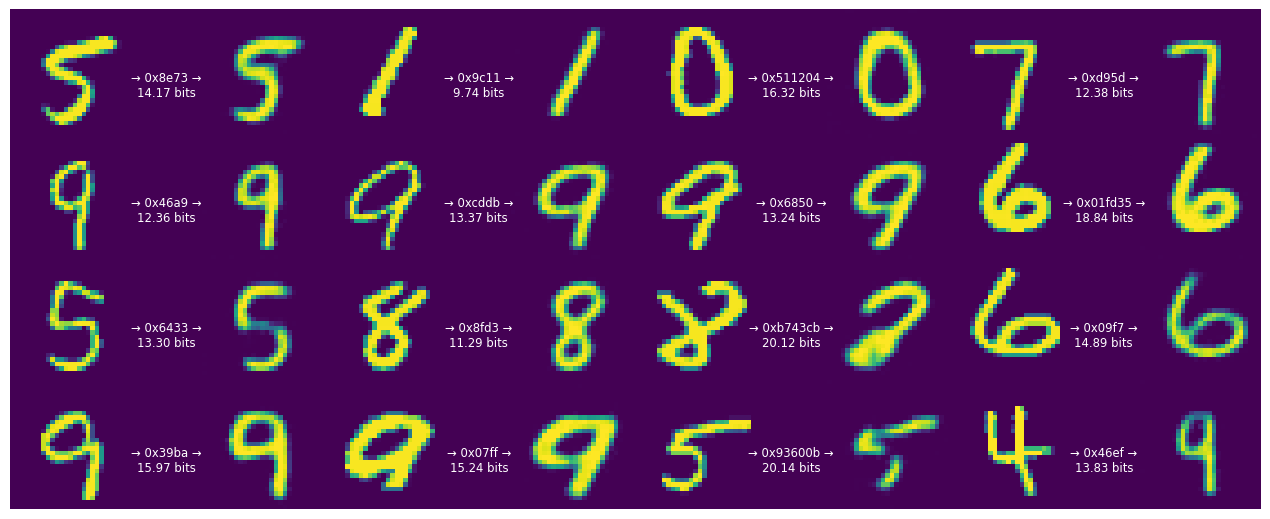

In [25]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)

train_and_visualize_model(lmbda=500)


The bit rate of our code goes down, as does the fidelity of the digits. However, most of the digits remain recognizable.

Let's reduce $\lambda$ further.

Epoch 1/15


  1/469 [..............................] - ETA: 13:37 - loss: 141.2258 - distortion_loss: 0.1277 - rate_loss: 102.9232 - distortion_pass_through_loss: 0.1277 - rate_pass_through_loss: 102.9232

  4/469 [..............................] - ETA: 9s - loss: 142.4147 - distortion_loss: 0.1320 - rate_loss: 102.8173 - distortion_pass_through_loss: 0.1320 - rate_pass_through_loss: 102.8173   

  7/469 [..............................] - ETA: 9s - loss: 142.4810 - distortion_loss: 0.1326 - rate_loss: 102.7112 - distortion_pass_through_loss: 0.1326 - rate_pass_through_loss: 102.7112

 10/469 [..............................] - ETA: 9s - loss: 142.4067 - distortion_loss: 0.1327 - rate_loss: 102.6070 - distortion_pass_through_loss: 0.1327 - rate_pass_through_loss: 102.6070

 13/469 [..............................] - ETA: 8s - loss: 142.1046 - distortion_loss: 0.1320 - rate_loss: 102.5035 - distortion_pass_through_loss: 0.1320 - rate_pass_through_loss: 102.5035

 16/469 [>.............................] - ETA: 8s - loss: 141.7647 - distortion_loss: 0.1312 - rate_loss: 102.4005 - distortion_pass_through_loss: 0.1312 - rate_pass_through_loss: 102.4005

 19/469 [>.............................] - ETA: 8s - loss: 141.5516 - distortion_loss: 0.1308 - rate_loss: 102.2999 - distortion_pass_through_loss: 0.1308 - rate_pass_through_loss: 102.2999

 22/469 [>.............................] - ETA: 8s - loss: 141.3971 - distortion_loss: 0.1306 - rate_loss: 102.2054 - distortion_pass_through_loss: 0.1306 - rate_pass_through_loss: 102.2054

 25/469 [>.............................] - ETA: 8s - loss: 141.0691 - distortion_loss: 0.1298 - rate_loss: 102.1188 - distortion_pass_through_loss: 0.1298 - rate_pass_through_loss: 102.1188

 28/469 [>.............................] - ETA: 8s - loss: 140.9381 - distortion_loss: 0.1297 - rate_loss: 102.0237 - distortion_pass_through_loss: 0.1297 - rate_pass_through_loss: 102.0237

 31/469 [>.............................] - ETA: 8s - loss: 140.6624 - distortion_loss: 0.1291 - rate_loss: 101.9352 - distortion_pass_through_loss: 0.1291 - rate_pass_through_loss: 101.9352

 34/469 [=>............................] - ETA: 8s - loss: 140.3971 - distortion_loss: 0.1285 - rate_loss: 101.8518 - distortion_pass_through_loss: 0.1285 - rate_pass_through_loss: 101.8518

 37/469 [=>............................] - ETA: 8s - loss: 140.0437 - distortion_loss: 0.1276 - rate_loss: 101.7644 - distortion_pass_through_loss: 0.1276 - rate_pass_through_loss: 101.7644

 40/469 [=>............................] - ETA: 8s - loss: 139.7435 - distortion_loss: 0.1269 - rate_loss: 101.6777 - distortion_pass_through_loss: 0.1269 - rate_pass_through_loss: 101.6777

 43/469 [=>............................] - ETA: 8s - loss: 139.5288 - distortion_loss: 0.1265 - rate_loss: 101.5865 - distortion_pass_through_loss: 0.1265 - rate_pass_through_loss: 101.5865

 46/469 [=>............................] - ETA: 8s - loss: 139.2895 - distortion_loss: 0.1260 - rate_loss: 101.4996 - distortion_pass_through_loss: 0.1260 - rate_pass_through_loss: 101.4996

 49/469 [==>...........................] - ETA: 8s - loss: 139.0878 - distortion_loss: 0.1256 - rate_loss: 101.4192 - distortion_pass_through_loss: 0.1256 - rate_pass_through_loss: 101.4192

 52/469 [==>...........................] - ETA: 8s - loss: 138.8482 - distortion_loss: 0.1250 - rate_loss: 101.3412 - distortion_pass_through_loss: 0.1250 - rate_pass_through_loss: 101.3412

 55/469 [==>...........................] - ETA: 8s - loss: 138.5792 - distortion_loss: 0.1244 - rate_loss: 101.2738 - distortion_pass_through_loss: 0.1244 - rate_pass_through_loss: 101.2738

 58/469 [==>...........................] - ETA: 7s - loss: 138.3299 - distortion_loss: 0.1237 - rate_loss: 101.2066 - distortion_pass_through_loss: 0.1237 - rate_pass_through_loss: 101.2066

 61/469 [==>...........................] - ETA: 7s - loss: 138.0508 - distortion_loss: 0.1231 - rate_loss: 101.1348 - distortion_pass_through_loss: 0.1231 - rate_pass_through_loss: 101.1348

 64/469 [===>..........................] - ETA: 7s - loss: 137.8038 - distortion_loss: 0.1225 - rate_loss: 101.0599 - distortion_pass_through_loss: 0.1225 - rate_pass_through_loss: 101.0599

 67/469 [===>..........................] - ETA: 7s - loss: 137.5136 - distortion_loss: 0.1218 - rate_loss: 100.9856 - distortion_pass_through_loss: 0.1218 - rate_pass_through_loss: 100.9856

 70/469 [===>..........................] - ETA: 7s - loss: 137.2113 - distortion_loss: 0.1210 - rate_loss: 100.9165 - distortion_pass_through_loss: 0.1210 - rate_pass_through_loss: 100.9165

 73/469 [===>..........................] - ETA: 7s - loss: 136.8731 - distortion_loss: 0.1201 - rate_loss: 100.8499 - distortion_pass_through_loss: 0.1201 - rate_pass_through_loss: 100.8499

 76/469 [===>..........................] - ETA: 7s - loss: 136.5728 - distortion_loss: 0.1193 - rate_loss: 100.7847 - distortion_pass_through_loss: 0.1193 - rate_pass_through_loss: 100.7847

 79/469 [====>.........................] - ETA: 7s - loss: 136.2410 - distortion_loss: 0.1184 - rate_loss: 100.7237 - distortion_pass_through_loss: 0.1184 - rate_pass_through_loss: 100.7237

 82/469 [====>.........................] - ETA: 7s - loss: 135.9237 - distortion_loss: 0.1176 - rate_loss: 100.6544 - distortion_pass_through_loss: 0.1176 - rate_pass_through_loss: 100.6544

 85/469 [====>.........................] - ETA: 7s - loss: 135.5910 - distortion_loss: 0.1167 - rate_loss: 100.5866 - distortion_pass_through_loss: 0.1167 - rate_pass_through_loss: 100.5866

 88/469 [====>.........................] - ETA: 7s - loss: 135.2690 - distortion_loss: 0.1158 - rate_loss: 100.5229 - distortion_pass_through_loss: 0.1158 - rate_pass_through_loss: 100.5229

 91/469 [====>.........................] - ETA: 7s - loss: 134.9324 - distortion_loss: 0.1149 - rate_loss: 100.4573 - distortion_pass_through_loss: 0.1149 - rate_pass_through_loss: 100.4573

 94/469 [=====>........................] - ETA: 7s - loss: 134.6262 - distortion_loss: 0.1141 - rate_loss: 100.3895 - distortion_pass_through_loss: 0.1141 - rate_pass_through_loss: 100.3895

 97/469 [=====>........................] - ETA: 7s - loss: 134.2983 - distortion_loss: 0.1132 - rate_loss: 100.3238 - distortion_pass_through_loss: 0.1132 - rate_pass_through_loss: 100.3238

100/469 [=====>........................] - ETA: 7s - loss: 134.0142 - distortion_loss: 0.1125 - rate_loss: 100.2629 - distortion_pass_through_loss: 0.1125 - rate_pass_through_loss: 100.2629

103/469 [=====>........................] - ETA: 7s - loss: 133.7209 - distortion_loss: 0.1118 - rate_loss: 100.1946 - distortion_pass_through_loss: 0.1118 - rate_pass_through_loss: 100.1946

106/469 [=====>........................] - ETA: 6s - loss: 133.4080 - distortion_loss: 0.1109 - rate_loss: 100.1247 - distortion_pass_through_loss: 0.1109 - rate_pass_through_loss: 100.1247

109/469 [=====>........................] - ETA: 6s - loss: 133.1004 - distortion_loss: 0.1101 - rate_loss: 100.0574 - distortion_pass_through_loss: 0.1101 - rate_pass_through_loss: 100.0574

112/469 [======>.......................] - ETA: 6s - loss: 132.8317 - distortion_loss: 0.1095 - rate_loss: 99.9937 - distortion_pass_through_loss: 0.1095 - rate_pass_through_loss: 99.9937  

115/469 [======>.......................] - ETA: 6s - loss: 132.5703 - distortion_loss: 0.1088 - rate_loss: 99.9283 - distortion_pass_through_loss: 0.1088 - rate_pass_through_loss: 99.9283

118/469 [======>.......................] - ETA: 6s - loss: 132.2768 - distortion_loss: 0.1081 - rate_loss: 99.8607 - distortion_pass_through_loss: 0.1081 - rate_pass_through_loss: 99.8607

121/469 [======>.......................] - ETA: 6s - loss: 131.9972 - distortion_loss: 0.1073 - rate_loss: 99.7929 - distortion_pass_through_loss: 0.1073 - rate_pass_through_loss: 99.7929

124/469 [======>.......................] - ETA: 6s - loss: 131.7269 - distortion_loss: 0.1067 - rate_loss: 99.7236 - distortion_pass_through_loss: 0.1067 - rate_pass_through_loss: 99.7236

127/469 [=======>......................] - ETA: 6s - loss: 131.4525 - distortion_loss: 0.1060 - rate_loss: 99.6586 - distortion_pass_through_loss: 0.1060 - rate_pass_through_loss: 99.6586

130/469 [=======>......................] - ETA: 6s - loss: 131.1805 - distortion_loss: 0.1053 - rate_loss: 99.5899 - distortion_pass_through_loss: 0.1053 - rate_pass_through_loss: 99.5899

133/469 [=======>......................] - ETA: 6s - loss: 130.9132 - distortion_loss: 0.1046 - rate_loss: 99.5214 - distortion_pass_through_loss: 0.1046 - rate_pass_through_loss: 99.5214

136/469 [=======>......................] - ETA: 6s - loss: 130.6607 - distortion_loss: 0.1040 - rate_loss: 99.4526 - distortion_pass_through_loss: 0.1040 - rate_pass_through_loss: 99.4526

139/469 [=======>......................] - ETA: 6s - loss: 130.4218 - distortion_loss: 0.1034 - rate_loss: 99.3868 - distortion_pass_through_loss: 0.1034 - rate_pass_through_loss: 99.3868

142/469 [========>.....................] - ETA: 6s - loss: 130.1770 - distortion_loss: 0.1029 - rate_loss: 99.3172 - distortion_pass_through_loss: 0.1029 - rate_pass_through_loss: 99.3172

145/469 [========>.....................] - ETA: 6s - loss: 129.9441 - distortion_loss: 0.1023 - rate_loss: 99.2487 - distortion_pass_through_loss: 0.1023 - rate_pass_through_loss: 99.2487

148/469 [========>.....................] - ETA: 6s - loss: 129.7131 - distortion_loss: 0.1018 - rate_loss: 99.1787 - distortion_pass_through_loss: 0.1018 - rate_pass_through_loss: 99.1787

151/469 [========>.....................] - ETA: 6s - loss: 129.4842 - distortion_loss: 0.1013 - rate_loss: 99.1052 - distortion_pass_through_loss: 0.1013 - rate_pass_through_loss: 99.1052

154/469 [========>.....................] - ETA: 5s - loss: 129.2737 - distortion_loss: 0.1008 - rate_loss: 99.0392 - distortion_pass_through_loss: 0.1008 - rate_pass_through_loss: 99.0392

157/469 [=========>....................] - ETA: 5s - loss: 129.0536 - distortion_loss: 0.1003 - rate_loss: 98.9717 - distortion_pass_through_loss: 0.1003 - rate_pass_through_loss: 98.9717

160/469 [=========>....................] - ETA: 5s - loss: 128.8387 - distortion_loss: 0.0998 - rate_loss: 98.9010 - distortion_pass_through_loss: 0.0998 - rate_pass_through_loss: 98.9010

163/469 [=========>....................] - ETA: 5s - loss: 128.6129 - distortion_loss: 0.0993 - rate_loss: 98.8312 - distortion_pass_through_loss: 0.0993 - rate_pass_through_loss: 98.8312

166/469 [=========>....................] - ETA: 5s - loss: 128.3999 - distortion_loss: 0.0988 - rate_loss: 98.7590 - distortion_pass_through_loss: 0.0988 - rate_pass_through_loss: 98.7590

169/469 [=========>....................] - ETA: 5s - loss: 128.1926 - distortion_loss: 0.0983 - rate_loss: 98.6882 - distortion_pass_through_loss: 0.0983 - rate_pass_through_loss: 98.6882

172/469 [==========>...................] - ETA: 5s - loss: 127.9774 - distortion_loss: 0.0979 - rate_loss: 98.6149 - distortion_pass_through_loss: 0.0979 - rate_pass_through_loss: 98.6149

175/469 [==========>...................] - ETA: 5s - loss: 127.7804 - distortion_loss: 0.0975 - rate_loss: 98.5420 - distortion_pass_through_loss: 0.0975 - rate_pass_through_loss: 98.5420

178/469 [==========>...................] - ETA: 5s - loss: 127.5791 - distortion_loss: 0.0970 - rate_loss: 98.4714 - distortion_pass_through_loss: 0.0970 - rate_pass_through_loss: 98.4714

181/469 [==========>...................] - ETA: 5s - loss: 127.3865 - distortion_loss: 0.0966 - rate_loss: 98.4013 - distortion_pass_through_loss: 0.0966 - rate_pass_through_loss: 98.4013

184/469 [==========>...................] - ETA: 5s - loss: 127.1931 - distortion_loss: 0.0962 - rate_loss: 98.3317 - distortion_pass_through_loss: 0.0962 - rate_pass_through_loss: 98.3317

187/469 [==========>...................] - ETA: 5s - loss: 126.9959 - distortion_loss: 0.0958 - rate_loss: 98.2583 - distortion_pass_through_loss: 0.0958 - rate_pass_through_loss: 98.2583

190/469 [===========>..................] - ETA: 5s - loss: 126.8091 - distortion_loss: 0.0954 - rate_loss: 98.1864 - distortion_pass_through_loss: 0.0954 - rate_pass_through_loss: 98.1864

193/469 [===========>..................] - ETA: 5s - loss: 126.6224 - distortion_loss: 0.0950 - rate_loss: 98.1155 - distortion_pass_through_loss: 0.0950 - rate_pass_through_loss: 98.1155

196/469 [===========>..................] - ETA: 5s - loss: 126.4379 - distortion_loss: 0.0946 - rate_loss: 98.0435 - distortion_pass_through_loss: 0.0946 - rate_pass_through_loss: 98.0435

199/469 [===========>..................] - ETA: 5s - loss: 126.2421 - distortion_loss: 0.0942 - rate_loss: 97.9703 - distortion_pass_through_loss: 0.0942 - rate_pass_through_loss: 97.9703

202/469 [===========>..................] - ETA: 5s - loss: 126.0549 - distortion_loss: 0.0939 - rate_loss: 97.8959 - distortion_pass_through_loss: 0.0939 - rate_pass_through_loss: 97.8959

205/469 [============>.................] - ETA: 4s - loss: 125.8670 - distortion_loss: 0.0935 - rate_loss: 97.8206 - distortion_pass_through_loss: 0.0935 - rate_pass_through_loss: 97.8206

208/469 [============>.................] - ETA: 4s - loss: 125.6801 - distortion_loss: 0.0931 - rate_loss: 97.7467 - distortion_pass_through_loss: 0.0931 - rate_pass_through_loss: 97.7467

211/469 [============>.................] - ETA: 4s - loss: 125.4930 - distortion_loss: 0.0927 - rate_loss: 97.6733 - distortion_pass_through_loss: 0.0927 - rate_pass_through_loss: 97.6733

214/469 [============>.................] - ETA: 4s - loss: 125.3152 - distortion_loss: 0.0924 - rate_loss: 97.6007 - distortion_pass_through_loss: 0.0924 - rate_pass_through_loss: 97.6007

217/469 [============>.................] - ETA: 4s - loss: 125.1391 - distortion_loss: 0.0920 - rate_loss: 97.5257 - distortion_pass_through_loss: 0.0920 - rate_pass_through_loss: 97.5257

220/469 [=============>................] - ETA: 4s - loss: 124.9658 - distortion_loss: 0.0917 - rate_loss: 97.4517 - distortion_pass_through_loss: 0.0917 - rate_pass_through_loss: 97.4517

223/469 [=============>................] - ETA: 4s - loss: 124.7947 - distortion_loss: 0.0914 - rate_loss: 97.3773 - distortion_pass_through_loss: 0.0914 - rate_pass_through_loss: 97.3773

226/469 [=============>................] - ETA: 4s - loss: 124.6168 - distortion_loss: 0.0910 - rate_loss: 97.3024 - distortion_pass_through_loss: 0.0910 - rate_pass_through_loss: 97.3024

229/469 [=============>................] - ETA: 4s - loss: 124.4512 - distortion_loss: 0.0907 - rate_loss: 97.2291 - distortion_pass_through_loss: 0.0907 - rate_pass_through_loss: 97.2291

232/469 [=============>................] - ETA: 4s - loss: 124.2875 - distortion_loss: 0.0904 - rate_loss: 97.1545 - distortion_pass_through_loss: 0.0904 - rate_pass_through_loss: 97.1545

235/469 [==============>...............] - ETA: 4s - loss: 124.1195 - distortion_loss: 0.0901 - rate_loss: 97.0794 - distortion_pass_through_loss: 0.0901 - rate_pass_through_loss: 97.0794

238/469 [==============>...............] - ETA: 4s - loss: 123.9540 - distortion_loss: 0.0898 - rate_loss: 97.0025 - distortion_pass_through_loss: 0.0898 - rate_pass_through_loss: 97.0025

241/469 [==============>...............] - ETA: 4s - loss: 123.7921 - distortion_loss: 0.0895 - rate_loss: 96.9279 - distortion_pass_through_loss: 0.0895 - rate_pass_through_loss: 96.9279

244/469 [==============>...............] - ETA: 4s - loss: 123.6260 - distortion_loss: 0.0892 - rate_loss: 96.8530 - distortion_pass_through_loss: 0.0892 - rate_pass_through_loss: 96.8530

247/469 [==============>...............] - ETA: 4s - loss: 123.4753 - distortion_loss: 0.0890 - rate_loss: 96.7778 - distortion_pass_through_loss: 0.0890 - rate_pass_through_loss: 96.7778

250/469 [==============>...............] - ETA: 4s - loss: 123.3183 - distortion_loss: 0.0887 - rate_loss: 96.7009 - distortion_pass_through_loss: 0.0887 - rate_pass_through_loss: 96.7009

253/469 [===============>..............] - ETA: 4s - loss: 123.1600 - distortion_loss: 0.0885 - rate_loss: 96.6235 - distortion_pass_through_loss: 0.0885 - rate_pass_through_loss: 96.6235

256/469 [===============>..............] - ETA: 3s - loss: 123.0006 - distortion_loss: 0.0882 - rate_loss: 96.5467 - distortion_pass_through_loss: 0.0882 - rate_pass_through_loss: 96.5467

259/469 [===============>..............] - ETA: 3s - loss: 122.8449 - distortion_loss: 0.0879 - rate_loss: 96.4727 - distortion_pass_through_loss: 0.0879 - rate_pass_through_loss: 96.4727

262/469 [===============>..............] - ETA: 3s - loss: 122.6884 - distortion_loss: 0.0876 - rate_loss: 96.3985 - distortion_pass_through_loss: 0.0876 - rate_pass_through_loss: 96.3985

265/469 [===============>..............] - ETA: 3s - loss: 122.5327 - distortion_loss: 0.0874 - rate_loss: 96.3223 - distortion_pass_through_loss: 0.0874 - rate_pass_through_loss: 96.3223

268/469 [================>.............] - ETA: 3s - loss: 122.3765 - distortion_loss: 0.0871 - rate_loss: 96.2463 - distortion_pass_through_loss: 0.0871 - rate_pass_through_loss: 96.2463

271/469 [================>.............] - ETA: 3s - loss: 122.2262 - distortion_loss: 0.0869 - rate_loss: 96.1688 - distortion_pass_through_loss: 0.0869 - rate_pass_through_loss: 96.1688

274/469 [================>.............] - ETA: 3s - loss: 122.0824 - distortion_loss: 0.0866 - rate_loss: 96.0928 - distortion_pass_through_loss: 0.0866 - rate_pass_through_loss: 96.0928

277/469 [================>.............] - ETA: 3s - loss: 121.9340 - distortion_loss: 0.0864 - rate_loss: 96.0149 - distortion_pass_through_loss: 0.0864 - rate_pass_through_loss: 96.0149

280/469 [================>.............] - ETA: 3s - loss: 121.7813 - distortion_loss: 0.0861 - rate_loss: 95.9398 - distortion_pass_through_loss: 0.0861 - rate_pass_through_loss: 95.9398

283/469 [=================>............] - ETA: 3s - loss: 121.6438 - distortion_loss: 0.0859 - rate_loss: 95.8637 - distortion_pass_through_loss: 0.0859 - rate_pass_through_loss: 95.8637

286/469 [=================>............] - ETA: 3s - loss: 121.5002 - distortion_loss: 0.0857 - rate_loss: 95.7878 - distortion_pass_through_loss: 0.0857 - rate_pass_through_loss: 95.7878

289/469 [=================>............] - ETA: 3s - loss: 121.3562 - distortion_loss: 0.0855 - rate_loss: 95.7103 - distortion_pass_through_loss: 0.0855 - rate_pass_through_loss: 95.7103

292/469 [=================>............] - ETA: 3s - loss: 121.2078 - distortion_loss: 0.0853 - rate_loss: 95.6311 - distortion_pass_through_loss: 0.0853 - rate_pass_through_loss: 95.6311

295/469 [=================>............] - ETA: 3s - loss: 121.0603 - distortion_loss: 0.0850 - rate_loss: 95.5549 - distortion_pass_through_loss: 0.0850 - rate_pass_through_loss: 95.5549

298/469 [==================>...........] - ETA: 3s - loss: 120.9143 - distortion_loss: 0.0848 - rate_loss: 95.4768 - distortion_pass_through_loss: 0.0848 - rate_pass_through_loss: 95.4768

301/469 [==================>...........] - ETA: 3s - loss: 120.7770 - distortion_loss: 0.0846 - rate_loss: 95.4012 - distortion_pass_through_loss: 0.0846 - rate_pass_through_loss: 95.4012

304/469 [==================>...........] - ETA: 3s - loss: 120.6336 - distortion_loss: 0.0844 - rate_loss: 95.3218 - distortion_pass_through_loss: 0.0844 - rate_pass_through_loss: 95.3218

307/469 [==================>...........] - ETA: 3s - loss: 120.4956 - distortion_loss: 0.0842 - rate_loss: 95.2442 - distortion_pass_through_loss: 0.0842 - rate_pass_through_loss: 95.2442

310/469 [==================>...........] - ETA: 2s - loss: 120.3602 - distortion_loss: 0.0840 - rate_loss: 95.1682 - distortion_pass_through_loss: 0.0840 - rate_pass_through_loss: 95.1682

313/469 [===================>..........] - ETA: 2s - loss: 120.2243 - distortion_loss: 0.0838 - rate_loss: 95.0896 - distortion_pass_through_loss: 0.0838 - rate_pass_through_loss: 95.0896

316/469 [===================>..........] - ETA: 2s - loss: 120.0884 - distortion_loss: 0.0836 - rate_loss: 95.0128 - distortion_pass_through_loss: 0.0836 - rate_pass_through_loss: 95.0128

319/469 [===================>..........] - ETA: 2s - loss: 119.9511 - distortion_loss: 0.0834 - rate_loss: 94.9348 - distortion_pass_through_loss: 0.0834 - rate_pass_through_loss: 94.9348

322/469 [===================>..........] - ETA: 2s - loss: 119.8179 - distortion_loss: 0.0832 - rate_loss: 94.8563 - distortion_pass_through_loss: 0.0832 - rate_pass_through_loss: 94.8563

325/469 [===================>..........] - ETA: 2s - loss: 119.6823 - distortion_loss: 0.0830 - rate_loss: 94.7782 - distortion_pass_through_loss: 0.0830 - rate_pass_through_loss: 94.7782

328/469 [===================>..........] - ETA: 2s - loss: 119.5505 - distortion_loss: 0.0828 - rate_loss: 94.7006 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 94.7006

331/469 [====================>.........] - ETA: 2s - loss: 119.4170 - distortion_loss: 0.0826 - rate_loss: 94.6230 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 94.6230

334/469 [====================>.........] - ETA: 2s - loss: 119.2864 - distortion_loss: 0.0825 - rate_loss: 94.5463 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 94.5463

337/469 [====================>.........] - ETA: 2s - loss: 119.1555 - distortion_loss: 0.0823 - rate_loss: 94.4680 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 94.4680

340/469 [====================>.........] - ETA: 2s - loss: 119.0257 - distortion_loss: 0.0821 - rate_loss: 94.3900 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 94.3900

343/469 [====================>.........] - ETA: 2s - loss: 118.8961 - distortion_loss: 0.0819 - rate_loss: 94.3115 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 94.3115

346/469 [=====================>........] - ETA: 2s - loss: 118.7626 - distortion_loss: 0.0818 - rate_loss: 94.2322 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 94.2322

349/469 [=====================>........] - ETA: 2s - loss: 118.6401 - distortion_loss: 0.0816 - rate_loss: 94.1547 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 94.1547

352/469 [=====================>........] - ETA: 2s - loss: 118.5143 - distortion_loss: 0.0815 - rate_loss: 94.0769 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 94.0769

355/469 [=====================>........] - ETA: 2s - loss: 118.3857 - distortion_loss: 0.0813 - rate_loss: 93.9976 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 93.9976

358/469 [=====================>........] - ETA: 2s - loss: 118.2576 - distortion_loss: 0.0811 - rate_loss: 93.9180 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 93.9180

361/469 [======================>.......] - ETA: 2s - loss: 118.1367 - distortion_loss: 0.0810 - rate_loss: 93.8403 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 93.8403

364/469 [======================>.......] - ETA: 1s - loss: 118.0136 - distortion_loss: 0.0808 - rate_loss: 93.7621 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 93.7621

367/469 [======================>.......] - ETA: 1s - loss: 117.8896 - distortion_loss: 0.0807 - rate_loss: 93.6824 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 93.6824

370/469 [======================>.......] - ETA: 1s - loss: 117.7647 - distortion_loss: 0.0805 - rate_loss: 93.6044 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 93.6044

373/469 [======================>.......] - ETA: 1s - loss: 117.6395 - distortion_loss: 0.0804 - rate_loss: 93.5256 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 93.5256

376/469 [=======================>......] - ETA: 1s - loss: 117.5140 - distortion_loss: 0.0802 - rate_loss: 93.4474 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 93.4474

379/469 [=======================>......] - ETA: 1s - loss: 117.3913 - distortion_loss: 0.0801 - rate_loss: 93.3676 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 93.3676

382/469 [=======================>......] - ETA: 1s - loss: 117.2693 - distortion_loss: 0.0799 - rate_loss: 93.2899 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 93.2899

385/469 [=======================>......] - ETA: 1s - loss: 117.1472 - distortion_loss: 0.0798 - rate_loss: 93.2112 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 93.2112

388/469 [=======================>......] - ETA: 1s - loss: 117.0289 - distortion_loss: 0.0797 - rate_loss: 93.1327 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 93.1327

391/469 [========================>.....] - ETA: 1s - loss: 116.9060 - distortion_loss: 0.0795 - rate_loss: 93.0536 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 93.0536

394/469 [========================>.....] - ETA: 1s - loss: 116.7862 - distortion_loss: 0.0794 - rate_loss: 92.9753 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 92.9753

397/469 [========================>.....] - ETA: 1s - loss: 116.6660 - distortion_loss: 0.0792 - rate_loss: 92.8953 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 92.8953

400/469 [========================>.....] - ETA: 1s - loss: 116.5459 - distortion_loss: 0.0791 - rate_loss: 92.8154 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 92.8154

403/469 [========================>.....] - ETA: 1s - loss: 116.4220 - distortion_loss: 0.0789 - rate_loss: 92.7372 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 92.7372

406/469 [========================>.....] - ETA: 1s - loss: 116.3059 - distortion_loss: 0.0788 - rate_loss: 92.6589 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 92.6589

409/469 [=========================>....] - ETA: 1s - loss: 116.1878 - distortion_loss: 0.0787 - rate_loss: 92.5803 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 92.5803

412/469 [=========================>....] - ETA: 1s - loss: 116.0744 - distortion_loss: 0.0786 - rate_loss: 92.5022 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 92.5022

415/469 [=========================>....] - ETA: 0s - loss: 115.9585 - distortion_loss: 0.0785 - rate_loss: 92.4220 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 92.4220

418/469 [=========================>....] - ETA: 0s - loss: 115.8416 - distortion_loss: 0.0783 - rate_loss: 92.3426 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 92.3426

421/469 [=========================>....] - ETA: 0s - loss: 115.7241 - distortion_loss: 0.0782 - rate_loss: 92.2640 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 92.2640

424/469 [==========================>...] - ETA: 0s - loss: 115.6072 - distortion_loss: 0.0781 - rate_loss: 92.1852 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 92.1852

427/469 [==========================>...] - ETA: 0s - loss: 115.4943 - distortion_loss: 0.0780 - rate_loss: 92.1072 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 92.1072

430/469 [==========================>...] - ETA: 0s - loss: 115.3834 - distortion_loss: 0.0778 - rate_loss: 92.0285 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 92.0285

433/469 [==========================>...] - ETA: 0s - loss: 115.2697 - distortion_loss: 0.0777 - rate_loss: 91.9490 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 91.9490

436/469 [==========================>...] - ETA: 0s - loss: 115.1542 - distortion_loss: 0.0776 - rate_loss: 91.8699 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 91.8699

439/469 [===========================>..] - ETA: 0s - loss: 115.0414 - distortion_loss: 0.0775 - rate_loss: 91.7902 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 91.7902

442/469 [===========================>..] - ETA: 0s - loss: 114.9291 - distortion_loss: 0.0774 - rate_loss: 91.7115 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 91.7115

445/469 [===========================>..] - ETA: 0s - loss: 114.8157 - distortion_loss: 0.0773 - rate_loss: 91.6322 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 91.6322

448/469 [===========================>..] - ETA: 0s - loss: 114.7070 - distortion_loss: 0.0772 - rate_loss: 91.5534 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 91.5534

451/469 [===========================>..] - ETA: 0s - loss: 114.5948 - distortion_loss: 0.0771 - rate_loss: 91.4749 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 91.4749

454/469 [============================>.] - ETA: 0s - loss: 114.4837 - distortion_loss: 0.0770 - rate_loss: 91.3957 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 91.3957

457/469 [============================>.] - ETA: 0s - loss: 114.3731 - distortion_loss: 0.0769 - rate_loss: 91.3175 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 91.3175

460/469 [============================>.] - ETA: 0s - loss: 114.2632 - distortion_loss: 0.0767 - rate_loss: 91.2392 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 91.2392

463/469 [============================>.] - ETA: 0s - loss: 114.1547 - distortion_loss: 0.0766 - rate_loss: 91.1601 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 91.1601

466/469 [============================>.] - ETA: 0s - loss: 114.0478 - distortion_loss: 0.0766 - rate_loss: 91.0820 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 91.0820

469/469 [==============================] - ETA: 0s - loss: 113.9453 - distortion_loss: 0.0765 - rate_loss: 91.0087 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 91.0019

469/469 [==============================] - 11s 20ms/step - loss: 113.9453 - distortion_loss: 0.0765 - rate_loss: 91.0087 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 91.0019 - val_loss: 96.5798 - val_distortion_loss: 0.0668 - val_rate_loss: 76.5345 - val_distortion_pass_through_loss: 0.0669 - val_rate_pass_through_loss: 76.5314


Epoch 2/15


  1/469 [..............................] - ETA: 10s - loss: 95.5584 - distortion_loss: 0.0569 - rate_loss: 78.4979 - distortion_pass_through_loss: 0.0569 - rate_pass_through_loss: 78.4979

  4/469 [..............................] - ETA: 8s - loss: 96.4032 - distortion_loss: 0.0589 - rate_loss: 78.7280 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 78.7280 

  7/469 [..............................] - ETA: 8s - loss: 96.5615 - distortion_loss: 0.0599 - rate_loss: 78.5881 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 78.5881

 10/469 [..............................] - ETA: 8s - loss: 96.6133 - distortion_loss: 0.0603 - rate_loss: 78.5205 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 78.5205

 13/469 [..............................] - ETA: 8s - loss: 96.4428 - distortion_loss: 0.0602 - rate_loss: 78.3904 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 78.3904

 16/469 [>.............................] - ETA: 8s - loss: 96.3270 - distortion_loss: 0.0601 - rate_loss: 78.2903 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 78.2903

 19/469 [>.............................] - ETA: 7s - loss: 96.2559 - distortion_loss: 0.0602 - rate_loss: 78.2016 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 78.2016

 22/469 [>.............................] - ETA: 7s - loss: 96.2801 - distortion_loss: 0.0605 - rate_loss: 78.1265 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 78.1265

 25/469 [>.............................] - ETA: 7s - loss: 96.2006 - distortion_loss: 0.0605 - rate_loss: 78.0477 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 78.0477

 28/469 [>.............................] - ETA: 7s - loss: 96.1539 - distortion_loss: 0.0606 - rate_loss: 77.9859 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.9859

 31/469 [>.............................] - ETA: 7s - loss: 96.0621 - distortion_loss: 0.0605 - rate_loss: 77.9102 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 77.9102

 34/469 [=>............................] - ETA: 7s - loss: 96.0087 - distortion_loss: 0.0606 - rate_loss: 77.8312 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.8312

 37/469 [=>............................] - ETA: 7s - loss: 95.8838 - distortion_loss: 0.0605 - rate_loss: 77.7449 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 77.7449

 40/469 [=>............................] - ETA: 7s - loss: 95.8066 - distortion_loss: 0.0605 - rate_loss: 77.6636 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 77.6636

 43/469 [=>............................] - ETA: 7s - loss: 95.7491 - distortion_loss: 0.0605 - rate_loss: 77.5891 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 77.5891

 46/469 [=>............................] - ETA: 7s - loss: 95.6586 - distortion_loss: 0.0605 - rate_loss: 77.5134 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 77.5134

 49/469 [==>...........................] - ETA: 7s - loss: 95.6067 - distortion_loss: 0.0606 - rate_loss: 77.4364 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.4364

 52/469 [==>...........................] - ETA: 7s - loss: 95.5367 - distortion_loss: 0.0606 - rate_loss: 77.3640 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.3640

 55/469 [==>...........................] - ETA: 7s - loss: 95.4496 - distortion_loss: 0.0605 - rate_loss: 77.2897 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 77.2897

 58/469 [==>...........................] - ETA: 7s - loss: 95.3768 - distortion_loss: 0.0606 - rate_loss: 77.2116 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.2116

 61/469 [==>...........................] - ETA: 7s - loss: 95.3040 - distortion_loss: 0.0606 - rate_loss: 77.1375 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.1375

 64/469 [===>..........................] - ETA: 7s - loss: 95.2486 - distortion_loss: 0.0606 - rate_loss: 77.0634 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.0634

 67/469 [===>..........................] - ETA: 7s - loss: 95.1884 - distortion_loss: 0.0607 - rate_loss: 76.9910 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 76.9910

 70/469 [===>..........................] - ETA: 7s - loss: 95.1118 - distortion_loss: 0.0607 - rate_loss: 76.9134 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 76.9134

 73/469 [===>..........................] - ETA: 7s - loss: 95.0132 - distortion_loss: 0.0606 - rate_loss: 76.8342 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.8342

 76/469 [===>..........................] - ETA: 7s - loss: 94.9478 - distortion_loss: 0.0606 - rate_loss: 76.7587 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.7587

 79/469 [====>.........................] - ETA: 6s - loss: 94.8684 - distortion_loss: 0.0606 - rate_loss: 76.6846 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.6846

 82/469 [====>.........................] - ETA: 6s - loss: 94.7967 - distortion_loss: 0.0606 - rate_loss: 76.6089 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.6089

 85/469 [====>.........................] - ETA: 6s - loss: 94.6975 - distortion_loss: 0.0605 - rate_loss: 76.5334 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.5334

 88/469 [====>.........................] - ETA: 6s - loss: 94.6164 - distortion_loss: 0.0605 - rate_loss: 76.4607 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.4607

 91/469 [====>.........................] - ETA: 6s - loss: 94.5224 - distortion_loss: 0.0605 - rate_loss: 76.3781 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.3781

 94/469 [=====>........................] - ETA: 6s - loss: 94.4498 - distortion_loss: 0.0605 - rate_loss: 76.3012 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.3012

 97/469 [=====>........................] - ETA: 6s - loss: 94.3585 - distortion_loss: 0.0605 - rate_loss: 76.2191 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.2191

100/469 [=====>........................] - ETA: 6s - loss: 94.2893 - distortion_loss: 0.0605 - rate_loss: 76.1472 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.1472

103/469 [=====>........................] - ETA: 6s - loss: 94.2114 - distortion_loss: 0.0605 - rate_loss: 76.0720 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.0720

106/469 [=====>........................] - ETA: 6s - loss: 94.1228 - distortion_loss: 0.0604 - rate_loss: 75.9923 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.9923

109/469 [=====>........................] - ETA: 6s - loss: 94.0340 - distortion_loss: 0.0604 - rate_loss: 75.9188 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.9188

112/469 [======>.......................] - ETA: 6s - loss: 93.9652 - distortion_loss: 0.0604 - rate_loss: 75.8440 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.8440

115/469 [======>.......................] - ETA: 6s - loss: 93.9070 - distortion_loss: 0.0604 - rate_loss: 75.7727 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.7727

118/469 [======>.......................] - ETA: 6s - loss: 93.8161 - distortion_loss: 0.0604 - rate_loss: 75.6948 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.6948

121/469 [======>.......................] - ETA: 6s - loss: 93.7350 - distortion_loss: 0.0604 - rate_loss: 75.6228 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.6228

124/469 [======>.......................] - ETA: 6s - loss: 93.6532 - distortion_loss: 0.0604 - rate_loss: 75.5404 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.5404

127/469 [=======>......................] - ETA: 6s - loss: 93.5666 - distortion_loss: 0.0603 - rate_loss: 75.4619 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.4619

130/469 [=======>......................] - ETA: 6s - loss: 93.4811 - distortion_loss: 0.0603 - rate_loss: 75.3859 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.3859

133/469 [=======>......................] - ETA: 6s - loss: 93.3931 - distortion_loss: 0.0603 - rate_loss: 75.3072 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.3072

136/469 [=======>......................] - ETA: 5s - loss: 93.3133 - distortion_loss: 0.0603 - rate_loss: 75.2337 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.2337

139/469 [=======>......................] - ETA: 5s - loss: 93.2408 - distortion_loss: 0.0603 - rate_loss: 75.1566 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.1566

142/469 [========>.....................] - ETA: 5s - loss: 93.1614 - distortion_loss: 0.0603 - rate_loss: 75.0812 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.0812

145/469 [========>.....................] - ETA: 5s - loss: 93.0900 - distortion_loss: 0.0603 - rate_loss: 75.0097 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.0097

148/469 [========>.....................] - ETA: 5s - loss: 93.0160 - distortion_loss: 0.0603 - rate_loss: 74.9360 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.9360

151/469 [========>.....................] - ETA: 5s - loss: 92.9413 - distortion_loss: 0.0603 - rate_loss: 74.8607 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.8607

154/469 [========>.....................] - ETA: 5s - loss: 92.8758 - distortion_loss: 0.0603 - rate_loss: 74.7904 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.7904

157/469 [=========>....................] - ETA: 5s - loss: 92.8011 - distortion_loss: 0.0603 - rate_loss: 74.7201 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.7201

160/469 [=========>....................] - ETA: 5s - loss: 92.7300 - distortion_loss: 0.0603 - rate_loss: 74.6476 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.6476

163/469 [=========>....................] - ETA: 5s - loss: 92.6491 - distortion_loss: 0.0603 - rate_loss: 74.5701 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.5701

166/469 [=========>....................] - ETA: 5s - loss: 92.5785 - distortion_loss: 0.0603 - rate_loss: 74.4953 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.4953

169/469 [=========>....................] - ETA: 5s - loss: 92.5046 - distortion_loss: 0.0603 - rate_loss: 74.4198 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.4198

172/469 [==========>...................] - ETA: 5s - loss: 92.4238 - distortion_loss: 0.0603 - rate_loss: 74.3450 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.3450

175/469 [==========>...................] - ETA: 5s - loss: 92.3566 - distortion_loss: 0.0603 - rate_loss: 74.2707 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.2707

178/469 [==========>...................] - ETA: 5s - loss: 92.2812 - distortion_loss: 0.0603 - rate_loss: 74.1985 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.1985

181/469 [==========>...................] - ETA: 5s - loss: 92.2128 - distortion_loss: 0.0603 - rate_loss: 74.1257 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.1257

184/469 [==========>...................] - ETA: 5s - loss: 92.1448 - distortion_loss: 0.0603 - rate_loss: 74.0537 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.0537

187/469 [==========>...................] - ETA: 5s - loss: 92.0708 - distortion_loss: 0.0603 - rate_loss: 73.9789 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.9789

190/469 [===========>..................] - ETA: 5s - loss: 92.0066 - distortion_loss: 0.0603 - rate_loss: 73.9097 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.9097

193/469 [===========>..................] - ETA: 4s - loss: 91.9394 - distortion_loss: 0.0603 - rate_loss: 73.8448 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.8448

196/469 [===========>..................] - ETA: 4s - loss: 91.8677 - distortion_loss: 0.0603 - rate_loss: 73.7729 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.7729

199/469 [===========>..................] - ETA: 4s - loss: 91.7917 - distortion_loss: 0.0603 - rate_loss: 73.6968 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.6968

202/469 [===========>..................] - ETA: 4s - loss: 91.7179 - distortion_loss: 0.0603 - rate_loss: 73.6212 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.6212

205/469 [============>.................] - ETA: 4s - loss: 91.6440 - distortion_loss: 0.0603 - rate_loss: 73.5487 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.5487

208/469 [============>.................] - ETA: 4s - loss: 91.5693 - distortion_loss: 0.0603 - rate_loss: 73.4769 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.4769

211/469 [============>.................] - ETA: 4s - loss: 91.4908 - distortion_loss: 0.0603 - rate_loss: 73.4025 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.4025

214/469 [============>.................] - ETA: 4s - loss: 91.4182 - distortion_loss: 0.0603 - rate_loss: 73.3304 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.3304

217/469 [============>.................] - ETA: 4s - loss: 91.3417 - distortion_loss: 0.0603 - rate_loss: 73.2579 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.2579

220/469 [=============>................] - ETA: 4s - loss: 91.2714 - distortion_loss: 0.0603 - rate_loss: 73.1863 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.1863

223/469 [=============>................] - ETA: 4s - loss: 91.2001 - distortion_loss: 0.0603 - rate_loss: 73.1130 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.1130

226/469 [=============>................] - ETA: 4s - loss: 91.1240 - distortion_loss: 0.0603 - rate_loss: 73.0392 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.0392

229/469 [=============>................] - ETA: 4s - loss: 91.0568 - distortion_loss: 0.0603 - rate_loss: 72.9672 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 72.9672

232/469 [=============>................] - ETA: 4s - loss: 90.9894 - distortion_loss: 0.0603 - rate_loss: 72.8997 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 72.8997

235/469 [==============>...............] - ETA: 4s - loss: 90.9158 - distortion_loss: 0.0603 - rate_loss: 72.8259 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 72.8259

238/469 [==============>...............] - ETA: 4s - loss: 90.8436 - distortion_loss: 0.0603 - rate_loss: 72.7537 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 72.7537

241/469 [==============>...............] - ETA: 4s - loss: 90.7734 - distortion_loss: 0.0603 - rate_loss: 72.6804 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 72.6804

244/469 [==============>...............] - ETA: 4s - loss: 90.6987 - distortion_loss: 0.0603 - rate_loss: 72.6093 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 72.6093

247/469 [==============>...............] - ETA: 3s - loss: 90.6371 - distortion_loss: 0.0603 - rate_loss: 72.5393 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 72.5393

250/469 [==============>...............] - ETA: 3s - loss: 90.5693 - distortion_loss: 0.0603 - rate_loss: 72.4656 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 72.4656

253/469 [===============>..............] - ETA: 3s - loss: 90.4990 - distortion_loss: 0.0604 - rate_loss: 72.3903 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.3903

256/469 [===============>..............] - ETA: 3s - loss: 90.4299 - distortion_loss: 0.0604 - rate_loss: 72.3201 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.3201

259/469 [===============>..............] - ETA: 3s - loss: 90.3620 - distortion_loss: 0.0604 - rate_loss: 72.2510 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.2510

262/469 [===============>..............] - ETA: 3s - loss: 90.2912 - distortion_loss: 0.0604 - rate_loss: 72.1831 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.1831

265/469 [===============>..............] - ETA: 3s - loss: 90.2185 - distortion_loss: 0.0604 - rate_loss: 72.1107 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.1107

268/469 [================>.............] - ETA: 3s - loss: 90.1460 - distortion_loss: 0.0604 - rate_loss: 72.0408 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.0408

271/469 [================>.............] - ETA: 3s - loss: 90.0785 - distortion_loss: 0.0604 - rate_loss: 71.9683 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 71.9683

274/469 [================>.............] - ETA: 3s - loss: 90.0154 - distortion_loss: 0.0604 - rate_loss: 71.8965 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 71.8965

277/469 [================>.............] - ETA: 3s - loss: 89.9488 - distortion_loss: 0.0604 - rate_loss: 71.8264 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 71.8264

280/469 [================>.............] - ETA: 3s - loss: 89.8791 - distortion_loss: 0.0604 - rate_loss: 71.7575 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 71.7575

283/469 [=================>............] - ETA: 3s - loss: 89.8183 - distortion_loss: 0.0604 - rate_loss: 71.6871 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 71.6871

286/469 [=================>............] - ETA: 3s - loss: 89.7501 - distortion_loss: 0.0604 - rate_loss: 71.6174 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 71.6174

289/469 [=================>............] - ETA: 3s - loss: 89.6799 - distortion_loss: 0.0604 - rate_loss: 71.5472 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 71.5472

292/469 [=================>............] - ETA: 3s - loss: 89.6093 - distortion_loss: 0.0605 - rate_loss: 71.4731 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.4731

295/469 [=================>............] - ETA: 3s - loss: 89.5394 - distortion_loss: 0.0604 - rate_loss: 71.4047 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 71.4047

298/469 [==================>...........] - ETA: 3s - loss: 89.4672 - distortion_loss: 0.0604 - rate_loss: 71.3347 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 71.3347

301/469 [==================>...........] - ETA: 3s - loss: 89.4031 - distortion_loss: 0.0605 - rate_loss: 71.2621 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.2621

304/469 [==================>...........] - ETA: 2s - loss: 89.3334 - distortion_loss: 0.0605 - rate_loss: 71.1918 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.1918

307/469 [==================>...........] - ETA: 2s - loss: 89.2720 - distortion_loss: 0.0605 - rate_loss: 71.1243 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.1243

310/469 [==================>...........] - ETA: 2s - loss: 89.2073 - distortion_loss: 0.0605 - rate_loss: 71.0549 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.0549

313/469 [===================>..........] - ETA: 2s - loss: 89.1424 - distortion_loss: 0.0605 - rate_loss: 70.9865 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 70.9865

316/469 [===================>..........] - ETA: 2s - loss: 89.0761 - distortion_loss: 0.0605 - rate_loss: 70.9151 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 70.9151

319/469 [===================>..........] - ETA: 2s - loss: 89.0090 - distortion_loss: 0.0605 - rate_loss: 70.8468 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 70.8468

322/469 [===================>..........] - ETA: 2s - loss: 88.9435 - distortion_loss: 0.0606 - rate_loss: 70.7783 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.7783

325/469 [===================>..........] - ETA: 2s - loss: 88.8740 - distortion_loss: 0.0606 - rate_loss: 70.7076 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.7076

328/469 [===================>..........] - ETA: 2s - loss: 88.8087 - distortion_loss: 0.0606 - rate_loss: 70.6408 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.6408

331/469 [====================>.........] - ETA: 2s - loss: 88.7414 - distortion_loss: 0.0606 - rate_loss: 70.5724 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.5724

334/469 [====================>.........] - ETA: 2s - loss: 88.6761 - distortion_loss: 0.0606 - rate_loss: 70.5048 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.5048

337/469 [====================>.........] - ETA: 2s - loss: 88.6107 - distortion_loss: 0.0606 - rate_loss: 70.4362 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.4362

340/469 [====================>.........] - ETA: 2s - loss: 88.5439 - distortion_loss: 0.0606 - rate_loss: 70.3673 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.3673

343/469 [====================>.........] - ETA: 2s - loss: 88.4773 - distortion_loss: 0.0606 - rate_loss: 70.2986 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.2986

346/469 [=====================>........] - ETA: 2s - loss: 88.4077 - distortion_loss: 0.0606 - rate_loss: 70.2308 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.2308

349/469 [=====================>........] - ETA: 2s - loss: 88.3446 - distortion_loss: 0.0606 - rate_loss: 70.1650 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.1650

352/469 [=====================>........] - ETA: 2s - loss: 88.2805 - distortion_loss: 0.0606 - rate_loss: 70.0952 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.0952

355/469 [=====================>........] - ETA: 2s - loss: 88.2135 - distortion_loss: 0.0606 - rate_loss: 70.0260 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.0260

358/469 [=====================>........] - ETA: 1s - loss: 88.1436 - distortion_loss: 0.0606 - rate_loss: 69.9561 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 69.9561

361/469 [======================>.......] - ETA: 1s - loss: 88.0814 - distortion_loss: 0.0606 - rate_loss: 69.8897 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 69.8897

364/469 [======================>.......] - ETA: 1s - loss: 88.0199 - distortion_loss: 0.0607 - rate_loss: 69.8239 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.8239

367/469 [======================>.......] - ETA: 1s - loss: 87.9531 - distortion_loss: 0.0607 - rate_loss: 69.7560 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.7560

370/469 [======================>.......] - ETA: 1s - loss: 87.8871 - distortion_loss: 0.0607 - rate_loss: 69.6851 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.6851

373/469 [======================>.......] - ETA: 1s - loss: 87.8221 - distortion_loss: 0.0607 - rate_loss: 69.6181 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.6181

376/469 [=======================>......] - ETA: 1s - loss: 87.7533 - distortion_loss: 0.0607 - rate_loss: 69.5523 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.5523

379/469 [=======================>......] - ETA: 1s - loss: 87.6868 - distortion_loss: 0.0607 - rate_loss: 69.4850 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.4850

382/469 [=======================>......] - ETA: 1s - loss: 87.6220 - distortion_loss: 0.0607 - rate_loss: 69.4167 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.4167

385/469 [=======================>......] - ETA: 1s - loss: 87.5554 - distortion_loss: 0.0607 - rate_loss: 69.3464 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.3464

388/469 [=======================>......] - ETA: 1s - loss: 87.4948 - distortion_loss: 0.0607 - rate_loss: 69.2821 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.2821

391/469 [========================>.....] - ETA: 1s - loss: 87.4271 - distortion_loss: 0.0607 - rate_loss: 69.2162 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.2162

394/469 [========================>.....] - ETA: 1s - loss: 87.3621 - distortion_loss: 0.0607 - rate_loss: 69.1475 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.1475

397/469 [========================>.....] - ETA: 1s - loss: 87.2977 - distortion_loss: 0.0607 - rate_loss: 69.0812 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.0812

400/469 [========================>.....] - ETA: 1s - loss: 87.2300 - distortion_loss: 0.0607 - rate_loss: 69.0130 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.0130

403/469 [========================>.....] - ETA: 1s - loss: 87.1578 - distortion_loss: 0.0607 - rate_loss: 68.9447 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 68.9447

406/469 [========================>.....] - ETA: 1s - loss: 87.0942 - distortion_loss: 0.0607 - rate_loss: 68.8781 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 68.8781

409/469 [=========================>....] - ETA: 1s - loss: 87.0285 - distortion_loss: 0.0607 - rate_loss: 68.8099 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 68.8099

412/469 [=========================>....] - ETA: 1s - loss: 86.9681 - distortion_loss: 0.0608 - rate_loss: 68.7429 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.7429

415/469 [=========================>....] - ETA: 0s - loss: 86.9055 - distortion_loss: 0.0608 - rate_loss: 68.6760 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.6760

418/469 [=========================>....] - ETA: 0s - loss: 86.8394 - distortion_loss: 0.0608 - rate_loss: 68.6112 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.6112

421/469 [=========================>....] - ETA: 0s - loss: 86.7730 - distortion_loss: 0.0608 - rate_loss: 68.5461 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.5461

424/469 [==========================>...] - ETA: 0s - loss: 86.7077 - distortion_loss: 0.0608 - rate_loss: 68.4772 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.4772

427/469 [==========================>...] - ETA: 0s - loss: 86.6458 - distortion_loss: 0.0608 - rate_loss: 68.4115 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.4115

430/469 [==========================>...] - ETA: 0s - loss: 86.5834 - distortion_loss: 0.0608 - rate_loss: 68.3472 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.3472

433/469 [==========================>...] - ETA: 0s - loss: 86.5182 - distortion_loss: 0.0608 - rate_loss: 68.2809 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.2809

436/469 [==========================>...] - ETA: 0s - loss: 86.4514 - distortion_loss: 0.0608 - rate_loss: 68.2145 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.2145

439/469 [===========================>..] - ETA: 0s - loss: 86.3880 - distortion_loss: 0.0608 - rate_loss: 68.1474 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.1474

442/469 [===========================>..] - ETA: 0s - loss: 86.3246 - distortion_loss: 0.0608 - rate_loss: 68.0824 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.0824

445/469 [===========================>..] - ETA: 0s - loss: 86.2607 - distortion_loss: 0.0608 - rate_loss: 68.0181 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.0181

448/469 [===========================>..] - ETA: 0s - loss: 86.2009 - distortion_loss: 0.0608 - rate_loss: 67.9526 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 67.9526

451/469 [===========================>..] - ETA: 0s - loss: 86.1370 - distortion_loss: 0.0608 - rate_loss: 67.8862 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 67.8862

454/469 [============================>.] - ETA: 0s - loss: 86.0725 - distortion_loss: 0.0608 - rate_loss: 67.8193 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 67.8193

457/469 [============================>.] - ETA: 0s - loss: 86.0090 - distortion_loss: 0.0609 - rate_loss: 67.7539 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 67.7539

460/469 [============================>.] - ETA: 0s - loss: 85.9482 - distortion_loss: 0.0609 - rate_loss: 67.6901 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 67.6901

463/469 [============================>.] - ETA: 0s - loss: 85.8883 - distortion_loss: 0.0609 - rate_loss: 67.6256 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 67.6256

466/469 [============================>.] - ETA: 0s - loss: 85.8283 - distortion_loss: 0.0609 - rate_loss: 67.5604 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 67.5604

469/469 [==============================] - ETA: 0s - loss: 85.7681 - distortion_loss: 0.0609 - rate_loss: 67.4997 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 67.4941

469/469 [==============================] - 9s 19ms/step - loss: 85.7681 - distortion_loss: 0.0609 - rate_loss: 67.4997 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 67.4941 - val_loss: 73.9959 - val_distortion_loss: 0.0764 - val_rate_loss: 51.0617 - val_distortion_pass_through_loss: 0.0764 - val_rate_pass_through_loss: 51.0703


Epoch 3/15


  1/469 [..............................] - ETA: 9s - loss: 74.7507 - distortion_loss: 0.0596 - rate_loss: 56.8600 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 56.8600

  4/469 [..............................] - ETA: 9s - loss: 75.6334 - distortion_loss: 0.0614 - rate_loss: 57.2131 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 57.2131

  7/469 [..............................] - ETA: 9s - loss: 75.8222 - distortion_loss: 0.0620 - rate_loss: 57.2286 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 57.2286

 10/469 [..............................] - ETA: 8s - loss: 75.9510 - distortion_loss: 0.0625 - rate_loss: 57.2081 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 57.2081

 13/469 [..............................] - ETA: 8s - loss: 75.7603 - distortion_loss: 0.0621 - rate_loss: 57.1190 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 57.1190

 16/469 [>.............................] - ETA: 8s - loss: 75.6903 - distortion_loss: 0.0621 - rate_loss: 57.0584 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 57.0584

 19/469 [>.............................] - ETA: 8s - loss: 75.6714 - distortion_loss: 0.0622 - rate_loss: 57.0093 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 57.0093

 22/469 [>.............................] - ETA: 8s - loss: 75.7053 - distortion_loss: 0.0625 - rate_loss: 56.9529 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 56.9529

 25/469 [>.............................] - ETA: 8s - loss: 75.6339 - distortion_loss: 0.0624 - rate_loss: 56.8992 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 56.8992

 28/469 [>.............................] - ETA: 8s - loss: 75.6168 - distortion_loss: 0.0625 - rate_loss: 56.8579 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 56.8579

 31/469 [>.............................] - ETA: 8s - loss: 75.5453 - distortion_loss: 0.0625 - rate_loss: 56.7867 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 56.7867

 34/469 [=>............................] - ETA: 8s - loss: 75.5178 - distortion_loss: 0.0626 - rate_loss: 56.7324 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.7324

 37/469 [=>............................] - ETA: 8s - loss: 75.4030 - distortion_loss: 0.0625 - rate_loss: 56.6664 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 56.6664

 40/469 [=>............................] - ETA: 8s - loss: 75.3427 - distortion_loss: 0.0624 - rate_loss: 56.6109 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 56.6109

 43/469 [=>............................] - ETA: 7s - loss: 75.2968 - distortion_loss: 0.0625 - rate_loss: 56.5477 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 56.5477

 46/469 [=>............................] - ETA: 7s - loss: 75.2251 - distortion_loss: 0.0625 - rate_loss: 56.4857 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 56.4857

 49/469 [==>...........................] - ETA: 7s - loss: 75.2165 - distortion_loss: 0.0626 - rate_loss: 56.4428 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.4428

 52/469 [==>...........................] - ETA: 7s - loss: 75.1781 - distortion_loss: 0.0626 - rate_loss: 56.3857 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.3857

 55/469 [==>...........................] - ETA: 7s - loss: 75.1159 - distortion_loss: 0.0626 - rate_loss: 56.3326 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.3326

 58/469 [==>...........................] - ETA: 7s - loss: 75.0899 - distortion_loss: 0.0627 - rate_loss: 56.2699 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.2699

 61/469 [==>...........................] - ETA: 7s - loss: 75.0442 - distortion_loss: 0.0628 - rate_loss: 56.2165 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.2165

 64/469 [===>..........................] - ETA: 7s - loss: 75.0353 - distortion_loss: 0.0628 - rate_loss: 56.1837 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.1837

 67/469 [===>..........................] - ETA: 7s - loss: 74.9882 - distortion_loss: 0.0629 - rate_loss: 56.1198 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.1198

 70/469 [===>..........................] - ETA: 7s - loss: 74.9202 - distortion_loss: 0.0629 - rate_loss: 56.0621 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.0621

 73/469 [===>..........................] - ETA: 7s - loss: 74.8379 - distortion_loss: 0.0628 - rate_loss: 55.9985 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.9985

 76/469 [===>..........................] - ETA: 7s - loss: 74.7974 - distortion_loss: 0.0629 - rate_loss: 55.9390 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.9390

 79/469 [====>.........................] - ETA: 7s - loss: 74.7485 - distortion_loss: 0.0628 - rate_loss: 55.8966 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.8966

 82/469 [====>.........................] - ETA: 7s - loss: 74.7067 - distortion_loss: 0.0629 - rate_loss: 55.8419 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.8419

 85/469 [====>.........................] - ETA: 7s - loss: 74.6455 - distortion_loss: 0.0629 - rate_loss: 55.7818 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.7818

 88/469 [====>.........................] - ETA: 7s - loss: 74.5872 - distortion_loss: 0.0629 - rate_loss: 55.7309 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.7309

 91/469 [====>.........................] - ETA: 7s - loss: 74.5132 - distortion_loss: 0.0628 - rate_loss: 55.6698 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.6698

 94/469 [=====>........................] - ETA: 6s - loss: 74.4569 - distortion_loss: 0.0628 - rate_loss: 55.6168 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.6168

 97/469 [=====>........................] - ETA: 6s - loss: 74.3915 - distortion_loss: 0.0628 - rate_loss: 55.5477 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.5477

100/469 [=====>........................] - ETA: 6s - loss: 74.3426 - distortion_loss: 0.0628 - rate_loss: 55.4968 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.4968

103/469 [=====>........................] - ETA: 6s - loss: 74.2896 - distortion_loss: 0.0628 - rate_loss: 55.4469 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.4469

106/469 [=====>........................] - ETA: 6s - loss: 74.2227 - distortion_loss: 0.0628 - rate_loss: 55.3814 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.3814

109/469 [=====>........................] - ETA: 6s - loss: 74.1622 - distortion_loss: 0.0628 - rate_loss: 55.3218 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.3218

112/469 [======>.......................] - ETA: 6s - loss: 74.1220 - distortion_loss: 0.0628 - rate_loss: 55.2811 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.2811

115/469 [======>.......................] - ETA: 6s - loss: 74.0809 - distortion_loss: 0.0628 - rate_loss: 55.2312 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.2312

118/469 [======>.......................] - ETA: 6s - loss: 74.0084 - distortion_loss: 0.0628 - rate_loss: 55.1701 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.1701

121/469 [======>.......................] - ETA: 6s - loss: 73.9517 - distortion_loss: 0.0628 - rate_loss: 55.1077 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.1077

124/469 [======>.......................] - ETA: 6s - loss: 73.8946 - distortion_loss: 0.0628 - rate_loss: 55.0523 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.0523

127/469 [=======>......................] - ETA: 6s - loss: 73.8343 - distortion_loss: 0.0628 - rate_loss: 55.0068 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.0068

130/469 [=======>......................] - ETA: 6s - loss: 73.7714 - distortion_loss: 0.0627 - rate_loss: 54.9553 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.9553

133/469 [=======>......................] - ETA: 6s - loss: 73.7091 - distortion_loss: 0.0627 - rate_loss: 54.8974 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.8974

136/469 [=======>......................] - ETA: 6s - loss: 73.6599 - distortion_loss: 0.0627 - rate_loss: 54.8395 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.8395

139/469 [=======>......................] - ETA: 6s - loss: 73.6129 - distortion_loss: 0.0627 - rate_loss: 54.7918 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.7918

142/469 [========>.....................] - ETA: 6s - loss: 73.5561 - distortion_loss: 0.0627 - rate_loss: 54.7412 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.7412

145/469 [========>.....................] - ETA: 5s - loss: 73.5098 - distortion_loss: 0.0627 - rate_loss: 54.6864 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.6864

148/469 [========>.....................] - ETA: 5s - loss: 73.4641 - distortion_loss: 0.0628 - rate_loss: 54.6270 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.6270

151/469 [========>.....................] - ETA: 5s - loss: 73.4121 - distortion_loss: 0.0628 - rate_loss: 54.5783 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.5783

154/469 [========>.....................] - ETA: 5s - loss: 73.3709 - distortion_loss: 0.0628 - rate_loss: 54.5316 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.5316

157/469 [=========>....................] - ETA: 5s - loss: 73.3234 - distortion_loss: 0.0628 - rate_loss: 54.4809 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.4809

160/469 [=========>....................] - ETA: 5s - loss: 73.2782 - distortion_loss: 0.0628 - rate_loss: 54.4242 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.4242

163/469 [=========>....................] - ETA: 5s - loss: 73.2270 - distortion_loss: 0.0628 - rate_loss: 54.3722 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.3722

166/469 [=========>....................] - ETA: 5s - loss: 73.1770 - distortion_loss: 0.0629 - rate_loss: 54.3193 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.3193

169/469 [=========>....................] - ETA: 5s - loss: 73.1355 - distortion_loss: 0.0629 - rate_loss: 54.2699 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.2699

172/469 [==========>...................] - ETA: 5s - loss: 73.0822 - distortion_loss: 0.0629 - rate_loss: 54.2130 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.2130

175/469 [==========>...................] - ETA: 5s - loss: 73.0440 - distortion_loss: 0.0629 - rate_loss: 54.1669 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.1669

178/469 [==========>...................] - ETA: 5s - loss: 72.9991 - distortion_loss: 0.0629 - rate_loss: 54.1183 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.1183

181/469 [==========>...................] - ETA: 5s - loss: 72.9590 - distortion_loss: 0.0630 - rate_loss: 54.0654 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.0654

184/469 [==========>...................] - ETA: 5s - loss: 72.9165 - distortion_loss: 0.0630 - rate_loss: 54.0137 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.0137

187/469 [==========>...................] - ETA: 5s - loss: 72.8650 - distortion_loss: 0.0630 - rate_loss: 53.9578 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 53.9578

190/469 [===========>..................] - ETA: 5s - loss: 72.8279 - distortion_loss: 0.0631 - rate_loss: 53.9099 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.9099

193/469 [===========>..................] - ETA: 5s - loss: 72.7844 - distortion_loss: 0.0631 - rate_loss: 53.8567 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.8567

196/469 [===========>..................] - ETA: 5s - loss: 72.7369 - distortion_loss: 0.0631 - rate_loss: 53.8050 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.8050

199/469 [===========>..................] - ETA: 5s - loss: 72.6875 - distortion_loss: 0.0631 - rate_loss: 53.7551 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.7551

202/469 [===========>..................] - ETA: 4s - loss: 72.6359 - distortion_loss: 0.0631 - rate_loss: 53.6994 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.6994

205/469 [============>.................] - ETA: 4s - loss: 72.5891 - distortion_loss: 0.0631 - rate_loss: 53.6483 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.6483

208/469 [============>.................] - ETA: 4s - loss: 72.5376 - distortion_loss: 0.0631 - rate_loss: 53.5997 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.5997

211/469 [============>.................] - ETA: 4s - loss: 72.4819 - distortion_loss: 0.0631 - rate_loss: 53.5448 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.5448

214/469 [============>.................] - ETA: 4s - loss: 72.4341 - distortion_loss: 0.0631 - rate_loss: 53.4919 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.4919

217/469 [============>.................] - ETA: 4s - loss: 72.3863 - distortion_loss: 0.0631 - rate_loss: 53.4421 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.4421

220/469 [=============>................] - ETA: 4s - loss: 72.3427 - distortion_loss: 0.0632 - rate_loss: 53.3922 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.3922

223/469 [=============>................] - ETA: 4s - loss: 72.2978 - distortion_loss: 0.0632 - rate_loss: 53.3411 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.3411

226/469 [=============>................] - ETA: 4s - loss: 72.2444 - distortion_loss: 0.0632 - rate_loss: 53.2874 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.2874

229/469 [=============>................] - ETA: 4s - loss: 72.2004 - distortion_loss: 0.0632 - rate_loss: 53.2377 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.2377

232/469 [=============>................] - ETA: 4s - loss: 72.1602 - distortion_loss: 0.0632 - rate_loss: 53.1860 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.1860

235/469 [==============>...............] - ETA: 4s - loss: 72.1107 - distortion_loss: 0.0632 - rate_loss: 53.1364 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.1364

238/469 [==============>...............] - ETA: 4s - loss: 72.0631 - distortion_loss: 0.0633 - rate_loss: 53.0851 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.0851

241/469 [==============>...............] - ETA: 4s - loss: 72.0147 - distortion_loss: 0.0633 - rate_loss: 53.0294 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.0294

244/469 [==============>...............] - ETA: 4s - loss: 71.9662 - distortion_loss: 0.0633 - rate_loss: 52.9803 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 52.9803

247/469 [==============>...............] - ETA: 4s - loss: 71.9266 - distortion_loss: 0.0633 - rate_loss: 52.9318 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 52.9318

250/469 [==============>...............] - ETA: 4s - loss: 71.8840 - distortion_loss: 0.0634 - rate_loss: 52.8766 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.8766

253/469 [===============>..............] - ETA: 3s - loss: 71.8394 - distortion_loss: 0.0634 - rate_loss: 52.8246 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.8246

256/469 [===============>..............] - ETA: 3s - loss: 71.7891 - distortion_loss: 0.0634 - rate_loss: 52.7782 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.7782

259/469 [===============>..............] - ETA: 3s - loss: 71.7442 - distortion_loss: 0.0634 - rate_loss: 52.7303 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.7303

262/469 [===============>..............] - ETA: 3s - loss: 71.7005 - distortion_loss: 0.0634 - rate_loss: 52.6809 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.6809

265/469 [===============>..............] - ETA: 3s - loss: 71.6522 - distortion_loss: 0.0634 - rate_loss: 52.6283 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.6283

268/469 [================>.............] - ETA: 3s - loss: 71.6038 - distortion_loss: 0.0634 - rate_loss: 52.5795 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.5795

271/469 [================>.............] - ETA: 3s - loss: 71.5596 - distortion_loss: 0.0634 - rate_loss: 52.5308 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.5308

274/469 [================>.............] - ETA: 3s - loss: 71.5185 - distortion_loss: 0.0635 - rate_loss: 52.4796 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.4796

277/469 [================>.............] - ETA: 3s - loss: 71.4736 - distortion_loss: 0.0635 - rate_loss: 52.4283 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.4283

280/469 [================>.............] - ETA: 3s - loss: 71.4290 - distortion_loss: 0.0635 - rate_loss: 52.3796 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.3796

283/469 [=================>............] - ETA: 3s - loss: 71.3956 - distortion_loss: 0.0635 - rate_loss: 52.3316 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.3316

286/469 [=================>............] - ETA: 3s - loss: 71.3547 - distortion_loss: 0.0636 - rate_loss: 52.2838 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.2838

289/469 [=================>............] - ETA: 3s - loss: 71.3099 - distortion_loss: 0.0636 - rate_loss: 52.2346 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.2346

292/469 [=================>............] - ETA: 3s - loss: 71.2606 - distortion_loss: 0.0636 - rate_loss: 52.1871 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.1871

295/469 [=================>............] - ETA: 3s - loss: 71.2115 - distortion_loss: 0.0636 - rate_loss: 52.1359 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.1359

298/469 [==================>...........] - ETA: 3s - loss: 71.1601 - distortion_loss: 0.0636 - rate_loss: 52.0861 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.0861

301/469 [==================>...........] - ETA: 3s - loss: 71.1158 - distortion_loss: 0.0636 - rate_loss: 52.0387 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.0387

304/469 [==================>...........] - ETA: 3s - loss: 71.0652 - distortion_loss: 0.0636 - rate_loss: 51.9877 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 51.9877

307/469 [==================>...........] - ETA: 2s - loss: 71.0258 - distortion_loss: 0.0636 - rate_loss: 51.9414 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 51.9414

310/469 [==================>...........] - ETA: 2s - loss: 70.9858 - distortion_loss: 0.0636 - rate_loss: 51.8909 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 51.8909

313/469 [===================>..........] - ETA: 2s - loss: 70.9442 - distortion_loss: 0.0637 - rate_loss: 51.8462 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.8462

316/469 [===================>..........] - ETA: 2s - loss: 70.8996 - distortion_loss: 0.0637 - rate_loss: 51.7980 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.7980

319/469 [===================>..........] - ETA: 2s - loss: 70.8547 - distortion_loss: 0.0637 - rate_loss: 51.7477 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.7477

322/469 [===================>..........] - ETA: 2s - loss: 70.8133 - distortion_loss: 0.0637 - rate_loss: 51.6990 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.6990

325/469 [===================>..........] - ETA: 2s - loss: 70.7690 - distortion_loss: 0.0637 - rate_loss: 51.6513 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.6513

328/469 [===================>..........] - ETA: 2s - loss: 70.7271 - distortion_loss: 0.0637 - rate_loss: 51.6064 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.6064

331/469 [====================>.........] - ETA: 2s - loss: 70.6810 - distortion_loss: 0.0637 - rate_loss: 51.5596 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.5596

334/469 [====================>.........] - ETA: 2s - loss: 70.6403 - distortion_loss: 0.0638 - rate_loss: 51.5101 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.5101

337/469 [====================>.........] - ETA: 2s - loss: 70.5967 - distortion_loss: 0.0638 - rate_loss: 51.4629 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.4629

340/469 [====================>.........] - ETA: 2s - loss: 70.5519 - distortion_loss: 0.0638 - rate_loss: 51.4166 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.4166

343/469 [====================>.........] - ETA: 2s - loss: 70.5071 - distortion_loss: 0.0638 - rate_loss: 51.3709 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.3709

346/469 [=====================>........] - ETA: 2s - loss: 70.4604 - distortion_loss: 0.0638 - rate_loss: 51.3192 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.3192

349/469 [=====================>........] - ETA: 2s - loss: 70.4205 - distortion_loss: 0.0638 - rate_loss: 51.2694 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.2694

352/469 [=====================>........] - ETA: 2s - loss: 70.3807 - distortion_loss: 0.0638 - rate_loss: 51.2261 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.2261

355/469 [=====================>........] - ETA: 2s - loss: 70.3387 - distortion_loss: 0.0639 - rate_loss: 51.1809 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.1809

358/469 [=====================>........] - ETA: 2s - loss: 70.2985 - distortion_loss: 0.0639 - rate_loss: 51.1293 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.1293

361/469 [======================>.......] - ETA: 1s - loss: 70.2615 - distortion_loss: 0.0639 - rate_loss: 51.0840 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.0840

364/469 [======================>.......] - ETA: 1s - loss: 70.2222 - distortion_loss: 0.0639 - rate_loss: 51.0394 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.0394

367/469 [======================>.......] - ETA: 1s - loss: 70.1781 - distortion_loss: 0.0640 - rate_loss: 50.9922 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.9922

370/469 [======================>.......] - ETA: 1s - loss: 70.1394 - distortion_loss: 0.0640 - rate_loss: 50.9456 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.9456

373/469 [======================>.......] - ETA: 1s - loss: 70.0966 - distortion_loss: 0.0640 - rate_loss: 50.8998 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.8998

376/469 [=======================>......] - ETA: 1s - loss: 70.0532 - distortion_loss: 0.0640 - rate_loss: 50.8518 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.8518

379/469 [=======================>......] - ETA: 1s - loss: 70.0102 - distortion_loss: 0.0640 - rate_loss: 50.8052 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.8052

382/469 [=======================>......] - ETA: 1s - loss: 69.9658 - distortion_loss: 0.0640 - rate_loss: 50.7579 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.7579

385/469 [=======================>......] - ETA: 1s - loss: 69.9221 - distortion_loss: 0.0640 - rate_loss: 50.7089 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.7089

388/469 [=======================>......] - ETA: 1s - loss: 69.8839 - distortion_loss: 0.0641 - rate_loss: 50.6626 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.6626

391/469 [========================>.....] - ETA: 1s - loss: 69.8407 - distortion_loss: 0.0641 - rate_loss: 50.6180 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.6180

394/469 [========================>.....] - ETA: 1s - loss: 69.8002 - distortion_loss: 0.0641 - rate_loss: 50.5726 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.5726

397/469 [========================>.....] - ETA: 1s - loss: 69.7585 - distortion_loss: 0.0641 - rate_loss: 50.5274 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.5274

400/469 [========================>.....] - ETA: 1s - loss: 69.7155 - distortion_loss: 0.0641 - rate_loss: 50.4809 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.4809

403/469 [========================>.....] - ETA: 1s - loss: 69.6674 - distortion_loss: 0.0641 - rate_loss: 50.4349 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.4349

406/469 [========================>.....] - ETA: 1s - loss: 69.6275 - distortion_loss: 0.0641 - rate_loss: 50.3884 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.3884

409/469 [=========================>....] - ETA: 1s - loss: 69.5844 - distortion_loss: 0.0641 - rate_loss: 50.3411 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.3411

412/469 [=========================>....] - ETA: 1s - loss: 69.5471 - distortion_loss: 0.0642 - rate_loss: 50.2976 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.2976

415/469 [=========================>....] - ETA: 0s - loss: 69.5069 - distortion_loss: 0.0642 - rate_loss: 50.2533 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.2533

418/469 [=========================>....] - ETA: 0s - loss: 69.4627 - distortion_loss: 0.0642 - rate_loss: 50.2064 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.2064

421/469 [=========================>....] - ETA: 0s - loss: 69.4192 - distortion_loss: 0.0642 - rate_loss: 50.1620 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.1620

424/469 [==========================>...] - ETA: 0s - loss: 69.3787 - distortion_loss: 0.0642 - rate_loss: 50.1158 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.1158

427/469 [==========================>...] - ETA: 0s - loss: 69.3410 - distortion_loss: 0.0642 - rate_loss: 50.0733 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.0733

430/469 [==========================>...] - ETA: 0s - loss: 69.3040 - distortion_loss: 0.0642 - rate_loss: 50.0292 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.0292

433/469 [==========================>...] - ETA: 0s - loss: 69.2629 - distortion_loss: 0.0643 - rate_loss: 49.9840 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.9840

436/469 [==========================>...] - ETA: 0s - loss: 69.2198 - distortion_loss: 0.0643 - rate_loss: 49.9367 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.9367

439/469 [===========================>..] - ETA: 0s - loss: 69.1811 - distortion_loss: 0.0643 - rate_loss: 49.8892 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.8892

442/469 [===========================>..] - ETA: 0s - loss: 69.1404 - distortion_loss: 0.0643 - rate_loss: 49.8464 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.8464

445/469 [===========================>..] - ETA: 0s - loss: 69.1004 - distortion_loss: 0.0643 - rate_loss: 49.8029 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.8029

448/469 [===========================>..] - ETA: 0s - loss: 69.0627 - distortion_loss: 0.0643 - rate_loss: 49.7595 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.7595

451/469 [===========================>..] - ETA: 0s - loss: 69.0203 - distortion_loss: 0.0644 - rate_loss: 49.7124 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.7124

454/469 [============================>.] - ETA: 0s - loss: 68.9799 - distortion_loss: 0.0644 - rate_loss: 49.6681 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.6681

457/469 [============================>.] - ETA: 0s - loss: 68.9409 - distortion_loss: 0.0644 - rate_loss: 49.6230 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.6230

460/469 [============================>.] - ETA: 0s - loss: 68.9028 - distortion_loss: 0.0644 - rate_loss: 49.5819 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.5819

463/469 [============================>.] - ETA: 0s - loss: 68.8632 - distortion_loss: 0.0644 - rate_loss: 49.5377 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.5377

466/469 [============================>.] - ETA: 0s - loss: 68.8269 - distortion_loss: 0.0644 - rate_loss: 49.4933 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.4933

469/469 [==============================] - ETA: 0s - loss: 68.7888 - distortion_loss: 0.0645 - rate_loss: 49.4513 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.4474

469/469 [==============================] - 9s 20ms/step - loss: 68.7888 - distortion_loss: 0.0645 - rate_loss: 49.4513 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.4474 - val_loss: 57.9014 - val_distortion_loss: 0.0860 - val_rate_loss: 32.1110 - val_distortion_pass_through_loss: 0.0860 - val_rate_pass_through_loss: 32.1095


Epoch 4/15


  1/469 [..............................] - ETA: 10s - loss: 61.4634 - distortion_loss: 0.0607 - rate_loss: 43.2431 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 43.2431

  4/469 [..............................] - ETA: 8s - loss: 62.0131 - distortion_loss: 0.0645 - rate_loss: 42.6647 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 42.6647 

  7/469 [..............................] - ETA: 8s - loss: 62.3952 - distortion_loss: 0.0662 - rate_loss: 42.5501 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 42.5501

 10/469 [..............................] - ETA: 8s - loss: 62.5832 - distortion_loss: 0.0668 - rate_loss: 42.5373 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 42.5373

 13/469 [..............................] - ETA: 8s - loss: 62.4658 - distortion_loss: 0.0665 - rate_loss: 42.5216 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 42.5216

 16/469 [>.............................] - ETA: 8s - loss: 62.4172 - distortion_loss: 0.0666 - rate_loss: 42.4491 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 42.4491

 19/469 [>.............................] - ETA: 8s - loss: 62.4099 - distortion_loss: 0.0665 - rate_loss: 42.4670 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 42.4670

 22/469 [>.............................] - ETA: 8s - loss: 62.4551 - distortion_loss: 0.0669 - rate_loss: 42.3906 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.3906

 25/469 [>.............................] - ETA: 8s - loss: 62.3901 - distortion_loss: 0.0669 - rate_loss: 42.3322 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.3322

 28/469 [>.............................] - ETA: 8s - loss: 62.4086 - distortion_loss: 0.0670 - rate_loss: 42.2958 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.2958

 31/469 [>.............................] - ETA: 8s - loss: 62.3531 - distortion_loss: 0.0669 - rate_loss: 42.2788 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.2788

 34/469 [=>............................] - ETA: 8s - loss: 62.3285 - distortion_loss: 0.0670 - rate_loss: 42.2371 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.2371

 37/469 [=>............................] - ETA: 7s - loss: 62.2164 - distortion_loss: 0.0668 - rate_loss: 42.1865 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 42.1865

 40/469 [=>............................] - ETA: 7s - loss: 62.1783 - distortion_loss: 0.0668 - rate_loss: 42.1243 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 42.1243

 43/469 [=>............................] - ETA: 7s - loss: 62.1360 - distortion_loss: 0.0669 - rate_loss: 42.0734 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.0734

 46/469 [=>............................] - ETA: 7s - loss: 62.0919 - distortion_loss: 0.0668 - rate_loss: 42.0389 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 42.0389

 49/469 [==>...........................] - ETA: 7s - loss: 62.0908 - distortion_loss: 0.0670 - rate_loss: 42.0002 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.0002

 52/469 [==>...........................] - ETA: 7s - loss: 62.0671 - distortion_loss: 0.0670 - rate_loss: 41.9678 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 41.9678

 55/469 [==>...........................] - ETA: 7s - loss: 62.0171 - distortion_loss: 0.0670 - rate_loss: 41.9245 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 41.9245

 58/469 [==>...........................] - ETA: 7s - loss: 61.9961 - distortion_loss: 0.0670 - rate_loss: 41.8980 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 41.8980

 61/469 [==>...........................] - ETA: 7s - loss: 61.9890 - distortion_loss: 0.0671 - rate_loss: 41.8584 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 41.8584

 64/469 [===>..........................] - ETA: 7s - loss: 61.9740 - distortion_loss: 0.0671 - rate_loss: 41.8322 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 41.8322

 67/469 [===>..........................] - ETA: 7s - loss: 61.9428 - distortion_loss: 0.0672 - rate_loss: 41.7867 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 41.7867

 70/469 [===>..........................] - ETA: 7s - loss: 61.9110 - distortion_loss: 0.0673 - rate_loss: 41.7325 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.7325

 73/469 [===>..........................] - ETA: 7s - loss: 61.8727 - distortion_loss: 0.0672 - rate_loss: 41.7146 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 41.7146

 76/469 [===>..........................] - ETA: 7s - loss: 61.8482 - distortion_loss: 0.0672 - rate_loss: 41.6800 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 41.6800

 79/469 [====>.........................] - ETA: 7s - loss: 61.8077 - distortion_loss: 0.0673 - rate_loss: 41.6205 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.6205

 82/469 [====>.........................] - ETA: 7s - loss: 61.7754 - distortion_loss: 0.0673 - rate_loss: 41.5845 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.5845

 85/469 [====>.........................] - ETA: 7s - loss: 61.7310 - distortion_loss: 0.0673 - rate_loss: 41.5504 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.5504

 88/469 [====>.........................] - ETA: 7s - loss: 61.6900 - distortion_loss: 0.0673 - rate_loss: 41.5131 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.5131

 91/469 [====>.........................] - ETA: 7s - loss: 61.6379 - distortion_loss: 0.0673 - rate_loss: 41.4623 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.4623

 94/469 [=====>........................] - ETA: 6s - loss: 61.6151 - distortion_loss: 0.0673 - rate_loss: 41.4319 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.4319

 97/469 [=====>........................] - ETA: 6s - loss: 61.5707 - distortion_loss: 0.0673 - rate_loss: 41.3930 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.3930

100/469 [=====>........................] - ETA: 6s - loss: 61.5533 - distortion_loss: 0.0673 - rate_loss: 41.3666 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.3666

103/469 [=====>........................] - ETA: 6s - loss: 61.5265 - distortion_loss: 0.0673 - rate_loss: 41.3248 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.3248

106/469 [=====>........................] - ETA: 6s - loss: 61.4798 - distortion_loss: 0.0673 - rate_loss: 41.2909 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.2909

109/469 [=====>........................] - ETA: 6s - loss: 61.4350 - distortion_loss: 0.0673 - rate_loss: 41.2482 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.2482

112/469 [======>.......................] - ETA: 6s - loss: 61.4109 - distortion_loss: 0.0673 - rate_loss: 41.2159 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.2159

115/469 [======>.......................] - ETA: 6s - loss: 61.4008 - distortion_loss: 0.0674 - rate_loss: 41.1848 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.1848

118/469 [======>.......................] - ETA: 6s - loss: 61.3479 - distortion_loss: 0.0673 - rate_loss: 41.1467 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.1467

121/469 [======>.......................] - ETA: 6s - loss: 61.3056 - distortion_loss: 0.0673 - rate_loss: 41.1145 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.1145

124/469 [======>.......................] - ETA: 6s - loss: 61.2666 - distortion_loss: 0.0673 - rate_loss: 41.0737 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.0737

127/469 [=======>......................] - ETA: 6s - loss: 61.2298 - distortion_loss: 0.0673 - rate_loss: 41.0375 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.0375

130/469 [=======>......................] - ETA: 6s - loss: 61.1875 - distortion_loss: 0.0673 - rate_loss: 40.9955 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 40.9955

133/469 [=======>......................] - ETA: 6s - loss: 61.1521 - distortion_loss: 0.0673 - rate_loss: 40.9604 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 40.9604

136/469 [=======>......................] - ETA: 6s - loss: 61.1181 - distortion_loss: 0.0673 - rate_loss: 40.9336 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 40.9336

139/469 [=======>......................] - ETA: 6s - loss: 61.0900 - distortion_loss: 0.0673 - rate_loss: 40.9015 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 40.9015

142/469 [========>.....................] - ETA: 6s - loss: 61.0540 - distortion_loss: 0.0673 - rate_loss: 40.8667 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 40.8667

145/469 [========>.....................] - ETA: 5s - loss: 61.0253 - distortion_loss: 0.0673 - rate_loss: 40.8298 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 40.8298

148/469 [========>.....................] - ETA: 5s - loss: 60.9947 - distortion_loss: 0.0674 - rate_loss: 40.7887 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.7887

151/469 [========>.....................] - ETA: 5s - loss: 60.9607 - distortion_loss: 0.0674 - rate_loss: 40.7520 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.7520

154/469 [========>.....................] - ETA: 5s - loss: 60.9450 - distortion_loss: 0.0674 - rate_loss: 40.7258 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.7258

157/469 [=========>....................] - ETA: 5s - loss: 60.9232 - distortion_loss: 0.0674 - rate_loss: 40.6970 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.6970

160/469 [=========>....................] - ETA: 5s - loss: 60.8988 - distortion_loss: 0.0675 - rate_loss: 40.6611 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.6611

163/469 [=========>....................] - ETA: 5s - loss: 60.8579 - distortion_loss: 0.0674 - rate_loss: 40.6281 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.6281

166/469 [=========>....................] - ETA: 5s - loss: 60.8302 - distortion_loss: 0.0674 - rate_loss: 40.5984 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.5984

169/469 [=========>....................] - ETA: 5s - loss: 60.8038 - distortion_loss: 0.0675 - rate_loss: 40.5660 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.5660

172/469 [==========>...................] - ETA: 5s - loss: 60.7748 - distortion_loss: 0.0675 - rate_loss: 40.5274 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.5274

175/469 [==========>...................] - ETA: 5s - loss: 60.7458 - distortion_loss: 0.0675 - rate_loss: 40.4963 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.4963

178/469 [==========>...................] - ETA: 5s - loss: 60.7143 - distortion_loss: 0.0675 - rate_loss: 40.4603 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.4603

181/469 [==========>...................] - ETA: 5s - loss: 60.6905 - distortion_loss: 0.0675 - rate_loss: 40.4305 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.4305

184/469 [==========>...................] - ETA: 5s - loss: 60.6687 - distortion_loss: 0.0676 - rate_loss: 40.3991 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.3991

187/469 [==========>...................] - ETA: 5s - loss: 60.6381 - distortion_loss: 0.0676 - rate_loss: 40.3604 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.3604

190/469 [===========>..................] - ETA: 5s - loss: 60.6197 - distortion_loss: 0.0676 - rate_loss: 40.3290 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.3290

193/469 [===========>..................] - ETA: 5s - loss: 60.5952 - distortion_loss: 0.0677 - rate_loss: 40.2966 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.2966

196/469 [===========>..................] - ETA: 5s - loss: 60.5739 - distortion_loss: 0.0677 - rate_loss: 40.2647 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.2647

199/469 [===========>..................] - ETA: 4s - loss: 60.5378 - distortion_loss: 0.0677 - rate_loss: 40.2257 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.2257

202/469 [===========>..................] - ETA: 4s - loss: 60.5075 - distortion_loss: 0.0677 - rate_loss: 40.1913 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.1913

205/469 [============>.................] - ETA: 4s - loss: 60.4804 - distortion_loss: 0.0677 - rate_loss: 40.1601 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.1601

208/469 [============>.................] - ETA: 4s - loss: 60.4493 - distortion_loss: 0.0677 - rate_loss: 40.1267 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.1267

211/469 [============>.................] - ETA: 4s - loss: 60.4125 - distortion_loss: 0.0677 - rate_loss: 40.0903 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.0903

214/469 [============>.................] - ETA: 4s - loss: 60.3850 - distortion_loss: 0.0677 - rate_loss: 40.0609 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.0609

217/469 [============>.................] - ETA: 4s - loss: 60.3596 - distortion_loss: 0.0678 - rate_loss: 40.0277 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.0277

220/469 [=============>................] - ETA: 4s - loss: 60.3353 - distortion_loss: 0.0678 - rate_loss: 39.9932 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.9932

223/469 [=============>................] - ETA: 4s - loss: 60.3061 - distortion_loss: 0.0678 - rate_loss: 39.9664 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.9664

226/469 [=============>................] - ETA: 4s - loss: 60.2752 - distortion_loss: 0.0678 - rate_loss: 39.9352 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.9352

229/469 [=============>................] - ETA: 4s - loss: 60.2516 - distortion_loss: 0.0678 - rate_loss: 39.9029 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.9029

232/469 [=============>................] - ETA: 4s - loss: 60.2297 - distortion_loss: 0.0679 - rate_loss: 39.8716 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.8716

235/469 [==============>...............] - ETA: 4s - loss: 60.1977 - distortion_loss: 0.0679 - rate_loss: 39.8357 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.8357

238/469 [==============>...............] - ETA: 4s - loss: 60.1678 - distortion_loss: 0.0679 - rate_loss: 39.8032 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.8032

241/469 [==============>...............] - ETA: 4s - loss: 60.1399 - distortion_loss: 0.0679 - rate_loss: 39.7727 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.7727

244/469 [==============>...............] - ETA: 4s - loss: 60.1112 - distortion_loss: 0.0679 - rate_loss: 39.7342 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.7342

247/469 [==============>...............] - ETA: 4s - loss: 60.0935 - distortion_loss: 0.0680 - rate_loss: 39.7081 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.7081

250/469 [==============>...............] - ETA: 4s - loss: 60.0714 - distortion_loss: 0.0680 - rate_loss: 39.6770 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.6770

253/469 [===============>..............] - ETA: 3s - loss: 60.0459 - distortion_loss: 0.0680 - rate_loss: 39.6429 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.6429

256/469 [===============>..............] - ETA: 3s - loss: 60.0176 - distortion_loss: 0.0680 - rate_loss: 39.6131 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.6131

259/469 [===============>..............] - ETA: 3s - loss: 59.9933 - distortion_loss: 0.0680 - rate_loss: 39.5833 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.5833

262/469 [===============>..............] - ETA: 3s - loss: 59.9674 - distortion_loss: 0.0681 - rate_loss: 39.5513 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.5513

265/469 [===============>..............] - ETA: 3s - loss: 59.9409 - distortion_loss: 0.0681 - rate_loss: 39.5188 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.5188

268/469 [================>.............] - ETA: 3s - loss: 59.9117 - distortion_loss: 0.0681 - rate_loss: 39.4858 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.4858

271/469 [================>.............] - ETA: 3s - loss: 59.8870 - distortion_loss: 0.0681 - rate_loss: 39.4520 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.4520

274/469 [================>.............] - ETA: 3s - loss: 59.8646 - distortion_loss: 0.0681 - rate_loss: 39.4244 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.4244

277/469 [================>.............] - ETA: 3s - loss: 59.8405 - distortion_loss: 0.0682 - rate_loss: 39.3872 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.3872

280/469 [================>.............] - ETA: 3s - loss: 59.8132 - distortion_loss: 0.0682 - rate_loss: 39.3607 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.3607

283/469 [=================>............] - ETA: 3s - loss: 59.7997 - distortion_loss: 0.0682 - rate_loss: 39.3323 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.3323

286/469 [=================>............] - ETA: 3s - loss: 59.7760 - distortion_loss: 0.0682 - rate_loss: 39.3044 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.3044

289/469 [=================>............] - ETA: 3s - loss: 59.7487 - distortion_loss: 0.0683 - rate_loss: 39.2714 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.2714

292/469 [=================>............] - ETA: 3s - loss: 59.7153 - distortion_loss: 0.0683 - rate_loss: 39.2396 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.2396

295/469 [=================>............] - ETA: 3s - loss: 59.6842 - distortion_loss: 0.0683 - rate_loss: 39.2063 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.2063

298/469 [==================>...........] - ETA: 3s - loss: 59.6514 - distortion_loss: 0.0682 - rate_loss: 39.1780 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.1780

301/469 [==================>...........] - ETA: 3s - loss: 59.6303 - distortion_loss: 0.0683 - rate_loss: 39.1508 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.1508

304/469 [==================>...........] - ETA: 3s - loss: 59.5997 - distortion_loss: 0.0683 - rate_loss: 39.1166 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.1166

307/469 [==================>...........] - ETA: 2s - loss: 59.5756 - distortion_loss: 0.0683 - rate_loss: 39.0902 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.0902

310/469 [==================>...........] - ETA: 2s - loss: 59.5512 - distortion_loss: 0.0683 - rate_loss: 39.0580 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.0580

313/469 [===================>..........] - ETA: 2s - loss: 59.5265 - distortion_loss: 0.0683 - rate_loss: 39.0256 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.0256

316/469 [===================>..........] - ETA: 2s - loss: 59.5005 - distortion_loss: 0.0683 - rate_loss: 38.9957 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.9957

319/469 [===================>..........] - ETA: 2s - loss: 59.4736 - distortion_loss: 0.0683 - rate_loss: 38.9695 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.9695

322/469 [===================>..........] - ETA: 2s - loss: 59.4479 - distortion_loss: 0.0684 - rate_loss: 38.9364 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.9364

325/469 [===================>..........] - ETA: 2s - loss: 59.4201 - distortion_loss: 0.0684 - rate_loss: 38.9012 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.9012

328/469 [===================>..........] - ETA: 2s - loss: 59.3971 - distortion_loss: 0.0684 - rate_loss: 38.8713 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.8713

331/469 [====================>.........] - ETA: 2s - loss: 59.3691 - distortion_loss: 0.0684 - rate_loss: 38.8403 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.8403

334/469 [====================>.........] - ETA: 2s - loss: 59.3460 - distortion_loss: 0.0684 - rate_loss: 38.8118 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.8118

337/469 [====================>.........] - ETA: 2s - loss: 59.3219 - distortion_loss: 0.0685 - rate_loss: 38.7813 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.7813

340/469 [====================>.........] - ETA: 2s - loss: 59.2948 - distortion_loss: 0.0685 - rate_loss: 38.7480 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.7480

343/469 [====================>.........] - ETA: 2s - loss: 59.2682 - distortion_loss: 0.0685 - rate_loss: 38.7244 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.7244

346/469 [=====================>........] - ETA: 2s - loss: 59.2383 - distortion_loss: 0.0685 - rate_loss: 38.6952 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.6952

349/469 [=====================>........] - ETA: 2s - loss: 59.2181 - distortion_loss: 0.0685 - rate_loss: 38.6639 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.6639

352/469 [=====================>........] - ETA: 2s - loss: 59.1979 - distortion_loss: 0.0686 - rate_loss: 38.6321 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.6321

355/469 [=====================>........] - ETA: 2s - loss: 59.1717 - distortion_loss: 0.0686 - rate_loss: 38.6060 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.6060

358/469 [=====================>........] - ETA: 2s - loss: 59.1448 - distortion_loss: 0.0686 - rate_loss: 38.5761 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.5761

361/469 [======================>.......] - ETA: 1s - loss: 59.1228 - distortion_loss: 0.0686 - rate_loss: 38.5436 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.5436

364/469 [======================>.......] - ETA: 1s - loss: 59.1014 - distortion_loss: 0.0686 - rate_loss: 38.5156 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.5156

367/469 [======================>.......] - ETA: 1s - loss: 59.0798 - distortion_loss: 0.0686 - rate_loss: 38.4881 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.4881

370/469 [======================>.......] - ETA: 1s - loss: 59.0544 - distortion_loss: 0.0687 - rate_loss: 38.4549 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.4549

373/469 [======================>.......] - ETA: 1s - loss: 59.0283 - distortion_loss: 0.0687 - rate_loss: 38.4248 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.4248

376/469 [=======================>......] - ETA: 1s - loss: 59.0002 - distortion_loss: 0.0687 - rate_loss: 38.3961 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.3961

379/469 [=======================>......] - ETA: 1s - loss: 58.9755 - distortion_loss: 0.0687 - rate_loss: 38.3648 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.3648

382/469 [=======================>......] - ETA: 1s - loss: 58.9519 - distortion_loss: 0.0687 - rate_loss: 38.3329 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.3329

385/469 [=======================>......] - ETA: 1s - loss: 58.9247 - distortion_loss: 0.0687 - rate_loss: 38.3042 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.3042

388/469 [=======================>......] - ETA: 1s - loss: 58.9060 - distortion_loss: 0.0688 - rate_loss: 38.2741 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.2741

391/469 [========================>.....] - ETA: 1s - loss: 58.8781 - distortion_loss: 0.0688 - rate_loss: 38.2459 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.2459

394/469 [========================>.....] - ETA: 1s - loss: 58.8542 - distortion_loss: 0.0688 - rate_loss: 38.2190 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.2190

397/469 [========================>.....] - ETA: 1s - loss: 58.8311 - distortion_loss: 0.0688 - rate_loss: 38.1882 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.1882

400/469 [========================>.....] - ETA: 1s - loss: 58.8031 - distortion_loss: 0.0688 - rate_loss: 38.1584 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.1584

403/469 [========================>.....] - ETA: 1s - loss: 58.7709 - distortion_loss: 0.0688 - rate_loss: 38.1308 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.1308

406/469 [========================>.....] - ETA: 1s - loss: 58.7476 - distortion_loss: 0.0688 - rate_loss: 38.1005 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.1005

409/469 [=========================>....] - ETA: 1s - loss: 58.7208 - distortion_loss: 0.0688 - rate_loss: 38.0688 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.0688

412/469 [=========================>....] - ETA: 1s - loss: 58.6993 - distortion_loss: 0.0689 - rate_loss: 38.0434 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.0434

415/469 [=========================>....] - ETA: 0s - loss: 58.6748 - distortion_loss: 0.0689 - rate_loss: 38.0171 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.0171

418/469 [=========================>....] - ETA: 0s - loss: 58.6507 - distortion_loss: 0.0689 - rate_loss: 37.9873 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.9873

421/469 [=========================>....] - ETA: 0s - loss: 58.6230 - distortion_loss: 0.0689 - rate_loss: 37.9575 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.9575

424/469 [==========================>...] - ETA: 0s - loss: 58.5976 - distortion_loss: 0.0689 - rate_loss: 37.9293 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.9293

427/469 [==========================>...] - ETA: 0s - loss: 58.5765 - distortion_loss: 0.0689 - rate_loss: 37.9024 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.9024

430/469 [==========================>...] - ETA: 0s - loss: 58.5567 - distortion_loss: 0.0689 - rate_loss: 37.8739 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.8739

433/469 [==========================>...] - ETA: 0s - loss: 58.5335 - distortion_loss: 0.0690 - rate_loss: 37.8466 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.8466

436/469 [==========================>...] - ETA: 0s - loss: 58.5076 - distortion_loss: 0.0690 - rate_loss: 37.8158 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.8158

439/469 [===========================>..] - ETA: 0s - loss: 58.4831 - distortion_loss: 0.0690 - rate_loss: 37.7863 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.7863

442/469 [===========================>..] - ETA: 0s - loss: 58.4605 - distortion_loss: 0.0690 - rate_loss: 37.7609 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.7609

445/469 [===========================>..] - ETA: 0s - loss: 58.4355 - distortion_loss: 0.0690 - rate_loss: 37.7333 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.7333

448/469 [===========================>..] - ETA: 0s - loss: 58.4168 - distortion_loss: 0.0690 - rate_loss: 37.7044 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.7044

451/469 [===========================>..] - ETA: 0s - loss: 58.3919 - distortion_loss: 0.0691 - rate_loss: 37.6762 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.6762

454/469 [============================>.] - ETA: 0s - loss: 58.3662 - distortion_loss: 0.0691 - rate_loss: 37.6457 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.6457

457/469 [============================>.] - ETA: 0s - loss: 58.3449 - distortion_loss: 0.0691 - rate_loss: 37.6196 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.6196

460/469 [============================>.] - ETA: 0s - loss: 58.3237 - distortion_loss: 0.0691 - rate_loss: 37.5963 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.5963

463/469 [============================>.] - ETA: 0s - loss: 58.3031 - distortion_loss: 0.0691 - rate_loss: 37.5683 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.5683

466/469 [============================>.] - ETA: 0s - loss: 58.2828 - distortion_loss: 0.0691 - rate_loss: 37.5397 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.5397

469/469 [==============================] - ETA: 0s - loss: 58.2579 - distortion_loss: 0.0691 - rate_loss: 37.5138 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.5116

469/469 [==============================] - 9s 19ms/step - loss: 58.2579 - distortion_loss: 0.0691 - rate_loss: 37.5138 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.5116 - val_loss: 49.0095 - val_distortion_loss: 0.0996 - val_rate_loss: 19.1215 - val_distortion_pass_through_loss: 0.0997 - val_rate_pass_through_loss: 19.1154


Epoch 5/15


  1/469 [..............................] - ETA: 13s - loss: 53.2710 - distortion_loss: 0.0667 - rate_loss: 33.2608 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 33.2608

  4/469 [..............................] - ETA: 8s - loss: 54.3491 - distortion_loss: 0.0712 - rate_loss: 32.9942 - distortion_pass_through_loss: 0.0712 - rate_pass_through_loss: 32.9942 

  7/469 [..............................] - ETA: 8s - loss: 54.6602 - distortion_loss: 0.0723 - rate_loss: 32.9717 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 32.9717

 10/469 [..............................] - ETA: 8s - loss: 54.8580 - distortion_loss: 0.0728 - rate_loss: 33.0195 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 33.0195

 13/469 [..............................] - ETA: 8s - loss: 54.6464 - distortion_loss: 0.0718 - rate_loss: 33.0977 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 33.0977

 16/469 [>.............................] - ETA: 8s - loss: 54.5359 - distortion_loss: 0.0722 - rate_loss: 32.8707 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.8707

 19/469 [>.............................] - ETA: 8s - loss: 54.5308 - distortion_loss: 0.0724 - rate_loss: 32.7964 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 32.7964

 22/469 [>.............................] - ETA: 8s - loss: 54.6134 - distortion_loss: 0.0726 - rate_loss: 32.8396 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 32.8396

 25/469 [>.............................] - ETA: 8s - loss: 54.5584 - distortion_loss: 0.0723 - rate_loss: 32.8643 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 32.8643

 28/469 [>.............................] - ETA: 8s - loss: 54.5900 - distortion_loss: 0.0726 - rate_loss: 32.8101 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 32.8101

 31/469 [>.............................] - ETA: 7s - loss: 54.5092 - distortion_loss: 0.0726 - rate_loss: 32.7270 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 32.7270

 34/469 [=>............................] - ETA: 7s - loss: 54.5170 - distortion_loss: 0.0724 - rate_loss: 32.8105 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 32.8105

 37/469 [=>............................] - ETA: 7s - loss: 54.4383 - distortion_loss: 0.0721 - rate_loss: 32.8033 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.8033

 40/469 [=>............................] - ETA: 7s - loss: 54.4042 - distortion_loss: 0.0722 - rate_loss: 32.7452 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.7452

 43/469 [=>............................] - ETA: 7s - loss: 54.3759 - distortion_loss: 0.0721 - rate_loss: 32.7353 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.7353

 46/469 [=>............................] - ETA: 7s - loss: 54.3425 - distortion_loss: 0.0720 - rate_loss: 32.7280 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.7280

 49/469 [==>...........................] - ETA: 7s - loss: 54.3713 - distortion_loss: 0.0722 - rate_loss: 32.7023 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.7023

 52/469 [==>...........................] - ETA: 7s - loss: 54.3665 - distortion_loss: 0.0722 - rate_loss: 32.6955 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.6955

 55/469 [==>...........................] - ETA: 7s - loss: 54.3383 - distortion_loss: 0.0722 - rate_loss: 32.6912 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.6912

 58/469 [==>...........................] - ETA: 7s - loss: 54.3279 - distortion_loss: 0.0722 - rate_loss: 32.6703 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.6703

 61/469 [==>...........................] - ETA: 7s - loss: 54.3262 - distortion_loss: 0.0723 - rate_loss: 32.6439 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 32.6439

 64/469 [===>..........................] - ETA: 7s - loss: 54.3338 - distortion_loss: 0.0723 - rate_loss: 32.6414 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 32.6414

 67/469 [===>..........................] - ETA: 7s - loss: 54.3298 - distortion_loss: 0.0723 - rate_loss: 32.6474 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 32.6474

 70/469 [===>..........................] - ETA: 7s - loss: 54.2992 - distortion_loss: 0.0723 - rate_loss: 32.6190 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 32.6190

 73/469 [===>..........................] - ETA: 7s - loss: 54.2584 - distortion_loss: 0.0723 - rate_loss: 32.5775 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 32.5775

 76/469 [===>..........................] - ETA: 7s - loss: 54.2399 - distortion_loss: 0.0722 - rate_loss: 32.5733 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.5733

 79/469 [====>.........................] - ETA: 7s - loss: 54.2242 - distortion_loss: 0.0721 - rate_loss: 32.5798 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.5798

 82/469 [====>.........................] - ETA: 7s - loss: 54.2020 - distortion_loss: 0.0722 - rate_loss: 32.5527 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.5527

 85/469 [====>.........................] - ETA: 7s - loss: 54.1642 - distortion_loss: 0.0722 - rate_loss: 32.5081 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.5081

 88/469 [====>.........................] - ETA: 7s - loss: 54.1349 - distortion_loss: 0.0722 - rate_loss: 32.4850 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.4850

 91/469 [====>.........................] - ETA: 6s - loss: 54.0962 - distortion_loss: 0.0721 - rate_loss: 32.4766 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.4766

 94/469 [=====>........................] - ETA: 6s - loss: 54.0833 - distortion_loss: 0.0721 - rate_loss: 32.4525 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.4525

 97/469 [=====>........................] - ETA: 6s - loss: 54.0476 - distortion_loss: 0.0721 - rate_loss: 32.4234 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.4234

100/469 [=====>........................] - ETA: 6s - loss: 54.0369 - distortion_loss: 0.0721 - rate_loss: 32.4076 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.4076

103/469 [=====>........................] - ETA: 6s - loss: 54.0191 - distortion_loss: 0.0721 - rate_loss: 32.3893 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.3893

106/469 [=====>........................] - ETA: 6s - loss: 53.9812 - distortion_loss: 0.0720 - rate_loss: 32.3662 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.3662

109/469 [=====>........................] - ETA: 6s - loss: 53.9538 - distortion_loss: 0.0721 - rate_loss: 32.3317 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.3317

112/469 [======>.......................] - ETA: 6s - loss: 53.9417 - distortion_loss: 0.0721 - rate_loss: 32.3181 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.3181

115/469 [======>.......................] - ETA: 6s - loss: 53.9352 - distortion_loss: 0.0721 - rate_loss: 32.2997 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.2997

118/469 [======>.......................] - ETA: 6s - loss: 53.9049 - distortion_loss: 0.0721 - rate_loss: 32.2768 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.2768

121/469 [======>.......................] - ETA: 6s - loss: 53.8779 - distortion_loss: 0.0721 - rate_loss: 32.2609 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.2609

124/469 [======>.......................] - ETA: 6s - loss: 53.8634 - distortion_loss: 0.0721 - rate_loss: 32.2297 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.2297

127/469 [=======>......................] - ETA: 6s - loss: 53.8321 - distortion_loss: 0.0721 - rate_loss: 32.2075 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.2075

130/469 [=======>......................] - ETA: 6s - loss: 53.7961 - distortion_loss: 0.0720 - rate_loss: 32.1831 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.1831

133/469 [=======>......................] - ETA: 6s - loss: 53.7637 - distortion_loss: 0.0720 - rate_loss: 32.1577 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.1577

136/469 [=======>......................] - ETA: 6s - loss: 53.7425 - distortion_loss: 0.0720 - rate_loss: 32.1325 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.1325

139/469 [=======>......................] - ETA: 6s - loss: 53.7206 - distortion_loss: 0.0720 - rate_loss: 32.1112 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.1112

142/469 [========>.....................] - ETA: 6s - loss: 53.6938 - distortion_loss: 0.0720 - rate_loss: 32.0857 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.0857

145/469 [========>.....................] - ETA: 5s - loss: 53.6763 - distortion_loss: 0.0720 - rate_loss: 32.0671 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.0671

148/469 [========>.....................] - ETA: 5s - loss: 53.6589 - distortion_loss: 0.0721 - rate_loss: 32.0381 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.0381

151/469 [========>.....................] - ETA: 5s - loss: 53.6331 - distortion_loss: 0.0721 - rate_loss: 32.0106 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.0106

154/469 [========>.....................] - ETA: 5s - loss: 53.6338 - distortion_loss: 0.0721 - rate_loss: 31.9992 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.9992

157/469 [=========>....................] - ETA: 5s - loss: 53.6239 - distortion_loss: 0.0721 - rate_loss: 31.9892 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.9892

160/469 [=========>....................] - ETA: 5s - loss: 53.6140 - distortion_loss: 0.0722 - rate_loss: 31.9675 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.9675

163/469 [=========>....................] - ETA: 5s - loss: 53.5897 - distortion_loss: 0.0721 - rate_loss: 31.9482 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.9482

166/469 [=========>....................] - ETA: 5s - loss: 53.5712 - distortion_loss: 0.0722 - rate_loss: 31.9252 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.9252

169/469 [=========>....................] - ETA: 5s - loss: 53.5542 - distortion_loss: 0.0722 - rate_loss: 31.8982 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.8982

172/469 [==========>...................] - ETA: 5s - loss: 53.5361 - distortion_loss: 0.0722 - rate_loss: 31.8846 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.8846

175/469 [==========>...................] - ETA: 5s - loss: 53.5255 - distortion_loss: 0.0722 - rate_loss: 31.8689 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.8689

178/469 [==========>...................] - ETA: 5s - loss: 53.5069 - distortion_loss: 0.0722 - rate_loss: 31.8419 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.8419

181/469 [==========>...................] - ETA: 5s - loss: 53.4998 - distortion_loss: 0.0723 - rate_loss: 31.8217 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.8217

184/469 [==========>...................] - ETA: 5s - loss: 53.4913 - distortion_loss: 0.0723 - rate_loss: 31.8150 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.8150

187/469 [==========>...................] - ETA: 5s - loss: 53.4768 - distortion_loss: 0.0723 - rate_loss: 31.7933 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.7933

190/469 [===========>..................] - ETA: 5s - loss: 53.4675 - distortion_loss: 0.0723 - rate_loss: 31.7693 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.7693

193/469 [===========>..................] - ETA: 5s - loss: 53.4597 - distortion_loss: 0.0723 - rate_loss: 31.7584 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.7584

196/469 [===========>..................] - ETA: 5s - loss: 53.4447 - distortion_loss: 0.0724 - rate_loss: 31.7372 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.7372

199/469 [===========>..................] - ETA: 4s - loss: 53.4187 - distortion_loss: 0.0724 - rate_loss: 31.7064 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.7064

202/469 [===========>..................] - ETA: 4s - loss: 53.3984 - distortion_loss: 0.0724 - rate_loss: 31.6868 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.6868

205/469 [============>.................] - ETA: 4s - loss: 53.3755 - distortion_loss: 0.0724 - rate_loss: 31.6653 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.6653

208/469 [============>.................] - ETA: 4s - loss: 53.3553 - distortion_loss: 0.0724 - rate_loss: 31.6436 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.6436

211/469 [============>.................] - ETA: 4s - loss: 53.3253 - distortion_loss: 0.0724 - rate_loss: 31.6176 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.6176

214/469 [============>.................] - ETA: 4s - loss: 53.3097 - distortion_loss: 0.0724 - rate_loss: 31.5911 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.5911

217/469 [============>.................] - ETA: 4s - loss: 53.2924 - distortion_loss: 0.0724 - rate_loss: 31.5730 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.5730

220/469 [=============>................] - ETA: 4s - loss: 53.2762 - distortion_loss: 0.0724 - rate_loss: 31.5550 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.5550

223/469 [=============>................] - ETA: 4s - loss: 53.2623 - distortion_loss: 0.0724 - rate_loss: 31.5346 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.5346

226/469 [=============>................] - ETA: 4s - loss: 53.2412 - distortion_loss: 0.0724 - rate_loss: 31.5168 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.5168

229/469 [=============>................] - ETA: 4s - loss: 53.2283 - distortion_loss: 0.0724 - rate_loss: 31.4934 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.4934

232/469 [=============>................] - ETA: 4s - loss: 53.2157 - distortion_loss: 0.0725 - rate_loss: 31.4732 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.4732

235/469 [==============>...............] - ETA: 4s - loss: 53.1984 - distortion_loss: 0.0725 - rate_loss: 31.4474 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.4474

238/469 [==============>...............] - ETA: 4s - loss: 53.1831 - distortion_loss: 0.0725 - rate_loss: 31.4298 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.4298

241/469 [==============>...............] - ETA: 4s - loss: 53.1670 - distortion_loss: 0.0725 - rate_loss: 31.4163 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.4163

244/469 [==============>...............] - ETA: 4s - loss: 53.1469 - distortion_loss: 0.0725 - rate_loss: 31.3880 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.3880

247/469 [==============>...............] - ETA: 4s - loss: 53.1402 - distortion_loss: 0.0726 - rate_loss: 31.3624 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.3624

250/469 [==============>...............] - ETA: 4s - loss: 53.1321 - distortion_loss: 0.0726 - rate_loss: 31.3439 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.3439

253/469 [===============>..............] - ETA: 3s - loss: 53.1118 - distortion_loss: 0.0726 - rate_loss: 31.3281 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.3281

256/469 [===============>..............] - ETA: 3s - loss: 53.0946 - distortion_loss: 0.0726 - rate_loss: 31.3060 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.3060

259/469 [===============>..............] - ETA: 3s - loss: 53.0834 - distortion_loss: 0.0727 - rate_loss: 31.2791 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 31.2791

262/469 [===============>..............] - ETA: 3s - loss: 53.0685 - distortion_loss: 0.0727 - rate_loss: 31.2644 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 31.2644

265/469 [===============>..............] - ETA: 3s - loss: 53.0510 - distortion_loss: 0.0727 - rate_loss: 31.2500 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 31.2500

268/469 [================>.............] - ETA: 3s - loss: 53.0304 - distortion_loss: 0.0727 - rate_loss: 31.2212 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 31.2212

271/469 [================>.............] - ETA: 3s - loss: 53.0143 - distortion_loss: 0.0727 - rate_loss: 31.2000 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 31.2000

274/469 [================>.............] - ETA: 3s - loss: 53.0031 - distortion_loss: 0.0727 - rate_loss: 31.1850 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 31.1850

277/469 [================>.............] - ETA: 3s - loss: 52.9888 - distortion_loss: 0.0727 - rate_loss: 31.1656 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 31.1656

280/469 [================>.............] - ETA: 3s - loss: 52.9723 - distortion_loss: 0.0728 - rate_loss: 31.1436 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 31.1436

283/469 [=================>............] - ETA: 3s - loss: 52.9680 - distortion_loss: 0.0728 - rate_loss: 31.1261 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 31.1261

286/469 [=================>............] - ETA: 3s - loss: 52.9561 - distortion_loss: 0.0728 - rate_loss: 31.1075 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 31.1075

289/469 [=================>............] - ETA: 3s - loss: 52.9416 - distortion_loss: 0.0728 - rate_loss: 31.0897 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 31.0897

292/469 [=================>............] - ETA: 3s - loss: 52.9201 - distortion_loss: 0.0728 - rate_loss: 31.0708 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 31.0708

295/469 [=================>............] - ETA: 3s - loss: 52.8984 - distortion_loss: 0.0728 - rate_loss: 31.0457 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 31.0457

298/469 [==================>...........] - ETA: 3s - loss: 52.8767 - distortion_loss: 0.0728 - rate_loss: 31.0261 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 31.0261

301/469 [==================>...........] - ETA: 3s - loss: 52.8655 - distortion_loss: 0.0729 - rate_loss: 31.0037 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 31.0037

304/469 [==================>...........] - ETA: 3s - loss: 52.8436 - distortion_loss: 0.0729 - rate_loss: 30.9850 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.9850

307/469 [==================>...........] - ETA: 2s - loss: 52.8355 - distortion_loss: 0.0729 - rate_loss: 30.9697 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.9697

310/469 [==================>...........] - ETA: 2s - loss: 52.8212 - distortion_loss: 0.0729 - rate_loss: 30.9481 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.9481

313/469 [===================>..........] - ETA: 2s - loss: 52.8058 - distortion_loss: 0.0729 - rate_loss: 30.9242 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.9242

316/469 [===================>..........] - ETA: 2s - loss: 52.7918 - distortion_loss: 0.0730 - rate_loss: 30.9021 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.9021

319/469 [===================>..........] - ETA: 2s - loss: 52.7796 - distortion_loss: 0.0730 - rate_loss: 30.8893 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.8893

322/469 [===================>..........] - ETA: 2s - loss: 52.7656 - distortion_loss: 0.0730 - rate_loss: 30.8680 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.8680

325/469 [===================>..........] - ETA: 2s - loss: 52.7513 - distortion_loss: 0.0730 - rate_loss: 30.8496 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.8496

328/469 [===================>..........] - ETA: 2s - loss: 52.7375 - distortion_loss: 0.0730 - rate_loss: 30.8352 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.8352

331/469 [====================>.........] - ETA: 2s - loss: 52.7228 - distortion_loss: 0.0730 - rate_loss: 30.8162 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.8162

334/469 [====================>.........] - ETA: 2s - loss: 52.7094 - distortion_loss: 0.0730 - rate_loss: 30.7953 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.7953

337/469 [====================>.........] - ETA: 2s - loss: 52.6932 - distortion_loss: 0.0731 - rate_loss: 30.7759 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.7759

340/469 [====================>.........] - ETA: 2s - loss: 52.6758 - distortion_loss: 0.0731 - rate_loss: 30.7562 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.7562

343/469 [====================>.........] - ETA: 2s - loss: 52.6605 - distortion_loss: 0.0731 - rate_loss: 30.7408 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.7408

346/469 [=====================>........] - ETA: 2s - loss: 52.6394 - distortion_loss: 0.0731 - rate_loss: 30.7141 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.7141

349/469 [=====================>........] - ETA: 2s - loss: 52.6275 - distortion_loss: 0.0731 - rate_loss: 30.6958 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.6958

352/469 [=====================>........] - ETA: 2s - loss: 52.6109 - distortion_loss: 0.0731 - rate_loss: 30.6784 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.6784

355/469 [=====================>........] - ETA: 2s - loss: 52.5931 - distortion_loss: 0.0731 - rate_loss: 30.6575 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.6575

358/469 [=====================>........] - ETA: 2s - loss: 52.5759 - distortion_loss: 0.0731 - rate_loss: 30.6350 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.6350

361/469 [======================>.......] - ETA: 1s - loss: 52.5661 - distortion_loss: 0.0732 - rate_loss: 30.6173 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.6173

364/469 [======================>.......] - ETA: 1s - loss: 52.5532 - distortion_loss: 0.0732 - rate_loss: 30.5984 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.5984

367/469 [======================>.......] - ETA: 1s - loss: 52.5398 - distortion_loss: 0.0732 - rate_loss: 30.5772 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.5772

370/469 [======================>.......] - ETA: 1s - loss: 52.5248 - distortion_loss: 0.0732 - rate_loss: 30.5584 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.5584

373/469 [======================>.......] - ETA: 1s - loss: 52.5095 - distortion_loss: 0.0732 - rate_loss: 30.5360 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.5360

376/469 [=======================>......] - ETA: 1s - loss: 52.4944 - distortion_loss: 0.0732 - rate_loss: 30.5196 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.5196

379/469 [=======================>......] - ETA: 1s - loss: 52.4785 - distortion_loss: 0.0733 - rate_loss: 30.5029 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.5029

382/469 [=======================>......] - ETA: 1s - loss: 52.4633 - distortion_loss: 0.0733 - rate_loss: 30.4833 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.4833

385/469 [=======================>......] - ETA: 1s - loss: 52.4467 - distortion_loss: 0.0733 - rate_loss: 30.4640 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.4640

388/469 [=======================>......] - ETA: 1s - loss: 52.4355 - distortion_loss: 0.0733 - rate_loss: 30.4436 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.4436

391/469 [========================>.....] - ETA: 1s - loss: 52.4161 - distortion_loss: 0.0733 - rate_loss: 30.4246 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.4246

394/469 [========================>.....] - ETA: 1s - loss: 52.4015 - distortion_loss: 0.0733 - rate_loss: 30.4047 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.4047

397/469 [========================>.....] - ETA: 1s - loss: 52.3871 - distortion_loss: 0.0733 - rate_loss: 30.3897 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.3897

400/469 [========================>.....] - ETA: 1s - loss: 52.3722 - distortion_loss: 0.0733 - rate_loss: 30.3693 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.3693

403/469 [========================>.....] - ETA: 1s - loss: 52.3519 - distortion_loss: 0.0733 - rate_loss: 30.3506 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.3506

406/469 [========================>.....] - ETA: 1s - loss: 52.3380 - distortion_loss: 0.0733 - rate_loss: 30.3347 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.3347

409/469 [=========================>....] - ETA: 1s - loss: 52.3240 - distortion_loss: 0.0734 - rate_loss: 30.3149 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.3149

412/469 [=========================>....] - ETA: 1s - loss: 52.3100 - distortion_loss: 0.0734 - rate_loss: 30.2959 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.2959

415/469 [=========================>....] - ETA: 0s - loss: 52.2955 - distortion_loss: 0.0734 - rate_loss: 30.2777 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.2777

418/469 [=========================>....] - ETA: 0s - loss: 52.2804 - distortion_loss: 0.0734 - rate_loss: 30.2620 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.2620

421/469 [=========================>....] - ETA: 0s - loss: 52.2637 - distortion_loss: 0.0734 - rate_loss: 30.2440 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.2440

424/469 [==========================>...] - ETA: 0s - loss: 52.2479 - distortion_loss: 0.0734 - rate_loss: 30.2245 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.2245

427/469 [==========================>...] - ETA: 0s - loss: 52.2369 - distortion_loss: 0.0734 - rate_loss: 30.2058 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.2058

430/469 [==========================>...] - ETA: 0s - loss: 52.2246 - distortion_loss: 0.0735 - rate_loss: 30.1885 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 30.1885

433/469 [==========================>...] - ETA: 0s - loss: 52.2110 - distortion_loss: 0.0735 - rate_loss: 30.1686 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 30.1686

436/469 [==========================>...] - ETA: 0s - loss: 52.1946 - distortion_loss: 0.0735 - rate_loss: 30.1500 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 30.1500

439/469 [===========================>..] - ETA: 0s - loss: 52.1822 - distortion_loss: 0.0735 - rate_loss: 30.1361 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 30.1361

442/469 [===========================>..] - ETA: 0s - loss: 52.1678 - distortion_loss: 0.0735 - rate_loss: 30.1164 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 30.1164

445/469 [===========================>..] - ETA: 0s - loss: 52.1539 - distortion_loss: 0.0735 - rate_loss: 30.0931 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 30.0931

448/469 [===========================>..] - ETA: 0s - loss: 52.1430 - distortion_loss: 0.0736 - rate_loss: 30.0762 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 30.0762

451/469 [===========================>..] - ETA: 0s - loss: 52.1283 - distortion_loss: 0.0736 - rate_loss: 30.0622 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 30.0622

454/469 [============================>.] - ETA: 0s - loss: 52.1140 - distortion_loss: 0.0736 - rate_loss: 30.0433 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 30.0433

457/469 [============================>.] - ETA: 0s - loss: 52.1013 - distortion_loss: 0.0736 - rate_loss: 30.0218 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 30.0218

460/469 [============================>.] - ETA: 0s - loss: 52.0877 - distortion_loss: 0.0736 - rate_loss: 30.0057 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 30.0057

463/469 [============================>.] - ETA: 0s - loss: 52.0736 - distortion_loss: 0.0736 - rate_loss: 29.9907 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 29.9907

466/469 [============================>.] - ETA: 0s - loss: 52.0620 - distortion_loss: 0.0736 - rate_loss: 29.9741 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 29.9741

469/469 [==============================] - ETA: 0s - loss: 52.0423 - distortion_loss: 0.0736 - rate_loss: 29.9553 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 29.9535

469/469 [==============================] - 9s 19ms/step - loss: 52.0423 - distortion_loss: 0.0736 - rate_loss: 29.9553 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 29.9535 - val_loss: 42.9857 - val_distortion_loss: 0.1058 - val_rate_loss: 11.2561 - val_distortion_pass_through_loss: 0.1058 - val_rate_pass_through_loss: 11.2495


Epoch 6/15


  1/469 [..............................] - ETA: 10s - loss: 47.6947 - distortion_loss: 0.0718 - rate_loss: 26.1665 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 26.1665

  4/469 [..............................] - ETA: 8s - loss: 49.4255 - distortion_loss: 0.0748 - rate_loss: 26.9979 - distortion_pass_through_loss: 0.0748 - rate_pass_through_loss: 26.9979 

  7/469 [..............................] - ETA: 8s - loss: 49.8471 - distortion_loss: 0.0762 - rate_loss: 26.9841 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.9841

 10/469 [..............................] - ETA: 8s - loss: 49.9718 - distortion_loss: 0.0765 - rate_loss: 27.0291 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 27.0291

 13/469 [..............................] - ETA: 8s - loss: 49.7529 - distortion_loss: 0.0759 - rate_loss: 26.9951 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.9951

 16/469 [>.............................] - ETA: 8s - loss: 49.7926 - distortion_loss: 0.0759 - rate_loss: 27.0251 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 27.0251

 19/469 [>.............................] - ETA: 8s - loss: 49.8319 - distortion_loss: 0.0760 - rate_loss: 27.0365 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 27.0365

 22/469 [>.............................] - ETA: 8s - loss: 49.8940 - distortion_loss: 0.0763 - rate_loss: 26.9954 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.9954

 25/469 [>.............................] - ETA: 8s - loss: 49.8042 - distortion_loss: 0.0762 - rate_loss: 26.9311 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.9311

 28/469 [>.............................] - ETA: 8s - loss: 49.8194 - distortion_loss: 0.0763 - rate_loss: 26.9311 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.9311

 31/469 [>.............................] - ETA: 8s - loss: 49.7917 - distortion_loss: 0.0761 - rate_loss: 26.9544 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.9544

 34/469 [=>............................] - ETA: 7s - loss: 49.7931 - distortion_loss: 0.0762 - rate_loss: 26.9258 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.9258

 37/469 [=>............................] - ETA: 7s - loss: 49.7252 - distortion_loss: 0.0761 - rate_loss: 26.9098 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.9098

 40/469 [=>............................] - ETA: 7s - loss: 49.7126 - distortion_loss: 0.0759 - rate_loss: 26.9319 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.9319

 43/469 [=>............................] - ETA: 7s - loss: 49.7047 - distortion_loss: 0.0759 - rate_loss: 26.9387 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.9387

 46/469 [=>............................] - ETA: 7s - loss: 49.6664 - distortion_loss: 0.0758 - rate_loss: 26.9198 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.9198

 49/469 [==>...........................] - ETA: 7s - loss: 49.7057 - distortion_loss: 0.0760 - rate_loss: 26.9074 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.9074

 52/469 [==>...........................] - ETA: 7s - loss: 49.7140 - distortion_loss: 0.0761 - rate_loss: 26.8950 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.8950

 55/469 [==>...........................] - ETA: 7s - loss: 49.6798 - distortion_loss: 0.0759 - rate_loss: 26.9037 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.9037

 58/469 [==>...........................] - ETA: 7s - loss: 49.6662 - distortion_loss: 0.0760 - rate_loss: 26.8807 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.8807

 61/469 [==>...........................] - ETA: 7s - loss: 49.6575 - distortion_loss: 0.0760 - rate_loss: 26.8680 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.8680

 64/469 [===>..........................] - ETA: 7s - loss: 49.6662 - distortion_loss: 0.0760 - rate_loss: 26.8673 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.8673

 67/469 [===>..........................] - ETA: 7s - loss: 49.6689 - distortion_loss: 0.0761 - rate_loss: 26.8514 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.8514

 70/469 [===>..........................] - ETA: 7s - loss: 49.6586 - distortion_loss: 0.0761 - rate_loss: 26.8158 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.8158

 73/469 [===>..........................] - ETA: 7s - loss: 49.6139 - distortion_loss: 0.0760 - rate_loss: 26.8060 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.8060

 76/469 [===>..........................] - ETA: 7s - loss: 49.6078 - distortion_loss: 0.0760 - rate_loss: 26.8130 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.8130

 79/469 [====>.........................] - ETA: 7s - loss: 49.5797 - distortion_loss: 0.0760 - rate_loss: 26.7935 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.7935

 82/469 [====>.........................] - ETA: 7s - loss: 49.5699 - distortion_loss: 0.0760 - rate_loss: 26.7800 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.7800

 85/469 [====>.........................] - ETA: 7s - loss: 49.5491 - distortion_loss: 0.0760 - rate_loss: 26.7519 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.7519

 88/469 [====>.........................] - ETA: 6s - loss: 49.5371 - distortion_loss: 0.0760 - rate_loss: 26.7388 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.7388

 91/469 [====>.........................] - ETA: 6s - loss: 49.5079 - distortion_loss: 0.0759 - rate_loss: 26.7313 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.7313

 94/469 [=====>........................] - ETA: 6s - loss: 49.5009 - distortion_loss: 0.0760 - rate_loss: 26.7126 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.7126

 97/469 [=====>........................] - ETA: 6s - loss: 49.4790 - distortion_loss: 0.0760 - rate_loss: 26.6935 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.6935

100/469 [=====>........................] - ETA: 6s - loss: 49.4803 - distortion_loss: 0.0760 - rate_loss: 26.6923 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.6923

103/469 [=====>........................] - ETA: 6s - loss: 49.4660 - distortion_loss: 0.0760 - rate_loss: 26.6751 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.6751

106/469 [=====>........................] - ETA: 6s - loss: 49.4376 - distortion_loss: 0.0759 - rate_loss: 26.6579 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.6579

109/469 [=====>........................] - ETA: 6s - loss: 49.4101 - distortion_loss: 0.0760 - rate_loss: 26.6206 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.6206

112/469 [======>.......................] - ETA: 6s - loss: 49.3960 - distortion_loss: 0.0759 - rate_loss: 26.6231 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.6231

115/469 [======>.......................] - ETA: 6s - loss: 49.3999 - distortion_loss: 0.0760 - rate_loss: 26.6044 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.6044

118/469 [======>.......................] - ETA: 6s - loss: 49.3626 - distortion_loss: 0.0759 - rate_loss: 26.5869 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.5869

121/469 [======>.......................] - ETA: 6s - loss: 49.3462 - distortion_loss: 0.0759 - rate_loss: 26.5701 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.5701

124/469 [======>.......................] - ETA: 6s - loss: 49.3273 - distortion_loss: 0.0759 - rate_loss: 26.5453 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.5453

127/469 [=======>......................] - ETA: 6s - loss: 49.3035 - distortion_loss: 0.0759 - rate_loss: 26.5291 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.5291

130/469 [=======>......................] - ETA: 6s - loss: 49.2787 - distortion_loss: 0.0759 - rate_loss: 26.5227 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.5227

133/469 [=======>......................] - ETA: 6s - loss: 49.2584 - distortion_loss: 0.0758 - rate_loss: 26.5102 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.5102

136/469 [=======>......................] - ETA: 6s - loss: 49.2498 - distortion_loss: 0.0759 - rate_loss: 26.4822 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.4822

139/469 [=======>......................] - ETA: 6s - loss: 49.2407 - distortion_loss: 0.0759 - rate_loss: 26.4776 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.4776

142/469 [========>.....................] - ETA: 5s - loss: 49.2232 - distortion_loss: 0.0759 - rate_loss: 26.4566 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.4566

145/469 [========>.....................] - ETA: 5s - loss: 49.2125 - distortion_loss: 0.0759 - rate_loss: 26.4313 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.4313

148/469 [========>.....................] - ETA: 5s - loss: 49.1962 - distortion_loss: 0.0759 - rate_loss: 26.4242 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.4242

151/469 [========>.....................] - ETA: 5s - loss: 49.1873 - distortion_loss: 0.0759 - rate_loss: 26.4105 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.4105

154/469 [========>.....................] - ETA: 5s - loss: 49.1898 - distortion_loss: 0.0760 - rate_loss: 26.3968 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.3968

157/469 [=========>....................] - ETA: 5s - loss: 49.1821 - distortion_loss: 0.0760 - rate_loss: 26.3838 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.3838

160/469 [=========>....................] - ETA: 5s - loss: 49.1790 - distortion_loss: 0.0760 - rate_loss: 26.3703 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.3703

163/469 [=========>....................] - ETA: 5s - loss: 49.1629 - distortion_loss: 0.0760 - rate_loss: 26.3573 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.3573

166/469 [=========>....................] - ETA: 5s - loss: 49.1485 - distortion_loss: 0.0760 - rate_loss: 26.3455 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.3455

169/469 [=========>....................] - ETA: 5s - loss: 49.1452 - distortion_loss: 0.0761 - rate_loss: 26.3242 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.3242

172/469 [==========>...................] - ETA: 5s - loss: 49.1346 - distortion_loss: 0.0761 - rate_loss: 26.3113 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.3113

175/469 [==========>...................] - ETA: 5s - loss: 49.1283 - distortion_loss: 0.0761 - rate_loss: 26.2962 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.2962

178/469 [==========>...................] - ETA: 5s - loss: 49.1200 - distortion_loss: 0.0761 - rate_loss: 26.2811 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.2811

181/469 [==========>...................] - ETA: 5s - loss: 49.1164 - distortion_loss: 0.0761 - rate_loss: 26.2746 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.2746

184/469 [==========>...................] - ETA: 5s - loss: 49.1158 - distortion_loss: 0.0762 - rate_loss: 26.2555 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.2555

187/469 [==========>...................] - ETA: 5s - loss: 49.0987 - distortion_loss: 0.0762 - rate_loss: 26.2420 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.2420

190/469 [===========>..................] - ETA: 5s - loss: 49.1010 - distortion_loss: 0.0762 - rate_loss: 26.2380 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.2380

193/469 [===========>..................] - ETA: 5s - loss: 49.0982 - distortion_loss: 0.0762 - rate_loss: 26.2265 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.2265

196/469 [===========>..................] - ETA: 5s - loss: 49.0867 - distortion_loss: 0.0763 - rate_loss: 26.2016 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.2016

199/469 [===========>..................] - ETA: 4s - loss: 49.0705 - distortion_loss: 0.0763 - rate_loss: 26.1840 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.1840

202/469 [===========>..................] - ETA: 4s - loss: 49.0516 - distortion_loss: 0.0763 - rate_loss: 26.1757 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.1757

205/469 [============>.................] - ETA: 4s - loss: 49.0358 - distortion_loss: 0.0762 - rate_loss: 26.1627 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.1627

208/469 [============>.................] - ETA: 4s - loss: 49.0225 - distortion_loss: 0.0763 - rate_loss: 26.1407 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.1407

211/469 [============>.................] - ETA: 4s - loss: 49.0029 - distortion_loss: 0.0763 - rate_loss: 26.1189 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.1189

214/469 [============>.................] - ETA: 4s - loss: 48.9884 - distortion_loss: 0.0763 - rate_loss: 26.1042 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.1042

217/469 [============>.................] - ETA: 4s - loss: 48.9715 - distortion_loss: 0.0763 - rate_loss: 26.0941 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.0941

220/469 [=============>................] - ETA: 4s - loss: 48.9649 - distortion_loss: 0.0763 - rate_loss: 26.0814 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.0814

223/469 [=============>................] - ETA: 4s - loss: 48.9543 - distortion_loss: 0.0763 - rate_loss: 26.0667 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.0667

226/469 [=============>................] - ETA: 4s - loss: 48.9357 - distortion_loss: 0.0763 - rate_loss: 26.0486 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.0486

229/469 [=============>................] - ETA: 4s - loss: 48.9276 - distortion_loss: 0.0763 - rate_loss: 26.0339 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.0339

232/469 [=============>................] - ETA: 4s - loss: 48.9263 - distortion_loss: 0.0763 - rate_loss: 26.0287 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.0287

235/469 [==============>...............] - ETA: 4s - loss: 48.9168 - distortion_loss: 0.0764 - rate_loss: 26.0082 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 26.0082

238/469 [==============>...............] - ETA: 4s - loss: 48.9048 - distortion_loss: 0.0764 - rate_loss: 25.9894 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.9894

241/469 [==============>...............] - ETA: 4s - loss: 48.8932 - distortion_loss: 0.0764 - rate_loss: 25.9758 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.9758

244/469 [==============>...............] - ETA: 4s - loss: 48.8775 - distortion_loss: 0.0763 - rate_loss: 25.9786 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.9786

247/469 [==============>...............] - ETA: 4s - loss: 48.8794 - distortion_loss: 0.0764 - rate_loss: 25.9644 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.9644

250/469 [==============>...............] - ETA: 4s - loss: 48.8758 - distortion_loss: 0.0765 - rate_loss: 25.9392 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.9392

253/469 [===============>..............] - ETA: 3s - loss: 48.8637 - distortion_loss: 0.0765 - rate_loss: 25.9268 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.9268

256/469 [===============>..............] - ETA: 3s - loss: 48.8499 - distortion_loss: 0.0764 - rate_loss: 25.9169 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.9169

259/469 [===============>..............] - ETA: 3s - loss: 48.8418 - distortion_loss: 0.0765 - rate_loss: 25.9024 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.9024

262/469 [===============>..............] - ETA: 3s - loss: 48.8251 - distortion_loss: 0.0765 - rate_loss: 25.8872 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.8872

265/469 [===============>..............] - ETA: 3s - loss: 48.8090 - distortion_loss: 0.0764 - rate_loss: 25.8747 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.8747

268/469 [================>.............] - ETA: 3s - loss: 48.7978 - distortion_loss: 0.0765 - rate_loss: 25.8593 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.8593

271/469 [================>.............] - ETA: 3s - loss: 48.7906 - distortion_loss: 0.0765 - rate_loss: 25.8426 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.8426

274/469 [================>.............] - ETA: 3s - loss: 48.7811 - distortion_loss: 0.0765 - rate_loss: 25.8296 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.8296

277/469 [================>.............] - ETA: 3s - loss: 48.7730 - distortion_loss: 0.0765 - rate_loss: 25.8156 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.8156

280/469 [================>.............] - ETA: 3s - loss: 48.7560 - distortion_loss: 0.0765 - rate_loss: 25.7995 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.7995

283/469 [=================>............] - ETA: 3s - loss: 48.7538 - distortion_loss: 0.0766 - rate_loss: 25.7816 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.7816

286/469 [=================>............] - ETA: 3s - loss: 48.7457 - distortion_loss: 0.0766 - rate_loss: 25.7751 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.7751

289/469 [=================>............] - ETA: 3s - loss: 48.7413 - distortion_loss: 0.0766 - rate_loss: 25.7603 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.7603

292/469 [=================>............] - ETA: 3s - loss: 48.7289 - distortion_loss: 0.0766 - rate_loss: 25.7433 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.7433

295/469 [=================>............] - ETA: 3s - loss: 48.7134 - distortion_loss: 0.0766 - rate_loss: 25.7334 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.7334

298/469 [==================>...........] - ETA: 3s - loss: 48.6990 - distortion_loss: 0.0766 - rate_loss: 25.7195 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.7195

301/469 [==================>...........] - ETA: 3s - loss: 48.6927 - distortion_loss: 0.0766 - rate_loss: 25.7040 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.7040

304/469 [==================>...........] - ETA: 3s - loss: 48.6750 - distortion_loss: 0.0766 - rate_loss: 25.6921 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.6921

307/469 [==================>...........] - ETA: 2s - loss: 48.6695 - distortion_loss: 0.0766 - rate_loss: 25.6839 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.6839

310/469 [==================>...........] - ETA: 2s - loss: 48.6633 - distortion_loss: 0.0767 - rate_loss: 25.6677 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.6677

313/469 [===================>..........] - ETA: 2s - loss: 48.6577 - distortion_loss: 0.0767 - rate_loss: 25.6570 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.6570

316/469 [===================>..........] - ETA: 2s - loss: 48.6494 - distortion_loss: 0.0767 - rate_loss: 25.6403 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.6403

319/469 [===================>..........] - ETA: 2s - loss: 48.6384 - distortion_loss: 0.0767 - rate_loss: 25.6282 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.6282

322/469 [===================>..........] - ETA: 2s - loss: 48.6292 - distortion_loss: 0.0767 - rate_loss: 25.6144 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.6144

325/469 [===================>..........] - ETA: 2s - loss: 48.6150 - distortion_loss: 0.0767 - rate_loss: 25.5932 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.5932

328/469 [===================>..........] - ETA: 2s - loss: 48.6042 - distortion_loss: 0.0767 - rate_loss: 25.5806 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.5806

331/469 [====================>.........] - ETA: 2s - loss: 48.5923 - distortion_loss: 0.0768 - rate_loss: 25.5658 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.5658

334/469 [====================>.........] - ETA: 2s - loss: 48.5866 - distortion_loss: 0.0768 - rate_loss: 25.5556 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.5556

337/469 [====================>.........] - ETA: 2s - loss: 48.5804 - distortion_loss: 0.0768 - rate_loss: 25.5449 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.5449

340/469 [====================>.........] - ETA: 2s - loss: 48.5699 - distortion_loss: 0.0768 - rate_loss: 25.5338 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.5338

343/469 [====================>.........] - ETA: 2s - loss: 48.5570 - distortion_loss: 0.0768 - rate_loss: 25.5209 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.5209

346/469 [=====================>........] - ETA: 2s - loss: 48.5391 - distortion_loss: 0.0768 - rate_loss: 25.5028 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.5028

349/469 [=====================>........] - ETA: 2s - loss: 48.5373 - distortion_loss: 0.0768 - rate_loss: 25.4967 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.4967

352/469 [=====================>........] - ETA: 2s - loss: 48.5315 - distortion_loss: 0.0768 - rate_loss: 25.4850 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.4850

355/469 [=====================>........] - ETA: 2s - loss: 48.5195 - distortion_loss: 0.0768 - rate_loss: 25.4684 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.4684

358/469 [=====================>........] - ETA: 2s - loss: 48.5081 - distortion_loss: 0.0768 - rate_loss: 25.4545 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.4545

361/469 [======================>.......] - ETA: 1s - loss: 48.5043 - distortion_loss: 0.0769 - rate_loss: 25.4436 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.4436

364/469 [======================>.......] - ETA: 1s - loss: 48.4934 - distortion_loss: 0.0769 - rate_loss: 25.4284 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.4284

367/469 [======================>.......] - ETA: 1s - loss: 48.4844 - distortion_loss: 0.0769 - rate_loss: 25.4133 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.4133

370/469 [======================>.......] - ETA: 1s - loss: 48.4734 - distortion_loss: 0.0769 - rate_loss: 25.4026 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.4026

373/469 [======================>.......] - ETA: 1s - loss: 48.4637 - distortion_loss: 0.0769 - rate_loss: 25.3891 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.3891

376/469 [=======================>......] - ETA: 1s - loss: 48.4534 - distortion_loss: 0.0769 - rate_loss: 25.3789 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.3789

379/469 [=======================>......] - ETA: 1s - loss: 48.4429 - distortion_loss: 0.0769 - rate_loss: 25.3604 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.3604

382/469 [=======================>......] - ETA: 1s - loss: 48.4312 - distortion_loss: 0.0769 - rate_loss: 25.3472 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.3472

385/469 [=======================>......] - ETA: 1s - loss: 48.4175 - distortion_loss: 0.0769 - rate_loss: 25.3392 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.3392

388/469 [=======================>......] - ETA: 1s - loss: 48.4121 - distortion_loss: 0.0770 - rate_loss: 25.3237 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.3237

391/469 [========================>.....] - ETA: 1s - loss: 48.4017 - distortion_loss: 0.0770 - rate_loss: 25.3084 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.3084

394/469 [========================>.....] - ETA: 1s - loss: 48.3933 - distortion_loss: 0.0770 - rate_loss: 25.2945 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.2945

397/469 [========================>.....] - ETA: 1s - loss: 48.3850 - distortion_loss: 0.0770 - rate_loss: 25.2845 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.2845

400/469 [========================>.....] - ETA: 1s - loss: 48.3746 - distortion_loss: 0.0770 - rate_loss: 25.2721 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.2721

403/469 [========================>.....] - ETA: 1s - loss: 48.3579 - distortion_loss: 0.0770 - rate_loss: 25.2578 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.2578

406/469 [========================>.....] - ETA: 1s - loss: 48.3462 - distortion_loss: 0.0770 - rate_loss: 25.2467 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.2467

409/469 [=========================>....] - ETA: 1s - loss: 48.3365 - distortion_loss: 0.0770 - rate_loss: 25.2316 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.2316

412/469 [=========================>....] - ETA: 1s - loss: 48.3290 - distortion_loss: 0.0770 - rate_loss: 25.2220 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.2220

415/469 [=========================>....] - ETA: 0s - loss: 48.3187 - distortion_loss: 0.0770 - rate_loss: 25.2107 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.2107

418/469 [=========================>....] - ETA: 0s - loss: 48.3084 - distortion_loss: 0.0770 - rate_loss: 25.1942 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.1942

421/469 [=========================>....] - ETA: 0s - loss: 48.2971 - distortion_loss: 0.0770 - rate_loss: 25.1842 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.1842

424/469 [==========================>...] - ETA: 0s - loss: 48.2853 - distortion_loss: 0.0770 - rate_loss: 25.1742 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 25.1742

427/469 [==========================>...] - ETA: 0s - loss: 48.2807 - distortion_loss: 0.0771 - rate_loss: 25.1624 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 25.1624

430/469 [==========================>...] - ETA: 0s - loss: 48.2738 - distortion_loss: 0.0771 - rate_loss: 25.1488 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 25.1488

433/469 [==========================>...] - ETA: 0s - loss: 48.2651 - distortion_loss: 0.0771 - rate_loss: 25.1338 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 25.1338

436/469 [==========================>...] - ETA: 0s - loss: 48.2492 - distortion_loss: 0.0771 - rate_loss: 25.1181 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 25.1181

439/469 [===========================>..] - ETA: 0s - loss: 48.2394 - distortion_loss: 0.0771 - rate_loss: 25.1082 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 25.1082

442/469 [===========================>..] - ETA: 0s - loss: 48.2311 - distortion_loss: 0.0771 - rate_loss: 25.0944 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 25.0944

445/469 [===========================>..] - ETA: 0s - loss: 48.2210 - distortion_loss: 0.0771 - rate_loss: 25.0800 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 25.0800

448/469 [===========================>..] - ETA: 0s - loss: 48.2144 - distortion_loss: 0.0772 - rate_loss: 25.0694 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 25.0694

451/469 [===========================>..] - ETA: 0s - loss: 48.2053 - distortion_loss: 0.0772 - rate_loss: 25.0542 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 25.0542

454/469 [============================>.] - ETA: 0s - loss: 48.1960 - distortion_loss: 0.0772 - rate_loss: 25.0419 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 25.0419

457/469 [============================>.] - ETA: 0s - loss: 48.1890 - distortion_loss: 0.0772 - rate_loss: 25.0333 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 25.0333

460/469 [============================>.] - ETA: 0s - loss: 48.1860 - distortion_loss: 0.0772 - rate_loss: 25.0185 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 25.0185

463/469 [============================>.] - ETA: 0s - loss: 48.1790 - distortion_loss: 0.0772 - rate_loss: 25.0075 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 25.0075

466/469 [============================>.] - ETA: 0s - loss: 48.1725 - distortion_loss: 0.0772 - rate_loss: 24.9981 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 24.9981

469/469 [==============================] - ETA: 0s - loss: 48.1614 - distortion_loss: 0.0773 - rate_loss: 24.9860 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 24.9847

469/469 [==============================] - 9s 19ms/step - loss: 48.1614 - distortion_loss: 0.0773 - rate_loss: 24.9860 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 24.9847 - val_loss: 39.5561 - val_distortion_loss: 0.1074 - val_rate_loss: 7.3465 - val_distortion_pass_through_loss: 0.1074 - val_rate_pass_through_loss: 7.3374


Epoch 7/15


  1/469 [..............................] - ETA: 10s - loss: 45.0039 - distortion_loss: 0.0765 - rate_loss: 22.0489 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 22.0489

  4/469 [..............................] - ETA: 8s - loss: 46.3295 - distortion_loss: 0.0781 - rate_loss: 22.8912 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 22.8912 

  7/469 [..............................] - ETA: 8s - loss: 46.8221 - distortion_loss: 0.0792 - rate_loss: 23.0729 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 23.0729

 10/469 [..............................] - ETA: 8s - loss: 46.9969 - distortion_loss: 0.0793 - rate_loss: 23.2150 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 23.2150

 13/469 [..............................] - ETA: 8s - loss: 46.8516 - distortion_loss: 0.0788 - rate_loss: 23.2147 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 23.2147

 16/469 [>.............................] - ETA: 8s - loss: 46.6738 - distortion_loss: 0.0787 - rate_loss: 23.0725 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 23.0725

 19/469 [>.............................] - ETA: 8s - loss: 46.6423 - distortion_loss: 0.0790 - rate_loss: 22.9427 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.9427

 22/469 [>.............................] - ETA: 8s - loss: 46.7434 - distortion_loss: 0.0792 - rate_loss: 22.9739 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.9739

 25/469 [>.............................] - ETA: 8s - loss: 46.7230 - distortion_loss: 0.0792 - rate_loss: 22.9500 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.9500

 28/469 [>.............................] - ETA: 8s - loss: 46.7728 - distortion_loss: 0.0795 - rate_loss: 22.9242 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 22.9242

 31/469 [>.............................] - ETA: 8s - loss: 46.7400 - distortion_loss: 0.0793 - rate_loss: 22.9549 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.9549

 34/469 [=>............................] - ETA: 8s - loss: 46.7376 - distortion_loss: 0.0795 - rate_loss: 22.8946 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 22.8946

 37/469 [=>............................] - ETA: 8s - loss: 46.6633 - distortion_loss: 0.0794 - rate_loss: 22.8533 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.8533

 40/469 [=>............................] - ETA: 7s - loss: 46.6286 - distortion_loss: 0.0793 - rate_loss: 22.8436 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.8436

 43/469 [=>............................] - ETA: 7s - loss: 46.6158 - distortion_loss: 0.0792 - rate_loss: 22.8451 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.8451

 46/469 [=>............................] - ETA: 7s - loss: 46.5804 - distortion_loss: 0.0791 - rate_loss: 22.8495 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.8495

 49/469 [==>...........................] - ETA: 7s - loss: 46.6142 - distortion_loss: 0.0792 - rate_loss: 22.8579 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.8579

 52/469 [==>...........................] - ETA: 7s - loss: 46.5947 - distortion_loss: 0.0793 - rate_loss: 22.8130 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.8130

 55/469 [==>...........................] - ETA: 7s - loss: 46.5681 - distortion_loss: 0.0793 - rate_loss: 22.7899 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.7899

 58/469 [==>...........................] - ETA: 7s - loss: 46.5603 - distortion_loss: 0.0792 - rate_loss: 22.8044 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.8044

 61/469 [==>...........................] - ETA: 7s - loss: 46.5637 - distortion_loss: 0.0792 - rate_loss: 22.7992 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.7992

 64/469 [===>..........................] - ETA: 7s - loss: 46.5902 - distortion_loss: 0.0794 - rate_loss: 22.7734 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.7734

 67/469 [===>..........................] - ETA: 7s - loss: 46.6002 - distortion_loss: 0.0794 - rate_loss: 22.7658 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.7658

 70/469 [===>..........................] - ETA: 7s - loss: 46.5834 - distortion_loss: 0.0794 - rate_loss: 22.7724 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.7724

 73/469 [===>..........................] - ETA: 7s - loss: 46.5571 - distortion_loss: 0.0793 - rate_loss: 22.7554 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.7554

 76/469 [===>..........................] - ETA: 7s - loss: 46.5627 - distortion_loss: 0.0793 - rate_loss: 22.7608 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.7608

 79/469 [====>.........................] - ETA: 7s - loss: 46.5495 - distortion_loss: 0.0793 - rate_loss: 22.7540 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.7540

 82/469 [====>.........................] - ETA: 7s - loss: 46.5596 - distortion_loss: 0.0794 - rate_loss: 22.7533 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.7533

 85/469 [====>.........................] - ETA: 7s - loss: 46.5325 - distortion_loss: 0.0792 - rate_loss: 22.7585 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.7585

 88/469 [====>.........................] - ETA: 7s - loss: 46.5170 - distortion_loss: 0.0792 - rate_loss: 22.7596 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.7596

 91/469 [====>.........................] - ETA: 7s - loss: 46.4889 - distortion_loss: 0.0792 - rate_loss: 22.7343 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.7343

 94/469 [=====>........................] - ETA: 6s - loss: 46.4803 - distortion_loss: 0.0792 - rate_loss: 22.7202 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.7202

 97/469 [=====>........................] - ETA: 6s - loss: 46.4579 - distortion_loss: 0.0792 - rate_loss: 22.7070 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.7070

100/469 [=====>........................] - ETA: 6s - loss: 46.4580 - distortion_loss: 0.0792 - rate_loss: 22.6921 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.6921

103/469 [=====>........................] - ETA: 6s - loss: 46.4566 - distortion_loss: 0.0793 - rate_loss: 22.6801 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.6801

106/469 [=====>........................] - ETA: 6s - loss: 46.4231 - distortion_loss: 0.0792 - rate_loss: 22.6706 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.6706

109/469 [=====>........................] - ETA: 6s - loss: 46.3952 - distortion_loss: 0.0791 - rate_loss: 22.6569 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.6569

112/469 [======>.......................] - ETA: 6s - loss: 46.4043 - distortion_loss: 0.0792 - rate_loss: 22.6439 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.6439

115/469 [======>.......................] - ETA: 6s - loss: 46.4160 - distortion_loss: 0.0793 - rate_loss: 22.6277 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.6277

118/469 [======>.......................] - ETA: 6s - loss: 46.3807 - distortion_loss: 0.0792 - rate_loss: 22.6235 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.6235

121/469 [======>.......................] - ETA: 6s - loss: 46.3640 - distortion_loss: 0.0792 - rate_loss: 22.6177 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.6177

124/469 [======>.......................] - ETA: 6s - loss: 46.3490 - distortion_loss: 0.0792 - rate_loss: 22.5988 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.5988

127/469 [=======>......................] - ETA: 6s - loss: 46.3191 - distortion_loss: 0.0791 - rate_loss: 22.5842 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5842

130/469 [=======>......................] - ETA: 6s - loss: 46.2944 - distortion_loss: 0.0791 - rate_loss: 22.5732 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5732

133/469 [=======>......................] - ETA: 6s - loss: 46.2669 - distortion_loss: 0.0790 - rate_loss: 22.5701 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.5701

136/469 [=======>......................] - ETA: 6s - loss: 46.2642 - distortion_loss: 0.0791 - rate_loss: 22.5467 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5467

139/469 [=======>......................] - ETA: 6s - loss: 46.2594 - distortion_loss: 0.0791 - rate_loss: 22.5337 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5337

142/469 [========>.....................] - ETA: 6s - loss: 46.2508 - distortion_loss: 0.0791 - rate_loss: 22.5266 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5266

145/469 [========>.....................] - ETA: 6s - loss: 46.2464 - distortion_loss: 0.0791 - rate_loss: 22.5177 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5177

148/469 [========>.....................] - ETA: 5s - loss: 46.2378 - distortion_loss: 0.0791 - rate_loss: 22.5133 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5133

151/469 [========>.....................] - ETA: 5s - loss: 46.2291 - distortion_loss: 0.0791 - rate_loss: 22.4979 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.4979

154/469 [========>.....................] - ETA: 5s - loss: 46.2357 - distortion_loss: 0.0792 - rate_loss: 22.4889 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.4889

157/469 [=========>....................] - ETA: 5s - loss: 46.2381 - distortion_loss: 0.0792 - rate_loss: 22.4874 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.4874

160/469 [=========>....................] - ETA: 5s - loss: 46.2300 - distortion_loss: 0.0792 - rate_loss: 22.4709 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.4709

163/469 [=========>....................] - ETA: 5s - loss: 46.2090 - distortion_loss: 0.0791 - rate_loss: 22.4671 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.4671

166/469 [=========>....................] - ETA: 5s - loss: 46.2010 - distortion_loss: 0.0792 - rate_loss: 22.4527 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.4527

169/469 [=========>....................] - ETA: 5s - loss: 46.1984 - distortion_loss: 0.0792 - rate_loss: 22.4390 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.4390

172/469 [==========>...................] - ETA: 5s - loss: 46.1855 - distortion_loss: 0.0792 - rate_loss: 22.4288 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.4288

175/469 [==========>...................] - ETA: 5s - loss: 46.1826 - distortion_loss: 0.0792 - rate_loss: 22.4182 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.4182

178/469 [==========>...................] - ETA: 5s - loss: 46.1765 - distortion_loss: 0.0792 - rate_loss: 22.4093 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.4093

181/469 [==========>...................] - ETA: 5s - loss: 46.1705 - distortion_loss: 0.0792 - rate_loss: 22.3979 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.3979

184/469 [==========>...................] - ETA: 5s - loss: 46.1561 - distortion_loss: 0.0792 - rate_loss: 22.3847 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.3847

187/469 [==========>...................] - ETA: 5s - loss: 46.1438 - distortion_loss: 0.0793 - rate_loss: 22.3679 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.3679

190/469 [===========>..................] - ETA: 5s - loss: 46.1427 - distortion_loss: 0.0793 - rate_loss: 22.3620 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.3620

193/469 [===========>..................] - ETA: 5s - loss: 46.1402 - distortion_loss: 0.0793 - rate_loss: 22.3581 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.3581

196/469 [===========>..................] - ETA: 5s - loss: 46.1301 - distortion_loss: 0.0793 - rate_loss: 22.3404 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.3404

199/469 [===========>..................] - ETA: 5s - loss: 46.1211 - distortion_loss: 0.0793 - rate_loss: 22.3248 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.3248

202/469 [===========>..................] - ETA: 4s - loss: 46.1100 - distortion_loss: 0.0793 - rate_loss: 22.3112 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.3112

205/469 [============>.................] - ETA: 4s - loss: 46.0989 - distortion_loss: 0.0793 - rate_loss: 22.3120 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.3120

208/469 [============>.................] - ETA: 4s - loss: 46.0861 - distortion_loss: 0.0793 - rate_loss: 22.2932 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.2932

211/469 [============>.................] - ETA: 4s - loss: 46.0701 - distortion_loss: 0.0793 - rate_loss: 22.2752 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.2752

214/469 [============>.................] - ETA: 4s - loss: 46.0593 - distortion_loss: 0.0793 - rate_loss: 22.2631 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.2631

217/469 [============>.................] - ETA: 4s - loss: 46.0498 - distortion_loss: 0.0793 - rate_loss: 22.2569 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.2569

220/469 [=============>................] - ETA: 4s - loss: 46.0483 - distortion_loss: 0.0793 - rate_loss: 22.2562 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.2562

223/469 [=============>................] - ETA: 4s - loss: 46.0386 - distortion_loss: 0.0793 - rate_loss: 22.2382 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.2382

226/469 [=============>................] - ETA: 4s - loss: 46.0228 - distortion_loss: 0.0793 - rate_loss: 22.2230 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.2230

229/469 [=============>................] - ETA: 4s - loss: 46.0177 - distortion_loss: 0.0793 - rate_loss: 22.2176 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.2176

232/469 [=============>................] - ETA: 4s - loss: 46.0162 - distortion_loss: 0.0793 - rate_loss: 22.2155 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.2155

235/469 [==============>...............] - ETA: 4s - loss: 46.0032 - distortion_loss: 0.0793 - rate_loss: 22.2032 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.2032

238/469 [==============>...............] - ETA: 4s - loss: 45.9923 - distortion_loss: 0.0794 - rate_loss: 22.1792 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.1792

241/469 [==============>...............] - ETA: 4s - loss: 45.9802 - distortion_loss: 0.0794 - rate_loss: 22.1616 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.1616

244/469 [==============>...............] - ETA: 4s - loss: 45.9700 - distortion_loss: 0.0794 - rate_loss: 22.1605 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.1605

247/469 [==============>...............] - ETA: 4s - loss: 45.9701 - distortion_loss: 0.0794 - rate_loss: 22.1525 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.1525

250/469 [==============>...............] - ETA: 4s - loss: 45.9695 - distortion_loss: 0.0794 - rate_loss: 22.1371 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.1371

253/469 [===============>..............] - ETA: 3s - loss: 45.9609 - distortion_loss: 0.0794 - rate_loss: 22.1260 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.1260

256/469 [===============>..............] - ETA: 3s - loss: 45.9531 - distortion_loss: 0.0795 - rate_loss: 22.1177 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 22.1177

259/469 [===============>..............] - ETA: 3s - loss: 45.9437 - distortion_loss: 0.0794 - rate_loss: 22.1100 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.1100

262/469 [===============>..............] - ETA: 3s - loss: 45.9324 - distortion_loss: 0.0794 - rate_loss: 22.1027 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.1027

265/469 [===============>..............] - ETA: 3s - loss: 45.9237 - distortion_loss: 0.0795 - rate_loss: 22.0859 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 22.0859

268/469 [================>.............] - ETA: 3s - loss: 45.9167 - distortion_loss: 0.0795 - rate_loss: 22.0703 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 22.0703

271/469 [================>.............] - ETA: 3s - loss: 45.9133 - distortion_loss: 0.0795 - rate_loss: 22.0721 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 22.0721

274/469 [================>.............] - ETA: 3s - loss: 45.9069 - distortion_loss: 0.0795 - rate_loss: 22.0619 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 22.0619

277/469 [================>.............] - ETA: 3s - loss: 45.8991 - distortion_loss: 0.0795 - rate_loss: 22.0457 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 22.0457

280/469 [================>.............] - ETA: 3s - loss: 45.8901 - distortion_loss: 0.0795 - rate_loss: 22.0339 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 22.0339

283/469 [=================>............] - ETA: 3s - loss: 45.8955 - distortion_loss: 0.0796 - rate_loss: 22.0241 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 22.0241

286/469 [=================>............] - ETA: 3s - loss: 45.8919 - distortion_loss: 0.0796 - rate_loss: 22.0190 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 22.0190

289/469 [=================>............] - ETA: 3s - loss: 45.8843 - distortion_loss: 0.0796 - rate_loss: 22.0161 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 22.0161

292/469 [=================>............] - ETA: 3s - loss: 45.8766 - distortion_loss: 0.0796 - rate_loss: 22.0038 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 22.0038

295/469 [=================>............] - ETA: 3s - loss: 45.8626 - distortion_loss: 0.0796 - rate_loss: 21.9865 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.9865

298/469 [==================>...........] - ETA: 3s - loss: 45.8456 - distortion_loss: 0.0796 - rate_loss: 21.9760 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.9760

301/469 [==================>...........] - ETA: 3s - loss: 45.8439 - distortion_loss: 0.0796 - rate_loss: 21.9629 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.9629

304/469 [==================>...........] - ETA: 3s - loss: 45.8324 - distortion_loss: 0.0796 - rate_loss: 21.9568 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.9568

307/469 [==================>...........] - ETA: 2s - loss: 45.8289 - distortion_loss: 0.0796 - rate_loss: 21.9521 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.9521

310/469 [==================>...........] - ETA: 2s - loss: 45.8228 - distortion_loss: 0.0796 - rate_loss: 21.9372 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.9372

313/469 [===================>..........] - ETA: 2s - loss: 45.8182 - distortion_loss: 0.0796 - rate_loss: 21.9253 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.9253

316/469 [===================>..........] - ETA: 2s - loss: 45.8081 - distortion_loss: 0.0796 - rate_loss: 21.9151 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.9151

319/469 [===================>..........] - ETA: 2s - loss: 45.8006 - distortion_loss: 0.0796 - rate_loss: 21.9071 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.9071

322/469 [===================>..........] - ETA: 2s - loss: 45.7972 - distortion_loss: 0.0797 - rate_loss: 21.8925 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.8925

325/469 [===================>..........] - ETA: 2s - loss: 45.7896 - distortion_loss: 0.0797 - rate_loss: 21.8845 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.8845

328/469 [===================>..........] - ETA: 2s - loss: 45.7840 - distortion_loss: 0.0797 - rate_loss: 21.8783 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.8783

331/469 [====================>.........] - ETA: 2s - loss: 45.7765 - distortion_loss: 0.0797 - rate_loss: 21.8686 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.8686

334/469 [====================>.........] - ETA: 2s - loss: 45.7708 - distortion_loss: 0.0797 - rate_loss: 21.8579 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.8579

337/469 [====================>.........] - ETA: 2s - loss: 45.7615 - distortion_loss: 0.0797 - rate_loss: 21.8497 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.8497

340/469 [====================>.........] - ETA: 2s - loss: 45.7550 - distortion_loss: 0.0797 - rate_loss: 21.8406 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.8406

343/469 [====================>.........] - ETA: 2s - loss: 45.7450 - distortion_loss: 0.0797 - rate_loss: 21.8316 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.8316

346/469 [=====================>........] - ETA: 2s - loss: 45.7327 - distortion_loss: 0.0797 - rate_loss: 21.8191 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.8191

349/469 [=====================>........] - ETA: 2s - loss: 45.7314 - distortion_loss: 0.0797 - rate_loss: 21.8089 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.8089

352/469 [=====================>........] - ETA: 2s - loss: 45.7269 - distortion_loss: 0.0798 - rate_loss: 21.8010 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.8010

355/469 [=====================>........] - ETA: 2s - loss: 45.7181 - distortion_loss: 0.0798 - rate_loss: 21.7915 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.7915

358/469 [=====================>........] - ETA: 2s - loss: 45.7069 - distortion_loss: 0.0798 - rate_loss: 21.7783 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.7783

361/469 [======================>.......] - ETA: 1s - loss: 45.7024 - distortion_loss: 0.0798 - rate_loss: 21.7712 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.7712

364/469 [======================>.......] - ETA: 1s - loss: 45.6973 - distortion_loss: 0.0798 - rate_loss: 21.7663 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.7663

367/469 [======================>.......] - ETA: 1s - loss: 45.6889 - distortion_loss: 0.0798 - rate_loss: 21.7526 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.7526

370/469 [======================>.......] - ETA: 1s - loss: 45.6822 - distortion_loss: 0.0798 - rate_loss: 21.7455 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.7455

373/469 [======================>.......] - ETA: 1s - loss: 45.6745 - distortion_loss: 0.0798 - rate_loss: 21.7335 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.7335

376/469 [=======================>......] - ETA: 1s - loss: 45.6677 - distortion_loss: 0.0798 - rate_loss: 21.7210 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.7210

379/469 [=======================>......] - ETA: 1s - loss: 45.6615 - distortion_loss: 0.0798 - rate_loss: 21.7149 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.7149

382/469 [=======================>......] - ETA: 1s - loss: 45.6531 - distortion_loss: 0.0798 - rate_loss: 21.7083 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.7083

385/469 [=======================>......] - ETA: 1s - loss: 45.6423 - distortion_loss: 0.0798 - rate_loss: 21.6938 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.6938

388/469 [=======================>......] - ETA: 1s - loss: 45.6381 - distortion_loss: 0.0799 - rate_loss: 21.6800 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.6800

391/469 [========================>.....] - ETA: 1s - loss: 45.6271 - distortion_loss: 0.0798 - rate_loss: 21.6737 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.6737

394/469 [========================>.....] - ETA: 1s - loss: 45.6196 - distortion_loss: 0.0798 - rate_loss: 21.6658 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.6658

397/469 [========================>.....] - ETA: 1s - loss: 45.6111 - distortion_loss: 0.0798 - rate_loss: 21.6584 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.6584

400/469 [========================>.....] - ETA: 1s - loss: 45.6047 - distortion_loss: 0.0799 - rate_loss: 21.6486 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.6486

403/469 [========================>.....] - ETA: 1s - loss: 45.5880 - distortion_loss: 0.0798 - rate_loss: 21.6379 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.6379

406/469 [========================>.....] - ETA: 1s - loss: 45.5809 - distortion_loss: 0.0798 - rate_loss: 21.6276 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.6276

409/469 [=========================>....] - ETA: 1s - loss: 45.5741 - distortion_loss: 0.0799 - rate_loss: 21.6166 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.6166

412/469 [=========================>....] - ETA: 1s - loss: 45.5731 - distortion_loss: 0.0799 - rate_loss: 21.6114 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.6114

415/469 [=========================>....] - ETA: 0s - loss: 45.5663 - distortion_loss: 0.0799 - rate_loss: 21.6011 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.6011

418/469 [=========================>....] - ETA: 0s - loss: 45.5544 - distortion_loss: 0.0799 - rate_loss: 21.5914 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.5914

421/469 [=========================>....] - ETA: 0s - loss: 45.5443 - distortion_loss: 0.0799 - rate_loss: 21.5784 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.5784

424/469 [==========================>...] - ETA: 0s - loss: 45.5346 - distortion_loss: 0.0799 - rate_loss: 21.5698 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.5698

427/469 [==========================>...] - ETA: 0s - loss: 45.5303 - distortion_loss: 0.0799 - rate_loss: 21.5600 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.5600

430/469 [==========================>...] - ETA: 0s - loss: 45.5267 - distortion_loss: 0.0799 - rate_loss: 21.5494 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.5494

433/469 [==========================>...] - ETA: 0s - loss: 45.5185 - distortion_loss: 0.0799 - rate_loss: 21.5398 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.5398

436/469 [==========================>...] - ETA: 0s - loss: 45.5079 - distortion_loss: 0.0799 - rate_loss: 21.5293 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.5293

439/469 [===========================>..] - ETA: 0s - loss: 45.5010 - distortion_loss: 0.0799 - rate_loss: 21.5160 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.5160

442/469 [===========================>..] - ETA: 0s - loss: 45.4941 - distortion_loss: 0.0799 - rate_loss: 21.5095 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.5095

445/469 [===========================>..] - ETA: 0s - loss: 45.4834 - distortion_loss: 0.0799 - rate_loss: 21.5016 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 21.5016

448/469 [===========================>..] - ETA: 0s - loss: 45.4806 - distortion_loss: 0.0800 - rate_loss: 21.4874 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 21.4874

451/469 [===========================>..] - ETA: 0s - loss: 45.4739 - distortion_loss: 0.0800 - rate_loss: 21.4775 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 21.4775

454/469 [============================>.] - ETA: 0s - loss: 45.4673 - distortion_loss: 0.0800 - rate_loss: 21.4717 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 21.4717

457/469 [============================>.] - ETA: 0s - loss: 45.4617 - distortion_loss: 0.0800 - rate_loss: 21.4626 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 21.4626

460/469 [============================>.] - ETA: 0s - loss: 45.4549 - distortion_loss: 0.0800 - rate_loss: 21.4541 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 21.4541

463/469 [============================>.] - ETA: 0s - loss: 45.4480 - distortion_loss: 0.0800 - rate_loss: 21.4422 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 21.4422

466/469 [============================>.] - ETA: 0s - loss: 45.4427 - distortion_loss: 0.0800 - rate_loss: 21.4342 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 21.4342

469/469 [==============================] - ETA: 0s - loss: 45.4303 - distortion_loss: 0.0800 - rate_loss: 21.4250 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 21.4242

469/469 [==============================] - 9s 20ms/step - loss: 45.4303 - distortion_loss: 0.0800 - rate_loss: 21.4250 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 21.4242 - val_loss: 36.2512 - val_distortion_loss: 0.1000 - val_rate_loss: 6.2472 - val_distortion_pass_through_loss: 0.1001 - val_rate_pass_through_loss: 6.2349


Epoch 8/15


  1/469 [..............................] - ETA: 10s - loss: 42.8653 - distortion_loss: 0.0761 - rate_loss: 20.0415 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 20.0415

  4/469 [..............................] - ETA: 8s - loss: 43.8411 - distortion_loss: 0.0795 - rate_loss: 19.9845 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 19.9845 

  7/469 [..............................] - ETA: 8s - loss: 44.3043 - distortion_loss: 0.0809 - rate_loss: 20.0480 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 20.0480

 10/469 [..............................] - ETA: 8s - loss: 44.5920 - distortion_loss: 0.0817 - rate_loss: 20.0771 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 20.0771

 13/469 [..............................] - ETA: 8s - loss: 44.4124 - distortion_loss: 0.0811 - rate_loss: 20.0867 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 20.0867

 16/469 [>.............................] - ETA: 8s - loss: 44.3836 - distortion_loss: 0.0812 - rate_loss: 20.0212 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 20.0212

 19/469 [>.............................] - ETA: 8s - loss: 44.4806 - distortion_loss: 0.0817 - rate_loss: 19.9602 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 19.9602

 22/469 [>.............................] - ETA: 8s - loss: 44.5942 - distortion_loss: 0.0820 - rate_loss: 19.9970 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 19.9970

 25/469 [>.............................] - ETA: 8s - loss: 44.5520 - distortion_loss: 0.0820 - rate_loss: 19.9499 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 19.9499

 28/469 [>.............................] - ETA: 8s - loss: 44.6127 - distortion_loss: 0.0821 - rate_loss: 19.9882 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 19.9882

 31/469 [>.............................] - ETA: 7s - loss: 44.5348 - distortion_loss: 0.0819 - rate_loss: 19.9509 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 19.9509

 34/469 [=>............................] - ETA: 7s - loss: 44.5181 - distortion_loss: 0.0820 - rate_loss: 19.9131 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 19.9131

 37/469 [=>............................] - ETA: 7s - loss: 44.3970 - distortion_loss: 0.0817 - rate_loss: 19.8959 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 19.8959

 40/469 [=>............................] - ETA: 7s - loss: 44.3470 - distortion_loss: 0.0817 - rate_loss: 19.8342 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 19.8342

 43/469 [=>............................] - ETA: 7s - loss: 44.3351 - distortion_loss: 0.0817 - rate_loss: 19.8357 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 19.8357

 46/469 [=>............................] - ETA: 7s - loss: 44.2993 - distortion_loss: 0.0815 - rate_loss: 19.8377 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8377

 49/469 [==>...........................] - ETA: 7s - loss: 44.3137 - distortion_loss: 0.0817 - rate_loss: 19.8023 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 19.8023

 52/469 [==>...........................] - ETA: 7s - loss: 44.3328 - distortion_loss: 0.0817 - rate_loss: 19.8375 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 19.8375

 55/469 [==>...........................] - ETA: 7s - loss: 44.2784 - distortion_loss: 0.0815 - rate_loss: 19.8212 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8212

 58/469 [==>...........................] - ETA: 7s - loss: 44.2724 - distortion_loss: 0.0815 - rate_loss: 19.8170 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8170

 61/469 [==>...........................] - ETA: 7s - loss: 44.2843 - distortion_loss: 0.0816 - rate_loss: 19.8058 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 19.8058

 64/469 [===>..........................] - ETA: 7s - loss: 44.3041 - distortion_loss: 0.0817 - rate_loss: 19.8006 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 19.8006

 67/469 [===>..........................] - ETA: 7s - loss: 44.2970 - distortion_loss: 0.0817 - rate_loss: 19.7990 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 19.7990

 70/469 [===>..........................] - ETA: 7s - loss: 44.2764 - distortion_loss: 0.0816 - rate_loss: 19.8045 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 19.8045

 73/469 [===>..........................] - ETA: 7s - loss: 44.2630 - distortion_loss: 0.0815 - rate_loss: 19.8124 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8124

 76/469 [===>..........................] - ETA: 7s - loss: 44.2604 - distortion_loss: 0.0815 - rate_loss: 19.8046 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8046

 79/469 [====>.........................] - ETA: 7s - loss: 44.2350 - distortion_loss: 0.0814 - rate_loss: 19.8014 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.8014

 82/469 [====>.........................] - ETA: 7s - loss: 44.2400 - distortion_loss: 0.0815 - rate_loss: 19.8031 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8031

 85/469 [====>.........................] - ETA: 7s - loss: 44.1963 - distortion_loss: 0.0814 - rate_loss: 19.7843 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.7843

 88/469 [====>.........................] - ETA: 7s - loss: 44.1791 - distortion_loss: 0.0813 - rate_loss: 19.7790 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.7790

 91/469 [====>.........................] - ETA: 7s - loss: 44.1615 - distortion_loss: 0.0813 - rate_loss: 19.7745 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.7745

 94/469 [=====>........................] - ETA: 6s - loss: 44.1633 - distortion_loss: 0.0813 - rate_loss: 19.7628 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.7628

 97/469 [=====>........................] - ETA: 6s - loss: 44.1310 - distortion_loss: 0.0812 - rate_loss: 19.7563 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7563

100/469 [=====>........................] - ETA: 6s - loss: 44.1286 - distortion_loss: 0.0813 - rate_loss: 19.7533 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.7533

103/469 [=====>........................] - ETA: 6s - loss: 44.1143 - distortion_loss: 0.0813 - rate_loss: 19.7320 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.7320

106/469 [=====>........................] - ETA: 6s - loss: 44.0851 - distortion_loss: 0.0812 - rate_loss: 19.7205 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7205

109/469 [=====>........................] - ETA: 6s - loss: 44.0545 - distortion_loss: 0.0812 - rate_loss: 19.7091 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7091

112/469 [======>.......................] - ETA: 6s - loss: 44.0530 - distortion_loss: 0.0812 - rate_loss: 19.6993 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6993

115/469 [======>.......................] - ETA: 6s - loss: 44.0666 - distortion_loss: 0.0812 - rate_loss: 19.7024 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7024

118/469 [======>.......................] - ETA: 6s - loss: 44.0421 - distortion_loss: 0.0812 - rate_loss: 19.6956 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6956

121/469 [======>.......................] - ETA: 6s - loss: 44.0198 - distortion_loss: 0.0811 - rate_loss: 19.6795 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6795

124/469 [======>.......................] - ETA: 6s - loss: 43.9953 - distortion_loss: 0.0811 - rate_loss: 19.6543 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6543

127/469 [=======>......................] - ETA: 6s - loss: 43.9745 - distortion_loss: 0.0811 - rate_loss: 19.6566 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6566

130/469 [=======>......................] - ETA: 6s - loss: 43.9515 - distortion_loss: 0.0810 - rate_loss: 19.6438 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.6438

133/469 [=======>......................] - ETA: 6s - loss: 43.9284 - distortion_loss: 0.0810 - rate_loss: 19.6341 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.6341

136/469 [=======>......................] - ETA: 6s - loss: 43.9306 - distortion_loss: 0.0810 - rate_loss: 19.6171 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.6171

139/469 [=======>......................] - ETA: 6s - loss: 43.9365 - distortion_loss: 0.0811 - rate_loss: 19.6208 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6208

142/469 [========>.....................] - ETA: 6s - loss: 43.9258 - distortion_loss: 0.0810 - rate_loss: 19.6149 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.6149

145/469 [========>.....................] - ETA: 5s - loss: 43.9267 - distortion_loss: 0.0811 - rate_loss: 19.6027 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6027

148/469 [========>.....................] - ETA: 5s - loss: 43.9189 - distortion_loss: 0.0811 - rate_loss: 19.5906 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5906

151/469 [========>.....................] - ETA: 5s - loss: 43.9190 - distortion_loss: 0.0811 - rate_loss: 19.5914 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5914

154/469 [========>.....................] - ETA: 5s - loss: 43.9325 - distortion_loss: 0.0811 - rate_loss: 19.5938 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5938

157/469 [=========>....................] - ETA: 5s - loss: 43.9337 - distortion_loss: 0.0811 - rate_loss: 19.6012 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6012

160/469 [=========>....................] - ETA: 5s - loss: 43.9313 - distortion_loss: 0.0811 - rate_loss: 19.5903 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5903

163/469 [=========>....................] - ETA: 5s - loss: 43.9094 - distortion_loss: 0.0811 - rate_loss: 19.5873 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5873

166/469 [=========>....................] - ETA: 5s - loss: 43.9020 - distortion_loss: 0.0811 - rate_loss: 19.5794 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5794

169/469 [=========>....................] - ETA: 5s - loss: 43.9093 - distortion_loss: 0.0812 - rate_loss: 19.5633 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.5633

172/469 [==========>...................] - ETA: 5s - loss: 43.8934 - distortion_loss: 0.0811 - rate_loss: 19.5508 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5508

175/469 [==========>...................] - ETA: 5s - loss: 43.8911 - distortion_loss: 0.0812 - rate_loss: 19.5452 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.5452

178/469 [==========>...................] - ETA: 5s - loss: 43.8846 - distortion_loss: 0.0812 - rate_loss: 19.5337 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.5337

181/469 [==========>...................] - ETA: 5s - loss: 43.8907 - distortion_loss: 0.0812 - rate_loss: 19.5271 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.5271

184/469 [==========>...................] - ETA: 5s - loss: 43.8938 - distortion_loss: 0.0813 - rate_loss: 19.5179 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.5179

187/469 [==========>...................] - ETA: 5s - loss: 43.8770 - distortion_loss: 0.0812 - rate_loss: 19.5145 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.5145

190/469 [===========>..................] - ETA: 5s - loss: 43.8800 - distortion_loss: 0.0812 - rate_loss: 19.5061 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.5061

193/469 [===========>..................] - ETA: 5s - loss: 43.8753 - distortion_loss: 0.0813 - rate_loss: 19.4979 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.4979

196/469 [===========>..................] - ETA: 5s - loss: 43.8683 - distortion_loss: 0.0813 - rate_loss: 19.4894 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.4894

199/469 [===========>..................] - ETA: 4s - loss: 43.8528 - distortion_loss: 0.0812 - rate_loss: 19.4788 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.4788

202/469 [===========>..................] - ETA: 4s - loss: 43.8430 - distortion_loss: 0.0813 - rate_loss: 19.4678 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.4678

205/469 [============>.................] - ETA: 4s - loss: 43.8293 - distortion_loss: 0.0812 - rate_loss: 19.4570 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.4570

208/469 [============>.................] - ETA: 4s - loss: 43.8186 - distortion_loss: 0.0812 - rate_loss: 19.4516 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.4516

211/469 [============>.................] - ETA: 4s - loss: 43.7945 - distortion_loss: 0.0812 - rate_loss: 19.4388 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.4388

214/469 [============>.................] - ETA: 4s - loss: 43.7825 - distortion_loss: 0.0812 - rate_loss: 19.4259 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.4259

217/469 [============>.................] - ETA: 4s - loss: 43.7710 - distortion_loss: 0.0812 - rate_loss: 19.4220 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.4220

220/469 [=============>................] - ETA: 4s - loss: 43.7598 - distortion_loss: 0.0812 - rate_loss: 19.4113 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.4113

223/469 [=============>................] - ETA: 4s - loss: 43.7507 - distortion_loss: 0.0812 - rate_loss: 19.4016 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.4016

226/469 [=============>................] - ETA: 4s - loss: 43.7321 - distortion_loss: 0.0811 - rate_loss: 19.3977 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3977

229/469 [=============>................] - ETA: 4s - loss: 43.7271 - distortion_loss: 0.0812 - rate_loss: 19.3811 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3811

232/469 [=============>................] - ETA: 4s - loss: 43.7234 - distortion_loss: 0.0812 - rate_loss: 19.3696 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3696

235/469 [==============>...............] - ETA: 4s - loss: 43.7144 - distortion_loss: 0.0812 - rate_loss: 19.3628 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3628

238/469 [==============>...............] - ETA: 4s - loss: 43.7115 - distortion_loss: 0.0812 - rate_loss: 19.3574 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3574

241/469 [==============>...............] - ETA: 4s - loss: 43.7042 - distortion_loss: 0.0812 - rate_loss: 19.3440 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3440

244/469 [==============>...............] - ETA: 4s - loss: 43.6935 - distortion_loss: 0.0812 - rate_loss: 19.3348 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3348

247/469 [==============>...............] - ETA: 4s - loss: 43.6980 - distortion_loss: 0.0812 - rate_loss: 19.3233 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3233

250/469 [==============>...............] - ETA: 4s - loss: 43.6986 - distortion_loss: 0.0812 - rate_loss: 19.3237 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3237

253/469 [===============>..............] - ETA: 3s - loss: 43.6943 - distortion_loss: 0.0813 - rate_loss: 19.3098 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.3098

256/469 [===============>..............] - ETA: 3s - loss: 43.6846 - distortion_loss: 0.0813 - rate_loss: 19.3063 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.3063

259/469 [===============>..............] - ETA: 3s - loss: 43.6811 - distortion_loss: 0.0812 - rate_loss: 19.3091 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.3091

262/469 [===============>..............] - ETA: 3s - loss: 43.6710 - distortion_loss: 0.0813 - rate_loss: 19.2948 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2948

265/469 [===============>..............] - ETA: 3s - loss: 43.6623 - distortion_loss: 0.0813 - rate_loss: 19.2854 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2854

268/469 [================>.............] - ETA: 3s - loss: 43.6520 - distortion_loss: 0.0813 - rate_loss: 19.2754 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2754

271/469 [================>.............] - ETA: 3s - loss: 43.6479 - distortion_loss: 0.0813 - rate_loss: 19.2654 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2654

274/469 [================>.............] - ETA: 3s - loss: 43.6433 - distortion_loss: 0.0813 - rate_loss: 19.2579 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2579

277/469 [================>.............] - ETA: 3s - loss: 43.6349 - distortion_loss: 0.0813 - rate_loss: 19.2478 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2478

280/469 [================>.............] - ETA: 3s - loss: 43.6250 - distortion_loss: 0.0813 - rate_loss: 19.2410 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2410

283/469 [=================>............] - ETA: 3s - loss: 43.6280 - distortion_loss: 0.0813 - rate_loss: 19.2334 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2334

286/469 [=================>............] - ETA: 3s - loss: 43.6274 - distortion_loss: 0.0813 - rate_loss: 19.2294 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2294

289/469 [=================>............] - ETA: 3s - loss: 43.6250 - distortion_loss: 0.0813 - rate_loss: 19.2244 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2244

292/469 [=================>............] - ETA: 3s - loss: 43.6161 - distortion_loss: 0.0813 - rate_loss: 19.2170 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2170

295/469 [=================>............] - ETA: 3s - loss: 43.6060 - distortion_loss: 0.0813 - rate_loss: 19.2076 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2076

298/469 [==================>...........] - ETA: 3s - loss: 43.5965 - distortion_loss: 0.0813 - rate_loss: 19.1995 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.1995

301/469 [==================>...........] - ETA: 3s - loss: 43.5951 - distortion_loss: 0.0813 - rate_loss: 19.1931 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.1931

304/469 [==================>...........] - ETA: 3s - loss: 43.5839 - distortion_loss: 0.0813 - rate_loss: 19.1846 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.1846

307/469 [==================>...........] - ETA: 2s - loss: 43.5824 - distortion_loss: 0.0813 - rate_loss: 19.1777 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.1777

310/469 [==================>...........] - ETA: 2s - loss: 43.5794 - distortion_loss: 0.0814 - rate_loss: 19.1713 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1713

313/469 [===================>..........] - ETA: 2s - loss: 43.5767 - distortion_loss: 0.0814 - rate_loss: 19.1639 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1639

316/469 [===================>..........] - ETA: 2s - loss: 43.5723 - distortion_loss: 0.0814 - rate_loss: 19.1541 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1541

319/469 [===================>..........] - ETA: 2s - loss: 43.5664 - distortion_loss: 0.0814 - rate_loss: 19.1506 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1506

322/469 [===================>..........] - ETA: 2s - loss: 43.5618 - distortion_loss: 0.0814 - rate_loss: 19.1378 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1378

325/469 [===================>..........] - ETA: 2s - loss: 43.5529 - distortion_loss: 0.0814 - rate_loss: 19.1270 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1270

328/469 [===================>..........] - ETA: 2s - loss: 43.5527 - distortion_loss: 0.0814 - rate_loss: 19.1222 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1222

331/469 [====================>.........] - ETA: 2s - loss: 43.5443 - distortion_loss: 0.0814 - rate_loss: 19.1123 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1123

334/469 [====================>.........] - ETA: 2s - loss: 43.5391 - distortion_loss: 0.0814 - rate_loss: 19.1055 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1055

337/469 [====================>.........] - ETA: 2s - loss: 43.5324 - distortion_loss: 0.0814 - rate_loss: 19.1037 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1037

340/469 [====================>.........] - ETA: 2s - loss: 43.5254 - distortion_loss: 0.0814 - rate_loss: 19.0979 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0979

343/469 [====================>.........] - ETA: 2s - loss: 43.5170 - distortion_loss: 0.0814 - rate_loss: 19.0867 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0867

346/469 [=====================>........] - ETA: 2s - loss: 43.5060 - distortion_loss: 0.0814 - rate_loss: 19.0745 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0745

349/469 [=====================>........] - ETA: 2s - loss: 43.5027 - distortion_loss: 0.0814 - rate_loss: 19.0713 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0713

352/469 [=====================>........] - ETA: 2s - loss: 43.4972 - distortion_loss: 0.0814 - rate_loss: 19.0640 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0640

355/469 [=====================>........] - ETA: 2s - loss: 43.4925 - distortion_loss: 0.0815 - rate_loss: 19.0565 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.0565

358/469 [=====================>........] - ETA: 2s - loss: 43.4841 - distortion_loss: 0.0815 - rate_loss: 19.0491 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.0491

361/469 [======================>.......] - ETA: 1s - loss: 43.4809 - distortion_loss: 0.0815 - rate_loss: 19.0417 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.0417

364/469 [======================>.......] - ETA: 1s - loss: 43.4783 - distortion_loss: 0.0815 - rate_loss: 19.0325 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.0325

367/469 [======================>.......] - ETA: 1s - loss: 43.4720 - distortion_loss: 0.0815 - rate_loss: 19.0234 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.0234

370/469 [======================>.......] - ETA: 1s - loss: 43.4625 - distortion_loss: 0.0815 - rate_loss: 19.0173 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.0173

373/469 [======================>.......] - ETA: 1s - loss: 43.4550 - distortion_loss: 0.0815 - rate_loss: 19.0097 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.0097

376/469 [=======================>......] - ETA: 1s - loss: 43.4458 - distortion_loss: 0.0815 - rate_loss: 19.0018 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.0018

379/469 [=======================>......] - ETA: 1s - loss: 43.4408 - distortion_loss: 0.0815 - rate_loss: 18.9950 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9950

382/469 [=======================>......] - ETA: 1s - loss: 43.4369 - distortion_loss: 0.0815 - rate_loss: 18.9890 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9890

385/469 [=======================>......] - ETA: 1s - loss: 43.4281 - distortion_loss: 0.0815 - rate_loss: 18.9807 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9807

388/469 [=======================>......] - ETA: 1s - loss: 43.4266 - distortion_loss: 0.0815 - rate_loss: 18.9747 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9747

391/469 [========================>.....] - ETA: 1s - loss: 43.4177 - distortion_loss: 0.0815 - rate_loss: 18.9653 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9653

394/469 [========================>.....] - ETA: 1s - loss: 43.4088 - distortion_loss: 0.0815 - rate_loss: 18.9567 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9567

397/469 [========================>.....] - ETA: 1s - loss: 43.4017 - distortion_loss: 0.0815 - rate_loss: 18.9518 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9518

400/469 [========================>.....] - ETA: 1s - loss: 43.3931 - distortion_loss: 0.0815 - rate_loss: 18.9417 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9417

403/469 [========================>.....] - ETA: 1s - loss: 43.3782 - distortion_loss: 0.0815 - rate_loss: 18.9352 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9352

406/469 [========================>.....] - ETA: 1s - loss: 43.3707 - distortion_loss: 0.0815 - rate_loss: 18.9278 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9278

409/469 [=========================>....] - ETA: 1s - loss: 43.3631 - distortion_loss: 0.0815 - rate_loss: 18.9157 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9157

412/469 [=========================>....] - ETA: 1s - loss: 43.3615 - distortion_loss: 0.0815 - rate_loss: 18.9097 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9097

415/469 [=========================>....] - ETA: 0s - loss: 43.3545 - distortion_loss: 0.0815 - rate_loss: 18.9030 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9030

418/469 [=========================>....] - ETA: 0s - loss: 43.3473 - distortion_loss: 0.0815 - rate_loss: 18.8920 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8920

421/469 [=========================>....] - ETA: 0s - loss: 43.3376 - distortion_loss: 0.0815 - rate_loss: 18.8865 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8865

424/469 [==========================>...] - ETA: 0s - loss: 43.3294 - distortion_loss: 0.0815 - rate_loss: 18.8823 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8823

427/469 [==========================>...] - ETA: 0s - loss: 43.3273 - distortion_loss: 0.0815 - rate_loss: 18.8741 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8741

430/469 [==========================>...] - ETA: 0s - loss: 43.3256 - distortion_loss: 0.0815 - rate_loss: 18.8662 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8662

433/469 [==========================>...] - ETA: 0s - loss: 43.3180 - distortion_loss: 0.0815 - rate_loss: 18.8589 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8589

436/469 [==========================>...] - ETA: 0s - loss: 43.3088 - distortion_loss: 0.0815 - rate_loss: 18.8480 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8480

439/469 [===========================>..] - ETA: 0s - loss: 43.3040 - distortion_loss: 0.0815 - rate_loss: 18.8421 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8421

442/469 [===========================>..] - ETA: 0s - loss: 43.2993 - distortion_loss: 0.0815 - rate_loss: 18.8346 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8346

445/469 [===========================>..] - ETA: 0s - loss: 43.2921 - distortion_loss: 0.0816 - rate_loss: 18.8244 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.8244

448/469 [===========================>..] - ETA: 0s - loss: 43.2880 - distortion_loss: 0.0816 - rate_loss: 18.8161 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.8161

451/469 [===========================>..] - ETA: 0s - loss: 43.2802 - distortion_loss: 0.0816 - rate_loss: 18.8113 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.8113

454/469 [============================>.] - ETA: 0s - loss: 43.2731 - distortion_loss: 0.0816 - rate_loss: 18.8029 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.8029

457/469 [============================>.] - ETA: 0s - loss: 43.2691 - distortion_loss: 0.0816 - rate_loss: 18.7939 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7939

460/469 [============================>.] - ETA: 0s - loss: 43.2649 - distortion_loss: 0.0816 - rate_loss: 18.7855 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7855

463/469 [============================>.] - ETA: 0s - loss: 43.2603 - distortion_loss: 0.0816 - rate_loss: 18.7801 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7801

466/469 [============================>.] - ETA: 0s - loss: 43.2539 - distortion_loss: 0.0816 - rate_loss: 18.7730 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7730

469/469 [==============================] - ETA: 0s - loss: 43.2415 - distortion_loss: 0.0816 - rate_loss: 18.7648 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7640

469/469 [==============================] - 9s 19ms/step - loss: 43.2415 - distortion_loss: 0.0816 - rate_loss: 18.7648 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7640 - val_loss: 34.6368 - val_distortion_loss: 0.0951 - val_rate_loss: 6.0988 - val_distortion_pass_through_loss: 0.0951 - val_rate_pass_through_loss: 6.0970


Epoch 9/15


  1/469 [..............................] - ETA: 10s - loss: 39.8620 - distortion_loss: 0.0764 - rate_loss: 16.9302 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 16.9302

  4/469 [..............................] - ETA: 8s - loss: 41.7101 - distortion_loss: 0.0808 - rate_loss: 17.4606 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 17.4606 

  7/469 [..............................] - ETA: 8s - loss: 42.1936 - distortion_loss: 0.0829 - rate_loss: 17.3152 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 17.3152

 10/469 [..............................] - ETA: 8s - loss: 42.4455 - distortion_loss: 0.0831 - rate_loss: 17.5257 - distortion_pass_through_loss: 0.0831 - rate_pass_through_loss: 17.5257

 13/469 [..............................] - ETA: 8s - loss: 42.2670 - distortion_loss: 0.0820 - rate_loss: 17.6541 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.6541

 16/469 [>.............................] - ETA: 8s - loss: 42.2311 - distortion_loss: 0.0824 - rate_loss: 17.5243 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.5243

 19/469 [>.............................] - ETA: 8s - loss: 42.3360 - distortion_loss: 0.0829 - rate_loss: 17.4805 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 17.4805

 22/469 [>.............................] - ETA: 8s - loss: 42.4058 - distortion_loss: 0.0829 - rate_loss: 17.5279 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 17.5279

 25/469 [>.............................] - ETA: 8s - loss: 42.2873 - distortion_loss: 0.0825 - rate_loss: 17.5263 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.5263

 28/469 [>.............................] - ETA: 8s - loss: 42.3332 - distortion_loss: 0.0826 - rate_loss: 17.5512 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 17.5512

 31/469 [>.............................] - ETA: 8s - loss: 42.3146 - distortion_loss: 0.0826 - rate_loss: 17.5281 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 17.5281

 34/469 [=>............................] - ETA: 8s - loss: 42.3260 - distortion_loss: 0.0827 - rate_loss: 17.5112 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 17.5112

 37/469 [=>............................] - ETA: 7s - loss: 42.2420 - distortion_loss: 0.0825 - rate_loss: 17.4975 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4975

 40/469 [=>............................] - ETA: 7s - loss: 42.2331 - distortion_loss: 0.0824 - rate_loss: 17.5050 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.5050

 43/469 [=>............................] - ETA: 7s - loss: 42.2210 - distortion_loss: 0.0823 - rate_loss: 17.5243 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.5243

 46/469 [=>............................] - ETA: 7s - loss: 42.1919 - distortion_loss: 0.0823 - rate_loss: 17.4989 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.4989

 49/469 [==>...........................] - ETA: 7s - loss: 42.2100 - distortion_loss: 0.0825 - rate_loss: 17.4730 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4730

 52/469 [==>...........................] - ETA: 7s - loss: 42.2371 - distortion_loss: 0.0825 - rate_loss: 17.4890 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4890

 55/469 [==>...........................] - ETA: 7s - loss: 42.2165 - distortion_loss: 0.0824 - rate_loss: 17.4843 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4843

 58/469 [==>...........................] - ETA: 7s - loss: 42.2316 - distortion_loss: 0.0826 - rate_loss: 17.4625 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 17.4625

 61/469 [==>...........................] - ETA: 7s - loss: 42.2448 - distortion_loss: 0.0825 - rate_loss: 17.4813 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4813

 64/469 [===>..........................] - ETA: 7s - loss: 42.2627 - distortion_loss: 0.0826 - rate_loss: 17.4693 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 17.4693

 67/469 [===>..........................] - ETA: 7s - loss: 42.2715 - distortion_loss: 0.0827 - rate_loss: 17.4510 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 17.4510

 70/469 [===>..........................] - ETA: 7s - loss: 42.2732 - distortion_loss: 0.0827 - rate_loss: 17.4765 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 17.4765

 73/469 [===>..........................] - ETA: 7s - loss: 42.2348 - distortion_loss: 0.0825 - rate_loss: 17.4753 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4753

 76/469 [===>..........................] - ETA: 7s - loss: 42.2305 - distortion_loss: 0.0826 - rate_loss: 17.4565 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 17.4565

 79/469 [====>.........................] - ETA: 7s - loss: 42.2391 - distortion_loss: 0.0826 - rate_loss: 17.4737 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 17.4737

 82/469 [====>.........................] - ETA: 7s - loss: 42.2361 - distortion_loss: 0.0826 - rate_loss: 17.4639 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 17.4639

 85/469 [====>.........................] - ETA: 7s - loss: 42.2165 - distortion_loss: 0.0825 - rate_loss: 17.4538 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4538

 88/469 [====>.........................] - ETA: 7s - loss: 42.1909 - distortion_loss: 0.0825 - rate_loss: 17.4431 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4431

 91/469 [====>.........................] - ETA: 6s - loss: 42.1648 - distortion_loss: 0.0824 - rate_loss: 17.4426 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4426

 94/469 [=====>........................] - ETA: 6s - loss: 42.1735 - distortion_loss: 0.0825 - rate_loss: 17.4345 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4345

 97/469 [=====>........................] - ETA: 6s - loss: 42.1534 - distortion_loss: 0.0824 - rate_loss: 17.4349 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4349

100/469 [=====>........................] - ETA: 6s - loss: 42.1476 - distortion_loss: 0.0824 - rate_loss: 17.4337 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4337

103/469 [=====>........................] - ETA: 6s - loss: 42.1436 - distortion_loss: 0.0824 - rate_loss: 17.4230 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4230

106/469 [=====>........................] - ETA: 6s - loss: 42.1199 - distortion_loss: 0.0823 - rate_loss: 17.4183 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.4183

109/469 [=====>........................] - ETA: 6s - loss: 42.0891 - distortion_loss: 0.0823 - rate_loss: 17.3990 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3990

112/469 [======>.......................] - ETA: 6s - loss: 42.0920 - distortion_loss: 0.0824 - rate_loss: 17.3844 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.3844

115/469 [======>.......................] - ETA: 6s - loss: 42.1057 - distortion_loss: 0.0824 - rate_loss: 17.3761 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.3761

118/469 [======>.......................] - ETA: 6s - loss: 42.0792 - distortion_loss: 0.0823 - rate_loss: 17.3799 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3799

121/469 [======>.......................] - ETA: 6s - loss: 42.0564 - distortion_loss: 0.0823 - rate_loss: 17.3671 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3671

124/469 [======>.......................] - ETA: 6s - loss: 42.0451 - distortion_loss: 0.0823 - rate_loss: 17.3576 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3576

127/469 [=======>......................] - ETA: 6s - loss: 42.0190 - distortion_loss: 0.0822 - rate_loss: 17.3461 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.3461

130/469 [=======>......................] - ETA: 6s - loss: 41.9906 - distortion_loss: 0.0822 - rate_loss: 17.3327 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.3327

133/469 [=======>......................] - ETA: 6s - loss: 41.9748 - distortion_loss: 0.0821 - rate_loss: 17.3442 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.3442

136/469 [=======>......................] - ETA: 6s - loss: 41.9663 - distortion_loss: 0.0821 - rate_loss: 17.3296 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.3296

139/469 [=======>......................] - ETA: 6s - loss: 41.9669 - distortion_loss: 0.0822 - rate_loss: 17.3215 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.3215

142/469 [========>.....................] - ETA: 6s - loss: 41.9516 - distortion_loss: 0.0821 - rate_loss: 17.3161 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.3161

145/469 [========>.....................] - ETA: 5s - loss: 41.9551 - distortion_loss: 0.0821 - rate_loss: 17.3251 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.3251

148/469 [========>.....................] - ETA: 5s - loss: 41.9498 - distortion_loss: 0.0821 - rate_loss: 17.3158 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.3158

151/469 [========>.....................] - ETA: 5s - loss: 41.9470 - distortion_loss: 0.0821 - rate_loss: 17.3047 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.3047

154/469 [========>.....................] - ETA: 5s - loss: 41.9551 - distortion_loss: 0.0822 - rate_loss: 17.3047 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.3047

157/469 [=========>....................] - ETA: 5s - loss: 41.9596 - distortion_loss: 0.0822 - rate_loss: 17.2897 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2897

160/469 [=========>....................] - ETA: 5s - loss: 41.9550 - distortion_loss: 0.0822 - rate_loss: 17.2923 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2923

163/469 [=========>....................] - ETA: 5s - loss: 41.9358 - distortion_loss: 0.0822 - rate_loss: 17.2860 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2860

166/469 [=========>....................] - ETA: 5s - loss: 41.9325 - distortion_loss: 0.0822 - rate_loss: 17.2735 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2735

169/469 [=========>....................] - ETA: 5s - loss: 41.9311 - distortion_loss: 0.0822 - rate_loss: 17.2761 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2761

172/469 [==========>...................] - ETA: 5s - loss: 41.9184 - distortion_loss: 0.0821 - rate_loss: 17.2811 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2811

175/469 [==========>...................] - ETA: 5s - loss: 41.9241 - distortion_loss: 0.0822 - rate_loss: 17.2785 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2785

178/469 [==========>...................] - ETA: 5s - loss: 41.9151 - distortion_loss: 0.0821 - rate_loss: 17.2768 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2768

181/469 [==========>...................] - ETA: 5s - loss: 41.9166 - distortion_loss: 0.0821 - rate_loss: 17.2749 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2749

184/469 [==========>...................] - ETA: 5s - loss: 41.9119 - distortion_loss: 0.0821 - rate_loss: 17.2694 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2694

187/469 [==========>...................] - ETA: 5s - loss: 41.9011 - distortion_loss: 0.0821 - rate_loss: 17.2562 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2562

190/469 [===========>..................] - ETA: 5s - loss: 41.9026 - distortion_loss: 0.0822 - rate_loss: 17.2489 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2489

193/469 [===========>..................] - ETA: 5s - loss: 41.9025 - distortion_loss: 0.0822 - rate_loss: 17.2437 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2437

196/469 [===========>..................] - ETA: 5s - loss: 41.9036 - distortion_loss: 0.0822 - rate_loss: 17.2462 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2462

199/469 [===========>..................] - ETA: 4s - loss: 41.8883 - distortion_loss: 0.0822 - rate_loss: 17.2366 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2366

202/469 [===========>..................] - ETA: 4s - loss: 41.8791 - distortion_loss: 0.0822 - rate_loss: 17.2219 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2219

205/469 [============>.................] - ETA: 4s - loss: 41.8698 - distortion_loss: 0.0822 - rate_loss: 17.2120 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2120

208/469 [============>.................] - ETA: 4s - loss: 41.8612 - distortion_loss: 0.0822 - rate_loss: 17.2022 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2022

211/469 [============>.................] - ETA: 4s - loss: 41.8385 - distortion_loss: 0.0822 - rate_loss: 17.1926 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1926

214/469 [============>.................] - ETA: 4s - loss: 41.8337 - distortion_loss: 0.0821 - rate_loss: 17.1887 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.1887

217/469 [============>.................] - ETA: 4s - loss: 41.8256 - distortion_loss: 0.0822 - rate_loss: 17.1783 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1783

220/469 [=============>................] - ETA: 4s - loss: 41.8206 - distortion_loss: 0.0822 - rate_loss: 17.1718 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1718

223/469 [=============>................] - ETA: 4s - loss: 41.8114 - distortion_loss: 0.0822 - rate_loss: 17.1662 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1662

226/469 [=============>................] - ETA: 4s - loss: 41.7969 - distortion_loss: 0.0821 - rate_loss: 17.1625 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.1625

229/469 [=============>................] - ETA: 4s - loss: 41.8007 - distortion_loss: 0.0821 - rate_loss: 17.1564 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.1564

232/469 [=============>................] - ETA: 4s - loss: 41.8016 - distortion_loss: 0.0822 - rate_loss: 17.1502 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1502

235/469 [==============>...............] - ETA: 4s - loss: 41.7940 - distortion_loss: 0.0822 - rate_loss: 17.1410 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1410

238/469 [==============>...............] - ETA: 4s - loss: 41.7921 - distortion_loss: 0.0822 - rate_loss: 17.1332 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1332

241/469 [==============>...............] - ETA: 4s - loss: 41.7858 - distortion_loss: 0.0822 - rate_loss: 17.1258 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1258

244/469 [==============>...............] - ETA: 4s - loss: 41.7691 - distortion_loss: 0.0822 - rate_loss: 17.1123 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1123

247/469 [==============>...............] - ETA: 4s - loss: 41.7724 - distortion_loss: 0.0822 - rate_loss: 17.1082 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1082

250/469 [==============>...............] - ETA: 4s - loss: 41.7719 - distortion_loss: 0.0822 - rate_loss: 17.1048 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1048

253/469 [===============>..............] - ETA: 3s - loss: 41.7662 - distortion_loss: 0.0822 - rate_loss: 17.0989 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0989

256/469 [===============>..............] - ETA: 3s - loss: 41.7593 - distortion_loss: 0.0822 - rate_loss: 17.0929 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0929

259/469 [===============>..............] - ETA: 3s - loss: 41.7546 - distortion_loss: 0.0822 - rate_loss: 17.0868 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0868

262/469 [===============>..............] - ETA: 3s - loss: 41.7475 - distortion_loss: 0.0822 - rate_loss: 17.0824 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0824

265/469 [===============>..............] - ETA: 3s - loss: 41.7435 - distortion_loss: 0.0822 - rate_loss: 17.0775 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0775

268/469 [================>.............] - ETA: 3s - loss: 41.7327 - distortion_loss: 0.0822 - rate_loss: 17.0723 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0723

271/469 [================>.............] - ETA: 3s - loss: 41.7247 - distortion_loss: 0.0822 - rate_loss: 17.0705 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0705

274/469 [================>.............] - ETA: 3s - loss: 41.7256 - distortion_loss: 0.0822 - rate_loss: 17.0636 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0636

277/469 [================>.............] - ETA: 3s - loss: 41.7250 - distortion_loss: 0.0822 - rate_loss: 17.0544 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0544

280/469 [================>.............] - ETA: 3s - loss: 41.7173 - distortion_loss: 0.0822 - rate_loss: 17.0506 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0506

283/469 [=================>............] - ETA: 3s - loss: 41.7266 - distortion_loss: 0.0823 - rate_loss: 17.0458 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0458

286/469 [=================>............] - ETA: 3s - loss: 41.7263 - distortion_loss: 0.0823 - rate_loss: 17.0407 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0407

289/469 [=================>............] - ETA: 3s - loss: 41.7201 - distortion_loss: 0.0823 - rate_loss: 17.0359 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0359

292/469 [=================>............] - ETA: 3s - loss: 41.7145 - distortion_loss: 0.0823 - rate_loss: 17.0262 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0262

295/469 [=================>............] - ETA: 3s - loss: 41.7035 - distortion_loss: 0.0823 - rate_loss: 17.0156 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0156

298/469 [==================>...........] - ETA: 3s - loss: 41.6921 - distortion_loss: 0.0823 - rate_loss: 17.0129 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0129

301/469 [==================>...........] - ETA: 3s - loss: 41.6905 - distortion_loss: 0.0823 - rate_loss: 17.0077 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0077

304/469 [==================>...........] - ETA: 3s - loss: 41.6796 - distortion_loss: 0.0823 - rate_loss: 16.9973 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9973

307/469 [==================>...........] - ETA: 2s - loss: 41.6791 - distortion_loss: 0.0823 - rate_loss: 16.9990 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9990

310/469 [==================>...........] - ETA: 2s - loss: 41.6805 - distortion_loss: 0.0823 - rate_loss: 16.9920 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9920

313/469 [===================>..........] - ETA: 2s - loss: 41.6794 - distortion_loss: 0.0823 - rate_loss: 16.9820 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9820

316/469 [===================>..........] - ETA: 2s - loss: 41.6768 - distortion_loss: 0.0823 - rate_loss: 16.9802 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9802

319/469 [===================>..........] - ETA: 2s - loss: 41.6681 - distortion_loss: 0.0823 - rate_loss: 16.9754 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9754

322/469 [===================>..........] - ETA: 2s - loss: 41.6657 - distortion_loss: 0.0823 - rate_loss: 16.9654 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9654

325/469 [===================>..........] - ETA: 2s - loss: 41.6549 - distortion_loss: 0.0823 - rate_loss: 16.9586 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9586

328/469 [===================>..........] - ETA: 2s - loss: 41.6516 - distortion_loss: 0.0823 - rate_loss: 16.9560 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9560

331/469 [====================>.........] - ETA: 2s - loss: 41.6438 - distortion_loss: 0.0823 - rate_loss: 16.9455 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9455

334/469 [====================>.........] - ETA: 2s - loss: 41.6401 - distortion_loss: 0.0823 - rate_loss: 16.9412 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9412

337/469 [====================>.........] - ETA: 2s - loss: 41.6382 - distortion_loss: 0.0823 - rate_loss: 16.9407 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9407

340/469 [====================>.........] - ETA: 2s - loss: 41.6315 - distortion_loss: 0.0823 - rate_loss: 16.9324 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9324

343/469 [====================>.........] - ETA: 2s - loss: 41.6215 - distortion_loss: 0.0823 - rate_loss: 16.9230 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9230

346/469 [=====================>........] - ETA: 2s - loss: 41.6110 - distortion_loss: 0.0823 - rate_loss: 16.9177 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9177

349/469 [=====================>........] - ETA: 2s - loss: 41.6109 - distortion_loss: 0.0823 - rate_loss: 16.9115 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9115

352/469 [=====================>........] - ETA: 2s - loss: 41.6041 - distortion_loss: 0.0823 - rate_loss: 16.9082 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9082

355/469 [=====================>........] - ETA: 2s - loss: 41.5961 - distortion_loss: 0.0823 - rate_loss: 16.9079 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9079

358/469 [=====================>........] - ETA: 2s - loss: 41.5868 - distortion_loss: 0.0823 - rate_loss: 16.8970 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8970

361/469 [======================>.......] - ETA: 1s - loss: 41.5814 - distortion_loss: 0.0823 - rate_loss: 16.8858 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8858

364/469 [======================>.......] - ETA: 1s - loss: 41.5786 - distortion_loss: 0.0823 - rate_loss: 16.8824 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8824

367/469 [======================>.......] - ETA: 1s - loss: 41.5743 - distortion_loss: 0.0823 - rate_loss: 16.8741 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8741

370/469 [======================>.......] - ETA: 1s - loss: 41.5676 - distortion_loss: 0.0823 - rate_loss: 16.8677 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8677

373/469 [======================>.......] - ETA: 1s - loss: 41.5618 - distortion_loss: 0.0823 - rate_loss: 16.8615 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8615

376/469 [=======================>......] - ETA: 1s - loss: 41.5562 - distortion_loss: 0.0823 - rate_loss: 16.8554 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8554

379/469 [=======================>......] - ETA: 1s - loss: 41.5503 - distortion_loss: 0.0823 - rate_loss: 16.8493 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8493

382/469 [=======================>......] - ETA: 1s - loss: 41.5456 - distortion_loss: 0.0823 - rate_loss: 16.8454 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8454

385/469 [=======================>......] - ETA: 1s - loss: 41.5376 - distortion_loss: 0.0823 - rate_loss: 16.8391 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8391

388/469 [=======================>......] - ETA: 1s - loss: 41.5373 - distortion_loss: 0.0824 - rate_loss: 16.8292 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8292

391/469 [========================>.....] - ETA: 1s - loss: 41.5307 - distortion_loss: 0.0824 - rate_loss: 16.8244 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8244

394/469 [========================>.....] - ETA: 1s - loss: 41.5259 - distortion_loss: 0.0823 - rate_loss: 16.8213 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8213

397/469 [========================>.....] - ETA: 1s - loss: 41.5183 - distortion_loss: 0.0823 - rate_loss: 16.8148 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8148

400/469 [========================>.....] - ETA: 1s - loss: 41.5096 - distortion_loss: 0.0823 - rate_loss: 16.8081 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.8081

403/469 [========================>.....] - ETA: 1s - loss: 41.4949 - distortion_loss: 0.0823 - rate_loss: 16.7999 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7999

406/469 [========================>.....] - ETA: 1s - loss: 41.4893 - distortion_loss: 0.0823 - rate_loss: 16.7924 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7924

409/469 [=========================>....] - ETA: 1s - loss: 41.4836 - distortion_loss: 0.0823 - rate_loss: 16.7868 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7868

412/469 [=========================>....] - ETA: 1s - loss: 41.4799 - distortion_loss: 0.0823 - rate_loss: 16.7834 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7834

415/469 [=========================>....] - ETA: 0s - loss: 41.4760 - distortion_loss: 0.0823 - rate_loss: 16.7746 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7746

418/469 [=========================>....] - ETA: 0s - loss: 41.4669 - distortion_loss: 0.0823 - rate_loss: 16.7699 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7699

421/469 [=========================>....] - ETA: 0s - loss: 41.4592 - distortion_loss: 0.0823 - rate_loss: 16.7602 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7602

424/469 [==========================>...] - ETA: 0s - loss: 41.4541 - distortion_loss: 0.0823 - rate_loss: 16.7575 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7575

427/469 [==========================>...] - ETA: 0s - loss: 41.4497 - distortion_loss: 0.0823 - rate_loss: 16.7506 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7506

430/469 [==========================>...] - ETA: 0s - loss: 41.4465 - distortion_loss: 0.0823 - rate_loss: 16.7426 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7426

433/469 [==========================>...] - ETA: 0s - loss: 41.4414 - distortion_loss: 0.0823 - rate_loss: 16.7397 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7397

436/469 [==========================>...] - ETA: 0s - loss: 41.4341 - distortion_loss: 0.0823 - rate_loss: 16.7335 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7335

439/469 [===========================>..] - ETA: 0s - loss: 41.4283 - distortion_loss: 0.0823 - rate_loss: 16.7297 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7297

442/469 [===========================>..] - ETA: 0s - loss: 41.4245 - distortion_loss: 0.0823 - rate_loss: 16.7263 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7263

445/469 [===========================>..] - ETA: 0s - loss: 41.4185 - distortion_loss: 0.0823 - rate_loss: 16.7217 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7217

448/469 [===========================>..] - ETA: 0s - loss: 41.4156 - distortion_loss: 0.0823 - rate_loss: 16.7140 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7140

451/469 [===========================>..] - ETA: 0s - loss: 41.4093 - distortion_loss: 0.0823 - rate_loss: 16.7067 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7067

454/469 [============================>.] - ETA: 0s - loss: 41.4042 - distortion_loss: 0.0823 - rate_loss: 16.7009 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.7009

457/469 [============================>.] - ETA: 0s - loss: 41.4004 - distortion_loss: 0.0823 - rate_loss: 16.6961 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.6961

460/469 [============================>.] - ETA: 0s - loss: 41.3981 - distortion_loss: 0.0824 - rate_loss: 16.6896 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6896

463/469 [============================>.] - ETA: 0s - loss: 41.3928 - distortion_loss: 0.0824 - rate_loss: 16.6844 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6844

466/469 [============================>.] - ETA: 0s - loss: 41.3908 - distortion_loss: 0.0824 - rate_loss: 16.6814 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6814

469/469 [==============================] - ETA: 0s - loss: 41.3811 - distortion_loss: 0.0823 - rate_loss: 16.6768 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.6763

469/469 [==============================] - 9s 20ms/step - loss: 41.3811 - distortion_loss: 0.0823 - rate_loss: 16.6768 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.6763 - val_loss: 33.9006 - val_distortion_loss: 0.0924 - val_rate_loss: 6.1897 - val_distortion_pass_through_loss: 0.0923 - val_rate_pass_through_loss: 6.1920


Epoch 10/15


  1/469 [..............................] - ETA: 10s - loss: 38.8458 - distortion_loss: 0.0801 - rate_loss: 14.8175 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 14.8175

  4/469 [..............................] - ETA: 8s - loss: 39.9155 - distortion_loss: 0.0818 - rate_loss: 15.3847 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.3847 

  7/469 [..............................] - ETA: 8s - loss: 40.4214 - distortion_loss: 0.0831 - rate_loss: 15.4818 - distortion_pass_through_loss: 0.0831 - rate_pass_through_loss: 15.4818

 10/469 [..............................] - ETA: 8s - loss: 40.4435 - distortion_loss: 0.0830 - rate_loss: 15.5355 - distortion_pass_through_loss: 0.0830 - rate_pass_through_loss: 15.5355

 13/469 [..............................] - ETA: 8s - loss: 40.3578 - distortion_loss: 0.0824 - rate_loss: 15.6318 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.6318

 16/469 [>.............................] - ETA: 8s - loss: 40.2974 - distortion_loss: 0.0822 - rate_loss: 15.6245 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.6245

 19/469 [>.............................] - ETA: 8s - loss: 40.4162 - distortion_loss: 0.0826 - rate_loss: 15.6392 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6392

 22/469 [>.............................] - ETA: 8s - loss: 40.5369 - distortion_loss: 0.0832 - rate_loss: 15.5823 - distortion_pass_through_loss: 0.0832 - rate_pass_through_loss: 15.5823

 25/469 [>.............................] - ETA: 8s - loss: 40.5105 - distortion_loss: 0.0829 - rate_loss: 15.6290 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 15.6290

 28/469 [>.............................] - ETA: 8s - loss: 40.5674 - distortion_loss: 0.0828 - rate_loss: 15.7153 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 15.7153

 31/469 [>.............................] - ETA: 8s - loss: 40.5466 - distortion_loss: 0.0829 - rate_loss: 15.6784 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 15.6784

 34/469 [=>............................] - ETA: 8s - loss: 40.5665 - distortion_loss: 0.0829 - rate_loss: 15.6930 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 15.6930

 37/469 [=>............................] - ETA: 7s - loss: 40.4895 - distortion_loss: 0.0826 - rate_loss: 15.6982 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6982

 40/469 [=>............................] - ETA: 7s - loss: 40.4658 - distortion_loss: 0.0826 - rate_loss: 15.6889 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6889

 43/469 [=>............................] - ETA: 7s - loss: 40.4516 - distortion_loss: 0.0825 - rate_loss: 15.7057 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.7057

 46/469 [=>............................] - ETA: 7s - loss: 40.4200 - distortion_loss: 0.0824 - rate_loss: 15.7062 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.7062

 49/469 [==>...........................] - ETA: 7s - loss: 40.4561 - distortion_loss: 0.0826 - rate_loss: 15.6771 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6771

 52/469 [==>...........................] - ETA: 7s - loss: 40.4927 - distortion_loss: 0.0827 - rate_loss: 15.6744 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6744

 55/469 [==>...........................] - ETA: 7s - loss: 40.4673 - distortion_loss: 0.0825 - rate_loss: 15.7070 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.7070

 58/469 [==>...........................] - ETA: 7s - loss: 40.4718 - distortion_loss: 0.0825 - rate_loss: 15.7206 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.7206

 61/469 [==>...........................] - ETA: 7s - loss: 40.4929 - distortion_loss: 0.0826 - rate_loss: 15.7054 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.7054

 64/469 [===>..........................] - ETA: 7s - loss: 40.5065 - distortion_loss: 0.0826 - rate_loss: 15.7395 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.7395

 67/469 [===>..........................] - ETA: 7s - loss: 40.5074 - distortion_loss: 0.0826 - rate_loss: 15.7391 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.7391

 70/469 [===>..........................] - ETA: 7s - loss: 40.4885 - distortion_loss: 0.0826 - rate_loss: 15.7218 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.7218

 73/469 [===>..........................] - ETA: 7s - loss: 40.4712 - distortion_loss: 0.0825 - rate_loss: 15.7191 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.7191

 76/469 [===>..........................] - ETA: 7s - loss: 40.4675 - distortion_loss: 0.0825 - rate_loss: 15.7085 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.7085

 79/469 [====>.........................] - ETA: 7s - loss: 40.4617 - distortion_loss: 0.0825 - rate_loss: 15.7145 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.7145

 82/469 [====>.........................] - ETA: 7s - loss: 40.4754 - distortion_loss: 0.0825 - rate_loss: 15.7149 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.7149

 85/469 [====>.........................] - ETA: 7s - loss: 40.4618 - distortion_loss: 0.0825 - rate_loss: 15.7077 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.7077

 88/469 [====>.........................] - ETA: 6s - loss: 40.4452 - distortion_loss: 0.0825 - rate_loss: 15.6959 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.6959

 91/469 [====>.........................] - ETA: 6s - loss: 40.4158 - distortion_loss: 0.0824 - rate_loss: 15.6976 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.6976

 94/469 [=====>........................] - ETA: 6s - loss: 40.4090 - distortion_loss: 0.0824 - rate_loss: 15.6878 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.6878

 97/469 [=====>........................] - ETA: 6s - loss: 40.3800 - distortion_loss: 0.0824 - rate_loss: 15.6710 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.6710

100/469 [=====>........................] - ETA: 6s - loss: 40.3903 - distortion_loss: 0.0824 - rate_loss: 15.6814 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.6814

103/469 [=====>........................] - ETA: 6s - loss: 40.3800 - distortion_loss: 0.0823 - rate_loss: 15.6772 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.6772

106/469 [=====>........................] - ETA: 6s - loss: 40.3579 - distortion_loss: 0.0823 - rate_loss: 15.6716 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.6716

109/469 [=====>........................] - ETA: 6s - loss: 40.3284 - distortion_loss: 0.0823 - rate_loss: 15.6459 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.6459

112/469 [======>.......................] - ETA: 6s - loss: 40.3375 - distortion_loss: 0.0823 - rate_loss: 15.6384 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.6384

115/469 [======>.......................] - ETA: 6s - loss: 40.3587 - distortion_loss: 0.0824 - rate_loss: 15.6409 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.6409

118/469 [======>.......................] - ETA: 6s - loss: 40.3396 - distortion_loss: 0.0823 - rate_loss: 15.6473 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.6473

121/469 [======>.......................] - ETA: 6s - loss: 40.3272 - distortion_loss: 0.0822 - rate_loss: 15.6535 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.6535

124/469 [======>.......................] - ETA: 6s - loss: 40.3146 - distortion_loss: 0.0823 - rate_loss: 15.6314 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.6314

127/469 [=======>......................] - ETA: 6s - loss: 40.2874 - distortion_loss: 0.0822 - rate_loss: 15.6231 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.6231

130/469 [=======>......................] - ETA: 6s - loss: 40.2671 - distortion_loss: 0.0821 - rate_loss: 15.6276 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.6276

133/469 [=======>......................] - ETA: 6s - loss: 40.2469 - distortion_loss: 0.0821 - rate_loss: 15.6288 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.6288

136/469 [=======>......................] - ETA: 6s - loss: 40.2425 - distortion_loss: 0.0821 - rate_loss: 15.6112 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.6112

139/469 [=======>......................] - ETA: 6s - loss: 40.2385 - distortion_loss: 0.0821 - rate_loss: 15.6119 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.6119

142/469 [========>.....................] - ETA: 5s - loss: 40.2222 - distortion_loss: 0.0820 - rate_loss: 15.6091 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.6091

145/469 [========>.....................] - ETA: 5s - loss: 40.2192 - distortion_loss: 0.0820 - rate_loss: 15.6073 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.6073

148/469 [========>.....................] - ETA: 5s - loss: 40.2189 - distortion_loss: 0.0821 - rate_loss: 15.6020 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.6020

151/469 [========>.....................] - ETA: 5s - loss: 40.2119 - distortion_loss: 0.0821 - rate_loss: 15.5925 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5925

154/469 [========>.....................] - ETA: 5s - loss: 40.2229 - distortion_loss: 0.0821 - rate_loss: 15.5925 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5925

157/469 [=========>....................] - ETA: 5s - loss: 40.2221 - distortion_loss: 0.0821 - rate_loss: 15.6018 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.6018

160/469 [=========>....................] - ETA: 5s - loss: 40.2246 - distortion_loss: 0.0821 - rate_loss: 15.6039 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.6039

163/469 [=========>....................] - ETA: 5s - loss: 40.2133 - distortion_loss: 0.0821 - rate_loss: 15.5894 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5894

166/469 [=========>....................] - ETA: 5s - loss: 40.2024 - distortion_loss: 0.0821 - rate_loss: 15.5861 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5861

169/469 [=========>....................] - ETA: 5s - loss: 40.1961 - distortion_loss: 0.0821 - rate_loss: 15.5791 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5791

172/469 [==========>...................] - ETA: 5s - loss: 40.1834 - distortion_loss: 0.0820 - rate_loss: 15.5685 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.5685

175/469 [==========>...................] - ETA: 5s - loss: 40.1850 - distortion_loss: 0.0820 - rate_loss: 15.5732 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.5732

178/469 [==========>...................] - ETA: 5s - loss: 40.1829 - distortion_loss: 0.0820 - rate_loss: 15.5683 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.5683

181/469 [==========>...................] - ETA: 5s - loss: 40.1888 - distortion_loss: 0.0821 - rate_loss: 15.5598 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5598

184/469 [==========>...................] - ETA: 5s - loss: 40.1829 - distortion_loss: 0.0821 - rate_loss: 15.5590 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5590

187/469 [==========>...................] - ETA: 5s - loss: 40.1685 - distortion_loss: 0.0821 - rate_loss: 15.5504 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5504

190/469 [===========>..................] - ETA: 5s - loss: 40.1715 - distortion_loss: 0.0821 - rate_loss: 15.5455 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5455

193/469 [===========>..................] - ETA: 5s - loss: 40.1732 - distortion_loss: 0.0821 - rate_loss: 15.5463 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5463

196/469 [===========>..................] - ETA: 5s - loss: 40.1731 - distortion_loss: 0.0821 - rate_loss: 15.5480 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5480

199/469 [===========>..................] - ETA: 4s - loss: 40.1604 - distortion_loss: 0.0821 - rate_loss: 15.5350 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5350

202/469 [===========>..................] - ETA: 4s - loss: 40.1517 - distortion_loss: 0.0821 - rate_loss: 15.5283 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5283

205/469 [============>.................] - ETA: 4s - loss: 40.1433 - distortion_loss: 0.0821 - rate_loss: 15.5262 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5262

208/469 [============>.................] - ETA: 4s - loss: 40.1388 - distortion_loss: 0.0821 - rate_loss: 15.5151 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5151

211/469 [============>.................] - ETA: 4s - loss: 40.1178 - distortion_loss: 0.0820 - rate_loss: 15.5035 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.5035

214/469 [============>.................] - ETA: 4s - loss: 40.1108 - distortion_loss: 0.0820 - rate_loss: 15.5021 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.5021

217/469 [============>.................] - ETA: 4s - loss: 40.0991 - distortion_loss: 0.0820 - rate_loss: 15.4983 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4983

220/469 [=============>................] - ETA: 4s - loss: 40.0941 - distortion_loss: 0.0820 - rate_loss: 15.4941 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4941

223/469 [=============>................] - ETA: 4s - loss: 40.0865 - distortion_loss: 0.0820 - rate_loss: 15.4919 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4919

226/469 [=============>................] - ETA: 4s - loss: 40.0734 - distortion_loss: 0.0819 - rate_loss: 15.4910 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.4910

229/469 [=============>................] - ETA: 4s - loss: 40.0768 - distortion_loss: 0.0820 - rate_loss: 15.4836 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4836

232/469 [=============>................] - ETA: 4s - loss: 40.0770 - distortion_loss: 0.0820 - rate_loss: 15.4759 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4759

235/469 [==============>...............] - ETA: 4s - loss: 40.0661 - distortion_loss: 0.0820 - rate_loss: 15.4732 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4732

238/469 [==============>...............] - ETA: 4s - loss: 40.0624 - distortion_loss: 0.0820 - rate_loss: 15.4674 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4674

241/469 [==============>...............] - ETA: 4s - loss: 40.0524 - distortion_loss: 0.0820 - rate_loss: 15.4593 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4593

244/469 [==============>...............] - ETA: 4s - loss: 40.0410 - distortion_loss: 0.0820 - rate_loss: 15.4538 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4538

247/469 [==============>...............] - ETA: 4s - loss: 40.0444 - distortion_loss: 0.0820 - rate_loss: 15.4539 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4539

250/469 [==============>...............] - ETA: 4s - loss: 40.0425 - distortion_loss: 0.0820 - rate_loss: 15.4440 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4440

253/469 [===============>..............] - ETA: 3s - loss: 40.0393 - distortion_loss: 0.0820 - rate_loss: 15.4401 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4401

256/469 [===============>..............] - ETA: 3s - loss: 40.0307 - distortion_loss: 0.0820 - rate_loss: 15.4438 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4438

259/469 [===============>..............] - ETA: 3s - loss: 40.0295 - distortion_loss: 0.0820 - rate_loss: 15.4380 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4380

262/469 [===============>..............] - ETA: 3s - loss: 40.0211 - distortion_loss: 0.0820 - rate_loss: 15.4298 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4298

265/469 [===============>..............] - ETA: 3s - loss: 40.0158 - distortion_loss: 0.0820 - rate_loss: 15.4276 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4276

268/469 [================>.............] - ETA: 3s - loss: 40.0084 - distortion_loss: 0.0819 - rate_loss: 15.4272 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.4272

271/469 [================>.............] - ETA: 3s - loss: 40.0046 - distortion_loss: 0.0819 - rate_loss: 15.4246 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.4246

274/469 [================>.............] - ETA: 3s - loss: 40.0047 - distortion_loss: 0.0820 - rate_loss: 15.4155 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4155

277/469 [================>.............] - ETA: 3s - loss: 40.0008 - distortion_loss: 0.0820 - rate_loss: 15.4139 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4139

280/469 [================>.............] - ETA: 3s - loss: 39.9921 - distortion_loss: 0.0819 - rate_loss: 15.4102 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.4102

283/469 [=================>............] - ETA: 3s - loss: 40.0000 - distortion_loss: 0.0820 - rate_loss: 15.4055 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4055

286/469 [=================>............] - ETA: 3s - loss: 39.9997 - distortion_loss: 0.0820 - rate_loss: 15.4066 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4066

289/469 [=================>............] - ETA: 3s - loss: 39.9927 - distortion_loss: 0.0820 - rate_loss: 15.4026 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4026

292/469 [=================>............] - ETA: 3s - loss: 39.9832 - distortion_loss: 0.0819 - rate_loss: 15.3991 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3991

295/469 [=================>............] - ETA: 3s - loss: 39.9738 - distortion_loss: 0.0819 - rate_loss: 15.3943 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3943

298/469 [==================>...........] - ETA: 3s - loss: 39.9598 - distortion_loss: 0.0819 - rate_loss: 15.3860 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3860

301/469 [==================>...........] - ETA: 3s - loss: 39.9572 - distortion_loss: 0.0819 - rate_loss: 15.3781 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3781

304/469 [==================>...........] - ETA: 3s - loss: 39.9458 - distortion_loss: 0.0819 - rate_loss: 15.3734 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3734

307/469 [==================>...........] - ETA: 2s - loss: 39.9417 - distortion_loss: 0.0819 - rate_loss: 15.3664 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3664

310/469 [==================>...........] - ETA: 2s - loss: 39.9400 - distortion_loss: 0.0819 - rate_loss: 15.3617 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3617

313/469 [===================>..........] - ETA: 2s - loss: 39.9373 - distortion_loss: 0.0819 - rate_loss: 15.3596 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3596

316/469 [===================>..........] - ETA: 2s - loss: 39.9350 - distortion_loss: 0.0819 - rate_loss: 15.3561 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3561

319/469 [===================>..........] - ETA: 2s - loss: 39.9283 - distortion_loss: 0.0819 - rate_loss: 15.3491 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3491

322/469 [===================>..........] - ETA: 2s - loss: 39.9265 - distortion_loss: 0.0819 - rate_loss: 15.3503 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3503

325/469 [===================>..........] - ETA: 2s - loss: 39.9194 - distortion_loss: 0.0819 - rate_loss: 15.3440 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3440

328/469 [===================>..........] - ETA: 2s - loss: 39.9150 - distortion_loss: 0.0819 - rate_loss: 15.3379 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3379

331/469 [====================>.........] - ETA: 2s - loss: 39.9133 - distortion_loss: 0.0819 - rate_loss: 15.3382 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3382

334/469 [====================>.........] - ETA: 2s - loss: 39.9130 - distortion_loss: 0.0819 - rate_loss: 15.3386 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3386

337/469 [====================>.........] - ETA: 2s - loss: 39.9114 - distortion_loss: 0.0819 - rate_loss: 15.3350 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3350

340/469 [====================>.........] - ETA: 2s - loss: 39.9080 - distortion_loss: 0.0819 - rate_loss: 15.3315 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3315

343/469 [====================>.........] - ETA: 2s - loss: 39.9037 - distortion_loss: 0.0819 - rate_loss: 15.3316 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3316

346/469 [=====================>........] - ETA: 2s - loss: 39.8927 - distortion_loss: 0.0819 - rate_loss: 15.3249 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3249

349/469 [=====================>........] - ETA: 2s - loss: 39.8915 - distortion_loss: 0.0819 - rate_loss: 15.3195 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3195

352/469 [=====================>........] - ETA: 2s - loss: 39.8865 - distortion_loss: 0.0819 - rate_loss: 15.3156 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3156

355/469 [=====================>........] - ETA: 2s - loss: 39.8769 - distortion_loss: 0.0819 - rate_loss: 15.3108 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3108

358/469 [=====================>........] - ETA: 2s - loss: 39.8696 - distortion_loss: 0.0819 - rate_loss: 15.3043 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3043

361/469 [======================>.......] - ETA: 1s - loss: 39.8663 - distortion_loss: 0.0819 - rate_loss: 15.3024 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.3024

364/469 [======================>.......] - ETA: 1s - loss: 39.8640 - distortion_loss: 0.0819 - rate_loss: 15.2992 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.2992

367/469 [======================>.......] - ETA: 1s - loss: 39.8589 - distortion_loss: 0.0819 - rate_loss: 15.2945 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.2945

370/469 [======================>.......] - ETA: 1s - loss: 39.8530 - distortion_loss: 0.0819 - rate_loss: 15.2894 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.2894

373/469 [======================>.......] - ETA: 1s - loss: 39.8466 - distortion_loss: 0.0819 - rate_loss: 15.2837 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.2837

376/469 [=======================>......] - ETA: 1s - loss: 39.8374 - distortion_loss: 0.0819 - rate_loss: 15.2750 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.2750

379/469 [=======================>......] - ETA: 1s - loss: 39.8306 - distortion_loss: 0.0819 - rate_loss: 15.2691 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.2691

382/469 [=======================>......] - ETA: 1s - loss: 39.8260 - distortion_loss: 0.0819 - rate_loss: 15.2642 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.2642

385/469 [=======================>......] - ETA: 1s - loss: 39.8178 - distortion_loss: 0.0819 - rate_loss: 15.2619 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.2619

388/469 [=======================>......] - ETA: 1s - loss: 39.8148 - distortion_loss: 0.0819 - rate_loss: 15.2595 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.2595

391/469 [========================>.....] - ETA: 1s - loss: 39.8059 - distortion_loss: 0.0818 - rate_loss: 15.2522 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2522

394/469 [========================>.....] - ETA: 1s - loss: 39.8004 - distortion_loss: 0.0819 - rate_loss: 15.2446 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 15.2446

397/469 [========================>.....] - ETA: 1s - loss: 39.7944 - distortion_loss: 0.0818 - rate_loss: 15.2445 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2445

400/469 [========================>.....] - ETA: 1s - loss: 39.7855 - distortion_loss: 0.0818 - rate_loss: 15.2433 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2433

403/469 [========================>.....] - ETA: 1s - loss: 39.7719 - distortion_loss: 0.0818 - rate_loss: 15.2366 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2366

406/469 [========================>.....] - ETA: 1s - loss: 39.7672 - distortion_loss: 0.0818 - rate_loss: 15.2316 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2316

409/469 [=========================>....] - ETA: 1s - loss: 39.7602 - distortion_loss: 0.0818 - rate_loss: 15.2254 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2254

412/469 [=========================>....] - ETA: 1s - loss: 39.7615 - distortion_loss: 0.0818 - rate_loss: 15.2229 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2229

415/469 [=========================>....] - ETA: 0s - loss: 39.7560 - distortion_loss: 0.0818 - rate_loss: 15.2189 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2189

418/469 [=========================>....] - ETA: 0s - loss: 39.7499 - distortion_loss: 0.0818 - rate_loss: 15.2126 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2126

421/469 [=========================>....] - ETA: 0s - loss: 39.7439 - distortion_loss: 0.0818 - rate_loss: 15.2080 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2080

424/469 [==========================>...] - ETA: 0s - loss: 39.7409 - distortion_loss: 0.0818 - rate_loss: 15.2064 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.2064

427/469 [==========================>...] - ETA: 0s - loss: 39.7365 - distortion_loss: 0.0818 - rate_loss: 15.1985 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1985

430/469 [==========================>...] - ETA: 0s - loss: 39.7365 - distortion_loss: 0.0818 - rate_loss: 15.1946 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1946

433/469 [==========================>...] - ETA: 0s - loss: 39.7321 - distortion_loss: 0.0818 - rate_loss: 15.1916 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1916

436/469 [==========================>...] - ETA: 0s - loss: 39.7260 - distortion_loss: 0.0818 - rate_loss: 15.1879 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1879

439/469 [===========================>..] - ETA: 0s - loss: 39.7205 - distortion_loss: 0.0818 - rate_loss: 15.1841 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1841

442/469 [===========================>..] - ETA: 0s - loss: 39.7157 - distortion_loss: 0.0818 - rate_loss: 15.1794 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1794

445/469 [===========================>..] - ETA: 0s - loss: 39.7099 - distortion_loss: 0.0818 - rate_loss: 15.1707 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1707

448/469 [===========================>..] - ETA: 0s - loss: 39.7080 - distortion_loss: 0.0818 - rate_loss: 15.1663 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1663

451/469 [===========================>..] - ETA: 0s - loss: 39.7020 - distortion_loss: 0.0818 - rate_loss: 15.1621 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1621

454/469 [============================>.] - ETA: 0s - loss: 39.6967 - distortion_loss: 0.0818 - rate_loss: 15.1598 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1598

457/469 [============================>.] - ETA: 0s - loss: 39.6911 - distortion_loss: 0.0818 - rate_loss: 15.1580 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1580

460/469 [============================>.] - ETA: 0s - loss: 39.6866 - distortion_loss: 0.0818 - rate_loss: 15.1553 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1553

463/469 [============================>.] - ETA: 0s - loss: 39.6835 - distortion_loss: 0.0818 - rate_loss: 15.1500 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1500

466/469 [============================>.] - ETA: 0s - loss: 39.6794 - distortion_loss: 0.0818 - rate_loss: 15.1442 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1442

469/469 [==============================] - 9s 19ms/step - loss: 39.6697 - distortion_loss: 0.0818 - rate_loss: 15.1418 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 15.1415 - val_loss: 33.1051 - val_distortion_loss: 0.0859 - val_rate_loss: 7.3338 - val_distortion_pass_through_loss: 0.0859 - val_rate_pass_through_loss: 7.3265


Epoch 11/15


  1/469 [..............................] - ETA: 9s - loss: 37.0832 - distortion_loss: 0.0760 - rate_loss: 14.2748 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 14.2748

  4/469 [..............................] - ETA: 8s - loss: 38.2245 - distortion_loss: 0.0793 - rate_loss: 14.4332 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.4332

  7/469 [..............................] - ETA: 8s - loss: 38.6801 - distortion_loss: 0.0807 - rate_loss: 14.4693 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.4693

 10/469 [..............................] - ETA: 8s - loss: 38.8721 - distortion_loss: 0.0811 - rate_loss: 14.5490 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.5490

 13/469 [..............................] - ETA: 8s - loss: 38.6922 - distortion_loss: 0.0807 - rate_loss: 14.4699 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.4699

 16/469 [>.............................] - ETA: 8s - loss: 38.6813 - distortion_loss: 0.0808 - rate_loss: 14.4421 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.4421

 19/469 [>.............................] - ETA: 8s - loss: 38.7552 - distortion_loss: 0.0810 - rate_loss: 14.4497 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4497

 22/469 [>.............................] - ETA: 8s - loss: 38.8804 - distortion_loss: 0.0814 - rate_loss: 14.4659 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.4659

 25/469 [>.............................] - ETA: 8s - loss: 38.8795 - distortion_loss: 0.0813 - rate_loss: 14.4914 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4914

 28/469 [>.............................] - ETA: 8s - loss: 38.9452 - distortion_loss: 0.0816 - rate_loss: 14.4786 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 14.4786

 31/469 [>.............................] - ETA: 7s - loss: 38.9086 - distortion_loss: 0.0815 - rate_loss: 14.4541 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 14.4541

 34/469 [=>............................] - ETA: 7s - loss: 38.9318 - distortion_loss: 0.0815 - rate_loss: 14.4939 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 14.4939

 37/469 [=>............................] - ETA: 7s - loss: 38.8722 - distortion_loss: 0.0812 - rate_loss: 14.5003 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.5003

 40/469 [=>............................] - ETA: 7s - loss: 38.8347 - distortion_loss: 0.0812 - rate_loss: 14.4646 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.4646

 43/469 [=>............................] - ETA: 7s - loss: 38.8373 - distortion_loss: 0.0813 - rate_loss: 14.4522 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4522

 46/469 [=>............................] - ETA: 7s - loss: 38.8167 - distortion_loss: 0.0811 - rate_loss: 14.4821 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.4821

 49/469 [==>...........................] - ETA: 7s - loss: 38.8330 - distortion_loss: 0.0812 - rate_loss: 14.4817 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.4817

 52/469 [==>...........................] - ETA: 7s - loss: 38.8558 - distortion_loss: 0.0813 - rate_loss: 14.4638 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4638

 55/469 [==>...........................] - ETA: 7s - loss: 38.8177 - distortion_loss: 0.0812 - rate_loss: 14.4565 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.4565

 58/469 [==>...........................] - ETA: 7s - loss: 38.8205 - distortion_loss: 0.0812 - rate_loss: 14.4720 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.4720

 61/469 [==>...........................] - ETA: 7s - loss: 38.8395 - distortion_loss: 0.0813 - rate_loss: 14.4582 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4582

 64/469 [===>..........................] - ETA: 7s - loss: 38.8610 - distortion_loss: 0.0813 - rate_loss: 14.4639 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4639

 67/469 [===>..........................] - ETA: 7s - loss: 38.8674 - distortion_loss: 0.0813 - rate_loss: 14.4725 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4725

 70/469 [===>..........................] - ETA: 7s - loss: 38.8578 - distortion_loss: 0.0814 - rate_loss: 14.4412 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.4412

 73/469 [===>..........................] - ETA: 7s - loss: 38.8362 - distortion_loss: 0.0814 - rate_loss: 14.4231 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.4231

 76/469 [===>..........................] - ETA: 7s - loss: 38.8425 - distortion_loss: 0.0813 - rate_loss: 14.4480 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4480

 79/469 [====>.........................] - ETA: 7s - loss: 38.8278 - distortion_loss: 0.0812 - rate_loss: 14.4588 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.4588

 82/469 [====>.........................] - ETA: 7s - loss: 38.8468 - distortion_loss: 0.0813 - rate_loss: 14.4578 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.4578

 85/469 [====>.........................] - ETA: 6s - loss: 38.8257 - distortion_loss: 0.0812 - rate_loss: 14.4567 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.4567

 88/469 [====>.........................] - ETA: 6s - loss: 38.8135 - distortion_loss: 0.0812 - rate_loss: 14.4647 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.4647

 91/469 [====>.........................] - ETA: 6s - loss: 38.7839 - distortion_loss: 0.0811 - rate_loss: 14.4543 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.4543

 94/469 [=====>........................] - ETA: 6s - loss: 38.7805 - distortion_loss: 0.0811 - rate_loss: 14.4413 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.4413

 97/469 [=====>........................] - ETA: 6s - loss: 38.7497 - distortion_loss: 0.0810 - rate_loss: 14.4393 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4393

100/469 [=====>........................] - ETA: 6s - loss: 38.7493 - distortion_loss: 0.0810 - rate_loss: 14.4446 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4446

103/469 [=====>........................] - ETA: 6s - loss: 38.7524 - distortion_loss: 0.0811 - rate_loss: 14.4284 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.4284

106/469 [=====>........................] - ETA: 6s - loss: 38.7314 - distortion_loss: 0.0811 - rate_loss: 14.4132 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.4132

109/469 [=====>........................] - ETA: 6s - loss: 38.7126 - distortion_loss: 0.0810 - rate_loss: 14.4240 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4240

112/469 [======>.......................] - ETA: 6s - loss: 38.7114 - distortion_loss: 0.0810 - rate_loss: 14.4226 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4226

115/469 [======>.......................] - ETA: 6s - loss: 38.7305 - distortion_loss: 0.0810 - rate_loss: 14.4192 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4192

118/469 [======>.......................] - ETA: 6s - loss: 38.7128 - distortion_loss: 0.0810 - rate_loss: 14.4083 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4083

121/469 [======>.......................] - ETA: 6s - loss: 38.6970 - distortion_loss: 0.0810 - rate_loss: 14.4015 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4015

124/469 [======>.......................] - ETA: 6s - loss: 38.6822 - distortion_loss: 0.0809 - rate_loss: 14.4101 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.4101

127/469 [=======>......................] - ETA: 6s - loss: 38.6563 - distortion_loss: 0.0808 - rate_loss: 14.4168 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.4168

130/469 [=======>......................] - ETA: 6s - loss: 38.6404 - distortion_loss: 0.0808 - rate_loss: 14.4119 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.4119

133/469 [=======>......................] - ETA: 6s - loss: 38.6225 - distortion_loss: 0.0807 - rate_loss: 14.3988 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.3988

136/469 [=======>......................] - ETA: 6s - loss: 38.6158 - distortion_loss: 0.0808 - rate_loss: 14.3845 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3845

139/469 [=======>......................] - ETA: 5s - loss: 38.6181 - distortion_loss: 0.0808 - rate_loss: 14.3873 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3873

142/469 [========>.....................] - ETA: 5s - loss: 38.6073 - distortion_loss: 0.0808 - rate_loss: 14.3820 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3820

145/469 [========>.....................] - ETA: 5s - loss: 38.6062 - distortion_loss: 0.0808 - rate_loss: 14.3754 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3754

148/469 [========>.....................] - ETA: 5s - loss: 38.5983 - distortion_loss: 0.0808 - rate_loss: 14.3722 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3722

151/469 [========>.....................] - ETA: 5s - loss: 38.5905 - distortion_loss: 0.0808 - rate_loss: 14.3650 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3650

154/469 [========>.....................] - ETA: 5s - loss: 38.6036 - distortion_loss: 0.0808 - rate_loss: 14.3642 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3642

157/469 [=========>....................] - ETA: 5s - loss: 38.6030 - distortion_loss: 0.0808 - rate_loss: 14.3669 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3669

160/469 [=========>....................] - ETA: 5s - loss: 38.6087 - distortion_loss: 0.0808 - rate_loss: 14.3649 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3649

163/469 [=========>....................] - ETA: 5s - loss: 38.5914 - distortion_loss: 0.0808 - rate_loss: 14.3639 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3639

166/469 [=========>....................] - ETA: 5s - loss: 38.5880 - distortion_loss: 0.0808 - rate_loss: 14.3622 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3622

169/469 [=========>....................] - ETA: 5s - loss: 38.5868 - distortion_loss: 0.0808 - rate_loss: 14.3542 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3542

172/469 [==========>...................] - ETA: 5s - loss: 38.5756 - distortion_loss: 0.0808 - rate_loss: 14.3420 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3420

175/469 [==========>...................] - ETA: 5s - loss: 38.5847 - distortion_loss: 0.0808 - rate_loss: 14.3544 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3544

178/469 [==========>...................] - ETA: 5s - loss: 38.5869 - distortion_loss: 0.0808 - rate_loss: 14.3450 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3450

181/469 [==========>...................] - ETA: 5s - loss: 38.5930 - distortion_loss: 0.0808 - rate_loss: 14.3416 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3416

184/469 [==========>...................] - ETA: 5s - loss: 38.5919 - distortion_loss: 0.0808 - rate_loss: 14.3373 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3373

187/469 [==========>...................] - ETA: 5s - loss: 38.5814 - distortion_loss: 0.0808 - rate_loss: 14.3293 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3293

190/469 [===========>..................] - ETA: 5s - loss: 38.5882 - distortion_loss: 0.0809 - rate_loss: 14.3241 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.3241

193/469 [===========>..................] - ETA: 4s - loss: 38.5869 - distortion_loss: 0.0809 - rate_loss: 14.3291 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.3291

196/469 [===========>..................] - ETA: 4s - loss: 38.5839 - distortion_loss: 0.0809 - rate_loss: 14.3188 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.3188

199/469 [===========>..................] - ETA: 4s - loss: 38.5710 - distortion_loss: 0.0809 - rate_loss: 14.3103 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.3103

202/469 [===========>..................] - ETA: 4s - loss: 38.5651 - distortion_loss: 0.0809 - rate_loss: 14.3087 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.3087

205/469 [============>.................] - ETA: 4s - loss: 38.5566 - distortion_loss: 0.0808 - rate_loss: 14.3040 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3040

208/469 [============>.................] - ETA: 4s - loss: 38.5437 - distortion_loss: 0.0808 - rate_loss: 14.3002 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.3002

211/469 [============>.................] - ETA: 4s - loss: 38.5303 - distortion_loss: 0.0808 - rate_loss: 14.2974 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.2974

214/469 [============>.................] - ETA: 4s - loss: 38.5297 - distortion_loss: 0.0808 - rate_loss: 14.2920 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.2920

217/469 [============>.................] - ETA: 4s - loss: 38.5205 - distortion_loss: 0.0808 - rate_loss: 14.2890 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.2890

220/469 [=============>................] - ETA: 4s - loss: 38.5152 - distortion_loss: 0.0808 - rate_loss: 14.2865 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 14.2865

223/469 [=============>................] - ETA: 4s - loss: 38.5088 - distortion_loss: 0.0807 - rate_loss: 14.2886 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2886

226/469 [=============>................] - ETA: 4s - loss: 38.4969 - distortion_loss: 0.0807 - rate_loss: 14.2871 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2871

229/469 [=============>................] - ETA: 4s - loss: 38.4947 - distortion_loss: 0.0807 - rate_loss: 14.2812 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2812

232/469 [=============>................] - ETA: 4s - loss: 38.4980 - distortion_loss: 0.0807 - rate_loss: 14.2805 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2805

235/469 [==============>...............] - ETA: 4s - loss: 38.4898 - distortion_loss: 0.0807 - rate_loss: 14.2732 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2732

238/469 [==============>...............] - ETA: 4s - loss: 38.4854 - distortion_loss: 0.0807 - rate_loss: 14.2715 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2715

241/469 [==============>...............] - ETA: 4s - loss: 38.4806 - distortion_loss: 0.0807 - rate_loss: 14.2659 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2659

244/469 [==============>...............] - ETA: 4s - loss: 38.4658 - distortion_loss: 0.0807 - rate_loss: 14.2578 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2578

247/469 [==============>...............] - ETA: 4s - loss: 38.4683 - distortion_loss: 0.0807 - rate_loss: 14.2574 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2574

250/469 [==============>...............] - ETA: 3s - loss: 38.4668 - distortion_loss: 0.0807 - rate_loss: 14.2522 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2522

253/469 [===============>..............] - ETA: 3s - loss: 38.4635 - distortion_loss: 0.0807 - rate_loss: 14.2533 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2533

256/469 [===============>..............] - ETA: 3s - loss: 38.4514 - distortion_loss: 0.0807 - rate_loss: 14.2495 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2495

259/469 [===============>..............] - ETA: 3s - loss: 38.4481 - distortion_loss: 0.0807 - rate_loss: 14.2468 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2468

262/469 [===============>..............] - ETA: 3s - loss: 38.4435 - distortion_loss: 0.0807 - rate_loss: 14.2434 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2434

265/469 [===============>..............] - ETA: 3s - loss: 38.4344 - distortion_loss: 0.0807 - rate_loss: 14.2341 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2341

268/469 [================>.............] - ETA: 3s - loss: 38.4302 - distortion_loss: 0.0807 - rate_loss: 14.2339 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2339

271/469 [================>.............] - ETA: 3s - loss: 38.4266 - distortion_loss: 0.0807 - rate_loss: 14.2286 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2286

274/469 [================>.............] - ETA: 3s - loss: 38.4261 - distortion_loss: 0.0807 - rate_loss: 14.2228 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2228

277/469 [================>.............] - ETA: 3s - loss: 38.4242 - distortion_loss: 0.0807 - rate_loss: 14.2194 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2194

280/469 [================>.............] - ETA: 3s - loss: 38.4195 - distortion_loss: 0.0807 - rate_loss: 14.2193 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2193

283/469 [=================>............] - ETA: 3s - loss: 38.4255 - distortion_loss: 0.0807 - rate_loss: 14.2143 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2143

286/469 [=================>............] - ETA: 3s - loss: 38.4223 - distortion_loss: 0.0807 - rate_loss: 14.2126 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2126

289/469 [=================>............] - ETA: 3s - loss: 38.4162 - distortion_loss: 0.0807 - rate_loss: 14.2077 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2077

292/469 [=================>............] - ETA: 3s - loss: 38.4073 - distortion_loss: 0.0807 - rate_loss: 14.2018 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.2018

295/469 [=================>............] - ETA: 3s - loss: 38.3945 - distortion_loss: 0.0806 - rate_loss: 14.1996 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1996

298/469 [==================>...........] - ETA: 3s - loss: 38.3858 - distortion_loss: 0.0806 - rate_loss: 14.1940 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1940

301/469 [==================>...........] - ETA: 3s - loss: 38.3852 - distortion_loss: 0.0806 - rate_loss: 14.1924 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1924

304/469 [==================>...........] - ETA: 2s - loss: 38.3779 - distortion_loss: 0.0806 - rate_loss: 14.1858 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1858

307/469 [==================>...........] - ETA: 2s - loss: 38.3759 - distortion_loss: 0.0806 - rate_loss: 14.1826 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1826

310/469 [==================>...........] - ETA: 2s - loss: 38.3756 - distortion_loss: 0.0807 - rate_loss: 14.1788 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.1788

313/469 [===================>..........] - ETA: 2s - loss: 38.3755 - distortion_loss: 0.0807 - rate_loss: 14.1763 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.1763

316/469 [===================>..........] - ETA: 2s - loss: 38.3727 - distortion_loss: 0.0807 - rate_loss: 14.1703 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.1703

319/469 [===================>..........] - ETA: 2s - loss: 38.3706 - distortion_loss: 0.0807 - rate_loss: 14.1706 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.1706

322/469 [===================>..........] - ETA: 2s - loss: 38.3667 - distortion_loss: 0.0807 - rate_loss: 14.1687 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.1687

325/469 [===================>..........] - ETA: 2s - loss: 38.3593 - distortion_loss: 0.0807 - rate_loss: 14.1633 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.1633

328/469 [===================>..........] - ETA: 2s - loss: 38.3580 - distortion_loss: 0.0806 - rate_loss: 14.1642 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1642

331/469 [====================>.........] - ETA: 2s - loss: 38.3539 - distortion_loss: 0.0806 - rate_loss: 14.1637 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1637

334/469 [====================>.........] - ETA: 2s - loss: 38.3540 - distortion_loss: 0.0806 - rate_loss: 14.1627 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1627

337/469 [====================>.........] - ETA: 2s - loss: 38.3506 - distortion_loss: 0.0806 - rate_loss: 14.1594 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1594

340/469 [====================>.........] - ETA: 2s - loss: 38.3438 - distortion_loss: 0.0806 - rate_loss: 14.1577 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1577

343/469 [====================>.........] - ETA: 2s - loss: 38.3368 - distortion_loss: 0.0806 - rate_loss: 14.1564 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1564

346/469 [=====================>........] - ETA: 2s - loss: 38.3267 - distortion_loss: 0.0806 - rate_loss: 14.1530 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1530

349/469 [=====================>........] - ETA: 2s - loss: 38.3257 - distortion_loss: 0.0806 - rate_loss: 14.1533 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1533

352/469 [=====================>........] - ETA: 2s - loss: 38.3243 - distortion_loss: 0.0806 - rate_loss: 14.1459 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1459

355/469 [=====================>........] - ETA: 2s - loss: 38.3197 - distortion_loss: 0.0806 - rate_loss: 14.1410 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1410

358/469 [=====================>........] - ETA: 2s - loss: 38.3139 - distortion_loss: 0.0806 - rate_loss: 14.1428 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1428

361/469 [======================>.......] - ETA: 1s - loss: 38.3134 - distortion_loss: 0.0806 - rate_loss: 14.1411 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1411

364/469 [======================>.......] - ETA: 1s - loss: 38.3100 - distortion_loss: 0.0806 - rate_loss: 14.1359 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1359

367/469 [======================>.......] - ETA: 1s - loss: 38.3059 - distortion_loss: 0.0806 - rate_loss: 14.1339 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1339

370/469 [======================>.......] - ETA: 1s - loss: 38.3008 - distortion_loss: 0.0806 - rate_loss: 14.1313 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1313

373/469 [======================>.......] - ETA: 1s - loss: 38.3004 - distortion_loss: 0.0806 - rate_loss: 14.1253 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1253

376/469 [=======================>......] - ETA: 1s - loss: 38.2926 - distortion_loss: 0.0806 - rate_loss: 14.1187 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1187

379/469 [=======================>......] - ETA: 1s - loss: 38.2887 - distortion_loss: 0.0806 - rate_loss: 14.1155 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1155

382/469 [=======================>......] - ETA: 1s - loss: 38.2854 - distortion_loss: 0.0806 - rate_loss: 14.1136 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1136

385/469 [=======================>......] - ETA: 1s - loss: 38.2797 - distortion_loss: 0.0806 - rate_loss: 14.1124 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1124

388/469 [=======================>......] - ETA: 1s - loss: 38.2785 - distortion_loss: 0.0806 - rate_loss: 14.1106 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.1106

391/469 [========================>.....] - ETA: 1s - loss: 38.2704 - distortion_loss: 0.0805 - rate_loss: 14.1079 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.1079

394/469 [========================>.....] - ETA: 1s - loss: 38.2653 - distortion_loss: 0.0805 - rate_loss: 14.1026 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.1026

397/469 [========================>.....] - ETA: 1s - loss: 38.2611 - distortion_loss: 0.0805 - rate_loss: 14.0979 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0979

400/469 [========================>.....] - ETA: 1s - loss: 38.2571 - distortion_loss: 0.0805 - rate_loss: 14.0962 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0962

403/469 [========================>.....] - ETA: 1s - loss: 38.2444 - distortion_loss: 0.0805 - rate_loss: 14.0920 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0920

406/469 [========================>.....] - ETA: 1s - loss: 38.2404 - distortion_loss: 0.0805 - rate_loss: 14.0921 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0921

409/469 [=========================>....] - ETA: 1s - loss: 38.2343 - distortion_loss: 0.0805 - rate_loss: 14.0908 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0908

412/469 [=========================>....] - ETA: 1s - loss: 38.2338 - distortion_loss: 0.0805 - rate_loss: 14.0863 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0863

415/469 [=========================>....] - ETA: 0s - loss: 38.2305 - distortion_loss: 0.0805 - rate_loss: 14.0819 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0819

418/469 [=========================>....] - ETA: 0s - loss: 38.2262 - distortion_loss: 0.0805 - rate_loss: 14.0825 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0825

421/469 [=========================>....] - ETA: 0s - loss: 38.2179 - distortion_loss: 0.0805 - rate_loss: 14.0770 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0770

424/469 [==========================>...] - ETA: 0s - loss: 38.2128 - distortion_loss: 0.0805 - rate_loss: 14.0726 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0726

427/469 [==========================>...] - ETA: 0s - loss: 38.2113 - distortion_loss: 0.0805 - rate_loss: 14.0702 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0702

430/469 [==========================>...] - ETA: 0s - loss: 38.2112 - distortion_loss: 0.0805 - rate_loss: 14.0663 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0663

433/469 [==========================>...] - ETA: 0s - loss: 38.2076 - distortion_loss: 0.0805 - rate_loss: 14.0645 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0645

436/469 [==========================>...] - ETA: 0s - loss: 38.1991 - distortion_loss: 0.0805 - rate_loss: 14.0591 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0591

439/469 [===========================>..] - ETA: 0s - loss: 38.1918 - distortion_loss: 0.0805 - rate_loss: 14.0547 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0547

442/469 [===========================>..] - ETA: 0s - loss: 38.1893 - distortion_loss: 0.0805 - rate_loss: 14.0534 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0534

445/469 [===========================>..] - ETA: 0s - loss: 38.1825 - distortion_loss: 0.0804 - rate_loss: 14.0486 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0486

448/469 [===========================>..] - ETA: 0s - loss: 38.1808 - distortion_loss: 0.0805 - rate_loss: 14.0458 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.0458

451/469 [===========================>..] - ETA: 0s - loss: 38.1740 - distortion_loss: 0.0804 - rate_loss: 14.0414 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0414

454/469 [============================>.] - ETA: 0s - loss: 38.1696 - distortion_loss: 0.0804 - rate_loss: 14.0387 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0387

457/469 [============================>.] - ETA: 0s - loss: 38.1652 - distortion_loss: 0.0804 - rate_loss: 14.0380 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0380

460/469 [============================>.] - ETA: 0s - loss: 38.1609 - distortion_loss: 0.0804 - rate_loss: 14.0332 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0332

463/469 [============================>.] - ETA: 0s - loss: 38.1583 - distortion_loss: 0.0804 - rate_loss: 14.0313 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0313

466/469 [============================>.] - ETA: 0s - loss: 38.1560 - distortion_loss: 0.0804 - rate_loss: 14.0280 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0280

469/469 [==============================] - ETA: 0s - loss: 38.1470 - distortion_loss: 0.0804 - rate_loss: 14.0248 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0245

469/469 [==============================] - 9s 19ms/step - loss: 38.1470 - distortion_loss: 0.0804 - rate_loss: 14.0248 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.0245 - val_loss: 32.6648 - val_distortion_loss: 0.0827 - val_rate_loss: 7.8640 - val_distortion_pass_through_loss: 0.0827 - val_rate_pass_through_loss: 7.8598


Epoch 12/15


  1/469 [..............................] - ETA: 10s - loss: 35.6129 - distortion_loss: 0.0735 - rate_loss: 13.5652 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 13.5652

  4/469 [..............................] - ETA: 8s - loss: 37.0319 - distortion_loss: 0.0785 - rate_loss: 13.4777 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4777 

  7/469 [..............................] - ETA: 8s - loss: 37.4209 - distortion_loss: 0.0795 - rate_loss: 13.5771 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.5771

 10/469 [..............................] - ETA: 8s - loss: 37.7386 - distortion_loss: 0.0806 - rate_loss: 13.5673 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 13.5673

 13/469 [..............................] - ETA: 8s - loss: 37.5403 - distortion_loss: 0.0799 - rate_loss: 13.5667 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.5667

 16/469 [>.............................] - ETA: 8s - loss: 37.4840 - distortion_loss: 0.0800 - rate_loss: 13.4830 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.4830

 19/469 [>.............................] - ETA: 8s - loss: 37.5330 - distortion_loss: 0.0802 - rate_loss: 13.4869 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.4869

 22/469 [>.............................] - ETA: 8s - loss: 37.6355 - distortion_loss: 0.0805 - rate_loss: 13.4770 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 13.4770

 25/469 [>.............................] - ETA: 8s - loss: 37.5361 - distortion_loss: 0.0803 - rate_loss: 13.4535 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 13.4535

 28/469 [>.............................] - ETA: 8s - loss: 37.5673 - distortion_loss: 0.0804 - rate_loss: 13.4513 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 13.4513

 31/469 [>.............................] - ETA: 7s - loss: 37.5342 - distortion_loss: 0.0802 - rate_loss: 13.4609 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.4609

 34/469 [=>............................] - ETA: 7s - loss: 37.5523 - distortion_loss: 0.0803 - rate_loss: 13.4615 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 13.4615

 37/469 [=>............................] - ETA: 7s - loss: 37.4883 - distortion_loss: 0.0801 - rate_loss: 13.4572 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.4572

 40/469 [=>............................] - ETA: 7s - loss: 37.4682 - distortion_loss: 0.0801 - rate_loss: 13.4430 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.4430

 43/469 [=>............................] - ETA: 7s - loss: 37.4514 - distortion_loss: 0.0800 - rate_loss: 13.4408 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.4408

 46/469 [=>............................] - ETA: 7s - loss: 37.4374 - distortion_loss: 0.0799 - rate_loss: 13.4714 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.4714

 49/469 [==>...........................] - ETA: 7s - loss: 37.4955 - distortion_loss: 0.0801 - rate_loss: 13.4720 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.4720

 52/469 [==>...........................] - ETA: 7s - loss: 37.5082 - distortion_loss: 0.0802 - rate_loss: 13.4630 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.4630

 55/469 [==>...........................] - ETA: 7s - loss: 37.4730 - distortion_loss: 0.0800 - rate_loss: 13.4841 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.4841

 58/469 [==>...........................] - ETA: 7s - loss: 37.4722 - distortion_loss: 0.0799 - rate_loss: 13.4988 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.4988

 61/469 [==>...........................] - ETA: 7s - loss: 37.4784 - distortion_loss: 0.0800 - rate_loss: 13.4799 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.4799

 64/469 [===>..........................] - ETA: 7s - loss: 37.4856 - distortion_loss: 0.0800 - rate_loss: 13.4749 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.4749

 67/469 [===>..........................] - ETA: 7s - loss: 37.4888 - distortion_loss: 0.0800 - rate_loss: 13.4824 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.4824

 70/469 [===>..........................] - ETA: 7s - loss: 37.4910 - distortion_loss: 0.0800 - rate_loss: 13.4794 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.4794

 73/469 [===>..........................] - ETA: 7s - loss: 37.4510 - distortion_loss: 0.0799 - rate_loss: 13.4818 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.4818

 76/469 [===>..........................] - ETA: 7s - loss: 37.4440 - distortion_loss: 0.0799 - rate_loss: 13.4788 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.4788

 79/469 [====>.........................] - ETA: 7s - loss: 37.4222 - distortion_loss: 0.0798 - rate_loss: 13.4795 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 13.4795

 82/469 [====>.........................] - ETA: 7s - loss: 37.4256 - distortion_loss: 0.0799 - rate_loss: 13.4608 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.4608

 85/469 [====>.........................] - ETA: 7s - loss: 37.3963 - distortion_loss: 0.0798 - rate_loss: 13.4654 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 13.4654

 88/469 [====>.........................] - ETA: 7s - loss: 37.3720 - distortion_loss: 0.0797 - rate_loss: 13.4687 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.4687

 91/469 [====>.........................] - ETA: 6s - loss: 37.3364 - distortion_loss: 0.0796 - rate_loss: 13.4579 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.4579

 94/469 [=====>........................] - ETA: 6s - loss: 37.3401 - distortion_loss: 0.0796 - rate_loss: 13.4539 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.4539

 97/469 [=====>........................] - ETA: 6s - loss: 37.3267 - distortion_loss: 0.0796 - rate_loss: 13.4497 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.4497

100/469 [=====>........................] - ETA: 6s - loss: 37.3324 - distortion_loss: 0.0796 - rate_loss: 13.4555 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.4555

103/469 [=====>........................] - ETA: 6s - loss: 37.3363 - distortion_loss: 0.0796 - rate_loss: 13.4532 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.4532

106/469 [=====>........................] - ETA: 6s - loss: 37.3155 - distortion_loss: 0.0795 - rate_loss: 13.4521 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.4521

109/469 [=====>........................] - ETA: 6s - loss: 37.2925 - distortion_loss: 0.0795 - rate_loss: 13.4448 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.4448

112/469 [======>.......................] - ETA: 6s - loss: 37.2905 - distortion_loss: 0.0795 - rate_loss: 13.4358 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.4358

115/469 [======>.......................] - ETA: 6s - loss: 37.3122 - distortion_loss: 0.0796 - rate_loss: 13.4442 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.4442

118/469 [======>.......................] - ETA: 6s - loss: 37.2904 - distortion_loss: 0.0795 - rate_loss: 13.4397 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.4397

121/469 [======>.......................] - ETA: 6s - loss: 37.2832 - distortion_loss: 0.0795 - rate_loss: 13.4361 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.4361

124/469 [======>.......................] - ETA: 6s - loss: 37.2660 - distortion_loss: 0.0794 - rate_loss: 13.4377 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.4377

127/469 [=======>......................] - ETA: 6s - loss: 37.2423 - distortion_loss: 0.0793 - rate_loss: 13.4394 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4394

130/469 [=======>......................] - ETA: 6s - loss: 37.2163 - distortion_loss: 0.0793 - rate_loss: 13.4250 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4250

133/469 [=======>......................] - ETA: 6s - loss: 37.1959 - distortion_loss: 0.0793 - rate_loss: 13.4162 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4162

136/469 [=======>......................] - ETA: 6s - loss: 37.1891 - distortion_loss: 0.0793 - rate_loss: 13.4138 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4138

139/469 [=======>......................] - ETA: 6s - loss: 37.1914 - distortion_loss: 0.0792 - rate_loss: 13.4230 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4230

142/469 [========>.....................] - ETA: 6s - loss: 37.1796 - distortion_loss: 0.0792 - rate_loss: 13.4201 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4201

145/469 [========>.....................] - ETA: 5s - loss: 37.1779 - distortion_loss: 0.0792 - rate_loss: 13.4223 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4223

148/469 [========>.....................] - ETA: 5s - loss: 37.1794 - distortion_loss: 0.0792 - rate_loss: 13.4168 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4168

151/469 [========>.....................] - ETA: 5s - loss: 37.1755 - distortion_loss: 0.0792 - rate_loss: 13.4137 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4137

154/469 [========>.....................] - ETA: 5s - loss: 37.1909 - distortion_loss: 0.0792 - rate_loss: 13.4172 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4172

157/469 [=========>....................] - ETA: 5s - loss: 37.1948 - distortion_loss: 0.0792 - rate_loss: 13.4212 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4212

160/469 [=========>....................] - ETA: 5s - loss: 37.2057 - distortion_loss: 0.0793 - rate_loss: 13.4213 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4213

163/469 [=========>....................] - ETA: 5s - loss: 37.2005 - distortion_loss: 0.0792 - rate_loss: 13.4256 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.4256

166/469 [=========>....................] - ETA: 5s - loss: 37.2026 - distortion_loss: 0.0793 - rate_loss: 13.4220 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4220

169/469 [=========>....................] - ETA: 5s - loss: 37.2102 - distortion_loss: 0.0793 - rate_loss: 13.4127 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4127

172/469 [==========>...................] - ETA: 5s - loss: 37.2005 - distortion_loss: 0.0793 - rate_loss: 13.4134 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4134

175/469 [==========>...................] - ETA: 5s - loss: 37.2093 - distortion_loss: 0.0793 - rate_loss: 13.4175 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4175

178/469 [==========>...................] - ETA: 5s - loss: 37.2072 - distortion_loss: 0.0793 - rate_loss: 13.4148 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4148

181/469 [==========>...................] - ETA: 5s - loss: 37.2150 - distortion_loss: 0.0793 - rate_loss: 13.4169 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4169

184/469 [==========>...................] - ETA: 5s - loss: 37.2185 - distortion_loss: 0.0793 - rate_loss: 13.4231 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4231

187/469 [==========>...................] - ETA: 5s - loss: 37.2097 - distortion_loss: 0.0793 - rate_loss: 13.4171 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4171

190/469 [===========>..................] - ETA: 5s - loss: 37.2114 - distortion_loss: 0.0793 - rate_loss: 13.4103 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4103

193/469 [===========>..................] - ETA: 5s - loss: 37.2115 - distortion_loss: 0.0793 - rate_loss: 13.4070 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4070

196/469 [===========>..................] - ETA: 5s - loss: 37.2138 - distortion_loss: 0.0793 - rate_loss: 13.4093 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4093

199/469 [===========>..................] - ETA: 4s - loss: 37.2066 - distortion_loss: 0.0793 - rate_loss: 13.4022 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.4022

202/469 [===========>..................] - ETA: 4s - loss: 37.1990 - distortion_loss: 0.0793 - rate_loss: 13.3967 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.3967

205/469 [============>.................] - ETA: 4s - loss: 37.1975 - distortion_loss: 0.0793 - rate_loss: 13.3994 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.3994

208/469 [============>.................] - ETA: 4s - loss: 37.1912 - distortion_loss: 0.0793 - rate_loss: 13.3973 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.3973

211/469 [============>.................] - ETA: 4s - loss: 37.1759 - distortion_loss: 0.0793 - rate_loss: 13.3916 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.3916

214/469 [============>.................] - ETA: 4s - loss: 37.1765 - distortion_loss: 0.0793 - rate_loss: 13.3895 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.3895

217/469 [============>.................] - ETA: 4s - loss: 37.1676 - distortion_loss: 0.0793 - rate_loss: 13.3897 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.3897

220/469 [=============>................] - ETA: 4s - loss: 37.1627 - distortion_loss: 0.0792 - rate_loss: 13.3925 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3925

223/469 [=============>................] - ETA: 4s - loss: 37.1550 - distortion_loss: 0.0792 - rate_loss: 13.3935 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3935

226/469 [=============>................] - ETA: 4s - loss: 37.1443 - distortion_loss: 0.0792 - rate_loss: 13.3862 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3862

229/469 [=============>................] - ETA: 4s - loss: 37.1415 - distortion_loss: 0.0792 - rate_loss: 13.3784 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3784

232/469 [=============>................] - ETA: 4s - loss: 37.1404 - distortion_loss: 0.0792 - rate_loss: 13.3768 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3768

235/469 [==============>...............] - ETA: 4s - loss: 37.1349 - distortion_loss: 0.0792 - rate_loss: 13.3723 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3723

238/469 [==============>...............] - ETA: 4s - loss: 37.1320 - distortion_loss: 0.0792 - rate_loss: 13.3714 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3714

241/469 [==============>...............] - ETA: 4s - loss: 37.1282 - distortion_loss: 0.0792 - rate_loss: 13.3673 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3673

244/469 [==============>...............] - ETA: 4s - loss: 37.1188 - distortion_loss: 0.0792 - rate_loss: 13.3650 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3650

247/469 [==============>...............] - ETA: 4s - loss: 37.1268 - distortion_loss: 0.0792 - rate_loss: 13.3638 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3638

250/469 [==============>...............] - ETA: 4s - loss: 37.1291 - distortion_loss: 0.0792 - rate_loss: 13.3606 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3606

253/469 [===============>..............] - ETA: 3s - loss: 37.1249 - distortion_loss: 0.0792 - rate_loss: 13.3584 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3584

256/469 [===============>..............] - ETA: 3s - loss: 37.1143 - distortion_loss: 0.0792 - rate_loss: 13.3531 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3531

259/469 [===============>..............] - ETA: 3s - loss: 37.1117 - distortion_loss: 0.0792 - rate_loss: 13.3514 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3514

262/469 [===============>..............] - ETA: 3s - loss: 37.1078 - distortion_loss: 0.0792 - rate_loss: 13.3556 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3556

265/469 [===============>..............] - ETA: 3s - loss: 37.1014 - distortion_loss: 0.0792 - rate_loss: 13.3491 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3491

268/469 [================>.............] - ETA: 3s - loss: 37.0962 - distortion_loss: 0.0792 - rate_loss: 13.3473 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3473

271/469 [================>.............] - ETA: 3s - loss: 37.0933 - distortion_loss: 0.0792 - rate_loss: 13.3466 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3466

274/469 [================>.............] - ETA: 3s - loss: 37.0945 - distortion_loss: 0.0792 - rate_loss: 13.3451 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3451

277/469 [================>.............] - ETA: 3s - loss: 37.0925 - distortion_loss: 0.0792 - rate_loss: 13.3382 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3382

280/469 [================>.............] - ETA: 3s - loss: 37.0873 - distortion_loss: 0.0792 - rate_loss: 13.3360 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3360

283/469 [=================>............] - ETA: 3s - loss: 37.0932 - distortion_loss: 0.0792 - rate_loss: 13.3341 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3341

286/469 [=================>............] - ETA: 3s - loss: 37.0960 - distortion_loss: 0.0792 - rate_loss: 13.3352 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3352

289/469 [=================>............] - ETA: 3s - loss: 37.0955 - distortion_loss: 0.0792 - rate_loss: 13.3372 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3372

292/469 [=================>............] - ETA: 3s - loss: 37.0891 - distortion_loss: 0.0792 - rate_loss: 13.3340 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3340

295/469 [=================>............] - ETA: 3s - loss: 37.0815 - distortion_loss: 0.0792 - rate_loss: 13.3278 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3278

298/469 [==================>...........] - ETA: 3s - loss: 37.0712 - distortion_loss: 0.0792 - rate_loss: 13.3233 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3233

301/469 [==================>...........] - ETA: 3s - loss: 37.0732 - distortion_loss: 0.0792 - rate_loss: 13.3251 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3251

304/469 [==================>...........] - ETA: 3s - loss: 37.0646 - distortion_loss: 0.0792 - rate_loss: 13.3196 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3196

307/469 [==================>...........] - ETA: 2s - loss: 37.0656 - distortion_loss: 0.0792 - rate_loss: 13.3180 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3180

310/469 [==================>...........] - ETA: 2s - loss: 37.0628 - distortion_loss: 0.0792 - rate_loss: 13.3141 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3141

313/469 [===================>..........] - ETA: 2s - loss: 37.0602 - distortion_loss: 0.0792 - rate_loss: 13.3126 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3126

316/469 [===================>..........] - ETA: 2s - loss: 37.0612 - distortion_loss: 0.0792 - rate_loss: 13.3096 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3096

319/469 [===================>..........] - ETA: 2s - loss: 37.0565 - distortion_loss: 0.0792 - rate_loss: 13.3083 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3083

322/469 [===================>..........] - ETA: 2s - loss: 37.0527 - distortion_loss: 0.0792 - rate_loss: 13.3034 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3034

325/469 [===================>..........] - ETA: 2s - loss: 37.0489 - distortion_loss: 0.0792 - rate_loss: 13.3005 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3005

328/469 [===================>..........] - ETA: 2s - loss: 37.0484 - distortion_loss: 0.0792 - rate_loss: 13.3022 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3022

331/469 [====================>.........] - ETA: 2s - loss: 37.0441 - distortion_loss: 0.0792 - rate_loss: 13.2968 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2968

334/469 [====================>.........] - ETA: 2s - loss: 37.0415 - distortion_loss: 0.0792 - rate_loss: 13.2933 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2933

337/469 [====================>.........] - ETA: 2s - loss: 37.0388 - distortion_loss: 0.0792 - rate_loss: 13.2922 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2922

340/469 [====================>.........] - ETA: 2s - loss: 37.0351 - distortion_loss: 0.0791 - rate_loss: 13.2937 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2937

343/469 [====================>.........] - ETA: 2s - loss: 37.0293 - distortion_loss: 0.0791 - rate_loss: 13.2918 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2918

346/469 [=====================>........] - ETA: 2s - loss: 37.0206 - distortion_loss: 0.0791 - rate_loss: 13.2873 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2873

349/469 [=====================>........] - ETA: 2s - loss: 37.0228 - distortion_loss: 0.0791 - rate_loss: 13.2870 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2870

352/469 [=====================>........] - ETA: 2s - loss: 37.0224 - distortion_loss: 0.0791 - rate_loss: 13.2888 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2888

355/469 [=====================>........] - ETA: 2s - loss: 37.0149 - distortion_loss: 0.0791 - rate_loss: 13.2857 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2857

358/469 [=====================>........] - ETA: 2s - loss: 37.0098 - distortion_loss: 0.0791 - rate_loss: 13.2794 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2794

361/469 [======================>.......] - ETA: 1s - loss: 37.0127 - distortion_loss: 0.0791 - rate_loss: 13.2811 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2811

364/469 [======================>.......] - ETA: 1s - loss: 37.0135 - distortion_loss: 0.0791 - rate_loss: 13.2777 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2777

367/469 [======================>.......] - ETA: 1s - loss: 37.0108 - distortion_loss: 0.0791 - rate_loss: 13.2764 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2764

370/469 [======================>.......] - ETA: 1s - loss: 37.0070 - distortion_loss: 0.0791 - rate_loss: 13.2749 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2749

373/469 [======================>.......] - ETA: 1s - loss: 37.0056 - distortion_loss: 0.0791 - rate_loss: 13.2762 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2762

376/469 [=======================>......] - ETA: 1s - loss: 37.0006 - distortion_loss: 0.0791 - rate_loss: 13.2690 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2690

379/469 [=======================>......] - ETA: 1s - loss: 36.9966 - distortion_loss: 0.0791 - rate_loss: 13.2634 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2634

382/469 [=======================>......] - ETA: 1s - loss: 36.9907 - distortion_loss: 0.0791 - rate_loss: 13.2680 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2680

385/469 [=======================>......] - ETA: 1s - loss: 36.9879 - distortion_loss: 0.0791 - rate_loss: 13.2655 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2655

388/469 [=======================>......] - ETA: 1s - loss: 36.9894 - distortion_loss: 0.0791 - rate_loss: 13.2589 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2589

391/469 [========================>.....] - ETA: 1s - loss: 36.9835 - distortion_loss: 0.0791 - rate_loss: 13.2604 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2604

394/469 [========================>.....] - ETA: 1s - loss: 36.9794 - distortion_loss: 0.0791 - rate_loss: 13.2578 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2578

397/469 [========================>.....] - ETA: 1s - loss: 36.9771 - distortion_loss: 0.0791 - rate_loss: 13.2548 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2548

400/469 [========================>.....] - ETA: 1s - loss: 36.9726 - distortion_loss: 0.0791 - rate_loss: 13.2537 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.2537

403/469 [========================>.....] - ETA: 1s - loss: 36.9605 - distortion_loss: 0.0790 - rate_loss: 13.2533 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2533

406/469 [========================>.....] - ETA: 1s - loss: 36.9606 - distortion_loss: 0.0790 - rate_loss: 13.2503 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2503

409/469 [=========================>....] - ETA: 1s - loss: 36.9549 - distortion_loss: 0.0790 - rate_loss: 13.2453 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2453

412/469 [=========================>....] - ETA: 1s - loss: 36.9572 - distortion_loss: 0.0790 - rate_loss: 13.2482 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2482

415/469 [=========================>....] - ETA: 0s - loss: 36.9572 - distortion_loss: 0.0790 - rate_loss: 13.2464 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2464

418/469 [=========================>....] - ETA: 0s - loss: 36.9541 - distortion_loss: 0.0790 - rate_loss: 13.2412 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2412

421/469 [=========================>....] - ETA: 0s - loss: 36.9491 - distortion_loss: 0.0790 - rate_loss: 13.2390 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2390

424/469 [==========================>...] - ETA: 0s - loss: 36.9452 - distortion_loss: 0.0790 - rate_loss: 13.2383 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2383

427/469 [==========================>...] - ETA: 0s - loss: 36.9464 - distortion_loss: 0.0790 - rate_loss: 13.2338 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2338

430/469 [==========================>...] - ETA: 0s - loss: 36.9467 - distortion_loss: 0.0790 - rate_loss: 13.2336 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2336

433/469 [==========================>...] - ETA: 0s - loss: 36.9437 - distortion_loss: 0.0790 - rate_loss: 13.2316 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2316

436/469 [==========================>...] - ETA: 0s - loss: 36.9372 - distortion_loss: 0.0790 - rate_loss: 13.2265 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2265

439/469 [===========================>..] - ETA: 0s - loss: 36.9330 - distortion_loss: 0.0790 - rate_loss: 13.2232 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2232

442/469 [===========================>..] - ETA: 0s - loss: 36.9290 - distortion_loss: 0.0790 - rate_loss: 13.2239 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2239

445/469 [===========================>..] - ETA: 0s - loss: 36.9238 - distortion_loss: 0.0790 - rate_loss: 13.2186 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2186

448/469 [===========================>..] - ETA: 0s - loss: 36.9240 - distortion_loss: 0.0790 - rate_loss: 13.2170 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2170

451/469 [===========================>..] - ETA: 0s - loss: 36.9211 - distortion_loss: 0.0790 - rate_loss: 13.2164 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2164

454/469 [============================>.] - ETA: 0s - loss: 36.9163 - distortion_loss: 0.0790 - rate_loss: 13.2132 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2132

457/469 [============================>.] - ETA: 0s - loss: 36.9154 - distortion_loss: 0.0790 - rate_loss: 13.2125 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2125

460/469 [============================>.] - ETA: 0s - loss: 36.9116 - distortion_loss: 0.0790 - rate_loss: 13.2118 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2118

463/469 [============================>.] - ETA: 0s - loss: 36.9080 - distortion_loss: 0.0790 - rate_loss: 13.2088 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2088

466/469 [============================>.] - ETA: 0s - loss: 36.9090 - distortion_loss: 0.0790 - rate_loss: 13.2057 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2057

469/469 [==============================] - ETA: 0s - loss: 36.9021 - distortion_loss: 0.0790 - rate_loss: 13.2012 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2009

469/469 [==============================] - 9s 19ms/step - loss: 36.9021 - distortion_loss: 0.0790 - rate_loss: 13.2012 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.2009 - val_loss: 32.3153 - val_distortion_loss: 0.0811 - val_rate_loss: 7.9952 - val_distortion_pass_through_loss: 0.0811 - val_rate_pass_through_loss: 7.9855


Epoch 13/15


  1/469 [..............................] - ETA: 10s - loss: 34.7752 - distortion_loss: 0.0744 - rate_loss: 12.4659 - distortion_pass_through_loss: 0.0744 - rate_pass_through_loss: 12.4659

  4/469 [..............................] - ETA: 8s - loss: 36.0825 - distortion_loss: 0.0776 - rate_loss: 12.8043 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.8043 

  7/469 [..............................] - ETA: 8s - loss: 36.4227 - distortion_loss: 0.0785 - rate_loss: 12.8750 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.8750

 10/469 [..............................] - ETA: 8s - loss: 36.5323 - distortion_loss: 0.0788 - rate_loss: 12.8796 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.8796

 13/469 [..............................] - ETA: 8s - loss: 36.2998 - distortion_loss: 0.0782 - rate_loss: 12.8489 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.8489

 16/469 [>.............................] - ETA: 8s - loss: 36.1987 - distortion_loss: 0.0778 - rate_loss: 12.8497 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8497

 19/469 [>.............................] - ETA: 8s - loss: 36.2771 - distortion_loss: 0.0783 - rate_loss: 12.7984 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.7984

 22/469 [>.............................] - ETA: 8s - loss: 36.3796 - distortion_loss: 0.0786 - rate_loss: 12.7930 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.7930

 25/469 [>.............................] - ETA: 8s - loss: 36.3572 - distortion_loss: 0.0785 - rate_loss: 12.7949 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.7949

 28/469 [>.............................] - ETA: 8s - loss: 36.4415 - distortion_loss: 0.0789 - rate_loss: 12.7611 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.7611

 31/469 [>.............................] - ETA: 8s - loss: 36.3922 - distortion_loss: 0.0787 - rate_loss: 12.7788 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.7788

 34/469 [=>............................] - ETA: 7s - loss: 36.4213 - distortion_loss: 0.0787 - rate_loss: 12.8133 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.8133

 37/469 [=>............................] - ETA: 7s - loss: 36.3528 - distortion_loss: 0.0785 - rate_loss: 12.7979 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.7979

 40/469 [=>............................] - ETA: 7s - loss: 36.3370 - distortion_loss: 0.0785 - rate_loss: 12.7811 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.7811

 43/469 [=>............................] - ETA: 7s - loss: 36.3287 - distortion_loss: 0.0784 - rate_loss: 12.8106 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.8106

 46/469 [=>............................] - ETA: 7s - loss: 36.3028 - distortion_loss: 0.0784 - rate_loss: 12.7924 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.7924

 49/469 [==>...........................] - ETA: 7s - loss: 36.3356 - distortion_loss: 0.0785 - rate_loss: 12.7902 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.7902

 52/469 [==>...........................] - ETA: 7s - loss: 36.3577 - distortion_loss: 0.0786 - rate_loss: 12.7836 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.7836

 55/469 [==>...........................] - ETA: 7s - loss: 36.3487 - distortion_loss: 0.0785 - rate_loss: 12.7905 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.7905

 58/469 [==>...........................] - ETA: 7s - loss: 36.3744 - distortion_loss: 0.0786 - rate_loss: 12.7892 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.7892

 61/469 [==>...........................] - ETA: 7s - loss: 36.3991 - distortion_loss: 0.0787 - rate_loss: 12.7896 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.7896

 64/469 [===>..........................] - ETA: 7s - loss: 36.4162 - distortion_loss: 0.0788 - rate_loss: 12.7877 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.7877

 67/469 [===>..........................] - ETA: 7s - loss: 36.4301 - distortion_loss: 0.0788 - rate_loss: 12.7836 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.7836

 70/469 [===>..........................] - ETA: 7s - loss: 36.4182 - distortion_loss: 0.0787 - rate_loss: 12.7971 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.7971

 73/469 [===>..........................] - ETA: 7s - loss: 36.3740 - distortion_loss: 0.0786 - rate_loss: 12.7837 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.7837

 76/469 [===>..........................] - ETA: 7s - loss: 36.3935 - distortion_loss: 0.0786 - rate_loss: 12.8053 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.8053

 79/469 [====>.........................] - ETA: 7s - loss: 36.3929 - distortion_loss: 0.0786 - rate_loss: 12.8151 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.8151

 82/469 [====>.........................] - ETA: 7s - loss: 36.4100 - distortion_loss: 0.0787 - rate_loss: 12.8146 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.8146

 85/469 [====>.........................] - ETA: 7s - loss: 36.3878 - distortion_loss: 0.0786 - rate_loss: 12.8157 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.8157

 88/469 [====>.........................] - ETA: 6s - loss: 36.3729 - distortion_loss: 0.0785 - rate_loss: 12.8264 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.8264

 91/469 [====>.........................] - ETA: 6s - loss: 36.3490 - distortion_loss: 0.0784 - rate_loss: 12.8151 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.8151

 94/469 [=====>........................] - ETA: 6s - loss: 36.3532 - distortion_loss: 0.0784 - rate_loss: 12.8198 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.8198

 97/469 [=====>........................] - ETA: 6s - loss: 36.3258 - distortion_loss: 0.0784 - rate_loss: 12.8190 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.8190

100/469 [=====>........................] - ETA: 6s - loss: 36.3231 - distortion_loss: 0.0783 - rate_loss: 12.8198 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.8198

103/469 [=====>........................] - ETA: 6s - loss: 36.3315 - distortion_loss: 0.0784 - rate_loss: 12.8114 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.8114

106/469 [=====>........................] - ETA: 6s - loss: 36.3114 - distortion_loss: 0.0784 - rate_loss: 12.8039 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.8039

109/469 [=====>........................] - ETA: 6s - loss: 36.2954 - distortion_loss: 0.0783 - rate_loss: 12.8063 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.8063

112/469 [======>.......................] - ETA: 6s - loss: 36.2879 - distortion_loss: 0.0783 - rate_loss: 12.8028 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.8028

115/469 [======>.......................] - ETA: 6s - loss: 36.2991 - distortion_loss: 0.0783 - rate_loss: 12.7990 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.7990

118/469 [======>.......................] - ETA: 6s - loss: 36.2750 - distortion_loss: 0.0783 - rate_loss: 12.7899 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.7899

121/469 [======>.......................] - ETA: 6s - loss: 36.2625 - distortion_loss: 0.0783 - rate_loss: 12.7870 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.7870

124/469 [======>.......................] - ETA: 6s - loss: 36.2450 - distortion_loss: 0.0782 - rate_loss: 12.7894 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.7894

127/469 [=======>......................] - ETA: 6s - loss: 36.2201 - distortion_loss: 0.0781 - rate_loss: 12.7908 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.7908

130/469 [=======>......................] - ETA: 6s - loss: 36.1996 - distortion_loss: 0.0781 - rate_loss: 12.7830 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.7830

133/469 [=======>......................] - ETA: 6s - loss: 36.1806 - distortion_loss: 0.0780 - rate_loss: 12.7818 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7818

136/469 [=======>......................] - ETA: 6s - loss: 36.1736 - distortion_loss: 0.0780 - rate_loss: 12.7754 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7754

139/469 [=======>......................] - ETA: 6s - loss: 36.1739 - distortion_loss: 0.0780 - rate_loss: 12.7701 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7701

142/469 [========>.....................] - ETA: 5s - loss: 36.1587 - distortion_loss: 0.0780 - rate_loss: 12.7677 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7677

145/469 [========>.....................] - ETA: 5s - loss: 36.1587 - distortion_loss: 0.0780 - rate_loss: 12.7640 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7640

148/469 [========>.....................] - ETA: 5s - loss: 36.1531 - distortion_loss: 0.0780 - rate_loss: 12.7565 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7565

151/469 [========>.....................] - ETA: 5s - loss: 36.1473 - distortion_loss: 0.0780 - rate_loss: 12.7505 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7505

154/469 [========>.....................] - ETA: 5s - loss: 36.1567 - distortion_loss: 0.0780 - rate_loss: 12.7541 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7541

157/469 [=========>....................] - ETA: 5s - loss: 36.1601 - distortion_loss: 0.0780 - rate_loss: 12.7621 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7621

160/469 [=========>....................] - ETA: 5s - loss: 36.1643 - distortion_loss: 0.0780 - rate_loss: 12.7636 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7636

163/469 [=========>....................] - ETA: 5s - loss: 36.1474 - distortion_loss: 0.0780 - rate_loss: 12.7602 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7602

166/469 [=========>....................] - ETA: 5s - loss: 36.1458 - distortion_loss: 0.0780 - rate_loss: 12.7563 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7563

169/469 [=========>....................] - ETA: 5s - loss: 36.1464 - distortion_loss: 0.0780 - rate_loss: 12.7536 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7536

172/469 [==========>...................] - ETA: 5s - loss: 36.1395 - distortion_loss: 0.0780 - rate_loss: 12.7520 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7520

175/469 [==========>...................] - ETA: 5s - loss: 36.1457 - distortion_loss: 0.0780 - rate_loss: 12.7444 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7444

178/469 [==========>...................] - ETA: 5s - loss: 36.1428 - distortion_loss: 0.0780 - rate_loss: 12.7416 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7416

181/469 [==========>...................] - ETA: 5s - loss: 36.1530 - distortion_loss: 0.0780 - rate_loss: 12.7452 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7452

184/469 [==========>...................] - ETA: 5s - loss: 36.1512 - distortion_loss: 0.0780 - rate_loss: 12.7476 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7476

187/469 [==========>...................] - ETA: 5s - loss: 36.1455 - distortion_loss: 0.0780 - rate_loss: 12.7458 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7458

190/469 [===========>..................] - ETA: 5s - loss: 36.1502 - distortion_loss: 0.0780 - rate_loss: 12.7420 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7420

193/469 [===========>..................] - ETA: 5s - loss: 36.1506 - distortion_loss: 0.0780 - rate_loss: 12.7421 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7421

196/469 [===========>..................] - ETA: 5s - loss: 36.1561 - distortion_loss: 0.0781 - rate_loss: 12.7350 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.7350

199/469 [===========>..................] - ETA: 4s - loss: 36.1481 - distortion_loss: 0.0780 - rate_loss: 12.7346 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7346

202/469 [===========>..................] - ETA: 4s - loss: 36.1417 - distortion_loss: 0.0780 - rate_loss: 12.7341 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7341

205/469 [============>.................] - ETA: 4s - loss: 36.1393 - distortion_loss: 0.0780 - rate_loss: 12.7299 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7299

208/469 [============>.................] - ETA: 4s - loss: 36.1295 - distortion_loss: 0.0780 - rate_loss: 12.7274 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7274

211/469 [============>.................] - ETA: 4s - loss: 36.1122 - distortion_loss: 0.0780 - rate_loss: 12.7231 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7231

214/469 [============>.................] - ETA: 4s - loss: 36.1081 - distortion_loss: 0.0780 - rate_loss: 12.7181 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7181

217/469 [============>.................] - ETA: 4s - loss: 36.1022 - distortion_loss: 0.0779 - rate_loss: 12.7200 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7200

220/469 [=============>................] - ETA: 4s - loss: 36.1013 - distortion_loss: 0.0779 - rate_loss: 12.7208 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7208

223/469 [=============>................] - ETA: 4s - loss: 36.0953 - distortion_loss: 0.0779 - rate_loss: 12.7164 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7164

226/469 [=============>................] - ETA: 4s - loss: 36.0847 - distortion_loss: 0.0779 - rate_loss: 12.7105 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7105

229/469 [=============>................] - ETA: 4s - loss: 36.0894 - distortion_loss: 0.0779 - rate_loss: 12.7095 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7095

232/469 [=============>................] - ETA: 4s - loss: 36.0897 - distortion_loss: 0.0779 - rate_loss: 12.7099 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7099

235/469 [==============>...............] - ETA: 4s - loss: 36.0862 - distortion_loss: 0.0779 - rate_loss: 12.7019 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7019

238/469 [==============>...............] - ETA: 4s - loss: 36.0855 - distortion_loss: 0.0779 - rate_loss: 12.7035 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7035

241/469 [==============>...............] - ETA: 4s - loss: 36.0808 - distortion_loss: 0.0779 - rate_loss: 12.7037 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7037

244/469 [==============>...............] - ETA: 4s - loss: 36.0707 - distortion_loss: 0.0779 - rate_loss: 12.6986 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6986

247/469 [==============>...............] - ETA: 4s - loss: 36.0787 - distortion_loss: 0.0779 - rate_loss: 12.6999 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6999

250/469 [==============>...............] - ETA: 4s - loss: 36.0805 - distortion_loss: 0.0779 - rate_loss: 12.7008 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7008

253/469 [===============>..............] - ETA: 3s - loss: 36.0736 - distortion_loss: 0.0779 - rate_loss: 12.6922 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6922

256/469 [===============>..............] - ETA: 3s - loss: 36.0691 - distortion_loss: 0.0779 - rate_loss: 12.6885 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6885

259/469 [===============>..............] - ETA: 3s - loss: 36.0653 - distortion_loss: 0.0779 - rate_loss: 12.6924 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6924

262/469 [===============>..............] - ETA: 3s - loss: 36.0624 - distortion_loss: 0.0779 - rate_loss: 12.6904 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6904

265/469 [===============>..............] - ETA: 3s - loss: 36.0575 - distortion_loss: 0.0779 - rate_loss: 12.6881 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6881

268/469 [================>.............] - ETA: 3s - loss: 36.0528 - distortion_loss: 0.0779 - rate_loss: 12.6890 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6890

271/469 [================>.............] - ETA: 3s - loss: 36.0504 - distortion_loss: 0.0779 - rate_loss: 12.6877 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6877

274/469 [================>.............] - ETA: 3s - loss: 36.0494 - distortion_loss: 0.0779 - rate_loss: 12.6848 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6848

277/469 [================>.............] - ETA: 3s - loss: 36.0461 - distortion_loss: 0.0779 - rate_loss: 12.6856 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6856

280/469 [================>.............] - ETA: 3s - loss: 36.0416 - distortion_loss: 0.0779 - rate_loss: 12.6820 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6820

283/469 [=================>............] - ETA: 3s - loss: 36.0502 - distortion_loss: 0.0779 - rate_loss: 12.6796 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6796

286/469 [=================>............] - ETA: 3s - loss: 36.0519 - distortion_loss: 0.0779 - rate_loss: 12.6815 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6815

289/469 [=================>............] - ETA: 3s - loss: 36.0484 - distortion_loss: 0.0779 - rate_loss: 12.6770 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6770

292/469 [=================>............] - ETA: 3s - loss: 36.0447 - distortion_loss: 0.0779 - rate_loss: 12.6720 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6720

295/469 [=================>............] - ETA: 3s - loss: 36.0327 - distortion_loss: 0.0779 - rate_loss: 12.6697 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6697

298/469 [==================>...........] - ETA: 3s - loss: 36.0206 - distortion_loss: 0.0778 - rate_loss: 12.6682 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6682

301/469 [==================>...........] - ETA: 3s - loss: 36.0245 - distortion_loss: 0.0779 - rate_loss: 12.6649 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6649

304/469 [==================>...........] - ETA: 3s - loss: 36.0135 - distortion_loss: 0.0778 - rate_loss: 12.6603 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6603

307/469 [==================>...........] - ETA: 2s - loss: 36.0157 - distortion_loss: 0.0778 - rate_loss: 12.6608 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6608

310/469 [==================>...........] - ETA: 2s - loss: 36.0163 - distortion_loss: 0.0779 - rate_loss: 12.6597 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6597

313/469 [===================>..........] - ETA: 2s - loss: 36.0150 - distortion_loss: 0.0779 - rate_loss: 12.6554 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6554

316/469 [===================>..........] - ETA: 2s - loss: 36.0130 - distortion_loss: 0.0779 - rate_loss: 12.6552 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6552

319/469 [===================>..........] - ETA: 2s - loss: 36.0093 - distortion_loss: 0.0779 - rate_loss: 12.6528 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6528

322/469 [===================>..........] - ETA: 2s - loss: 36.0097 - distortion_loss: 0.0779 - rate_loss: 12.6495 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6495

325/469 [===================>..........] - ETA: 2s - loss: 36.0069 - distortion_loss: 0.0779 - rate_loss: 12.6491 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6491

328/469 [===================>..........] - ETA: 2s - loss: 36.0070 - distortion_loss: 0.0779 - rate_loss: 12.6486 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6486

331/469 [====================>.........] - ETA: 2s - loss: 36.0058 - distortion_loss: 0.0779 - rate_loss: 12.6485 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6485

334/469 [====================>.........] - ETA: 2s - loss: 36.0077 - distortion_loss: 0.0779 - rate_loss: 12.6503 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6503

337/469 [====================>.........] - ETA: 2s - loss: 36.0056 - distortion_loss: 0.0779 - rate_loss: 12.6498 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6498

340/469 [====================>.........] - ETA: 2s - loss: 36.0047 - distortion_loss: 0.0779 - rate_loss: 12.6487 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6487

343/469 [====================>.........] - ETA: 2s - loss: 35.9999 - distortion_loss: 0.0778 - rate_loss: 12.6512 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6512

346/469 [=====================>........] - ETA: 2s - loss: 35.9924 - distortion_loss: 0.0778 - rate_loss: 12.6466 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6466

349/469 [=====================>........] - ETA: 2s - loss: 35.9948 - distortion_loss: 0.0778 - rate_loss: 12.6449 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6449

352/469 [=====================>........] - ETA: 2s - loss: 35.9926 - distortion_loss: 0.0778 - rate_loss: 12.6460 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6460

355/469 [=====================>........] - ETA: 2s - loss: 35.9888 - distortion_loss: 0.0778 - rate_loss: 12.6451 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6451

358/469 [=====================>........] - ETA: 2s - loss: 35.9848 - distortion_loss: 0.0778 - rate_loss: 12.6411 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6411

361/469 [======================>.......] - ETA: 1s - loss: 35.9874 - distortion_loss: 0.0778 - rate_loss: 12.6406 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6406

364/469 [======================>.......] - ETA: 1s - loss: 35.9872 - distortion_loss: 0.0778 - rate_loss: 12.6360 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6360

367/469 [======================>.......] - ETA: 1s - loss: 35.9870 - distortion_loss: 0.0778 - rate_loss: 12.6333 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6333

370/469 [======================>.......] - ETA: 1s - loss: 35.9876 - distortion_loss: 0.0778 - rate_loss: 12.6339 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6339

373/469 [======================>.......] - ETA: 1s - loss: 35.9865 - distortion_loss: 0.0778 - rate_loss: 12.6320 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6320

376/469 [=======================>......] - ETA: 1s - loss: 35.9825 - distortion_loss: 0.0778 - rate_loss: 12.6292 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6292

379/469 [=======================>......] - ETA: 1s - loss: 35.9795 - distortion_loss: 0.0778 - rate_loss: 12.6261 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6261

382/469 [=======================>......] - ETA: 1s - loss: 35.9737 - distortion_loss: 0.0778 - rate_loss: 12.6236 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6236

385/469 [=======================>......] - ETA: 1s - loss: 35.9702 - distortion_loss: 0.0778 - rate_loss: 12.6239 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6239

388/469 [=======================>......] - ETA: 1s - loss: 35.9740 - distortion_loss: 0.0778 - rate_loss: 12.6194 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6194

391/469 [========================>.....] - ETA: 1s - loss: 35.9682 - distortion_loss: 0.0778 - rate_loss: 12.6164 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6164

394/469 [========================>.....] - ETA: 1s - loss: 35.9640 - distortion_loss: 0.0778 - rate_loss: 12.6170 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6170

397/469 [========================>.....] - ETA: 1s - loss: 35.9600 - distortion_loss: 0.0778 - rate_loss: 12.6142 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6142

400/469 [========================>.....] - ETA: 1s - loss: 35.9555 - distortion_loss: 0.0778 - rate_loss: 12.6121 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6121

403/469 [========================>.....] - ETA: 1s - loss: 35.9436 - distortion_loss: 0.0778 - rate_loss: 12.6107 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6107

406/469 [========================>.....] - ETA: 1s - loss: 35.9414 - distortion_loss: 0.0778 - rate_loss: 12.6080 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6080

409/469 [=========================>....] - ETA: 1s - loss: 35.9382 - distortion_loss: 0.0778 - rate_loss: 12.6071 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6071

412/469 [=========================>....] - ETA: 1s - loss: 35.9406 - distortion_loss: 0.0778 - rate_loss: 12.6089 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6089

415/469 [=========================>....] - ETA: 0s - loss: 35.9387 - distortion_loss: 0.0778 - rate_loss: 12.6042 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6042

418/469 [=========================>....] - ETA: 0s - loss: 35.9342 - distortion_loss: 0.0778 - rate_loss: 12.6028 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6028

421/469 [=========================>....] - ETA: 0s - loss: 35.9292 - distortion_loss: 0.0778 - rate_loss: 12.5999 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5999

424/469 [==========================>...] - ETA: 0s - loss: 35.9270 - distortion_loss: 0.0778 - rate_loss: 12.5990 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5990

427/469 [==========================>...] - ETA: 0s - loss: 35.9266 - distortion_loss: 0.0778 - rate_loss: 12.5969 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5969

430/469 [==========================>...] - ETA: 0s - loss: 35.9284 - distortion_loss: 0.0778 - rate_loss: 12.5959 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5959

433/469 [==========================>...] - ETA: 0s - loss: 35.9259 - distortion_loss: 0.0778 - rate_loss: 12.5903 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5903

436/469 [==========================>...] - ETA: 0s - loss: 35.9210 - distortion_loss: 0.0778 - rate_loss: 12.5893 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5893

439/469 [===========================>..] - ETA: 0s - loss: 35.9193 - distortion_loss: 0.0778 - rate_loss: 12.5893 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5893

442/469 [===========================>..] - ETA: 0s - loss: 35.9177 - distortion_loss: 0.0778 - rate_loss: 12.5852 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5852

445/469 [===========================>..] - ETA: 0s - loss: 35.9163 - distortion_loss: 0.0778 - rate_loss: 12.5866 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5866

448/469 [===========================>..] - ETA: 0s - loss: 35.9185 - distortion_loss: 0.0778 - rate_loss: 12.5823 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5823

451/469 [===========================>..] - ETA: 0s - loss: 35.9176 - distortion_loss: 0.0778 - rate_loss: 12.5790 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5790

454/469 [============================>.] - ETA: 0s - loss: 35.9157 - distortion_loss: 0.0778 - rate_loss: 12.5781 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5781

457/469 [============================>.] - ETA: 0s - loss: 35.9159 - distortion_loss: 0.0778 - rate_loss: 12.5766 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5766

460/469 [============================>.] - ETA: 0s - loss: 35.9143 - distortion_loss: 0.0778 - rate_loss: 12.5745 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5745

463/469 [============================>.] - ETA: 0s - loss: 35.9134 - distortion_loss: 0.0778 - rate_loss: 12.5764 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5764

466/469 [============================>.] - ETA: 0s - loss: 35.9140 - distortion_loss: 0.0778 - rate_loss: 12.5757 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5757

469/469 [==============================] - ETA: 0s - loss: 35.9055 - distortion_loss: 0.0778 - rate_loss: 12.5702 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5696

469/469 [==============================] - 9s 20ms/step - loss: 35.9055 - distortion_loss: 0.0778 - rate_loss: 12.5702 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.5696 - val_loss: 32.1251 - val_distortion_loss: 0.0800 - val_rate_loss: 8.1255 - val_distortion_pass_through_loss: 0.0800 - val_rate_pass_through_loss: 8.1183


Epoch 14/15


  1/469 [..............................] - ETA: 10s - loss: 33.9428 - distortion_loss: 0.0739 - rate_loss: 11.7674 - distortion_pass_through_loss: 0.0739 - rate_pass_through_loss: 11.7674

  4/469 [..............................] - ETA: 8s - loss: 35.2455 - distortion_loss: 0.0763 - rate_loss: 12.3410 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 12.3410 

  7/469 [..............................] - ETA: 8s - loss: 35.6985 - distortion_loss: 0.0779 - rate_loss: 12.3185 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3185

 10/469 [..............................] - ETA: 8s - loss: 35.9365 - distortion_loss: 0.0789 - rate_loss: 12.2666 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.2666

 13/469 [..............................] - ETA: 8s - loss: 35.7391 - distortion_loss: 0.0778 - rate_loss: 12.3921 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3921

 16/469 [>.............................] - ETA: 8s - loss: 35.6798 - distortion_loss: 0.0777 - rate_loss: 12.3586 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.3586

 19/469 [>.............................] - ETA: 8s - loss: 35.7240 - distortion_loss: 0.0783 - rate_loss: 12.2210 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.2210

 22/469 [>.............................] - ETA: 8s - loss: 35.7777 - distortion_loss: 0.0785 - rate_loss: 12.2351 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.2351

 25/469 [>.............................] - ETA: 8s - loss: 35.6490 - distortion_loss: 0.0782 - rate_loss: 12.1929 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.1929

 28/469 [>.............................] - ETA: 8s - loss: 35.6991 - distortion_loss: 0.0783 - rate_loss: 12.2100 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.2100

 31/469 [>.............................] - ETA: 7s - loss: 35.6669 - distortion_loss: 0.0781 - rate_loss: 12.2339 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.2339

 34/469 [=>............................] - ETA: 7s - loss: 35.6757 - distortion_loss: 0.0780 - rate_loss: 12.2729 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.2729

 37/469 [=>............................] - ETA: 7s - loss: 35.5923 - distortion_loss: 0.0778 - rate_loss: 12.2425 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.2425

 40/469 [=>............................] - ETA: 7s - loss: 35.5696 - distortion_loss: 0.0779 - rate_loss: 12.2081 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.2081

 43/469 [=>............................] - ETA: 7s - loss: 35.5493 - distortion_loss: 0.0778 - rate_loss: 12.2150 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.2150

 46/469 [=>............................] - ETA: 7s - loss: 35.5407 - distortion_loss: 0.0777 - rate_loss: 12.2331 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.2331

 49/469 [==>...........................] - ETA: 7s - loss: 35.5723 - distortion_loss: 0.0777 - rate_loss: 12.2476 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.2476

 52/469 [==>...........................] - ETA: 7s - loss: 35.5912 - distortion_loss: 0.0778 - rate_loss: 12.2437 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.2437

 55/469 [==>...........................] - ETA: 7s - loss: 35.5599 - distortion_loss: 0.0777 - rate_loss: 12.2498 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.2498

 58/469 [==>...........................] - ETA: 7s - loss: 35.5580 - distortion_loss: 0.0777 - rate_loss: 12.2523 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.2523

 61/469 [==>...........................] - ETA: 7s - loss: 35.5795 - distortion_loss: 0.0778 - rate_loss: 12.2271 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.2271

 64/469 [===>..........................] - ETA: 7s - loss: 35.5931 - distortion_loss: 0.0778 - rate_loss: 12.2382 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.2382

 67/469 [===>..........................] - ETA: 7s - loss: 35.5933 - distortion_loss: 0.0778 - rate_loss: 12.2512 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.2512

 70/469 [===>..........................] - ETA: 7s - loss: 35.5771 - distortion_loss: 0.0778 - rate_loss: 12.2363 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.2363

 73/469 [===>..........................] - ETA: 7s - loss: 35.5459 - distortion_loss: 0.0777 - rate_loss: 12.2342 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.2342

 76/469 [===>..........................] - ETA: 7s - loss: 35.5424 - distortion_loss: 0.0777 - rate_loss: 12.2434 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.2434

 79/469 [====>.........................] - ETA: 7s - loss: 35.5245 - distortion_loss: 0.0776 - rate_loss: 12.2379 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.2379

 82/469 [====>.........................] - ETA: 7s - loss: 35.5354 - distortion_loss: 0.0777 - rate_loss: 12.2256 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.2256

 85/469 [====>.........................] - ETA: 7s - loss: 35.5217 - distortion_loss: 0.0776 - rate_loss: 12.2455 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.2455

 88/469 [====>.........................] - ETA: 7s - loss: 35.5054 - distortion_loss: 0.0775 - rate_loss: 12.2432 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.2432

 91/469 [====>.........................] - ETA: 6s - loss: 35.4725 - distortion_loss: 0.0775 - rate_loss: 12.2329 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.2329

 94/469 [=====>........................] - ETA: 6s - loss: 35.4800 - distortion_loss: 0.0775 - rate_loss: 12.2401 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.2401

 97/469 [=====>........................] - ETA: 6s - loss: 35.4524 - distortion_loss: 0.0774 - rate_loss: 12.2224 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.2224

100/469 [=====>........................] - ETA: 6s - loss: 35.4600 - distortion_loss: 0.0774 - rate_loss: 12.2264 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.2264

103/469 [=====>........................] - ETA: 6s - loss: 35.4637 - distortion_loss: 0.0774 - rate_loss: 12.2379 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.2379

106/469 [=====>........................] - ETA: 6s - loss: 35.4468 - distortion_loss: 0.0774 - rate_loss: 12.2316 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.2316

109/469 [=====>........................] - ETA: 6s - loss: 35.4223 - distortion_loss: 0.0773 - rate_loss: 12.2188 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.2188

112/469 [======>.......................] - ETA: 6s - loss: 35.4272 - distortion_loss: 0.0773 - rate_loss: 12.2229 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.2229

115/469 [======>.......................] - ETA: 6s - loss: 35.4458 - distortion_loss: 0.0774 - rate_loss: 12.2247 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.2247

118/469 [======>.......................] - ETA: 6s - loss: 35.4238 - distortion_loss: 0.0774 - rate_loss: 12.2158 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.2158

121/469 [======>.......................] - ETA: 6s - loss: 35.4079 - distortion_loss: 0.0773 - rate_loss: 12.2157 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.2157

124/469 [======>.......................] - ETA: 6s - loss: 35.3922 - distortion_loss: 0.0772 - rate_loss: 12.2183 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2183

127/469 [=======>......................] - ETA: 6s - loss: 35.3759 - distortion_loss: 0.0772 - rate_loss: 12.2111 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2111

130/469 [=======>......................] - ETA: 6s - loss: 35.3518 - distortion_loss: 0.0772 - rate_loss: 12.2035 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2035

133/469 [=======>......................] - ETA: 6s - loss: 35.3321 - distortion_loss: 0.0771 - rate_loss: 12.2080 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2080

136/469 [=======>......................] - ETA: 6s - loss: 35.3284 - distortion_loss: 0.0771 - rate_loss: 12.2076 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2076

139/469 [=======>......................] - ETA: 6s - loss: 35.3268 - distortion_loss: 0.0771 - rate_loss: 12.2031 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2031

142/469 [========>.....................] - ETA: 6s - loss: 35.3173 - distortion_loss: 0.0771 - rate_loss: 12.2019 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2019

145/469 [========>.....................] - ETA: 5s - loss: 35.3192 - distortion_loss: 0.0770 - rate_loss: 12.2056 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.2056

148/469 [========>.....................] - ETA: 5s - loss: 35.3205 - distortion_loss: 0.0771 - rate_loss: 12.2049 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2049

151/469 [========>.....................] - ETA: 5s - loss: 35.3113 - distortion_loss: 0.0770 - rate_loss: 12.2069 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.2069

154/469 [========>.....................] - ETA: 5s - loss: 35.3230 - distortion_loss: 0.0771 - rate_loss: 12.2076 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2076

157/469 [=========>....................] - ETA: 5s - loss: 35.3219 - distortion_loss: 0.0771 - rate_loss: 12.2015 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2015

160/469 [=========>....................] - ETA: 5s - loss: 35.3299 - distortion_loss: 0.0771 - rate_loss: 12.2067 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2067

163/469 [=========>....................] - ETA: 5s - loss: 35.3163 - distortion_loss: 0.0770 - rate_loss: 12.2034 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.2034

166/469 [=========>....................] - ETA: 5s - loss: 35.3103 - distortion_loss: 0.0771 - rate_loss: 12.1941 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1941

169/469 [=========>....................] - ETA: 5s - loss: 35.3094 - distortion_loss: 0.0771 - rate_loss: 12.1925 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1925

172/469 [==========>...................] - ETA: 5s - loss: 35.3045 - distortion_loss: 0.0771 - rate_loss: 12.1879 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1879

175/469 [==========>...................] - ETA: 5s - loss: 35.3107 - distortion_loss: 0.0771 - rate_loss: 12.1902 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1902

178/469 [==========>...................] - ETA: 5s - loss: 35.3060 - distortion_loss: 0.0771 - rate_loss: 12.1893 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1893

181/469 [==========>...................] - ETA: 5s - loss: 35.3115 - distortion_loss: 0.0771 - rate_loss: 12.1940 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1940

184/469 [==========>...................] - ETA: 5s - loss: 35.3123 - distortion_loss: 0.0771 - rate_loss: 12.1904 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1904

187/469 [==========>...................] - ETA: 5s - loss: 35.3036 - distortion_loss: 0.0771 - rate_loss: 12.1874 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1874

190/469 [===========>..................] - ETA: 5s - loss: 35.3131 - distortion_loss: 0.0771 - rate_loss: 12.1943 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1943

193/469 [===========>..................] - ETA: 5s - loss: 35.3169 - distortion_loss: 0.0771 - rate_loss: 12.1948 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1948

196/469 [===========>..................] - ETA: 5s - loss: 35.3161 - distortion_loss: 0.0771 - rate_loss: 12.1950 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1950

199/469 [===========>..................] - ETA: 4s - loss: 35.3114 - distortion_loss: 0.0771 - rate_loss: 12.1913 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1913

202/469 [===========>..................] - ETA: 4s - loss: 35.3020 - distortion_loss: 0.0771 - rate_loss: 12.1799 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1799

205/469 [============>.................] - ETA: 4s - loss: 35.2967 - distortion_loss: 0.0770 - rate_loss: 12.1832 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1832

208/469 [============>.................] - ETA: 4s - loss: 35.2921 - distortion_loss: 0.0770 - rate_loss: 12.1810 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1810

211/469 [============>.................] - ETA: 4s - loss: 35.2805 - distortion_loss: 0.0770 - rate_loss: 12.1776 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1776

214/469 [============>.................] - ETA: 4s - loss: 35.2810 - distortion_loss: 0.0770 - rate_loss: 12.1783 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1783

217/469 [============>.................] - ETA: 4s - loss: 35.2761 - distortion_loss: 0.0770 - rate_loss: 12.1775 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1775

220/469 [=============>................] - ETA: 4s - loss: 35.2755 - distortion_loss: 0.0770 - rate_loss: 12.1794 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1794

223/469 [=============>................] - ETA: 4s - loss: 35.2754 - distortion_loss: 0.0770 - rate_loss: 12.1876 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1876

226/469 [=============>................] - ETA: 4s - loss: 35.2653 - distortion_loss: 0.0769 - rate_loss: 12.1832 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1832

229/469 [=============>................] - ETA: 4s - loss: 35.2704 - distortion_loss: 0.0770 - rate_loss: 12.1765 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1765

232/469 [=============>................] - ETA: 4s - loss: 35.2739 - distortion_loss: 0.0770 - rate_loss: 12.1779 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1779

235/469 [==============>...............] - ETA: 4s - loss: 35.2686 - distortion_loss: 0.0770 - rate_loss: 12.1730 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1730

238/469 [==============>...............] - ETA: 4s - loss: 35.2645 - distortion_loss: 0.0770 - rate_loss: 12.1717 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1717

241/469 [==============>...............] - ETA: 4s - loss: 35.2630 - distortion_loss: 0.0770 - rate_loss: 12.1703 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1703

244/469 [==============>...............] - ETA: 4s - loss: 35.2569 - distortion_loss: 0.0770 - rate_loss: 12.1684 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1684

247/469 [==============>...............] - ETA: 4s - loss: 35.2628 - distortion_loss: 0.0770 - rate_loss: 12.1663 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1663

250/469 [==============>...............] - ETA: 4s - loss: 35.2653 - distortion_loss: 0.0770 - rate_loss: 12.1654 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1654

253/469 [===============>..............] - ETA: 3s - loss: 35.2601 - distortion_loss: 0.0770 - rate_loss: 12.1638 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1638

256/469 [===============>..............] - ETA: 3s - loss: 35.2534 - distortion_loss: 0.0770 - rate_loss: 12.1595 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1595

259/469 [===============>..............] - ETA: 3s - loss: 35.2532 - distortion_loss: 0.0770 - rate_loss: 12.1597 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1597

262/469 [===============>..............] - ETA: 3s - loss: 35.2518 - distortion_loss: 0.0770 - rate_loss: 12.1604 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1604

265/469 [===============>..............] - ETA: 3s - loss: 35.2501 - distortion_loss: 0.0770 - rate_loss: 12.1557 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1557

268/469 [================>.............] - ETA: 3s - loss: 35.2478 - distortion_loss: 0.0770 - rate_loss: 12.1543 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1543

271/469 [================>.............] - ETA: 3s - loss: 35.2479 - distortion_loss: 0.0770 - rate_loss: 12.1559 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1559

274/469 [================>.............] - ETA: 3s - loss: 35.2480 - distortion_loss: 0.0770 - rate_loss: 12.1511 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1511

277/469 [================>.............] - ETA: 3s - loss: 35.2438 - distortion_loss: 0.0770 - rate_loss: 12.1508 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1508

280/469 [================>.............] - ETA: 3s - loss: 35.2417 - distortion_loss: 0.0770 - rate_loss: 12.1456 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1456

283/469 [=================>............] - ETA: 3s - loss: 35.2502 - distortion_loss: 0.0770 - rate_loss: 12.1487 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1487

286/469 [=================>............] - ETA: 3s - loss: 35.2504 - distortion_loss: 0.0770 - rate_loss: 12.1511 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1511

289/469 [=================>............] - ETA: 3s - loss: 35.2515 - distortion_loss: 0.0770 - rate_loss: 12.1516 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1516

292/469 [=================>............] - ETA: 3s - loss: 35.2492 - distortion_loss: 0.0770 - rate_loss: 12.1514 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1514

295/469 [=================>............] - ETA: 3s - loss: 35.2404 - distortion_loss: 0.0770 - rate_loss: 12.1444 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1444

298/469 [==================>...........] - ETA: 3s - loss: 35.2319 - distortion_loss: 0.0770 - rate_loss: 12.1410 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1410

301/469 [==================>...........] - ETA: 3s - loss: 35.2341 - distortion_loss: 0.0770 - rate_loss: 12.1387 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1387

304/469 [==================>...........] - ETA: 3s - loss: 35.2252 - distortion_loss: 0.0770 - rate_loss: 12.1347 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1347

307/469 [==================>...........] - ETA: 2s - loss: 35.2255 - distortion_loss: 0.0770 - rate_loss: 12.1329 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1329

310/469 [==================>...........] - ETA: 2s - loss: 35.2263 - distortion_loss: 0.0770 - rate_loss: 12.1350 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1350

313/469 [===================>..........] - ETA: 2s - loss: 35.2235 - distortion_loss: 0.0770 - rate_loss: 12.1334 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1334

316/469 [===================>..........] - ETA: 2s - loss: 35.2225 - distortion_loss: 0.0770 - rate_loss: 12.1276 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1276

319/469 [===================>..........] - ETA: 2s - loss: 35.2212 - distortion_loss: 0.0770 - rate_loss: 12.1294 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1294

322/469 [===================>..........] - ETA: 2s - loss: 35.2230 - distortion_loss: 0.0770 - rate_loss: 12.1290 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1290

325/469 [===================>..........] - ETA: 2s - loss: 35.2199 - distortion_loss: 0.0770 - rate_loss: 12.1279 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1279

328/469 [===================>..........] - ETA: 2s - loss: 35.2215 - distortion_loss: 0.0770 - rate_loss: 12.1300 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1300

331/469 [====================>.........] - ETA: 2s - loss: 35.2178 - distortion_loss: 0.0770 - rate_loss: 12.1295 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1295

334/469 [====================>.........] - ETA: 2s - loss: 35.2176 - distortion_loss: 0.0770 - rate_loss: 12.1287 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1287

337/469 [====================>.........] - ETA: 2s - loss: 35.2171 - distortion_loss: 0.0770 - rate_loss: 12.1285 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1285

340/469 [====================>.........] - ETA: 2s - loss: 35.2144 - distortion_loss: 0.0770 - rate_loss: 12.1275 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1275

343/469 [====================>.........] - ETA: 2s - loss: 35.2100 - distortion_loss: 0.0769 - rate_loss: 12.1284 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1284

346/469 [=====================>........] - ETA: 2s - loss: 35.2028 - distortion_loss: 0.0769 - rate_loss: 12.1255 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1255

349/469 [=====================>........] - ETA: 2s - loss: 35.2058 - distortion_loss: 0.0769 - rate_loss: 12.1272 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1272

352/469 [=====================>........] - ETA: 2s - loss: 35.2044 - distortion_loss: 0.0769 - rate_loss: 12.1280 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1280

355/469 [=====================>........] - ETA: 2s - loss: 35.2009 - distortion_loss: 0.0769 - rate_loss: 12.1258 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1258

358/469 [=====================>........] - ETA: 2s - loss: 35.1984 - distortion_loss: 0.0769 - rate_loss: 12.1245 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1245

361/469 [======================>.......] - ETA: 1s - loss: 35.2013 - distortion_loss: 0.0769 - rate_loss: 12.1291 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1291

364/469 [======================>.......] - ETA: 1s - loss: 35.1994 - distortion_loss: 0.0769 - rate_loss: 12.1260 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1260

367/469 [======================>.......] - ETA: 1s - loss: 35.1972 - distortion_loss: 0.0769 - rate_loss: 12.1212 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1212

370/469 [======================>.......] - ETA: 1s - loss: 35.1936 - distortion_loss: 0.0769 - rate_loss: 12.1236 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1236

373/469 [======================>.......] - ETA: 1s - loss: 35.1946 - distortion_loss: 0.0769 - rate_loss: 12.1217 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1217

376/469 [=======================>......] - ETA: 1s - loss: 35.1923 - distortion_loss: 0.0769 - rate_loss: 12.1203 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1203

379/469 [=======================>......] - ETA: 1s - loss: 35.1927 - distortion_loss: 0.0769 - rate_loss: 12.1179 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1179

382/469 [=======================>......] - ETA: 1s - loss: 35.1893 - distortion_loss: 0.0769 - rate_loss: 12.1170 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1170

385/469 [=======================>......] - ETA: 1s - loss: 35.1863 - distortion_loss: 0.0769 - rate_loss: 12.1148 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1148

388/469 [=======================>......] - ETA: 1s - loss: 35.1908 - distortion_loss: 0.0769 - rate_loss: 12.1130 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1130

391/469 [========================>.....] - ETA: 1s - loss: 35.1840 - distortion_loss: 0.0769 - rate_loss: 12.1109 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1109

394/469 [========================>.....] - ETA: 1s - loss: 35.1808 - distortion_loss: 0.0769 - rate_loss: 12.1119 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1119

397/469 [========================>.....] - ETA: 1s - loss: 35.1794 - distortion_loss: 0.0769 - rate_loss: 12.1094 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1094

400/469 [========================>.....] - ETA: 1s - loss: 35.1742 - distortion_loss: 0.0769 - rate_loss: 12.1087 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1087

403/469 [========================>.....] - ETA: 1s - loss: 35.1626 - distortion_loss: 0.0768 - rate_loss: 12.1084 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1084

406/469 [========================>.....] - ETA: 1s - loss: 35.1588 - distortion_loss: 0.0768 - rate_loss: 12.1042 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1042

409/469 [=========================>....] - ETA: 1s - loss: 35.1566 - distortion_loss: 0.0768 - rate_loss: 12.1059 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1059

412/469 [=========================>....] - ETA: 1s - loss: 35.1567 - distortion_loss: 0.0768 - rate_loss: 12.1045 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1045

415/469 [=========================>....] - ETA: 0s - loss: 35.1551 - distortion_loss: 0.0768 - rate_loss: 12.1007 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1007

418/469 [=========================>....] - ETA: 0s - loss: 35.1520 - distortion_loss: 0.0768 - rate_loss: 12.0989 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0989

421/469 [=========================>....] - ETA: 0s - loss: 35.1461 - distortion_loss: 0.0768 - rate_loss: 12.0983 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0983

424/469 [==========================>...] - ETA: 0s - loss: 35.1445 - distortion_loss: 0.0768 - rate_loss: 12.0954 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0954

427/469 [==========================>...] - ETA: 0s - loss: 35.1450 - distortion_loss: 0.0768 - rate_loss: 12.0933 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0933

430/469 [==========================>...] - ETA: 0s - loss: 35.1480 - distortion_loss: 0.0769 - rate_loss: 12.0919 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0919

433/469 [==========================>...] - ETA: 0s - loss: 35.1463 - distortion_loss: 0.0769 - rate_loss: 12.0876 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0876

436/469 [==========================>...] - ETA: 0s - loss: 35.1424 - distortion_loss: 0.0769 - rate_loss: 12.0853 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0853

439/469 [===========================>..] - ETA: 0s - loss: 35.1408 - distortion_loss: 0.0769 - rate_loss: 12.0855 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0855

442/469 [===========================>..] - ETA: 0s - loss: 35.1404 - distortion_loss: 0.0769 - rate_loss: 12.0843 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0843

445/469 [===========================>..] - ETA: 0s - loss: 35.1374 - distortion_loss: 0.0769 - rate_loss: 12.0817 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0817

448/469 [===========================>..] - ETA: 0s - loss: 35.1379 - distortion_loss: 0.0769 - rate_loss: 12.0799 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0799

451/469 [===========================>..] - ETA: 0s - loss: 35.1338 - distortion_loss: 0.0769 - rate_loss: 12.0780 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0780

454/469 [============================>.] - ETA: 0s - loss: 35.1330 - distortion_loss: 0.0768 - rate_loss: 12.0801 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0801

457/469 [============================>.] - ETA: 0s - loss: 35.1320 - distortion_loss: 0.0768 - rate_loss: 12.0782 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0782

460/469 [============================>.] - ETA: 0s - loss: 35.1331 - distortion_loss: 0.0769 - rate_loss: 12.0777 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0777

463/469 [============================>.] - ETA: 0s - loss: 35.1301 - distortion_loss: 0.0768 - rate_loss: 12.0789 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0789

466/469 [============================>.] - ETA: 0s - loss: 35.1309 - distortion_loss: 0.0768 - rate_loss: 12.0771 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0771

469/469 [==============================] - ETA: 0s - loss: 35.1264 - distortion_loss: 0.0768 - rate_loss: 12.0743 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0742

469/469 [==============================] - 9s 20ms/step - loss: 35.1264 - distortion_loss: 0.0768 - rate_loss: 12.0743 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0742 - val_loss: 31.9446 - val_distortion_loss: 0.0774 - val_rate_loss: 8.7320 - val_distortion_pass_through_loss: 0.0774 - val_rate_pass_through_loss: 8.7187


Epoch 15/15


  1/469 [..............................] - ETA: 9s - loss: 32.9948 - distortion_loss: 0.0707 - rate_loss: 11.7943 - distortion_pass_through_loss: 0.0707 - rate_pass_through_loss: 11.7943

  4/469 [..............................] - ETA: 8s - loss: 34.4111 - distortion_loss: 0.0761 - rate_loss: 11.5664 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5664

  7/469 [..............................] - ETA: 8s - loss: 34.8188 - distortion_loss: 0.0771 - rate_loss: 11.6969 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 11.6969

 10/469 [..............................] - ETA: 8s - loss: 35.0082 - distortion_loss: 0.0776 - rate_loss: 11.7152 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 11.7152

 13/469 [..............................] - ETA: 8s - loss: 34.7338 - distortion_loss: 0.0765 - rate_loss: 11.7916 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.7916

 16/469 [>.............................] - ETA: 8s - loss: 34.6947 - distortion_loss: 0.0765 - rate_loss: 11.7363 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.7363

 19/469 [>.............................] - ETA: 8s - loss: 34.7761 - distortion_loss: 0.0767 - rate_loss: 11.7775 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.7775

 22/469 [>.............................] - ETA: 8s - loss: 34.8246 - distortion_loss: 0.0769 - rate_loss: 11.7605 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.7605

 25/469 [>.............................] - ETA: 8s - loss: 34.8086 - distortion_loss: 0.0769 - rate_loss: 11.7330 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.7330

 28/469 [>.............................] - ETA: 8s - loss: 34.8885 - distortion_loss: 0.0770 - rate_loss: 11.7946 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 11.7946

 31/469 [>.............................] - ETA: 7s - loss: 34.8600 - distortion_loss: 0.0768 - rate_loss: 11.8124 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.8124

 34/469 [=>............................] - ETA: 7s - loss: 34.8548 - distortion_loss: 0.0768 - rate_loss: 11.8132 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.8132

 37/469 [=>............................] - ETA: 7s - loss: 34.7589 - distortion_loss: 0.0765 - rate_loss: 11.8066 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8066

 40/469 [=>............................] - ETA: 7s - loss: 34.7541 - distortion_loss: 0.0765 - rate_loss: 11.7998 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.7998

 43/469 [=>............................] - ETA: 7s - loss: 34.7391 - distortion_loss: 0.0765 - rate_loss: 11.8012 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8012

 46/469 [=>............................] - ETA: 7s - loss: 34.7293 - distortion_loss: 0.0764 - rate_loss: 11.8240 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8240

 49/469 [==>...........................] - ETA: 7s - loss: 34.7906 - distortion_loss: 0.0766 - rate_loss: 11.8202 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8202

 52/469 [==>...........................] - ETA: 7s - loss: 34.8061 - distortion_loss: 0.0766 - rate_loss: 11.8316 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8316

 55/469 [==>...........................] - ETA: 7s - loss: 34.7865 - distortion_loss: 0.0765 - rate_loss: 11.8227 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8227

 58/469 [==>...........................] - ETA: 7s - loss: 34.7769 - distortion_loss: 0.0765 - rate_loss: 11.8224 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8224

 61/469 [==>...........................] - ETA: 7s - loss: 34.7924 - distortion_loss: 0.0765 - rate_loss: 11.8388 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8388

 64/469 [===>..........................] - ETA: 7s - loss: 34.8074 - distortion_loss: 0.0766 - rate_loss: 11.8413 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8413

 67/469 [===>..........................] - ETA: 7s - loss: 34.8052 - distortion_loss: 0.0765 - rate_loss: 11.8481 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8481

 70/469 [===>..........................] - ETA: 7s - loss: 34.8009 - distortion_loss: 0.0765 - rate_loss: 11.8368 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8368

 73/469 [===>..........................] - ETA: 7s - loss: 34.7681 - distortion_loss: 0.0764 - rate_loss: 11.8333 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8333

 76/469 [===>..........................] - ETA: 7s - loss: 34.7688 - distortion_loss: 0.0764 - rate_loss: 11.8373 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8373

 79/469 [====>.........................] - ETA: 7s - loss: 34.7709 - distortion_loss: 0.0764 - rate_loss: 11.8497 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8497

 82/469 [====>.........................] - ETA: 7s - loss: 34.7815 - distortion_loss: 0.0765 - rate_loss: 11.8462 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8462

 85/469 [====>.........................] - ETA: 7s - loss: 34.7657 - distortion_loss: 0.0764 - rate_loss: 11.8360 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8360

 88/469 [====>.........................] - ETA: 6s - loss: 34.7625 - distortion_loss: 0.0764 - rate_loss: 11.8428 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8428

 91/469 [====>.........................] - ETA: 6s - loss: 34.7482 - distortion_loss: 0.0764 - rate_loss: 11.8411 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8411

 94/469 [=====>........................] - ETA: 6s - loss: 34.7502 - distortion_loss: 0.0764 - rate_loss: 11.8400 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8400

 97/469 [=====>........................] - ETA: 6s - loss: 34.7256 - distortion_loss: 0.0763 - rate_loss: 11.8311 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8311

100/469 [=====>........................] - ETA: 6s - loss: 34.7350 - distortion_loss: 0.0763 - rate_loss: 11.8499 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8499

103/469 [=====>........................] - ETA: 6s - loss: 34.7498 - distortion_loss: 0.0764 - rate_loss: 11.8335 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8335

106/469 [=====>........................] - ETA: 6s - loss: 34.7338 - distortion_loss: 0.0763 - rate_loss: 11.8367 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8367

109/469 [=====>........................] - ETA: 6s - loss: 34.7161 - distortion_loss: 0.0763 - rate_loss: 11.8343 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8343

112/469 [======>.......................] - ETA: 6s - loss: 34.7273 - distortion_loss: 0.0763 - rate_loss: 11.8246 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8246

115/469 [======>.......................] - ETA: 6s - loss: 34.7466 - distortion_loss: 0.0764 - rate_loss: 11.8342 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8342

118/469 [======>.......................] - ETA: 6s - loss: 34.7267 - distortion_loss: 0.0763 - rate_loss: 11.8384 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8384

121/469 [======>.......................] - ETA: 6s - loss: 34.7145 - distortion_loss: 0.0763 - rate_loss: 11.8339 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8339

124/469 [======>.......................] - ETA: 6s - loss: 34.7029 - distortion_loss: 0.0762 - rate_loss: 11.8304 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8304

127/469 [=======>......................] - ETA: 6s - loss: 34.6839 - distortion_loss: 0.0762 - rate_loss: 11.8322 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8322

130/469 [=======>......................] - ETA: 6s - loss: 34.6658 - distortion_loss: 0.0761 - rate_loss: 11.8225 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8225

133/469 [=======>......................] - ETA: 6s - loss: 34.6458 - distortion_loss: 0.0761 - rate_loss: 11.8193 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8193

136/469 [=======>......................] - ETA: 6s - loss: 34.6476 - distortion_loss: 0.0761 - rate_loss: 11.8221 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8221

139/469 [=======>......................] - ETA: 6s - loss: 34.6436 - distortion_loss: 0.0761 - rate_loss: 11.8184 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8184

142/469 [========>.....................] - ETA: 5s - loss: 34.6409 - distortion_loss: 0.0761 - rate_loss: 11.8187 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8187

145/469 [========>.....................] - ETA: 5s - loss: 34.6435 - distortion_loss: 0.0761 - rate_loss: 11.8172 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8172

148/469 [========>.....................] - ETA: 5s - loss: 34.6446 - distortion_loss: 0.0761 - rate_loss: 11.8112 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8112

151/469 [========>.....................] - ETA: 5s - loss: 34.6414 - distortion_loss: 0.0761 - rate_loss: 11.8164 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8164

154/469 [========>.....................] - ETA: 5s - loss: 34.6578 - distortion_loss: 0.0761 - rate_loss: 11.8194 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8194

157/469 [=========>....................] - ETA: 5s - loss: 34.6656 - distortion_loss: 0.0762 - rate_loss: 11.8128 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8128

160/469 [=========>....................] - ETA: 5s - loss: 34.6704 - distortion_loss: 0.0762 - rate_loss: 11.8217 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8217

163/469 [=========>....................] - ETA: 5s - loss: 34.6578 - distortion_loss: 0.0761 - rate_loss: 11.8189 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8189

166/469 [=========>....................] - ETA: 5s - loss: 34.6589 - distortion_loss: 0.0762 - rate_loss: 11.8099 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8099

169/469 [=========>....................] - ETA: 5s - loss: 34.6613 - distortion_loss: 0.0761 - rate_loss: 11.8194 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8194

172/469 [==========>...................] - ETA: 5s - loss: 34.6520 - distortion_loss: 0.0761 - rate_loss: 11.8083 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8083

175/469 [==========>...................] - ETA: 5s - loss: 34.6572 - distortion_loss: 0.0762 - rate_loss: 11.8037 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8037

178/469 [==========>...................] - ETA: 5s - loss: 34.6571 - distortion_loss: 0.0762 - rate_loss: 11.8046 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8046

181/469 [==========>...................] - ETA: 5s - loss: 34.6647 - distortion_loss: 0.0762 - rate_loss: 11.8024 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8024

184/469 [==========>...................] - ETA: 5s - loss: 34.6704 - distortion_loss: 0.0762 - rate_loss: 11.7977 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7977

187/469 [==========>...................] - ETA: 5s - loss: 34.6648 - distortion_loss: 0.0762 - rate_loss: 11.8025 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8025

190/469 [===========>..................] - ETA: 5s - loss: 34.6691 - distortion_loss: 0.0762 - rate_loss: 11.8118 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8118

193/469 [===========>..................] - ETA: 5s - loss: 34.6775 - distortion_loss: 0.0762 - rate_loss: 11.8051 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8051

196/469 [===========>..................] - ETA: 4s - loss: 34.6801 - distortion_loss: 0.0763 - rate_loss: 11.7950 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7950

199/469 [===========>..................] - ETA: 4s - loss: 34.6778 - distortion_loss: 0.0763 - rate_loss: 11.7962 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7962

202/469 [===========>..................] - ETA: 4s - loss: 34.6673 - distortion_loss: 0.0763 - rate_loss: 11.7887 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7887

205/469 [============>.................] - ETA: 4s - loss: 34.6642 - distortion_loss: 0.0763 - rate_loss: 11.7849 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7849

208/469 [============>.................] - ETA: 4s - loss: 34.6580 - distortion_loss: 0.0762 - rate_loss: 11.7910 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7910

211/469 [============>.................] - ETA: 4s - loss: 34.6445 - distortion_loss: 0.0762 - rate_loss: 11.7851 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7851

214/469 [============>.................] - ETA: 4s - loss: 34.6434 - distortion_loss: 0.0762 - rate_loss: 11.7773 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7773

217/469 [============>.................] - ETA: 4s - loss: 34.6400 - distortion_loss: 0.0762 - rate_loss: 11.7800 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7800

220/469 [=============>................] - ETA: 4s - loss: 34.6372 - distortion_loss: 0.0762 - rate_loss: 11.7810 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7810

223/469 [=============>................] - ETA: 4s - loss: 34.6377 - distortion_loss: 0.0762 - rate_loss: 11.7751 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7751

226/469 [=============>................] - ETA: 4s - loss: 34.6268 - distortion_loss: 0.0762 - rate_loss: 11.7734 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7734

229/469 [=============>................] - ETA: 4s - loss: 34.6304 - distortion_loss: 0.0762 - rate_loss: 11.7755 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7755

232/469 [=============>................] - ETA: 4s - loss: 34.6335 - distortion_loss: 0.0762 - rate_loss: 11.7713 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7713

235/469 [==============>...............] - ETA: 4s - loss: 34.6302 - distortion_loss: 0.0762 - rate_loss: 11.7609 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7609

238/469 [==============>...............] - ETA: 4s - loss: 34.6279 - distortion_loss: 0.0762 - rate_loss: 11.7678 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7678

241/469 [==============>...............] - ETA: 4s - loss: 34.6257 - distortion_loss: 0.0762 - rate_loss: 11.7640 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7640

244/469 [==============>...............] - ETA: 4s - loss: 34.6188 - distortion_loss: 0.0762 - rate_loss: 11.7594 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7594

247/469 [==============>...............] - ETA: 4s - loss: 34.6245 - distortion_loss: 0.0762 - rate_loss: 11.7603 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7603

250/469 [==============>...............] - ETA: 3s - loss: 34.6291 - distortion_loss: 0.0762 - rate_loss: 11.7562 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7562

253/469 [===============>..............] - ETA: 3s - loss: 34.6241 - distortion_loss: 0.0762 - rate_loss: 11.7506 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7506

256/469 [===============>..............] - ETA: 3s - loss: 34.6168 - distortion_loss: 0.0762 - rate_loss: 11.7542 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7542

259/469 [===============>..............] - ETA: 3s - loss: 34.6172 - distortion_loss: 0.0762 - rate_loss: 11.7525 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7525

262/469 [===============>..............] - ETA: 3s - loss: 34.6122 - distortion_loss: 0.0762 - rate_loss: 11.7500 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7500

265/469 [===============>..............] - ETA: 3s - loss: 34.6097 - distortion_loss: 0.0762 - rate_loss: 11.7492 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7492

268/469 [================>.............] - ETA: 3s - loss: 34.6073 - distortion_loss: 0.0762 - rate_loss: 11.7459 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7459

271/469 [================>.............] - ETA: 3s - loss: 34.6084 - distortion_loss: 0.0762 - rate_loss: 11.7456 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7456

274/469 [================>.............] - ETA: 3s - loss: 34.6125 - distortion_loss: 0.0762 - rate_loss: 11.7465 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7465

277/469 [================>.............] - ETA: 3s - loss: 34.6107 - distortion_loss: 0.0762 - rate_loss: 11.7446 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7446

280/469 [================>.............] - ETA: 3s - loss: 34.6080 - distortion_loss: 0.0762 - rate_loss: 11.7419 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7419

283/469 [=================>............] - ETA: 3s - loss: 34.6175 - distortion_loss: 0.0762 - rate_loss: 11.7445 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7445

286/469 [=================>............] - ETA: 3s - loss: 34.6185 - distortion_loss: 0.0763 - rate_loss: 11.7418 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7418

289/469 [=================>............] - ETA: 3s - loss: 34.6218 - distortion_loss: 0.0763 - rate_loss: 11.7411 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7411

292/469 [=================>............] - ETA: 3s - loss: 34.6197 - distortion_loss: 0.0763 - rate_loss: 11.7432 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7432

295/469 [=================>............] - ETA: 3s - loss: 34.6128 - distortion_loss: 0.0762 - rate_loss: 11.7423 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7423

298/469 [==================>...........] - ETA: 3s - loss: 34.6028 - distortion_loss: 0.0762 - rate_loss: 11.7389 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7389

301/469 [==================>...........] - ETA: 3s - loss: 34.6054 - distortion_loss: 0.0762 - rate_loss: 11.7379 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7379

304/469 [==================>...........] - ETA: 3s - loss: 34.5971 - distortion_loss: 0.0762 - rate_loss: 11.7347 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7347

307/469 [==================>...........] - ETA: 2s - loss: 34.5982 - distortion_loss: 0.0762 - rate_loss: 11.7352 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7352

310/469 [==================>...........] - ETA: 2s - loss: 34.5972 - distortion_loss: 0.0762 - rate_loss: 11.7334 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7334

313/469 [===================>..........] - ETA: 2s - loss: 34.5950 - distortion_loss: 0.0762 - rate_loss: 11.7297 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7297

316/469 [===================>..........] - ETA: 2s - loss: 34.5951 - distortion_loss: 0.0762 - rate_loss: 11.7294 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7294

319/469 [===================>..........] - ETA: 2s - loss: 34.5949 - distortion_loss: 0.0762 - rate_loss: 11.7282 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7282

322/469 [===================>..........] - ETA: 2s - loss: 34.5952 - distortion_loss: 0.0762 - rate_loss: 11.7306 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7306

325/469 [===================>..........] - ETA: 2s - loss: 34.5901 - distortion_loss: 0.0762 - rate_loss: 11.7301 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7301

328/469 [===================>..........] - ETA: 2s - loss: 34.5892 - distortion_loss: 0.0762 - rate_loss: 11.7268 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7268

331/469 [====================>.........] - ETA: 2s - loss: 34.5845 - distortion_loss: 0.0762 - rate_loss: 11.7255 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7255

334/469 [====================>.........] - ETA: 2s - loss: 34.5859 - distortion_loss: 0.0762 - rate_loss: 11.7259 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7259

337/469 [====================>.........] - ETA: 2s - loss: 34.5848 - distortion_loss: 0.0762 - rate_loss: 11.7236 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7236

340/469 [====================>.........] - ETA: 2s - loss: 34.5820 - distortion_loss: 0.0762 - rate_loss: 11.7224 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7224

343/469 [====================>.........] - ETA: 2s - loss: 34.5791 - distortion_loss: 0.0762 - rate_loss: 11.7246 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7246

346/469 [=====================>........] - ETA: 2s - loss: 34.5720 - distortion_loss: 0.0762 - rate_loss: 11.7230 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7230

349/469 [=====================>........] - ETA: 2s - loss: 34.5742 - distortion_loss: 0.0762 - rate_loss: 11.7221 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7221

352/469 [=====================>........] - ETA: 2s - loss: 34.5747 - distortion_loss: 0.0762 - rate_loss: 11.7218 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7218

355/469 [=====================>........] - ETA: 2s - loss: 34.5739 - distortion_loss: 0.0762 - rate_loss: 11.7227 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7227

358/469 [=====================>........] - ETA: 2s - loss: 34.5727 - distortion_loss: 0.0762 - rate_loss: 11.7189 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7189

361/469 [======================>.......] - ETA: 1s - loss: 34.5729 - distortion_loss: 0.0762 - rate_loss: 11.7207 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7207

364/469 [======================>.......] - ETA: 1s - loss: 34.5743 - distortion_loss: 0.0762 - rate_loss: 11.7195 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7195

367/469 [======================>.......] - ETA: 1s - loss: 34.5738 - distortion_loss: 0.0762 - rate_loss: 11.7166 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7166

370/469 [======================>.......] - ETA: 1s - loss: 34.5716 - distortion_loss: 0.0762 - rate_loss: 11.7166 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7166

373/469 [======================>.......] - ETA: 1s - loss: 34.5708 - distortion_loss: 0.0762 - rate_loss: 11.7137 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7137

376/469 [=======================>......] - ETA: 1s - loss: 34.5670 - distortion_loss: 0.0762 - rate_loss: 11.7131 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7131

379/469 [=======================>......] - ETA: 1s - loss: 34.5658 - distortion_loss: 0.0762 - rate_loss: 11.7118 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7118

382/469 [=======================>......] - ETA: 1s - loss: 34.5637 - distortion_loss: 0.0762 - rate_loss: 11.7139 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7139

385/469 [=======================>......] - ETA: 1s - loss: 34.5602 - distortion_loss: 0.0762 - rate_loss: 11.7115 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7115

388/469 [=======================>......] - ETA: 1s - loss: 34.5628 - distortion_loss: 0.0762 - rate_loss: 11.7071 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7071

391/469 [========================>.....] - ETA: 1s - loss: 34.5596 - distortion_loss: 0.0762 - rate_loss: 11.7065 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7065

394/469 [========================>.....] - ETA: 1s - loss: 34.5568 - distortion_loss: 0.0762 - rate_loss: 11.7057 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7057

397/469 [========================>.....] - ETA: 1s - loss: 34.5545 - distortion_loss: 0.0762 - rate_loss: 11.7019 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7019

400/469 [========================>.....] - ETA: 1s - loss: 34.5529 - distortion_loss: 0.0762 - rate_loss: 11.7012 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7012

403/469 [========================>.....] - ETA: 1s - loss: 34.5414 - distortion_loss: 0.0761 - rate_loss: 11.6979 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6979

406/469 [========================>.....] - ETA: 1s - loss: 34.5399 - distortion_loss: 0.0761 - rate_loss: 11.6964 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6964

409/469 [=========================>....] - ETA: 1s - loss: 34.5389 - distortion_loss: 0.0761 - rate_loss: 11.6989 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6989

412/469 [=========================>....] - ETA: 1s - loss: 34.5418 - distortion_loss: 0.0761 - rate_loss: 11.6979 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6979

415/469 [=========================>....] - ETA: 0s - loss: 34.5414 - distortion_loss: 0.0761 - rate_loss: 11.6975 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6975

418/469 [=========================>....] - ETA: 0s - loss: 34.5381 - distortion_loss: 0.0761 - rate_loss: 11.6967 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6967

421/469 [=========================>....] - ETA: 0s - loss: 34.5328 - distortion_loss: 0.0761 - rate_loss: 11.6936 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6936

424/469 [==========================>...] - ETA: 0s - loss: 34.5307 - distortion_loss: 0.0761 - rate_loss: 11.6916 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6916

427/469 [==========================>...] - ETA: 0s - loss: 34.5313 - distortion_loss: 0.0761 - rate_loss: 11.6919 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6919

430/469 [==========================>...] - ETA: 0s - loss: 34.5329 - distortion_loss: 0.0761 - rate_loss: 11.6910 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6910

433/469 [==========================>...] - ETA: 0s - loss: 34.5294 - distortion_loss: 0.0761 - rate_loss: 11.6884 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6884

436/469 [==========================>...] - ETA: 0s - loss: 34.5250 - distortion_loss: 0.0761 - rate_loss: 11.6856 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6856

439/469 [===========================>..] - ETA: 0s - loss: 34.5249 - distortion_loss: 0.0761 - rate_loss: 11.6851 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6851

442/469 [===========================>..] - ETA: 0s - loss: 34.5239 - distortion_loss: 0.0761 - rate_loss: 11.6858 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6858

445/469 [===========================>..] - ETA: 0s - loss: 34.5206 - distortion_loss: 0.0761 - rate_loss: 11.6842 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6842

448/469 [===========================>..] - ETA: 0s - loss: 34.5222 - distortion_loss: 0.0761 - rate_loss: 11.6830 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6830

451/469 [===========================>..] - ETA: 0s - loss: 34.5210 - distortion_loss: 0.0761 - rate_loss: 11.6806 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6806

454/469 [============================>.] - ETA: 0s - loss: 34.5193 - distortion_loss: 0.0761 - rate_loss: 11.6791 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6791

457/469 [============================>.] - ETA: 0s - loss: 34.5192 - distortion_loss: 0.0761 - rate_loss: 11.6767 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6767

460/469 [============================>.] - ETA: 0s - loss: 34.5194 - distortion_loss: 0.0761 - rate_loss: 11.6754 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6754

463/469 [============================>.] - ETA: 0s - loss: 34.5198 - distortion_loss: 0.0761 - rate_loss: 11.6777 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6777

466/469 [============================>.] - ETA: 0s - loss: 34.5224 - distortion_loss: 0.0762 - rate_loss: 11.6770 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.6770

469/469 [==============================] - ETA: 0s - loss: 34.5168 - distortion_loss: 0.0761 - rate_loss: 11.6742 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6742

469/469 [==============================] - 9s 19ms/step - loss: 34.5168 - distortion_loss: 0.0761 - rate_loss: 11.6742 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6742 - val_loss: 31.8502 - val_distortion_loss: 0.0768 - val_rate_loss: 8.8203 - val_distortion_pass_through_loss: 0.0768 - val_rate_pass_through_loss: 8.8122


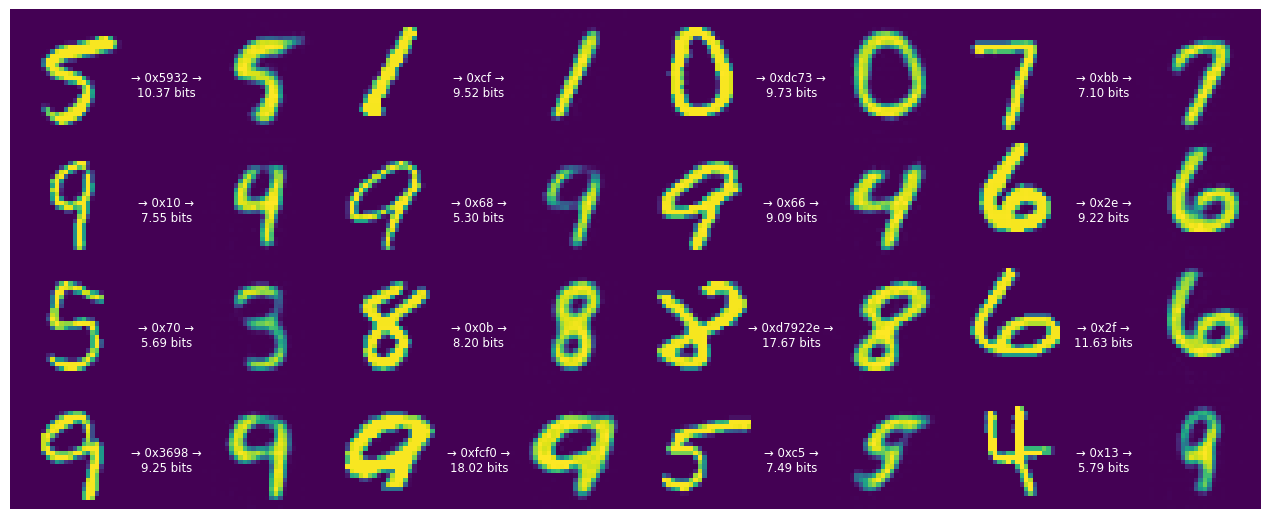

In [26]:
train_and_visualize_model(lmbda=300)


The strings begin to get much shorter now, on the order of one byte per digit. However, this comes at a cost. More digits are becoming unrecognizable.

This demonstrates that this model is agnostic to human perceptions of error, it just measures the absolute deviation in terms of pixel values. To achieve a better perceived image quality, we would need to replace the pixel loss with a perceptual loss.

## Use the decoder as a generative model.

If we feed the decoder random bits, this will effectively sample from the distribution that the model learned to represent digits.

First, re-instantiate the compressor/decompressor without a sanity check that would detect if the input string isn't completely decoded.

In [27]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)


Now, feed long enough random strings into the decompressor so that it can decode/sample digits from them.

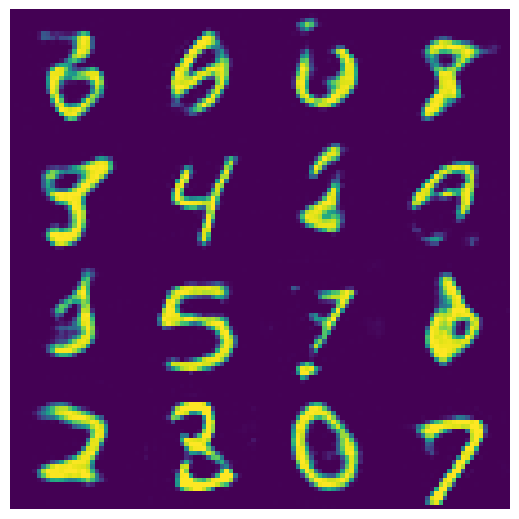

In [28]:
import os

strings = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strings)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
